In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/lr_images.zip' -d '/content/data'
!unzip '/content/drive/MyDrive/mr_images.zip' -d '/content/data'

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras import Model
from keras.layers import Conv2D, PReLU, Activation, BatchNormalization, Flatten, UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [ ]:
def res_block(model):
    gen = model
    res_model = Conv2D(64, (3,3), padding = "same")(model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(res_model)
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = add([gen, res_model])
    return res_model

In [ ]:
def upsample_block(model):
    ups_model = Conv2D(64, (3,3), padding = "same")(model)
    ups_model = UpSampling2D(size = 2)(ups_model)
    ups_model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(ups_model)
    return ups_model

In [ ]:
num_res_block = 16
num_upsample_block = 2

In [ ]:
def generator_func(gen_input):
    model = Conv2D(filters = 64, kernel_size = 9, strides = 1, padding = "same")(gen_input)
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    gen_model = model
    for index in range(num_res_block):
        model = res_block(model)
    model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(model)
    model = BatchNormalization(momentum = 0.5)(model)
    model = add([gen_model, model])
    for index in range(num_upsample_block):
        model = upsample_block(model)
    model = Conv2D(filters = 3, kernel_size = 9, strides = 1, padding = "same")(model)
    model = Activation('tanh')(model)
    generator_model = Model(inputs = gen_input, outputs = model)
    return generator_model

In [ ]:
def discriminator_block(model, filters, kernel_size, strides,bn=True):
    dis_model = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(model)
    if bn:
      dis_model = BatchNormalization(momentum=0.8 )(dis_model)
    dis_model = LeakyReLU(alpha = 0.2)(model)
    return dis_model

In [ ]:
def discriminator_func(dis_input):
    # model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(dis_input)
    # model = LeakyReLU(alpha = 0.2)(model)
    model = discriminator_block(dis_input, 64, 3, 2, bn=False)
    model = discriminator_block(model, 64, 3, 2)
    model = discriminator_block(model, 128, 3, 1)
    model = discriminator_block(model, 128, 3, 2)
    model = discriminator_block(model, 256, 3, 1)
    model = discriminator_block(model, 256, 3, 2)
    model = discriminator_block(model, 512, 3, 1)
    model = discriminator_block(model, 512, 3, 2)
    model = Flatten()(model)
    model = Dense(1024)(model)#1024
    model = LeakyReLU(alpha = 0.2)(model)
    model = Dense(1)(model)
    model = Activation('sigmoid')(model)
    discriminator_model = Model(inputs = dis_input, outputs = model)
    return discriminator_model

In [ ]:
from keras.applications import VGG19
def build_vgg(hr_shape):
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [ ]:
def combine(gen_model, disc_model, vgg, lr_input, hr_input):
    gen_img = gen_model(lr_input)
    gen_features = vgg(gen_img)
    disc_model.trainable = False
    validity = disc_model(gen_img)
    return Model([lr_input, hr_input],[validity,gen_features])

In [ ]:
n=10000
lr_list = os.listdir("/content/data/lr_images")[:n]
lr_images = []
for img in lr_list:
    img_lr = cv2.imread("/content/data/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)
hr_list = os.listdir("/content/data/mr_images")[:n]
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("/content/data/mr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)

In [ ]:
del lr_list
del hr_list

In [ ]:
lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

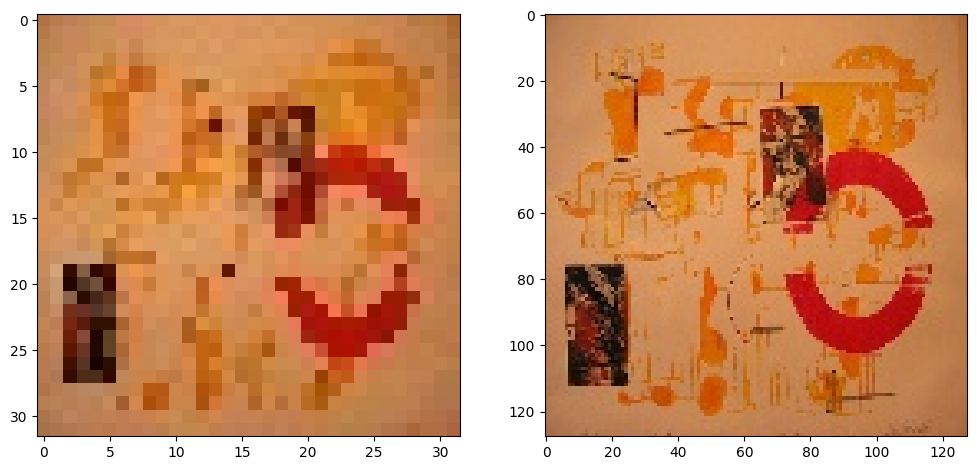

In [ ]:
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [ ]:
# def normalize(input_data):
#     return (input_data.astype(np.float32) - 127.5)/127.5
lr_images = (lr_images.astype(np.float16) - 127.5)/127.5
hr_images = (hr_images.astype(np.float16) - 127.5)/127.5

In [ ]:
hr_images.shape

(10000, 128, 128, 3)

In [ ]:
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, test_size=0.33, random_state=42)
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])
lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [ ]:
del lr_images
del hr_images

In [ ]:
lr_ip

<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
import tensorflow as tf

In [ ]:
#tf.debugging.set_log_device_placement(True)
generator = generator_func(lr_ip)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [ ]:
discriminator = discriminator_func(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 3)       0         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128, 128, 3)       0         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128, 128, 3)       0         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 128, 128, 3)       0         
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 128, 3)       0         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128, 128, 3)       0   

In [ ]:
vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
gan_model = combine(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  1333315     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            50333697    ['model[1][0]']            

In [ ]:
batch_size = 1
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [ ]:
train_lr_batches = np.array(train_lr_batches)
train_hr_batches = np.array(train_hr_batches)

In [ ]:
epochs = 10
for e in tqdm(range(epochs)):
    gen_label = np.zeros((batch_size, 1))
    real_label = np.ones((batch_size,1))
    g_losses = []
    d_losses = []
    for b in range(len(train_hr_batches)):
        lr_imgs = train_lr_batches[b]
        hr_imgs = train_hr_batches[b]
        gen_imgs = generator.predict_on_batch(lr_imgs)
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(gen_imgs, gen_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs,real_label)
        discriminator.trainable = False
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)
        image_features = vgg.predict(hr_imgs)
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        d_losses.append(d_loss)
        g_losses.append(g_loss)
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)
    if (e+1) % 10 == 0:
        generator.save("gen_e_"+ str(e+1) +".h5")

  0%|          | 0/6700 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 1/6700 [00:00<16:10,  6.90it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 2/6700 [00:00<16:33,  6.74it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 3/6700 [00:00<18:11,  6.14it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 4/6700 [00:00<17:47,  6.27it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 5/6700 [00:00<17:39,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 6/6700 [00:00<17:34,  6.35it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 7/6700 [00:01<17:42,  6.30it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 8/6700 [00:01<17:20,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 9/6700 [00:01<17:30,  6.37it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 10/6700 [00:01<17:20,  6.43it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 11/6700 [00:01<17:41,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 12/6700 [00:01<17:24,  6.40it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 13/6700 [00:02<17:50,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 14/6700 [00:02<17:27,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 15/6700 [00:02<17:32,  6.35it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 16/6700 [00:02<17:03,  6.53it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 17/6700 [00:02<17:02,  6.54it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 18/6700 [00:02<17:24,  6.40it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 19/6700 [00:02<17:01,  6.54it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 20/6700 [00:03<17:03,  6.53it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 21/6700 [00:03<16:49,  6.61it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 22/6700 [00:03<17:32,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 23/6700 [00:03<17:37,  6.31it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 24/6700 [00:03<18:16,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 25/6700 [00:03<17:50,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 26/6700 [00:04<17:55,  6.21it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 27/6700 [00:04<17:33,  6.33it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 28/6700 [00:04<17:36,  6.32it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 29/6700 [00:04<17:08,  6.49it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 30/6700 [00:04<17:09,  6.48it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 31/6700 [00:04<17:01,  6.53it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 32/6700 [00:04<16:43,  6.65it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 33/6700 [00:05<16:56,  6.56it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 34/6700 [00:05<16:46,  6.62it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 35/6700 [00:05<16:46,  6.62it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 36/6700 [00:05<16:59,  6.54it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 37/6700 [00:05<16:55,  6.56it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 38/6700 [00:05<16:35,  6.69it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 39/6700 [00:06<17:07,  6.49it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 40/6700 [00:06<16:53,  6.57it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 41/6700 [00:06<16:50,  6.59it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 42/6700 [00:06<16:45,  6.62it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 43/6700 [00:06<17:38,  6.29it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 44/6700 [00:06<19:16,  5.75it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 45/6700 [00:07<20:32,  5.40it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 46/6700 [00:07<21:37,  5.13it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 47/6700 [00:07<22:32,  4.92it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 48/6700 [00:07<22:32,  4.92it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 49/6700 [00:07<22:45,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 50/6700 [00:08<22:49,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 51/6700 [00:08<22:43,  4.88it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 52/6700 [00:08<22:52,  4.84it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 53/6700 [00:08<22:42,  4.88it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 54/6700 [00:08<22:35,  4.90it/s]

1/1 [==============================] - 0s 49ms/step


  1%|          | 55/6700 [00:09<23:22,  4.74it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 56/6700 [00:09<23:51,  4.64it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 57/6700 [00:09<23:40,  4.68it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 58/6700 [00:09<23:28,  4.72it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 59/6700 [00:10<23:42,  4.67it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 60/6700 [00:10<23:34,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 61/6700 [00:10<21:50,  5.07it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 62/6700 [00:10<20:11,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 63/6700 [00:10<20:18,  5.45it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 64/6700 [00:10<19:07,  5.79it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 65/6700 [00:11<18:36,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 66/6700 [00:11<18:23,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 67/6700 [00:11<18:06,  6.10it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 68/6700 [00:11<17:52,  6.18it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 69/6700 [00:11<17:36,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 70/6700 [00:11<17:29,  6.32it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 71/6700 [00:12<17:05,  6.47it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 72/6700 [00:12<16:49,  6.56it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 73/6700 [00:12<17:10,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 74/6700 [00:12<16:55,  6.52it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 75/6700 [00:12<17:08,  6.44it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 76/6700 [00:12<17:55,  6.16it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 77/6700 [00:12<17:21,  6.36it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 78/6700 [00:13<17:26,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 79/6700 [00:13<17:22,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 80/6700 [00:13<17:12,  6.41it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 81/6700 [00:13<16:58,  6.50it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 82/6700 [00:13<16:47,  6.57it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 83/6700 [00:13<16:55,  6.52it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 84/6700 [00:14<16:43,  6.59it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 85/6700 [00:14<16:59,  6.49it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 86/6700 [00:14<17:10,  6.42it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 87/6700 [00:14<17:09,  6.42it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 88/6700 [00:14<17:32,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 89/6700 [00:14<17:25,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 90/6700 [00:14<17:19,  6.36it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 91/6700 [00:15<17:11,  6.41it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 92/6700 [00:15<18:03,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 93/6700 [00:15<17:38,  6.24it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 94/6700 [00:15<18:37,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 95/6700 [00:15<18:17,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 96/6700 [00:15<17:43,  6.21it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 97/6700 [00:16<17:14,  6.38it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 98/6700 [00:16<17:11,  6.40it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 99/6700 [00:16<17:23,  6.33it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 100/6700 [00:16<17:28,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 101/6700 [00:16<17:10,  6.40it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 102/6700 [00:16<17:09,  6.41it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 103/6700 [00:17<17:00,  6.47it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 104/6700 [00:17<17:20,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 105/6700 [00:17<17:26,  6.30it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 106/6700 [00:17<17:12,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 107/6700 [00:17<17:27,  6.29it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 108/6700 [00:17<18:04,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 109/6700 [00:18<17:45,  6.19it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 110/6700 [00:18<17:28,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 111/6700 [00:18<17:12,  6.38it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 112/6700 [00:18<17:18,  6.34it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 113/6700 [00:18<17:03,  6.43it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 114/6700 [00:18<17:03,  6.44it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 115/6700 [00:18<16:59,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 116/6700 [00:19<16:55,  6.48it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 117/6700 [00:19<16:59,  6.46it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 118/6700 [00:19<18:08,  6.05it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 119/6700 [00:19<17:43,  6.19it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 120/6700 [00:19<17:18,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 121/6700 [00:19<18:11,  6.03it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 122/6700 [00:20<18:38,  5.88it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 123/6700 [00:20<17:50,  6.15it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 124/6700 [00:20<19:16,  5.69it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 125/6700 [00:20<20:34,  5.33it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 126/6700 [00:20<21:17,  5.15it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 127/6700 [00:21<21:51,  5.01it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 128/6700 [00:21<22:27,  4.88it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 129/6700 [00:21<23:06,  4.74it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 130/6700 [00:21<24:03,  4.55it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 131/6700 [00:22<24:17,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 132/6700 [00:22<23:58,  4.56it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 133/6700 [00:22<24:18,  4.50it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 134/6700 [00:22<24:47,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 135/6700 [00:22<24:48,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 136/6700 [00:23<24:41,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 137/6700 [00:23<24:15,  4.51it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 138/6700 [00:23<24:49,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 139/6700 [00:23<24:25,  4.48it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 140/6700 [00:24<24:55,  4.39it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 141/6700 [00:24<23:42,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 142/6700 [00:24<21:28,  5.09it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 143/6700 [00:24<21:06,  5.18it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 144/6700 [00:24<20:47,  5.26it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 145/6700 [00:24<19:34,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 146/6700 [00:25<19:20,  5.65it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 147/6700 [00:25<18:23,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 148/6700 [00:25<17:45,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 149/6700 [00:25<18:46,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 150/6700 [00:25<18:12,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 151/6700 [00:25<17:39,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 152/6700 [00:26<17:17,  6.31it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 153/6700 [00:26<17:11,  6.35it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 154/6700 [00:26<16:54,  6.45it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 155/6700 [00:26<17:44,  6.15it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 156/6700 [00:26<17:26,  6.25it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 157/6700 [00:26<17:38,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 158/6700 [00:26<17:14,  6.33it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 159/6700 [00:27<17:28,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 160/6700 [00:27<17:18,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 161/6700 [00:27<17:02,  6.39it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 162/6700 [00:27<17:13,  6.33it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 163/6700 [00:27<16:59,  6.41it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 164/6700 [00:27<17:42,  6.15it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 165/6700 [00:28<17:37,  6.18it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 166/6700 [00:28<17:40,  6.16it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 167/6700 [00:28<17:54,  6.08it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 168/6700 [00:28<18:49,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 169/6700 [00:28<18:16,  5.96it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 170/6700 [00:28<17:37,  6.17it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 171/6700 [00:29<17:08,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 172/6700 [00:29<17:09,  6.34it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 173/6700 [00:29<16:53,  6.44it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 174/6700 [00:29<17:08,  6.35it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 175/6700 [00:29<18:08,  6.00it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 176/6700 [00:29<18:30,  5.87it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 177/6700 [00:30<17:57,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 178/6700 [00:30<17:43,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 179/6700 [00:30<17:16,  6.29it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 180/6700 [00:30<17:59,  6.04it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 181/6700 [00:30<17:52,  6.08it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 182/6700 [00:30<17:39,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 183/6700 [00:31<17:25,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 184/6700 [00:31<17:07,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 185/6700 [00:31<16:53,  6.43it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 186/6700 [00:31<18:22,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 187/6700 [00:31<18:10,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 188/6700 [00:31<18:04,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 189/6700 [00:32<17:24,  6.23it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 190/6700 [00:32<17:05,  6.35it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 191/6700 [00:32<16:53,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 192/6700 [00:32<17:16,  6.28it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 193/6700 [00:32<17:01,  6.37it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 194/6700 [00:32<17:36,  6.16it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 195/6700 [00:32<17:31,  6.19it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 196/6700 [00:33<17:25,  6.22it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 197/6700 [00:33<17:04,  6.35it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 198/6700 [00:33<16:58,  6.39it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 199/6700 [00:33<16:48,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 200/6700 [00:33<17:24,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 201/6700 [00:33<17:43,  6.11it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 202/6700 [00:34<17:27,  6.21it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 203/6700 [00:34<19:12,  5.64it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 204/6700 [00:34<20:18,  5.33it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 205/6700 [00:34<21:46,  4.97it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 206/6700 [00:34<22:19,  4.85it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 207/6700 [00:35<22:48,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 208/6700 [00:35<23:21,  4.63it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 209/6700 [00:35<23:43,  4.56it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 210/6700 [00:35<23:47,  4.55it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 211/6700 [00:36<24:10,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 212/6700 [00:36<24:12,  4.47it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 213/6700 [00:36<23:41,  4.56it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 214/6700 [00:36<24:12,  4.47it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 215/6700 [00:36<23:45,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 216/6700 [00:37<23:54,  4.52it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 217/6700 [00:37<23:43,  4.55it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 218/6700 [00:37<23:40,  4.56it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 219/6700 [00:37<25:06,  4.30it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 220/6700 [00:38<23:22,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 221/6700 [00:38<21:48,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 222/6700 [00:38<20:14,  5.33it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 223/6700 [00:38<20:30,  5.26it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 224/6700 [00:38<20:10,  5.35it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 225/6700 [00:38<19:30,  5.53it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 226/6700 [00:39<19:06,  5.65it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 227/6700 [00:39<18:19,  5.89it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 228/6700 [00:39<18:05,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 229/6700 [00:39<17:59,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 230/6700 [00:39<17:26,  6.18it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 231/6700 [00:39<17:07,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 232/6700 [00:40<16:54,  6.37it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 233/6700 [00:40<16:41,  6.46it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 234/6700 [00:40<16:34,  6.50it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 235/6700 [00:40<16:23,  6.58it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 236/6700 [00:40<16:33,  6.50it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 237/6700 [00:40<16:56,  6.36it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 238/6700 [00:40<17:17,  6.23it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 239/6700 [00:41<18:00,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 240/6700 [00:41<17:46,  6.06it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 241/6700 [00:41<17:38,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 242/6700 [00:41<17:15,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 243/6700 [00:41<17:04,  6.30it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▎         | 244/6700 [00:41<17:22,  6.19it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 245/6700 [00:42<17:04,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 246/6700 [00:42<17:03,  6.31it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 247/6700 [00:42<16:51,  6.38it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 248/6700 [00:42<17:07,  6.28it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▎         | 249/6700 [00:42<17:03,  6.30it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▎         | 250/6700 [00:42<17:04,  6.30it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 251/6700 [00:43<18:15,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 252/6700 [00:43<17:35,  6.11it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 253/6700 [00:43<17:08,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 254/6700 [00:43<17:08,  6.27it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 255/6700 [00:43<16:57,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 256/6700 [00:43<16:43,  6.42it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 257/6700 [00:44<18:15,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 258/6700 [00:44<17:35,  6.10it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 259/6700 [00:44<17:06,  6.28it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 260/6700 [00:44<17:28,  6.14it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 261/6700 [00:44<17:00,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 262/6700 [00:44<17:05,  6.28it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 263/6700 [00:45<18:13,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 264/6700 [00:45<17:43,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 265/6700 [00:45<18:21,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 266/6700 [00:45<17:49,  6.02it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 267/6700 [00:45<17:48,  6.02it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 268/6700 [00:45<17:32,  6.11it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 269/6700 [00:46<17:34,  6.10it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 270/6700 [00:46<17:37,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 271/6700 [00:46<17:17,  6.20it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 272/6700 [00:46<17:03,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 273/6700 [00:46<17:01,  6.29it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 274/6700 [00:46<17:05,  6.27it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 275/6700 [00:46<16:53,  6.34it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 276/6700 [00:47<17:05,  6.27it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 277/6700 [00:47<17:15,  6.20it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 278/6700 [00:47<18:33,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 279/6700 [00:47<17:54,  5.98it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 280/6700 [00:47<17:47,  6.02it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 281/6700 [00:48<32:23,  3.30it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 282/6700 [00:48<30:11,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 283/6700 [00:48<28:21,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 284/6700 [00:49<27:42,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 285/6700 [00:49<27:02,  3.95it/s]

1/1 [==============================] - 0s 50ms/step


  4%|▍         | 286/6700 [00:49<27:06,  3.94it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 287/6700 [00:49<27:25,  3.90it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 288/6700 [00:50<27:15,  3.92it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 289/6700 [00:50<27:12,  3.93it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 290/6700 [00:50<26:35,  4.02it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 291/6700 [00:50<26:30,  4.03it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 292/6700 [00:51<26:23,  4.05it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 293/6700 [00:51<26:14,  4.07it/s]

1/1 [==============================] - 0s 46ms/step


  4%|▍         | 294/6700 [00:51<26:45,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 295/6700 [00:51<24:29,  4.36it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 296/6700 [00:51<22:47,  4.68it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 297/6700 [00:52<21:41,  4.92it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 298/6700 [00:52<21:43,  4.91it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 299/6700 [00:52<21:05,  5.06it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 300/6700 [00:52<20:10,  5.29it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 301/6700 [00:52<19:32,  5.46it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 302/6700 [00:53<19:13,  5.55it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 303/6700 [00:53<19:02,  5.60it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 304/6700 [00:53<19:49,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 305/6700 [00:53<20:37,  5.17it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 306/6700 [00:53<19:58,  5.33it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 307/6700 [00:54<19:39,  5.42it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 308/6700 [00:54<20:22,  5.23it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 309/6700 [00:54<19:44,  5.40it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 310/6700 [00:54<19:18,  5.52it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 311/6700 [00:54<18:49,  5.66it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 312/6700 [00:54<18:39,  5.70it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 313/6700 [00:55<19:00,  5.60it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 314/6700 [00:55<19:03,  5.58it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 315/6700 [00:55<18:47,  5.66it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 316/6700 [00:55<18:52,  5.64it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 317/6700 [00:55<18:37,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 318/6700 [00:55<18:15,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 319/6700 [00:56<18:17,  5.81it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 320/6700 [00:56<18:38,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


  5%|▍         | 321/6700 [00:56<18:39,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 322/6700 [00:56<18:20,  5.79it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 323/6700 [00:56<18:24,  5.77it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 324/6700 [00:56<18:14,  5.83it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 325/6700 [00:57<18:00,  5.90it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 326/6700 [00:57<18:18,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 327/6700 [00:57<18:01,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 328/6700 [00:57<18:12,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 329/6700 [00:57<17:55,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 330/6700 [00:58<17:59,  5.90it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 331/6700 [00:58<17:56,  5.92it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 332/6700 [00:58<17:52,  5.94it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▍         | 333/6700 [00:58<17:40,  6.00it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 334/6700 [00:58<17:39,  6.01it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 335/6700 [00:58<17:37,  6.02it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 336/6700 [00:59<17:35,  6.03it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 337/6700 [00:59<17:51,  5.94it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 338/6700 [00:59<18:25,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 339/6700 [00:59<18:30,  5.73it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 340/6700 [00:59<18:39,  5.68it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 341/6700 [00:59<18:34,  5.70it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 342/6700 [01:00<18:26,  5.74it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 343/6700 [01:00<18:19,  5.78it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 344/6700 [01:00<18:31,  5.72it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 345/6700 [01:00<18:43,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 346/6700 [01:00<18:38,  5.68it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 347/6700 [01:00<18:27,  5.74it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 348/6700 [01:01<18:15,  5.80it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 349/6700 [01:01<18:19,  5.78it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 350/6700 [01:01<18:19,  5.77it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 351/6700 [01:01<18:43,  5.65it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 352/6700 [01:01<20:49,  5.08it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 353/6700 [01:02<21:54,  4.83it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 354/6700 [01:02<21:57,  4.82it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 355/6700 [01:02<23:44,  4.45it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 356/6700 [01:02<24:06,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 357/6700 [01:03<24:11,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 358/6700 [01:03<23:50,  4.43it/s]

1/1 [==============================] - 0s 47ms/step


  5%|▌         | 359/6700 [01:03<25:27,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 360/6700 [01:03<25:26,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 361/6700 [01:04<24:52,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 362/6700 [01:04<23:32,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 363/6700 [01:04<24:17,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 364/6700 [01:04<24:04,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 365/6700 [01:04<24:01,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 366/6700 [01:05<23:39,  4.46it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 367/6700 [01:05<22:59,  4.59it/s]

1/1 [==============================] - 0s 21ms/step


  5%|▌         | 368/6700 [01:05<21:13,  4.97it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 369/6700 [01:05<20:10,  5.23it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 370/6700 [01:05<19:18,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 371/6700 [01:05<19:08,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 372/6700 [01:06<19:44,  5.34it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 373/6700 [01:06<18:58,  5.56it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 374/6700 [01:06<18:17,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 375/6700 [01:06<18:08,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 376/6700 [01:06<17:49,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 377/6700 [01:07<17:30,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 378/6700 [01:07<17:12,  6.12it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 379/6700 [01:07<16:53,  6.24it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 380/6700 [01:07<16:58,  6.20it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 381/6700 [01:07<17:18,  6.08it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 382/6700 [01:07<17:18,  6.08it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 383/6700 [01:07<16:57,  6.21it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 384/6700 [01:08<17:15,  6.10it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 385/6700 [01:08<16:58,  6.20it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 386/6700 [01:08<16:58,  6.20it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 387/6700 [01:08<17:06,  6.15it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 388/6700 [01:08<17:26,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 389/6700 [01:08<17:19,  6.07it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 390/6700 [01:09<17:22,  6.05it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 391/6700 [01:09<17:09,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 392/6700 [01:09<17:23,  6.05it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 393/6700 [01:09<18:04,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 394/6700 [01:09<17:41,  5.94it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 395/6700 [01:09<17:21,  6.05it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 396/6700 [01:10<17:02,  6.17it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 397/6700 [01:10<16:57,  6.20it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 398/6700 [01:10<16:59,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 399/6700 [01:10<16:48,  6.25it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 400/6700 [01:10<16:49,  6.24it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 401/6700 [01:10<16:40,  6.30it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 402/6700 [01:11<16:26,  6.38it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 403/6700 [01:11<16:21,  6.42it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 404/6700 [01:11<16:22,  6.41it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 405/6700 [01:11<16:38,  6.30it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 406/6700 [01:11<17:00,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 407/6700 [01:11<16:59,  6.17it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 408/6700 [01:12<17:10,  6.10it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 409/6700 [01:12<17:11,  6.10it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 410/6700 [01:12<17:16,  6.07it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 411/6700 [01:12<18:06,  5.79it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 412/6700 [01:12<17:53,  5.86it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 413/6700 [01:12<17:55,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 414/6700 [01:13<17:41,  5.92it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 415/6700 [01:13<17:52,  5.86it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 416/6700 [01:13<17:37,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 417/6700 [01:13<18:43,  5.59it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 418/6700 [01:13<18:32,  5.64it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 419/6700 [01:13<18:05,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 420/6700 [01:14<17:55,  5.84it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 421/6700 [01:14<17:38,  5.93it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 422/6700 [01:14<17:36,  5.94it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 423/6700 [01:14<17:57,  5.83it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 424/6700 [01:14<18:29,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 425/6700 [01:14<18:08,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 426/6700 [01:15<18:11,  5.75it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 427/6700 [01:15<17:50,  5.86it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 428/6700 [01:15<20:11,  5.18it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 429/6700 [01:15<21:03,  4.96it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 430/6700 [01:15<21:35,  4.84it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 431/6700 [01:16<22:34,  4.63it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 432/6700 [01:16<22:24,  4.66it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▋         | 433/6700 [01:16<23:11,  4.50it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 434/6700 [01:16<23:16,  4.49it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 435/6700 [01:17<23:18,  4.48it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 436/6700 [01:17<22:59,  4.54it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 437/6700 [01:17<22:39,  4.61it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 438/6700 [01:17<22:10,  4.71it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 439/6700 [01:17<22:39,  4.60it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 440/6700 [01:18<23:01,  4.53it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 441/6700 [01:18<22:54,  4.55it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 442/6700 [01:18<23:08,  4.51it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 443/6700 [01:18<23:49,  4.38it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 444/6700 [01:19<22:28,  4.64it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 445/6700 [01:19<20:47,  5.02it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 446/6700 [01:19<19:37,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 447/6700 [01:19<19:09,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 448/6700 [01:19<18:27,  5.64it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 449/6700 [01:19<18:15,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 450/6700 [01:20<17:39,  5.90it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 451/6700 [01:20<17:32,  5.94it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 452/6700 [01:20<16:58,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 453/6700 [01:20<16:44,  6.22it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 454/6700 [01:20<17:23,  5.99it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 455/6700 [01:20<17:10,  6.06it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 456/6700 [01:21<17:20,  6.00it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 457/6700 [01:21<17:03,  6.10it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 458/6700 [01:21<17:21,  5.99it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 459/6700 [01:21<17:01,  6.11it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 460/6700 [01:21<16:58,  6.13it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 461/6700 [01:21<16:51,  6.17it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 462/6700 [01:22<16:49,  6.18it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 463/6700 [01:22<16:35,  6.27it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 464/6700 [01:22<17:08,  6.06it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 465/6700 [01:22<17:38,  5.89it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 466/6700 [01:22<17:59,  5.78it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 467/6700 [01:22<18:14,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 468/6700 [01:23<17:41,  5.87it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 469/6700 [01:23<17:56,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 470/6700 [01:23<17:18,  6.00it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 471/6700 [01:23<17:17,  6.00it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 472/6700 [01:23<17:38,  5.88it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 473/6700 [01:23<17:41,  5.87it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 474/6700 [01:24<17:46,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 475/6700 [01:24<17:12,  6.03it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 476/6700 [01:24<16:56,  6.12it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 477/6700 [01:24<17:14,  6.02it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 478/6700 [01:24<17:55,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 479/6700 [01:24<17:28,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 480/6700 [01:25<17:38,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 481/6700 [01:25<18:34,  5.58it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 482/6700 [01:25<17:55,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 483/6700 [01:25<18:24,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 484/6700 [01:25<17:49,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 485/6700 [01:25<17:52,  5.80it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 486/6700 [01:26<17:26,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 487/6700 [01:26<17:24,  5.95it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 488/6700 [01:26<17:15,  6.00it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 489/6700 [01:26<17:22,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 490/6700 [01:26<18:11,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 491/6700 [01:26<17:38,  5.87it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 492/6700 [01:27<17:28,  5.92it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 493/6700 [01:27<17:23,  5.95it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 494/6700 [01:27<17:26,  5.93it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 495/6700 [01:27<17:22,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 496/6700 [01:27<17:04,  6.06it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 497/6700 [01:27<17:02,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 498/6700 [01:28<17:10,  6.02it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 499/6700 [01:28<16:47,  6.15it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 500/6700 [01:28<16:40,  6.20it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 501/6700 [01:28<16:25,  6.29it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 502/6700 [01:28<16:26,  6.28it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 503/6700 [01:28<16:34,  6.23it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 504/6700 [01:29<18:48,  5.49it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 505/6700 [01:29<20:16,  5.09it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 506/6700 [01:29<21:33,  4.79it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 507/6700 [01:29<21:19,  4.84it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 508/6700 [01:30<22:31,  4.58it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 509/6700 [01:30<22:21,  4.62it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 510/6700 [01:30<22:51,  4.51it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 511/6700 [01:30<22:11,  4.65it/s]

1/1 [==============================] - 0s 180ms/step


  8%|▊         | 512/6700 [01:31<44:36,  2.31it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 513/6700 [01:31<39:33,  2.61it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 514/6700 [01:32<34:15,  3.01it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 515/6700 [01:32<31:20,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 516/6700 [01:32<28:39,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 517/6700 [01:32<27:09,  3.79it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 518/6700 [01:32<24:00,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 519/6700 [01:33<22:04,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 520/6700 [01:33<21:32,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 521/6700 [01:33<19:51,  5.18it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 522/6700 [01:33<18:54,  5.45it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 523/6700 [01:33<18:43,  5.50it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 524/6700 [01:34<18:22,  5.60it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 525/6700 [01:34<17:45,  5.80it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 526/6700 [01:34<17:48,  5.78it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 527/6700 [01:34<18:18,  5.62it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 528/6700 [01:34<18:02,  5.70it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 529/6700 [01:34<18:06,  5.68it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 530/6700 [01:35<17:36,  5.84it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 531/6700 [01:35<17:51,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 532/6700 [01:35<17:49,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 533/6700 [01:35<17:47,  5.78it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 534/6700 [01:35<17:33,  5.85it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 535/6700 [01:35<17:22,  5.91it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 536/6700 [01:36<17:40,  5.81it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 537/6700 [01:36<17:30,  5.87it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 538/6700 [01:36<17:09,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 539/6700 [01:36<16:58,  6.05it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 540/6700 [01:36<16:52,  6.08it/s]

1/1 [==============================] - 0s 57ms/step


  8%|▊         | 541/6700 [01:37<21:47,  4.71it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 542/6700 [01:37<27:11,  3.77it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 543/6700 [01:37<26:13,  3.91it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 544/6700 [01:37<23:24,  4.38it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 545/6700 [01:38<21:43,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 546/6700 [01:38<20:55,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 547/6700 [01:38<20:45,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 548/6700 [01:38<19:51,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 549/6700 [01:38<18:50,  5.44it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 550/6700 [01:38<18:17,  5.61it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 551/6700 [01:39<18:08,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 552/6700 [01:39<17:51,  5.74it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 553/6700 [01:39<17:48,  5.75it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 554/6700 [01:39<17:39,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 555/6700 [01:39<17:17,  5.92it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 556/6700 [01:39<17:02,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 557/6700 [01:40<17:07,  5.98it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 558/6700 [01:40<17:25,  5.87it/s]

1/1 [==============================] - 0s 92ms/step


  8%|▊         | 559/6700 [01:40<26:21,  3.88it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 560/6700 [01:40<24:47,  4.13it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 561/6700 [01:41<22:15,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 562/6700 [01:41<20:28,  5.00it/s]

1/1 [==============================] - 0s 77ms/step


  8%|▊         | 563/6700 [01:41<28:08,  3.64it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 564/6700 [01:41<26:38,  3.84it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 565/6700 [01:42<23:59,  4.26it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 566/6700 [01:42<22:41,  4.51it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 567/6700 [01:42<20:52,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 568/6700 [01:42<19:34,  5.22it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 569/6700 [01:42<18:57,  5.39it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 570/6700 [01:42<20:08,  5.07it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 571/6700 [01:43<20:50,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 572/6700 [01:43<21:27,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 573/6700 [01:43<21:53,  4.66it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 574/6700 [01:43<21:51,  4.67it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 575/6700 [01:44<22:24,  4.56it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 576/6700 [01:44<22:30,  4.54it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▊         | 577/6700 [01:44<23:50,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▊         | 578/6700 [01:44<23:29,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 579/6700 [01:45<23:16,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 580/6700 [01:45<23:02,  4.43it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▊         | 581/6700 [01:45<23:33,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 582/6700 [01:45<23:34,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 583/6700 [01:45<23:37,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▊         | 584/6700 [01:46<23:39,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 585/6700 [01:46<23:14,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 586/6700 [01:46<23:16,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 587/6700 [01:46<21:38,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 588/6700 [01:46<20:01,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 589/6700 [01:47<18:55,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 590/6700 [01:47<18:40,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 591/6700 [01:47<18:46,  5.42it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 592/6700 [01:47<19:14,  5.29it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 593/6700 [01:47<18:27,  5.52it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 594/6700 [01:48<17:56,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 595/6700 [01:48<17:33,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 596/6700 [01:48<17:02,  5.97it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 597/6700 [01:48<16:56,  6.01it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 598/6700 [01:48<17:26,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 599/6700 [01:48<18:05,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 600/6700 [01:49<17:39,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 601/6700 [01:49<17:48,  5.71it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 602/6700 [01:49<17:33,  5.79it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 603/6700 [01:49<17:32,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 604/6700 [01:49<17:25,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 605/6700 [01:49<17:05,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 606/6700 [01:50<17:00,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 607/6700 [01:50<16:58,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 608/6700 [01:50<17:12,  5.90it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 609/6700 [01:50<17:01,  5.96it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 610/6700 [01:50<17:24,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 611/6700 [01:50<17:14,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 612/6700 [01:51<17:01,  5.96it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 613/6700 [01:51<16:51,  6.02it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 614/6700 [01:51<16:39,  6.09it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 615/6700 [01:51<16:40,  6.08it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 616/6700 [01:51<17:06,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 617/6700 [01:51<17:05,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 618/6700 [01:52<17:23,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 619/6700 [01:52<17:15,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 620/6700 [01:52<17:06,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 621/6700 [01:52<17:04,  5.94it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 622/6700 [01:52<17:36,  5.75it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 623/6700 [01:52<18:12,  5.56it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 624/6700 [01:53<17:45,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 625/6700 [01:53<17:33,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 626/6700 [01:53<17:13,  5.88it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 627/6700 [01:53<17:04,  5.93it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 628/6700 [01:53<17:19,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 629/6700 [01:53<17:09,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 630/6700 [01:54<17:24,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 631/6700 [01:54<17:15,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 632/6700 [01:54<16:58,  5.96it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 633/6700 [01:54<17:04,  5.92it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 634/6700 [01:54<17:23,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 635/6700 [01:55<17:32,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 636/6700 [01:55<18:12,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 637/6700 [01:55<17:57,  5.63it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 638/6700 [01:55<17:36,  5.74it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 639/6700 [01:55<17:45,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 640/6700 [01:55<17:27,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 641/6700 [01:56<17:15,  5.85it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 642/6700 [01:56<17:18,  5.83it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 643/6700 [01:56<17:21,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 644/6700 [01:56<18:22,  5.49it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 645/6700 [01:56<20:26,  4.94it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 646/6700 [01:57<21:21,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 647/6700 [01:57<21:45,  4.64it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 648/6700 [01:57<22:36,  4.46it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 649/6700 [01:57<23:00,  4.38it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 650/6700 [01:58<23:13,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 651/6700 [01:58<22:41,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 652/6700 [01:58<23:11,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 653/6700 [01:58<23:46,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 654/6700 [01:58<23:24,  4.30it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 655/6700 [01:59<23:01,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 656/6700 [01:59<22:24,  4.49it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 657/6700 [01:59<22:44,  4.43it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 658/6700 [01:59<23:12,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 659/6700 [02:00<23:25,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 660/6700 [02:00<23:20,  4.31it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 661/6700 [02:00<22:35,  4.45it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 662/6700 [02:00<21:07,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 663/6700 [02:00<19:56,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 664/6700 [02:01<19:51,  5.07it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 665/6700 [02:01<19:00,  5.29it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 666/6700 [02:01<18:15,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 10%|▉         | 667/6700 [02:01<18:13,  5.52it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 668/6700 [02:01<17:56,  5.60it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 669/6700 [02:01<18:06,  5.55it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 670/6700 [02:02<17:38,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 671/6700 [02:02<17:25,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 672/6700 [02:02<17:15,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 673/6700 [02:02<17:04,  5.88it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 674/6700 [02:02<16:49,  5.97it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 675/6700 [02:02<17:07,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 676/6700 [02:03<16:59,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 677/6700 [02:03<16:49,  5.97it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 678/6700 [02:03<16:44,  5.99it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 679/6700 [02:03<17:27,  5.75it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 680/6700 [02:03<17:17,  5.80it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 681/6700 [02:03<17:06,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 682/6700 [02:04<17:18,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 683/6700 [02:04<17:10,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 684/6700 [02:04<16:58,  5.90it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 685/6700 [02:04<16:55,  5.92it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 686/6700 [02:04<17:01,  5.89it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 687/6700 [02:05<17:18,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 688/6700 [02:05<17:54,  5.59it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 689/6700 [02:05<17:19,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 690/6700 [02:05<17:06,  5.86it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 691/6700 [02:05<16:55,  5.92it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 692/6700 [02:05<16:43,  5.98it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 693/6700 [02:06<17:16,  5.80it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 694/6700 [02:06<17:32,  5.71it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 695/6700 [02:06<17:38,  5.67it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 696/6700 [02:06<17:27,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 697/6700 [02:06<17:23,  5.75it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 698/6700 [02:06<17:02,  5.87it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 699/6700 [02:07<17:54,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 700/6700 [02:07<17:42,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 701/6700 [02:07<17:28,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 702/6700 [02:07<17:15,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 703/6700 [02:07<17:16,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 704/6700 [02:07<17:05,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 705/6700 [02:08<17:19,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 706/6700 [02:08<17:19,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 707/6700 [02:08<17:15,  5.79it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 708/6700 [02:08<16:54,  5.91it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 709/6700 [02:08<16:46,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 710/6700 [02:08<16:22,  6.09it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 711/6700 [02:09<16:36,  6.01it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 712/6700 [02:09<17:12,  5.80it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 713/6700 [02:09<17:01,  5.86it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 714/6700 [02:09<17:02,  5.86it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 715/6700 [02:09<16:47,  5.94it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 716/6700 [02:10<17:03,  5.85it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 717/6700 [02:10<16:37,  6.00it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 718/6700 [02:10<16:24,  6.07it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 719/6700 [02:10<16:44,  5.95it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 720/6700 [02:10<18:49,  5.30it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 721/6700 [02:10<19:58,  4.99it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 722/6700 [02:11<21:56,  4.54it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 723/6700 [02:11<23:05,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 724/6700 [02:11<23:01,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 725/6700 [02:11<23:20,  4.27it/s]

1/1 [==============================] - 0s 46ms/step


 11%|█         | 726/6700 [02:12<23:51,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 727/6700 [02:12<23:39,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 728/6700 [02:12<23:12,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 729/6700 [02:12<22:59,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 730/6700 [02:13<22:55,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 731/6700 [02:13<23:16,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 732/6700 [02:13<23:39,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 733/6700 [02:13<23:47,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 734/6700 [02:14<23:22,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 735/6700 [02:14<23:22,  4.25it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 736/6700 [02:14<21:54,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 737/6700 [02:14<20:14,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 738/6700 [02:14<19:33,  5.08it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 739/6700 [02:15<19:13,  5.17it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 740/6700 [02:15<18:30,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 741/6700 [02:15<17:59,  5.52it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 742/6700 [02:15<17:33,  5.65it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 743/6700 [02:15<17:06,  5.80it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 744/6700 [02:15<17:12,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 745/6700 [02:16<16:58,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 746/6700 [02:16<17:13,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 747/6700 [02:16<17:17,  5.74it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 748/6700 [02:16<17:52,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 749/6700 [02:16<17:24,  5.70it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 750/6700 [02:16<17:24,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 751/6700 [02:17<17:08,  5.78it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 752/6700 [02:17<16:54,  5.86it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 753/6700 [02:17<16:45,  5.92it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 754/6700 [02:17<17:01,  5.82it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 755/6700 [02:17<17:15,  5.74it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 756/6700 [02:17<17:23,  5.69it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 757/6700 [02:18<17:15,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 758/6700 [02:18<17:09,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 759/6700 [02:18<16:46,  5.90it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 760/6700 [02:18<16:21,  6.05it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 761/6700 [02:18<16:02,  6.17it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 762/6700 [02:18<16:09,  6.13it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 763/6700 [02:19<16:22,  6.04it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 764/6700 [02:19<16:11,  6.11it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 765/6700 [02:19<16:16,  6.08it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 766/6700 [02:19<17:10,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 767/6700 [02:19<16:45,  5.90it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 768/6700 [02:19<16:55,  5.84it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 769/6700 [02:20<17:27,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 770/6700 [02:20<17:12,  5.74it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 771/6700 [02:20<17:00,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 772/6700 [02:20<16:40,  5.92it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 773/6700 [02:20<16:40,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 774/6700 [02:20<16:35,  5.95it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 775/6700 [02:21<16:48,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 776/6700 [02:21<16:44,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 777/6700 [02:21<17:01,  5.80it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 778/6700 [02:21<17:13,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 779/6700 [02:21<17:02,  5.79it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 780/6700 [02:22<16:58,  5.81it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 781/6700 [02:22<17:41,  5.57it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 782/6700 [02:22<17:19,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 783/6700 [02:22<16:57,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 784/6700 [02:22<16:43,  5.90it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 785/6700 [02:22<16:56,  5.82it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 786/6700 [02:23<17:05,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 787/6700 [02:23<17:18,  5.70it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 788/6700 [02:23<17:07,  5.76it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 789/6700 [02:23<16:59,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 790/6700 [02:23<16:46,  5.87it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 791/6700 [02:23<16:51,  5.84it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 792/6700 [02:24<16:43,  5.89it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 793/6700 [02:24<16:27,  5.98it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 794/6700 [02:24<21:13,  4.64it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 795/6700 [02:24<21:16,  4.63it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 796/6700 [02:25<21:58,  4.48it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 797/6700 [02:25<22:12,  4.43it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 798/6700 [02:25<22:55,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 799/6700 [02:25<22:46,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 800/6700 [02:25<22:42,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 801/6700 [02:26<22:07,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 802/6700 [02:26<21:52,  4.49it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 803/6700 [02:26<22:29,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 804/6700 [02:26<21:55,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 805/6700 [02:27<21:54,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 806/6700 [02:27<22:27,  4.38it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 807/6700 [02:27<23:29,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 808/6700 [02:27<23:45,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 809/6700 [02:28<23:15,  4.22it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 810/6700 [02:28<22:31,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 811/6700 [02:28<21:17,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 812/6700 [02:28<20:36,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 813/6700 [02:28<19:20,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 814/6700 [02:29<18:36,  5.27it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 815/6700 [02:29<17:57,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 816/6700 [02:29<17:22,  5.65it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 817/6700 [02:29<17:26,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 818/6700 [02:29<17:22,  5.64it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 819/6700 [02:29<16:59,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 820/6700 [02:30<18:02,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 821/6700 [02:30<18:34,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 822/6700 [02:30<17:47,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 823/6700 [02:30<17:21,  5.64it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 824/6700 [02:30<17:11,  5.70it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 825/6700 [02:30<16:56,  5.78it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 826/6700 [02:31<16:51,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 827/6700 [02:31<16:59,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 828/6700 [02:31<16:52,  5.80it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 829/6700 [02:31<16:43,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 830/6700 [02:31<17:36,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 831/6700 [02:31<17:12,  5.68it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 832/6700 [02:32<16:56,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 833/6700 [02:32<16:38,  5.88it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 834/6700 [02:32<16:36,  5.88it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 835/6700 [02:32<16:51,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 836/6700 [02:32<17:05,  5.72it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 837/6700 [02:33<17:33,  5.56it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 838/6700 [02:33<17:20,  5.63it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 839/6700 [02:33<16:59,  5.75it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 840/6700 [02:33<16:57,  5.76it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 841/6700 [02:33<16:32,  5.90it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 842/6700 [02:33<16:25,  5.95it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 843/6700 [02:34<16:15,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 844/6700 [02:34<16:12,  6.02it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 845/6700 [02:34<16:04,  6.07it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 846/6700 [02:34<16:13,  6.01it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 847/6700 [02:34<16:09,  6.04it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 848/6700 [02:34<16:19,  5.98it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 849/6700 [02:35<16:14,  6.01it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 850/6700 [02:35<16:01,  6.08it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 851/6700 [02:35<16:19,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 852/6700 [02:35<16:31,  5.90it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 853/6700 [02:35<16:40,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 854/6700 [02:35<16:42,  5.83it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 855/6700 [02:36<16:26,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 856/6700 [02:36<16:44,  5.82it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 857/6700 [02:36<16:47,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 858/6700 [02:36<16:32,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 859/6700 [02:36<16:32,  5.88it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 860/6700 [02:36<16:52,  5.77it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 861/6700 [02:37<16:54,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 862/6700 [02:37<17:12,  5.65it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 863/6700 [02:37<16:52,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 864/6700 [02:37<16:53,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 865/6700 [02:37<17:06,  5.68it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 866/6700 [02:37<16:50,  5.77it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 867/6700 [02:38<16:55,  5.74it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 868/6700 [02:38<18:49,  5.16it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 869/6700 [02:38<20:16,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 870/6700 [02:38<21:24,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 871/6700 [02:39<21:37,  4.49it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 872/6700 [02:39<21:44,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 873/6700 [02:39<22:09,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 874/6700 [02:39<22:10,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 875/6700 [02:40<22:08,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 876/6700 [02:40<22:11,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 877/6700 [02:40<22:45,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 878/6700 [02:40<22:56,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 879/6700 [02:40<22:54,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 880/6700 [02:41<23:15,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 881/6700 [02:41<23:18,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 882/6700 [02:41<22:57,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 883/6700 [02:41<23:00,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 884/6700 [02:42<22:53,  4.24it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 885/6700 [02:42<21:55,  4.42it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 886/6700 [02:42<20:26,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 887/6700 [02:42<19:23,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 888/6700 [02:42<18:46,  5.16it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 889/6700 [02:43<19:01,  5.09it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 890/6700 [02:43<18:29,  5.24it/s]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 891/6700 [02:43<17:59,  5.38it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 892/6700 [02:43<17:40,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 893/6700 [02:43<17:21,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 894/6700 [02:43<17:10,  5.63it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 895/6700 [02:44<16:51,  5.74it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 896/6700 [02:44<16:26,  5.88it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 897/6700 [02:44<16:08,  5.99it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 898/6700 [02:44<16:18,  5.93it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 899/6700 [02:44<16:06,  6.00it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 900/6700 [02:44<16:11,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 901/6700 [02:45<16:23,  5.90it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 902/6700 [02:45<16:31,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 903/6700 [02:45<16:19,  5.92it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 904/6700 [02:45<16:47,  5.75it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 905/6700 [02:45<16:46,  5.76it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 906/6700 [02:46<16:28,  5.86it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 907/6700 [02:46<16:47,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 908/6700 [02:46<17:13,  5.60it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▎        | 909/6700 [02:46<19:19,  4.99it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▎        | 910/6700 [02:46<20:30,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 911/6700 [02:47<21:09,  4.56it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 912/6700 [02:47<22:23,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▎        | 913/6700 [02:47<22:36,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 914/6700 [02:47<23:12,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 915/6700 [02:48<24:01,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 916/6700 [02:48<23:17,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 917/6700 [02:48<23:07,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 918/6700 [02:48<23:25,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▎        | 919/6700 [02:49<23:20,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▎        | 920/6700 [02:49<23:29,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▎        | 921/6700 [02:49<23:23,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 922/6700 [02:49<23:14,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 923/6700 [02:50<23:22,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 924/6700 [02:50<23:03,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 925/6700 [02:50<22:19,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 926/6700 [02:50<21:05,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 927/6700 [02:50<19:41,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 928/6700 [02:51<18:45,  5.13it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 929/6700 [02:51<18:31,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 930/6700 [02:51<18:05,  5.32it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 931/6700 [02:51<17:49,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 932/6700 [02:51<17:32,  5.48it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 933/6700 [02:51<17:03,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 934/6700 [02:52<16:49,  5.71it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 935/6700 [02:52<17:46,  5.41it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 936/6700 [02:52<19:21,  4.96it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 937/6700 [02:52<20:51,  4.60it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 938/6700 [02:53<21:35,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 939/6700 [02:53<21:29,  4.47it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 940/6700 [02:53<22:40,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 941/6700 [02:53<22:42,  4.23it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 942/6700 [02:53<22:55,  4.19it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 943/6700 [02:54<23:12,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 944/6700 [02:54<23:53,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 945/6700 [02:54<24:20,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 946/6700 [02:55<24:07,  3.97it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 947/6700 [02:55<24:17,  3.95it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 948/6700 [02:55<23:49,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 949/6700 [02:55<23:56,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 950/6700 [02:56<23:54,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 951/6700 [02:56<23:44,  4.04it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 952/6700 [02:56<21:54,  4.37it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 953/6700 [02:56<20:36,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 954/6700 [02:56<19:18,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 955/6700 [02:56<19:14,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 956/6700 [02:57<18:30,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 957/6700 [02:57<17:40,  5.42it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 958/6700 [02:57<17:10,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 959/6700 [02:57<16:49,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 960/6700 [02:57<16:37,  5.75it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 961/6700 [02:58<16:23,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 962/6700 [02:58<17:08,  5.58it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 963/6700 [02:58<16:43,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 964/6700 [02:58<17:06,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 965/6700 [02:58<17:09,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 966/6700 [02:58<16:58,  5.63it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 967/6700 [02:59<16:37,  5.75it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 968/6700 [02:59<16:29,  5.79it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 969/6700 [02:59<16:23,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 970/6700 [02:59<16:30,  5.79it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 971/6700 [02:59<16:30,  5.78it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 972/6700 [02:59<16:38,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 973/6700 [03:00<16:29,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 974/6700 [03:00<16:25,  5.81it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 975/6700 [03:00<16:49,  5.67it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 976/6700 [03:00<16:59,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 977/6700 [03:00<17:02,  5.60it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 978/6700 [03:01<17:05,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 979/6700 [03:01<16:51,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 980/6700 [03:01<16:44,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 981/6700 [03:01<16:52,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 982/6700 [03:01<16:41,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 983/6700 [03:01<17:27,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 984/6700 [03:02<17:13,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 985/6700 [03:02<16:50,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 986/6700 [03:02<16:33,  5.75it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 987/6700 [03:02<16:32,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 988/6700 [03:02<16:46,  5.67it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 989/6700 [03:02<16:35,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 990/6700 [03:03<16:30,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 991/6700 [03:03<16:11,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 992/6700 [03:03<16:00,  5.94it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 993/6700 [03:03<15:53,  5.98it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 994/6700 [03:03<15:48,  6.02it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 995/6700 [03:03<16:11,  5.87it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 996/6700 [03:04<16:10,  5.88it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 997/6700 [03:04<16:07,  5.89it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 998/6700 [03:04<16:05,  5.90it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 999/6700 [03:04<16:11,  5.87it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▍        | 1000/6700 [03:04<16:22,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 1001/6700 [03:04<16:22,  5.80it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▍        | 1002/6700 [03:05<16:21,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 1003/6700 [03:05<17:03,  5.57it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 1004/6700 [03:05<16:43,  5.67it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 1005/6700 [03:05<16:42,  5.68it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1006/6700 [03:05<16:39,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1007/6700 [03:06<16:47,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1008/6700 [03:06<16:53,  5.62it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 1009/6700 [03:06<17:59,  5.27it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1010/6700 [03:06<18:52,  5.03it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1011/6700 [03:06<19:55,  4.76it/s]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 1012/6700 [03:07<21:13,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1013/6700 [03:07<21:26,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1014/6700 [03:07<21:54,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 1015/6700 [03:07<22:15,  4.26it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▌        | 1016/6700 [03:08<22:44,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1017/6700 [03:08<22:24,  4.23it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 1018/6700 [03:08<22:16,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 1019/6700 [03:08<23:17,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1020/6700 [03:09<22:08,  4.28it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 1021/6700 [03:09<22:17,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 1022/6700 [03:09<22:13,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1023/6700 [03:09<22:10,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1024/6700 [03:10<22:45,  4.16it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1025/6700 [03:10<23:11,  4.08it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1026/6700 [03:10<21:38,  4.37it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1027/6700 [03:10<19:57,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1028/6700 [03:10<18:44,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 1029/6700 [03:10<18:11,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 1030/6700 [03:11<17:23,  5.43it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 1031/6700 [03:11<16:52,  5.60it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 1032/6700 [03:11<17:17,  5.46it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 1033/6700 [03:11<16:50,  5.61it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 1034/6700 [03:11<16:38,  5.67it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 1035/6700 [03:12<16:41,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 1036/6700 [03:12<16:33,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 1037/6700 [03:12<16:21,  5.77it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 1038/6700 [03:12<16:06,  5.86it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1039/6700 [03:12<16:02,  5.88it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1040/6700 [03:12<16:11,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1041/6700 [03:13<16:08,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1042/6700 [03:13<16:27,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 1043/6700 [03:13<16:34,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1044/6700 [03:13<16:32,  5.70it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1045/6700 [03:13<16:35,  5.68it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1046/6700 [03:13<17:01,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1047/6700 [03:14<16:37,  5.67it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1048/6700 [03:14<16:41,  5.64it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1049/6700 [03:14<17:07,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1050/6700 [03:14<17:09,  5.49it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1051/6700 [03:14<16:47,  5.61it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1052/6700 [03:15<16:57,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1053/6700 [03:15<17:10,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1054/6700 [03:15<16:39,  5.65it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1055/6700 [03:15<16:24,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1056/6700 [03:15<16:15,  5.79it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1057/6700 [03:15<16:21,  5.75it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1058/6700 [03:16<16:24,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 1059/6700 [03:16<17:18,  5.43it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1060/6700 [03:16<16:50,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1061/6700 [03:16<16:41,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1062/6700 [03:16<17:10,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1063/6700 [03:16<16:42,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 1064/6700 [03:17<17:18,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1065/6700 [03:17<17:11,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1066/6700 [03:17<17:02,  5.51it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1067/6700 [03:17<16:48,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 1068/6700 [03:17<16:35,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1069/6700 [03:18<16:40,  5.63it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1070/6700 [03:18<16:26,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1071/6700 [03:18<16:21,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1072/6700 [03:18<16:10,  5.80it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1073/6700 [03:18<16:09,  5.80it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1074/6700 [03:18<16:09,  5.80it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1075/6700 [03:19<16:14,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 1076/6700 [03:19<16:36,  5.64it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1077/6700 [03:19<16:22,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 1078/6700 [03:19<16:04,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1079/6700 [03:19<16:06,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1080/6700 [03:19<16:00,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 1081/6700 [03:20<16:10,  5.79it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 1082/6700 [03:20<16:27,  5.69it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 1083/6700 [03:20<18:42,  5.01it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1084/6700 [03:20<20:09,  4.64it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1085/6700 [03:21<20:44,  4.51it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1086/6700 [03:21<20:41,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1087/6700 [03:21<21:00,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1088/6700 [03:21<21:15,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 1089/6700 [03:21<21:17,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1090/6700 [03:22<21:45,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1091/6700 [03:22<21:57,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1092/6700 [03:22<21:41,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 1093/6700 [03:22<21:30,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▋        | 1094/6700 [03:23<21:49,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 1095/6700 [03:23<22:00,  4.25it/s]

1/1 [==============================] - 0s 137ms/step


 16%|█▋        | 1096/6700 [03:24<37:26,  2.49it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 1097/6700 [03:24<36:59,  2.52it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 1098/6700 [03:24<30:22,  3.07it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 1099/6700 [03:24<26:29,  3.52it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 1100/6700 [03:25<23:10,  4.03it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 1101/6700 [03:25<20:50,  4.48it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 1102/6700 [03:25<19:36,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 1103/6700 [03:25<18:32,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 1104/6700 [03:25<17:34,  5.31it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▋        | 1105/6700 [03:25<16:59,  5.49it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1106/6700 [03:26<16:23,  5.69it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1107/6700 [03:26<16:05,  5.79it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1108/6700 [03:26<16:58,  5.49it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1109/6700 [03:26<16:39,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1110/6700 [03:26<17:04,  5.46it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1111/6700 [03:26<16:42,  5.58it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1112/6700 [03:27<16:37,  5.60it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1113/6700 [03:27<16:20,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1114/6700 [03:27<16:26,  5.66it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1115/6700 [03:27<16:32,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1116/6700 [03:27<16:00,  5.81it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1117/6700 [03:28<15:43,  5.91it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1118/6700 [03:28<15:40,  5.94it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1119/6700 [03:28<15:42,  5.92it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1120/6700 [03:28<15:48,  5.88it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1121/6700 [03:28<15:37,  5.95it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1122/6700 [03:28<15:34,  5.97it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1123/6700 [03:29<16:36,  5.59it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1124/6700 [03:29<16:06,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1125/6700 [03:29<15:49,  5.87it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1126/6700 [03:29<15:39,  5.93it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1127/6700 [03:29<15:43,  5.91it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1128/6700 [03:29<16:03,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 1129/6700 [03:30<16:17,  5.70it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1130/6700 [03:30<16:02,  5.79it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1131/6700 [03:30<15:51,  5.85it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1132/6700 [03:30<16:09,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1133/6700 [03:30<16:06,  5.76it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1134/6700 [03:30<16:10,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1135/6700 [03:31<16:13,  5.72it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1136/6700 [03:31<17:03,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1137/6700 [03:31<16:59,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1138/6700 [03:31<17:01,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1139/6700 [03:31<16:27,  5.63it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1140/6700 [03:32<16:07,  5.75it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1141/6700 [03:32<16:11,  5.72it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1142/6700 [03:32<16:48,  5.51it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1143/6700 [03:32<16:38,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1144/6700 [03:32<16:24,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1145/6700 [03:32<16:30,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1146/6700 [03:33<16:50,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1147/6700 [03:33<16:28,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1148/6700 [03:33<16:19,  5.67it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1149/6700 [03:33<16:34,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1150/6700 [03:33<16:43,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 1151/6700 [03:33<16:38,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1152/6700 [03:34<16:36,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 1153/6700 [03:34<16:31,  5.59it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1154/6700 [03:34<16:59,  5.44it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1155/6700 [03:34<18:24,  5.02it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1156/6700 [03:35<19:49,  4.66it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1157/6700 [03:35<20:54,  4.42it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1158/6700 [03:35<21:20,  4.33it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1159/6700 [03:35<21:55,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1160/6700 [03:35<21:09,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1161/6700 [03:36<21:30,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1162/6700 [03:36<21:58,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1163/6700 [03:36<22:53,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1164/6700 [03:36<22:37,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1165/6700 [03:37<22:51,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1166/6700 [03:37<22:26,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1167/6700 [03:37<22:47,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1168/6700 [03:37<22:24,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1169/6700 [03:38<22:17,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1170/6700 [03:38<21:45,  4.23it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 1171/6700 [03:38<20:42,  4.45it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 1172/6700 [03:38<19:56,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1173/6700 [03:39<18:52,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1174/6700 [03:39<17:59,  5.12it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1175/6700 [03:39<17:06,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1176/6700 [03:39<16:42,  5.51it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1177/6700 [03:39<16:23,  5.62it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1178/6700 [03:39<16:34,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1179/6700 [03:40<17:03,  5.40it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1180/6700 [03:40<16:43,  5.50it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1181/6700 [03:40<16:10,  5.68it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 1182/6700 [03:40<15:59,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1183/6700 [03:40<15:58,  5.76it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1184/6700 [03:40<15:56,  5.77it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1185/6700 [03:41<15:52,  5.79it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1186/6700 [03:41<15:51,  5.80it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1187/6700 [03:41<15:36,  5.88it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1188/6700 [03:41<15:37,  5.88it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1189/6700 [03:41<15:44,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1190/6700 [03:41<15:34,  5.90it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1191/6700 [03:42<15:39,  5.86it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1192/6700 [03:42<15:41,  5.85it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1193/6700 [03:42<15:26,  5.94it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1194/6700 [03:42<15:34,  5.89it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1195/6700 [03:42<16:19,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1196/6700 [03:42<15:46,  5.82it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1197/6700 [03:43<15:46,  5.81it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1198/6700 [03:43<16:02,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1199/6700 [03:43<15:55,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1200/6700 [03:43<15:49,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1201/6700 [03:43<16:00,  5.73it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1202/6700 [03:44<15:58,  5.73it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1203/6700 [03:44<16:16,  5.63it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1204/6700 [03:44<16:06,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1205/6700 [03:44<15:48,  5.79it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1206/6700 [03:44<15:50,  5.78it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1207/6700 [03:44<15:58,  5.73it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1208/6700 [03:45<16:59,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1209/6700 [03:45<16:34,  5.52it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1210/6700 [03:45<16:39,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1211/6700 [03:45<16:24,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1212/6700 [03:45<16:33,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1213/6700 [03:45<16:15,  5.62it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1214/6700 [03:46<16:02,  5.70it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1215/6700 [03:46<16:45,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1216/6700 [03:46<16:22,  5.58it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 1217/6700 [03:46<16:06,  5.67it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1218/6700 [03:46<16:24,  5.57it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1219/6700 [03:47<16:20,  5.59it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1220/6700 [03:47<16:01,  5.70it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1221/6700 [03:47<15:49,  5.77it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 1222/6700 [03:47<15:43,  5.80it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 1223/6700 [03:47<15:46,  5.79it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1224/6700 [03:47<15:58,  5.71it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 1225/6700 [03:48<15:54,  5.74it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1226/6700 [03:48<16:05,  5.67it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 1227/6700 [03:48<16:50,  5.42it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 1228/6700 [03:48<17:43,  5.15it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1229/6700 [03:48<19:34,  4.66it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1230/6700 [03:49<19:40,  4.63it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1231/6700 [03:49<19:58,  4.56it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1232/6700 [03:49<21:13,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1233/6700 [03:49<21:26,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1234/6700 [03:50<22:12,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1235/6700 [03:50<21:39,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1236/6700 [03:50<21:18,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 1237/6700 [03:50<21:34,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 1238/6700 [03:51<22:12,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1239/6700 [03:51<21:44,  4.19it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 1240/6700 [03:51<22:37,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 1241/6700 [03:51<23:10,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 1242/6700 [03:52<23:29,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 1243/6700 [03:52<22:38,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 1244/6700 [03:52<22:06,  4.11it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 1245/6700 [03:52<21:17,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 1246/6700 [03:53<20:09,  4.51it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 1247/6700 [03:53<19:48,  4.59it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 1248/6700 [03:53<18:33,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 1249/6700 [03:53<18:30,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 1250/6700 [03:53<17:42,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 1251/6700 [03:53<16:57,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 1252/6700 [03:54<17:02,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 1253/6700 [03:54<17:05,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 1254/6700 [03:54<16:50,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 1255/6700 [03:54<16:35,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 1256/6700 [03:54<16:37,  5.46it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 1257/6700 [03:55<16:14,  5.59it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 1258/6700 [03:55<16:38,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1259/6700 [03:55<16:09,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1260/6700 [03:55<16:27,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 1261/6700 [03:55<17:03,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1262/6700 [03:55<16:32,  5.48it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1263/6700 [03:56<16:20,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 1264/6700 [03:56<16:04,  5.64it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1265/6700 [03:56<16:07,  5.62it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1266/6700 [03:56<16:02,  5.64it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1267/6700 [03:56<15:59,  5.66it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1268/6700 [03:56<15:41,  5.77it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1269/6700 [03:57<16:59,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1270/6700 [03:57<16:35,  5.46it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1271/6700 [03:57<16:21,  5.53it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 1272/6700 [03:57<16:26,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1273/6700 [03:57<16:07,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 1274/6700 [03:58<15:47,  5.73it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1275/6700 [03:58<16:48,  5.38it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 1276/6700 [03:58<16:23,  5.51it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 1277/6700 [03:58<15:48,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1278/6700 [03:58<15:52,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 1279/6700 [03:58<15:36,  5.79it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 1280/6700 [03:59<15:33,  5.81it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1281/6700 [03:59<15:29,  5.83it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 1282/6700 [03:59<15:25,  5.85it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 1283/6700 [03:59<15:27,  5.84it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 1284/6700 [03:59<15:52,  5.69it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 1285/6700 [04:00<15:47,  5.72it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 1286/6700 [04:00<15:55,  5.66it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1287/6700 [04:00<16:02,  5.62it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 1288/6700 [04:00<15:27,  5.84it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 1289/6700 [04:00<15:12,  5.93it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1290/6700 [04:00<15:03,  5.98it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 1291/6700 [04:01<15:22,  5.87it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1292/6700 [04:01<15:30,  5.81it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 1293/6700 [04:01<15:39,  5.76it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1294/6700 [04:01<15:31,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 1295/6700 [04:01<15:38,  5.76it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 1296/6700 [04:01<15:28,  5.82it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 1297/6700 [04:02<15:16,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 1298/6700 [04:02<15:16,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 1299/6700 [04:02<15:19,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 1300/6700 [04:02<15:19,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 1301/6700 [04:02<16:30,  5.45it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 1302/6700 [04:03<18:45,  4.80it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 1303/6700 [04:03<19:13,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 1304/6700 [04:03<19:36,  4.59it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1305/6700 [04:03<20:26,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1306/6700 [04:03<20:11,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1307/6700 [04:04<20:38,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1308/6700 [04:04<21:33,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1309/6700 [04:04<21:38,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1310/6700 [04:04<20:57,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1311/6700 [04:05<22:05,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1312/6700 [04:05<21:38,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1313/6700 [04:05<21:03,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1314/6700 [04:05<21:15,  4.22it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1315/6700 [04:06<21:31,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 1316/6700 [04:06<21:14,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1317/6700 [04:06<21:34,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 1318/6700 [04:06<21:19,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 1319/6700 [04:07<19:48,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 1320/6700 [04:07<18:37,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 1321/6700 [04:07<18:00,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 1322/6700 [04:07<17:09,  5.23it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 1323/6700 [04:07<17:01,  5.26it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1324/6700 [04:07<16:48,  5.33it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 1325/6700 [04:08<16:17,  5.50it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 1326/6700 [04:08<16:07,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 1327/6700 [04:08<16:03,  5.58it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 1328/6700 [04:08<15:51,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 1329/6700 [04:08<15:44,  5.69it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 1330/6700 [04:08<15:36,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 1331/6700 [04:09<15:50,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 1332/6700 [04:09<15:49,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 1333/6700 [04:09<15:51,  5.64it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 1334/6700 [04:09<17:01,  5.25it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 1335/6700 [04:09<17:22,  5.14it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 1336/6700 [04:10<16:57,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 1337/6700 [04:10<16:29,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 1338/6700 [04:10<16:21,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 1339/6700 [04:10<16:12,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1340/6700 [04:10<16:09,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 1341/6700 [04:11<16:04,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1342/6700 [04:11<15:58,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1343/6700 [04:11<15:48,  5.65it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1344/6700 [04:11<15:53,  5.62it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1345/6700 [04:11<16:12,  5.51it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 1346/6700 [04:11<15:56,  5.60it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1347/6700 [04:12<15:47,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1348/6700 [04:12<16:10,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1349/6700 [04:12<16:01,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1350/6700 [04:12<15:58,  5.58it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 1351/6700 [04:12<16:21,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1352/6700 [04:12<15:57,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1353/6700 [04:13<16:13,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1354/6700 [04:13<16:06,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1355/6700 [04:13<16:04,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1356/6700 [04:13<16:16,  5.47it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 1357/6700 [04:13<16:21,  5.44it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 1358/6700 [04:14<16:08,  5.51it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1359/6700 [04:14<15:54,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1360/6700 [04:14<16:05,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1361/6700 [04:14<16:09,  5.51it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 1362/6700 [04:14<16:04,  5.53it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 1363/6700 [04:14<15:58,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 1364/6700 [04:15<15:58,  5.57it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 1365/6700 [04:15<16:32,  5.37it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 1366/6700 [04:15<16:12,  5.49it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 1367/6700 [04:15<16:07,  5.51it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 1368/6700 [04:15<15:58,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1369/6700 [04:16<16:04,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 1370/6700 [04:16<16:06,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 1371/6700 [04:16<15:54,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 1372/6700 [04:16<15:36,  5.69it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 1373/6700 [04:16<15:40,  5.66it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1374/6700 [04:16<16:19,  5.44it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1375/6700 [04:17<18:20,  4.84it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1376/6700 [04:17<18:53,  4.70it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1377/6700 [04:17<19:42,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1378/6700 [04:17<20:18,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1379/6700 [04:18<20:50,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1380/6700 [04:18<20:55,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1381/6700 [04:18<20:46,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1382/6700 [04:18<20:54,  4.24it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1383/6700 [04:19<21:02,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 1384/6700 [04:19<21:00,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1385/6700 [04:19<21:02,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1386/6700 [04:19<21:01,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1387/6700 [04:20<21:26,  4.13it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1388/6700 [04:20<21:04,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1389/6700 [04:20<21:37,  4.09it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 1390/6700 [04:20<21:35,  4.10it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 1391/6700 [04:21<19:46,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1392/6700 [04:21<18:23,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1393/6700 [04:21<17:33,  5.04it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 1394/6700 [04:21<16:38,  5.31it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 1395/6700 [04:21<16:47,  5.26it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 1396/6700 [04:21<16:13,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1397/6700 [04:22<15:44,  5.61it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1398/6700 [04:22<15:51,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1399/6700 [04:22<15:38,  5.65it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1400/6700 [04:22<15:29,  5.70it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1401/6700 [04:22<15:46,  5.60it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 1402/6700 [04:22<15:26,  5.72it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 1403/6700 [04:23<15:33,  5.68it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1404/6700 [04:23<15:25,  5.72it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 1405/6700 [04:23<15:11,  5.81it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1406/6700 [04:23<15:02,  5.87it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1407/6700 [04:23<15:17,  5.77it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1408/6700 [04:23<15:10,  5.81it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1409/6700 [04:24<15:16,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 1410/6700 [04:24<15:06,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1411/6700 [04:24<15:19,  5.75it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 1412/6700 [04:24<14:51,  5.93it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 1413/6700 [04:24<15:28,  5.70it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1414/6700 [04:25<15:38,  5.63it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1415/6700 [04:25<15:29,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1416/6700 [04:25<15:17,  5.76it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 1417/6700 [04:25<15:01,  5.86it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 1418/6700 [04:25<15:18,  5.75it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 1419/6700 [04:25<15:29,  5.68it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1420/6700 [04:26<15:19,  5.74it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 1421/6700 [04:26<15:19,  5.74it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 1422/6700 [04:26<15:12,  5.78it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 1423/6700 [04:26<15:59,  5.50it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 1424/6700 [04:26<15:43,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1425/6700 [04:26<15:33,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 1426/6700 [04:27<15:19,  5.74it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 1427/6700 [04:27<15:11,  5.79it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 1428/6700 [04:27<14:59,  5.86it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 1429/6700 [04:27<14:59,  5.86it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 1430/6700 [04:27<14:49,  5.93it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██▏       | 1431/6700 [04:27<15:16,  5.75it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 1432/6700 [04:28<15:00,  5.85it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 1433/6700 [04:28<14:54,  5.89it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 1434/6700 [04:28<14:53,  5.89it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 1435/6700 [04:28<14:49,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██▏       | 1436/6700 [04:28<15:02,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██▏       | 1437/6700 [04:28<15:00,  5.85it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 1438/6700 [04:29<15:13,  5.76it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██▏       | 1439/6700 [04:29<15:19,  5.72it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 1440/6700 [04:29<15:10,  5.78it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1441/6700 [04:29<15:33,  5.63it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1442/6700 [04:29<15:29,  5.66it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1443/6700 [04:30<15:35,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1444/6700 [04:30<15:33,  5.63it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1445/6700 [04:30<15:24,  5.68it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1446/6700 [04:30<15:16,  5.73it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1447/6700 [04:30<15:17,  5.73it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1448/6700 [04:30<16:05,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1449/6700 [04:31<17:29,  5.00it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1450/6700 [04:31<19:32,  4.48it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1451/6700 [04:31<20:38,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1452/6700 [04:32<21:05,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1453/6700 [04:32<21:02,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 1454/6700 [04:32<21:18,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1455/6700 [04:32<21:18,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1456/6700 [04:32<20:59,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1457/6700 [04:33<20:26,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1458/6700 [04:33<21:21,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1459/6700 [04:33<21:25,  4.08it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1460/6700 [04:33<21:03,  4.15it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 1461/6700 [04:34<21:27,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1462/6700 [04:34<21:21,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1463/6700 [04:34<21:02,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1464/6700 [04:34<20:55,  4.17it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1465/6700 [04:35<19:11,  4.55it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 1466/6700 [04:35<18:11,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 1467/6700 [04:35<17:31,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1468/6700 [04:35<16:46,  5.20it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 1469/6700 [04:35<16:07,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 1470/6700 [04:35<15:47,  5.52it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1471/6700 [04:36<15:48,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1472/6700 [04:36<15:35,  5.59it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1473/6700 [04:36<15:30,  5.62it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1474/6700 [04:36<15:26,  5.64it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 1475/6700 [04:36<15:17,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1476/6700 [04:37<15:09,  5.74it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1477/6700 [04:37<15:18,  5.69it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1478/6700 [04:37<15:31,  5.60it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 1479/6700 [04:37<15:13,  5.72it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 1480/6700 [04:37<15:47,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1481/6700 [04:37<15:37,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1482/6700 [04:38<15:27,  5.63it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 1483/6700 [04:38<15:16,  5.69it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1484/6700 [04:38<15:39,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1485/6700 [04:38<15:12,  5.72it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1486/6700 [04:38<14:53,  5.84it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 1487/6700 [04:38<14:54,  5.83it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1488/6700 [04:39<14:56,  5.81it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1489/6700 [04:39<14:45,  5.88it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1490/6700 [04:39<14:33,  5.96it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1491/6700 [04:39<14:34,  5.95it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 1492/6700 [04:39<14:28,  6.00it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1493/6700 [04:39<14:40,  5.92it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1494/6700 [04:40<14:49,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1495/6700 [04:40<14:43,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1496/6700 [04:40<14:31,  5.97it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1497/6700 [04:40<15:11,  5.71it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 1498/6700 [04:40<15:04,  5.75it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1499/6700 [04:40<14:59,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1500/6700 [04:41<14:48,  5.85it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 1501/6700 [04:41<14:42,  5.89it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1502/6700 [04:41<14:42,  5.89it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 1503/6700 [04:41<15:05,  5.74it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 1504/6700 [04:41<14:57,  5.79it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1505/6700 [04:42<15:04,  5.74it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 1506/6700 [04:42<15:56,  5.43it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 1507/6700 [04:42<15:25,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 1508/6700 [04:42<15:04,  5.74it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 1509/6700 [04:42<14:53,  5.81it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 1510/6700 [04:42<15:09,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 1511/6700 [04:43<25:23,  3.40it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1512/6700 [04:43<22:45,  3.80it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1513/6700 [04:43<20:55,  4.13it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1514/6700 [04:44<19:28,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1515/6700 [04:44<18:43,  4.61it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1516/6700 [04:44<18:05,  4.78it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1517/6700 [04:44<17:27,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1518/6700 [04:44<16:58,  5.09it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1519/6700 [04:45<17:42,  4.88it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1520/6700 [04:45<18:48,  4.59it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1521/6700 [04:45<20:15,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1522/6700 [04:45<21:42,  3.97it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 1523/6700 [04:46<22:21,  3.86it/s]

1/1 [==============================] - 0s 54ms/step


 23%|██▎       | 1524/6700 [04:46<22:29,  3.84it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 1525/6700 [04:46<22:39,  3.81it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1526/6700 [04:46<22:24,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1527/6700 [04:47<21:43,  3.97it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1528/6700 [04:47<22:12,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1529/6700 [04:47<22:10,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1530/6700 [04:47<21:52,  3.94it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1531/6700 [04:48<22:48,  3.78it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1532/6700 [04:48<23:08,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1533/6700 [04:48<22:56,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1534/6700 [04:48<22:19,  3.86it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1535/6700 [04:49<20:32,  4.19it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1536/6700 [04:49<19:19,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1537/6700 [04:49<18:39,  4.61it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1538/6700 [04:49<17:51,  4.82it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1539/6700 [04:49<17:36,  4.89it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1540/6700 [04:50<17:22,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1541/6700 [04:50<17:35,  4.89it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1542/6700 [04:50<17:06,  5.02it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1543/6700 [04:50<16:57,  5.07it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1544/6700 [04:50<16:38,  5.16it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1545/6700 [04:51<16:29,  5.21it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1546/6700 [04:51<16:41,  5.14it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1547/6700 [04:51<16:41,  5.15it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1548/6700 [04:51<16:37,  5.17it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1549/6700 [04:51<16:20,  5.25it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1550/6700 [04:52<17:03,  5.03it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1551/6700 [04:52<16:40,  5.15it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1552/6700 [04:52<16:46,  5.11it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1553/6700 [04:52<16:40,  5.14it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1554/6700 [04:52<16:37,  5.16it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1555/6700 [04:53<16:37,  5.16it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1556/6700 [04:53<16:20,  5.25it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1557/6700 [04:53<16:30,  5.19it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1558/6700 [04:53<16:13,  5.28it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1559/6700 [04:53<15:55,  5.38it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1560/6700 [04:53<15:55,  5.38it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1561/6700 [04:54<16:41,  5.13it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1562/6700 [04:54<16:18,  5.25it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1563/6700 [04:54<16:10,  5.29it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1564/6700 [04:54<16:12,  5.28it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1565/6700 [04:54<15:58,  5.36it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1566/6700 [04:55<16:10,  5.29it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1567/6700 [04:55<16:32,  5.17it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1568/6700 [04:55<17:01,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 1569/6700 [04:55<16:57,  5.04it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1570/6700 [04:55<17:02,  5.02it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1571/6700 [04:56<16:38,  5.14it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1572/6700 [04:56<16:17,  5.25it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1573/6700 [04:56<16:02,  5.32it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1574/6700 [04:56<16:19,  5.23it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 1575/6700 [04:56<16:11,  5.28it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 1576/6700 [04:57<15:58,  5.35it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 1577/6700 [04:57<15:59,  5.34it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 1578/6700 [04:57<16:15,  5.25it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▎       | 1579/6700 [04:57<17:00,  5.02it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 1580/6700 [04:57<16:37,  5.13it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▎       | 1581/6700 [04:58<16:23,  5.20it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 1582/6700 [04:58<16:16,  5.24it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 1583/6700 [04:58<16:06,  5.29it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 1584/6700 [04:58<16:13,  5.26it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 1585/6700 [04:58<16:10,  5.27it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▎       | 1586/6700 [04:59<17:13,  4.95it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 1587/6700 [04:59<19:56,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 1588/6700 [04:59<20:38,  4.13it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 1589/6700 [04:59<21:25,  3.98it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 1590/6700 [05:00<21:53,  3.89it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 1591/6700 [05:00<22:35,  3.77it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1592/6700 [05:00<23:52,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 1593/6700 [05:00<22:57,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1594/6700 [05:01<22:20,  3.81it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1595/6700 [05:01<22:25,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1596/6700 [05:01<22:11,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1597/6700 [05:02<22:38,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 1598/6700 [05:02<22:14,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 1599/6700 [05:02<22:28,  3.78it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 1600/6700 [05:02<23:40,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 1601/6700 [05:03<22:23,  3.80it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 1602/6700 [05:03<20:25,  4.16it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1603/6700 [05:03<19:08,  4.44it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1604/6700 [05:03<18:06,  4.69it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 1605/6700 [05:03<17:38,  4.81it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 1606/6700 [05:04<17:28,  4.86it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1607/6700 [05:04<17:25,  4.87it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 1608/6700 [05:04<17:21,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1609/6700 [05:04<17:06,  4.96it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1610/6700 [05:04<16:43,  5.07it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 1611/6700 [05:05<16:40,  5.09it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1612/6700 [05:05<16:23,  5.17it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1613/6700 [05:05<16:17,  5.20it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1614/6700 [05:05<16:15,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 1615/6700 [05:05<16:36,  5.10it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1616/6700 [05:05<16:14,  5.22it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1617/6700 [05:06<15:57,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1618/6700 [05:06<15:45,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1619/6700 [05:06<15:33,  5.44it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1620/6700 [05:06<15:58,  5.30it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1621/6700 [05:06<15:50,  5.34it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1622/6700 [05:07<15:53,  5.33it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1623/6700 [05:07<15:39,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1624/6700 [05:07<15:07,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1625/6700 [05:07<14:59,  5.64it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1626/6700 [05:07<14:56,  5.66it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1627/6700 [05:07<15:09,  5.58it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1628/6700 [05:08<15:01,  5.63it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1629/6700 [05:08<15:26,  5.48it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 1630/6700 [05:08<15:19,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 1631/6700 [05:08<15:13,  5.55it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1632/6700 [05:08<15:13,  5.55it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1633/6700 [05:09<15:49,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1634/6700 [05:09<15:39,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1635/6700 [05:09<15:12,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1636/6700 [05:09<15:19,  5.51it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1637/6700 [05:09<15:28,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1638/6700 [05:09<15:10,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 1639/6700 [05:10<15:34,  5.41it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 1640/6700 [05:10<15:11,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 1641/6700 [05:10<15:05,  5.59it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1642/6700 [05:10<15:03,  5.60it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 1643/6700 [05:10<15:01,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1644/6700 [05:11<15:25,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1645/6700 [05:11<15:28,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 1646/6700 [05:11<15:19,  5.50it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 1647/6700 [05:11<15:31,  5.43it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 1648/6700 [05:11<15:19,  5.49it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 1649/6700 [05:11<15:03,  5.59it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 1650/6700 [05:12<15:01,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 1651/6700 [05:12<15:13,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 1652/6700 [05:12<15:23,  5.46it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 1653/6700 [05:12<15:08,  5.55it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 1654/6700 [05:12<15:22,  5.47it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 1655/6700 [05:13<16:40,  5.04it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 1656/6700 [05:13<18:15,  4.60it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 1657/6700 [05:13<18:43,  4.49it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 1658/6700 [05:13<19:17,  4.36it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 1659/6700 [05:14<20:23,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 1660/6700 [05:14<20:56,  4.01it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 1661/6700 [05:14<21:10,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 1662/6700 [05:14<20:46,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 1663/6700 [05:15<21:32,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 1664/6700 [05:15<20:49,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 1665/6700 [05:15<20:36,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 1666/6700 [05:15<21:02,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 1667/6700 [05:16<20:31,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 1668/6700 [05:16<20:48,  4.03it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 1669/6700 [05:16<20:51,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 1670/6700 [05:16<20:56,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 1671/6700 [05:17<20:46,  4.04it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 1672/6700 [05:17<19:07,  4.38it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 1673/6700 [05:17<17:47,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 1674/6700 [05:17<16:57,  4.94it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1675/6700 [05:17<16:12,  5.16it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 1676/6700 [05:18<15:47,  5.30it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 1677/6700 [05:18<15:37,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1678/6700 [05:18<15:19,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1679/6700 [05:18<15:04,  5.55it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 1680/6700 [05:18<15:07,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 1681/6700 [05:18<15:20,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 1682/6700 [05:19<15:05,  5.54it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 1683/6700 [05:19<14:54,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 1684/6700 [05:19<14:51,  5.62it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 1685/6700 [05:19<14:57,  5.59it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 1686/6700 [05:19<14:56,  5.59it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 1687/6700 [05:19<14:43,  5.67it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 1688/6700 [05:20<14:41,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 1689/6700 [05:20<14:50,  5.63it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 1690/6700 [05:20<15:02,  5.55it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 1691/6700 [05:20<15:20,  5.44it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 1692/6700 [05:20<15:06,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 1693/6700 [05:21<14:51,  5.62it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 1694/6700 [05:21<14:36,  5.71it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 1695/6700 [05:21<14:46,  5.65it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 1696/6700 [05:21<14:56,  5.58it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 1697/6700 [05:21<14:40,  5.68it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 1698/6700 [05:21<14:41,  5.68it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 1699/6700 [05:22<14:47,  5.63it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 1700/6700 [05:22<15:18,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1701/6700 [05:22<15:09,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1702/6700 [05:22<15:01,  5.54it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 1703/6700 [05:22<14:53,  5.60it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 1704/6700 [05:23<14:57,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 1705/6700 [05:23<15:06,  5.51it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 1706/6700 [05:23<15:04,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 1707/6700 [05:23<14:58,  5.56it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 1708/6700 [05:23<14:55,  5.57it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 1709/6700 [05:23<14:48,  5.62it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 1710/6700 [05:24<14:37,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1711/6700 [05:24<14:24,  5.77it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 1712/6700 [05:24<14:30,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1713/6700 [05:24<15:04,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1714/6700 [05:24<15:14,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1715/6700 [05:24<14:49,  5.61it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1716/6700 [05:25<14:50,  5.60it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1717/6700 [05:25<14:47,  5.62it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1718/6700 [05:25<14:55,  5.57it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1719/6700 [05:25<15:03,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1720/6700 [05:25<15:20,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 1721/6700 [05:26<15:45,  5.26it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1722/6700 [05:26<15:49,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 1723/6700 [05:26<15:41,  5.29it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1724/6700 [05:26<15:14,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1725/6700 [05:26<14:58,  5.54it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 1726/6700 [05:27<15:29,  5.35it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 1727/6700 [05:27<15:52,  5.22it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 1728/6700 [05:27<17:46,  4.66it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 1729/6700 [05:27<18:59,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1730/6700 [05:28<19:30,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1731/6700 [05:28<20:11,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1732/6700 [05:28<19:57,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1733/6700 [05:28<20:39,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1734/6700 [05:29<20:24,  4.05it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 1735/6700 [05:29<20:06,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 1736/6700 [05:29<20:13,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1737/6700 [05:29<20:15,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1738/6700 [05:29<20:19,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1739/6700 [05:30<20:53,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1740/6700 [05:30<20:45,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1741/6700 [05:30<21:27,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1742/6700 [05:31<20:37,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1743/6700 [05:31<20:50,  3.96it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 1744/6700 [05:31<19:03,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 1745/6700 [05:31<18:24,  4.49it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 1746/6700 [05:31<17:11,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 1747/6700 [05:32<16:16,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 1748/6700 [05:32<16:07,  5.12it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 1749/6700 [05:32<15:39,  5.27it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1750/6700 [05:32<15:16,  5.40it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1751/6700 [05:32<15:15,  5.41it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1752/6700 [05:32<14:56,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 1753/6700 [05:33<15:13,  5.42it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1754/6700 [05:33<15:08,  5.44it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 1755/6700 [05:33<15:09,  5.43it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 1756/6700 [05:33<15:08,  5.44it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1757/6700 [05:33<15:12,  5.42it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 1758/6700 [05:34<14:57,  5.50it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1759/6700 [05:34<14:51,  5.54it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 1760/6700 [05:34<14:53,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 1761/6700 [05:34<14:45,  5.58it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 1762/6700 [05:34<15:08,  5.43it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▋       | 1763/6700 [05:34<15:01,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 1764/6700 [05:35<15:00,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 1765/6700 [05:35<14:57,  5.50it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 1766/6700 [05:35<15:01,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1767/6700 [05:35<15:03,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1768/6700 [05:35<15:13,  5.40it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 1769/6700 [05:36<15:16,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1770/6700 [05:36<15:18,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1771/6700 [05:36<15:01,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 1772/6700 [05:36<14:47,  5.56it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▋       | 1773/6700 [05:36<14:50,  5.53it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 1774/6700 [05:36<14:59,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▋       | 1775/6700 [05:37<14:53,  5.51it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1776/6700 [05:37<15:05,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1777/6700 [05:37<15:12,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1778/6700 [05:37<15:39,  5.24it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1779/6700 [05:37<17:24,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1780/6700 [05:38<17:53,  4.58it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1781/6700 [05:38<18:47,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1782/6700 [05:38<19:44,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1783/6700 [05:38<20:25,  4.01it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 1784/6700 [05:39<20:56,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1785/6700 [05:39<20:46,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1786/6700 [05:39<20:36,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1787/6700 [05:39<20:08,  4.06it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 1788/6700 [05:40<20:43,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1789/6700 [05:40<20:22,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1790/6700 [05:40<20:30,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1791/6700 [05:40<20:31,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1792/6700 [05:41<20:40,  3.96it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 1793/6700 [05:41<21:17,  3.84it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 1794/6700 [05:41<22:11,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1795/6700 [05:42<21:54,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1796/6700 [05:42<21:45,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1797/6700 [05:42<21:12,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 1798/6700 [05:42<21:27,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1799/6700 [05:43<21:50,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 1800/6700 [05:43<20:57,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1801/6700 [05:43<20:55,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 1802/6700 [05:43<20:57,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 1803/6700 [05:44<20:15,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1804/6700 [05:44<20:44,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1805/6700 [05:44<19:58,  4.09it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 1806/6700 [05:44<20:50,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1807/6700 [05:45<20:48,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1808/6700 [05:45<21:31,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 1809/6700 [05:45<21:18,  3.83it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1810/6700 [05:45<21:08,  3.85it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 1811/6700 [05:46<19:37,  4.15it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1812/6700 [05:46<18:07,  4.49it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1813/6700 [05:46<17:06,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 1814/6700 [05:46<16:16,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1815/6700 [05:46<16:05,  5.06it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 1816/6700 [05:47<15:23,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 1817/6700 [05:47<15:26,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1818/6700 [05:47<15:23,  5.29it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1819/6700 [05:47<15:25,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 1820/6700 [05:47<15:11,  5.35it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 1821/6700 [05:47<14:52,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 1822/6700 [05:48<14:35,  5.57it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 1823/6700 [05:48<15:38,  5.20it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1824/6700 [05:48<15:38,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 1825/6700 [05:48<15:53,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 1826/6700 [05:48<15:43,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 1827/6700 [05:49<15:31,  5.23it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 1828/6700 [05:49<15:16,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1829/6700 [05:49<14:54,  5.44it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 1830/6700 [05:49<14:57,  5.43it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 1831/6700 [05:49<14:57,  5.43it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 1832/6700 [05:50<14:52,  5.46it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 1833/6700 [05:50<14:48,  5.48it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 1834/6700 [05:50<15:10,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 1835/6700 [05:50<15:15,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 1836/6700 [05:50<15:14,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 1837/6700 [05:50<15:02,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 1838/6700 [05:51<15:15,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 1839/6700 [05:51<15:02,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 1840/6700 [05:51<15:03,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 1841/6700 [05:51<14:52,  5.45it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1842/6700 [05:51<15:07,  5.35it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 1843/6700 [05:52<15:03,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1844/6700 [05:52<14:58,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 1845/6700 [05:52<14:47,  5.47it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 1846/6700 [05:52<14:37,  5.53it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1847/6700 [05:52<14:42,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 1848/6700 [05:52<14:25,  5.60it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 1849/6700 [05:53<14:16,  5.67it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1850/6700 [05:53<14:24,  5.61it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 1851/6700 [05:53<14:25,  5.60it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 1852/6700 [05:53<14:32,  5.56it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1853/6700 [05:53<14:22,  5.62it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1854/6700 [05:54<14:08,  5.71it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 1855/6700 [05:54<13:51,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 1856/6700 [05:54<13:49,  5.84it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 1857/6700 [05:54<14:02,  5.75it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 1858/6700 [05:54<13:59,  5.77it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 1859/6700 [05:54<14:02,  5.75it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 1860/6700 [05:55<14:30,  5.56it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 1861/6700 [05:55<14:09,  5.70it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 1862/6700 [05:55<14:29,  5.56it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 1863/6700 [05:55<14:23,  5.60it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 1864/6700 [05:55<14:24,  5.59it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 1865/6700 [05:55<15:12,  5.30it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1866/6700 [05:56<17:17,  4.66it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1867/6700 [05:56<19:19,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1868/6700 [05:56<19:05,  4.22it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1869/6700 [05:57<19:18,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1870/6700 [05:57<19:12,  4.19it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 1871/6700 [05:57<19:53,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1872/6700 [05:57<19:04,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1873/6700 [05:58<19:39,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1874/6700 [05:58<19:25,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 1875/6700 [05:58<19:52,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1876/6700 [05:58<19:51,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1877/6700 [05:59<19:37,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1878/6700 [05:59<19:59,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1879/6700 [05:59<19:46,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 1880/6700 [05:59<20:10,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1881/6700 [06:00<20:01,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 1882/6700 [06:00<19:37,  4.09it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 1883/6700 [06:00<19:14,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 1884/6700 [06:00<17:50,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 1885/6700 [06:00<16:45,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 1886/6700 [06:01<16:06,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 1887/6700 [06:01<15:27,  5.19it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 1888/6700 [06:01<15:00,  5.34it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 1889/6700 [06:01<14:19,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 1890/6700 [06:01<14:25,  5.55it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 1891/6700 [06:01<14:36,  5.49it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 1892/6700 [06:02<14:51,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 1893/6700 [06:02<14:27,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1894/6700 [06:02<14:26,  5.55it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1895/6700 [06:02<14:58,  5.35it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 1896/6700 [06:02<15:11,  5.27it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 1897/6700 [06:03<14:58,  5.35it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 1898/6700 [06:03<14:54,  5.37it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 1899/6700 [06:03<14:55,  5.36it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 1900/6700 [06:03<15:04,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 1901/6700 [06:03<15:13,  5.26it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 1902/6700 [06:03<15:01,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 1903/6700 [06:04<15:24,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 1904/6700 [06:04<14:57,  5.34it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 1905/6700 [06:04<14:51,  5.38it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 1906/6700 [06:04<14:34,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 1907/6700 [06:04<14:40,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 1908/6700 [06:05<14:27,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 1909/6700 [06:05<14:34,  5.48it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 1910/6700 [06:05<14:36,  5.46it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 1911/6700 [06:05<14:42,  5.43it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 1912/6700 [06:05<14:43,  5.42it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 1913/6700 [06:05<14:29,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1914/6700 [06:06<14:30,  5.50it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 1915/6700 [06:06<14:43,  5.41it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 1916/6700 [06:06<14:24,  5.53it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 1917/6700 [06:06<15:00,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 1918/6700 [06:06<14:45,  5.40it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 1919/6700 [06:07<14:33,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 1920/6700 [06:07<14:24,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 1921/6700 [06:07<14:26,  5.51it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 1922/6700 [06:07<14:48,  5.38it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 1923/6700 [06:07<14:51,  5.36it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 1924/6700 [06:07<14:28,  5.50it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 1925/6700 [06:08<14:19,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 1926/6700 [06:08<14:11,  5.61it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1927/6700 [06:08<14:04,  5.65it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 1928/6700 [06:08<13:55,  5.71it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 1929/6700 [06:08<14:13,  5.59it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 1930/6700 [06:09<14:01,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 1931/6700 [06:09<13:58,  5.69it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 1932/6700 [06:09<13:42,  5.80it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 1933/6700 [06:09<14:45,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 1934/6700 [06:09<14:57,  5.31it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 1935/6700 [06:09<14:34,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 1936/6700 [06:10<14:25,  5.51it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 1937/6700 [06:10<14:20,  5.53it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 1938/6700 [06:10<15:28,  5.13it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 1939/6700 [06:10<17:24,  4.56it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 1940/6700 [06:11<17:41,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1941/6700 [06:11<18:05,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1942/6700 [06:11<18:54,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 1943/6700 [06:11<19:28,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1944/6700 [06:12<19:23,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1945/6700 [06:12<19:17,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 1946/6700 [06:12<19:22,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1947/6700 [06:12<20:29,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1948/6700 [06:13<20:51,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 1949/6700 [06:13<20:30,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1950/6700 [06:13<20:16,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1951/6700 [06:13<20:10,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1952/6700 [06:14<20:17,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 1953/6700 [06:14<20:36,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1954/6700 [06:14<19:55,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 1955/6700 [06:14<18:40,  4.24it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 1956/6700 [06:15<18:03,  4.38it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 1957/6700 [06:15<17:01,  4.64it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1958/6700 [06:15<16:17,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 1959/6700 [06:15<15:47,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 1960/6700 [06:15<15:32,  5.08it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 1961/6700 [06:15<14:57,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 1962/6700 [06:16<15:26,  5.12it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 1963/6700 [06:16<14:53,  5.30it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 1964/6700 [06:16<14:33,  5.42it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 1965/6700 [06:16<14:41,  5.37it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1966/6700 [06:16<14:47,  5.34it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 1967/6700 [06:17<14:25,  5.47it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 1968/6700 [06:17<14:14,  5.54it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 1969/6700 [06:17<14:17,  5.52it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 1970/6700 [06:17<14:21,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1971/6700 [06:17<14:32,  5.42it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 1972/6700 [06:17<14:39,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 1973/6700 [06:18<14:49,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 1974/6700 [06:18<14:31,  5.42it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 1975/6700 [06:18<14:10,  5.56it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 1976/6700 [06:18<14:06,  5.58it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 1977/6700 [06:18<14:03,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 1978/6700 [06:19<14:10,  5.56it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1979/6700 [06:19<14:14,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 1980/6700 [06:19<14:17,  5.51it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 1981/6700 [06:19<14:02,  5.60it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 1982/6700 [06:19<14:20,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 1983/6700 [06:19<14:07,  5.57it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1984/6700 [06:20<14:27,  5.44it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 1985/6700 [06:20<14:07,  5.56it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 1986/6700 [06:20<13:54,  5.65it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 1987/6700 [06:20<13:40,  5.75it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 1988/6700 [06:20<13:48,  5.69it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 1989/6700 [06:21<13:49,  5.68it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 1990/6700 [06:21<14:07,  5.55it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 1991/6700 [06:21<13:47,  5.69it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 1992/6700 [06:21<14:03,  5.58it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 1993/6700 [06:21<13:50,  5.67it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 1994/6700 [06:21<13:42,  5.72it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 1995/6700 [06:22<13:35,  5.77it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 1996/6700 [06:22<13:41,  5.73it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 1997/6700 [06:22<13:30,  5.80it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 1998/6700 [06:22<13:24,  5.84it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 1999/6700 [06:22<13:27,  5.82it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 2000/6700 [06:22<13:47,  5.68it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 2001/6700 [06:23<13:40,  5.72it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 2002/6700 [06:23<13:32,  5.78it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 2003/6700 [06:23<13:35,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 2004/6700 [06:23<13:26,  5.82it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 2005/6700 [06:23<13:34,  5.76it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 2006/6700 [06:23<13:47,  5.67it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 2007/6700 [06:24<14:08,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 2008/6700 [06:24<14:17,  5.47it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 2009/6700 [06:24<14:05,  5.55it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 2010/6700 [06:24<15:26,  5.06it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 2011/6700 [06:25<16:26,  4.75it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 2012/6700 [06:25<17:36,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 2013/6700 [06:25<17:42,  4.41it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 2014/6700 [06:25<18:41,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 2015/6700 [06:26<18:42,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 2016/6700 [06:26<19:20,  4.03it/s]

1/1 [==============================] - 0s 48ms/step


 30%|███       | 2017/6700 [06:26<20:37,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 2018/6700 [06:26<21:14,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 2019/6700 [06:27<20:59,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 2020/6700 [06:27<20:29,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 2021/6700 [06:27<20:19,  3.84it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 2022/6700 [06:27<20:28,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 2023/6700 [06:28<19:46,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 2024/6700 [06:28<19:49,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 2025/6700 [06:28<18:58,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 2026/6700 [06:28<19:31,  3.99it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 2027/6700 [06:29<19:22,  4.02it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 2028/6700 [06:29<17:32,  4.44it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 2029/6700 [06:29<16:16,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 2030/6700 [06:29<15:15,  5.10it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 2031/6700 [06:29<14:46,  5.27it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 2032/6700 [06:30<14:48,  5.26it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 2033/6700 [06:30<14:41,  5.29it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 2034/6700 [06:30<14:36,  5.32it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 2035/6700 [06:30<14:28,  5.37it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 2036/6700 [06:30<14:26,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 2037/6700 [06:30<14:24,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 2038/6700 [06:31<14:14,  5.46it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 2039/6700 [06:31<14:23,  5.40it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 2040/6700 [06:31<14:27,  5.37it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 2041/6700 [06:31<14:28,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 2042/6700 [06:31<14:12,  5.47it/s]

1/1 [==============================] - 0s 21ms/step


 30%|███       | 2043/6700 [06:32<14:12,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2044/6700 [06:32<14:13,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2045/6700 [06:32<14:00,  5.54it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2046/6700 [06:32<14:18,  5.42it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2047/6700 [06:32<14:10,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2048/6700 [06:32<14:00,  5.53it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 2049/6700 [06:33<13:59,  5.54it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2050/6700 [06:33<13:44,  5.64it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 2051/6700 [06:33<14:00,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 2052/6700 [06:33<14:05,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2053/6700 [06:33<14:08,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2054/6700 [06:34<14:01,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 2055/6700 [06:34<13:42,  5.64it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 2056/6700 [06:34<13:52,  5.58it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 2057/6700 [06:34<14:04,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2058/6700 [06:34<13:53,  5.57it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 2059/6700 [06:34<13:51,  5.58it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2060/6700 [06:35<13:53,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2061/6700 [06:35<13:53,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2062/6700 [06:35<14:00,  5.52it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2063/6700 [06:35<14:09,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 2064/6700 [06:35<14:09,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2065/6700 [06:36<13:57,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 2066/6700 [06:36<14:21,  5.38it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2067/6700 [06:36<14:09,  5.45it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 2068/6700 [06:36<14:34,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2069/6700 [06:36<14:26,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2070/6700 [06:36<14:41,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 2071/6700 [06:37<14:17,  5.40it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 2072/6700 [06:37<14:13,  5.42it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2073/6700 [06:37<14:09,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 2074/6700 [06:37<14:18,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2075/6700 [06:37<14:19,  5.38it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2076/6700 [06:38<14:00,  5.50it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2077/6700 [06:38<13:49,  5.57it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 2078/6700 [06:38<14:04,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2079/6700 [06:38<14:10,  5.43it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2080/6700 [06:38<14:10,  5.43it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 2081/6700 [06:38<13:42,  5.62it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 2082/6700 [06:39<14:03,  5.47it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2083/6700 [06:39<15:23,  5.00it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2084/6700 [06:39<16:58,  4.53it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 2085/6700 [06:39<18:21,  4.19it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 2086/6700 [06:40<18:21,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2087/6700 [06:40<18:17,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2088/6700 [06:40<18:01,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2089/6700 [06:40<18:39,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 2090/6700 [06:41<19:34,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 2091/6700 [06:41<19:54,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 2092/6700 [06:41<19:34,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 2093/6700 [06:41<19:36,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 2094/6700 [06:42<19:27,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 2095/6700 [06:42<20:15,  3.79it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 2096/6700 [06:42<20:03,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 2097/6700 [06:43<20:03,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 2098/6700 [06:43<19:24,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 2099/6700 [06:43<20:02,  3.82it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 2100/6700 [06:43<18:46,  4.08it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███▏      | 2101/6700 [06:43<17:46,  4.31it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 2102/6700 [06:44<16:36,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 2103/6700 [06:44<15:55,  4.81it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 2104/6700 [06:44<15:34,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 2105/6700 [06:44<15:07,  5.07it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 2106/6700 [06:44<15:01,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 2107/6700 [06:45<14:38,  5.23it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 2108/6700 [06:45<14:08,  5.41it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███▏      | 2109/6700 [06:45<13:47,  5.54it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 2110/6700 [06:45<13:40,  5.59it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2111/6700 [06:45<13:37,  5.62it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2112/6700 [06:45<13:33,  5.64it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 2113/6700 [06:46<13:28,  5.67it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2114/6700 [06:46<13:40,  5.59it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 2115/6700 [06:46<14:03,  5.44it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 2116/6700 [06:46<14:06,  5.42it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2117/6700 [06:46<14:34,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2118/6700 [06:47<14:39,  5.21it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2119/6700 [06:47<14:26,  5.29it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 2120/6700 [06:47<14:21,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2121/6700 [06:47<14:21,  5.31it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 2122/6700 [06:47<14:24,  5.30it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 2123/6700 [06:47<14:14,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2124/6700 [06:48<14:07,  5.40it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 2125/6700 [06:48<14:00,  5.45it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 2126/6700 [06:48<14:04,  5.41it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2127/6700 [06:48<13:46,  5.54it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2128/6700 [06:48<14:03,  5.42it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2129/6700 [06:49<13:51,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 2130/6700 [06:49<14:07,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2131/6700 [06:49<14:41,  5.18it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2132/6700 [06:49<14:31,  5.24it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 2133/6700 [06:49<14:08,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 2134/6700 [06:50<14:03,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2135/6700 [06:50<14:28,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2136/6700 [06:50<14:24,  5.28it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2137/6700 [06:50<14:23,  5.28it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2138/6700 [06:50<14:04,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2139/6700 [06:50<14:12,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2140/6700 [06:51<14:14,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2141/6700 [06:51<14:17,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2142/6700 [06:51<14:02,  5.41it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 2143/6700 [06:51<13:51,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2144/6700 [06:51<13:48,  5.50it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 2145/6700 [06:52<14:02,  5.41it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2146/6700 [06:52<14:00,  5.42it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2147/6700 [06:52<14:17,  5.31it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2148/6700 [06:52<14:28,  5.24it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 2149/6700 [06:52<14:43,  5.15it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 2150/6700 [06:53<14:36,  5.19it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 2151/6700 [06:53<14:13,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2152/6700 [06:53<13:43,  5.52it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 2153/6700 [06:53<13:57,  5.43it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 2154/6700 [06:53<14:42,  5.15it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 2155/6700 [06:54<16:49,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2156/6700 [06:54<17:17,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2157/6700 [06:54<18:28,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2158/6700 [06:54<18:28,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2159/6700 [06:55<18:53,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2160/6700 [06:55<19:37,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2161/6700 [06:55<19:14,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 2162/6700 [06:55<19:34,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 2163/6700 [06:56<19:57,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 2164/6700 [06:56<19:33,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 2165/6700 [06:56<19:33,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 2166/6700 [06:56<19:48,  3.82it/s]

1/1 [==============================] - 0s 59ms/step


 32%|███▏      | 2167/6700 [06:57<20:57,  3.60it/s]

1/1 [==============================] - 0s 50ms/step


 32%|███▏      | 2168/6700 [06:57<21:54,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 2169/6700 [06:57<21:09,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2170/6700 [06:58<20:58,  3.60it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 2171/6700 [06:58<19:54,  3.79it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 2172/6700 [06:58<18:01,  4.19it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2173/6700 [06:58<16:49,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 2174/6700 [06:58<15:53,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2175/6700 [06:59<15:23,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2176/6700 [06:59<15:05,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 2177/6700 [06:59<14:51,  5.08it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 2178/6700 [06:59<14:37,  5.15it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2179/6700 [06:59<14:32,  5.18it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 2180/6700 [07:00<14:14,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 2181/6700 [07:00<14:17,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 2182/6700 [07:00<14:00,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2183/6700 [07:00<13:47,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2184/6700 [07:00<13:44,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2185/6700 [07:00<13:52,  5.43it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 2186/6700 [07:01<13:40,  5.50it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2187/6700 [07:01<13:53,  5.41it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 2188/6700 [07:01<13:50,  5.43it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 2189/6700 [07:01<13:57,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2190/6700 [07:01<13:48,  5.45it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 2191/6700 [07:02<13:50,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2192/6700 [07:02<13:42,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2193/6700 [07:02<13:35,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 2194/6700 [07:02<13:23,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 2195/6700 [07:02<14:00,  5.36it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2196/6700 [07:02<13:45,  5.45it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 2197/6700 [07:03<13:38,  5.50it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2198/6700 [07:03<14:06,  5.32it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2199/6700 [07:03<13:44,  5.46it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 2200/6700 [07:03<13:44,  5.46it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2201/6700 [07:03<13:34,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2202/6700 [07:04<13:44,  5.46it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2203/6700 [07:04<13:32,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 2204/6700 [07:04<13:32,  5.53it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 2205/6700 [07:04<13:41,  5.47it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 2206/6700 [07:04<13:47,  5.43it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 2207/6700 [07:04<14:00,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2208/6700 [07:05<13:56,  5.37it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 2209/6700 [07:05<14:03,  5.32it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 2210/6700 [07:05<14:30,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 2211/6700 [07:05<14:26,  5.18it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2212/6700 [07:05<13:49,  5.41it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 2213/6700 [07:06<13:57,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 2214/6700 [07:06<13:58,  5.35it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2215/6700 [07:06<14:17,  5.23it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 2216/6700 [07:06<14:32,  5.14it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 2217/6700 [07:06<14:01,  5.33it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 2218/6700 [07:07<13:37,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 2219/6700 [07:07<13:20,  5.60it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 2220/6700 [07:07<13:49,  5.40it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 2221/6700 [07:07<13:21,  5.59it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 2222/6700 [07:07<13:20,  5.59it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 2223/6700 [07:07<13:21,  5.59it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 2224/6700 [07:08<13:31,  5.52it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 2225/6700 [07:08<13:58,  5.34it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2226/6700 [07:08<15:41,  4.75it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2227/6700 [07:08<16:57,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2228/6700 [07:09<17:20,  4.30it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 2229/6700 [07:09<18:04,  4.12it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 2230/6700 [07:09<18:24,  4.05it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 2231/6700 [07:09<19:02,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 2232/6700 [07:10<18:22,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 2233/6700 [07:10<18:51,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 2234/6700 [07:10<18:52,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2235/6700 [07:10<19:00,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2236/6700 [07:11<19:13,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2237/6700 [07:11<19:11,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2238/6700 [07:11<19:15,  3.86it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2239/6700 [07:11<19:15,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2240/6700 [07:12<19:02,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2241/6700 [07:12<18:19,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2242/6700 [07:12<18:51,  3.94it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 2243/6700 [07:12<17:13,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2244/6700 [07:13<16:03,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 2245/6700 [07:13<16:03,  4.62it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 2246/6700 [07:13<15:17,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▎      | 2247/6700 [07:13<15:30,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 2248/6700 [07:13<14:45,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 2249/6700 [07:14<14:10,  5.23it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 2250/6700 [07:14<14:06,  5.26it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 2251/6700 [07:14<14:11,  5.23it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 2252/6700 [07:14<13:52,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 2253/6700 [07:14<13:49,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 2254/6700 [07:14<13:46,  5.38it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▎      | 2255/6700 [07:15<13:51,  5.35it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 2256/6700 [07:15<13:34,  5.46it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 2257/6700 [07:15<13:48,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 2258/6700 [07:15<13:37,  5.43it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 2259/6700 [07:15<13:32,  5.46it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 2260/6700 [07:16<13:31,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 2261/6700 [07:16<13:09,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 2262/6700 [07:16<13:14,  5.59it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 2263/6700 [07:16<13:03,  5.66it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2264/6700 [07:16<12:59,  5.69it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 2265/6700 [07:16<13:00,  5.68it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 2266/6700 [07:17<12:58,  5.69it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 2267/6700 [07:17<13:23,  5.52it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 2268/6700 [07:17<13:59,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 2269/6700 [07:17<13:45,  5.37it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 2270/6700 [07:17<13:39,  5.40it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 2271/6700 [07:18<13:28,  5.48it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2272/6700 [07:18<13:43,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 2273/6700 [07:18<13:35,  5.43it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2274/6700 [07:18<13:40,  5.39it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 2275/6700 [07:18<13:35,  5.43it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 2276/6700 [07:18<13:23,  5.51it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 2277/6700 [07:19<13:56,  5.29it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 2278/6700 [07:19<14:13,  5.18it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 2279/6700 [07:19<14:03,  5.24it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 2280/6700 [07:19<14:05,  5.22it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2281/6700 [07:19<14:10,  5.20it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 2282/6700 [07:20<13:50,  5.32it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 2283/6700 [07:20<13:17,  5.54it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2284/6700 [07:20<13:14,  5.56it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 2285/6700 [07:20<13:24,  5.49it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2286/6700 [07:20<13:13,  5.56it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 2287/6700 [07:20<13:08,  5.60it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 2288/6700 [07:21<13:06,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 2289/6700 [07:21<13:01,  5.64it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 2290/6700 [07:21<13:18,  5.52it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 2291/6700 [07:21<13:17,  5.53it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 2292/6700 [07:21<13:44,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 2293/6700 [07:22<13:17,  5.53it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 2294/6700 [07:22<13:08,  5.59it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 2295/6700 [07:22<13:04,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 2296/6700 [07:22<12:53,  5.69it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2297/6700 [07:22<14:11,  5.17it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 2298/6700 [07:23<15:47,  4.65it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2299/6700 [07:23<16:42,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2300/6700 [07:23<17:38,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2301/6700 [07:23<18:22,  3.99it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 2302/6700 [07:24<19:19,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2303/6700 [07:24<19:27,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2304/6700 [07:24<18:52,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 2305/6700 [07:24<19:15,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 2306/6700 [07:25<19:02,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 2307/6700 [07:25<18:56,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 2308/6700 [07:25<19:14,  3.81it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 2309/6700 [07:26<19:45,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 2310/6700 [07:26<19:26,  3.76it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2311/6700 [07:26<18:36,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 2312/6700 [07:26<19:33,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 2313/6700 [07:27<19:02,  3.84it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2314/6700 [07:27<17:44,  4.12it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 2315/6700 [07:27<17:05,  4.27it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 2316/6700 [07:27<16:12,  4.51it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 2317/6700 [07:27<15:21,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 2318/6700 [07:28<14:53,  4.91it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 2319/6700 [07:28<14:09,  5.16it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2320/6700 [07:28<13:47,  5.29it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 2321/6700 [07:28<13:38,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2322/6700 [07:28<13:32,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 2323/6700 [07:28<13:18,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 2324/6700 [07:29<13:25,  5.43it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 2325/6700 [07:29<13:16,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 2326/6700 [07:29<13:45,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2327/6700 [07:29<13:54,  5.24it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 2328/6700 [07:29<14:01,  5.20it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 2329/6700 [07:30<13:53,  5.24it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▍      | 2330/6700 [07:30<14:02,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 2331/6700 [07:30<13:29,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 2332/6700 [07:30<13:21,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 2333/6700 [07:30<13:07,  5.55it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 2334/6700 [07:30<13:11,  5.51it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 2335/6700 [07:31<13:20,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 2336/6700 [07:31<13:05,  5.56it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 2337/6700 [07:31<13:11,  5.51it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▍      | 2338/6700 [07:31<13:07,  5.54it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 2339/6700 [07:31<12:51,  5.65it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 2340/6700 [07:32<12:39,  5.74it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▍      | 2341/6700 [07:32<12:52,  5.64it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2342/6700 [07:32<13:12,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 2343/6700 [07:32<12:55,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 2344/6700 [07:32<12:48,  5.67it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 2345/6700 [07:32<12:53,  5.63it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 2346/6700 [07:33<13:01,  5.57it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 2347/6700 [07:33<13:37,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 2348/6700 [07:33<13:31,  5.37it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 2349/6700 [07:33<13:28,  5.38it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 2350/6700 [07:33<13:31,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 2351/6700 [07:34<13:20,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 2352/6700 [07:34<13:18,  5.45it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 2353/6700 [07:34<13:22,  5.41it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 2354/6700 [07:34<13:35,  5.33it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 2355/6700 [07:34<13:44,  5.27it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 2356/6700 [07:35<13:28,  5.37it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 2357/6700 [07:35<13:34,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 2358/6700 [07:35<13:27,  5.38it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 2359/6700 [07:35<13:07,  5.51it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 2360/6700 [07:35<12:53,  5.61it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 2361/6700 [07:35<12:54,  5.60it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 2362/6700 [07:36<12:45,  5.67it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 2363/6700 [07:36<13:15,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 2364/6700 [07:36<13:19,  5.42it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 2365/6700 [07:36<13:39,  5.29it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 2366/6700 [07:36<13:24,  5.39it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 2367/6700 [07:37<13:21,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 2368/6700 [07:37<13:24,  5.39it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 2369/6700 [07:37<14:57,  4.83it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 2370/6700 [07:37<15:07,  4.77it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 2371/6700 [07:37<15:51,  4.55it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 2372/6700 [07:38<16:51,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 2373/6700 [07:38<17:39,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 2374/6700 [07:38<17:15,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 2375/6700 [07:38<17:31,  4.11it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 2376/6700 [07:39<18:00,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 2377/6700 [07:39<18:17,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 2378/6700 [07:39<18:39,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 2379/6700 [07:40<19:03,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 2380/6700 [07:40<19:28,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 2381/6700 [07:40<18:44,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 2382/6700 [07:40<18:53,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 2383/6700 [07:41<18:43,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 2384/6700 [07:41<18:05,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 2385/6700 [07:41<18:00,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2386/6700 [07:41<16:50,  4.27it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2387/6700 [07:41<15:53,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2388/6700 [07:42<14:42,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 2389/6700 [07:42<14:09,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2390/6700 [07:42<14:06,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 2391/6700 [07:42<13:59,  5.13it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 2392/6700 [07:42<13:50,  5.19it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 2393/6700 [07:43<13:33,  5.29it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 2394/6700 [07:43<13:05,  5.48it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 2395/6700 [07:43<13:09,  5.46it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 2396/6700 [07:43<13:17,  5.40it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 2397/6700 [07:43<12:50,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 2398/6700 [07:43<13:06,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 2399/6700 [07:44<13:07,  5.46it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 2400/6700 [07:44<12:58,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 2401/6700 [07:44<12:42,  5.64it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2402/6700 [07:44<13:06,  5.47it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 2403/6700 [07:44<13:02,  5.49it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 2404/6700 [07:45<13:09,  5.44it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 2405/6700 [07:45<12:53,  5.55it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 2406/6700 [07:45<12:34,  5.69it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 2407/6700 [07:45<13:03,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 2408/6700 [07:45<12:52,  5.56it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2409/6700 [07:45<12:50,  5.57it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 2410/6700 [07:46<12:57,  5.52it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2411/6700 [07:46<12:53,  5.54it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 2412/6700 [07:46<12:43,  5.62it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 2413/6700 [07:46<12:33,  5.69it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2414/6700 [07:46<13:02,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2415/6700 [07:46<12:47,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 2416/6700 [07:47<12:42,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 2417/6700 [07:47<12:41,  5.62it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 2418/6700 [07:47<12:56,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 2419/6700 [07:47<12:51,  5.55it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 2420/6700 [07:47<13:06,  5.44it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2421/6700 [07:48<13:14,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 2422/6700 [07:48<13:27,  5.30it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 2423/6700 [07:48<13:41,  5.21it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2424/6700 [07:48<13:31,  5.27it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 2425/6700 [07:48<13:16,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 2426/6700 [07:49<13:12,  5.39it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 2427/6700 [07:49<12:55,  5.51it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 2428/6700 [07:49<13:01,  5.47it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▋      | 2429/6700 [07:49<13:16,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 2430/6700 [07:49<13:47,  5.16it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 2431/6700 [07:49<13:30,  5.27it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 2432/6700 [07:50<13:00,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 2433/6700 [07:50<12:55,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 2434/6700 [07:50<12:50,  5.54it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 2435/6700 [07:50<12:48,  5.55it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 2436/6700 [07:50<13:03,  5.44it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 2437/6700 [07:51<13:28,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 2438/6700 [07:51<13:12,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 2439/6700 [07:51<13:11,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 2440/6700 [07:51<13:42,  5.18it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 2441/6700 [07:51<15:20,  4.63it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 2442/6700 [07:52<16:25,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 2443/6700 [07:52<16:57,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 2444/6700 [07:52<16:47,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 2445/6700 [07:52<16:50,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2446/6700 [07:53<18:08,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2447/6700 [07:53<18:11,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2448/6700 [07:53<18:05,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2449/6700 [07:53<17:25,  4.07it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 2450/6700 [07:54<17:58,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 2451/6700 [07:54<18:12,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2452/6700 [07:54<18:07,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2453/6700 [07:55<18:38,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 2454/6700 [07:55<18:18,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 2455/6700 [07:55<18:27,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2456/6700 [07:55<18:26,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2457/6700 [07:56<18:11,  3.89it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 2458/6700 [07:56<16:16,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2459/6700 [07:56<15:05,  4.68it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2460/6700 [07:56<14:13,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 2461/6700 [07:56<13:37,  5.19it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2462/6700 [07:56<13:32,  5.21it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2463/6700 [07:57<13:08,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 2464/6700 [07:57<12:53,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2465/6700 [07:57<12:35,  5.61it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 2466/6700 [07:57<12:53,  5.47it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2467/6700 [07:57<13:25,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 2468/6700 [07:58<13:17,  5.30it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2469/6700 [07:58<12:55,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 2470/6700 [07:58<12:40,  5.56it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2471/6700 [07:58<12:30,  5.64it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2472/6700 [07:58<12:22,  5.69it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2473/6700 [07:58<12:07,  5.81it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 2474/6700 [07:59<12:26,  5.66it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 2475/6700 [07:59<12:44,  5.53it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2476/6700 [07:59<12:44,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2477/6700 [07:59<12:45,  5.52it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2478/6700 [07:59<12:42,  5.54it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 2479/6700 [07:59<12:59,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2480/6700 [08:00<12:44,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2481/6700 [08:00<12:44,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 2482/6700 [08:00<12:43,  5.53it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2483/6700 [08:00<12:36,  5.58it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2484/6700 [08:00<12:50,  5.47it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2485/6700 [08:01<13:01,  5.39it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2486/6700 [08:01<12:57,  5.42it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2487/6700 [08:01<12:54,  5.44it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2488/6700 [08:01<12:47,  5.49it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2489/6700 [08:01<12:48,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2490/6700 [08:01<12:56,  5.42it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2491/6700 [08:02<13:06,  5.35it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2492/6700 [08:02<12:52,  5.44it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2493/6700 [08:02<13:23,  5.24it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2494/6700 [08:02<13:19,  5.26it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 2495/6700 [08:02<13:12,  5.31it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 2496/6700 [08:03<13:04,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 2497/6700 [08:03<13:01,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 2498/6700 [08:03<13:01,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2499/6700 [08:03<12:50,  5.45it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 2500/6700 [08:03<12:39,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 2501/6700 [08:04<12:42,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 2502/6700 [08:04<12:56,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2503/6700 [08:04<13:03,  5.36it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2504/6700 [08:04<12:41,  5.51it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 2505/6700 [08:04<12:31,  5.58it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2506/6700 [08:04<12:19,  5.67it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2507/6700 [08:05<12:54,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2508/6700 [08:05<12:51,  5.44it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 2509/6700 [08:05<12:43,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 2510/6700 [08:05<12:51,  5.43it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 2511/6700 [08:05<12:49,  5.44it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2512/6700 [08:06<14:31,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2513/6700 [08:06<15:10,  4.60it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2514/6700 [08:06<15:47,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 2515/6700 [08:06<15:57,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 2516/6700 [08:07<16:16,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 2517/6700 [08:07<17:27,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2518/6700 [08:07<18:18,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2519/6700 [08:07<18:42,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 2520/6700 [08:08<18:52,  3.69it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 2521/6700 [08:08<18:52,  3.69it/s]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 2522/6700 [08:08<19:24,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2523/6700 [08:09<19:18,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 2524/6700 [08:09<18:37,  3.74it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2525/6700 [08:09<18:27,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 2526/6700 [08:09<18:47,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2527/6700 [08:10<18:01,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2528/6700 [08:10<18:23,  3.78it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 2529/6700 [08:10<17:42,  3.93it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 2530/6700 [08:10<16:15,  4.28it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 2531/6700 [08:10<15:09,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2532/6700 [08:11<14:46,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2533/6700 [08:11<14:34,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 2534/6700 [08:11<14:09,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 2535/6700 [08:11<13:40,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 2536/6700 [08:11<13:20,  5.20it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 2537/6700 [08:12<13:10,  5.27it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 2538/6700 [08:12<13:25,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 2539/6700 [08:12<13:14,  5.24it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 2540/6700 [08:12<13:09,  5.27it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2541/6700 [08:12<13:04,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 2542/6700 [08:13<12:54,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 2543/6700 [08:13<13:00,  5.33it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 2544/6700 [08:13<13:10,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 2545/6700 [08:13<12:51,  5.38it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2546/6700 [08:13<12:45,  5.43it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 2547/6700 [08:13<12:46,  5.42it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 2548/6700 [08:14<12:30,  5.53it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 2549/6700 [08:14<12:13,  5.66it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 2550/6700 [08:14<12:33,  5.50it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 2551/6700 [08:14<12:21,  5.60it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 2552/6700 [08:14<12:12,  5.66it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 2553/6700 [08:15<12:33,  5.51it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2554/6700 [08:15<12:49,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 2555/6700 [08:15<12:47,  5.40it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 2556/6700 [08:15<13:05,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 2557/6700 [08:15<12:43,  5.42it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 2558/6700 [08:15<12:30,  5.52it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 2559/6700 [08:16<12:23,  5.57it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 2560/6700 [08:16<12:13,  5.65it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 2561/6700 [08:16<12:26,  5.54it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 2562/6700 [08:16<12:12,  5.65it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 2563/6700 [08:16<12:29,  5.52it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 2564/6700 [08:17<12:28,  5.52it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 2565/6700 [08:17<12:28,  5.52it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 2566/6700 [08:17<12:28,  5.52it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 2567/6700 [08:17<12:24,  5.55it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 2568/6700 [08:17<12:28,  5.52it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 2569/6700 [08:17<12:47,  5.38it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 2570/6700 [08:18<12:40,  5.43it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2571/6700 [08:18<12:43,  5.41it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 2572/6700 [08:18<12:29,  5.51it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 2573/6700 [08:18<12:51,  5.35it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 2574/6700 [08:18<12:44,  5.40it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 2575/6700 [08:19<13:18,  5.17it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 2576/6700 [08:19<13:06,  5.24it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2577/6700 [08:19<12:48,  5.36it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 2578/6700 [08:19<12:40,  5.42it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 2579/6700 [08:19<12:57,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 2580/6700 [08:20<12:44,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 2581/6700 [08:20<12:32,  5.47it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 2582/6700 [08:20<12:38,  5.43it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▊      | 2583/6700 [08:20<13:04,  5.25it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 2584/6700 [08:20<14:10,  4.84it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▊      | 2585/6700 [08:21<15:32,  4.41it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 2586/6700 [08:21<15:48,  4.34it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 2587/6700 [08:21<16:49,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 2588/6700 [08:21<16:48,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 2589/6700 [08:22<17:17,  3.96it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 2590/6700 [08:22<17:11,  3.98it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▊      | 2591/6700 [08:22<17:31,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 2592/6700 [08:22<17:10,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 2593/6700 [08:23<17:07,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 2594/6700 [08:23<17:40,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 2595/6700 [08:23<17:43,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▊      | 2596/6700 [08:23<17:02,  4.01it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 2597/6700 [08:24<17:58,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 2598/6700 [08:24<18:19,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 2599/6700 [08:24<18:17,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 2600/6700 [08:25<18:09,  3.76it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 2601/6700 [08:25<16:22,  4.17it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 2602/6700 [08:25<15:11,  4.50it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 2603/6700 [08:25<14:26,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 2604/6700 [08:25<14:01,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 2605/6700 [08:25<13:34,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 2606/6700 [08:26<13:38,  5.00it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 2607/6700 [08:26<13:14,  5.15it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 2608/6700 [08:26<13:10,  5.17it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 2609/6700 [08:26<12:55,  5.27it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 2610/6700 [08:26<12:42,  5.37it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 2611/6700 [08:27<12:26,  5.48it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 2612/6700 [08:27<12:26,  5.48it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 2613/6700 [08:27<12:22,  5.51it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2614/6700 [08:27<12:23,  5.49it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 2615/6700 [08:27<12:21,  5.51it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 2616/6700 [08:27<12:51,  5.29it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 2617/6700 [08:28<14:03,  4.84it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 2618/6700 [08:28<16:12,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 2619/6700 [08:28<16:41,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 2620/6700 [08:29<17:34,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 2621/6700 [08:29<17:29,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2622/6700 [08:29<18:11,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 2623/6700 [08:29<18:16,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 2624/6700 [08:30<18:31,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 2625/6700 [08:30<18:29,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 2626/6700 [08:30<18:15,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 2627/6700 [08:30<17:34,  3.86it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 2628/6700 [08:31<17:45,  3.82it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 2629/6700 [08:31<17:55,  3.79it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 2630/6700 [08:31<18:27,  3.67it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 2631/6700 [08:32<18:21,  3.69it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 2632/6700 [08:32<18:46,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 2633/6700 [08:32<17:57,  3.78it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 2634/6700 [08:32<15:58,  4.24it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 2635/6700 [08:32<14:51,  4.56it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 2636/6700 [08:33<14:09,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 2637/6700 [08:33<13:43,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 2638/6700 [08:33<13:27,  5.03it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 2639/6700 [08:33<13:18,  5.09it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 2640/6700 [08:33<13:18,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 2641/6700 [08:34<13:04,  5.18it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 2642/6700 [08:34<12:43,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 2643/6700 [08:34<12:29,  5.41it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 2644/6700 [08:34<12:43,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 2645/6700 [08:34<12:49,  5.27it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 2646/6700 [08:34<12:25,  5.44it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 2647/6700 [08:35<13:20,  5.07it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 2648/6700 [08:35<14:34,  4.63it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 2649/6700 [08:35<16:21,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 2650/6700 [08:36<16:21,  4.13it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 2651/6700 [08:36<16:32,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 2652/6700 [08:36<16:54,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 2653/6700 [08:36<17:01,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 2654/6700 [08:37<17:17,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 2655/6700 [08:37<17:08,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 2656/6700 [08:37<17:33,  3.84it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 2657/6700 [08:37<17:38,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 2658/6700 [08:38<17:33,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 2659/6700 [08:38<17:07,  3.93it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 2660/6700 [08:38<17:45,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 2661/6700 [08:38<18:01,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 2662/6700 [08:39<18:06,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 2663/6700 [08:39<17:56,  3.75it/s]

1/1 [==============================] - 0s 48ms/step


 40%|███▉      | 2664/6700 [08:39<18:03,  3.72it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 2665/6700 [08:39<16:50,  3.99it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 2666/6700 [08:40<15:52,  4.23it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 2667/6700 [08:40<14:49,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 2668/6700 [08:40<14:31,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 2669/6700 [08:40<13:50,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 2670/6700 [08:40<13:40,  4.91it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 2671/6700 [08:41<13:10,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 2672/6700 [08:41<12:33,  5.35it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 2673/6700 [08:41<13:03,  5.14it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 2674/6700 [08:41<13:05,  5.13it/s]

1/1 [==============================] - 0s 20ms/step


 40%|███▉      | 2675/6700 [08:41<12:46,  5.25it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 2676/6700 [08:41<12:23,  5.41it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 2677/6700 [08:42<12:25,  5.39it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 2678/6700 [08:42<12:13,  5.48it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 2679/6700 [08:42<12:36,  5.31it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 2680/6700 [08:42<12:28,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 2681/6700 [08:42<12:14,  5.47it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 2682/6700 [08:43<12:20,  5.43it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2683/6700 [08:43<12:27,  5.37it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 2684/6700 [08:43<12:29,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2685/6700 [08:43<12:39,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 2686/6700 [08:43<12:34,  5.32it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 2687/6700 [08:44<12:32,  5.33it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 2688/6700 [08:44<12:26,  5.37it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 2689/6700 [08:44<12:24,  5.39it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2690/6700 [08:44<12:38,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 2691/6700 [08:44<12:31,  5.33it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 2692/6700 [08:44<12:24,  5.38it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 2693/6700 [08:45<12:46,  5.23it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2694/6700 [08:45<12:39,  5.27it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 2695/6700 [08:45<12:42,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2696/6700 [08:45<12:42,  5.25it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 2697/6700 [08:45<12:30,  5.33it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2698/6700 [08:46<12:13,  5.46it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 2699/6700 [08:46<12:08,  5.49it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2700/6700 [08:46<12:02,  5.53it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 2701/6700 [08:46<12:31,  5.32it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 2702/6700 [08:46<12:37,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 2703/6700 [08:47<12:36,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 2704/6700 [08:47<12:23,  5.37it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2705/6700 [08:47<12:26,  5.35it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 2706/6700 [08:47<12:20,  5.40it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 2707/6700 [08:47<12:33,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 2708/6700 [08:47<12:29,  5.33it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 2709/6700 [08:48<12:07,  5.49it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 2710/6700 [08:48<20:40,  3.22it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 2711/6700 [08:48<18:21,  3.62it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 2712/6700 [08:49<16:54,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 2713/6700 [08:49<15:50,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 2714/6700 [08:49<15:31,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2715/6700 [08:49<14:54,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 2716/6700 [08:50<15:58,  4.16it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 2717/6700 [08:50<16:53,  3.93it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 2718/6700 [08:50<17:13,  3.85it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████      | 2719/6700 [08:50<17:44,  3.74it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████      | 2720/6700 [08:51<18:52,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 2721/6700 [08:51<18:18,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 2722/6700 [08:51<18:02,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 2723/6700 [08:52<18:00,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 2724/6700 [08:52<17:16,  3.84it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 2725/6700 [08:52<18:04,  3.67it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████      | 2726/6700 [08:52<18:36,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 2727/6700 [08:53<18:32,  3.57it/s]

1/1 [==============================] - 0s 51ms/step


 41%|████      | 2728/6700 [08:53<18:34,  3.56it/s]

1/1 [==============================] - 0s 46ms/step


 41%|████      | 2729/6700 [08:53<18:44,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 2730/6700 [08:53<18:53,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 2731/6700 [08:54<18:42,  3.54it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2732/6700 [08:54<17:11,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2733/6700 [08:54<16:26,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 2734/6700 [08:54<15:49,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2735/6700 [08:55<14:50,  4.45it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 2736/6700 [08:55<14:19,  4.61it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2737/6700 [08:55<13:53,  4.75it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2738/6700 [08:55<13:20,  4.95it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2739/6700 [08:55<13:29,  4.89it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2740/6700 [08:56<13:27,  4.90it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2741/6700 [08:56<13:14,  4.98it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 2742/6700 [08:56<13:20,  4.95it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2743/6700 [08:56<13:06,  5.03it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2744/6700 [08:56<12:56,  5.09it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2745/6700 [08:57<13:32,  4.87it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2746/6700 [08:57<13:42,  4.81it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2747/6700 [08:57<13:34,  4.86it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2748/6700 [08:57<13:15,  4.97it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 2749/6700 [08:57<13:03,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 2750/6700 [08:58<13:14,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 2751/6700 [08:58<13:03,  5.04it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2752/6700 [08:58<13:27,  4.89it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2753/6700 [08:58<13:20,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 2754/6700 [08:58<13:24,  4.91it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2755/6700 [08:59<13:27,  4.88it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2756/6700 [08:59<13:20,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 2757/6700 [08:59<13:21,  4.92it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2758/6700 [08:59<13:08,  5.00it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2759/6700 [08:59<13:16,  4.95it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2760/6700 [09:00<13:18,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 2761/6700 [09:00<13:00,  5.05it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 2762/6700 [09:00<12:48,  5.12it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2763/6700 [09:00<13:14,  4.95it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 2764/6700 [09:00<13:22,  4.91it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 2765/6700 [09:01<13:29,  4.86it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 2766/6700 [09:01<13:26,  4.88it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 2767/6700 [09:01<13:44,  4.77it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 2768/6700 [09:01<13:59,  4.68it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 2769/6700 [09:02<14:05,  4.65it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 2770/6700 [09:02<13:44,  4.77it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 2771/6700 [09:02<13:31,  4.84it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 2772/6700 [09:02<13:26,  4.87it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 2773/6700 [09:02<13:12,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 2774/6700 [09:02<13:07,  4.98it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 2775/6700 [09:03<13:07,  4.99it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 2776/6700 [09:03<13:05,  5.00it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 2777/6700 [09:03<13:00,  5.03it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 2778/6700 [09:03<12:34,  5.20it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████▏     | 2779/6700 [09:03<12:53,  5.07it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 2780/6700 [09:04<13:04,  5.00it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 2781/6700 [09:04<13:15,  4.92it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 2782/6700 [09:04<14:43,  4.43it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 2783/6700 [09:04<15:53,  4.11it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 2784/6700 [09:05<17:13,  3.79it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 2785/6700 [09:05<17:42,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 2786/6700 [09:05<18:14,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 2787/6700 [09:06<18:06,  3.60it/s]

1/1 [==============================] - 0s 52ms/step


 42%|████▏     | 2788/6700 [09:06<19:07,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 2789/6700 [09:06<19:16,  3.38it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 2790/6700 [09:07<19:24,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 2791/6700 [09:07<19:34,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 2792/6700 [09:07<19:05,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 2793/6700 [09:07<19:16,  3.38it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 2794/6700 [09:08<19:40,  3.31it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 2795/6700 [09:08<19:23,  3.36it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2796/6700 [09:08<18:35,  3.50it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2797/6700 [09:09<16:43,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2798/6700 [09:09<15:53,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2799/6700 [09:09<15:08,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 2800/6700 [09:09<14:13,  4.57it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2801/6700 [09:09<13:41,  4.75it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2802/6700 [09:10<13:36,  4.77it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2803/6700 [09:10<13:08,  4.94it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2804/6700 [09:10<12:52,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2805/6700 [09:10<12:48,  5.07it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 2806/6700 [09:10<12:42,  5.11it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2807/6700 [09:10<12:50,  5.05it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2808/6700 [09:11<12:49,  5.05it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2809/6700 [09:11<12:43,  5.10it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2810/6700 [09:11<12:46,  5.08it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2811/6700 [09:11<12:44,  5.09it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2812/6700 [09:11<12:51,  5.04it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 2813/6700 [09:12<12:52,  5.03it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2814/6700 [09:12<13:08,  4.93it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2815/6700 [09:12<12:58,  4.99it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2816/6700 [09:12<12:42,  5.09it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2817/6700 [09:12<12:59,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2818/6700 [09:13<12:44,  5.07it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2819/6700 [09:13<13:09,  4.91it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2820/6700 [09:13<13:21,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2821/6700 [09:13<13:13,  4.89it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2822/6700 [09:13<12:52,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2823/6700 [09:14<12:39,  5.10it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2824/6700 [09:14<12:33,  5.14it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2825/6700 [09:14<12:26,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 2826/6700 [09:14<12:02,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 2827/6700 [09:14<12:24,  5.20it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2828/6700 [09:15<12:20,  5.23it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 2829/6700 [09:15<12:14,  5.27it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2830/6700 [09:15<12:50,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2831/6700 [09:15<12:52,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2832/6700 [09:15<12:38,  5.10it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2833/6700 [09:16<12:49,  5.02it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2834/6700 [09:16<12:27,  5.17it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2835/6700 [09:16<12:17,  5.24it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 2836/6700 [09:16<12:13,  5.27it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2837/6700 [09:16<12:11,  5.28it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 2838/6700 [09:17<12:09,  5.30it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2839/6700 [09:17<12:14,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2840/6700 [09:17<12:16,  5.24it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 2841/6700 [09:17<12:34,  5.12it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 2842/6700 [09:17<12:19,  5.21it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 2843/6700 [09:17<11:58,  5.37it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 2844/6700 [09:18<11:58,  5.37it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 2845/6700 [09:18<12:01,  5.34it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2846/6700 [09:18<12:17,  5.22it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 2847/6700 [09:18<12:24,  5.17it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 2848/6700 [09:19<13:51,  4.63it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 2849/6700 [09:19<14:57,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 2850/6700 [09:19<15:17,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 2851/6700 [09:19<15:42,  4.08it/s]

1/1 [==============================] - 0s 63ms/step


 43%|████▎     | 2852/6700 [09:20<16:53,  3.80it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 2853/6700 [09:20<17:23,  3.69it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 2854/6700 [09:20<17:27,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 2855/6700 [09:20<17:21,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 2856/6700 [09:21<17:03,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2857/6700 [09:21<16:30,  3.88it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 2858/6700 [09:21<17:36,  3.64it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 2859/6700 [09:22<17:23,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 2860/6700 [09:22<17:46,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 2861/6700 [09:22<17:25,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 2862/6700 [09:22<17:38,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 2863/6700 [09:23<17:26,  3.67it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 2864/6700 [09:23<17:08,  3.73it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2865/6700 [09:23<15:52,  4.03it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2866/6700 [09:23<14:45,  4.33it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2867/6700 [09:23<13:48,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2868/6700 [09:24<13:17,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 2869/6700 [09:24<12:37,  5.06it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 2870/6700 [09:24<12:34,  5.08it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2871/6700 [09:24<12:13,  5.22it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 2872/6700 [09:24<12:34,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 2873/6700 [09:25<12:12,  5.22it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 2874/6700 [09:25<12:13,  5.21it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 2875/6700 [09:25<11:55,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 2876/6700 [09:25<12:05,  5.27it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2877/6700 [09:25<12:02,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 2878/6700 [09:26<12:05,  5.27it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 2879/6700 [09:26<12:04,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 2880/6700 [09:26<12:10,  5.23it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 2881/6700 [09:26<12:01,  5.29it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 2882/6700 [09:26<12:15,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 2883/6700 [09:26<12:16,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 2884/6700 [09:27<12:07,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 2885/6700 [09:27<11:44,  5.41it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 2886/6700 [09:27<11:41,  5.44it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 2887/6700 [09:27<11:41,  5.44it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 2888/6700 [09:27<12:09,  5.23it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 2889/6700 [09:28<12:10,  5.22it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 2890/6700 [09:28<12:10,  5.22it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 2891/6700 [09:28<12:12,  5.20it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2892/6700 [09:28<12:15,  5.18it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 2893/6700 [09:28<12:21,  5.13it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 2894/6700 [09:29<12:00,  5.28it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2895/6700 [09:29<11:53,  5.33it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 2896/6700 [09:29<12:04,  5.25it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 2897/6700 [09:29<11:47,  5.38it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2898/6700 [09:29<11:57,  5.30it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 2899/6700 [09:30<12:03,  5.26it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 2900/6700 [09:30<11:47,  5.37it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 2901/6700 [09:30<12:04,  5.25it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 2902/6700 [09:30<11:44,  5.39it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 2903/6700 [09:30<11:29,  5.50it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 2904/6700 [09:30<11:55,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 2905/6700 [09:31<11:58,  5.28it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 2906/6700 [09:31<12:03,  5.24it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 2907/6700 [09:31<12:14,  5.16it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 2908/6700 [09:31<11:59,  5.27it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 2909/6700 [09:31<12:44,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 2910/6700 [09:32<12:35,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 2911/6700 [09:32<12:28,  5.06it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 2912/6700 [09:32<12:04,  5.23it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 2913/6700 [09:32<12:18,  5.13it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 2914/6700 [09:32<12:12,  5.17it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 2915/6700 [09:33<12:14,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 2916/6700 [09:33<11:59,  5.26it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 2917/6700 [09:33<12:43,  4.96it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 2918/6700 [09:33<14:06,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 2919/6700 [09:34<14:58,  4.21it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▎     | 2920/6700 [09:34<16:41,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 2921/6700 [09:34<16:44,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▎     | 2922/6700 [09:34<16:35,  3.79it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▎     | 2923/6700 [09:35<17:23,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 2924/6700 [09:35<17:48,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 2925/6700 [09:35<17:20,  3.63it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▎     | 2926/6700 [09:36<17:44,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 2927/6700 [09:36<17:50,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 2928/6700 [09:36<16:55,  3.71it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▎     | 2929/6700 [09:36<17:18,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 2930/6700 [09:37<19:09,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 2931/6700 [09:37<18:32,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 2932/6700 [09:37<17:59,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 2933/6700 [09:38<17:09,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 2934/6700 [09:38<15:51,  3.96it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 2935/6700 [09:38<14:43,  4.26it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 2936/6700 [09:38<13:46,  4.56it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2937/6700 [09:38<13:23,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 2938/6700 [09:38<12:43,  4.93it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 2939/6700 [09:39<12:33,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 2940/6700 [09:39<12:28,  5.03it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2941/6700 [09:39<12:19,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 2942/6700 [09:39<12:29,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 2943/6700 [09:39<11:57,  5.24it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 2944/6700 [09:40<11:50,  5.29it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 2945/6700 [09:40<11:51,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 2946/6700 [09:40<11:51,  5.28it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2947/6700 [09:40<12:06,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 2948/6700 [09:40<11:50,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 2949/6700 [09:41<11:42,  5.34it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 2950/6700 [09:41<12:01,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 2951/6700 [09:41<11:43,  5.33it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 2952/6700 [09:41<11:35,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 2953/6700 [09:41<11:40,  5.35it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 2954/6700 [09:42<11:45,  5.31it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 2955/6700 [09:42<11:39,  5.35it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 2956/6700 [09:42<11:38,  5.36it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2957/6700 [09:42<11:42,  5.33it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 2958/6700 [09:42<11:37,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 2959/6700 [09:42<11:27,  5.44it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 2960/6700 [09:43<11:34,  5.39it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 2961/6700 [09:43<11:55,  5.23it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 2962/6700 [09:43<11:53,  5.24it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2963/6700 [09:43<11:44,  5.30it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2964/6700 [09:43<12:04,  5.16it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2965/6700 [09:44<12:07,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2966/6700 [09:44<12:09,  5.12it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 2967/6700 [09:44<11:57,  5.20it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 2968/6700 [09:44<11:54,  5.22it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2969/6700 [09:44<12:13,  5.09it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2970/6700 [09:45<12:11,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 2971/6700 [09:45<12:07,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 2972/6700 [09:45<11:54,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 2973/6700 [09:45<11:47,  5.27it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 2974/6700 [09:45<11:56,  5.20it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 2975/6700 [09:46<11:41,  5.31it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 2976/6700 [09:46<11:44,  5.28it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 2977/6700 [09:46<11:39,  5.33it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 2978/6700 [09:46<11:42,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 2979/6700 [09:46<11:24,  5.44it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 2980/6700 [09:46<11:23,  5.45it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 2981/6700 [09:47<11:33,  5.36it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 2982/6700 [09:47<11:48,  5.25it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 2983/6700 [09:47<12:20,  5.02it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 2984/6700 [09:47<11:48,  5.25it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 2985/6700 [09:47<11:25,  5.42it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 2986/6700 [09:48<12:03,  5.14it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 2987/6700 [09:48<13:29,  4.59it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 2988/6700 [09:48<14:14,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 2989/6700 [09:48<14:46,  4.19it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▍     | 2990/6700 [09:49<15:38,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 2991/6700 [09:49<16:14,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 2992/6700 [09:49<17:09,  3.60it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▍     | 2993/6700 [09:50<16:49,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 2994/6700 [09:50<17:10,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 2995/6700 [09:50<16:52,  3.66it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▍     | 2996/6700 [09:50<17:02,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 2997/6700 [09:51<16:11,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 2998/6700 [09:51<16:25,  3.76it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▍     | 2999/6700 [09:51<16:55,  3.64it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 3000/6700 [09:51<16:51,  3.66it/s]

1/1 [==============================] - 0s 54ms/step


 45%|████▍     | 3001/6700 [09:52<17:45,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 3002/6700 [09:52<17:45,  3.47it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 3003/6700 [09:52<16:37,  3.71it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 3004/6700 [09:52<15:06,  4.08it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 3005/6700 [09:53<14:13,  4.33it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 3006/6700 [09:53<13:29,  4.57it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 3007/6700 [09:53<13:14,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 3008/6700 [09:53<12:37,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 3009/6700 [09:53<12:16,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 3010/6700 [09:54<12:06,  5.08it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 3011/6700 [09:54<11:55,  5.16it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 3012/6700 [09:54<11:40,  5.27it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 3013/6700 [09:54<11:57,  5.14it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 3014/6700 [09:54<11:50,  5.19it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 3015/6700 [09:55<11:46,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 3016/6700 [09:55<11:36,  5.29it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 3017/6700 [09:55<11:47,  5.21it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 3018/6700 [09:55<11:51,  5.17it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 3019/6700 [09:55<11:58,  5.13it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 3020/6700 [09:56<11:53,  5.16it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 3021/6700 [09:56<11:47,  5.20it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 3022/6700 [09:56<11:33,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 3023/6700 [09:56<11:21,  5.39it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 3024/6700 [09:56<11:18,  5.42it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 3025/6700 [09:56<11:43,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 3026/6700 [09:57<11:28,  5.34it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 3027/6700 [09:57<11:39,  5.25it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 3028/6700 [09:57<11:39,  5.25it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 3029/6700 [09:57<11:57,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 3030/6700 [09:57<11:43,  5.21it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 3031/6700 [09:58<11:33,  5.29it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 3032/6700 [09:58<11:42,  5.22it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 3033/6700 [09:58<11:45,  5.20it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 3034/6700 [09:58<11:52,  5.14it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 3035/6700 [09:58<11:52,  5.14it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 3036/6700 [09:59<12:23,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 3037/6700 [09:59<12:09,  5.02it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 3038/6700 [09:59<12:13,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 3039/6700 [09:59<11:50,  5.15it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 3040/6700 [09:59<11:46,  5.18it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 3041/6700 [10:00<11:54,  5.12it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 3042/6700 [10:00<11:43,  5.20it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 3043/6700 [10:00<11:42,  5.20it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 3044/6700 [10:00<12:07,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 3045/6700 [10:00<12:05,  5.04it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 3046/6700 [10:01<12:00,  5.07it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 3047/6700 [10:01<11:54,  5.11it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 3048/6700 [10:01<12:10,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3049/6700 [10:01<11:47,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 3050/6700 [10:01<12:02,  5.05it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 3051/6700 [10:02<11:55,  5.10it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 3052/6700 [10:02<12:04,  5.04it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 3053/6700 [10:02<12:33,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3054/6700 [10:02<12:45,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 3055/6700 [10:03<14:17,  4.25it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 3056/6700 [10:03<15:10,  4.00it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▌     | 3057/6700 [10:03<16:13,  3.74it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 3058/6700 [10:03<16:20,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 3059/6700 [10:04<16:31,  3.67it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 3060/6700 [10:04<17:32,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 3061/6700 [10:04<17:44,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 3062/6700 [10:05<17:53,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 3063/6700 [10:05<17:43,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 3064/6700 [10:05<17:05,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 3065/6700 [10:05<17:29,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 3066/6700 [10:06<17:01,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 3067/6700 [10:06<15:53,  3.81it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3068/6700 [10:06<16:18,  3.71it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 3069/6700 [10:07<17:50,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 3070/6700 [10:07<17:13,  3.51it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 3071/6700 [10:07<15:39,  3.86it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 3072/6700 [10:07<14:38,  4.13it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 3073/6700 [10:07<13:36,  4.44it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3074/6700 [10:08<13:18,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3075/6700 [10:08<13:06,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 3076/6700 [10:08<12:41,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3077/6700 [10:08<12:19,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 3078/6700 [10:08<12:05,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3079/6700 [10:09<12:13,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 3080/6700 [10:09<11:54,  5.06it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3081/6700 [10:09<12:06,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 3082/6700 [10:09<12:14,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 3083/6700 [10:09<12:04,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 3084/6700 [10:10<11:36,  5.19it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 3085/6700 [10:10<11:26,  5.27it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 3086/6700 [10:10<11:40,  5.16it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 3087/6700 [10:10<11:41,  5.15it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 3088/6700 [10:10<11:26,  5.26it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 3089/6700 [10:11<11:26,  5.26it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 3090/6700 [10:11<11:53,  5.06it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3091/6700 [10:11<11:36,  5.18it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 3092/6700 [10:11<11:37,  5.17it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3093/6700 [10:11<11:26,  5.26it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 3094/6700 [10:11<11:25,  5.26it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3095/6700 [10:12<11:23,  5.28it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 3096/6700 [10:12<11:21,  5.29it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3097/6700 [10:12<11:18,  5.31it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 3098/6700 [10:12<11:15,  5.33it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 3099/6700 [10:12<11:33,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 3100/6700 [10:13<11:24,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 3101/6700 [10:13<11:30,  5.21it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 3102/6700 [10:13<11:28,  5.23it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 3103/6700 [10:13<11:24,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 3104/6700 [10:13<11:29,  5.22it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 3105/6700 [10:14<11:33,  5.19it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 3106/6700 [10:14<11:22,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 3107/6700 [10:14<11:10,  5.36it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 3108/6700 [10:14<11:35,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 3109/6700 [10:14<11:14,  5.32it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 3110/6700 [10:15<11:35,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 3111/6700 [10:15<11:32,  5.18it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 3112/6700 [10:15<11:41,  5.12it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 3113/6700 [10:15<11:32,  5.18it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 3114/6700 [10:15<11:31,  5.18it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 3115/6700 [10:16<11:27,  5.21it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 3116/6700 [10:16<11:23,  5.24it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3117/6700 [10:16<11:35,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 3118/6700 [10:16<11:15,  5.30it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3119/6700 [10:16<11:23,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 3120/6700 [10:16<11:10,  5.34it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 3121/6700 [10:17<11:16,  5.29it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3122/6700 [10:17<11:05,  5.38it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 3123/6700 [10:17<12:21,  4.82it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 3124/6700 [10:17<13:28,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 3125/6700 [10:18<14:43,  4.05it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 3126/6700 [10:18<15:42,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3127/6700 [10:18<16:07,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3128/6700 [10:19<16:11,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 3129/6700 [10:19<16:17,  3.65it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3130/6700 [10:19<16:41,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3131/6700 [10:19<16:36,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 3132/6700 [10:20<16:48,  3.54it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 3133/6700 [10:20<18:27,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 3134/6700 [10:20<17:44,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3135/6700 [10:21<17:52,  3.32it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3136/6700 [10:21<18:27,  3.22it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3137/6700 [10:21<18:20,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3138/6700 [10:22<17:43,  3.35it/s]

1/1 [==============================] - 0s 48ms/step


 47%|████▋     | 3139/6700 [10:22<17:37,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 3140/6700 [10:22<17:09,  3.46it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3141/6700 [10:22<15:49,  3.75it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3142/6700 [10:23<14:47,  4.01it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3143/6700 [10:23<13:39,  4.34it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 3144/6700 [10:23<13:22,  4.43it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3145/6700 [10:23<12:53,  4.59it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 3146/6700 [10:23<12:27,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3147/6700 [10:23<11:57,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3148/6700 [10:24<11:51,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 3149/6700 [10:24<11:34,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 3150/6700 [10:24<11:30,  5.14it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3151/6700 [10:24<11:15,  5.25it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3152/6700 [10:24<11:26,  5.17it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3153/6700 [10:25<11:35,  5.10it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 3154/6700 [10:25<11:23,  5.18it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 3155/6700 [10:25<11:26,  5.16it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3156/6700 [10:25<11:32,  5.12it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3157/6700 [10:25<11:25,  5.17it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 3158/6700 [10:26<11:47,  5.01it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 3159/6700 [10:26<12:08,  4.86it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 3160/6700 [10:26<11:48,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3161/6700 [10:26<12:06,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3162/6700 [10:26<12:05,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3163/6700 [10:27<11:58,  4.93it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 3164/6700 [10:27<11:54,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3165/6700 [10:27<11:40,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3166/6700 [10:27<11:48,  4.99it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 3167/6700 [10:27<11:41,  5.04it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 3168/6700 [10:28<11:38,  5.05it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 3169/6700 [10:28<11:20,  5.19it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 3170/6700 [10:28<11:24,  5.15it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3171/6700 [10:28<11:16,  5.21it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 3172/6700 [10:28<11:25,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 3173/6700 [10:29<11:38,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3174/6700 [10:29<11:29,  5.11it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3175/6700 [10:29<12:06,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 3176/6700 [10:29<11:49,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 3177/6700 [10:29<12:10,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3178/6700 [10:30<11:50,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 3179/6700 [10:30<11:45,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 3180/6700 [10:30<11:48,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3181/6700 [10:30<11:37,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 3182/6700 [10:30<11:37,  5.05it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3183/6700 [10:31<11:48,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3184/6700 [10:31<11:49,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 3185/6700 [10:31<11:34,  5.06it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 3186/6700 [10:31<11:49,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3187/6700 [10:31<11:50,  4.94it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 3188/6700 [10:32<11:49,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3189/6700 [10:32<11:21,  5.15it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 3190/6700 [10:32<11:22,  5.14it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 3191/6700 [10:32<12:26,  4.70it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3192/6700 [10:33<13:29,  4.33it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3193/6700 [10:33<14:17,  4.09it/s]

1/1 [==============================] - 0s 63ms/step


 48%|████▊     | 3194/6700 [10:33<14:43,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3195/6700 [10:33<15:25,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3196/6700 [10:34<15:17,  3.82it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 3197/6700 [10:34<15:57,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3198/6700 [10:34<16:28,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3199/6700 [10:34<16:16,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 3200/6700 [10:35<16:03,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3201/6700 [10:35<15:35,  3.74it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3202/6700 [10:35<16:12,  3.60it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 3203/6700 [10:36<16:44,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3204/6700 [10:36<17:10,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 3205/6700 [10:36<16:57,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 3206/6700 [10:36<16:30,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 3207/6700 [10:37<16:43,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 3208/6700 [10:37<16:29,  3.53it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 3209/6700 [10:37<15:21,  3.79it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 3210/6700 [10:37<14:04,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3211/6700 [10:38<13:16,  4.38it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3212/6700 [10:38<12:42,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3213/6700 [10:38<12:08,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 3214/6700 [10:38<11:46,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3215/6700 [10:38<12:02,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3216/6700 [10:39<11:53,  4.88it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 3217/6700 [10:39<11:52,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3218/6700 [10:39<11:39,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 3219/6700 [10:39<12:06,  4.79it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 3220/6700 [10:39<12:17,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3221/6700 [10:40<11:58,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3222/6700 [10:40<11:59,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3223/6700 [10:40<11:47,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3224/6700 [10:40<11:53,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3225/6700 [10:40<11:49,  4.90it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 3226/6700 [10:41<12:01,  4.81it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 3227/6700 [10:41<12:08,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3228/6700 [10:41<12:05,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3229/6700 [10:41<11:57,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3230/6700 [10:42<12:01,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3231/6700 [10:42<11:53,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3232/6700 [10:42<11:51,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3233/6700 [10:42<11:53,  4.86it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 3234/6700 [10:42<11:47,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 3235/6700 [10:43<11:32,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3236/6700 [10:43<11:34,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3237/6700 [10:43<11:27,  5.04it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 3238/6700 [10:43<11:18,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3239/6700 [10:43<11:23,  5.06it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 3240/6700 [10:44<11:03,  5.21it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 3241/6700 [10:44<11:15,  5.12it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 3242/6700 [10:44<11:43,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3243/6700 [10:44<11:35,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3244/6700 [10:44<11:30,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3245/6700 [10:45<11:38,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 3246/6700 [10:45<11:20,  5.08it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 3247/6700 [10:45<11:38,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 3248/6700 [10:45<11:46,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 3249/6700 [10:45<11:45,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 3250/6700 [10:46<11:42,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 3251/6700 [10:46<11:47,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 3252/6700 [10:46<11:47,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▊     | 3253/6700 [10:46<11:48,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 3254/6700 [10:46<11:28,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 3255/6700 [10:47<11:33,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 3256/6700 [10:47<11:22,  5.05it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▊     | 3257/6700 [10:47<11:26,  5.01it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 3258/6700 [10:47<11:52,  4.83it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▊     | 3259/6700 [10:47<13:24,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 3260/6700 [10:48<14:40,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 3261/6700 [10:48<15:28,  3.70it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▊     | 3262/6700 [10:48<15:56,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▊     | 3263/6700 [10:49<16:17,  3.52it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▊     | 3264/6700 [10:49<16:34,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 3265/6700 [10:49<16:58,  3.37it/s]

1/1 [==============================] - 0s 47ms/step


 49%|████▊     | 3266/6700 [10:50<17:25,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 3267/6700 [10:50<17:01,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3268/6700 [10:50<17:05,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 3269/6700 [10:51<17:17,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 3270/6700 [10:51<15:59,  3.58it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 3271/6700 [10:51<16:08,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 3272/6700 [10:51<16:10,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 3273/6700 [10:52<16:18,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 3274/6700 [10:52<16:30,  3.46it/s]

1/1 [==============================] - 0s 51ms/step


 49%|████▉     | 3275/6700 [10:52<16:20,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 3276/6700 [10:52<15:50,  3.60it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3277/6700 [10:53<15:03,  3.79it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 3278/6700 [10:53<13:47,  4.14it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3279/6700 [10:53<13:31,  4.22it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3280/6700 [10:53<12:55,  4.41it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 3281/6700 [10:53<12:26,  4.58it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 3282/6700 [10:54<12:33,  4.53it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 3283/6700 [10:54<12:27,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3284/6700 [10:54<12:20,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3285/6700 [10:54<12:10,  4.68it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 3286/6700 [10:55<12:12,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 3287/6700 [10:55<11:53,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 3288/6700 [10:55<11:45,  4.83it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 3289/6700 [10:55<12:05,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 3290/6700 [10:55<11:54,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 3291/6700 [10:56<11:39,  4.87it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 3292/6700 [10:56<12:11,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 3293/6700 [10:56<11:39,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3294/6700 [10:56<11:56,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3295/6700 [10:56<11:44,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3296/6700 [10:57<11:27,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3297/6700 [10:57<11:17,  5.02it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 3298/6700 [10:57<11:22,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3299/6700 [10:57<11:32,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 3300/6700 [10:57<11:16,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3301/6700 [10:58<11:03,  5.13it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 3302/6700 [10:58<11:05,  5.10it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 3303/6700 [10:58<11:11,  5.06it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3304/6700 [10:58<11:05,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 3305/6700 [10:58<10:58,  5.16it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 3306/6700 [10:59<10:50,  5.22it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3307/6700 [10:59<10:51,  5.21it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 3308/6700 [10:59<10:44,  5.27it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 3309/6700 [10:59<11:31,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3310/6700 [10:59<11:36,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 3311/6700 [11:00<11:20,  4.98it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3312/6700 [11:00<11:27,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 3313/6700 [11:00<11:17,  5.00it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 3314/6700 [11:00<11:08,  5.06it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 3315/6700 [11:00<11:03,  5.10it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 3316/6700 [11:01<11:04,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 3317/6700 [11:01<11:03,  5.10it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 3318/6700 [11:01<10:42,  5.26it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 3319/6700 [11:01<10:47,  5.22it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 3320/6700 [11:01<11:05,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 3321/6700 [11:02<10:59,  5.12it/s]

1/1 [==============================] - 0s 22ms/step


 50%|████▉     | 3322/6700 [11:02<10:57,  5.13it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 3323/6700 [11:02<11:00,  5.12it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 3324/6700 [11:02<10:39,  5.28it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 3325/6700 [11:02<10:50,  5.19it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 3326/6700 [11:03<11:28,  4.90it/s]

1/1 [==============================] - 0s 65ms/step


 50%|████▉     | 3327/6700 [11:03<13:18,  4.22it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 3328/6700 [11:03<14:37,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 3329/6700 [11:03<14:44,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 3330/6700 [11:04<14:27,  3.88it/s]

1/1 [==============================] - 0s 51ms/step


 50%|████▉     | 3331/6700 [11:04<15:10,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 3332/6700 [11:04<16:00,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 3333/6700 [11:05<16:07,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 3334/6700 [11:05<15:48,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 3335/6700 [11:05<16:08,  3.47it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 3336/6700 [11:05<15:57,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 3337/6700 [11:06<16:10,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 3338/6700 [11:06<16:10,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 3339/6700 [11:06<16:15,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 3340/6700 [11:07<15:40,  3.57it/s]

1/1 [==============================] - 0s 48ms/step


 50%|████▉     | 3341/6700 [11:07<16:24,  3.41it/s]

1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 3342/6700 [11:07<16:32,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 3343/6700 [11:07<15:49,  3.53it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 3344/6700 [11:08<15:03,  3.72it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 3345/6700 [11:08<13:54,  4.02it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 3346/6700 [11:08<13:22,  4.18it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 3347/6700 [11:08<12:35,  4.44it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 3348/6700 [11:08<12:01,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 3349/6700 [11:09<12:00,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 3350/6700 [11:09<11:26,  4.88it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 3351/6700 [11:09<11:19,  4.93it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 3352/6700 [11:09<10:56,  5.10it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 3353/6700 [11:09<10:47,  5.17it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 3354/6700 [11:10<10:57,  5.09it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 3355/6700 [11:10<10:55,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 3356/6700 [11:10<10:45,  5.18it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 3357/6700 [11:10<10:48,  5.16it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 3358/6700 [11:10<11:08,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 3359/6700 [11:11<11:08,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 3360/6700 [11:11<11:07,  5.00it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 3361/6700 [11:11<11:08,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 3362/6700 [11:11<10:58,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 3363/6700 [11:11<10:49,  5.14it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 3364/6700 [11:12<10:52,  5.11it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 3365/6700 [11:12<11:27,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 3366/6700 [11:12<11:25,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 3367/6700 [11:12<11:29,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 3368/6700 [11:12<11:32,  4.81it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 3369/6700 [11:13<11:07,  4.99it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 3370/6700 [11:13<11:16,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 3371/6700 [11:13<11:27,  4.84it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 3372/6700 [11:13<11:42,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 3373/6700 [11:13<11:16,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 3374/6700 [11:14<11:11,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 3375/6700 [11:14<11:10,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 3376/6700 [11:14<11:13,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 3377/6700 [11:14<11:02,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 3378/6700 [11:14<11:01,  5.02it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 3379/6700 [11:15<10:58,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 3380/6700 [11:15<11:08,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 3381/6700 [11:15<10:50,  5.11it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 3382/6700 [11:15<11:04,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 3383/6700 [11:15<10:55,  5.06it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 3384/6700 [11:16<10:48,  5.11it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 3385/6700 [11:16<10:49,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 3386/6700 [11:16<11:06,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 3387/6700 [11:16<11:15,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 3388/6700 [11:16<11:11,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 3389/6700 [11:17<11:03,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 3390/6700 [11:17<11:09,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 3391/6700 [11:17<11:06,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 3392/6700 [11:17<11:27,  4.81it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 3393/6700 [11:18<12:51,  4.29it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 3394/6700 [11:18<13:56,  3.95it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 3395/6700 [11:18<14:57,  3.68it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3396/6700 [11:19<15:08,  3.64it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3397/6700 [11:19<15:27,  3.56it/s]

1/1 [==============================] - 0s 53ms/step


 51%|█████     | 3398/6700 [11:19<16:22,  3.36it/s]

1/1 [==============================] - 0s 56ms/step


 51%|█████     | 3399/6700 [11:19<16:28,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 3400/6700 [11:20<16:28,  3.34it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 3401/6700 [11:20<16:08,  3.41it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 3402/6700 [11:20<16:41,  3.29it/s]

1/1 [==============================] - 0s 52ms/step


 51%|█████     | 3403/6700 [11:21<16:15,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 3404/6700 [11:21<16:27,  3.34it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 3405/6700 [11:21<17:20,  3.17it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 3406/6700 [11:22<17:00,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 3407/6700 [11:22<16:47,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 3408/6700 [11:22<17:03,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 3409/6700 [11:22<16:12,  3.38it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 3410/6700 [11:23<16:02,  3.42it/s]

1/1 [==============================] - 0s 52ms/step


 51%|█████     | 3411/6700 [11:23<16:23,  3.34it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 3412/6700 [11:23<16:57,  3.23it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 3413/6700 [11:24<16:36,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 3414/6700 [11:24<15:57,  3.43it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████     | 3415/6700 [11:24<16:05,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 3416/6700 [11:25<16:04,  3.41it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 3417/6700 [11:25<15:47,  3.46it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 3418/6700 [11:25<15:41,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 3419/6700 [11:25<15:34,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 3420/6700 [11:26<15:38,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 3421/6700 [11:26<15:02,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3422/6700 [11:26<14:12,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3423/6700 [11:26<14:08,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 3424/6700 [11:27<13:37,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3425/6700 [11:27<13:00,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 3426/6700 [11:27<12:36,  4.33it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 3427/6700 [11:27<12:16,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3428/6700 [11:27<12:02,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3429/6700 [11:28<11:51,  4.60it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3430/6700 [11:28<11:50,  4.61it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 3431/6700 [11:28<11:28,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 3432/6700 [11:28<11:33,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3433/6700 [11:29<12:03,  4.52it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 3434/6700 [11:29<11:51,  4.59it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 3435/6700 [11:29<11:46,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 3436/6700 [11:29<11:28,  4.74it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 3437/6700 [11:29<11:56,  4.55it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 3438/6700 [11:30<11:42,  4.64it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 3439/6700 [11:30<11:38,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 3440/6700 [11:30<11:20,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████▏    | 3441/6700 [11:30<11:15,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 3442/6700 [11:30<11:19,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 3443/6700 [11:31<11:19,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 3444/6700 [11:31<11:13,  4.83it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 3445/6700 [11:31<10:59,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████▏    | 3446/6700 [11:31<11:00,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 3447/6700 [11:31<11:06,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 3448/6700 [11:32<10:58,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 3449/6700 [11:32<10:52,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████▏    | 3450/6700 [11:32<11:29,  4.71it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3451/6700 [11:32<11:24,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 3452/6700 [11:33<11:17,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 3453/6700 [11:33<11:26,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 3454/6700 [11:33<11:11,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 3455/6700 [11:33<11:14,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 3456/6700 [11:33<11:00,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3457/6700 [11:34<11:06,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 3458/6700 [11:34<10:56,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 3459/6700 [11:34<11:07,  4.86it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 3460/6700 [11:34<11:06,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 3461/6700 [11:34<10:54,  4.95it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 3462/6700 [11:35<11:13,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 3463/6700 [11:35<11:03,  4.88it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 3464/6700 [11:35<10:58,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 3465/6700 [11:35<10:50,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 3466/6700 [11:35<10:56,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 3467/6700 [11:36<10:52,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3468/6700 [11:36<11:10,  4.82it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 3469/6700 [11:36<12:01,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3470/6700 [11:36<12:45,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3471/6700 [11:37<13:28,  3.99it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 3472/6700 [11:37<13:21,  4.03it/s]

1/1 [==============================] - 0s 58ms/step


 52%|█████▏    | 3473/6700 [11:37<15:08,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3474/6700 [11:37<15:00,  3.58it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 3475/6700 [11:38<15:23,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 3476/6700 [11:38<15:38,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 3477/6700 [11:38<16:15,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 3478/6700 [11:39<15:49,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 3479/6700 [11:39<16:11,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 3480/6700 [11:39<16:32,  3.24it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 3481/6700 [11:40<16:20,  3.28it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 3482/6700 [11:40<15:53,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 3483/6700 [11:40<16:02,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 3484/6700 [11:40<15:30,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 3485/6700 [11:41<15:29,  3.46it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3486/6700 [11:41<14:40,  3.65it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 3487/6700 [11:41<13:23,  4.00it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 3488/6700 [11:41<12:44,  4.20it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3489/6700 [11:42<12:27,  4.30it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 3490/6700 [11:42<12:04,  4.43it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 3491/6700 [11:42<11:26,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 3492/6700 [11:42<11:10,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 3493/6700 [11:42<10:48,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 3494/6700 [11:43<10:39,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 3495/6700 [11:43<10:23,  5.14it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 3496/6700 [11:43<10:28,  5.10it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 3497/6700 [11:43<10:35,  5.04it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 3498/6700 [11:43<10:33,  5.05it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 3499/6700 [11:44<10:45,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 3500/6700 [11:44<10:32,  5.06it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 3501/6700 [11:44<10:34,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 3502/6700 [11:44<10:25,  5.11it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 3503/6700 [11:44<10:25,  5.11it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 3504/6700 [11:45<10:09,  5.24it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 3505/6700 [11:45<10:13,  5.20it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 3506/6700 [11:45<10:16,  5.18it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 3507/6700 [11:45<10:48,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 3508/6700 [11:45<10:43,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 3509/6700 [11:46<10:27,  5.09it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 3510/6700 [11:46<10:33,  5.04it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3511/6700 [11:46<10:42,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 3512/6700 [11:46<10:31,  5.04it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 3513/6700 [11:46<10:26,  5.09it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 3514/6700 [11:47<10:20,  5.13it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 3515/6700 [11:47<10:23,  5.10it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 3516/6700 [11:47<10:38,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 3517/6700 [11:47<10:37,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 3518/6700 [11:47<10:32,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 3519/6700 [11:48<10:21,  5.12it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 3520/6700 [11:48<10:43,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 3521/6700 [11:48<10:33,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 3522/6700 [11:48<10:33,  5.02it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3523/6700 [11:48<10:38,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 3524/6700 [11:49<10:32,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 3525/6700 [11:49<10:24,  5.08it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 3526/6700 [11:49<10:10,  5.20it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 3527/6700 [11:49<10:54,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 3528/6700 [11:49<10:47,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 3529/6700 [11:50<10:33,  5.01it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 3530/6700 [11:50<10:38,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 3531/6700 [11:50<10:56,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 3532/6700 [11:50<10:53,  4.85it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 3533/6700 [11:50<10:43,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 3534/6700 [11:51<10:39,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 3535/6700 [11:51<10:36,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 3536/6700 [11:51<10:30,  5.02it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 3537/6700 [11:51<12:11,  4.33it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 3538/6700 [11:52<12:36,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 3539/6700 [11:52<13:25,  3.93it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 3540/6700 [11:52<13:35,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3541/6700 [11:52<14:08,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 3542/6700 [11:53<14:39,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 3543/6700 [11:53<15:01,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 3544/6700 [11:53<15:00,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3545/6700 [11:54<14:52,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 3546/6700 [11:54<14:43,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3547/6700 [11:54<14:39,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 3548/6700 [11:54<14:56,  3.51it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3549/6700 [11:55<14:39,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 3550/6700 [11:55<14:33,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 3551/6700 [11:55<14:19,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 3552/6700 [11:55<14:06,  3.72it/s]

1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 3553/6700 [11:56<15:16,  3.43it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 3554/6700 [11:56<15:14,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3555/6700 [11:56<14:39,  3.58it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 3556/6700 [11:57<13:43,  3.82it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 3557/6700 [11:57<12:44,  4.11it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 3558/6700 [11:57<11:55,  4.39it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 3559/6700 [11:57<11:18,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 3560/6700 [11:57<10:47,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 3561/6700 [11:58<10:51,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 3562/6700 [11:58<10:34,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 3563/6700 [11:58<10:20,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 3564/6700 [11:58<10:14,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 3565/6700 [11:58<10:05,  5.18it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 3566/6700 [11:58<09:58,  5.24it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 3567/6700 [11:59<10:06,  5.16it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 3568/6700 [11:59<09:57,  5.24it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3569/6700 [11:59<10:04,  5.18it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 3570/6700 [11:59<10:17,  5.07it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 3571/6700 [11:59<10:27,  4.99it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 3572/6700 [12:00<10:38,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 3573/6700 [12:00<10:57,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 3574/6700 [12:00<10:54,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 3575/6700 [12:00<10:45,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 3576/6700 [12:00<10:29,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 3577/6700 [12:01<10:34,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 3578/6700 [12:01<10:28,  4.97it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 3579/6700 [12:01<10:10,  5.11it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 3580/6700 [12:01<10:31,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 3581/6700 [12:01<10:15,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 3582/6700 [12:02<10:12,  5.09it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 3583/6700 [12:02<10:33,  4.92it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 3584/6700 [12:02<10:21,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 3585/6700 [12:02<10:17,  5.04it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 3586/6700 [12:02<10:13,  5.08it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 3587/6700 [12:03<10:26,  4.97it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 3588/6700 [12:03<10:33,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 3589/6700 [12:03<10:27,  4.95it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 3590/6700 [12:03<10:18,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 3591/6700 [12:03<10:20,  5.01it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 3592/6700 [12:04<10:25,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 3593/6700 [12:04<10:17,  5.04it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 3594/6700 [12:04<10:09,  5.10it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 3595/6700 [12:04<10:23,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 3596/6700 [12:04<10:18,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 3597/6700 [12:05<10:19,  5.01it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 3598/6700 [12:05<10:23,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 3599/6700 [12:05<10:06,  5.11it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 3600/6700 [12:05<10:00,  5.17it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 3601/6700 [12:05<10:31,  4.91it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 3602/6700 [12:06<10:39,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 3603/6700 [12:06<10:28,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 3604/6700 [12:06<10:44,  4.80it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 3605/6700 [12:06<11:23,  4.53it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 3606/6700 [12:07<12:25,  4.15it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 3607/6700 [12:07<13:36,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 3608/6700 [12:07<13:47,  3.74it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 3609/6700 [12:08<14:22,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 3610/6700 [12:08<14:25,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 3611/6700 [12:08<14:35,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3612/6700 [12:08<14:54,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3613/6700 [12:09<14:27,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 3614/6700 [12:09<14:23,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 3615/6700 [12:09<14:26,  3.56it/s]

1/1 [==============================] - 0s 58ms/step


 54%|█████▍    | 3616/6700 [12:10<15:11,  3.38it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 3617/6700 [12:10<15:10,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 3618/6700 [12:10<14:53,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 3619/6700 [12:10<15:11,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 3620/6700 [12:11<14:45,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 3621/6700 [12:11<15:04,  3.40it/s]

1/1 [==============================] - 0s 49ms/step


 54%|█████▍    | 3622/6700 [12:11<14:44,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3623/6700 [12:12<14:20,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 3624/6700 [12:12<13:57,  3.67it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 3625/6700 [12:12<13:05,  3.91it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 3626/6700 [12:12<12:10,  4.21it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 3627/6700 [12:12<11:27,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 3628/6700 [12:13<11:10,  4.58it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 3629/6700 [12:13<10:54,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 3630/6700 [12:13<10:54,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 3631/6700 [12:13<10:29,  4.88it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 3632/6700 [12:13<10:25,  4.91it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 3633/6700 [12:14<10:18,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 3634/6700 [12:14<09:56,  5.14it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 3635/6700 [12:14<10:09,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 3636/6700 [12:14<10:10,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 3637/6700 [12:14<09:58,  5.11it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 3638/6700 [12:15<09:59,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 3639/6700 [12:15<09:55,  5.14it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 3640/6700 [12:15<10:02,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 3641/6700 [12:15<10:14,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 3642/6700 [12:15<10:17,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 3643/6700 [12:16<10:30,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 3644/6700 [12:16<10:22,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 3645/6700 [12:16<10:30,  4.85it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 3646/6700 [12:16<10:15,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 3647/6700 [12:16<10:01,  5.08it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 3648/6700 [12:17<10:22,  4.90it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 3649/6700 [12:17<10:07,  5.02it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 3650/6700 [12:17<10:15,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 3651/6700 [12:17<10:04,  5.04it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 3652/6700 [12:17<10:12,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 3653/6700 [12:18<10:11,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 3654/6700 [12:18<09:57,  5.10it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 3655/6700 [12:18<10:05,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 3656/6700 [12:18<09:57,  5.09it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 3657/6700 [12:18<09:57,  5.09it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 3658/6700 [12:19<09:58,  5.08it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 3659/6700 [12:19<10:12,  4.97it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 3660/6700 [12:19<10:06,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 3661/6700 [12:19<09:56,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 3662/6700 [12:19<10:03,  5.04it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 3663/6700 [12:20<10:03,  5.03it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 3664/6700 [12:20<09:53,  5.12it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 3665/6700 [12:20<09:48,  5.15it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 3666/6700 [12:20<09:58,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 3667/6700 [12:20<10:03,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 3668/6700 [12:21<09:59,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 3669/6700 [12:21<10:04,  5.01it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 3670/6700 [12:21<09:58,  5.06it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 3671/6700 [12:21<10:10,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 3672/6700 [12:21<10:25,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 3673/6700 [12:22<10:12,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 3674/6700 [12:22<10:24,  4.85it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 3675/6700 [12:22<11:37,  4.34it/s]

1/1 [==============================] - 0s 55ms/step


 55%|█████▍    | 3676/6700 [12:22<12:49,  3.93it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▍    | 3677/6700 [12:23<13:46,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 3678/6700 [12:23<14:01,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 3679/6700 [12:23<14:12,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 3680/6700 [12:24<14:33,  3.46it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▍    | 3681/6700 [12:24<14:38,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 3682/6700 [12:24<15:11,  3.31it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▍    | 3683/6700 [12:25<15:08,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▍    | 3684/6700 [12:25<14:38,  3.44it/s]

1/1 [==============================] - 0s 54ms/step


 55%|█████▌    | 3685/6700 [12:25<14:32,  3.46it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 3686/6700 [12:25<14:49,  3.39it/s]

1/1 [==============================] - 0s 61ms/step


 55%|█████▌    | 3687/6700 [12:26<14:39,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 3688/6700 [12:26<14:15,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 3689/6700 [12:26<14:22,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▌    | 3690/6700 [12:27<14:15,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 3691/6700 [12:27<14:08,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 3692/6700 [12:27<14:13,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 3693/6700 [12:27<13:57,  3.59it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 3694/6700 [12:28<12:59,  3.85it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 3695/6700 [12:28<12:01,  4.17it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 3696/6700 [12:28<11:34,  4.32it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 3697/6700 [12:28<11:05,  4.52it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 3698/6700 [12:28<10:42,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 3699/6700 [12:29<10:35,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 3700/6700 [12:29<10:32,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 3701/6700 [12:29<10:18,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 3702/6700 [12:29<10:06,  4.94it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 3703/6700 [12:29<10:16,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 3704/6700 [12:30<10:15,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 3705/6700 [12:30<10:08,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 3706/6700 [12:30<10:04,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 3707/6700 [12:30<10:29,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 3708/6700 [12:30<10:00,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 3709/6700 [12:31<10:09,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 3710/6700 [12:31<09:52,  5.05it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 3711/6700 [12:31<10:00,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 3712/6700 [12:31<09:54,  5.03it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 3713/6700 [12:31<09:48,  5.08it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 3714/6700 [12:32<09:59,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 3715/6700 [12:32<09:59,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 3716/6700 [12:32<09:42,  5.12it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 3717/6700 [12:32<09:31,  5.22it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 3718/6700 [12:32<09:43,  5.11it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 3719/6700 [12:33<09:44,  5.10it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 3720/6700 [12:33<09:35,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 3721/6700 [12:33<09:44,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 3722/6700 [12:33<09:36,  5.16it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 3723/6700 [12:33<09:31,  5.21it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 3724/6700 [12:34<10:00,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 3725/6700 [12:34<09:57,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 3726/6700 [12:34<10:09,  4.88it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3727/6700 [12:34<10:09,  4.88it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 3728/6700 [12:34<10:21,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 3729/6700 [12:35<10:13,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 3730/6700 [12:35<10:00,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 3731/6700 [12:35<10:01,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 3732/6700 [12:35<10:17,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 3733/6700 [12:35<10:07,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 3734/6700 [12:36<10:07,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 3735/6700 [12:36<09:55,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 3736/6700 [12:36<09:38,  5.12it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 3737/6700 [12:36<09:42,  5.09it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 3738/6700 [12:36<09:33,  5.17it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 3739/6700 [12:37<09:18,  5.30it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 3740/6700 [12:37<09:34,  5.15it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 3741/6700 [12:37<09:25,  5.23it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 3742/6700 [12:37<09:25,  5.23it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 3743/6700 [12:37<09:37,  5.12it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 3744/6700 [12:38<10:17,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 3745/6700 [12:38<11:26,  4.31it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 3746/6700 [12:38<12:11,  4.04it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 3747/6700 [12:38<13:01,  3.78it/s]

1/1 [==============================] - 0s 65ms/step


 56%|█████▌    | 3748/6700 [12:39<13:35,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 3749/6700 [12:39<13:32,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 3750/6700 [12:39<13:27,  3.65it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 3751/6700 [12:40<13:43,  3.58it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 3752/6700 [12:40<14:35,  3.37it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 3753/6700 [12:40<14:28,  3.39it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▌    | 3754/6700 [12:41<14:27,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3755/6700 [12:41<13:43,  3.58it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 3756/6700 [12:41<14:11,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 3757/6700 [12:41<14:06,  3.48it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 3758/6700 [12:42<14:07,  3.47it/s]

1/1 [==============================] - 0s 71ms/step


 56%|█████▌    | 3759/6700 [12:42<14:23,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 3760/6700 [12:42<14:43,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3761/6700 [12:43<14:30,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 3762/6700 [12:43<13:16,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3763/6700 [12:43<12:28,  3.93it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 3764/6700 [12:43<11:51,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 3765/6700 [12:43<11:14,  4.35it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 3766/6700 [12:44<10:46,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 3767/6700 [12:44<10:31,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 3768/6700 [12:44<10:31,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 3769/6700 [12:44<10:15,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 3770/6700 [12:44<10:08,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 3771/6700 [12:45<09:54,  4.93it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 3772/6700 [12:45<09:56,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 3773/6700 [12:45<09:42,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 3774/6700 [12:45<09:47,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 3775/6700 [12:45<09:50,  4.96it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 3776/6700 [12:46<09:45,  4.99it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 3777/6700 [12:46<09:39,  5.04it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 3778/6700 [12:46<09:46,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 3779/6700 [12:46<09:52,  4.93it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 3780/6700 [12:46<09:53,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 3781/6700 [12:47<09:38,  5.05it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 3782/6700 [12:47<09:24,  5.17it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 3783/6700 [12:47<09:43,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▋    | 3784/6700 [12:47<09:49,  4.95it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 3785/6700 [12:47<09:44,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 3786/6700 [12:48<10:07,  4.80it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 3787/6700 [12:48<10:12,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 3788/6700 [12:48<09:57,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 3789/6700 [12:48<09:51,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 3790/6700 [12:48<09:53,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 3791/6700 [12:49<09:49,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 3792/6700 [12:49<09:32,  5.08it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 3793/6700 [12:49<09:48,  4.94it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 3794/6700 [12:49<10:05,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 3795/6700 [12:49<09:58,  4.86it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 3796/6700 [12:50<10:08,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 3797/6700 [12:50<10:14,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 3798/6700 [12:50<10:07,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 3799/6700 [12:50<10:01,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 3800/6700 [12:50<09:42,  4.98it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 3801/6700 [12:51<09:30,  5.08it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 3802/6700 [12:51<09:30,  5.08it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 3803/6700 [12:51<09:31,  5.07it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 3804/6700 [12:51<09:28,  5.09it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 3805/6700 [12:51<09:18,  5.18it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 3806/6700 [12:52<09:12,  5.24it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 3807/6700 [12:52<09:19,  5.17it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 3808/6700 [12:52<09:06,  5.29it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 3809/6700 [12:52<09:31,  5.06it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 3810/6700 [12:52<09:38,  4.99it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 3811/6700 [12:53<09:50,  4.89it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 3812/6700 [12:53<11:08,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3813/6700 [12:53<11:59,  4.01it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 3814/6700 [12:54<12:35,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 3815/6700 [12:54<12:59,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3816/6700 [12:54<12:16,  3.91it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 3817/6700 [12:54<12:23,  3.88it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 3818/6700 [12:55<12:49,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3819/6700 [12:55<12:54,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 3820/6700 [12:55<12:56,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 3821/6700 [12:55<13:43,  3.49it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 3822/6700 [12:56<13:56,  3.44it/s]

1/1 [==============================] - 0s 68ms/step


 57%|█████▋    | 3823/6700 [12:56<14:41,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 3824/6700 [12:56<14:18,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 3825/6700 [12:57<13:51,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 3826/6700 [12:57<13:59,  3.42it/s]

1/1 [==============================] - 0s 63ms/step


 57%|█████▋    | 3827/6700 [12:57<14:13,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 3828/6700 [12:58<13:25,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 3829/6700 [12:58<12:37,  3.79it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3830/6700 [12:58<11:50,  4.04it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 3831/6700 [12:58<11:35,  4.12it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 3832/6700 [12:58<11:12,  4.26it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 3833/6700 [12:59<10:37,  4.50it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 3834/6700 [12:59<10:04,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 3835/6700 [12:59<09:44,  4.90it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3836/6700 [12:59<09:47,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 3837/6700 [12:59<09:30,  5.02it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 3838/6700 [13:00<09:44,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 3839/6700 [13:00<09:40,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 3840/6700 [13:00<09:46,  4.88it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 3841/6700 [13:00<09:59,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 3842/6700 [13:00<10:38,  4.47it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 3843/6700 [13:01<10:35,  4.50it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 3844/6700 [13:01<10:09,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 3845/6700 [13:01<09:54,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 3846/6700 [13:01<09:46,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 3847/6700 [13:01<09:55,  4.79it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3848/6700 [13:02<09:49,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 3849/6700 [13:02<09:38,  4.93it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3850/6700 [13:02<09:41,  4.90it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 3851/6700 [13:02<09:40,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 3852/6700 [13:02<09:40,  4.91it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 3853/6700 [13:03<09:46,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 3854/6700 [13:03<09:44,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 3855/6700 [13:03<09:50,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 3856/6700 [13:03<09:41,  4.89it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 3857/6700 [13:03<09:31,  4.97it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 3858/6700 [13:04<09:39,  4.90it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 3859/6700 [13:04<09:51,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 3860/6700 [13:04<09:35,  4.94it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 3861/6700 [13:04<09:31,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 3862/6700 [13:05<09:36,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 3863/6700 [13:05<09:50,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 3864/6700 [13:05<09:43,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 3865/6700 [13:05<09:52,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 3866/6700 [13:05<10:02,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 3867/6700 [13:06<09:46,  4.83it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 3868/6700 [13:06<10:01,  4.71it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 3869/6700 [13:06<10:11,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 3870/6700 [13:06<10:10,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 3871/6700 [13:06<09:53,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 3872/6700 [13:07<09:44,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 3873/6700 [13:07<09:56,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 3874/6700 [13:07<09:29,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 3875/6700 [13:07<09:26,  4.98it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 3876/6700 [13:07<09:23,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 3877/6700 [13:08<09:36,  4.90it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3878/6700 [13:08<09:56,  4.73it/s]

1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 3879/6700 [13:08<11:42,  4.02it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 3880/6700 [13:09<13:42,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 3881/6700 [13:09<13:01,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 3882/6700 [13:09<12:51,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3883/6700 [13:09<13:49,  3.40it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3884/6700 [13:10<13:15,  3.54it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 3885/6700 [13:10<12:49,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 3886/6700 [13:10<12:19,  3.80it/s]

1/1 [==============================] - 0s 55ms/step


 58%|█████▊    | 3887/6700 [13:11<13:07,  3.57it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 3888/6700 [13:11<13:41,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 3889/6700 [13:11<13:26,  3.49it/s]

1/1 [==============================] - 0s 59ms/step


 58%|█████▊    | 3890/6700 [13:11<14:14,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 3891/6700 [13:12<21:07,  2.22it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 3892/6700 [13:13<18:55,  2.47it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 3893/6700 [13:13<16:28,  2.84it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 3894/6700 [13:13<14:38,  3.20it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 3895/6700 [13:13<13:02,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3896/6700 [13:13<12:07,  3.86it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3897/6700 [13:14<11:25,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3898/6700 [13:14<11:18,  4.13it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 3899/6700 [13:14<11:02,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3900/6700 [13:14<10:33,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3901/6700 [13:15<10:29,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3902/6700 [13:15<10:47,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3903/6700 [13:15<10:31,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3904/6700 [13:15<10:29,  4.44it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 3905/6700 [13:15<10:15,  4.54it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 3906/6700 [13:16<10:18,  4.52it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 3907/6700 [13:16<10:31,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3908/6700 [13:16<10:17,  4.52it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3909/6700 [13:16<10:35,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3910/6700 [13:17<10:15,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3911/6700 [13:17<10:12,  4.55it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3912/6700 [13:17<10:07,  4.59it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3913/6700 [13:17<10:07,  4.59it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 3914/6700 [13:17<10:09,  4.57it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3915/6700 [13:18<10:12,  4.55it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 3916/6700 [13:18<10:07,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3917/6700 [13:18<10:20,  4.49it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 3918/6700 [13:18<10:49,  4.28it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 3919/6700 [13:19<10:19,  4.49it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▊    | 3920/6700 [13:19<10:03,  4.60it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 3921/6700 [13:19<10:02,  4.61it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▊    | 3922/6700 [13:19<09:55,  4.66it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▊    | 3923/6700 [13:19<10:09,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 3924/6700 [13:20<10:09,  4.55it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▊    | 3925/6700 [13:20<09:48,  4.71it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 3926/6700 [13:20<09:46,  4.73it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 3927/6700 [13:20<10:01,  4.61it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▊    | 3928/6700 [13:20<09:55,  4.66it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 3929/6700 [13:21<09:57,  4.64it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▊    | 3930/6700 [13:21<10:11,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 3931/6700 [13:21<10:18,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 3932/6700 [13:21<10:24,  4.43it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▊    | 3933/6700 [13:22<10:27,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 3934/6700 [13:22<10:20,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 3935/6700 [13:22<10:11,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▊    | 3936/6700 [13:22<10:09,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 3937/6700 [13:22<10:05,  4.56it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 3938/6700 [13:23<10:30,  4.38it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 3939/6700 [13:23<11:00,  4.18it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 3940/6700 [13:23<11:29,  4.01it/s]

1/1 [==============================] - 0s 66ms/step


 59%|█████▉    | 3941/6700 [13:24<12:33,  3.66it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 3942/6700 [13:24<12:48,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 3943/6700 [13:24<13:28,  3.41it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 3944/6700 [13:24<13:43,  3.35it/s]

1/1 [==============================] - 0s 54ms/step


 59%|█████▉    | 3945/6700 [13:25<13:26,  3.42it/s]

1/1 [==============================] - 0s 51ms/step


 59%|█████▉    | 3946/6700 [13:25<13:34,  3.38it/s]

1/1 [==============================] - 0s 52ms/step


 59%|█████▉    | 3947/6700 [13:25<13:23,  3.43it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 3948/6700 [13:26<13:28,  3.40it/s]

1/1 [==============================] - 0s 54ms/step


 59%|█████▉    | 3949/6700 [13:26<13:58,  3.28it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▉    | 3950/6700 [13:26<14:03,  3.26it/s]

1/1 [==============================] - 0s 63ms/step


 59%|█████▉    | 3951/6700 [13:27<14:33,  3.15it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 3952/6700 [13:27<13:56,  3.28it/s]

1/1 [==============================] - 0s 51ms/step


 59%|█████▉    | 3953/6700 [13:27<14:12,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 3954/6700 [13:28<13:56,  3.28it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 3955/6700 [13:28<13:56,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 3956/6700 [13:28<13:26,  3.40it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 3957/6700 [13:28<12:50,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3958/6700 [13:29<11:50,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 3959/6700 [13:29<11:29,  3.98it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 3960/6700 [13:29<10:44,  4.25it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 3961/6700 [13:29<10:23,  4.40it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 3962/6700 [13:29<10:15,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 3963/6700 [13:30<10:16,  4.44it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 3964/6700 [13:30<10:22,  4.40it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 3965/6700 [13:30<10:13,  4.46it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 3966/6700 [13:30<10:03,  4.53it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 3967/6700 [13:31<09:54,  4.60it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 3968/6700 [13:31<10:07,  4.50it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 3969/6700 [13:31<09:57,  4.57it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 3970/6700 [13:31<10:01,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 3971/6700 [13:31<09:50,  4.62it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 3972/6700 [13:32<10:06,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 3973/6700 [13:32<10:17,  4.42it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 3974/6700 [13:32<10:04,  4.51it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 3975/6700 [13:32<10:20,  4.39it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 3976/6700 [13:33<10:06,  4.49it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 3977/6700 [13:33<10:01,  4.53it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 3978/6700 [13:33<10:01,  4.53it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 3979/6700 [13:33<09:53,  4.58it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3980/6700 [13:33<09:45,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 3981/6700 [13:34<09:45,  4.65it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 3982/6700 [13:34<09:37,  4.71it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3983/6700 [13:34<09:48,  4.62it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 3984/6700 [13:34<09:48,  4.62it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 3985/6700 [13:34<09:53,  4.57it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 3986/6700 [13:35<09:59,  4.53it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 3987/6700 [13:35<09:59,  4.53it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 3988/6700 [13:35<09:58,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 3989/6700 [13:35<09:49,  4.60it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 3990/6700 [13:36<09:39,  4.68it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 3991/6700 [13:36<09:52,  4.57it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 3992/6700 [13:36<09:49,  4.60it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 3993/6700 [13:36<09:42,  4.65it/s]

1/1 [==============================] - 0s 24ms/step


 60%|█████▉    | 3994/6700 [13:36<09:39,  4.67it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 3995/6700 [13:37<09:40,  4.66it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 3996/6700 [13:37<09:54,  4.55it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 3997/6700 [13:37<09:48,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 3998/6700 [13:37<09:48,  4.59it/s]

1/1 [==============================] - 0s 23ms/step


 60%|█████▉    | 3999/6700 [13:38<09:50,  4.57it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 4000/6700 [13:38<10:11,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 4001/6700 [13:38<10:17,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 4002/6700 [13:38<11:24,  3.94it/s]

1/1 [==============================] - 0s 51ms/step


 60%|█████▉    | 4003/6700 [13:39<12:10,  3.69it/s]

1/1 [==============================] - 0s 47ms/step


 60%|█████▉    | 4004/6700 [13:39<12:47,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 4005/6700 [13:39<12:47,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 4006/6700 [13:39<12:35,  3.57it/s]

1/1 [==============================] - 0s 62ms/step


 60%|█████▉    | 4007/6700 [13:40<13:43,  3.27it/s]

1/1 [==============================] - 0s 51ms/step


 60%|█████▉    | 4008/6700 [13:40<14:04,  3.19it/s]

1/1 [==============================] - 0s 74ms/step


 60%|█████▉    | 4009/6700 [13:41<14:52,  3.01it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 4010/6700 [13:41<14:05,  3.18it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 4011/6700 [13:41<14:17,  3.14it/s]

1/1 [==============================] - 0s 47ms/step


 60%|█████▉    | 4012/6700 [13:41<14:00,  3.20it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 4013/6700 [13:42<13:46,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 4014/6700 [13:42<13:30,  3.31it/s]

1/1 [==============================] - 0s 59ms/step


 60%|█████▉    | 4015/6700 [13:42<14:05,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 4016/6700 [13:43<14:01,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 4017/6700 [13:43<14:06,  3.17it/s]

1/1 [==============================] - 0s 46ms/step


 60%|█████▉    | 4018/6700 [13:43<13:35,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 4019/6700 [13:44<12:32,  3.56it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 4020/6700 [13:44<11:32,  3.87it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 4021/6700 [13:44<10:49,  4.13it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 4022/6700 [13:44<10:17,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 4023/6700 [13:44<09:56,  4.49it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 4024/6700 [13:45<09:35,  4.65it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 4025/6700 [13:45<09:24,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 4026/6700 [13:45<09:44,  4.57it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 4027/6700 [13:45<09:36,  4.64it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 4028/6700 [13:45<09:29,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4029/6700 [13:46<09:17,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 4030/6700 [13:46<09:14,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 4031/6700 [13:46<09:04,  4.90it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 4032/6700 [13:46<09:05,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 4033/6700 [13:46<09:08,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 4034/6700 [13:47<09:07,  4.87it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 4035/6700 [13:47<09:05,  4.88it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4036/6700 [13:47<08:55,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 4037/6700 [13:47<08:57,  4.96it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4038/6700 [13:47<09:02,  4.91it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 4039/6700 [13:48<09:04,  4.89it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 4040/6700 [13:48<09:00,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4041/6700 [13:48<09:05,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 4042/6700 [13:48<09:14,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 4043/6700 [13:48<09:07,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 4044/6700 [13:49<08:51,  5.00it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4045/6700 [13:49<08:51,  4.99it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 4046/6700 [13:49<09:01,  4.90it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 4047/6700 [13:49<09:02,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 4048/6700 [13:49<09:04,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 4049/6700 [13:50<08:51,  4.99it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 4050/6700 [13:50<08:51,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 4051/6700 [13:50<09:02,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 4052/6700 [13:50<09:14,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 4053/6700 [13:51<09:12,  4.79it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 4054/6700 [13:51<09:24,  4.69it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 4055/6700 [13:51<09:24,  4.68it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 4056/6700 [13:51<09:14,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4057/6700 [13:51<09:08,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 4058/6700 [13:52<09:02,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4059/6700 [13:52<09:12,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 4060/6700 [13:52<09:12,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 4061/6700 [13:52<09:05,  4.84it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 4062/6700 [13:52<09:05,  4.84it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 4063/6700 [13:53<09:02,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4064/6700 [13:53<09:13,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4065/6700 [13:53<09:14,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 4066/6700 [13:53<09:19,  4.71it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 4067/6700 [13:53<09:34,  4.58it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4068/6700 [13:54<09:57,  4.40it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 4069/6700 [13:54<11:00,  3.98it/s]

1/1 [==============================] - 0s 71ms/step


 61%|██████    | 4070/6700 [13:54<11:54,  3.68it/s]

1/1 [==============================] - 0s 63ms/step


 61%|██████    | 4071/6700 [13:55<12:41,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 4072/6700 [13:55<12:40,  3.46it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████    | 4073/6700 [13:55<13:06,  3.34it/s]

1/1 [==============================] - 0s 53ms/step


 61%|██████    | 4074/6700 [13:56<13:11,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 4075/6700 [13:56<13:01,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 4076/6700 [13:56<12:41,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 4077/6700 [13:56<12:09,  3.59it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 4078/6700 [13:57<12:18,  3.55it/s]

1/1 [==============================] - 0s 58ms/step


 61%|██████    | 4079/6700 [13:57<12:23,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 4080/6700 [13:57<11:51,  3.68it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4081/6700 [13:58<12:00,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 4082/6700 [13:58<11:47,  3.70it/s]

1/1 [==============================] - 0s 64ms/step


 61%|██████    | 4083/6700 [13:58<12:24,  3.52it/s]

1/1 [==============================] - 0s 62ms/step


 61%|██████    | 4084/6700 [13:58<12:47,  3.41it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4085/6700 [13:59<12:30,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4086/6700 [13:59<12:17,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 4087/6700 [13:59<11:32,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 4088/6700 [13:59<11:01,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 4089/6700 [14:00<10:29,  4.15it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 4090/6700 [14:00<10:02,  4.33it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 4091/6700 [14:00<09:28,  4.59it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 4092/6700 [14:00<09:25,  4.61it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 4093/6700 [14:00<09:11,  4.73it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 4094/6700 [14:01<09:14,  4.70it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 4095/6700 [14:01<09:14,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 4096/6700 [14:01<09:20,  4.65it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 4097/6700 [14:01<09:08,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 4098/6700 [14:01<09:14,  4.69it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 4099/6700 [14:02<09:16,  4.67it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 4100/6700 [14:02<08:59,  4.82it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 4101/6700 [14:02<09:06,  4.75it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 4102/6700 [14:02<09:01,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 4103/6700 [14:03<09:10,  4.72it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 4104/6700 [14:03<09:14,  4.68it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████▏   | 4105/6700 [14:03<09:24,  4.60it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 4106/6700 [14:03<09:15,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 4107/6700 [14:03<09:04,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████▏   | 4108/6700 [14:04<09:20,  4.63it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 4109/6700 [14:04<09:18,  4.64it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 4110/6700 [14:04<09:11,  4.70it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 4111/6700 [14:04<09:15,  4.66it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████▏   | 4112/6700 [14:04<09:12,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 4113/6700 [14:05<09:07,  4.73it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████▏   | 4114/6700 [14:05<09:26,  4.57it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 4115/6700 [14:05<10:16,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 4116/6700 [14:05<10:28,  4.11it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████▏   | 4117/6700 [14:06<11:13,  3.84it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 4118/6700 [14:06<11:33,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████▏   | 4119/6700 [14:06<11:55,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████▏   | 4120/6700 [14:07<12:43,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 4121/6700 [14:07<12:30,  3.44it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 4122/6700 [14:07<12:43,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 4123/6700 [14:08<12:35,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 4124/6700 [14:08<12:35,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 4125/6700 [14:08<12:34,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 4126/6700 [14:08<12:34,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 4127/6700 [14:09<12:41,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 4128/6700 [14:09<12:45,  3.36it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 4129/6700 [14:09<13:00,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 4130/6700 [14:10<12:29,  3.43it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 4131/6700 [14:10<12:52,  3.33it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 4132/6700 [14:10<12:53,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 4133/6700 [14:11<12:53,  3.32it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 4134/6700 [14:11<12:28,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 4135/6700 [14:11<12:39,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 4136/6700 [14:11<12:36,  3.39it/s]

1/1 [==============================] - 0s 63ms/step


 62%|██████▏   | 4137/6700 [14:12<13:04,  3.27it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 4138/6700 [14:12<13:10,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 4139/6700 [14:12<12:33,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 4140/6700 [14:13<12:15,  3.48it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 4141/6700 [14:13<12:51,  3.32it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 4142/6700 [14:13<12:59,  3.28it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4143/6700 [14:14<12:57,  3.29it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 4144/6700 [14:14<12:52,  3.31it/s]

1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 4145/6700 [14:14<13:02,  3.27it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 4146/6700 [14:14<12:37,  3.37it/s]

1/1 [==============================] - 0s 62ms/step


 62%|██████▏   | 4147/6700 [14:15<12:35,  3.38it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4148/6700 [14:15<12:44,  3.34it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 4149/6700 [14:15<12:26,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 4150/6700 [14:16<11:46,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 4151/6700 [14:16<11:07,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 4152/6700 [14:16<10:30,  4.04it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4153/6700 [14:16<10:23,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 4154/6700 [14:16<09:57,  4.26it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 4155/6700 [14:17<10:06,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 4156/6700 [14:17<09:59,  4.24it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 4157/6700 [14:17<09:57,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 4158/6700 [14:17<09:46,  4.33it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 4159/6700 [14:18<09:47,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 4160/6700 [14:18<09:41,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 4161/6700 [14:18<09:50,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 4162/6700 [14:18<09:50,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 4163/6700 [14:19<09:51,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 4164/6700 [14:19<09:55,  4.26it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 4165/6700 [14:19<09:54,  4.26it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 4166/6700 [14:19<09:35,  4.40it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 4167/6700 [14:19<09:27,  4.47it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 4168/6700 [14:20<09:20,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 4169/6700 [14:20<09:14,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 4170/6700 [14:20<09:06,  4.63it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 4171/6700 [14:20<08:51,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 4172/6700 [14:20<09:01,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 4173/6700 [14:21<08:55,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 4174/6700 [14:21<08:46,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 4175/6700 [14:21<08:48,  4.78it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 4176/6700 [14:21<08:42,  4.83it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 4177/6700 [14:22<08:46,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 4178/6700 [14:22<08:46,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 4179/6700 [14:22<08:47,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 4180/6700 [14:22<08:41,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 4181/6700 [14:22<08:48,  4.76it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 4182/6700 [14:23<08:51,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 4183/6700 [14:23<08:49,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 4184/6700 [14:23<08:50,  4.74it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 4185/6700 [14:23<08:44,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 4186/6700 [14:23<08:48,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 4187/6700 [14:24<08:40,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 4188/6700 [14:24<08:35,  4.87it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 4189/6700 [14:24<08:41,  4.82it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 4190/6700 [14:24<08:38,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 4191/6700 [14:24<08:37,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 4192/6700 [14:25<08:34,  4.88it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 4193/6700 [14:25<08:37,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 4194/6700 [14:25<08:31,  4.90it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4195/6700 [14:25<08:44,  4.78it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 4196/6700 [14:26<09:41,  4.31it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 4197/6700 [14:26<10:13,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 4198/6700 [14:26<10:07,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 4199/6700 [14:26<10:22,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 4200/6700 [14:27<10:37,  3.92it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 4201/6700 [14:27<10:59,  3.79it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 4202/6700 [14:27<11:11,  3.72it/s]

1/1 [==============================] - 0s 50ms/step


 63%|██████▎   | 4203/6700 [14:27<11:25,  3.64it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 4204/6700 [14:28<11:47,  3.53it/s]

1/1 [==============================] - 0s 61ms/step


 63%|██████▎   | 4205/6700 [14:28<12:13,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 4206/6700 [14:28<11:56,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 4207/6700 [14:29<11:52,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 4208/6700 [14:29<11:54,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 4209/6700 [14:29<11:22,  3.65it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 4210/6700 [14:29<11:32,  3.60it/s]

1/1 [==============================] - 0s 56ms/step


 63%|██████▎   | 4211/6700 [14:30<12:10,  3.41it/s]

1/1 [==============================] - 0s 52ms/step


 63%|██████▎   | 4212/6700 [14:30<12:39,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 4213/6700 [14:30<12:31,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 4214/6700 [14:31<11:37,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 4215/6700 [14:31<11:01,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4216/6700 [14:31<10:25,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4217/6700 [14:31<09:46,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 4218/6700 [14:32<09:49,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 4219/6700 [14:32<09:26,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4220/6700 [14:32<09:06,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 4221/6700 [14:32<09:04,  4.55it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 4222/6700 [14:32<08:56,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 4223/6700 [14:33<08:39,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 4224/6700 [14:33<08:23,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 4225/6700 [14:33<08:36,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 4226/6700 [14:33<08:23,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 4227/6700 [14:33<08:12,  5.02it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 4228/6700 [14:34<08:16,  4.98it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 4229/6700 [14:34<08:14,  5.00it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 4230/6700 [14:34<08:03,  5.11it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 4231/6700 [14:34<08:13,  5.01it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 4232/6700 [14:34<08:12,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 4233/6700 [14:35<08:00,  5.13it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 4234/6700 [14:35<08:06,  5.06it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 4235/6700 [14:35<08:20,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 4236/6700 [14:35<08:39,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 4237/6700 [14:35<08:36,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 4238/6700 [14:36<08:42,  4.71it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 4239/6700 [14:36<08:55,  4.60it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 4240/6700 [14:36<09:01,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 4241/6700 [14:36<08:48,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 4242/6700 [14:36<08:51,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 4243/6700 [14:37<08:41,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 4244/6700 [14:37<08:26,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 4245/6700 [14:37<08:29,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 4246/6700 [14:37<08:20,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 4247/6700 [14:37<08:19,  4.91it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 4248/6700 [14:38<08:13,  4.97it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 4249/6700 [14:38<08:12,  4.98it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 4250/6700 [14:38<08:24,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 4251/6700 [14:38<08:13,  4.96it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 4252/6700 [14:38<08:18,  4.91it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 4253/6700 [14:39<08:27,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 4254/6700 [14:39<08:19,  4.90it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 4255/6700 [14:39<08:34,  4.75it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▎   | 4256/6700 [14:39<08:24,  4.84it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 4257/6700 [14:40<08:13,  4.95it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 4258/6700 [14:40<08:29,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 4259/6700 [14:40<08:24,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 4260/6700 [14:40<08:36,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▎   | 4261/6700 [14:40<08:31,  4.77it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 4262/6700 [14:41<08:39,  4.70it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 4263/6700 [14:41<09:06,  4.46it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 4264/6700 [14:41<10:07,  4.01it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▎   | 4265/6700 [14:41<10:40,  3.80it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 4266/6700 [14:42<11:15,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▎   | 4267/6700 [14:42<11:30,  3.52it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▎   | 4268/6700 [14:42<11:54,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 4269/6700 [14:43<11:43,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 4270/6700 [14:43<12:20,  3.28it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▎   | 4271/6700 [14:43<12:24,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 4272/6700 [14:44<12:31,  3.23it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 4273/6700 [14:44<12:38,  3.20it/s]

1/1 [==============================] - 0s 58ms/step


 64%|██████▍   | 4274/6700 [14:44<12:36,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 4275/6700 [14:45<12:05,  3.34it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 4276/6700 [14:45<11:55,  3.39it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 4277/6700 [14:45<11:37,  3.47it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▍   | 4278/6700 [14:45<11:28,  3.52it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 4279/6700 [14:46<11:18,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 4280/6700 [14:46<10:56,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 4281/6700 [14:46<10:23,  3.88it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 4282/6700 [14:46<10:11,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 4283/6700 [14:47<09:50,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 4284/6700 [14:47<09:13,  4.36it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 4285/6700 [14:47<09:07,  4.41it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 4286/6700 [14:47<08:56,  4.50it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 4287/6700 [14:47<08:51,  4.54it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 4288/6700 [14:48<08:25,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 4289/6700 [14:48<08:21,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 4290/6700 [14:48<08:14,  4.87it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 4291/6700 [14:48<08:17,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 4292/6700 [14:48<08:19,  4.82it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 4293/6700 [14:49<08:17,  4.84it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 4294/6700 [14:49<08:15,  4.86it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 4295/6700 [14:49<08:17,  4.83it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 4296/6700 [14:49<08:25,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 4297/6700 [14:49<08:22,  4.78it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 4298/6700 [14:50<08:09,  4.91it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 4299/6700 [14:50<08:08,  4.92it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 4300/6700 [14:50<08:27,  4.73it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 4301/6700 [14:50<08:17,  4.83it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 4302/6700 [14:51<08:34,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 4303/6700 [14:51<08:24,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 4304/6700 [14:51<08:26,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 4305/6700 [14:51<08:20,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 4306/6700 [14:51<08:20,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 4307/6700 [14:52<08:25,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 4308/6700 [14:52<08:16,  4.82it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 4309/6700 [14:52<08:12,  4.85it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 4310/6700 [14:52<08:10,  4.87it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 4311/6700 [14:52<08:18,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 4312/6700 [14:53<08:23,  4.74it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 4313/6700 [14:53<08:16,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 4314/6700 [14:53<08:20,  4.77it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 4315/6700 [14:53<08:20,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 4316/6700 [14:53<08:33,  4.65it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 4317/6700 [14:54<08:32,  4.65it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 4318/6700 [14:54<08:25,  4.71it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 4319/6700 [14:54<08:23,  4.73it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 4320/6700 [14:54<08:21,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 4321/6700 [14:55<08:35,  4.61it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 4322/6700 [14:55<08:23,  4.72it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 4323/6700 [14:55<08:18,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 4324/6700 [14:55<08:15,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 4325/6700 [14:55<08:16,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 4326/6700 [14:56<08:17,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 4327/6700 [14:56<08:30,  4.65it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 4328/6700 [14:56<08:47,  4.50it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 4329/6700 [14:56<09:57,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 4330/6700 [14:57<10:34,  3.74it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▍   | 4331/6700 [14:57<10:57,  3.61it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████▍   | 4332/6700 [14:57<11:24,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 4333/6700 [14:58<11:25,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 4334/6700 [14:58<11:32,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 4335/6700 [14:58<11:24,  3.45it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 4336/6700 [14:58<11:34,  3.40it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 4337/6700 [14:59<11:10,  3.52it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 4338/6700 [14:59<10:44,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 4339/6700 [14:59<10:45,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 4340/6700 [14:59<10:22,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 4341/6700 [15:00<10:25,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 4342/6700 [15:00<10:41,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 4343/6700 [15:00<10:49,  3.63it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 4344/6700 [15:01<10:45,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 4345/6700 [15:01<10:45,  3.65it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 4346/6700 [15:01<10:53,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 4347/6700 [15:01<10:57,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 4348/6700 [15:02<10:27,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 4349/6700 [15:02<09:53,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 4350/6700 [15:02<09:21,  4.18it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 4351/6700 [15:02<08:51,  4.42it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 4352/6700 [15:02<08:52,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 4353/6700 [15:03<08:57,  4.37it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 4354/6700 [15:03<08:56,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 4355/6700 [15:03<08:42,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 4356/6700 [15:03<08:40,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 4357/6700 [15:04<08:31,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 4358/6700 [15:04<08:12,  4.76it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 4359/6700 [15:04<08:09,  4.79it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 4360/6700 [15:04<08:06,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 4361/6700 [15:04<08:08,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 4362/6700 [15:05<08:12,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 4363/6700 [15:05<08:08,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 4364/6700 [15:05<08:13,  4.74it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 4365/6700 [15:05<08:20,  4.66it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 4366/6700 [15:05<08:01,  4.85it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 4367/6700 [15:06<08:16,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 4368/6700 [15:06<08:07,  4.78it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 4369/6700 [15:06<08:17,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 4370/6700 [15:06<08:19,  4.66it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 4371/6700 [15:07<08:17,  4.68it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 4372/6700 [15:07<08:14,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 4373/6700 [15:07<08:16,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 4374/6700 [15:07<08:08,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 4375/6700 [15:07<08:01,  4.83it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 4376/6700 [15:08<08:07,  4.77it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▌   | 4377/6700 [15:08<08:09,  4.75it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 4378/6700 [15:08<08:17,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 4379/6700 [15:08<08:15,  4.68it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 4380/6700 [15:08<08:17,  4.66it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 4381/6700 [15:09<08:08,  4.75it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 4382/6700 [15:09<08:06,  4.77it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 4383/6700 [15:09<08:08,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 4384/6700 [15:09<08:10,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 4385/6700 [15:09<08:01,  4.81it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 4386/6700 [15:10<07:56,  4.85it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 4387/6700 [15:10<07:59,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 4388/6700 [15:10<08:14,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 4389/6700 [15:10<08:14,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 4390/6700 [15:11<08:02,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 4391/6700 [15:11<08:08,  4.73it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 4392/6700 [15:11<07:58,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 4393/6700 [15:11<08:02,  4.78it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 4394/6700 [15:11<08:00,  4.80it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 4395/6700 [15:12<08:22,  4.59it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 4396/6700 [15:12<09:02,  4.25it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 4397/6700 [15:12<10:05,  3.80it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 4398/6700 [15:12<10:09,  3.78it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 4399/6700 [15:13<10:07,  3.79it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 4400/6700 [15:13<10:38,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 4401/6700 [15:13<10:35,  3.62it/s]

1/1 [==============================] - 0s 64ms/step


 66%|██████▌   | 4402/6700 [15:14<11:19,  3.38it/s]

1/1 [==============================] - 0s 59ms/step


 66%|██████▌   | 4403/6700 [15:14<11:15,  3.40it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 4404/6700 [15:14<11:17,  3.39it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 4405/6700 [15:15<11:32,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 4406/6700 [15:15<11:30,  3.32it/s]

1/1 [==============================] - 0s 57ms/step


 66%|██████▌   | 4407/6700 [15:15<11:41,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 4408/6700 [15:15<10:55,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 4409/6700 [15:16<10:59,  3.48it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 4410/6700 [15:16<11:27,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 4411/6700 [15:16<11:16,  3.38it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 4412/6700 [15:17<11:09,  3.42it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 4413/6700 [15:17<11:07,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 4414/6700 [15:17<10:34,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 4415/6700 [15:17<09:49,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 4416/6700 [15:18<09:30,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 4417/6700 [15:18<09:07,  4.17it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 4418/6700 [15:18<08:58,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 4419/6700 [15:18<08:52,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 4420/6700 [15:19<09:05,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 4421/6700 [15:19<08:40,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 4422/6700 [15:19<08:21,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 4423/6700 [15:19<08:24,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 4424/6700 [15:19<08:14,  4.61it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 4425/6700 [15:20<08:10,  4.64it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 4426/6700 [15:20<08:16,  4.58it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 4427/6700 [15:20<08:21,  4.53it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 4428/6700 [15:20<08:11,  4.63it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 4429/6700 [15:20<08:02,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 4430/6700 [15:21<08:03,  4.70it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 4431/6700 [15:21<07:58,  4.75it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 4432/6700 [15:21<07:54,  4.78it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 4433/6700 [15:21<07:59,  4.73it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 4434/6700 [15:21<07:52,  4.79it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 4435/6700 [15:22<07:56,  4.76it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 4436/6700 [15:22<07:53,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 4437/6700 [15:22<07:47,  4.84it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 4438/6700 [15:22<07:50,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 4439/6700 [15:23<07:50,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 4440/6700 [15:23<08:00,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 4441/6700 [15:23<07:48,  4.82it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 4442/6700 [15:23<08:04,  4.66it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 4443/6700 [15:23<08:01,  4.69it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 4444/6700 [15:24<08:00,  4.70it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 4445/6700 [15:24<07:57,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 4446/6700 [15:24<07:53,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 4447/6700 [15:24<07:41,  4.88it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 4448/6700 [15:24<07:53,  4.75it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 4449/6700 [15:25<07:59,  4.69it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 4450/6700 [15:25<07:52,  4.76it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▋   | 4451/6700 [15:25<07:42,  4.86it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 4452/6700 [15:25<07:32,  4.97it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 4453/6700 [15:25<07:23,  5.06it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▋   | 4454/6700 [15:26<07:22,  5.07it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▋   | 4455/6700 [15:26<07:30,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 4456/6700 [15:26<07:34,  4.93it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 4457/6700 [15:26<07:36,  4.91it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 4458/6700 [15:26<07:29,  4.99it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 4459/6700 [15:27<07:31,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 4460/6700 [15:27<07:33,  4.94it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 4461/6700 [15:27<07:54,  4.72it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 4462/6700 [15:27<08:17,  4.50it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 4463/6700 [15:28<09:09,  4.07it/s]

1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 4464/6700 [15:28<09:42,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 4465/6700 [15:28<10:01,  3.72it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 4466/6700 [15:29<10:33,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 4467/6700 [15:29<10:44,  3.46it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 4468/6700 [15:29<10:33,  3.53it/s]

1/1 [==============================] - 0s 76ms/step


 67%|██████▋   | 4469/6700 [15:29<11:08,  3.34it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 4470/6700 [15:30<11:53,  3.13it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 4471/6700 [15:30<11:13,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 4472/6700 [15:30<10:56,  3.39it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 4473/6700 [15:31<10:50,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 4474/6700 [15:31<10:49,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 4475/6700 [15:31<10:27,  3.55it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 4476/6700 [15:31<10:26,  3.55it/s]

1/1 [==============================] - 0s 63ms/step


 67%|██████▋   | 4477/6700 [15:32<11:09,  3.32it/s]

1/1 [==============================] - 0s 57ms/step


 67%|██████▋   | 4478/6700 [15:32<11:08,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 4479/6700 [15:32<10:38,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 4480/6700 [15:33<09:37,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 4481/6700 [15:33<09:09,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4482/6700 [15:33<08:54,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4483/6700 [15:33<08:44,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4484/6700 [15:33<08:23,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4485/6700 [15:34<08:01,  4.60it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4486/6700 [15:34<08:03,  4.58it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4487/6700 [15:34<07:56,  4.65it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 4488/6700 [15:34<07:49,  4.72it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4489/6700 [15:34<07:55,  4.65it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4490/6700 [15:35<07:44,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4491/6700 [15:35<08:06,  4.54it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4492/6700 [15:35<07:57,  4.63it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 4493/6700 [15:35<08:01,  4.58it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4494/6700 [15:36<07:54,  4.65it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 4495/6700 [15:36<07:57,  4.62it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4496/6700 [15:36<07:48,  4.71it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 4497/6700 [15:36<07:58,  4.60it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4498/6700 [15:36<08:05,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 4499/6700 [15:37<08:01,  4.57it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 4500/6700 [15:37<07:52,  4.66it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4501/6700 [15:37<07:59,  4.59it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 4502/6700 [15:37<07:55,  4.62it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 4503/6700 [15:38<08:04,  4.53it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 4504/6700 [15:38<08:01,  4.56it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 4505/6700 [15:38<08:05,  4.52it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 4506/6700 [15:38<07:40,  4.76it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 4507/6700 [15:38<07:43,  4.73it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4508/6700 [15:39<07:25,  4.92it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 4509/6700 [15:39<07:35,  4.81it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 4510/6700 [15:39<07:38,  4.77it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4511/6700 [15:39<07:47,  4.68it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 4512/6700 [15:39<07:42,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 4513/6700 [15:40<07:34,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 4514/6700 [15:40<07:29,  4.86it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 4515/6700 [15:40<07:38,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4516/6700 [15:40<07:40,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 4517/6700 [15:40<07:47,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 4518/6700 [15:41<07:44,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 4519/6700 [15:41<07:51,  4.63it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 4520/6700 [15:41<07:25,  4.89it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 4521/6700 [15:41<07:14,  5.02it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 4522/6700 [15:41<07:24,  4.90it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 4523/6700 [15:42<07:27,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 4524/6700 [15:42<07:19,  4.95it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 4525/6700 [15:42<07:28,  4.85it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 4526/6700 [15:42<07:26,  4.87it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 4527/6700 [15:43<08:07,  4.46it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 4528/6700 [15:43<08:54,  4.06it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 4529/6700 [15:43<09:30,  3.81it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 4530/6700 [15:43<09:43,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 4531/6700 [15:44<09:45,  3.70it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 4532/6700 [15:44<10:03,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4533/6700 [15:44<10:04,  3.58it/s]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 4534/6700 [15:45<10:14,  3.52it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 4535/6700 [15:45<10:28,  3.44it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 4536/6700 [15:45<10:30,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 4537/6700 [15:45<10:20,  3.49it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 4538/6700 [15:46<10:28,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 4539/6700 [15:46<10:34,  3.41it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 4540/6700 [15:46<10:18,  3.49it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 4541/6700 [15:47<10:43,  3.35it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 4542/6700 [15:47<10:59,  3.27it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 4543/6700 [15:47<10:43,  3.35it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 4544/6700 [15:48<10:34,  3.40it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 4545/6700 [15:48<09:31,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 4546/6700 [15:48<09:03,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 4547/6700 [15:48<08:42,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 4548/6700 [15:48<08:25,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 4549/6700 [15:49<08:21,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4550/6700 [15:49<08:08,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 4551/6700 [15:49<08:12,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 4552/6700 [15:49<08:13,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 4553/6700 [15:50<07:57,  4.50it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 4554/6700 [15:50<07:58,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4555/6700 [15:50<08:04,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 4556/6700 [15:50<07:47,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 4557/6700 [15:50<07:35,  4.70it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 4558/6700 [15:51<07:36,  4.69it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 4559/6700 [15:51<07:51,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 4560/6700 [15:51<07:42,  4.62it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 4561/6700 [15:51<07:41,  4.64it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 4562/6700 [15:51<07:29,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 4563/6700 [15:52<07:29,  4.75it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 4564/6700 [15:52<07:34,  4.70it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 4565/6700 [15:52<07:42,  4.61it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 4566/6700 [15:52<07:37,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 4567/6700 [15:53<07:33,  4.71it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 4568/6700 [15:53<07:32,  4.71it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 4569/6700 [15:53<07:41,  4.62it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 4570/6700 [15:53<07:45,  4.58it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 4571/6700 [15:53<07:26,  4.77it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 4572/6700 [15:54<07:33,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 4573/6700 [15:54<07:32,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 4574/6700 [15:54<07:33,  4.69it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 4575/6700 [15:54<07:28,  4.74it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 4576/6700 [15:54<07:34,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 4577/6700 [15:55<07:27,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 4578/6700 [15:55<07:27,  4.74it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 4579/6700 [15:55<07:45,  4.56it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 4580/6700 [15:55<07:45,  4.55it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 4581/6700 [15:55<07:22,  4.79it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 4582/6700 [15:56<07:27,  4.73it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 4583/6700 [15:56<07:30,  4.70it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4584/6700 [15:56<07:22,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 4585/6700 [15:56<07:26,  4.74it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 4586/6700 [15:57<07:28,  4.71it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 4587/6700 [15:57<07:26,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 4588/6700 [15:57<07:21,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 4589/6700 [15:57<07:20,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 4590/6700 [15:57<07:08,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 4591/6700 [15:58<07:31,  4.67it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 4592/6700 [15:58<08:11,  4.29it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▊   | 4593/6700 [15:58<09:07,  3.85it/s]

1/1 [==============================] - 0s 52ms/step


 69%|██████▊   | 4594/6700 [15:59<09:29,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▊   | 4595/6700 [15:59<09:54,  3.54it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▊   | 4596/6700 [15:59<09:57,  3.52it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▊   | 4597/6700 [15:59<09:45,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 4598/6700 [16:00<10:00,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 4599/6700 [16:00<09:59,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▊   | 4600/6700 [16:00<09:37,  3.64it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▊   | 4601/6700 [16:00<09:43,  3.60it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 4602/6700 [16:01<09:36,  3.64it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 4603/6700 [16:01<09:30,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▊   | 4604/6700 [16:01<09:14,  3.78it/s]

1/1 [==============================] - 0s 60ms/step


 69%|██████▊   | 4605/6700 [16:02<09:36,  3.64it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▊   | 4606/6700 [16:02<09:56,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 4607/6700 [16:02<09:55,  3.51it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 4608/6700 [16:02<09:58,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 4609/6700 [16:03<09:39,  3.61it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 4610/6700 [16:03<09:29,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4611/6700 [16:03<09:03,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 4612/6700 [16:03<08:39,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4613/6700 [16:04<08:11,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 4614/6700 [16:04<07:50,  4.43it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 4615/6700 [16:04<07:46,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 4616/6700 [16:04<07:37,  4.56it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4617/6700 [16:04<07:34,  4.58it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 4618/6700 [16:05<07:38,  4.54it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 4619/6700 [16:05<07:19,  4.73it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 4620/6700 [16:05<07:13,  4.80it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 4621/6700 [16:05<07:23,  4.69it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4622/6700 [16:06<07:30,  4.61it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 4623/6700 [16:06<07:17,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 4624/6700 [16:06<07:29,  4.62it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 4625/6700 [16:06<07:31,  4.60it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 4626/6700 [16:06<07:40,  4.51it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 4627/6700 [16:07<07:59,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 4628/6700 [16:07<07:56,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 4629/6700 [16:07<07:51,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4630/6700 [16:07<08:01,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 4631/6700 [16:08<07:49,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 4632/6700 [16:08<07:41,  4.48it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 4633/6700 [16:08<07:27,  4.62it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 4634/6700 [16:08<07:21,  4.68it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 4635/6700 [16:08<07:12,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 4636/6700 [16:09<07:17,  4.72it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 4637/6700 [16:09<07:06,  4.83it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 4638/6700 [16:09<07:14,  4.75it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 4639/6700 [16:09<07:16,  4.72it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 4640/6700 [16:09<07:15,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 4641/6700 [16:10<07:20,  4.67it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 4642/6700 [16:10<07:18,  4.70it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 4643/6700 [16:10<07:14,  4.74it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 4644/6700 [16:10<07:20,  4.67it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 4645/6700 [16:11<07:23,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 4646/6700 [16:11<07:11,  4.76it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 4647/6700 [16:11<07:06,  4.82it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 4648/6700 [16:11<07:02,  4.86it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 4649/6700 [16:11<06:54,  4.95it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 4650/6700 [16:12<07:05,  4.81it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 4651/6700 [16:12<06:55,  4.93it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 4652/6700 [16:12<07:04,  4.82it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 4653/6700 [16:12<07:08,  4.77it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 4654/6700 [16:12<07:07,  4.78it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 4655/6700 [16:13<07:02,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 4656/6700 [16:13<07:17,  4.67it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 4657/6700 [16:13<07:11,  4.73it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 4658/6700 [16:13<08:07,  4.18it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 4659/6700 [16:14<08:51,  3.84it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 4660/6700 [16:14<09:26,  3.60it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 4661/6700 [16:14<09:31,  3.57it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 4662/6700 [16:15<09:46,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 4663/6700 [16:15<09:48,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 4664/6700 [16:15<09:50,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 4665/6700 [16:15<09:29,  3.58it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 4666/6700 [16:16<09:32,  3.56it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 4667/6700 [16:16<09:42,  3.49it/s]

1/1 [==============================] - 0s 54ms/step


 70%|██████▉   | 4668/6700 [16:16<09:59,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 4669/6700 [16:17<09:48,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 4670/6700 [16:17<09:50,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 4671/6700 [16:17<09:28,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 4672/6700 [16:17<09:43,  3.48it/s]

1/1 [==============================] - 0s 53ms/step


 70%|██████▉   | 4673/6700 [16:18<09:59,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 4674/6700 [16:18<10:05,  3.35it/s]

1/1 [==============================] - 0s 49ms/step


 70%|██████▉   | 4675/6700 [16:18<10:11,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 4676/6700 [16:19<09:40,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 4677/6700 [16:19<08:54,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 4678/6700 [16:19<08:24,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 4679/6700 [16:19<07:55,  4.25it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 4680/6700 [16:19<07:38,  4.40it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 4681/6700 [16:20<07:17,  4.62it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 4682/6700 [16:20<08:09,  4.12it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 4683/6700 [16:20<07:41,  4.37it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 4684/6700 [16:20<07:27,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 4685/6700 [16:21<07:19,  4.59it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 4686/6700 [16:21<07:02,  4.77it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 4687/6700 [16:21<06:59,  4.80it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 4688/6700 [16:21<07:00,  4.78it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 4689/6700 [16:21<06:55,  4.84it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 4690/6700 [16:22<06:42,  5.00it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 4691/6700 [16:22<06:54,  4.84it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 4692/6700 [16:22<07:00,  4.78it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 4693/6700 [16:22<06:47,  4.92it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 4694/6700 [16:22<06:49,  4.90it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 4695/6700 [16:23<06:52,  4.87it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 4696/6700 [16:23<06:55,  4.83it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 4697/6700 [16:23<06:58,  4.79it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 4698/6700 [16:23<06:40,  4.99it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 4699/6700 [16:23<06:53,  4.84it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 4700/6700 [16:24<06:39,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 4701/6700 [16:24<06:41,  4.98it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 4702/6700 [16:24<06:40,  4.99it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 4703/6700 [16:24<06:34,  5.07it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 4704/6700 [16:24<06:45,  4.93it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 4705/6700 [16:25<06:47,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 4706/6700 [16:25<06:43,  4.95it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 4707/6700 [16:25<06:47,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 4708/6700 [16:25<06:49,  4.86it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 4709/6700 [16:25<06:43,  4.93it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 4710/6700 [16:26<06:37,  5.01it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 4711/6700 [16:26<06:46,  4.89it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 4712/6700 [16:26<06:43,  4.92it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 4713/6700 [16:26<06:46,  4.89it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 4714/6700 [16:26<06:39,  4.97it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 4715/6700 [16:27<06:46,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 4716/6700 [16:27<06:36,  5.01it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 4717/6700 [16:27<06:52,  4.80it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 4718/6700 [16:27<06:39,  4.96it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 4719/6700 [16:27<06:37,  4.98it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 4720/6700 [16:28<06:38,  4.97it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 4721/6700 [16:28<06:37,  4.98it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 4722/6700 [16:28<06:40,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 4723/6700 [16:28<06:43,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 4724/6700 [16:28<06:47,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 4725/6700 [16:29<07:18,  4.51it/s]

1/1 [==============================] - 0s 56ms/step


 71%|███████   | 4726/6700 [16:29<07:59,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 4727/6700 [16:29<08:28,  3.88it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 4728/6700 [16:30<08:34,  3.83it/s]

1/1 [==============================] - 0s 60ms/step


 71%|███████   | 4729/6700 [16:30<09:46,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 4730/6700 [16:30<09:16,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 4731/6700 [16:30<09:10,  3.57it/s]

1/1 [==============================] - 0s 53ms/step


 71%|███████   | 4732/6700 [16:31<09:25,  3.48it/s]

1/1 [==============================] - 0s 58ms/step


 71%|███████   | 4733/6700 [16:31<10:06,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 4734/6700 [16:31<09:59,  3.28it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 4735/6700 [16:32<09:38,  3.40it/s]

1/1 [==============================] - 0s 59ms/step


 71%|███████   | 4736/6700 [16:32<09:57,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 4737/6700 [16:32<09:30,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 4738/6700 [16:33<09:21,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 4739/6700 [16:33<09:24,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 4740/6700 [16:33<08:58,  3.64it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 4741/6700 [16:33<09:19,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 4742/6700 [16:34<09:10,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 4743/6700 [16:34<09:12,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 4744/6700 [16:34<08:48,  3.70it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 4745/6700 [16:34<08:14,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 4746/6700 [16:35<07:41,  4.24it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 4747/6700 [16:35<07:25,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 4748/6700 [16:35<07:12,  4.52it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 4749/6700 [16:35<07:04,  4.59it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 4750/6700 [16:35<07:00,  4.64it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 4751/6700 [16:36<07:10,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 4752/6700 [16:36<07:02,  4.61it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 4753/6700 [16:36<06:57,  4.66it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 4754/6700 [16:36<07:00,  4.63it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 4755/6700 [16:37<07:07,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 4756/6700 [16:37<07:10,  4.52it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 4757/6700 [16:37<07:08,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 4758/6700 [16:37<07:08,  4.53it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 4759/6700 [16:37<06:59,  4.63it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 4760/6700 [16:38<07:00,  4.62it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 4761/6700 [16:38<07:00,  4.61it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 4762/6700 [16:38<06:49,  4.73it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 4763/6700 [16:38<06:46,  4.76it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 4764/6700 [16:38<06:33,  4.92it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 4765/6700 [16:39<06:35,  4.89it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 4766/6700 [16:39<06:27,  4.99it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 4767/6700 [16:39<06:24,  5.03it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 4768/6700 [16:39<06:24,  5.02it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 4769/6700 [16:39<06:41,  4.81it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 4770/6700 [16:40<06:38,  4.84it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 4771/6700 [16:40<06:30,  4.94it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 4772/6700 [16:40<06:28,  4.96it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 4773/6700 [16:40<06:29,  4.95it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 4774/6700 [16:40<06:28,  4.96it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 4775/6700 [16:41<06:32,  4.90it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 4776/6700 [16:41<06:40,  4.81it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 4777/6700 [16:41<06:40,  4.80it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 4778/6700 [16:41<06:42,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████▏  | 4779/6700 [16:42<06:26,  4.97it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 4780/6700 [16:42<06:31,  4.90it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████▏  | 4781/6700 [16:42<06:29,  4.93it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 4782/6700 [16:42<06:33,  4.88it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 4783/6700 [16:42<06:32,  4.89it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 4784/6700 [16:43<06:24,  4.98it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 4785/6700 [16:43<06:32,  4.88it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 4786/6700 [16:43<06:39,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 4787/6700 [16:43<06:34,  4.85it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 4788/6700 [16:43<06:38,  4.79it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 4789/6700 [16:44<06:27,  4.93it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 4790/6700 [16:44<06:51,  4.64it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 4791/6700 [16:44<06:39,  4.78it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 4792/6700 [16:44<06:38,  4.79it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 4793/6700 [16:44<07:14,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 4794/6700 [16:45<07:34,  4.19it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 4795/6700 [16:45<08:11,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 4796/6700 [16:45<08:12,  3.87it/s]

1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 4797/6700 [16:46<08:29,  3.74it/s]

1/1 [==============================] - 0s 63ms/step


 72%|███████▏  | 4798/6700 [16:46<08:59,  3.53it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 4799/6700 [16:46<09:11,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 4800/6700 [16:47<09:13,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 4801/6700 [16:47<09:07,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 4802/6700 [16:47<09:08,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 4803/6700 [16:47<08:43,  3.62it/s]

1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 4804/6700 [16:48<08:52,  3.56it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 4805/6700 [16:48<09:05,  3.47it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 4806/6700 [16:48<09:15,  3.41it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 4807/6700 [16:49<09:16,  3.40it/s]

1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 4808/6700 [16:49<09:33,  3.30it/s]

1/1 [==============================] - 0s 69ms/step


 72%|███████▏  | 4809/6700 [16:49<09:40,  3.26it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 4810/6700 [16:49<09:28,  3.32it/s]

1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 4811/6700 [16:50<09:39,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 4812/6700 [16:50<09:12,  3.42it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4813/6700 [16:50<08:24,  3.74it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 4814/6700 [16:50<07:42,  4.08it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 4815/6700 [16:51<07:27,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4816/6700 [16:51<07:09,  4.38it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 4817/6700 [16:51<06:55,  4.53it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 4818/6700 [16:51<06:51,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 4819/6700 [16:51<06:46,  4.63it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4820/6700 [16:52<06:44,  4.65it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4821/6700 [16:52<06:40,  4.69it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 4822/6700 [16:52<07:13,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4823/6700 [16:52<07:37,  4.10it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 4824/6700 [16:53<08:07,  3.85it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 4825/6700 [16:53<08:43,  3.58it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 4826/6700 [16:53<08:51,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 4827/6700 [16:54<08:51,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4828/6700 [16:54<08:55,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 4829/6700 [16:54<09:05,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 4830/6700 [16:55<08:54,  3.50it/s]

1/1 [==============================] - 0s 53ms/step


 72%|███████▏  | 4831/6700 [16:55<09:12,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 4832/6700 [16:55<09:13,  3.37it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 4833/6700 [16:55<09:10,  3.39it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 4834/6700 [16:56<09:04,  3.43it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 4835/6700 [16:56<08:45,  3.55it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 4836/6700 [16:56<08:58,  3.46it/s]

1/1 [==============================] - 0s 64ms/step


 72%|███████▏  | 4837/6700 [16:57<09:51,  3.15it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 4838/6700 [16:57<09:19,  3.33it/s]

1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 4839/6700 [16:57<09:04,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 4840/6700 [16:57<08:32,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 4841/6700 [16:58<07:53,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 4842/6700 [16:58<07:26,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4843/6700 [16:58<07:03,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 4844/6700 [16:58<06:54,  4.48it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 4845/6700 [16:58<06:47,  4.55it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 4846/6700 [16:59<06:42,  4.61it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 4847/6700 [16:59<06:34,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 4848/6700 [16:59<06:36,  4.67it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4849/6700 [16:59<06:38,  4.65it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 4850/6700 [17:00<06:45,  4.56it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 4851/6700 [17:00<06:41,  4.60it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 4852/6700 [17:00<07:03,  4.36it/s]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 4853/6700 [17:00<07:55,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 4854/6700 [17:01<07:35,  4.06it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 4855/6700 [17:01<07:53,  3.90it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 4856/6700 [17:01<08:20,  3.69it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 4857/6700 [17:01<08:15,  3.72it/s]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 4858/6700 [17:02<08:45,  3.50it/s]

1/1 [==============================] - 0s 62ms/step


 73%|███████▎  | 4859/6700 [17:02<09:09,  3.35it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 4860/6700 [17:02<09:28,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4861/6700 [17:03<09:07,  3.36it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 4862/6700 [17:03<09:08,  3.35it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 4863/6700 [17:03<09:04,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 4864/6700 [17:04<08:38,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 4865/6700 [17:04<08:33,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 4866/6700 [17:04<08:43,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 4867/6700 [17:04<08:49,  3.46it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 4868/6700 [17:05<08:50,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 4869/6700 [17:05<08:41,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4870/6700 [17:05<08:29,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 4871/6700 [17:05<07:56,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4872/6700 [17:06<07:31,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 4873/6700 [17:06<07:14,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4874/6700 [17:06<07:08,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4875/6700 [17:06<06:48,  4.46it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4876/6700 [17:07<06:45,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 4877/6700 [17:07<06:46,  4.49it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4878/6700 [17:07<06:38,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4879/6700 [17:07<06:32,  4.64it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 4880/6700 [17:07<06:28,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 4881/6700 [17:08<06:32,  4.63it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4882/6700 [17:08<06:35,  4.59it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 4883/6700 [17:08<06:48,  4.45it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 4884/6700 [17:08<06:41,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 4885/6700 [17:08<06:46,  4.47it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 4886/6700 [17:09<06:45,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4887/6700 [17:09<06:51,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 4888/6700 [17:09<06:45,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 4889/6700 [17:09<06:35,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 4890/6700 [17:10<06:23,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4891/6700 [17:10<06:19,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 4892/6700 [17:10<06:27,  4.66it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4893/6700 [17:10<06:24,  4.70it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 4894/6700 [17:10<06:12,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 4895/6700 [17:11<06:16,  4.80it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 4896/6700 [17:11<06:22,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 4897/6700 [17:11<06:30,  4.61it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4898/6700 [17:11<06:38,  4.53it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 4899/6700 [17:11<06:30,  4.62it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 4900/6700 [17:12<06:34,  4.56it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4901/6700 [17:12<06:34,  4.55it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4902/6700 [17:12<06:36,  4.53it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 4903/6700 [17:12<06:33,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4904/6700 [17:13<06:23,  4.69it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 4905/6700 [17:13<06:19,  4.74it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 4906/6700 [17:13<06:25,  4.65it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4907/6700 [17:13<06:36,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 4908/6700 [17:13<06:31,  4.58it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4909/6700 [17:14<06:22,  4.68it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4910/6700 [17:14<06:14,  4.78it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 4911/6700 [17:14<06:12,  4.81it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 4912/6700 [17:14<06:11,  4.81it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4913/6700 [17:14<06:23,  4.66it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4914/6700 [17:15<06:24,  4.64it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4915/6700 [17:15<06:36,  4.51it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 4916/6700 [17:15<06:40,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 4917/6700 [17:15<06:52,  4.33it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 4918/6700 [17:16<07:25,  4.00it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 4919/6700 [17:16<08:05,  3.67it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 4920/6700 [17:16<08:18,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 4921/6700 [17:17<08:06,  3.66it/s]

1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 4922/6700 [17:17<08:32,  3.47it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 4923/6700 [17:17<08:50,  3.35it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 4924/6700 [17:18<09:03,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 4925/6700 [17:18<08:43,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 4926/6700 [17:18<08:47,  3.36it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▎  | 4927/6700 [17:18<08:36,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▎  | 4928/6700 [17:19<08:30,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 4929/6700 [17:19<08:27,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▎  | 4930/6700 [17:19<08:17,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 4931/6700 [17:20<08:23,  3.51it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▎  | 4932/6700 [17:20<08:34,  3.44it/s]

1/1 [==============================] - 0s 64ms/step


 74%|███████▎  | 4933/6700 [17:20<08:27,  3.48it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▎  | 4934/6700 [17:20<08:51,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 4935/6700 [17:21<08:16,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 4936/6700 [17:21<07:38,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 4937/6700 [17:21<07:12,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 4938/6700 [17:21<07:08,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 4939/6700 [17:22<06:53,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 4940/6700 [17:22<06:42,  4.38it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 4941/6700 [17:22<06:34,  4.46it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4942/6700 [17:22<06:35,  4.44it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 4943/6700 [17:22<06:46,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 4944/6700 [17:23<06:34,  4.46it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 4945/6700 [17:23<06:35,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 4946/6700 [17:23<06:30,  4.49it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 4947/6700 [17:23<06:28,  4.51it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 4948/6700 [17:24<06:25,  4.55it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4949/6700 [17:24<06:25,  4.54it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 4950/6700 [17:24<06:20,  4.60it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 4951/6700 [17:24<06:09,  4.73it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 4952/6700 [17:24<06:11,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 4953/6700 [17:25<06:20,  4.59it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 4954/6700 [17:25<06:12,  4.69it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4955/6700 [17:25<06:13,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 4956/6700 [17:25<06:10,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4957/6700 [17:25<06:14,  4.65it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 4958/6700 [17:26<06:10,  4.70it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 4959/6700 [17:26<06:19,  4.58it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 4960/6700 [17:26<06:27,  4.49it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 4961/6700 [17:26<06:20,  4.57it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 4962/6700 [17:27<06:17,  4.61it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 4963/6700 [17:27<06:28,  4.48it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 4964/6700 [17:27<06:31,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 4965/6700 [17:27<06:20,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 4966/6700 [17:27<06:14,  4.63it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 4967/6700 [17:28<06:08,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 4968/6700 [17:28<06:05,  4.74it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 4969/6700 [17:28<05:54,  4.88it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4970/6700 [17:28<06:03,  4.76it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 4971/6700 [17:28<06:02,  4.77it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4972/6700 [17:29<05:58,  4.82it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 4973/6700 [17:29<06:04,  4.74it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 4974/6700 [17:29<06:17,  4.57it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 4975/6700 [17:29<06:15,  4.60it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4976/6700 [17:30<06:13,  4.62it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 4977/6700 [17:30<06:03,  4.74it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 4978/6700 [17:30<05:57,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4979/6700 [17:30<06:08,  4.67it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 4980/6700 [17:30<06:00,  4.78it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 4981/6700 [17:31<06:01,  4.76it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4982/6700 [17:31<06:26,  4.44it/s]

1/1 [==============================] - 0s 58ms/step


 74%|███████▍  | 4983/6700 [17:31<07:12,  3.97it/s]

1/1 [==============================] - 0s 61ms/step


 74%|███████▍  | 4984/6700 [17:32<07:42,  3.71it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 4985/6700 [17:32<08:03,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 4986/6700 [17:32<07:45,  3.68it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 4987/6700 [17:32<08:09,  3.50it/s]

1/1 [==============================] - 0s 63ms/step


 74%|███████▍  | 4988/6700 [17:33<08:34,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 4989/6700 [17:33<08:31,  3.35it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▍  | 4990/6700 [17:33<08:37,  3.30it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 4991/6700 [17:34<08:01,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 4992/6700 [17:34<07:52,  3.62it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 4993/6700 [17:34<08:03,  3.53it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 4994/6700 [17:34<08:14,  3.45it/s]

1/1 [==============================] - 0s 60ms/step


 75%|███████▍  | 4995/6700 [17:35<08:23,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 4996/6700 [17:35<07:55,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 4997/6700 [17:35<07:49,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 4998/6700 [17:36<07:42,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 4999/6700 [17:36<07:49,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 5000/6700 [17:36<07:26,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 5001/6700 [17:36<06:58,  4.06it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 5002/6700 [17:36<06:44,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 5003/6700 [17:37<06:41,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 5004/6700 [17:37<06:33,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 5005/6700 [17:37<06:22,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 5006/6700 [17:37<06:14,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 5007/6700 [17:38<06:06,  4.62it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 5008/6700 [17:38<06:08,  4.59it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▍  | 5009/6700 [17:38<06:21,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 5010/6700 [17:38<06:15,  4.50it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 5011/6700 [17:38<06:17,  4.48it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 5012/6700 [17:39<06:14,  4.51it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 5013/6700 [17:39<06:10,  4.56it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 5014/6700 [17:39<06:09,  4.56it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 5015/6700 [17:39<06:11,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 5016/6700 [17:40<05:58,  4.69it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 5017/6700 [17:40<05:58,  4.69it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 5018/6700 [17:40<06:02,  4.64it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 5019/6700 [17:40<06:06,  4.58it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 5020/6700 [17:40<06:10,  4.53it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 5021/6700 [17:41<06:06,  4.58it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 5022/6700 [17:41<06:17,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 5023/6700 [17:41<06:17,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 5024/6700 [17:41<06:18,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 5025/6700 [17:42<06:12,  4.49it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 5026/6700 [17:42<06:10,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 5027/6700 [17:42<06:07,  4.56it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 5028/6700 [17:42<06:16,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 5029/6700 [17:42<06:18,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 5030/6700 [17:43<06:19,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 5031/6700 [17:43<06:20,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 5032/6700 [17:43<06:29,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 5033/6700 [17:43<06:15,  4.44it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 5034/6700 [17:44<06:09,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 5035/6700 [17:44<06:14,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 5036/6700 [17:44<06:04,  4.57it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 5037/6700 [17:44<06:07,  4.53it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 5038/6700 [17:44<06:02,  4.58it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 5039/6700 [17:45<06:08,  4.51it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 5040/6700 [17:45<05:58,  4.63it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 5041/6700 [17:45<05:51,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 5042/6700 [17:45<05:56,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 5043/6700 [17:45<05:54,  4.67it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 5044/6700 [17:46<06:09,  4.48it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 5045/6700 [17:46<06:24,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 5046/6700 [17:46<07:03,  3.91it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 5047/6700 [17:47<07:20,  3.75it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 5048/6700 [17:47<07:43,  3.56it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 5049/6700 [17:47<07:49,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▌  | 5050/6700 [17:47<07:43,  3.56it/s]

1/1 [==============================] - 0s 65ms/step


 75%|███████▌  | 5051/6700 [17:48<08:16,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 5052/6700 [17:48<08:07,  3.38it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 5053/6700 [17:48<08:15,  3.33it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 5054/6700 [17:49<08:19,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 5055/6700 [17:50<13:23,  2.05it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 5056/6700 [17:50<11:43,  2.34it/s]

1/1 [==============================] - 0s 74ms/step


 75%|███████▌  | 5057/6700 [17:50<10:57,  2.50it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 5058/6700 [17:51<10:06,  2.71it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 5059/6700 [17:51<09:45,  2.80it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 5060/6700 [17:51<09:27,  2.89it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 5061/6700 [17:51<08:48,  3.10it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 5062/6700 [17:52<08:07,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 5063/6700 [17:52<07:35,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 5064/6700 [17:52<07:18,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 5065/6700 [17:52<07:05,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 5066/6700 [17:53<06:51,  3.97it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 5067/6700 [17:53<06:36,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 5068/6700 [17:53<06:23,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 5069/6700 [17:53<06:18,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 5070/6700 [17:54<06:22,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 5071/6700 [17:54<06:23,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 5072/6700 [17:54<06:37,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 5073/6700 [17:54<06:33,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 5074/6700 [17:55<06:31,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 5075/6700 [17:55<06:21,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 5076/6700 [17:55<06:22,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 5077/6700 [17:55<06:16,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 5078/6700 [17:55<06:15,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 5079/6700 [17:56<06:29,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 5080/6700 [17:56<06:20,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 5081/6700 [17:56<06:10,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 5082/6700 [17:56<06:07,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 5083/6700 [17:57<06:09,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 5084/6700 [17:57<06:06,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 5085/6700 [17:57<06:03,  4.44it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 5086/6700 [17:57<06:01,  4.47it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 5087/6700 [17:58<06:04,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 5088/6700 [17:58<06:23,  4.20it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 5089/6700 [17:58<06:19,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 5090/6700 [17:58<06:26,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 5091/6700 [17:58<06:17,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 5092/6700 [17:59<06:14,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 5093/6700 [17:59<06:21,  4.21it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 5094/6700 [17:59<06:25,  4.17it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 5095/6700 [17:59<06:17,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 5096/6700 [18:00<06:16,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 5097/6700 [18:00<06:17,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 5098/6700 [18:00<06:24,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 5099/6700 [18:00<06:15,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 5100/6700 [18:01<06:03,  4.40it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 5101/6700 [18:01<06:03,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 5102/6700 [18:01<06:06,  4.36it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 5103/6700 [18:01<06:06,  4.36it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 5104/6700 [18:02<06:22,  4.17it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 5105/6700 [18:02<06:50,  3.89it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 5106/6700 [18:02<07:11,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 5107/6700 [18:02<07:00,  3.79it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 5108/6700 [18:03<07:32,  3.52it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▋  | 5109/6700 [18:03<07:55,  3.35it/s]

1/1 [==============================] - 0s 78ms/step


 76%|███████▋  | 5110/6700 [18:03<08:37,  3.07it/s]

1/1 [==============================] - 0s 74ms/step


 76%|███████▋  | 5111/6700 [18:04<08:42,  3.04it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▋  | 5112/6700 [18:04<08:47,  3.01it/s]

1/1 [==============================] - 0s 72ms/step


 76%|███████▋  | 5113/6700 [18:04<08:55,  2.97it/s]

1/1 [==============================] - 0s 70ms/step


 76%|███████▋  | 5114/6700 [18:05<09:16,  2.85it/s]

1/1 [==============================] - 0s 72ms/step


 76%|███████▋  | 5115/6700 [18:05<09:28,  2.79it/s]

1/1 [==============================] - 0s 79ms/step


 76%|███████▋  | 5116/6700 [18:06<09:28,  2.79it/s]

1/1 [==============================] - 0s 78ms/step


 76%|███████▋  | 5117/6700 [18:06<09:14,  2.86it/s]

1/1 [==============================] - 0s 60ms/step


 76%|███████▋  | 5118/6700 [18:06<09:03,  2.91it/s]

1/1 [==============================] - 0s 67ms/step


 76%|███████▋  | 5119/6700 [18:07<08:45,  3.01it/s]

1/1 [==============================] - 0s 83ms/step


 76%|███████▋  | 5120/6700 [18:07<09:04,  2.90it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▋  | 5121/6700 [18:07<08:18,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 5122/6700 [18:07<07:38,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 5123/6700 [18:08<07:11,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 5124/6700 [18:08<06:43,  3.90it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▋  | 5125/6700 [18:08<06:36,  3.97it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 5126/6700 [18:08<06:39,  3.94it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 5127/6700 [18:09<06:36,  3.97it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 5128/6700 [18:09<06:23,  4.10it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 5129/6700 [18:09<06:26,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 5130/6700 [18:09<06:21,  4.12it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 5131/6700 [18:10<06:28,  4.04it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5132/6700 [18:10<06:19,  4.13it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 5133/6700 [18:10<06:27,  4.05it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 5134/6700 [18:10<06:32,  3.99it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 5135/6700 [18:11<06:27,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 5136/6700 [18:11<06:15,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 5137/6700 [18:11<06:11,  4.20it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 5138/6700 [18:11<06:15,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 5139/6700 [18:11<06:09,  4.23it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 5140/6700 [18:12<06:08,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 5141/6700 [18:12<06:08,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 5142/6700 [18:12<06:07,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 5143/6700 [18:12<06:04,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 5144/6700 [18:13<06:04,  4.27it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 5145/6700 [18:13<06:00,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 5146/6700 [18:13<06:13,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 5147/6700 [18:13<06:13,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 5148/6700 [18:14<06:01,  4.29it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 5149/6700 [18:14<06:01,  4.29it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 5150/6700 [18:14<06:10,  4.18it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5151/6700 [18:14<06:16,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 5152/6700 [18:15<06:17,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 5153/6700 [18:15<06:06,  4.22it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 5154/6700 [18:15<06:09,  4.19it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 5155/6700 [18:15<06:14,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 5156/6700 [18:16<06:05,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 5157/6700 [18:16<06:05,  4.22it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 5158/6700 [18:16<06:08,  4.19it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 5159/6700 [18:16<06:10,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 5160/6700 [18:16<06:06,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 5161/6700 [18:17<06:13,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 5162/6700 [18:17<06:05,  4.21it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 5163/6700 [18:17<06:32,  3.92it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 5164/6700 [18:18<07:26,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 5165/6700 [18:18<07:42,  3.32it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 5166/6700 [18:18<07:47,  3.28it/s]

1/1 [==============================] - 0s 61ms/step


 77%|███████▋  | 5167/6700 [18:19<07:58,  3.20it/s]

1/1 [==============================] - 0s 73ms/step


 77%|███████▋  | 5168/6700 [18:19<08:17,  3.08it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 5169/6700 [18:19<08:20,  3.06it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 5170/6700 [18:20<08:18,  3.07it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 5171/6700 [18:20<07:51,  3.25it/s]

1/1 [==============================] - 0s 73ms/step


 77%|███████▋  | 5172/6700 [18:20<08:10,  3.11it/s]

1/1 [==============================] - 0s 69ms/step


 77%|███████▋  | 5173/6700 [18:21<08:33,  2.97it/s]

1/1 [==============================] - 0s 68ms/step


 77%|███████▋  | 5174/6700 [18:21<08:38,  2.94it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 5175/6700 [18:21<08:40,  2.93it/s]

1/1 [==============================] - 0s 59ms/step


 77%|███████▋  | 5176/6700 [18:22<08:37,  2.95it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 5177/6700 [18:22<08:29,  2.99it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 5178/6700 [18:22<08:13,  3.08it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 5179/6700 [18:22<07:43,  3.28it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 5180/6700 [18:23<07:10,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 5181/6700 [18:23<06:53,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5182/6700 [18:23<06:53,  3.67it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 5183/6700 [18:23<06:33,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 5184/6700 [18:24<06:13,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 5185/6700 [18:24<06:02,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 5186/6700 [18:24<05:57,  4.24it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5187/6700 [18:24<05:56,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 5188/6700 [18:25<05:52,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 5189/6700 [18:25<05:50,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 5190/6700 [18:25<05:56,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 5191/6700 [18:25<05:56,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 5192/6700 [18:26<05:50,  4.30it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 5193/6700 [18:26<05:54,  4.25it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 5194/6700 [18:26<05:40,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 5195/6700 [18:26<05:29,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5196/6700 [18:26<05:26,  4.61it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5197/6700 [18:27<05:32,  4.52it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5198/6700 [18:27<05:34,  4.49it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 5199/6700 [18:27<05:32,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 5200/6700 [18:27<05:28,  4.56it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5201/6700 [18:28<05:26,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5202/6700 [18:28<05:23,  4.63it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 5203/6700 [18:28<05:23,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5204/6700 [18:28<05:24,  4.62it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 5205/6700 [18:28<05:23,  4.62it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5206/6700 [18:29<05:19,  4.67it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 5207/6700 [18:29<05:32,  4.49it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5208/6700 [18:29<05:24,  4.59it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5209/6700 [18:29<05:25,  4.58it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5210/6700 [18:29<05:25,  4.58it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5211/6700 [18:30<05:30,  4.51it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 5212/6700 [18:30<05:31,  4.49it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 5213/6700 [18:30<05:28,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 5214/6700 [18:30<05:27,  4.54it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 5215/6700 [18:31<05:21,  4.63it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 5216/6700 [18:31<05:20,  4.63it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 5217/6700 [18:31<05:21,  4.62it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 5218/6700 [18:31<05:26,  4.54it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 5219/6700 [18:31<05:32,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5220/6700 [18:32<05:39,  4.36it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 5221/6700 [18:32<05:37,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5222/6700 [18:32<05:39,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5223/6700 [18:32<05:37,  4.38it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 5224/6700 [18:33<05:53,  4.18it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 5225/6700 [18:33<06:21,  3.87it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 5226/6700 [18:33<06:42,  3.66it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 5227/6700 [18:34<06:47,  3.61it/s]

1/1 [==============================] - 0s 60ms/step


 78%|███████▊  | 5228/6700 [18:34<06:56,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 5229/6700 [18:34<07:01,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 5230/6700 [18:34<06:56,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 5231/6700 [18:35<06:56,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 5232/6700 [18:35<06:58,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5233/6700 [18:35<06:55,  3.53it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 5234/6700 [18:36<07:14,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 5235/6700 [18:36<07:16,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 5236/6700 [18:36<07:17,  3.35it/s]

1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 5237/6700 [18:36<07:20,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 5238/6700 [18:37<07:22,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 5239/6700 [18:37<07:12,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 5240/6700 [18:37<07:12,  3.37it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 5241/6700 [18:38<07:10,  3.39it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5242/6700 [18:38<07:02,  3.45it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 5243/6700 [18:38<06:49,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 5244/6700 [18:38<06:35,  3.68it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 5245/6700 [18:39<06:35,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5246/6700 [18:39<06:17,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 5247/6700 [18:39<06:01,  4.02it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 5248/6700 [18:39<05:42,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 5249/6700 [18:40<05:36,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5250/6700 [18:40<05:33,  4.34it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 5251/6700 [18:40<05:33,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 5252/6700 [18:40<05:31,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5253/6700 [18:41<05:26,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5254/6700 [18:41<05:25,  4.44it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 5255/6700 [18:41<05:17,  4.54it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5256/6700 [18:41<05:12,  4.63it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 5257/6700 [18:41<05:27,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5258/6700 [18:42<05:28,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5259/6700 [18:42<05:24,  4.44it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 5260/6700 [18:42<05:21,  4.49it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▊  | 5261/6700 [18:42<05:27,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 5262/6700 [18:43<05:33,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▊  | 5263/6700 [18:43<05:35,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 5264/6700 [18:43<05:30,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▊  | 5265/6700 [18:43<05:23,  4.43it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 5266/6700 [18:43<05:21,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 5267/6700 [18:44<05:17,  4.51it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 5268/6700 [18:44<05:16,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 5269/6700 [18:44<05:12,  4.58it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 5270/6700 [18:44<05:14,  4.54it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 5271/6700 [18:45<05:04,  4.69it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 5272/6700 [18:45<04:58,  4.78it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▊  | 5273/6700 [18:45<04:58,  4.79it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▊  | 5274/6700 [18:45<05:21,  4.44it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▊  | 5275/6700 [18:45<05:29,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 5276/6700 [18:46<05:16,  4.51it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5277/6700 [18:46<05:25,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 5278/6700 [18:46<05:23,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5279/6700 [18:46<05:19,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 5280/6700 [18:47<05:14,  4.52it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 5281/6700 [18:47<05:06,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 5282/6700 [18:47<05:00,  4.73it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 5283/6700 [18:47<05:15,  4.50it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 5284/6700 [18:47<05:08,  4.60it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 5285/6700 [18:48<05:09,  4.56it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 5286/6700 [18:48<05:14,  4.50it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 5287/6700 [18:48<05:08,  4.59it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5288/6700 [18:48<05:08,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 5289/6700 [18:48<05:10,  4.54it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 5290/6700 [18:49<05:16,  4.45it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 5291/6700 [18:49<05:39,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 5292/6700 [18:49<05:53,  3.98it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 5293/6700 [18:50<06:17,  3.73it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 5294/6700 [18:50<06:22,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 5295/6700 [18:50<06:28,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 5296/6700 [18:50<06:40,  3.51it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 5297/6700 [18:51<06:50,  3.42it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▉  | 5298/6700 [18:51<07:08,  3.28it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 5299/6700 [18:51<07:03,  3.31it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 5300/6700 [18:52<06:44,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 5301/6700 [18:52<06:48,  3.42it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▉  | 5302/6700 [18:52<07:18,  3.19it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 5303/6700 [18:53<07:01,  3.32it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 5304/6700 [18:53<06:59,  3.33it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 5305/6700 [18:53<07:05,  3.28it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 5306/6700 [18:54<06:57,  3.34it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 5307/6700 [18:54<06:59,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 5308/6700 [18:54<06:33,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5309/6700 [18:54<06:04,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 5310/6700 [18:54<05:42,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5311/6700 [18:55<05:36,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5312/6700 [18:55<05:29,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 5313/6700 [18:55<05:17,  4.37it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 5314/6700 [18:55<05:19,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 5315/6700 [18:56<05:18,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 5316/6700 [18:56<05:13,  4.41it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 5317/6700 [18:56<05:15,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 5318/6700 [18:56<05:14,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 5319/6700 [18:56<05:08,  4.48it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 5320/6700 [18:57<05:09,  4.47it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 5321/6700 [18:57<05:01,  4.57it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 5322/6700 [18:57<05:00,  4.59it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 5323/6700 [18:57<05:01,  4.56it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 5324/6700 [18:58<05:02,  4.55it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 5325/6700 [18:58<05:08,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 5326/6700 [18:58<05:07,  4.46it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 5327/6700 [18:58<05:05,  4.50it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 5328/6700 [18:58<04:56,  4.63it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 5329/6700 [18:59<04:56,  4.63it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 5330/6700 [18:59<04:54,  4.65it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 5331/6700 [18:59<04:51,  4.70it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 5332/6700 [18:59<05:01,  4.54it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 5333/6700 [19:00<05:00,  4.56it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 5334/6700 [19:00<04:59,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 5335/6700 [19:00<05:10,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


 80%|███████▉  | 5336/6700 [19:00<05:06,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 5337/6700 [19:00<05:00,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 5338/6700 [19:01<04:55,  4.61it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 5339/6700 [19:01<04:48,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 5340/6700 [19:01<04:49,  4.70it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 5341/6700 [19:01<04:52,  4.64it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 5342/6700 [19:02<04:57,  4.56it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 5343/6700 [19:02<05:00,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 5344/6700 [19:02<05:08,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 5345/6700 [19:02<05:04,  4.45it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 5346/6700 [19:02<05:00,  4.51it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 5347/6700 [19:03<04:46,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 5348/6700 [19:03<04:42,  4.78it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 5349/6700 [19:03<04:43,  4.77it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 5350/6700 [19:03<04:47,  4.70it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 5351/6700 [19:03<04:41,  4.78it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 5352/6700 [19:04<04:39,  4.82it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 5353/6700 [19:04<04:36,  4.86it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 5354/6700 [19:04<05:04,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 5355/6700 [19:04<05:12,  4.30it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████▉  | 5356/6700 [19:05<05:38,  3.97it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 5357/6700 [19:05<05:35,  4.01it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████▉  | 5358/6700 [19:05<06:04,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 5359/6700 [19:06<06:11,  3.61it/s]

1/1 [==============================] - 0s 59ms/step


 80%|████████  | 5360/6700 [19:06<06:30,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 5361/6700 [19:06<06:27,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 5362/6700 [19:06<06:16,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 5363/6700 [19:07<06:10,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 5364/6700 [19:07<06:13,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 5365/6700 [19:07<06:24,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 5366/6700 [19:08<06:07,  3.63it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 5367/6700 [19:08<06:15,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 5368/6700 [19:08<06:07,  3.63it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 5369/6700 [19:08<06:25,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 5370/6700 [19:09<06:25,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 5371/6700 [19:09<06:20,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 5372/6700 [19:09<06:43,  3.29it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 5373/6700 [19:10<06:44,  3.28it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 5374/6700 [19:10<06:38,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 5375/6700 [19:10<06:16,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 5376/6700 [19:10<05:47,  3.81it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 5377/6700 [19:11<05:34,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 5378/6700 [19:11<05:23,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 5379/6700 [19:11<05:09,  4.27it/s]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 5380/6700 [19:11<05:04,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 5381/6700 [19:11<05:04,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 5382/6700 [19:12<05:05,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 5383/6700 [19:12<05:08,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 5384/6700 [19:12<05:03,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 5385/6700 [19:12<05:06,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 5386/6700 [19:13<04:53,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 5387/6700 [19:13<04:51,  4.50it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 5388/6700 [19:13<04:54,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 5389/6700 [19:13<04:46,  4.57it/s]

1/1 [==============================] - 0s 44ms/step


 80%|████████  | 5390/6700 [19:13<04:51,  4.49it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 5391/6700 [19:14<04:43,  4.62it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 5392/6700 [19:14<04:38,  4.70it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 5393/6700 [19:14<04:52,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 5394/6700 [19:14<04:55,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 5395/6700 [19:15<04:57,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 5396/6700 [19:15<04:56,  4.40it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 5397/6700 [19:15<05:00,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 5398/6700 [19:15<04:58,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 5399/6700 [19:16<04:56,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 5400/6700 [19:16<05:01,  4.31it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 5401/6700 [19:16<04:54,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 5402/6700 [19:16<05:03,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 5403/6700 [19:16<04:56,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 5404/6700 [19:17<04:57,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 5405/6700 [19:17<04:59,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 5406/6700 [19:17<04:57,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5407/6700 [19:17<05:04,  4.24it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 5408/6700 [19:18<05:00,  4.30it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 5409/6700 [19:18<04:56,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 5410/6700 [19:18<04:50,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5411/6700 [19:18<04:50,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5412/6700 [19:18<04:46,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 5413/6700 [19:19<04:45,  4.51it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 5414/6700 [19:19<04:39,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 5415/6700 [19:19<04:36,  4.64it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 5416/6700 [19:19<04:37,  4.63it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5417/6700 [19:20<04:46,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 5418/6700 [19:20<04:44,  4.50it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 5419/6700 [19:20<04:49,  4.43it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 5420/6700 [19:20<05:21,  3.98it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 5421/6700 [19:21<05:42,  3.73it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 5422/6700 [19:21<05:59,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 5423/6700 [19:21<06:08,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 5424/6700 [19:22<06:12,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 5425/6700 [19:22<06:05,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 5426/6700 [19:22<06:02,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 5427/6700 [19:22<05:48,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 5428/6700 [19:23<05:48,  3.65it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 5429/6700 [19:23<05:58,  3.55it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 5430/6700 [19:23<06:12,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 5431/6700 [19:24<06:29,  3.26it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 5432/6700 [19:24<06:08,  3.44it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 5433/6700 [19:24<06:14,  3.39it/s]

1/1 [==============================] - 0s 54ms/step


 81%|████████  | 5434/6700 [19:25<06:34,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5435/6700 [19:25<06:32,  3.22it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 5436/6700 [19:25<06:17,  3.35it/s]

1/1 [==============================] - 0s 55ms/step


 81%|████████  | 5437/6700 [19:25<06:20,  3.32it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████  | 5438/6700 [19:26<06:10,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 5439/6700 [19:26<05:55,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 5440/6700 [19:26<05:32,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 5441/6700 [19:26<05:17,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 5442/6700 [19:27<05:11,  4.04it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 5443/6700 [19:27<05:09,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 5444/6700 [19:27<05:08,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 5445/6700 [19:27<05:00,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 5446/6700 [19:28<04:51,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 5447/6700 [19:28<04:39,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████▏ | 5448/6700 [19:28<04:36,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 5449/6700 [19:28<04:33,  4.58it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████▏ | 5450/6700 [19:28<04:31,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 5451/6700 [19:29<04:28,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████▏ | 5452/6700 [19:29<04:26,  4.68it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 5453/6700 [19:29<04:19,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 5454/6700 [19:29<04:25,  4.69it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████▏ | 5455/6700 [19:29<04:31,  4.58it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 5456/6700 [19:30<04:34,  4.54it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 5457/6700 [19:30<04:34,  4.52it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████▏ | 5458/6700 [19:30<04:31,  4.57it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████▏ | 5459/6700 [19:30<04:33,  4.54it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████▏ | 5460/6700 [19:31<04:23,  4.71it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 5461/6700 [19:31<04:28,  4.62it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 5462/6700 [19:31<04:37,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 5463/6700 [19:31<04:37,  4.46it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 5464/6700 [19:31<04:29,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 5465/6700 [19:32<04:30,  4.57it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 5466/6700 [19:32<04:22,  4.70it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 5467/6700 [19:32<04:28,  4.60it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 5468/6700 [19:32<04:31,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 5469/6700 [19:33<04:24,  4.66it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 5470/6700 [19:33<04:30,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 5471/6700 [19:33<04:33,  4.49it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 5472/6700 [19:33<04:29,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 5473/6700 [19:33<04:33,  4.48it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 5474/6700 [19:34<04:39,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 5475/6700 [19:34<04:38,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 5476/6700 [19:34<04:30,  4.52it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 5477/6700 [19:34<04:39,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 5478/6700 [19:35<04:34,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 5479/6700 [19:35<04:22,  4.65it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 5480/6700 [19:35<04:25,  4.60it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 5481/6700 [19:35<04:33,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 5482/6700 [19:35<04:29,  4.52it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 5483/6700 [19:36<04:44,  4.28it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 5484/6700 [19:36<05:11,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 5485/6700 [19:36<05:21,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 5486/6700 [19:37<05:36,  3.61it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 5487/6700 [19:37<05:44,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 5488/6700 [19:37<05:56,  3.40it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 5489/6700 [19:37<05:46,  3.50it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 5490/6700 [19:38<05:53,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 5491/6700 [19:38<05:51,  3.44it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████▏ | 5492/6700 [19:38<06:03,  3.33it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 5493/6700 [19:39<05:57,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 5494/6700 [19:39<05:55,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 5495/6700 [19:39<05:56,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 5496/6700 [19:40<06:28,  3.10it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 5497/6700 [19:40<06:19,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 5498/6700 [19:40<06:15,  3.20it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 5499/6700 [19:41<06:15,  3.20it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 5500/6700 [19:41<06:11,  3.23it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 5501/6700 [19:41<06:14,  3.20it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 5502/6700 [19:42<06:31,  3.06it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 5503/6700 [19:42<06:16,  3.18it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 5504/6700 [19:42<06:02,  3.30it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 5505/6700 [19:42<05:56,  3.35it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 5506/6700 [19:43<05:53,  3.38it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 5507/6700 [19:43<05:58,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 5508/6700 [19:43<06:10,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 5509/6700 [19:44<05:51,  3.38it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 5510/6700 [19:44<05:58,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 5511/6700 [19:44<05:58,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 5512/6700 [19:45<05:54,  3.35it/s]

1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 5513/6700 [19:45<05:59,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 5514/6700 [19:45<05:44,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 5515/6700 [19:45<05:25,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 5516/6700 [19:46<05:12,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 5517/6700 [19:46<04:59,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 5518/6700 [19:46<04:52,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 5519/6700 [19:46<04:38,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 5520/6700 [19:46<04:27,  4.41it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 5521/6700 [19:47<04:31,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 5522/6700 [19:47<04:26,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 5523/6700 [19:47<04:23,  4.47it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 5524/6700 [19:47<04:33,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 5525/6700 [19:48<04:27,  4.39it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 5526/6700 [19:48<04:26,  4.40it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 5527/6700 [19:48<04:24,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5528/6700 [19:48<04:13,  4.61it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 5529/6700 [19:48<04:20,  4.50it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 5530/6700 [19:49<04:20,  4.49it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 5531/6700 [19:49<04:21,  4.47it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 5532/6700 [19:49<04:26,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 5533/6700 [19:49<04:25,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5534/6700 [19:50<04:16,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5535/6700 [19:50<04:13,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 5536/6700 [19:50<04:18,  4.51it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 5537/6700 [19:50<04:15,  4.55it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 5538/6700 [19:50<04:12,  4.61it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 5539/6700 [19:51<04:12,  4.60it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 5540/6700 [19:51<04:15,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 5541/6700 [19:51<04:10,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 5542/6700 [19:51<04:09,  4.65it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 5543/6700 [19:52<04:12,  4.58it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5544/6700 [19:52<04:20,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5545/6700 [19:52<04:15,  4.52it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 5546/6700 [19:52<04:13,  4.54it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5547/6700 [19:52<04:19,  4.45it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 5548/6700 [19:53<04:17,  4.48it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 5549/6700 [19:53<04:11,  4.58it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5550/6700 [19:53<04:15,  4.51it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 5551/6700 [19:53<04:34,  4.18it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 5552/6700 [19:54<04:52,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 5553/6700 [19:54<05:09,  3.70it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 5554/6700 [19:54<05:08,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 5555/6700 [19:55<05:15,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 5556/6700 [19:55<05:18,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 5557/6700 [19:55<05:16,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 5558/6700 [19:55<05:30,  3.45it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 5559/6700 [19:56<05:35,  3.40it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 5560/6700 [19:56<05:31,  3.44it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 5561/6700 [19:56<05:24,  3.51it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 5562/6700 [19:57<05:23,  3.51it/s]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 5563/6700 [19:57<05:37,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 5564/6700 [19:57<05:30,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 5565/6700 [19:57<05:20,  3.55it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 5566/6700 [19:58<05:21,  3.52it/s]

1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 5567/6700 [19:58<05:44,  3.29it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 5568/6700 [19:58<05:51,  3.22it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5569/6700 [19:59<05:32,  3.40it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 5570/6700 [19:59<05:00,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 5571/6700 [19:59<04:38,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 5572/6700 [19:59<04:24,  4.27it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 5573/6700 [19:59<04:20,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 5574/6700 [20:00<04:14,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 5575/6700 [20:00<04:12,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 5576/6700 [20:00<04:07,  4.54it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5577/6700 [20:00<04:16,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 5578/6700 [20:01<04:11,  4.46it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 5579/6700 [20:01<04:16,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 5580/6700 [20:01<04:12,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 5581/6700 [20:01<04:11,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 5582/6700 [20:01<04:11,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 5583/6700 [20:02<04:00,  4.65it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 5584/6700 [20:02<04:01,  4.63it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 5585/6700 [20:02<04:06,  4.52it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5586/6700 [20:02<04:15,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 5587/6700 [20:03<04:05,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5588/6700 [20:03<04:04,  4.54it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 5589/6700 [20:03<03:59,  4.63it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5590/6700 [20:03<03:57,  4.68it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 5591/6700 [20:03<04:02,  4.58it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 5592/6700 [20:04<04:00,  4.61it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5593/6700 [20:04<04:04,  4.52it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 5594/6700 [20:04<04:05,  4.50it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 5595/6700 [20:04<04:03,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 5596/6700 [20:05<04:06,  4.48it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 5597/6700 [20:05<04:01,  4.57it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 5598/6700 [20:05<03:53,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 5599/6700 [20:05<03:58,  4.62it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▎ | 5600/6700 [20:05<04:00,  4.57it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▎ | 5601/6700 [20:06<04:03,  4.51it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 5602/6700 [20:06<04:01,  4.55it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 5603/6700 [20:06<04:08,  4.41it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 5604/6700 [20:06<04:09,  4.40it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 5605/6700 [20:07<04:03,  4.49it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 5606/6700 [20:07<03:59,  4.56it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 5607/6700 [20:07<04:01,  4.52it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 5608/6700 [20:07<03:57,  4.60it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 5609/6700 [20:07<04:00,  4.54it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 5610/6700 [20:08<04:02,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 5611/6700 [20:08<04:01,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 5612/6700 [20:08<04:04,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 5613/6700 [20:08<04:06,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 5614/6700 [20:09<04:09,  4.36it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 5615/6700 [20:09<04:27,  4.05it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 5616/6700 [20:09<04:35,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 5617/6700 [20:09<04:42,  3.84it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 5618/6700 [20:10<04:54,  3.67it/s]

1/1 [==============================] - 0s 59ms/step


 84%|████████▍ | 5619/6700 [20:10<05:00,  3.60it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 5620/6700 [20:10<05:09,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 5621/6700 [20:11<05:05,  3.54it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 5622/6700 [20:11<05:01,  3.57it/s]

1/1 [==============================] - 0s 64ms/step


 84%|████████▍ | 5623/6700 [20:11<05:12,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 5624/6700 [20:11<05:13,  3.44it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 5625/6700 [20:12<05:08,  3.49it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 5626/6700 [20:12<05:07,  3.50it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 5627/6700 [20:12<05:15,  3.40it/s]

1/1 [==============================] - 0s 65ms/step


 84%|████████▍ | 5628/6700 [20:13<05:23,  3.31it/s]

1/1 [==============================] - 0s 65ms/step


 84%|████████▍ | 5629/6700 [20:13<05:43,  3.11it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 5630/6700 [20:13<05:41,  3.13it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▍ | 5631/6700 [20:14<05:19,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 5632/6700 [20:14<05:01,  3.54it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 5633/6700 [20:14<04:47,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 5634/6700 [20:14<04:30,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 5635/6700 [20:14<04:17,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▍ | 5636/6700 [20:15<04:14,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 5637/6700 [20:15<04:05,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 5638/6700 [20:15<04:06,  4.31it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 5639/6700 [20:15<04:02,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 5640/6700 [20:16<04:01,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 5641/6700 [20:16<03:58,  4.45it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 5642/6700 [20:16<03:57,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 5643/6700 [20:16<03:56,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 5644/6700 [20:16<03:49,  4.61it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5645/6700 [20:17<03:44,  4.69it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5646/6700 [20:17<03:43,  4.72it/s]

1/1 [==============================] - 0s 49ms/step


 84%|████████▍ | 5647/6700 [20:17<04:01,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 5648/6700 [20:17<03:57,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 5649/6700 [20:18<03:57,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 5650/6700 [20:18<03:52,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 5651/6700 [20:18<03:51,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 5652/6700 [20:18<03:51,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 5653/6700 [20:18<03:51,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 5654/6700 [20:19<03:47,  4.60it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 5655/6700 [20:19<04:05,  4.25it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 5656/6700 [20:19<04:09,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 5657/6700 [20:19<04:04,  4.26it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 5658/6700 [20:20<04:02,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5659/6700 [20:20<03:59,  4.34it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 5660/6700 [20:20<03:47,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 5661/6700 [20:20<03:41,  4.69it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 5662/6700 [20:20<03:41,  4.69it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 5663/6700 [20:21<03:37,  4.77it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 5664/6700 [20:21<03:37,  4.76it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 5665/6700 [20:21<03:48,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 5666/6700 [20:21<03:45,  4.59it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 5667/6700 [20:22<03:40,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 5668/6700 [20:22<03:46,  4.55it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 5669/6700 [20:22<03:43,  4.60it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 5670/6700 [20:22<03:46,  4.55it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 5671/6700 [20:22<03:42,  4.63it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 5672/6700 [20:23<03:42,  4.62it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 5673/6700 [20:23<03:48,  4.50it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 5674/6700 [20:23<03:45,  4.55it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 5675/6700 [20:23<03:47,  4.51it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 5676/6700 [20:24<03:52,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 5677/6700 [20:24<03:44,  4.56it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 5678/6700 [20:24<03:58,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 5679/6700 [20:24<04:13,  4.02it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 5680/6700 [20:25<04:27,  3.82it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 5681/6700 [20:25<04:31,  3.75it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 5682/6700 [20:25<04:42,  3.60it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 5683/6700 [20:26<05:06,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 5684/6700 [20:26<05:08,  3.30it/s]

1/1 [==============================] - 0s 60ms/step


 85%|████████▍ | 5685/6700 [20:26<05:16,  3.20it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 5686/6700 [20:26<05:09,  3.27it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 5687/6700 [20:27<05:05,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 5688/6700 [20:27<05:03,  3.33it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▍ | 5689/6700 [20:27<04:57,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▍ | 5690/6700 [20:28<04:54,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 5691/6700 [20:28<04:46,  3.53it/s]

1/1 [==============================] - 0s 64ms/step


 85%|████████▍ | 5692/6700 [20:28<05:08,  3.27it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 5693/6700 [20:29<04:59,  3.36it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 5694/6700 [20:29<04:56,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 5695/6700 [20:29<05:01,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 5696/6700 [20:29<04:40,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 5697/6700 [20:30<04:26,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 5698/6700 [20:30<04:10,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 5699/6700 [20:30<04:05,  4.08it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 5700/6700 [20:30<04:07,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 5701/6700 [20:31<04:09,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 5702/6700 [20:31<03:59,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 5703/6700 [20:31<03:46,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 5704/6700 [20:31<03:45,  4.43it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 5705/6700 [20:31<03:37,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 5706/6700 [20:32<03:33,  4.66it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 5707/6700 [20:32<03:28,  4.77it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 5708/6700 [20:32<03:30,  4.71it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 5709/6700 [20:32<03:31,  4.69it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 5710/6700 [20:32<03:36,  4.57it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 5711/6700 [20:33<03:34,  4.60it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 5712/6700 [20:33<03:36,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5713/6700 [20:33<03:35,  4.58it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 5714/6700 [20:33<03:31,  4.65it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 5715/6700 [20:34<03:22,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 5716/6700 [20:34<03:20,  4.90it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 5717/6700 [20:34<03:22,  4.86it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 5718/6700 [20:34<03:23,  4.83it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 5719/6700 [20:34<03:22,  4.83it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 5720/6700 [20:35<03:23,  4.81it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 5721/6700 [20:35<03:37,  4.51it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 5722/6700 [20:35<03:35,  4.53it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5723/6700 [20:35<03:29,  4.66it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5724/6700 [20:35<03:26,  4.73it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 5725/6700 [20:36<03:32,  4.59it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 5726/6700 [20:36<03:35,  4.52it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 5727/6700 [20:36<03:31,  4.61it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 5728/6700 [20:36<03:29,  4.64it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 5729/6700 [20:37<03:32,  4.57it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 5730/6700 [20:37<03:30,  4.60it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 5731/6700 [20:37<03:31,  4.58it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 5732/6700 [20:37<03:38,  4.43it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 5733/6700 [20:37<03:29,  4.61it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 5734/6700 [20:38<03:28,  4.64it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5735/6700 [20:38<03:29,  4.61it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 5736/6700 [20:38<03:32,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 5737/6700 [20:38<03:31,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 5738/6700 [20:38<03:27,  4.64it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5739/6700 [20:39<03:28,  4.61it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 5740/6700 [20:39<03:25,  4.67it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 5741/6700 [20:39<03:23,  4.71it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 5742/6700 [20:39<03:24,  4.68it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 5743/6700 [20:40<03:43,  4.29it/s]

1/1 [==============================] - 0s 63ms/step


 86%|████████▌ | 5744/6700 [20:40<04:09,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 5745/6700 [20:40<04:09,  3.83it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 5746/6700 [20:40<03:58,  4.01it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 5747/6700 [20:41<04:05,  3.87it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5748/6700 [20:41<03:58,  4.00it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 5749/6700 [20:41<04:03,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 5750/6700 [20:42<04:33,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 5751/6700 [20:42<04:30,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 5752/6700 [20:42<04:31,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▌ | 5753/6700 [20:42<04:36,  3.42it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 5754/6700 [20:43<04:35,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 5755/6700 [20:43<04:38,  3.39it/s]

1/1 [==============================] - 0s 62ms/step


 86%|████████▌ | 5756/6700 [20:43<04:50,  3.25it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 5757/6700 [20:44<04:36,  3.41it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 5758/6700 [20:44<04:42,  3.34it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 5759/6700 [20:44<04:35,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 5760/6700 [20:44<04:25,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5761/6700 [20:45<04:09,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5762/6700 [20:45<03:54,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 5763/6700 [20:45<03:40,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 5764/6700 [20:45<03:31,  4.42it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 5765/6700 [20:46<03:26,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 5766/6700 [20:46<03:29,  4.45it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 5767/6700 [20:46<03:23,  4.59it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 5768/6700 [20:46<03:31,  4.40it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 5769/6700 [20:46<03:30,  4.43it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 5770/6700 [20:47<03:27,  4.48it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 5771/6700 [20:47<03:24,  4.55it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5772/6700 [20:47<03:21,  4.60it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 5773/6700 [20:47<03:26,  4.48it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 5774/6700 [20:48<03:27,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 5775/6700 [20:48<03:26,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 5776/6700 [20:48<03:22,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 5777/6700 [20:48<03:21,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 5778/6700 [20:48<03:21,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 5779/6700 [20:49<03:18,  4.63it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 5780/6700 [20:49<03:17,  4.67it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 5781/6700 [20:49<03:23,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 5782/6700 [20:49<03:25,  4.47it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 5783/6700 [20:50<03:19,  4.59it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 5784/6700 [20:50<03:20,  4.57it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▋ | 5785/6700 [20:50<03:15,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 5786/6700 [20:50<03:16,  4.66it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 5787/6700 [20:50<03:20,  4.56it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 5788/6700 [20:51<03:23,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 5789/6700 [20:51<03:16,  4.63it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▋ | 5790/6700 [20:51<03:15,  4.65it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 5791/6700 [20:51<03:17,  4.61it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 5792/6700 [20:51<03:23,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 5793/6700 [20:52<03:25,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▋ | 5794/6700 [20:52<03:20,  4.51it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 5795/6700 [20:52<03:23,  4.45it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 5796/6700 [20:52<03:24,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5797/6700 [20:53<03:23,  4.44it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 5798/6700 [20:53<03:18,  4.55it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 5799/6700 [20:53<03:14,  4.63it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 5800/6700 [20:53<03:15,  4.60it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5801/6700 [20:54<03:29,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 5802/6700 [20:54<03:29,  4.29it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 5803/6700 [20:54<03:26,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5804/6700 [20:54<03:23,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 5805/6700 [20:54<03:22,  4.42it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 5806/6700 [20:55<03:38,  4.09it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 5807/6700 [20:55<03:48,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 5808/6700 [20:55<03:56,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 5809/6700 [20:56<03:49,  3.88it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 5810/6700 [20:56<03:55,  3.77it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 5811/6700 [20:56<04:04,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 5812/6700 [20:56<04:13,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 5813/6700 [20:57<04:12,  3.52it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 5814/6700 [20:57<04:16,  3.46it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 5815/6700 [20:57<04:08,  3.56it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 5816/6700 [20:58<04:11,  3.52it/s]

1/1 [==============================] - 0s 62ms/step


 87%|████████▋ | 5817/6700 [20:58<04:28,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 5818/6700 [20:58<04:18,  3.41it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 5819/6700 [20:58<04:15,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 5820/6700 [20:59<04:14,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 5821/6700 [20:59<04:24,  3.32it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 5822/6700 [20:59<04:28,  3.27it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 5823/6700 [21:00<04:23,  3.33it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 5824/6700 [21:00<04:18,  3.39it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 5825/6700 [21:00<04:04,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 5826/6700 [21:00<03:42,  3.93it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 5827/6700 [21:01<03:32,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 5828/6700 [21:01<03:28,  4.19it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 5829/6700 [21:01<03:21,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 5830/6700 [21:01<03:12,  4.51it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5831/6700 [21:01<03:09,  4.58it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 5832/6700 [21:02<03:06,  4.64it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5833/6700 [21:02<03:11,  4.52it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 5834/6700 [21:02<03:15,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 5835/6700 [21:02<03:11,  4.51it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 5836/6700 [21:03<03:05,  4.67it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5837/6700 [21:03<03:03,  4.70it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 5838/6700 [21:03<03:08,  4.57it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 5839/6700 [21:03<03:11,  4.50it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 5840/6700 [21:03<03:11,  4.49it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5841/6700 [21:04<03:03,  4.69it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 5842/6700 [21:04<03:00,  4.74it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5843/6700 [21:04<03:01,  4.73it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 5844/6700 [21:04<03:00,  4.74it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 5845/6700 [21:04<03:05,  4.62it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 5846/6700 [21:05<03:11,  4.46it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5847/6700 [21:05<03:12,  4.42it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 5848/6700 [21:05<03:10,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5849/6700 [21:05<03:06,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5850/6700 [21:06<03:01,  4.68it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5851/6700 [21:06<03:02,  4.65it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 5852/6700 [21:06<03:03,  4.63it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 5853/6700 [21:06<03:01,  4.66it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 5854/6700 [21:06<03:06,  4.54it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 5855/6700 [21:07<03:07,  4.51it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 5856/6700 [21:07<03:12,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 5857/6700 [21:07<03:08,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 5858/6700 [21:07<03:12,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5859/6700 [21:08<03:06,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 5860/6700 [21:08<03:04,  4.56it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 5861/6700 [21:08<03:04,  4.54it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 5862/6700 [21:08<03:03,  4.57it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 5863/6700 [21:08<02:56,  4.73it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5864/6700 [21:09<03:02,  4.57it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 5865/6700 [21:09<03:06,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5866/6700 [21:09<03:04,  4.52it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 5867/6700 [21:09<03:08,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5868/6700 [21:10<03:04,  4.51it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 5869/6700 [21:10<02:59,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 5870/6700 [21:10<02:58,  4.65it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5871/6700 [21:10<03:11,  4.33it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 5872/6700 [21:11<03:27,  3.99it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 5873/6700 [21:11<03:40,  3.75it/s]

1/1 [==============================] - 0s 62ms/step


 88%|████████▊ | 5874/6700 [21:11<03:50,  3.58it/s]

1/1 [==============================] - 0s 59ms/step


 88%|████████▊ | 5875/6700 [21:11<04:00,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 5876/6700 [21:12<03:58,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 5877/6700 [21:12<03:58,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 5878/6700 [21:12<03:52,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 5879/6700 [21:13<03:54,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 5880/6700 [21:13<03:57,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 5881/6700 [21:13<03:57,  3.44it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 5882/6700 [21:14<03:57,  3.45it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 5883/6700 [21:14<03:57,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 5884/6700 [21:14<03:58,  3.42it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 5885/6700 [21:14<03:56,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 5886/6700 [21:15<03:49,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 5887/6700 [21:15<03:49,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 5888/6700 [21:15<03:41,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 5889/6700 [21:15<03:40,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 5890/6700 [21:16<03:37,  3.72it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 5891/6700 [21:16<03:31,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5892/6700 [21:16<03:18,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 5893/6700 [21:16<03:09,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5894/6700 [21:17<03:09,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5895/6700 [21:17<03:00,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5896/6700 [21:17<02:59,  4.48it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 5897/6700 [21:17<02:55,  4.58it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 5898/6700 [21:17<02:55,  4.57it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 5899/6700 [21:18<02:55,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5900/6700 [21:18<02:48,  4.76it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5901/6700 [21:18<02:45,  4.83it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 5902/6700 [21:18<02:51,  4.65it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5903/6700 [21:19<02:50,  4.68it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5904/6700 [21:19<02:48,  4.71it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 5905/6700 [21:19<02:50,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 5906/6700 [21:19<02:46,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 5907/6700 [21:19<02:46,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 5908/6700 [21:20<02:52,  4.58it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 5909/6700 [21:20<02:55,  4.50it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 5910/6700 [21:20<02:52,  4.59it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 5911/6700 [21:20<02:54,  4.53it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5912/6700 [21:20<02:51,  4.60it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5913/6700 [21:21<02:48,  4.67it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 5914/6700 [21:21<02:48,  4.65it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5915/6700 [21:21<02:43,  4.81it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 5916/6700 [21:21<02:42,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 5917/6700 [21:21<02:45,  4.73it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 5918/6700 [21:22<02:56,  4.42it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 5919/6700 [21:22<02:52,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5920/6700 [21:22<02:48,  4.63it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5921/6700 [21:22<02:45,  4.71it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5922/6700 [21:23<02:51,  4.52it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 5923/6700 [21:23<02:53,  4.47it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 5924/6700 [21:23<02:47,  4.63it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5925/6700 [21:23<02:44,  4.73it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 5926/6700 [21:23<02:51,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5927/6700 [21:24<02:50,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 5928/6700 [21:24<02:50,  4.52it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 5929/6700 [21:24<02:48,  4.57it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 5930/6700 [21:24<02:49,  4.55it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 5931/6700 [21:25<02:48,  4.57it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 5932/6700 [21:25<02:48,  4.57it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 5933/6700 [21:25<02:48,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 5934/6700 [21:25<02:49,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 5935/6700 [21:25<02:46,  4.60it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 5936/6700 [21:26<02:44,  4.65it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 5937/6700 [21:26<02:51,  4.44it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 5938/6700 [21:26<03:11,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▊ | 5939/6700 [21:26<03:12,  3.95it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▊ | 5940/6700 [21:27<03:24,  3.71it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▊ | 5941/6700 [21:27<03:29,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 5942/6700 [21:27<03:33,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 5943/6700 [21:28<03:31,  3.57it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 5944/6700 [21:28<03:27,  3.64it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▊ | 5945/6700 [21:28<03:31,  3.57it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▊ | 5946/6700 [21:28<03:31,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 5947/6700 [21:29<03:33,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 5948/6700 [21:29<03:41,  3.39it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▉ | 5949/6700 [21:29<03:41,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 5950/6700 [21:30<03:37,  3.44it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 5951/6700 [21:30<03:44,  3.34it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 5952/6700 [21:30<03:43,  3.35it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 5953/6700 [21:31<03:48,  3.28it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 5954/6700 [21:31<03:45,  3.31it/s]

1/1 [==============================] - 0s 56ms/step


 89%|████████▉ | 5955/6700 [21:31<03:40,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 5956/6700 [21:31<03:29,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 5957/6700 [21:32<03:18,  3.74it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 5958/6700 [21:32<03:08,  3.93it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 5959/6700 [21:32<03:04,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 5960/6700 [21:32<02:57,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 5961/6700 [21:33<02:52,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5962/6700 [21:33<02:49,  4.37it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 5963/6700 [21:33<02:46,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5964/6700 [21:33<02:44,  4.48it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 5965/6700 [21:33<02:40,  4.57it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 5966/6700 [21:34<02:39,  4.59it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 5967/6700 [21:34<02:36,  4.70it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5968/6700 [21:34<02:43,  4.48it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 5969/6700 [21:34<02:42,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5970/6700 [21:35<02:41,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 5971/6700 [21:35<02:43,  4.47it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 5972/6700 [21:35<02:40,  4.55it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5973/6700 [21:35<02:40,  4.54it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 5974/6700 [21:35<02:39,  4.55it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 5975/6700 [21:36<02:39,  4.56it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 5976/6700 [21:36<02:38,  4.57it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 5977/6700 [21:36<02:43,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 5978/6700 [21:36<02:44,  4.40it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 5979/6700 [21:37<02:44,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 5980/6700 [21:37<02:41,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5981/6700 [21:37<02:37,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 5982/6700 [21:37<02:36,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5983/6700 [21:37<02:36,  4.59it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 5984/6700 [21:38<02:39,  4.50it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 5985/6700 [21:38<02:48,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5986/6700 [21:38<02:45,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 5987/6700 [21:38<02:38,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 5988/6700 [21:39<02:34,  4.62it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 5989/6700 [21:39<02:32,  4.67it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 5990/6700 [21:39<02:28,  4.77it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 5991/6700 [21:39<02:33,  4.63it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 5992/6700 [21:39<02:35,  4.54it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 5993/6700 [21:40<02:33,  4.59it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5994/6700 [21:40<02:29,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 5995/6700 [21:40<02:28,  4.73it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 5996/6700 [21:40<02:28,  4.73it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 5997/6700 [21:40<02:29,  4.72it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 5998/6700 [21:41<02:31,  4.63it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 5999/6700 [21:41<02:32,  4.59it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 6000/6700 [21:41<02:35,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 6001/6700 [21:41<02:41,  4.34it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 6002/6700 [21:42<02:58,  3.91it/s]

1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 6003/6700 [21:42<03:03,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 6004/6700 [21:42<03:14,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 6005/6700 [21:43<03:17,  3.51it/s]

1/1 [==============================] - 0s 58ms/step


 90%|████████▉ | 6006/6700 [21:43<03:22,  3.43it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 6007/6700 [21:43<03:19,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 6008/6700 [21:43<03:22,  3.41it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 6009/6700 [21:44<03:20,  3.44it/s]

1/1 [==============================] - 0s 64ms/step


 90%|████████▉ | 6010/6700 [21:44<03:30,  3.29it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 6011/6700 [21:44<03:26,  3.33it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 6012/6700 [21:45<03:26,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 6013/6700 [21:45<03:30,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 6014/6700 [21:45<03:24,  3.35it/s]

1/1 [==============================] - 0s 59ms/step


 90%|████████▉ | 6015/6700 [21:46<03:26,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 6016/6700 [21:46<03:21,  3.40it/s]

1/1 [==============================] - 0s 53ms/step


 90%|████████▉ | 6017/6700 [21:46<03:19,  3.42it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 6018/6700 [21:46<03:19,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 6019/6700 [21:47<03:12,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 6020/6700 [21:47<03:07,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 6021/6700 [21:47<02:52,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 6022/6700 [21:47<02:47,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 6023/6700 [21:48<02:38,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 6024/6700 [21:48<02:34,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 6025/6700 [21:48<02:35,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 6026/6700 [21:48<02:34,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 6027/6700 [21:49<02:33,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 6028/6700 [21:49<02:29,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 6029/6700 [21:49<02:39,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 6030/6700 [21:49<02:39,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 6031/6700 [21:49<02:34,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 6032/6700 [21:50<02:30,  4.45it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 6033/6700 [21:50<02:23,  4.65it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 6034/6700 [21:50<02:27,  4.50it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 6035/6700 [21:50<02:26,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 6036/6700 [21:51<02:23,  4.63it/s]

1/1 [==============================] - 0s 35ms/step


 90%|█████████ | 6037/6700 [21:51<02:22,  4.66it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 6038/6700 [21:51<02:24,  4.58it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 6039/6700 [21:51<02:32,  4.35it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 6040/6700 [21:51<02:26,  4.49it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 6041/6700 [21:52<02:26,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 6042/6700 [21:52<02:21,  4.64it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 6043/6700 [21:52<02:19,  4.71it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 6044/6700 [21:52<02:24,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 6045/6700 [21:52<02:20,  4.67it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 6046/6700 [21:53<02:27,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 6047/6700 [21:53<02:25,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 6048/6700 [21:53<02:22,  4.59it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 6049/6700 [21:53<02:19,  4.65it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 6050/6700 [21:54<02:22,  4.57it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 6051/6700 [21:54<02:23,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 6052/6700 [21:54<02:24,  4.47it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 6053/6700 [21:54<02:22,  4.54it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 6054/6700 [21:54<02:26,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 6055/6700 [21:55<02:21,  4.56it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 6056/6700 [21:55<02:18,  4.65it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 6057/6700 [21:55<02:23,  4.48it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 6058/6700 [21:55<02:22,  4.52it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 6059/6700 [21:56<02:27,  4.35it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 6060/6700 [21:56<02:23,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 6061/6700 [21:56<02:18,  4.62it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 6062/6700 [21:56<02:18,  4.59it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 6063/6700 [21:56<02:15,  4.69it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 6064/6700 [21:57<02:16,  4.64it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 6065/6700 [21:57<02:30,  4.21it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 6066/6700 [21:57<02:38,  4.01it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 6067/6700 [21:58<02:47,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 6068/6700 [21:58<02:54,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 6069/6700 [21:58<02:56,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 6070/6700 [21:58<03:01,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 6071/6700 [21:59<02:59,  3.51it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 6072/6700 [21:59<03:00,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 6073/6700 [21:59<03:00,  3.47it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████ | 6074/6700 [22:00<03:05,  3.38it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 6075/6700 [22:00<03:04,  3.38it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 6076/6700 [22:00<03:02,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 6077/6700 [22:00<02:56,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 6078/6700 [22:01<02:57,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 6079/6700 [22:01<02:57,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 6080/6700 [22:01<03:03,  3.38it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 6081/6700 [22:02<02:59,  3.46it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 6082/6700 [22:02<02:59,  3.44it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 6083/6700 [22:02<02:56,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 6084/6700 [22:02<02:52,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 6085/6700 [22:03<02:36,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6086/6700 [22:03<02:25,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 6087/6700 [22:03<02:22,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 6088/6700 [22:03<02:17,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6089/6700 [22:03<02:15,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6090/6700 [22:04<02:13,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6091/6700 [22:04<02:11,  4.62it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 6092/6700 [22:04<02:09,  4.68it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 6093/6700 [22:04<02:10,  4.67it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 6094/6700 [22:05<02:08,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 6095/6700 [22:05<02:11,  4.59it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 6096/6700 [22:05<02:16,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 6097/6700 [22:05<02:10,  4.63it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6098/6700 [22:05<02:14,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 6099/6700 [22:06<02:14,  4.47it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 6100/6700 [22:06<02:15,  4.42it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 6101/6700 [22:06<02:18,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6102/6700 [22:06<02:22,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 6103/6700 [22:07<02:20,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 6104/6700 [22:07<02:14,  4.42it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 6105/6700 [22:07<02:12,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6106/6700 [22:07<02:12,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 6107/6700 [22:08<02:12,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 6108/6700 [22:08<02:11,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6109/6700 [22:08<02:11,  4.51it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 6110/6700 [22:08<02:16,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 6111/6700 [22:08<02:14,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6112/6700 [22:09<02:10,  4.50it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6113/6700 [22:09<02:06,  4.64it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 6114/6700 [22:09<02:08,  4.58it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 6115/6700 [22:09<02:12,  4.43it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 6116/6700 [22:10<02:11,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 6117/6700 [22:10<02:07,  4.59it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 6118/6700 [22:10<02:05,  4.65it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 6119/6700 [22:10<02:06,  4.59it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 6120/6700 [22:10<02:07,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 6121/6700 [22:11<02:05,  4.61it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 6122/6700 [22:11<02:02,  4.70it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 6123/6700 [22:11<02:02,  4.70it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 6124/6700 [22:11<02:06,  4.55it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 6125/6700 [22:11<02:08,  4.49it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 6126/6700 [22:12<02:08,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 6127/6700 [22:12<02:05,  4.55it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████▏| 6128/6700 [22:12<02:08,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████▏| 6129/6700 [22:12<02:08,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 6130/6700 [22:13<02:09,  4.41it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 6131/6700 [22:13<02:21,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 6132/6700 [22:13<02:26,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 6133/6700 [22:13<02:27,  3.84it/s]

1/1 [==============================] - 0s 60ms/step


 92%|█████████▏| 6134/6700 [22:14<02:35,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 6135/6700 [22:14<02:33,  3.68it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 6136/6700 [22:14<02:44,  3.43it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 6137/6700 [22:15<02:51,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 6138/6700 [22:15<02:48,  3.34it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 6139/6700 [22:15<02:53,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 6140/6700 [22:16<02:47,  3.35it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 6141/6700 [22:16<02:41,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 6142/6700 [22:16<02:42,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 6143/6700 [22:16<02:40,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 6144/6700 [22:17<02:44,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 6145/6700 [22:17<02:49,  3.28it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 6146/6700 [22:17<02:55,  3.16it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6147/6700 [22:18<02:52,  3.21it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6148/6700 [22:18<02:46,  3.32it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 6149/6700 [22:18<02:32,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 6150/6700 [22:18<02:21,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6151/6700 [22:19<02:14,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6152/6700 [22:19<02:10,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 6153/6700 [22:19<02:04,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6154/6700 [22:19<02:03,  4.42it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 6155/6700 [22:20<02:02,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 6156/6700 [22:20<01:59,  4.54it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 6157/6700 [22:20<02:04,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 6158/6700 [22:20<02:01,  4.45it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6159/6700 [22:20<02:01,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 6160/6700 [22:21<02:01,  4.44it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 6161/6700 [22:21<02:02,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 6162/6700 [22:21<02:03,  4.36it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 6163/6700 [22:21<02:04,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 6164/6700 [22:22<02:04,  4.32it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 6165/6700 [22:22<02:03,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6166/6700 [22:22<02:01,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 6167/6700 [22:22<02:02,  4.33it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 6168/6700 [22:22<02:04,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 6169/6700 [22:23<02:03,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6170/6700 [22:23<02:03,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 6171/6700 [22:23<02:01,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 6172/6700 [22:23<01:58,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 6173/6700 [22:24<01:59,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 6174/6700 [22:24<02:00,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 6175/6700 [22:24<02:01,  4.33it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 6176/6700 [22:24<02:06,  4.15it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 6177/6700 [22:25<02:04,  4.20it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 6178/6700 [22:25<02:03,  4.24it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 6179/6700 [22:25<02:02,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 6180/6700 [22:25<01:59,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 6181/6700 [22:26<01:59,  4.35it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 6182/6700 [22:26<01:57,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 6183/6700 [22:26<01:57,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 6184/6700 [22:26<01:59,  4.33it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 6185/6700 [22:26<02:08,  4.00it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 6186/6700 [22:27<02:19,  3.68it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 6187/6700 [22:27<02:28,  3.46it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 6188/6700 [22:27<02:33,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 6189/6700 [22:28<02:33,  3.33it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 6190/6700 [22:28<02:41,  3.16it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 6191/6700 [22:28<02:40,  3.18it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 6192/6700 [22:29<02:36,  3.24it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 6193/6700 [22:29<02:38,  3.21it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 6194/6700 [22:29<02:41,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 6195/6700 [22:30<02:30,  3.36it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6196/6700 [22:30<02:32,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 6197/6700 [22:30<02:30,  3.35it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 6198/6700 [22:31<02:30,  3.33it/s]

1/1 [==============================] - 0s 67ms/step


 93%|█████████▎| 6199/6700 [22:31<02:31,  3.30it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 6200/6700 [22:31<02:30,  3.33it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 6201/6700 [22:31<02:32,  3.28it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 6202/6700 [22:32<02:37,  3.16it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 6203/6700 [22:32<02:36,  3.18it/s]

1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 6204/6700 [22:32<02:32,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 6205/6700 [22:33<02:28,  3.34it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 6206/6700 [22:33<02:28,  3.34it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 6207/6700 [22:33<02:30,  3.27it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 6208/6700 [22:34<02:29,  3.29it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 6209/6700 [22:34<02:23,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 6210/6700 [22:34<02:20,  3.48it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 6211/6700 [22:34<02:24,  3.39it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 6212/6700 [22:35<02:25,  3.35it/s]

1/1 [==============================] - 0s 65ms/step


 93%|█████████▎| 6213/6700 [22:35<02:28,  3.28it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 6214/6700 [22:35<02:29,  3.26it/s]

1/1 [==============================] - 0s 59ms/step


 93%|█████████▎| 6215/6700 [22:36<02:30,  3.22it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 6216/6700 [22:36<02:18,  3.48it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 6217/6700 [22:36<02:10,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 6218/6700 [22:36<02:03,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 6219/6700 [22:37<01:55,  4.15it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 6220/6700 [22:37<01:55,  4.17it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6221/6700 [22:37<01:54,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 6222/6700 [22:37<01:54,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 6223/6700 [22:38<01:51,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 6224/6700 [22:38<01:48,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 6225/6700 [22:38<01:48,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 6226/6700 [22:38<01:48,  4.39it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 6227/6700 [22:38<01:50,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6228/6700 [22:39<01:51,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 6229/6700 [22:39<01:49,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 6230/6700 [22:39<01:48,  4.34it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 6231/6700 [22:39<01:44,  4.48it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 6232/6700 [22:40<01:46,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 6233/6700 [22:40<01:41,  4.59it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 6234/6700 [22:40<01:41,  4.59it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 6235/6700 [22:40<01:44,  4.46it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 6236/6700 [22:40<01:46,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 6237/6700 [22:41<01:45,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 6238/6700 [22:41<01:42,  4.51it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6239/6700 [22:41<01:45,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 6240/6700 [22:41<01:43,  4.46it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 6241/6700 [22:42<01:42,  4.49it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 6242/6700 [22:42<01:41,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 6243/6700 [22:42<01:40,  4.55it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 6244/6700 [22:42<01:43,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 6245/6700 [22:43<02:55,  2.60it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 6246/6700 [22:43<02:35,  2.92it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 6247/6700 [22:44<02:23,  3.16it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 6248/6700 [22:44<02:10,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 6249/6700 [22:44<02:05,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 6250/6700 [22:44<02:00,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 6251/6700 [22:44<01:56,  3.86it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 6252/6700 [22:45<01:54,  3.91it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 6253/6700 [22:45<01:56,  3.83it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 6254/6700 [22:45<01:55,  3.85it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 6255/6700 [22:45<01:51,  3.99it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6256/6700 [22:46<01:48,  4.10it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 6257/6700 [22:46<01:53,  3.91it/s]

1/1 [==============================] - 0s 70ms/step


 93%|█████████▎| 6258/6700 [22:46<02:06,  3.49it/s]

1/1 [==============================] - 0s 68ms/step


 93%|█████████▎| 6259/6700 [22:47<02:13,  3.30it/s]

1/1 [==============================] - 0s 73ms/step


 93%|█████████▎| 6260/6700 [22:47<02:20,  3.13it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 6261/6700 [22:47<02:17,  3.19it/s]

1/1 [==============================] - 0s 74ms/step


 93%|█████████▎| 6262/6700 [22:48<02:26,  2.99it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 6263/6700 [22:48<02:25,  3.00it/s]

1/1 [==============================] - 0s 69ms/step


 93%|█████████▎| 6264/6700 [22:48<02:25,  3.00it/s]

1/1 [==============================] - 0s 77ms/step


 94%|█████████▎| 6265/6700 [22:49<02:26,  2.97it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▎| 6266/6700 [22:49<02:22,  3.05it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▎| 6267/6700 [22:49<02:17,  3.16it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▎| 6268/6700 [22:50<02:16,  3.16it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▎| 6269/6700 [22:50<02:16,  3.15it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 6270/6700 [22:50<02:15,  3.17it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▎| 6271/6700 [22:51<02:12,  3.25it/s]

1/1 [==============================] - 0s 61ms/step


 94%|█████████▎| 6272/6700 [22:51<02:13,  3.21it/s]

1/1 [==============================] - 0s 76ms/step


 94%|█████████▎| 6273/6700 [22:51<02:15,  3.15it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▎| 6274/6700 [22:51<02:06,  3.37it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 6275/6700 [22:52<02:00,  3.52it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▎| 6276/6700 [22:52<01:58,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▎| 6277/6700 [22:52<01:54,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▎| 6278/6700 [22:53<01:52,  3.75it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▎| 6279/6700 [22:53<01:51,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▎| 6280/6700 [22:53<01:48,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▎| 6281/6700 [22:53<01:46,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 6282/6700 [22:54<01:44,  3.99it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 6283/6700 [22:54<01:48,  3.85it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 6284/6700 [22:54<01:49,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 6285/6700 [22:54<01:49,  3.80it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 6286/6700 [22:55<01:47,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 6287/6700 [22:55<01:44,  3.96it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 6288/6700 [22:55<01:42,  4.01it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 6289/6700 [22:55<01:40,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 6290/6700 [22:56<01:40,  4.08it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 6291/6700 [22:56<01:37,  4.22it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 6292/6700 [22:56<01:37,  4.17it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 6293/6700 [22:56<01:42,  3.96it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 6294/6700 [22:57<01:39,  4.08it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 6295/6700 [22:57<01:36,  4.19it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 6296/6700 [22:57<01:39,  4.06it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 6297/6700 [22:57<01:39,  4.04it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 6298/6700 [22:57<01:38,  4.07it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 6299/6700 [22:58<01:40,  3.98it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 6300/6700 [22:58<01:41,  3.92it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 6301/6700 [22:58<01:40,  3.95it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 6302/6700 [22:59<01:39,  3.98it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 6303/6700 [22:59<01:40,  3.96it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 6304/6700 [22:59<01:39,  3.96it/s]

1/1 [==============================] - 0s 47ms/step


 94%|█████████▍| 6305/6700 [22:59<01:38,  4.01it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 6306/6700 [23:00<01:39,  3.96it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 6307/6700 [23:00<01:39,  3.96it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 6308/6700 [23:00<01:38,  4.00it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 6309/6700 [23:00<01:40,  3.91it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 6310/6700 [23:01<01:41,  3.83it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▍| 6311/6700 [23:01<01:41,  3.82it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 6312/6700 [23:01<01:40,  3.86it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 6313/6700 [23:01<01:43,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 6314/6700 [23:02<01:48,  3.55it/s]

1/1 [==============================] - 0s 75ms/step


 94%|█████████▍| 6315/6700 [23:02<02:06,  3.04it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 6316/6700 [23:02<02:05,  3.06it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 6317/6700 [23:03<02:06,  3.03it/s]

1/1 [==============================] - 0s 59ms/step


 94%|█████████▍| 6318/6700 [23:03<02:10,  2.92it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 6319/6700 [23:03<02:07,  2.98it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 6320/6700 [23:04<02:06,  3.00it/s]

1/1 [==============================] - 0s 70ms/step


 94%|█████████▍| 6321/6700 [23:04<02:10,  2.91it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 6322/6700 [23:05<02:10,  2.89it/s]

1/1 [==============================] - 0s 63ms/step


 94%|█████████▍| 6323/6700 [23:05<02:12,  2.85it/s]

1/1 [==============================] - 0s 59ms/step


 94%|█████████▍| 6324/6700 [23:05<02:12,  2.83it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 6325/6700 [23:06<02:05,  2.98it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 6326/6700 [23:06<02:03,  3.02it/s]

1/1 [==============================] - 0s 65ms/step


 94%|█████████▍| 6327/6700 [23:06<02:09,  2.87it/s]

1/1 [==============================] - 0s 81ms/step


 94%|█████████▍| 6328/6700 [23:07<02:12,  2.82it/s]

1/1 [==============================] - 0s 83ms/step


 94%|█████████▍| 6329/6700 [23:07<02:11,  2.82it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 6330/6700 [23:07<02:01,  3.05it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 6331/6700 [23:07<01:52,  3.29it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▍| 6332/6700 [23:08<01:46,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 6333/6700 [23:08<01:40,  3.66it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 6334/6700 [23:08<01:35,  3.84it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 6335/6700 [23:08<01:33,  3.92it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 6336/6700 [23:09<01:33,  3.87it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 6337/6700 [23:09<01:30,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 6338/6700 [23:09<01:29,  4.04it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 6339/6700 [23:09<01:28,  4.10it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 6340/6700 [23:10<01:24,  4.24it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▍| 6341/6700 [23:10<01:26,  4.15it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▍| 6342/6700 [23:10<01:28,  4.02it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 6343/6700 [23:10<01:28,  4.02it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 6344/6700 [23:11<01:31,  3.88it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▍| 6345/6700 [23:11<01:34,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 6346/6700 [23:11<01:32,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 6347/6700 [23:11<01:29,  3.94it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 6348/6700 [23:12<01:28,  3.97it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 6349/6700 [23:12<01:29,  3.92it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 6350/6700 [23:12<01:29,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 6351/6700 [23:12<01:26,  4.01it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 6352/6700 [23:13<01:28,  3.92it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 6353/6700 [23:13<01:30,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▍| 6354/6700 [23:13<01:29,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 6355/6700 [23:13<01:27,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 6356/6700 [23:14<01:25,  4.00it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 6357/6700 [23:14<01:21,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 6358/6700 [23:14<01:22,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 6359/6700 [23:14<01:20,  4.26it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▍| 6360/6700 [23:15<01:19,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 6361/6700 [23:15<01:21,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 6362/6700 [23:15<01:20,  4.22it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 6363/6700 [23:15<01:21,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▍| 6364/6700 [23:16<01:18,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 6365/6700 [23:16<01:17,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 6366/6700 [23:16<01:16,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 6367/6700 [23:16<01:15,  4.41it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 6368/6700 [23:16<01:15,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 6369/6700 [23:17<01:17,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 6370/6700 [23:17<01:19,  4.13it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▌| 6371/6700 [23:17<01:25,  3.84it/s]

1/1 [==============================] - 0s 67ms/step


 95%|█████████▌| 6372/6700 [23:18<01:31,  3.60it/s]

1/1 [==============================] - 0s 66ms/step


 95%|█████████▌| 6373/6700 [23:18<01:39,  3.28it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 6374/6700 [23:18<01:40,  3.23it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 6375/6700 [23:19<01:42,  3.18it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 6376/6700 [23:19<01:43,  3.13it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 6377/6700 [23:19<01:41,  3.19it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 6378/6700 [23:20<01:41,  3.17it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▌| 6379/6700 [23:20<01:43,  3.09it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 6380/6700 [23:20<01:39,  3.23it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 6381/6700 [23:21<01:39,  3.22it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 6382/6700 [23:21<01:38,  3.23it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 6383/6700 [23:21<01:37,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 6384/6700 [23:21<01:30,  3.48it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 6385/6700 [23:22<01:33,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 6386/6700 [23:22<01:28,  3.54it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▌| 6387/6700 [23:22<01:34,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 6388/6700 [23:23<01:30,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 6389/6700 [23:23<01:22,  3.76it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▌| 6390/6700 [23:23<01:22,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 6391/6700 [23:23<01:19,  3.89it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 6392/6700 [23:23<01:15,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 6393/6700 [23:24<01:11,  4.30it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 6394/6700 [23:24<01:08,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 6395/6700 [23:24<01:07,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 6396/6700 [23:24<01:07,  4.53it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 6397/6700 [23:25<01:06,  4.53it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 6398/6700 [23:25<01:08,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 6399/6700 [23:25<01:08,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 6400/6700 [23:25<01:06,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 6401/6700 [23:25<01:08,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6402/6700 [23:26<01:09,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 6403/6700 [23:26<01:06,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6404/6700 [23:26<01:07,  4.42it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 6405/6700 [23:26<01:08,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 6406/6700 [23:27<01:07,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 6407/6700 [23:27<01:08,  4.25it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 6408/6700 [23:27<01:08,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 6409/6700 [23:27<01:07,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 6410/6700 [23:28<01:05,  4.42it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 6411/6700 [23:28<01:07,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 6412/6700 [23:28<01:05,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6413/6700 [23:28<01:03,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6414/6700 [23:28<01:03,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 6415/6700 [23:29<01:06,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 6416/6700 [23:29<01:09,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 6417/6700 [23:29<01:08,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 6418/6700 [23:29<01:09,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 6419/6700 [23:30<01:08,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 6420/6700 [23:30<01:06,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 6421/6700 [23:30<01:05,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 6422/6700 [23:30<01:03,  4.35it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 6423/6700 [23:31<01:04,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 6424/6700 [23:31<01:04,  4.25it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 6425/6700 [23:31<01:04,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 6426/6700 [23:31<01:05,  4.18it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 6427/6700 [23:32<01:05,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 6428/6700 [23:32<01:08,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 6429/6700 [23:32<01:05,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6430/6700 [23:32<01:06,  4.07it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 6431/6700 [23:33<01:08,  3.95it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 6432/6700 [23:33<01:11,  3.76it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▌| 6433/6700 [23:33<01:17,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 6434/6700 [23:33<01:14,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 6435/6700 [23:34<01:15,  3.52it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 6436/6700 [23:34<01:16,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 6437/6700 [23:34<01:15,  3.50it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 6438/6700 [23:35<01:17,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 6439/6700 [23:35<01:17,  3.39it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▌| 6440/6700 [23:35<01:21,  3.17it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 6441/6700 [23:36<01:24,  3.05it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▌| 6442/6700 [23:36<01:22,  3.11it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 6443/6700 [23:36<01:21,  3.16it/s]

1/1 [==============================] - 0s 65ms/step


 96%|█████████▌| 6444/6700 [23:37<01:20,  3.17it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 6445/6700 [23:37<01:19,  3.19it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 6446/6700 [23:37<01:20,  3.17it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 6447/6700 [23:38<01:22,  3.08it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 6448/6700 [23:38<01:20,  3.14it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 6449/6700 [23:38<01:17,  3.22it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 6450/6700 [23:38<01:14,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 6451/6700 [23:39<01:09,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 6452/6700 [23:39<01:07,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 6453/6700 [23:39<01:03,  3.92it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▋| 6454/6700 [23:39<00:59,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 6455/6700 [23:40<00:57,  4.25it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 6456/6700 [23:40<00:57,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 6457/6700 [23:40<00:58,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 6458/6700 [23:40<00:58,  4.15it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 6459/6700 [23:41<00:58,  4.10it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 6460/6700 [23:41<00:59,  4.06it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 6461/6700 [23:41<00:59,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 6462/6700 [23:41<00:56,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 6463/6700 [23:42<00:57,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 6464/6700 [23:42<00:56,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 6465/6700 [23:42<00:57,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6466/6700 [23:42<00:54,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 6467/6700 [23:42<00:54,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6468/6700 [23:43<00:53,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 6469/6700 [23:43<00:52,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6470/6700 [23:43<00:52,  4.39it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 6471/6700 [23:43<00:50,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 6472/6700 [23:44<00:54,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 6473/6700 [23:44<00:51,  4.38it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 6474/6700 [23:44<00:52,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 6475/6700 [23:44<00:52,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6476/6700 [23:45<00:53,  4.21it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 6477/6700 [23:45<00:52,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 6478/6700 [23:45<00:50,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 6479/6700 [23:45<00:49,  4.43it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 6480/6700 [23:45<00:49,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 6481/6700 [23:46<00:50,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6482/6700 [23:46<00:50,  4.33it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 6483/6700 [23:46<00:51,  4.24it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 6484/6700 [23:46<00:51,  4.23it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 6485/6700 [23:47<00:51,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 6486/6700 [23:47<00:50,  4.23it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 6487/6700 [23:47<00:49,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 6488/6700 [23:47<00:48,  4.33it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 6489/6700 [23:48<00:48,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 6490/6700 [23:48<00:49,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 6491/6700 [23:48<00:51,  4.06it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 6492/6700 [23:48<00:51,  4.02it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 6493/6700 [23:49<00:51,  4.02it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 6494/6700 [23:49<00:53,  3.85it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 6495/6700 [23:49<00:57,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 6496/6700 [23:50<00:59,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 6497/6700 [23:50<01:00,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 6498/6700 [23:50<01:01,  3.30it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 6499/6700 [23:50<01:00,  3.35it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 6500/6700 [23:51<01:00,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 6501/6700 [23:51<00:59,  3.35it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 6502/6700 [23:51<01:01,  3.23it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 6503/6700 [23:52<01:00,  3.28it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 6504/6700 [23:52<01:00,  3.24it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 6505/6700 [23:52<01:00,  3.23it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 6506/6700 [23:53<01:01,  3.13it/s]

1/1 [==============================] - 0s 62ms/step


 97%|█████████▋| 6507/6700 [23:53<01:04,  2.98it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 6508/6700 [23:53<01:01,  3.10it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 6509/6700 [23:54<00:58,  3.26it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 6510/6700 [23:54<00:59,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 6511/6700 [23:54<00:57,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 6512/6700 [23:54<00:55,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 6513/6700 [23:55<00:53,  3.52it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 6514/6700 [23:55<00:49,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 6515/6700 [23:55<00:46,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 6516/6700 [23:55<00:45,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 6517/6700 [23:56<00:44,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 6518/6700 [23:56<00:44,  4.10it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 6519/6700 [23:56<00:44,  4.11it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 6520/6700 [23:56<00:43,  4.17it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 6521/6700 [23:57<00:42,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 6522/6700 [23:57<00:42,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 6523/6700 [23:57<00:42,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 6524/6700 [23:57<00:43,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 6525/6700 [23:58<00:42,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 6526/6700 [23:58<00:42,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6527/6700 [23:58<00:41,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 6528/6700 [23:58<00:40,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 6529/6700 [23:58<00:40,  4.22it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 6530/6700 [23:59<00:41,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 6531/6700 [23:59<00:41,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 6532/6700 [23:59<00:39,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 6533/6700 [23:59<00:40,  4.16it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 6534/6700 [24:00<00:40,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 6535/6700 [24:00<00:39,  4.14it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 6536/6700 [24:00<00:40,  4.04it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 6537/6700 [24:00<00:39,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 6538/6700 [24:01<00:38,  4.21it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 6539/6700 [24:01<00:40,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 6540/6700 [24:01<00:38,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 6541/6700 [24:01<00:36,  4.35it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 6542/6700 [24:02<00:36,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 6543/6700 [24:02<00:36,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 6544/6700 [24:02<00:38,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 6545/6700 [24:02<00:37,  4.13it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 6546/6700 [24:03<00:37,  4.16it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 6547/6700 [24:03<00:36,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 6548/6700 [24:03<00:34,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 6549/6700 [24:03<00:34,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 6550/6700 [24:04<00:35,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 6551/6700 [24:04<00:35,  4.25it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 6552/6700 [24:04<00:34,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 6553/6700 [24:04<00:35,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 6554/6700 [24:04<00:35,  4.06it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 6555/6700 [24:05<00:37,  3.83it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 6556/6700 [24:05<00:38,  3.77it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 6557/6700 [24:05<00:40,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 6558/6700 [24:06<00:40,  3.49it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 6559/6700 [24:06<00:42,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 6560/6700 [24:06<00:41,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 6561/6700 [24:07<00:40,  3.41it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 6562/6700 [24:07<00:41,  3.30it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 6563/6700 [24:07<00:42,  3.26it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 6564/6700 [24:08<00:41,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 6565/6700 [24:08<00:39,  3.38it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 6566/6700 [24:08<00:40,  3.32it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 6567/6700 [24:08<00:39,  3.36it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 6568/6700 [24:09<00:38,  3.43it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 6569/6700 [24:09<00:37,  3.45it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 6570/6700 [24:09<00:39,  3.33it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 6571/6700 [24:10<00:37,  3.49it/s]

1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 6572/6700 [24:10<00:38,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 6573/6700 [24:10<00:38,  3.33it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 6574/6700 [24:10<00:35,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 6575/6700 [24:11<00:33,  3.77it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 6576/6700 [24:11<00:31,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 6577/6700 [24:11<00:29,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 6578/6700 [24:11<00:28,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 6579/6700 [24:12<00:28,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 6580/6700 [24:12<00:27,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 6581/6700 [24:12<00:26,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 6582/6700 [24:12<00:25,  4.57it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 6583/6700 [24:12<00:25,  4.55it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 6584/6700 [24:13<00:24,  4.72it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 6585/6700 [24:13<00:25,  4.54it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 6586/6700 [24:13<00:26,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 6587/6700 [24:13<00:26,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 6588/6700 [24:14<00:25,  4.32it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 6589/6700 [24:14<00:25,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 6590/6700 [24:14<00:24,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 6591/6700 [24:14<00:24,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 6592/6700 [24:14<00:24,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 6593/6700 [24:15<00:24,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 6594/6700 [24:15<00:23,  4.48it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 6595/6700 [24:15<00:22,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 6596/6700 [24:15<00:23,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 6597/6700 [24:16<00:22,  4.51it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 6598/6700 [24:16<00:22,  4.54it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 6599/6700 [24:16<00:22,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 6600/6700 [24:16<00:21,  4.57it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▊| 6601/6700 [24:16<00:21,  4.55it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 6602/6700 [24:17<00:22,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 6603/6700 [24:17<00:21,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 6604/6700 [24:17<00:21,  4.43it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 6605/6700 [24:17<00:21,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 6606/6700 [24:18<00:20,  4.56it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 6607/6700 [24:18<00:20,  4.61it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 6608/6700 [24:18<00:20,  4.53it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 6609/6700 [24:18<00:20,  4.51it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 6610/6700 [24:18<00:19,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 6611/6700 [24:19<00:19,  4.63it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 6612/6700 [24:19<00:18,  4.71it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 6613/6700 [24:19<00:19,  4.55it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 6614/6700 [24:19<00:18,  4.55it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▊| 6615/6700 [24:20<00:18,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 6616/6700 [24:20<00:19,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 6617/6700 [24:20<00:18,  4.56it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 6618/6700 [24:20<00:17,  4.57it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 6619/6700 [24:20<00:18,  4.35it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 6620/6700 [24:21<00:20,  3.87it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 6621/6700 [24:21<00:21,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 6622/6700 [24:21<00:20,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 6623/6700 [24:22<00:20,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 6624/6700 [24:22<00:20,  3.80it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 6625/6700 [24:22<00:20,  3.63it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 6626/6700 [24:22<00:20,  3.61it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 6627/6700 [24:23<00:20,  3.60it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 6628/6700 [24:23<00:20,  3.45it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 6629/6700 [24:23<00:20,  3.48it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 6630/6700 [24:24<00:20,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 6631/6700 [24:24<00:20,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 6632/6700 [24:24<00:19,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 6633/6700 [24:24<00:19,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 6634/6700 [24:25<00:19,  3.40it/s]

1/1 [==============================] - 0s 68ms/step


 99%|█████████▉| 6635/6700 [24:25<00:20,  3.24it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 6636/6700 [24:25<00:19,  3.34it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 6637/6700 [24:26<00:17,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 6638/6700 [24:26<00:16,  3.83it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 6639/6700 [24:26<00:15,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 6640/6700 [24:26<00:14,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 6641/6700 [24:27<00:13,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 6642/6700 [24:27<00:13,  4.31it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 6643/6700 [24:27<00:12,  4.53it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 6644/6700 [24:27<00:12,  4.49it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 6645/6700 [24:27<00:12,  4.47it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 6646/6700 [24:28<00:11,  4.52it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 6647/6700 [24:28<00:11,  4.53it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 6648/6700 [24:28<00:11,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 6649/6700 [24:28<00:11,  4.45it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 6650/6700 [24:29<00:11,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 6651/6700 [24:29<00:11,  4.45it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 6652/6700 [24:29<00:10,  4.44it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 6653/6700 [24:29<00:10,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 6654/6700 [24:29<00:10,  4.49it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 6655/6700 [24:30<00:09,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 6656/6700 [24:30<00:09,  4.49it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 6657/6700 [24:30<00:09,  4.45it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 6658/6700 [24:30<00:09,  4.43it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 6659/6700 [24:31<00:09,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 6660/6700 [24:31<00:09,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 6661/6700 [24:31<00:08,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 6662/6700 [24:31<00:08,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 6663/6700 [24:31<00:08,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 6664/6700 [24:32<00:07,  4.57it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 6665/6700 [24:32<00:07,  4.48it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 6666/6700 [24:32<00:07,  4.29it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 6667/6700 [24:32<00:07,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 6668/6700 [24:33<00:07,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 6669/6700 [24:33<00:07,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 6670/6700 [24:33<00:06,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 6671/6700 [24:33<00:06,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 6672/6700 [24:34<00:06,  4.54it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 6673/6700 [24:34<00:05,  4.57it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 6674/6700 [24:34<00:05,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 6675/6700 [24:34<00:05,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 6676/6700 [24:34<00:05,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 6677/6700 [24:35<00:05,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 6678/6700 [24:35<00:04,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 6679/6700 [24:35<00:04,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 6680/6700 [24:35<00:04,  4.51it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 6681/6700 [24:36<00:04,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 6682/6700 [24:36<00:04,  4.08it/s]

1/1 [==============================] - 0s 60ms/step


100%|█████████▉| 6683/6700 [24:36<00:04,  3.71it/s]

1/1 [==============================] - 0s 64ms/step


100%|█████████▉| 6684/6700 [24:36<00:04,  3.49it/s]

1/1 [==============================] - 0s 58ms/step


100%|█████████▉| 6685/6700 [24:37<00:04,  3.39it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 6686/6700 [24:37<00:04,  3.34it/s]

1/1 [==============================] - 0s 49ms/step


100%|█████████▉| 6687/6700 [24:37<00:03,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 6688/6700 [24:38<00:03,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 6689/6700 [24:38<00:03,  3.37it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 6690/6700 [24:38<00:03,  3.32it/s]

1/1 [==============================] - 0s 56ms/step


100%|█████████▉| 6691/6700 [24:39<00:02,  3.33it/s]

1/1 [==============================] - 0s 48ms/step


100%|█████████▉| 6692/6700 [24:39<00:02,  3.35it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 6693/6700 [24:39<00:02,  3.28it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 6694/6700 [24:40<00:01,  3.30it/s]

1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 6695/6700 [24:40<00:01,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 6696/6700 [24:40<00:01,  3.34it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 6697/6700 [24:40<00:00,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 6698/6700 [24:41<00:00,  3.44it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 6699/6700 [24:41<00:00,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


100%|██████████| 6700/6700 [24:41<00:00,  4.52it/s]


epoch: 1 g_loss: 115.08306054442676 d_loss: [4.44402505 0.62679104]


  0%|          | 0/6700 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 1/6700 [00:00<26:20,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 2/6700 [00:00<25:25,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 3/6700 [00:00<26:14,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 4/6700 [00:00<25:32,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 5/6700 [00:01<25:47,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 6/6700 [00:01<26:04,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 7/6700 [00:01<25:21,  4.40it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 8/6700 [00:01<25:44,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 9/6700 [00:02<25:47,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 10/6700 [00:02<25:19,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 11/6700 [00:02<25:19,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 12/6700 [00:02<25:38,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 13/6700 [00:02<24:57,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 14/6700 [00:03<24:35,  4.53it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 15/6700 [00:03<25:30,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 16/6700 [00:03<25:00,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 17/6700 [00:03<25:14,  4.41it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 18/6700 [00:04<25:18,  4.40it/s]

1/1 [==============================] - 0s 49ms/step


  0%|          | 19/6700 [00:04<25:46,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 20/6700 [00:04<25:38,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 21/6700 [00:04<25:25,  4.38it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 22/6700 [00:05<25:12,  4.41it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 23/6700 [00:05<26:14,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 24/6700 [00:05<25:54,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 25/6700 [00:05<26:34,  4.19it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 26/6700 [00:06<27:46,  4.01it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 27/6700 [00:06<27:30,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 28/6700 [00:06<27:26,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 29/6700 [00:06<27:04,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 30/6700 [00:06<26:58,  4.12it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 31/6700 [00:07<26:46,  4.15it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 32/6700 [00:07<27:03,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 33/6700 [00:07<27:27,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 34/6700 [00:07<27:29,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 35/6700 [00:08<26:54,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 36/6700 [00:08<26:42,  4.16it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 37/6700 [00:08<26:40,  4.16it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 38/6700 [00:08<25:47,  4.30it/s]

1/1 [==============================] - 0s 49ms/step


  1%|          | 39/6700 [00:09<25:51,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 40/6700 [00:09<25:10,  4.41it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 41/6700 [00:09<26:05,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 42/6700 [00:09<26:16,  4.22it/s]

1/1 [==============================] - 0s 68ms/step


  1%|          | 43/6700 [00:10<28:47,  3.85it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 44/6700 [00:10<29:25,  3.77it/s]

1/1 [==============================] - 0s 60ms/step


  1%|          | 45/6700 [00:10<31:22,  3.53it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 46/6700 [00:11<32:24,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 47/6700 [00:11<30:59,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 48/6700 [00:11<31:06,  3.56it/s]

1/1 [==============================] - 0s 65ms/step


  1%|          | 49/6700 [00:11<32:51,  3.37it/s]

1/1 [==============================] - 0s 44ms/step


  1%|          | 50/6700 [00:12<33:46,  3.28it/s]

1/1 [==============================] - 0s 58ms/step


  1%|          | 51/6700 [00:12<35:06,  3.16it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 52/6700 [00:12<34:27,  3.22it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 53/6700 [00:13<33:41,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 54/6700 [00:13<33:03,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 55/6700 [00:13<32:53,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 56/6700 [00:14<33:25,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 57/6700 [00:14<32:21,  3.42it/s]

1/1 [==============================] - 0s 55ms/step


  1%|          | 58/6700 [00:14<32:25,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 59/6700 [00:14<31:58,  3.46it/s]

1/1 [==============================] - 0s 46ms/step


  1%|          | 60/6700 [00:15<32:22,  3.42it/s]

1/1 [==============================] - 0s 66ms/step


  1%|          | 61/6700 [00:15<33:36,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 62/6700 [00:15<31:42,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 63/6700 [00:16<30:14,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 64/6700 [00:16<28:02,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 65/6700 [00:16<27:22,  4.04it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 66/6700 [00:16<27:23,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 67/6700 [00:16<26:50,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 68/6700 [00:17<26:00,  4.25it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 69/6700 [00:17<25:57,  4.26it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 70/6700 [00:17<25:49,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 71/6700 [00:17<25:02,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 72/6700 [00:18<24:19,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 73/6700 [00:18<24:25,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 74/6700 [00:18<24:40,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 75/6700 [00:18<24:04,  4.59it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 76/6700 [00:18<24:24,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 77/6700 [00:19<24:13,  4.56it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 78/6700 [00:19<24:54,  4.43it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 79/6700 [00:19<24:52,  4.43it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 80/6700 [00:19<25:22,  4.35it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 81/6700 [00:20<25:25,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 82/6700 [00:20<24:23,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 83/6700 [00:20<24:15,  4.55it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 84/6700 [00:20<25:17,  4.36it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 85/6700 [00:20<24:43,  4.46it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 86/6700 [00:21<24:53,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 87/6700 [00:21<25:21,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 88/6700 [00:21<25:49,  4.27it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▏         | 89/6700 [00:21<25:53,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 90/6700 [00:22<26:41,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 91/6700 [00:22<25:32,  4.31it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 92/6700 [00:22<25:10,  4.37it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▏         | 93/6700 [00:22<25:55,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 94/6700 [00:23<25:43,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 95/6700 [00:23<25:35,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 96/6700 [00:23<26:01,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 97/6700 [00:23<25:17,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 98/6700 [00:24<25:40,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 99/6700 [00:24<25:45,  4.27it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▏         | 100/6700 [00:24<25:59,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 101/6700 [00:24<25:04,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 102/6700 [00:24<26:03,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 103/6700 [00:25<26:04,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 104/6700 [00:25<26:16,  4.18it/s]

1/1 [==============================] - 0s 56ms/step


  2%|▏         | 105/6700 [00:25<27:56,  3.93it/s]

1/1 [==============================] - 0s 55ms/step


  2%|▏         | 106/6700 [00:26<29:36,  3.71it/s]

1/1 [==============================] - 0s 61ms/step


  2%|▏         | 107/6700 [00:26<29:58,  3.67it/s]

1/1 [==============================] - 0s 50ms/step


  2%|▏         | 108/6700 [00:26<30:22,  3.62it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 109/6700 [00:26<31:42,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 110/6700 [00:27<32:26,  3.39it/s]

1/1 [==============================] - 0s 65ms/step


  2%|▏         | 111/6700 [00:27<33:18,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 112/6700 [00:27<33:07,  3.31it/s]

1/1 [==============================] - 0s 67ms/step


  2%|▏         | 113/6700 [00:28<34:54,  3.14it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 114/6700 [00:28<33:52,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 115/6700 [00:28<33:35,  3.27it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 116/6700 [00:29<33:20,  3.29it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 117/6700 [00:29<32:00,  3.43it/s]

1/1 [==============================] - 0s 63ms/step


  2%|▏         | 118/6700 [00:29<33:37,  3.26it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 119/6700 [00:30<34:19,  3.20it/s]

1/1 [==============================] - 0s 48ms/step


  2%|▏         | 120/6700 [00:30<34:32,  3.18it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 121/6700 [00:30<34:20,  3.19it/s]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 122/6700 [00:30<33:53,  3.23it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 123/6700 [00:31<34:03,  3.22it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 124/6700 [00:31<33:20,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 125/6700 [00:31<32:06,  3.41it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 126/6700 [00:32<33:41,  3.25it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 127/6700 [00:32<32:45,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 128/6700 [00:32<33:17,  3.29it/s]

1/1 [==============================] - 0s 63ms/step


  2%|▏         | 129/6700 [00:33<35:07,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 130/6700 [00:33<33:44,  3.24it/s]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 131/6700 [00:33<32:53,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 132/6700 [00:33<32:33,  3.36it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 133/6700 [00:34<33:07,  3.30it/s]

1/1 [==============================] - 0s 49ms/step


  2%|▏         | 134/6700 [00:34<33:38,  3.25it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 135/6700 [00:34<33:14,  3.29it/s]

1/1 [==============================] - 0s 58ms/step


  2%|▏         | 136/6700 [00:35<34:06,  3.21it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 137/6700 [00:35<35:21,  3.09it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 138/6700 [00:35<35:23,  3.09it/s]

1/1 [==============================] - 0s 60ms/step


  2%|▏         | 139/6700 [00:36<36:08,  3.03it/s]

1/1 [==============================] - 0s 59ms/step


  2%|▏         | 140/6700 [00:36<35:04,  3.12it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 141/6700 [00:36<32:02,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 142/6700 [00:37<30:23,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 143/6700 [00:37<29:16,  3.73it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 144/6700 [00:37<28:32,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 145/6700 [00:37<27:38,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 146/6700 [00:37<26:50,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 147/6700 [00:38<27:01,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 148/6700 [00:38<26:03,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 149/6700 [00:38<25:45,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 150/6700 [00:38<25:08,  4.34it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 151/6700 [00:39<25:22,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 152/6700 [00:39<25:54,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 153/6700 [00:39<24:54,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 154/6700 [00:39<24:56,  4.37it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 155/6700 [00:40<25:18,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 156/6700 [00:40<24:47,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 157/6700 [00:40<24:52,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 158/6700 [00:40<24:53,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 159/6700 [00:40<25:04,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 160/6700 [00:41<24:43,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 161/6700 [00:41<25:00,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 162/6700 [00:41<25:20,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 163/6700 [00:41<26:22,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 164/6700 [00:42<25:59,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 165/6700 [00:42<25:47,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 166/6700 [00:42<27:19,  3.99it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 167/6700 [00:42<28:35,  3.81it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 168/6700 [00:43<29:15,  3.72it/s]

1/1 [==============================] - 0s 60ms/step


  3%|▎         | 169/6700 [00:43<31:19,  3.47it/s]

1/1 [==============================] - 0s 53ms/step


  3%|▎         | 170/6700 [00:43<32:16,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 171/6700 [00:44<32:15,  3.37it/s]

1/1 [==============================] - 0s 57ms/step


  3%|▎         | 172/6700 [00:44<33:37,  3.24it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 173/6700 [00:44<33:47,  3.22it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 174/6700 [00:45<34:26,  3.16it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 175/6700 [00:45<33:28,  3.25it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 176/6700 [00:45<33:34,  3.24it/s]

1/1 [==============================] - 0s 48ms/step


  3%|▎         | 177/6700 [00:46<34:05,  3.19it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 178/6700 [00:46<34:19,  3.17it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 179/6700 [00:46<33:58,  3.20it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 180/6700 [00:47<34:52,  3.12it/s]

1/1 [==============================] - 0s 60ms/step


  3%|▎         | 181/6700 [00:47<35:22,  3.07it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 182/6700 [00:47<35:07,  3.09it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 183/6700 [00:48<34:22,  3.16it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 184/6700 [00:48<32:14,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 185/6700 [00:48<30:22,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 186/6700 [00:48<28:43,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 187/6700 [00:48<26:58,  4.02it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 188/6700 [00:49<26:59,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 189/6700 [00:49<26:18,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 190/6700 [00:49<26:30,  4.09it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 191/6700 [00:49<25:50,  4.20it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 192/6700 [00:50<26:07,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 193/6700 [00:50<25:28,  4.26it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 194/6700 [00:50<25:19,  4.28it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 195/6700 [00:50<25:12,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 196/6700 [00:51<24:38,  4.40it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 197/6700 [00:51<24:59,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 198/6700 [00:51<24:00,  4.51it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 199/6700 [00:51<24:25,  4.44it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 200/6700 [00:51<24:02,  4.51it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 201/6700 [00:52<23:40,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 202/6700 [00:52<24:19,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 203/6700 [00:52<23:56,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 204/6700 [00:52<24:04,  4.50it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 205/6700 [00:53<24:02,  4.50it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 206/6700 [00:53<24:38,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 207/6700 [00:53<24:10,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 208/6700 [00:53<24:31,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 209/6700 [00:53<24:12,  4.47it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 210/6700 [00:54<24:38,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 211/6700 [00:54<25:16,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 212/6700 [00:54<24:47,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 213/6700 [00:54<24:35,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 214/6700 [00:55<24:46,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 215/6700 [00:55<24:59,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 216/6700 [00:55<25:09,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 217/6700 [00:55<24:53,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 218/6700 [00:56<24:27,  4.42it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 219/6700 [00:56<24:37,  4.39it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 220/6700 [00:56<25:03,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 221/6700 [00:56<24:37,  4.38it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 222/6700 [00:56<24:02,  4.49it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 223/6700 [00:57<23:43,  4.55it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 224/6700 [00:57<24:18,  4.44it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 225/6700 [00:57<26:05,  4.14it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 226/6700 [00:57<26:13,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 227/6700 [00:58<25:16,  4.27it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 228/6700 [00:58<27:38,  3.90it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 229/6700 [00:58<29:22,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 230/6700 [00:59<30:33,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 231/6700 [00:59<30:55,  3.49it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 232/6700 [00:59<31:46,  3.39it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 233/6700 [00:59<32:34,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 234/6700 [01:00<32:10,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▎         | 235/6700 [01:00<31:18,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▎         | 236/6700 [01:00<31:55,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▎         | 237/6700 [01:01<31:22,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▎         | 238/6700 [01:01<31:29,  3.42it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▎         | 239/6700 [01:01<31:49,  3.38it/s]

1/1 [==============================] - 0s 65ms/step


  4%|▎         | 240/6700 [01:02<31:57,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▎         | 241/6700 [01:02<32:09,  3.35it/s]

1/1 [==============================] - 0s 67ms/step


  4%|▎         | 242/6700 [01:02<33:40,  3.20it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▎         | 243/6700 [01:02<32:36,  3.30it/s]

1/1 [==============================] - 0s 46ms/step


  4%|▎         | 244/6700 [01:03<32:34,  3.30it/s]

1/1 [==============================] - 0s 58ms/step


  4%|▎         | 245/6700 [01:03<33:36,  3.20it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▎         | 246/6700 [01:03<32:41,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▎         | 247/6700 [01:04<30:56,  3.48it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 248/6700 [01:04<29:30,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 249/6700 [01:04<27:11,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 250/6700 [01:04<26:38,  4.04it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▎         | 251/6700 [01:05<27:49,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 252/6700 [01:05<26:26,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 253/6700 [01:05<25:23,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 254/6700 [01:05<25:10,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 255/6700 [01:05<25:00,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 256/6700 [01:06<24:51,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 257/6700 [01:06<25:38,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 258/6700 [01:06<25:21,  4.23it/s]

1/1 [==============================] - 0s 46ms/step


  4%|▍         | 259/6700 [01:06<26:08,  4.11it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 260/6700 [01:07<25:58,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 261/6700 [01:07<25:13,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 262/6700 [01:07<24:40,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 263/6700 [01:07<25:13,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 264/6700 [01:08<24:30,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 265/6700 [01:08<23:52,  4.49it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 266/6700 [01:08<23:13,  4.62it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 267/6700 [01:08<23:01,  4.66it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 268/6700 [01:08<23:26,  4.57it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 269/6700 [01:09<23:42,  4.52it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 270/6700 [01:09<24:11,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 271/6700 [01:09<24:29,  4.37it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 272/6700 [01:09<24:41,  4.34it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 273/6700 [01:10<25:08,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 274/6700 [01:10<24:28,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 275/6700 [01:10<23:52,  4.49it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 276/6700 [01:10<24:00,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 277/6700 [01:11<24:22,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 278/6700 [01:11<23:52,  4.48it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 279/6700 [01:11<24:10,  4.43it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 280/6700 [01:11<24:06,  4.44it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 281/6700 [01:11<23:32,  4.54it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 282/6700 [01:12<23:44,  4.51it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 283/6700 [01:12<25:06,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 284/6700 [01:12<25:57,  4.12it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▍         | 285/6700 [01:12<26:58,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 286/6700 [01:13<27:12,  3.93it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 287/6700 [01:13<26:28,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 288/6700 [01:13<25:42,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 289/6700 [01:13<24:44,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 290/6700 [01:14<26:06,  4.09it/s]

1/1 [==============================] - 0s 48ms/step


  4%|▍         | 291/6700 [01:14<27:55,  3.83it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 292/6700 [01:14<29:53,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 293/6700 [01:15<30:35,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 294/6700 [01:15<31:10,  3.43it/s]

1/1 [==============================] - 0s 62ms/step


  4%|▍         | 295/6700 [01:15<32:29,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 296/6700 [01:16<32:57,  3.24it/s]

1/1 [==============================] - 0s 49ms/step


  4%|▍         | 297/6700 [01:16<33:41,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 298/6700 [01:16<32:54,  3.24it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 299/6700 [01:16<33:44,  3.16it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 300/6700 [01:17<32:46,  3.25it/s]

1/1 [==============================] - 0s 58ms/step


  4%|▍         | 301/6700 [01:17<33:38,  3.17it/s]

1/1 [==============================] - 0s 54ms/step


  5%|▍         | 302/6700 [01:17<34:04,  3.13it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 303/6700 [01:18<34:35,  3.08it/s]

1/1 [==============================] - 0s 43ms/step


  5%|▍         | 304/6700 [01:18<33:54,  3.14it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 305/6700 [01:18<32:18,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 306/6700 [01:19<31:31,  3.38it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 307/6700 [01:19<32:05,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 308/6700 [01:19<30:12,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 309/6700 [01:19<29:36,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 310/6700 [01:20<27:44,  3.84it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▍         | 311/6700 [01:20<27:59,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 312/6700 [01:20<27:03,  3.93it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 313/6700 [01:20<26:11,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 314/6700 [01:21<25:32,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 315/6700 [01:21<25:21,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 316/6700 [01:21<25:34,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 317/6700 [01:21<25:09,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 318/6700 [01:22<24:23,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 319/6700 [01:22<23:47,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 320/6700 [01:22<24:34,  4.33it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 321/6700 [01:22<23:43,  4.48it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 322/6700 [01:22<24:06,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 323/6700 [01:23<24:51,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 324/6700 [01:23<24:13,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 325/6700 [01:23<24:13,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 326/6700 [01:23<24:18,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 327/6700 [01:24<24:11,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 328/6700 [01:24<24:29,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 329/6700 [01:24<24:28,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 330/6700 [01:24<25:13,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 331/6700 [01:25<25:35,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 332/6700 [01:25<24:45,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 333/6700 [01:25<23:56,  4.43it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 334/6700 [01:25<24:09,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 335/6700 [01:25<24:06,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 336/6700 [01:26<24:35,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 337/6700 [01:26<24:26,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 338/6700 [01:26<24:03,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 339/6700 [01:26<24:25,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 340/6700 [01:27<23:40,  4.48it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 341/6700 [01:27<23:30,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 342/6700 [01:27<23:47,  4.45it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 343/6700 [01:27<23:50,  4.44it/s]

1/1 [==============================] - 0s 50ms/step


  5%|▌         | 344/6700 [01:27<24:12,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 345/6700 [01:28<23:52,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 346/6700 [01:28<23:20,  4.54it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 347/6700 [01:28<24:03,  4.40it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 348/6700 [01:28<24:05,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 349/6700 [01:29<23:57,  4.42it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 350/6700 [01:29<23:49,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 351/6700 [01:29<23:41,  4.47it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 352/6700 [01:29<24:51,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 353/6700 [01:30<25:31,  4.14it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▌         | 354/6700 [01:30<27:00,  3.92it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 355/6700 [01:30<28:58,  3.65it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 356/6700 [01:30<29:57,  3.53it/s]

1/1 [==============================] - 0s 47ms/step


  5%|▌         | 357/6700 [01:31<30:34,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▌         | 358/6700 [01:31<30:35,  3.45it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▌         | 359/6700 [01:31<32:19,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 360/6700 [01:32<31:57,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 361/6700 [01:32<31:06,  3.40it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▌         | 362/6700 [01:32<30:53,  3.42it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 363/6700 [01:33<31:29,  3.35it/s]

1/1 [==============================] - 0s 64ms/step


  5%|▌         | 364/6700 [01:33<33:22,  3.16it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 365/6700 [01:33<33:13,  3.18it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▌         | 366/6700 [01:34<32:32,  3.24it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▌         | 367/6700 [01:34<32:46,  3.22it/s]

1/1 [==============================] - 0s 60ms/step


  5%|▌         | 368/6700 [01:34<33:49,  3.12it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 369/6700 [01:34<33:04,  3.19it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 370/6700 [01:35<30:53,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 371/6700 [01:35<29:40,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 372/6700 [01:35<28:22,  3.72it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 373/6700 [01:35<26:58,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 374/6700 [01:36<26:29,  3.98it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 375/6700 [01:36<25:14,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 376/6700 [01:36<24:27,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 377/6700 [01:36<24:05,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 378/6700 [01:37<25:35,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 379/6700 [01:37<25:06,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 380/6700 [01:37<24:42,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 381/6700 [01:37<24:30,  4.30it/s]

1/1 [==============================] - 0s 46ms/step


  6%|▌         | 382/6700 [01:38<25:09,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 383/6700 [01:38<25:34,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 384/6700 [01:38<24:35,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 385/6700 [01:38<24:40,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 386/6700 [01:38<24:16,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 387/6700 [01:39<24:20,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 388/6700 [01:39<25:24,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 389/6700 [01:39<25:51,  4.07it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 390/6700 [01:39<25:53,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 391/6700 [01:40<25:43,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 392/6700 [01:40<25:27,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 393/6700 [01:40<25:15,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 394/6700 [01:40<25:18,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 395/6700 [01:41<24:59,  4.20it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 396/6700 [01:41<25:06,  4.18it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 397/6700 [01:41<25:28,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 398/6700 [01:41<25:03,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 399/6700 [01:42<25:04,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 400/6700 [01:42<24:52,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 401/6700 [01:42<24:35,  4.27it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 402/6700 [01:42<24:04,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 403/6700 [01:43<24:35,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 404/6700 [01:43<24:38,  4.26it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 405/6700 [01:43<24:29,  4.28it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 406/6700 [01:43<25:24,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 407/6700 [01:44<25:53,  4.05it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 408/6700 [01:44<25:33,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 409/6700 [01:44<25:28,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 410/6700 [01:44<25:23,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 411/6700 [01:44<25:26,  4.12it/s]

1/1 [==============================] - 0s 45ms/step


  6%|▌         | 412/6700 [01:45<26:35,  3.94it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 413/6700 [01:45<28:19,  3.70it/s]

1/1 [==============================] - 0s 65ms/step


  6%|▌         | 414/6700 [01:45<30:26,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 415/6700 [01:46<30:06,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 416/6700 [01:46<30:42,  3.41it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 417/6700 [01:46<31:18,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 418/6700 [01:47<31:48,  3.29it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▋         | 419/6700 [01:47<30:32,  3.43it/s]

1/1 [==============================] - 0s 61ms/step


  6%|▋         | 420/6700 [01:47<31:40,  3.30it/s]

1/1 [==============================] - 0s 60ms/step


  6%|▋         | 421/6700 [01:48<32:41,  3.20it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▋         | 422/6700 [01:48<33:12,  3.15it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 423/6700 [01:48<31:50,  3.29it/s]

1/1 [==============================] - 0s 58ms/step


  6%|▋         | 424/6700 [01:48<31:36,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 425/6700 [01:49<32:21,  3.23it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▋         | 426/6700 [01:49<32:23,  3.23it/s]

1/1 [==============================] - 0s 62ms/step


  6%|▋         | 427/6700 [01:49<32:36,  3.21it/s]

1/1 [==============================] - 0s 45ms/step


  6%|▋         | 428/6700 [01:50<32:53,  3.18it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▋         | 429/6700 [01:50<32:12,  3.25it/s]

1/1 [==============================] - 0s 62ms/step


  6%|▋         | 430/6700 [01:50<31:18,  3.34it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 431/6700 [01:51<29:09,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▋         | 432/6700 [01:51<27:22,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 433/6700 [01:51<26:39,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 434/6700 [01:51<25:23,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 435/6700 [01:51<24:44,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 436/6700 [01:52<24:05,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 437/6700 [01:52<23:05,  4.52it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 438/6700 [01:52<23:51,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 439/6700 [01:52<22:45,  4.59it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 440/6700 [01:53<23:05,  4.52it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 441/6700 [01:53<23:21,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 442/6700 [01:53<23:56,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 443/6700 [01:53<23:48,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 444/6700 [01:53<22:52,  4.56it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 445/6700 [01:54<22:55,  4.55it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 446/6700 [01:54<23:08,  4.50it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 447/6700 [01:54<23:23,  4.46it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 448/6700 [01:54<24:45,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 449/6700 [01:55<24:51,  4.19it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 450/6700 [01:55<24:29,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 451/6700 [01:55<23:28,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 452/6700 [01:55<23:54,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 453/6700 [01:55<23:05,  4.51it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 454/6700 [01:56<23:15,  4.48it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 455/6700 [01:56<23:50,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 456/6700 [01:56<22:43,  4.58it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 457/6700 [01:56<23:20,  4.46it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 458/6700 [01:57<23:35,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 459/6700 [01:57<23:03,  4.51it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 460/6700 [01:57<23:18,  4.46it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 461/6700 [01:57<23:53,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 462/6700 [01:57<23:16,  4.47it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 463/6700 [01:58<24:10,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 464/6700 [01:58<24:09,  4.30it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 465/6700 [01:58<24:16,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 466/6700 [01:58<24:09,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 467/6700 [01:59<24:55,  4.17it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 468/6700 [01:59<24:38,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 469/6700 [01:59<23:57,  4.33it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 470/6700 [01:59<24:45,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 471/6700 [02:00<24:22,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 472/6700 [02:00<23:27,  4.42it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 473/6700 [02:00<23:37,  4.39it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 474/6700 [02:00<24:11,  4.29it/s]

1/1 [==============================] - 0s 51ms/step


  7%|▋         | 475/6700 [02:01<26:33,  3.91it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 476/6700 [02:01<27:40,  3.75it/s]

1/1 [==============================] - 0s 50ms/step


  7%|▋         | 477/6700 [02:01<29:16,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 478/6700 [02:02<29:43,  3.49it/s]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 479/6700 [02:02<29:45,  3.48it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 480/6700 [02:02<30:37,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 481/6700 [02:02<31:29,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 482/6700 [02:03<31:23,  3.30it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 483/6700 [02:03<31:57,  3.24it/s]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 484/6700 [02:03<32:12,  3.22it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 485/6700 [02:04<32:23,  3.20it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 486/6700 [02:04<32:15,  3.21it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 487/6700 [02:04<32:11,  3.22it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 488/6700 [02:05<31:19,  3.31it/s]

1/1 [==============================] - 0s 59ms/step


  7%|▋         | 489/6700 [02:05<31:19,  3.30it/s]

1/1 [==============================] - 0s 65ms/step


  7%|▋         | 490/6700 [02:05<31:50,  3.25it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 491/6700 [02:06<30:49,  3.36it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 492/6700 [02:06<30:14,  3.42it/s]

1/1 [==============================] - 0s 57ms/step


  7%|▋         | 493/6700 [02:06<31:16,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 494/6700 [02:06<29:04,  3.56it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 495/6700 [02:07<27:39,  3.74it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 496/6700 [02:07<26:27,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 497/6700 [02:07<25:12,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 498/6700 [02:07<25:27,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 499/6700 [02:08<24:50,  4.16it/s]

1/1 [==============================] - 0s 47ms/step


  7%|▋         | 500/6700 [02:08<25:05,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 501/6700 [02:08<24:20,  4.24it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 502/6700 [02:08<24:04,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 503/6700 [02:08<23:37,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 504/6700 [02:09<23:17,  4.43it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 505/6700 [02:09<23:10,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 506/6700 [02:09<22:08,  4.66it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 507/6700 [02:09<21:59,  4.69it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 508/6700 [02:09<22:14,  4.64it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 509/6700 [02:10<22:13,  4.64it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 510/6700 [02:10<21:53,  4.71it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 511/6700 [02:10<22:33,  4.57it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 512/6700 [02:10<22:24,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 513/6700 [02:11<21:41,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 514/6700 [02:11<21:27,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 515/6700 [02:11<22:13,  4.64it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 516/6700 [02:11<22:23,  4.60it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 517/6700 [02:11<22:29,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 518/6700 [02:12<22:04,  4.67it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 519/6700 [02:12<22:32,  4.57it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 520/6700 [02:12<22:24,  4.60it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 521/6700 [02:12<22:37,  4.55it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 522/6700 [02:13<22:58,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 523/6700 [02:13<22:28,  4.58it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 524/6700 [02:13<21:55,  4.70it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 525/6700 [02:13<22:08,  4.65it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 526/6700 [02:13<22:16,  4.62it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 527/6700 [02:14<23:49,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 528/6700 [02:14<23:25,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 529/6700 [02:14<23:03,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 530/6700 [02:14<23:04,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 531/6700 [02:15<22:59,  4.47it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 532/6700 [02:15<23:13,  4.43it/s]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 533/6700 [02:15<24:19,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 534/6700 [02:15<23:52,  4.31it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 535/6700 [02:15<23:50,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 536/6700 [02:16<24:20,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 537/6700 [02:16<24:05,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 538/6700 [02:16<23:55,  4.29it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 539/6700 [02:16<23:58,  4.28it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 540/6700 [02:17<25:55,  3.96it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 541/6700 [02:17<27:07,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 542/6700 [02:17<27:24,  3.75it/s]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 543/6700 [02:18<28:21,  3.62it/s]

1/1 [==============================] - 0s 57ms/step


  8%|▊         | 544/6700 [02:18<29:36,  3.46it/s]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 545/6700 [02:18<29:19,  3.50it/s]

1/1 [==============================] - 0s 49ms/step


  8%|▊         | 546/6700 [02:18<29:43,  3.45it/s]

1/1 [==============================] - 0s 60ms/step


  8%|▊         | 547/6700 [02:19<29:28,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 548/6700 [02:19<28:23,  3.61it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 549/6700 [02:19<28:37,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 550/6700 [02:20<28:57,  3.54it/s]

1/1 [==============================] - 0s 53ms/step


  8%|▊         | 551/6700 [02:20<29:04,  3.53it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 552/6700 [02:20<28:56,  3.54it/s]

1/1 [==============================] - 0s 63ms/step


  8%|▊         | 553/6700 [02:20<30:40,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 554/6700 [02:21<29:51,  3.43it/s]

1/1 [==============================] - 0s 52ms/step


  8%|▊         | 555/6700 [02:21<29:41,  3.45it/s]

1/1 [==============================] - 0s 58ms/step


  8%|▊         | 556/6700 [02:21<29:37,  3.46it/s]

1/1 [==============================] - 0s 56ms/step


  8%|▊         | 557/6700 [02:22<30:14,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 558/6700 [02:22<30:17,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 559/6700 [02:22<28:12,  3.63it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 560/6700 [02:22<26:15,  3.90it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 561/6700 [02:23<25:44,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 562/6700 [02:23<25:17,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 563/6700 [02:23<24:12,  4.22it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 564/6700 [02:23<24:07,  4.24it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 565/6700 [02:24<23:26,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 566/6700 [02:24<23:14,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 567/6700 [02:24<22:42,  4.50it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 568/6700 [02:24<22:49,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 569/6700 [02:24<23:20,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▊         | 570/6700 [02:25<23:24,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 571/6700 [02:25<23:03,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 572/6700 [02:25<22:32,  4.53it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 573/6700 [02:25<22:32,  4.53it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 574/6700 [02:26<22:43,  4.49it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 575/6700 [02:26<22:37,  4.51it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▊         | 576/6700 [02:26<22:49,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 577/6700 [02:26<22:07,  4.61it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 578/6700 [02:26<22:18,  4.58it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▊         | 579/6700 [02:27<22:27,  4.54it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 580/6700 [02:27<22:43,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 581/6700 [02:27<22:44,  4.48it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 582/6700 [02:27<22:23,  4.55it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 583/6700 [02:27<22:07,  4.61it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 584/6700 [02:28<22:21,  4.56it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 585/6700 [02:28<21:48,  4.67it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 586/6700 [02:28<21:52,  4.66it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 587/6700 [02:28<21:48,  4.67it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 588/6700 [02:29<21:55,  4.65it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 589/6700 [02:29<22:09,  4.60it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 590/6700 [02:29<23:23,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 591/6700 [02:29<23:27,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 592/6700 [02:30<23:19,  4.37it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 593/6700 [02:30<22:41,  4.49it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 594/6700 [02:30<22:24,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 595/6700 [02:30<21:59,  4.63it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 596/6700 [02:30<22:04,  4.61it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 597/6700 [02:31<22:34,  4.51it/s]

1/1 [==============================] - 0s 50ms/step


  9%|▉         | 598/6700 [02:31<23:49,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 599/6700 [02:31<23:07,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 600/6700 [02:31<23:26,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 601/6700 [02:32<23:02,  4.41it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 602/6700 [02:32<23:18,  4.36it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 603/6700 [02:32<22:56,  4.43it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▉         | 604/6700 [02:32<23:31,  4.32it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 605/6700 [02:32<24:30,  4.14it/s]

1/1 [==============================] - 0s 59ms/step


  9%|▉         | 606/6700 [02:33<26:46,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 607/6700 [02:33<27:30,  3.69it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 608/6700 [02:33<28:38,  3.55it/s]

1/1 [==============================] - 0s 61ms/step


  9%|▉         | 609/6700 [02:34<30:02,  3.38it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 610/6700 [02:34<30:22,  3.34it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 611/6700 [02:34<28:51,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 612/6700 [02:35<29:15,  3.47it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 613/6700 [02:35<28:47,  3.52it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▉         | 614/6700 [02:35<29:59,  3.38it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 615/6700 [02:35<28:55,  3.51it/s]

1/1 [==============================] - 0s 65ms/step


  9%|▉         | 616/6700 [02:36<30:46,  3.30it/s]

1/1 [==============================] - 0s 69ms/step


  9%|▉         | 617/6700 [02:36<32:16,  3.14it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 618/6700 [02:36<31:51,  3.18it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 619/6700 [02:37<30:39,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 620/6700 [02:37<30:11,  3.36it/s]

1/1 [==============================] - 0s 47ms/step


  9%|▉         | 621/6700 [02:37<30:34,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 622/6700 [02:38<28:27,  3.56it/s]

1/1 [==============================] - 0s 45ms/step


  9%|▉         | 623/6700 [02:38<27:54,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 624/6700 [02:38<26:06,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 625/6700 [02:38<24:46,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 626/6700 [02:38<23:39,  4.28it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 627/6700 [02:39<23:31,  4.30it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▉         | 628/6700 [02:39<24:27,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 629/6700 [02:39<23:59,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 630/6700 [02:39<23:33,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


  9%|▉         | 631/6700 [02:40<24:38,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 632/6700 [02:40<24:05,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 633/6700 [02:40<23:34,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 634/6700 [02:40<22:58,  4.40it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 635/6700 [02:41<22:13,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 636/6700 [02:41<22:21,  4.52it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 637/6700 [02:41<22:33,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 638/6700 [02:41<22:22,  4.52it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 639/6700 [02:41<22:30,  4.49it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 640/6700 [02:42<21:56,  4.60it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 641/6700 [02:42<22:02,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 642/6700 [02:42<22:43,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 643/6700 [02:42<21:53,  4.61it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 644/6700 [02:42<21:28,  4.70it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 645/6700 [02:43<21:03,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 646/6700 [02:43<21:03,  4.79it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 647/6700 [02:43<21:22,  4.72it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 648/6700 [02:43<21:32,  4.68it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 649/6700 [02:44<21:22,  4.72it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 650/6700 [02:44<22:01,  4.58it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 651/6700 [02:44<22:27,  4.49it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 652/6700 [02:44<21:34,  4.67it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 653/6700 [02:44<22:17,  4.52it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 654/6700 [02:45<21:59,  4.58it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 655/6700 [02:45<21:50,  4.61it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 656/6700 [02:45<22:05,  4.56it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 657/6700 [02:45<22:28,  4.48it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 658/6700 [02:46<21:50,  4.61it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 659/6700 [02:46<21:44,  4.63it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 660/6700 [02:46<22:06,  4.55it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 661/6700 [02:46<22:01,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 662/6700 [02:46<21:55,  4.59it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 663/6700 [02:47<21:31,  4.67it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 664/6700 [02:47<20:33,  4.89it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 665/6700 [02:47<21:09,  4.75it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 666/6700 [02:47<21:22,  4.71it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 667/6700 [02:47<22:48,  4.41it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 668/6700 [02:48<24:44,  4.06it/s]

1/1 [==============================] - 0s 42ms/step


 10%|▉         | 669/6700 [02:48<26:15,  3.83it/s]

1/1 [==============================] - 0s 42ms/step


 10%|█         | 670/6700 [02:48<27:48,  3.61it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 671/6700 [02:49<28:10,  3.57it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 672/6700 [02:49<29:36,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 673/6700 [02:49<29:07,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 674/6700 [02:50<29:36,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 675/6700 [02:50<28:57,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█         | 676/6700 [02:50<29:02,  3.46it/s]

1/1 [==============================] - 0s 45ms/step


 10%|█         | 677/6700 [02:50<29:05,  3.45it/s]

1/1 [==============================] - 0s 56ms/step


 10%|█         | 678/6700 [02:51<29:48,  3.37it/s]

1/1 [==============================] - 0s 65ms/step


 10%|█         | 679/6700 [02:51<31:14,  3.21it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 680/6700 [02:51<30:49,  3.26it/s]

1/1 [==============================] - 0s 48ms/step


 10%|█         | 681/6700 [02:52<30:37,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 682/6700 [02:52<30:31,  3.29it/s]

1/1 [==============================] - 0s 57ms/step


 10%|█         | 683/6700 [02:52<31:39,  3.17it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 684/6700 [02:53<31:31,  3.18it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 685/6700 [02:53<29:14,  3.43it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 686/6700 [02:53<27:42,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 687/6700 [02:53<26:03,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 688/6700 [02:54<25:08,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 689/6700 [02:54<24:20,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 690/6700 [02:54<24:18,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 691/6700 [02:54<23:33,  4.25it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 692/6700 [02:54<22:44,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 693/6700 [02:55<22:10,  4.52it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 694/6700 [02:55<22:05,  4.53it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 695/6700 [02:55<21:57,  4.56it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 696/6700 [02:55<22:03,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 697/6700 [02:56<23:00,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 698/6700 [02:56<23:05,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 699/6700 [02:56<22:12,  4.50it/s]

1/1 [==============================] - 0s 43ms/step


 10%|█         | 700/6700 [02:56<22:41,  4.41it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 701/6700 [02:56<22:31,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 702/6700 [02:57<22:42,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 703/6700 [02:57<22:19,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 704/6700 [02:57<22:30,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 705/6700 [02:57<22:04,  4.52it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 706/6700 [02:58<22:05,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 707/6700 [02:58<22:27,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 708/6700 [02:58<21:56,  4.55it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 709/6700 [02:58<22:24,  4.46it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 710/6700 [02:59<23:18,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 711/6700 [02:59<22:34,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 712/6700 [02:59<22:05,  4.52it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 713/6700 [02:59<21:50,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 714/6700 [02:59<21:40,  4.60it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 715/6700 [03:00<22:06,  4.51it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 716/6700 [03:00<22:41,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 717/6700 [03:00<22:34,  4.42it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 718/6700 [03:01<39:35,  2.52it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█         | 719/6700 [03:01<35:20,  2.82it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█         | 720/6700 [03:01<32:30,  3.07it/s]

1/1 [==============================] - 0s 52ms/step


 11%|█         | 721/6700 [03:02<30:34,  3.26it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█         | 722/6700 [03:02<28:33,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 723/6700 [03:02<27:42,  3.59it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 724/6700 [03:02<27:42,  3.59it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 725/6700 [03:03<26:42,  3.73it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 726/6700 [03:03<26:25,  3.77it/s]

1/1 [==============================] - 0s 53ms/step


 11%|█         | 727/6700 [03:03<27:36,  3.61it/s]

1/1 [==============================] - 0s 74ms/step


 11%|█         | 728/6700 [03:04<29:07,  3.42it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█         | 729/6700 [03:04<29:54,  3.33it/s]

1/1 [==============================] - 0s 86ms/step


 11%|█         | 730/6700 [03:04<31:34,  3.15it/s]

1/1 [==============================] - 0s 53ms/step


 11%|█         | 731/6700 [03:05<31:50,  3.13it/s]

1/1 [==============================] - 0s 76ms/step


 11%|█         | 732/6700 [03:05<32:23,  3.07it/s]

1/1 [==============================] - 0s 49ms/step


 11%|█         | 733/6700 [03:05<31:35,  3.15it/s]

1/1 [==============================] - 0s 51ms/step


 11%|█         | 734/6700 [03:06<32:43,  3.04it/s]

1/1 [==============================] - 0s 51ms/step


 11%|█         | 735/6700 [03:06<32:59,  3.01it/s]

1/1 [==============================] - 0s 56ms/step


 11%|█         | 736/6700 [03:06<33:11,  2.99it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█         | 737/6700 [03:07<32:14,  3.08it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█         | 738/6700 [03:07<30:58,  3.21it/s]

1/1 [==============================] - 0s 50ms/step


 11%|█         | 739/6700 [03:07<31:32,  3.15it/s]

1/1 [==============================] - 0s 56ms/step


 11%|█         | 740/6700 [03:07<31:34,  3.15it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█         | 741/6700 [03:08<30:59,  3.20it/s]

1/1 [==============================] - 0s 57ms/step


 11%|█         | 742/6700 [03:08<33:21,  2.98it/s]

1/1 [==============================] - 0s 54ms/step


 11%|█         | 743/6700 [03:08<32:30,  3.05it/s]

1/1 [==============================] - 0s 64ms/step


 11%|█         | 744/6700 [03:09<31:33,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 745/6700 [03:09<29:24,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 746/6700 [03:09<28:04,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 747/6700 [03:10<28:02,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 748/6700 [03:10<26:46,  3.70it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█         | 749/6700 [03:10<26:49,  3.70it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 750/6700 [03:10<25:47,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 751/6700 [03:11<25:53,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 11%|█         | 752/6700 [03:11<25:21,  3.91it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 753/6700 [03:11<26:16,  3.77it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█▏        | 754/6700 [03:11<25:22,  3.91it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█▏        | 755/6700 [03:12<25:59,  3.81it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█▏        | 756/6700 [03:12<25:02,  3.96it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█▏        | 757/6700 [03:12<24:57,  3.97it/s]

1/1 [==============================] - 0s 46ms/step


 11%|█▏        | 758/6700 [03:12<24:42,  4.01it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█▏        | 759/6700 [03:13<24:37,  4.02it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█▏        | 760/6700 [03:13<24:50,  3.98it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█▏        | 761/6700 [03:13<25:21,  3.90it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 762/6700 [03:13<25:30,  3.88it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█▏        | 763/6700 [03:14<24:58,  3.96it/s]

1/1 [==============================] - 0s 46ms/step


 11%|█▏        | 764/6700 [03:14<24:31,  4.04it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 765/6700 [03:14<24:02,  4.12it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█▏        | 766/6700 [03:14<24:02,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 767/6700 [03:15<24:23,  4.05it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█▏        | 768/6700 [03:15<25:49,  3.83it/s]

1/1 [==============================] - 0s 70ms/step


 11%|█▏        | 769/6700 [03:15<27:44,  3.56it/s]

1/1 [==============================] - 0s 75ms/step


 11%|█▏        | 770/6700 [03:16<29:40,  3.33it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 771/6700 [03:16<30:15,  3.27it/s]

1/1 [==============================] - 0s 59ms/step


 12%|█▏        | 772/6700 [03:16<31:16,  3.16it/s]

1/1 [==============================] - 0s 66ms/step


 12%|█▏        | 773/6700 [03:16<31:17,  3.16it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 774/6700 [03:17<31:09,  3.17it/s]

1/1 [==============================] - 0s 74ms/step


 12%|█▏        | 775/6700 [03:17<32:28,  3.04it/s]

1/1 [==============================] - 0s 55ms/step


 12%|█▏        | 776/6700 [03:18<33:13,  2.97it/s]

1/1 [==============================] - 0s 54ms/step


 12%|█▏        | 777/6700 [03:18<33:17,  2.97it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 778/6700 [03:18<32:37,  3.02it/s]

1/1 [==============================] - 0s 59ms/step


 12%|█▏        | 779/6700 [03:19<33:27,  2.95it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 780/6700 [03:19<32:45,  3.01it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 781/6700 [03:19<32:20,  3.05it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 782/6700 [03:20<32:50,  3.00it/s]

1/1 [==============================] - 0s 56ms/step


 12%|█▏        | 783/6700 [03:20<32:36,  3.02it/s]

1/1 [==============================] - 0s 57ms/step


 12%|█▏        | 784/6700 [03:20<33:30,  2.94it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 785/6700 [03:21<32:56,  2.99it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 786/6700 [03:21<32:43,  3.01it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 787/6700 [03:21<33:11,  2.97it/s]

1/1 [==============================] - 0s 77ms/step


 12%|█▏        | 788/6700 [03:22<34:18,  2.87it/s]

1/1 [==============================] - 0s 67ms/step


 12%|█▏        | 789/6700 [03:22<34:09,  2.88it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 790/6700 [03:22<32:47,  3.00it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 791/6700 [03:22<31:29,  3.13it/s]

1/1 [==============================] - 0s 52ms/step


 12%|█▏        | 792/6700 [03:23<31:24,  3.14it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 793/6700 [03:23<30:55,  3.18it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 794/6700 [03:23<30:57,  3.18it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 795/6700 [03:24<30:27,  3.23it/s]

1/1 [==============================] - 0s 66ms/step


 12%|█▏        | 796/6700 [03:24<32:10,  3.06it/s]

1/1 [==============================] - 0s 56ms/step


 12%|█▏        | 797/6700 [03:24<32:49,  3.00it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 798/6700 [03:25<31:56,  3.08it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▏        | 799/6700 [03:25<32:29,  3.03it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 800/6700 [03:25<30:00,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 801/6700 [03:26<27:45,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 802/6700 [03:26<27:27,  3.58it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 803/6700 [03:26<27:37,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 804/6700 [03:26<25:54,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 805/6700 [03:27<24:48,  3.96it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 806/6700 [03:27<24:47,  3.96it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 807/6700 [03:27<24:18,  4.04it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 808/6700 [03:27<24:16,  4.04it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 809/6700 [03:28<24:26,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 810/6700 [03:28<24:21,  4.03it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 811/6700 [03:28<24:06,  4.07it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 812/6700 [03:28<23:57,  4.10it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 813/6700 [03:29<23:48,  4.12it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 814/6700 [03:29<24:01,  4.08it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▏        | 815/6700 [03:29<24:39,  3.98it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 816/6700 [03:29<24:47,  3.96it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 817/6700 [03:30<24:50,  3.95it/s]

1/1 [==============================] - 0s 51ms/step


 12%|█▏        | 818/6700 [03:30<25:17,  3.88it/s]

1/1 [==============================] - 0s 55ms/step


 12%|█▏        | 819/6700 [03:30<25:35,  3.83it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▏        | 820/6700 [03:30<25:41,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 821/6700 [03:31<25:03,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 822/6700 [03:31<25:23,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 823/6700 [03:31<24:20,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 824/6700 [03:31<24:37,  3.98it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 825/6700 [03:32<24:46,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 826/6700 [03:32<23:57,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 827/6700 [03:32<24:32,  3.99it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 828/6700 [03:32<24:16,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 829/6700 [03:33<24:46,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 830/6700 [03:33<23:41,  4.13it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 831/6700 [03:33<23:24,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 832/6700 [03:33<23:08,  4.23it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 833/6700 [03:34<23:01,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 834/6700 [03:34<22:15,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 835/6700 [03:34<22:08,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 836/6700 [03:34<22:45,  4.29it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 837/6700 [03:34<22:21,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 838/6700 [03:35<22:41,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 839/6700 [03:35<22:44,  4.30it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 840/6700 [03:35<22:39,  4.31it/s]

1/1 [==============================] - 0s 49ms/step


 13%|█▎        | 841/6700 [03:35<23:58,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 842/6700 [03:36<24:37,  3.97it/s]

1/1 [==============================] - 0s 63ms/step


 13%|█▎        | 843/6700 [03:36<26:57,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 844/6700 [03:36<28:02,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 845/6700 [03:37<28:13,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 846/6700 [03:37<28:24,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 847/6700 [03:37<28:45,  3.39it/s]

1/1 [==============================] - 0s 65ms/step


 13%|█▎        | 848/6700 [03:38<29:28,  3.31it/s]

1/1 [==============================] - 0s 57ms/step


 13%|█▎        | 849/6700 [03:38<30:05,  3.24it/s]

1/1 [==============================] - 0s 56ms/step


 13%|█▎        | 850/6700 [03:38<30:28,  3.20it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 851/6700 [03:38<30:49,  3.16it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 852/6700 [03:39<29:50,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 853/6700 [03:39<29:16,  3.33it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 854/6700 [03:39<29:30,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 855/6700 [03:40<29:52,  3.26it/s]

1/1 [==============================] - 0s 61ms/step


 13%|█▎        | 856/6700 [03:40<30:45,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 857/6700 [03:40<29:27,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 858/6700 [03:41<27:59,  3.48it/s]

1/1 [==============================] - 0s 56ms/step


 13%|█▎        | 859/6700 [03:41<28:56,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 860/6700 [03:41<28:46,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 861/6700 [03:41<27:56,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 862/6700 [03:42<26:51,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 863/6700 [03:42<25:19,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 864/6700 [03:42<24:38,  3.95it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 865/6700 [03:42<23:57,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 866/6700 [03:43<23:41,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 867/6700 [03:43<22:58,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 868/6700 [03:43<22:45,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 869/6700 [03:43<22:22,  4.34it/s]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 870/6700 [03:44<22:45,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 871/6700 [03:44<23:25,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 872/6700 [03:44<23:11,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 873/6700 [03:44<24:01,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 874/6700 [03:45<23:43,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 875/6700 [03:45<23:24,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 876/6700 [03:45<22:52,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 877/6700 [03:45<22:25,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 878/6700 [03:45<22:01,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 879/6700 [03:46<22:24,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 880/6700 [03:46<22:13,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 881/6700 [03:46<22:14,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 882/6700 [03:46<22:50,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 883/6700 [03:47<23:20,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 884/6700 [03:47<22:48,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 885/6700 [03:47<22:47,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 886/6700 [03:47<22:14,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 887/6700 [03:48<22:48,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 888/6700 [03:48<23:17,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 889/6700 [03:48<23:07,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 890/6700 [03:48<22:22,  4.33it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 891/6700 [03:48<21:52,  4.43it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 892/6700 [03:49<22:22,  4.33it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 893/6700 [03:49<22:21,  4.33it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 894/6700 [03:49<22:14,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 895/6700 [03:49<21:38,  4.47it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 896/6700 [03:50<22:16,  4.34it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 897/6700 [03:50<22:44,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 898/6700 [03:50<22:24,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 899/6700 [03:50<22:07,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 900/6700 [03:51<21:55,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 901/6700 [03:51<22:00,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 902/6700 [03:51<22:00,  4.39it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 903/6700 [03:51<22:54,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 904/6700 [03:51<22:06,  4.37it/s]

1/1 [==============================] - 0s 46ms/step


 14%|█▎        | 905/6700 [03:52<23:26,  4.12it/s]

1/1 [==============================] - 0s 62ms/step


 14%|█▎        | 906/6700 [03:52<26:04,  3.70it/s]

1/1 [==============================] - 0s 47ms/step


 14%|█▎        | 907/6700 [03:52<27:06,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▎        | 908/6700 [03:53<27:41,  3.49it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▎        | 909/6700 [03:53<27:58,  3.45it/s]

1/1 [==============================] - 0s 54ms/step


 14%|█▎        | 910/6700 [03:53<30:09,  3.20it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▎        | 911/6700 [03:54<29:55,  3.22it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▎        | 912/6700 [03:54<29:02,  3.32it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▎        | 913/6700 [03:54<28:46,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▎        | 914/6700 [03:55<29:36,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 915/6700 [03:55<28:02,  3.44it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▎        | 916/6700 [03:55<28:35,  3.37it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▎        | 917/6700 [03:55<29:27,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▎        | 918/6700 [03:56<28:51,  3.34it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▎        | 919/6700 [03:56<28:46,  3.35it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▎        | 920/6700 [03:56<29:08,  3.31it/s]

1/1 [==============================] - 0s 59ms/step


 14%|█▎        | 921/6700 [03:57<29:25,  3.27it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 922/6700 [03:57<27:09,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 923/6700 [03:57<26:15,  3.67it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 924/6700 [03:57<24:55,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 925/6700 [03:58<23:43,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 926/6700 [03:58<22:43,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 927/6700 [03:58<22:35,  4.26it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 928/6700 [03:58<22:22,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 929/6700 [03:58<21:35,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 930/6700 [03:59<21:18,  4.51it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 931/6700 [03:59<20:59,  4.58it/s]

1/1 [==============================] - 0s 47ms/step


 14%|█▍        | 932/6700 [03:59<22:07,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 933/6700 [03:59<21:56,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 934/6700 [04:00<22:25,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 935/6700 [04:00<22:10,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 936/6700 [04:00<22:24,  4.29it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 937/6700 [04:00<22:41,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 938/6700 [04:01<22:29,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 939/6700 [04:01<22:24,  4.28it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 940/6700 [04:01<23:53,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 941/6700 [04:01<23:34,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 942/6700 [04:02<23:39,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 943/6700 [04:02<23:20,  4.11it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 944/6700 [04:02<22:54,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 945/6700 [04:02<22:25,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 946/6700 [04:02<21:34,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 947/6700 [04:03<21:11,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 948/6700 [04:03<22:12,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 949/6700 [04:03<21:59,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 950/6700 [04:03<22:32,  4.25it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 951/6700 [04:04<22:40,  4.23it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 952/6700 [04:04<22:31,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 953/6700 [04:04<21:38,  4.43it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 954/6700 [04:04<22:12,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 955/6700 [04:04<22:12,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 956/6700 [04:05<22:24,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 957/6700 [04:05<23:05,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 958/6700 [04:05<22:44,  4.21it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 959/6700 [04:05<23:01,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 960/6700 [04:06<22:28,  4.26it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 961/6700 [04:06<22:21,  4.28it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 962/6700 [04:06<22:40,  4.22it/s]

1/1 [==============================] - 0s 37ms/step


 14%|█▍        | 963/6700 [04:06<23:19,  4.10it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 964/6700 [04:07<22:59,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 965/6700 [04:07<24:07,  3.96it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 966/6700 [04:07<25:53,  3.69it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 967/6700 [04:08<26:53,  3.55it/s]

1/1 [==============================] - 0s 57ms/step


 14%|█▍        | 968/6700 [04:08<27:42,  3.45it/s]

1/1 [==============================] - 0s 65ms/step


 14%|█▍        | 969/6700 [04:08<28:47,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 970/6700 [04:08<27:53,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 971/6700 [04:09<28:36,  3.34it/s]

1/1 [==============================] - 0s 60ms/step


 15%|█▍        | 972/6700 [04:09<29:12,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 973/6700 [04:09<28:03,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 974/6700 [04:10<28:58,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 975/6700 [04:10<28:50,  3.31it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 976/6700 [04:10<28:47,  3.31it/s]

1/1 [==============================] - 0s 58ms/step


 15%|█▍        | 977/6700 [04:11<29:31,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 978/6700 [04:11<28:27,  3.35it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 979/6700 [04:11<28:45,  3.32it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▍        | 980/6700 [04:12<30:07,  3.16it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 981/6700 [04:12<30:25,  3.13it/s]

1/1 [==============================] - 0s 59ms/step


 15%|█▍        | 982/6700 [04:12<30:44,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 983/6700 [04:12<28:56,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 984/6700 [04:13<26:44,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 985/6700 [04:13<24:36,  3.87it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 986/6700 [04:13<23:46,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 987/6700 [04:13<23:04,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 988/6700 [04:14<22:34,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 989/6700 [04:14<22:54,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 990/6700 [04:14<22:13,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 991/6700 [04:14<22:01,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 992/6700 [04:14<21:40,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 993/6700 [04:15<21:59,  4.33it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▍        | 994/6700 [04:15<21:35,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 995/6700 [04:15<21:47,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 996/6700 [04:15<21:54,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 997/6700 [04:16<21:18,  4.46it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 998/6700 [04:16<21:47,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 999/6700 [04:16<21:47,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 1000/6700 [04:16<21:18,  4.46it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 1001/6700 [04:17<21:36,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1002/6700 [04:17<21:09,  4.49it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 1003/6700 [04:17<21:04,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1004/6700 [04:17<21:13,  4.47it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1005/6700 [04:17<20:42,  4.58it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1006/6700 [04:18<21:39,  4.38it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 1007/6700 [04:18<22:18,  4.25it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 1008/6700 [04:18<21:57,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1009/6700 [04:18<21:36,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1010/6700 [04:19<21:59,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1011/6700 [04:19<21:17,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 1012/6700 [04:19<21:35,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1013/6700 [04:19<21:08,  4.48it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 1014/6700 [04:19<21:11,  4.47it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1015/6700 [04:20<21:17,  4.45it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 1016/6700 [04:20<21:43,  4.36it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 1017/6700 [04:20<22:43,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 1018/6700 [04:20<23:00,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 1019/6700 [04:21<23:36,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 1020/6700 [04:21<24:24,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1021/6700 [04:21<24:07,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 1022/6700 [04:21<22:52,  4.14it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▌        | 1023/6700 [04:22<22:47,  4.15it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1024/6700 [04:22<22:36,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1025/6700 [04:22<23:19,  4.05it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▌        | 1026/6700 [04:22<24:16,  3.90it/s]

1/1 [==============================] - 0s 48ms/step


 15%|█▌        | 1027/6700 [04:23<25:28,  3.71it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 1028/6700 [04:23<26:11,  3.61it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▌        | 1029/6700 [04:23<26:31,  3.56it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▌        | 1030/6700 [04:24<27:04,  3.49it/s]

1/1 [==============================] - 0s 54ms/step


 15%|█▌        | 1031/6700 [04:24<28:12,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 1032/6700 [04:24<27:51,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1033/6700 [04:25<28:50,  3.27it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 1034/6700 [04:25<28:34,  3.31it/s]

1/1 [==============================] - 0s 57ms/step


 15%|█▌        | 1035/6700 [04:25<29:13,  3.23it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1036/6700 [04:26<29:18,  3.22it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 1037/6700 [04:26<28:34,  3.30it/s]

1/1 [==============================] - 0s 66ms/step


 15%|█▌        | 1038/6700 [04:26<29:14,  3.23it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▌        | 1039/6700 [04:26<29:31,  3.20it/s]

1/1 [==============================] - 0s 59ms/step


 16%|█▌        | 1040/6700 [04:27<29:53,  3.16it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 1041/6700 [04:27<29:47,  3.17it/s]

1/1 [==============================] - 0s 49ms/step


 16%|█▌        | 1042/6700 [04:27<29:17,  3.22it/s]

1/1 [==============================] - 0s 56ms/step


 16%|█▌        | 1043/6700 [04:28<29:46,  3.17it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1044/6700 [04:28<28:12,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 1045/6700 [04:28<26:31,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 1046/6700 [04:28<25:21,  3.72it/s]

1/1 [==============================] - 0s 48ms/step


 16%|█▌        | 1047/6700 [04:29<24:43,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1048/6700 [04:29<23:39,  3.98it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▌        | 1049/6700 [04:29<24:14,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 1050/6700 [04:29<24:21,  3.87it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1051/6700 [04:30<24:22,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1052/6700 [04:30<24:06,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1053/6700 [04:30<23:44,  3.96it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1054/6700 [04:30<23:01,  4.09it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1055/6700 [04:31<22:48,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1056/6700 [04:31<21:27,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1057/6700 [04:31<20:55,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 1058/6700 [04:31<21:23,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1059/6700 [04:32<21:53,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1060/6700 [04:32<22:20,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1061/6700 [04:32<21:49,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 1062/6700 [04:32<22:09,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1063/6700 [04:33<22:20,  4.21it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1064/6700 [04:33<22:17,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1065/6700 [04:33<21:50,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1066/6700 [04:33<22:30,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1067/6700 [04:33<22:09,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 1068/6700 [04:34<22:08,  4.24it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 1069/6700 [04:34<22:07,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1070/6700 [04:34<22:35,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1071/6700 [04:34<22:32,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1072/6700 [04:35<22:38,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1073/6700 [04:35<22:28,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1074/6700 [04:35<22:27,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1075/6700 [04:35<22:14,  4.22it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▌        | 1076/6700 [04:36<21:48,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1077/6700 [04:36<21:50,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1078/6700 [04:36<21:48,  4.30it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 1079/6700 [04:36<22:12,  4.22it/s]

1/1 [==============================] - 0s 50ms/step


 16%|█▌        | 1080/6700 [04:37<22:23,  4.18it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1081/6700 [04:37<21:42,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1082/6700 [04:37<21:27,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1083/6700 [04:37<21:31,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1084/6700 [04:37<20:59,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 1085/6700 [04:38<21:14,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 1086/6700 [04:38<20:39,  4.53it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▌        | 1087/6700 [04:38<22:17,  4.20it/s]

1/1 [==============================] - 0s 64ms/step


 16%|█▌        | 1088/6700 [04:39<25:10,  3.72it/s]

1/1 [==============================] - 0s 46ms/step


 16%|█▋        | 1089/6700 [04:39<26:02,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▋        | 1090/6700 [04:39<25:39,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 1091/6700 [04:39<25:35,  3.65it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▋        | 1092/6700 [04:40<27:04,  3.45it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▋        | 1093/6700 [04:40<27:26,  3.40it/s]

1/1 [==============================] - 0s 60ms/step


 16%|█▋        | 1094/6700 [04:40<28:41,  3.26it/s]

1/1 [==============================] - 0s 61ms/step


 16%|█▋        | 1095/6700 [04:41<29:36,  3.16it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 1096/6700 [04:41<29:40,  3.15it/s]

1/1 [==============================] - 0s 61ms/step


 16%|█▋        | 1097/6700 [04:41<30:21,  3.08it/s]

1/1 [==============================] - 0s 44ms/step


 16%|█▋        | 1098/6700 [04:42<28:50,  3.24it/s]

1/1 [==============================] - 0s 58ms/step


 16%|█▋        | 1099/6700 [04:42<29:39,  3.15it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 1100/6700 [04:42<29:32,  3.16it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▋        | 1101/6700 [04:43<29:04,  3.21it/s]

1/1 [==============================] - 0s 64ms/step


 16%|█▋        | 1102/6700 [04:43<28:54,  3.23it/s]

1/1 [==============================] - 0s 52ms/step


 16%|█▋        | 1103/6700 [04:43<28:39,  3.26it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1104/6700 [04:43<28:05,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1105/6700 [04:44<26:07,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1106/6700 [04:44<24:51,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1107/6700 [04:44<23:11,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1108/6700 [04:44<22:03,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1109/6700 [04:45<22:06,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1110/6700 [04:45<21:50,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1111/6700 [04:45<21:44,  4.29it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 1112/6700 [04:45<21:22,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1113/6700 [04:45<21:08,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1114/6700 [04:46<20:55,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1115/6700 [04:46<20:59,  4.44it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1116/6700 [04:46<20:54,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1117/6700 [04:46<21:08,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1118/6700 [04:47<21:14,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1119/6700 [04:47<20:58,  4.43it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1120/6700 [04:47<21:02,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1121/6700 [04:47<21:02,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1122/6700 [04:48<21:26,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1123/6700 [04:48<21:03,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1124/6700 [04:48<20:35,  4.51it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1125/6700 [04:48<20:14,  4.59it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1126/6700 [04:48<19:57,  4.66it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1127/6700 [04:49<20:11,  4.60it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1128/6700 [04:49<20:38,  4.50it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1129/6700 [04:49<21:17,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1130/6700 [04:49<20:55,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1131/6700 [04:49<20:31,  4.52it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1132/6700 [04:50<20:20,  4.56it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1133/6700 [04:50<20:51,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1134/6700 [04:50<21:13,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1135/6700 [04:50<21:21,  4.34it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 1136/6700 [04:51<21:17,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1137/6700 [04:51<21:10,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1138/6700 [04:51<20:59,  4.41it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1139/6700 [04:51<20:20,  4.55it/s]

1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 1140/6700 [04:52<21:52,  4.24it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 1141/6700 [04:52<21:55,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1142/6700 [04:52<21:45,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1143/6700 [04:52<21:48,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1144/6700 [04:52<21:20,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1145/6700 [04:53<20:53,  4.43it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1146/6700 [04:53<20:29,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1147/6700 [04:53<20:30,  4.51it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1148/6700 [04:53<20:44,  4.46it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1149/6700 [04:54<20:47,  4.45it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1150/6700 [04:54<22:32,  4.10it/s]

1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 1151/6700 [04:54<24:35,  3.76it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 1152/6700 [04:54<25:10,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1153/6700 [04:55<25:54,  3.57it/s]

1/1 [==============================] - 0s 57ms/step


 17%|█▋        | 1154/6700 [04:55<27:20,  3.38it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 1155/6700 [04:55<27:22,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1156/6700 [04:56<28:03,  3.29it/s]

1/1 [==============================] - 0s 71ms/step


 17%|█▋        | 1157/6700 [04:56<29:33,  3.13it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1158/6700 [04:56<29:26,  3.14it/s]

1/1 [==============================] - 0s 56ms/step


 17%|█▋        | 1159/6700 [04:57<29:30,  3.13it/s]

1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 1160/6700 [04:57<29:10,  3.17it/s]

1/1 [==============================] - 0s 55ms/step


 17%|█▋        | 1161/6700 [04:57<30:21,  3.04it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 1162/6700 [04:58<30:16,  3.05it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1163/6700 [04:58<29:40,  3.11it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 1164/6700 [04:58<29:10,  3.16it/s]

1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 1165/6700 [04:59<28:29,  3.24it/s]

1/1 [==============================] - 0s 53ms/step


 17%|█▋        | 1166/6700 [04:59<28:53,  3.19it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1167/6700 [04:59<26:18,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 1168/6700 [04:59<24:52,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1169/6700 [05:00<23:49,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1170/6700 [05:00<22:55,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1171/6700 [05:00<22:10,  4.16it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1172/6700 [05:00<20:58,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1173/6700 [05:01<21:05,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1174/6700 [05:01<21:16,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1175/6700 [05:01<20:32,  4.48it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 1176/6700 [05:01<20:33,  4.48it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1177/6700 [05:01<20:17,  4.54it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 1178/6700 [05:02<20:50,  4.42it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1179/6700 [05:02<21:02,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1180/6700 [05:02<20:52,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1181/6700 [05:02<20:43,  4.44it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 1182/6700 [05:03<22:00,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1183/6700 [05:03<21:24,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1184/6700 [05:03<21:33,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1185/6700 [05:03<21:15,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1186/6700 [05:04<21:36,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1187/6700 [05:04<20:56,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1188/6700 [05:04<20:43,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1189/6700 [05:04<20:51,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1190/6700 [05:04<20:24,  4.50it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 1191/6700 [05:05<20:37,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1192/6700 [05:05<20:59,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1193/6700 [05:05<20:20,  4.51it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1194/6700 [05:05<19:53,  4.61it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 1195/6700 [05:05<20:07,  4.56it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1196/6700 [05:06<20:20,  4.51it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1197/6700 [05:06<20:30,  4.47it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1198/6700 [05:06<19:47,  4.63it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 1199/6700 [05:06<20:06,  4.56it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1200/6700 [05:07<19:55,  4.60it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 1201/6700 [05:07<20:02,  4.57it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 1202/6700 [05:07<20:10,  4.54it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 1203/6700 [05:07<19:59,  4.58it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1204/6700 [05:07<20:14,  4.53it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 1205/6700 [05:08<20:51,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1206/6700 [05:08<20:42,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1207/6700 [05:08<20:30,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1208/6700 [05:08<20:33,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1209/6700 [05:09<20:14,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1210/6700 [05:09<20:19,  4.50it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 1211/6700 [05:09<20:40,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1212/6700 [05:09<20:28,  4.47it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 1213/6700 [05:10<22:07,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1214/6700 [05:10<23:14,  3.93it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 1215/6700 [05:10<24:07,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1216/6700 [05:10<24:39,  3.71it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 1217/6700 [05:11<25:25,  3.59it/s]

1/1 [==============================] - 0s 48ms/step


 18%|█▊        | 1218/6700 [05:11<25:57,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1219/6700 [05:11<26:12,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 1220/6700 [05:12<25:11,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 1221/6700 [05:12<24:46,  3.69it/s]

1/1 [==============================] - 0s 66ms/step


 18%|█▊        | 1222/6700 [05:12<26:11,  3.49it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 1223/6700 [05:12<26:43,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 1224/6700 [05:13<27:24,  3.33it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 1225/6700 [05:13<27:53,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1226/6700 [05:13<26:07,  3.49it/s]

1/1 [==============================] - 0s 78ms/step


 18%|█▊        | 1227/6700 [05:14<26:37,  3.43it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 1228/6700 [05:14<26:24,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 1229/6700 [05:14<25:17,  3.61it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 1230/6700 [05:14<26:25,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1231/6700 [05:15<25:22,  3.59it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1232/6700 [05:15<23:20,  3.90it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 1233/6700 [05:15<22:39,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1234/6700 [05:15<22:00,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1235/6700 [05:16<22:00,  4.14it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 1236/6700 [05:16<21:23,  4.26it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 1237/6700 [05:16<21:27,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1238/6700 [05:16<20:37,  4.41it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1239/6700 [05:16<20:23,  4.46it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 1240/6700 [05:17<20:26,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 1241/6700 [05:17<20:11,  4.51it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 1242/6700 [05:17<20:44,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 1243/6700 [05:17<20:40,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 1244/6700 [05:18<20:14,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 1245/6700 [05:18<20:06,  4.52it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 1246/6700 [05:18<20:20,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 1247/6700 [05:18<20:08,  4.51it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 1248/6700 [05:18<19:56,  4.56it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 1249/6700 [05:19<20:06,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▊        | 1250/6700 [05:19<19:37,  4.63it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 1251/6700 [05:19<20:30,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 1252/6700 [05:19<20:55,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 1253/6700 [05:20<20:25,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 1254/6700 [05:20<19:54,  4.56it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▊        | 1255/6700 [05:20<20:18,  4.47it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▊        | 1256/6700 [05:20<20:22,  4.45it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1257/6700 [05:21<19:53,  4.56it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 1258/6700 [05:21<19:54,  4.56it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1259/6700 [05:21<19:37,  4.62it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 1260/6700 [05:21<19:56,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1261/6700 [05:21<19:38,  4.62it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1262/6700 [05:22<19:31,  4.64it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1263/6700 [05:22<19:33,  4.63it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1264/6700 [05:22<19:34,  4.63it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1265/6700 [05:22<19:07,  4.74it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 1266/6700 [05:22<19:33,  4.63it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1267/6700 [05:23<19:35,  4.62it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1268/6700 [05:23<19:29,  4.65it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1269/6700 [05:23<19:06,  4.74it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1270/6700 [05:23<19:23,  4.67it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1271/6700 [05:24<19:34,  4.62it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1272/6700 [05:24<20:07,  4.50it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 1273/6700 [05:24<19:45,  4.58it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1274/6700 [05:24<19:45,  4.58it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 1275/6700 [05:24<20:18,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1276/6700 [05:25<20:35,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1277/6700 [05:25<22:09,  4.08it/s]

1/1 [==============================] - 0s 58ms/step


 19%|█▉        | 1278/6700 [05:25<24:06,  3.75it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 1279/6700 [05:26<24:55,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 1280/6700 [05:26<26:15,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 1281/6700 [05:26<26:56,  3.35it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 1282/6700 [05:27<27:39,  3.27it/s]

1/1 [==============================] - 0s 53ms/step


 19%|█▉        | 1283/6700 [05:27<27:41,  3.26it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 1284/6700 [05:27<27:36,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 1285/6700 [05:27<26:52,  3.36it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 1286/6700 [05:28<26:51,  3.36it/s]

1/1 [==============================] - 0s 56ms/step


 19%|█▉        | 1287/6700 [05:28<26:13,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 1288/6700 [05:28<26:09,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 1289/6700 [05:29<26:25,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 1290/6700 [05:29<26:12,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 1291/6700 [05:29<26:43,  3.37it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 1292/6700 [05:29<27:04,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 1293/6700 [05:30<26:48,  3.36it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 1294/6700 [05:30<26:58,  3.34it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 1295/6700 [05:30<26:58,  3.34it/s]

1/1 [==============================] - 0s 69ms/step


 19%|█▉        | 1296/6700 [05:31<27:42,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 1297/6700 [05:31<25:05,  3.59it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1298/6700 [05:31<23:17,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 1299/6700 [05:31<22:45,  3.95it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▉        | 1300/6700 [05:32<21:29,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1301/6700 [05:32<21:00,  4.28it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 1302/6700 [05:32<20:17,  4.43it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 1303/6700 [05:32<21:12,  4.24it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 1304/6700 [05:32<21:10,  4.25it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 1305/6700 [05:33<21:01,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1306/6700 [05:33<19:50,  4.53it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1307/6700 [05:33<19:43,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1308/6700 [05:33<19:48,  4.54it/s]

1/1 [==============================] - 0s 43ms/step


 20%|█▉        | 1309/6700 [05:34<20:14,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1310/6700 [05:34<19:37,  4.58it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1311/6700 [05:34<19:37,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1312/6700 [05:34<20:17,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1313/6700 [05:34<20:20,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 1314/6700 [05:35<20:25,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1315/6700 [05:35<20:05,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1316/6700 [05:35<20:22,  4.40it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 1317/6700 [05:35<20:27,  4.39it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 1318/6700 [05:36<20:37,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 1319/6700 [05:36<20:35,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1320/6700 [05:36<20:28,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1321/6700 [05:36<21:03,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 1322/6700 [05:37<21:20,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1323/6700 [05:37<20:55,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1324/6700 [05:37<20:23,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1325/6700 [05:37<20:01,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1326/6700 [05:37<20:07,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1327/6700 [05:38<19:59,  4.48it/s]

1/1 [==============================] - 0s 47ms/step


 20%|█▉        | 1328/6700 [05:38<20:46,  4.31it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1329/6700 [05:38<20:24,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 1330/6700 [05:38<20:25,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1331/6700 [05:39<20:06,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 1332/6700 [05:39<20:30,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1333/6700 [05:39<20:32,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 1334/6700 [05:39<21:01,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 1335/6700 [05:40<20:53,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 1336/6700 [05:40<20:53,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 1337/6700 [05:40<21:02,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1338/6700 [05:40<20:54,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1339/6700 [05:40<21:06,  4.23it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 1340/6700 [05:41<22:20,  4.00it/s]

1/1 [==============================] - 0s 44ms/step


 20%|██        | 1341/6700 [05:41<23:55,  3.73it/s]

1/1 [==============================] - 0s 54ms/step


 20%|██        | 1342/6700 [05:41<24:16,  3.68it/s]

1/1 [==============================] - 0s 45ms/step


 20%|██        | 1343/6700 [05:42<24:43,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 1344/6700 [05:42<25:28,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 1345/6700 [05:42<24:11,  3.69it/s]

1/1 [==============================] - 0s 70ms/step


 20%|██        | 1346/6700 [05:43<26:09,  3.41it/s]

1/1 [==============================] - 0s 46ms/step


 20%|██        | 1347/6700 [05:43<26:27,  3.37it/s]

1/1 [==============================] - 0s 48ms/step


 20%|██        | 1348/6700 [05:43<26:55,  3.31it/s]

1/1 [==============================] - 0s 56ms/step


 20%|██        | 1349/6700 [05:43<26:20,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 1350/6700 [05:44<26:38,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 1351/6700 [05:44<26:14,  3.40it/s]

1/1 [==============================] - 0s 45ms/step


 20%|██        | 1352/6700 [05:44<26:40,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 1353/6700 [05:45<26:06,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 1354/6700 [05:45<26:10,  3.40it/s]

1/1 [==============================] - 0s 56ms/step


 20%|██        | 1355/6700 [05:45<26:46,  3.33it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██        | 1356/6700 [05:46<26:19,  3.38it/s]

1/1 [==============================] - 0s 54ms/step


 20%|██        | 1357/6700 [05:46<25:34,  3.48it/s]

1/1 [==============================] - 0s 46ms/step


 20%|██        | 1358/6700 [05:46<25:27,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 1359/6700 [05:46<25:41,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 1360/6700 [05:47<25:55,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 1361/6700 [05:47<24:34,  3.62it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 1362/6700 [05:47<23:05,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 1363/6700 [05:47<21:40,  4.10it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 1364/6700 [05:48<21:12,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 1365/6700 [05:48<21:23,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 1366/6700 [05:48<20:30,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 20%|██        | 1367/6700 [05:48<21:06,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 1368/6700 [05:48<20:55,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 1369/6700 [05:49<20:29,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 1370/6700 [05:49<20:13,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 1371/6700 [05:49<19:31,  4.55it/s]

1/1 [==============================] - 0s 35ms/step


 20%|██        | 1372/6700 [05:49<19:34,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 1373/6700 [05:50<20:23,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1374/6700 [05:50<20:07,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 1375/6700 [05:50<20:46,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1376/6700 [05:50<20:52,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1377/6700 [05:51<20:13,  4.39it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1378/6700 [05:51<20:18,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 1379/6700 [05:51<20:02,  4.42it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1380/6700 [05:51<19:51,  4.46it/s]

1/1 [==============================] - 0s 52ms/step


 21%|██        | 1381/6700 [05:51<19:57,  4.44it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1382/6700 [05:52<20:13,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 1383/6700 [05:52<20:01,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1384/6700 [05:52<19:57,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1385/6700 [05:52<19:45,  4.48it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 1386/6700 [05:53<19:28,  4.55it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 1387/6700 [05:53<19:50,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 1388/6700 [05:53<20:17,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1389/6700 [05:53<20:31,  4.31it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1390/6700 [05:53<20:54,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 1391/6700 [05:54<20:31,  4.31it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1392/6700 [05:54<20:10,  4.38it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 1393/6700 [05:54<20:36,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1394/6700 [05:54<20:21,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1395/6700 [05:55<20:47,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1396/6700 [05:55<20:52,  4.23it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1397/6700 [05:55<19:47,  4.47it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 1398/6700 [05:55<20:15,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 1399/6700 [05:56<20:19,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 1400/6700 [05:56<19:49,  4.46it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 1401/6700 [05:56<20:01,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 1402/6700 [05:56<19:39,  4.49it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1403/6700 [05:56<19:29,  4.53it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1404/6700 [05:57<19:38,  4.50it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 1405/6700 [05:57<19:55,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1406/6700 [05:57<20:15,  4.35it/s]

1/1 [==============================] - 0s 51ms/step


 21%|██        | 1407/6700 [05:57<22:06,  3.99it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██        | 1408/6700 [05:58<23:29,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 1409/6700 [05:58<24:08,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1410/6700 [05:58<24:51,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 1411/6700 [05:59<24:43,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 1412/6700 [05:59<25:01,  3.52it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 1413/6700 [05:59<25:24,  3.47it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██        | 1414/6700 [05:59<25:08,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 1415/6700 [06:00<25:29,  3.46it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 1416/6700 [06:00<26:36,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1417/6700 [06:00<27:04,  3.25it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 1418/6700 [06:01<26:04,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 1419/6700 [06:01<25:48,  3.41it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 1420/6700 [06:01<25:47,  3.41it/s]

1/1 [==============================] - 0s 47ms/step


 21%|██        | 1421/6700 [06:02<28:00,  3.14it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1422/6700 [06:02<27:18,  3.22it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 1423/6700 [06:02<27:12,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██▏       | 1424/6700 [06:03<26:38,  3.30it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██▏       | 1425/6700 [06:03<26:10,  3.36it/s]

1/1 [==============================] - 0s 51ms/step


 21%|██▏       | 1426/6700 [06:03<26:06,  3.37it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██▏       | 1427/6700 [06:03<26:28,  3.32it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██▏       | 1428/6700 [06:04<26:56,  3.26it/s]

1/1 [==============================] - 0s 47ms/step


 21%|██▏       | 1429/6700 [06:04<27:37,  3.18it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██▏       | 1430/6700 [06:04<27:17,  3.22it/s]

1/1 [==============================] - 0s 37ms/step


 21%|██▏       | 1431/6700 [06:05<26:07,  3.36it/s]

1/1 [==============================] - 0s 62ms/step


 21%|██▏       | 1432/6700 [06:05<26:57,  3.26it/s]

1/1 [==============================] - 0s 71ms/step


 21%|██▏       | 1433/6700 [06:05<27:44,  3.16it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██▏       | 1434/6700 [06:06<26:56,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 1435/6700 [06:06<25:35,  3.43it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██▏       | 1436/6700 [06:06<24:11,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 1437/6700 [06:06<23:31,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 1438/6700 [06:07<22:40,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 1439/6700 [06:07<22:02,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 1440/6700 [06:07<22:16,  3.94it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1441/6700 [06:07<22:30,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1442/6700 [06:08<22:04,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1443/6700 [06:08<22:07,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 1444/6700 [06:08<21:52,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1445/6700 [06:08<21:38,  4.05it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1446/6700 [06:09<21:01,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1447/6700 [06:09<20:44,  4.22it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1448/6700 [06:09<20:05,  4.36it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1449/6700 [06:09<20:54,  4.19it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1450/6700 [06:09<20:57,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 1451/6700 [06:10<20:55,  4.18it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1452/6700 [06:10<20:24,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 1453/6700 [06:10<20:31,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 1454/6700 [06:10<20:17,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 1455/6700 [06:11<20:24,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1456/6700 [06:11<20:36,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1457/6700 [06:11<20:38,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1458/6700 [06:11<20:13,  4.32it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1459/6700 [06:12<20:44,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 1460/6700 [06:12<20:48,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1461/6700 [06:12<20:50,  4.19it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1462/6700 [06:12<21:38,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1463/6700 [06:13<21:12,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1464/6700 [06:13<21:12,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 1465/6700 [06:13<21:01,  4.15it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 1466/6700 [06:13<22:04,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 1467/6700 [06:14<22:20,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 1468/6700 [06:14<22:21,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1469/6700 [06:14<22:47,  3.83it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 1470/6700 [06:14<22:56,  3.80it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 1471/6700 [06:15<22:59,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 1472/6700 [06:15<23:11,  3.76it/s]

1/1 [==============================] - 0s 68ms/step


 22%|██▏       | 1473/6700 [06:15<24:01,  3.63it/s]

1/1 [==============================] - 0s 46ms/step


 22%|██▏       | 1474/6700 [06:16<24:41,  3.53it/s]

1/1 [==============================] - 0s 47ms/step


 22%|██▏       | 1475/6700 [06:16<24:14,  3.59it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1476/6700 [06:16<25:03,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1477/6700 [06:16<26:00,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 1478/6700 [06:17<26:28,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1479/6700 [06:17<24:52,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1480/6700 [06:17<25:08,  3.46it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 1481/6700 [06:18<25:29,  3.41it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 1482/6700 [06:18<27:58,  3.11it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 1483/6700 [06:18<29:08,  2.98it/s]

1/1 [==============================] - 0s 57ms/step


 22%|██▏       | 1484/6700 [06:19<28:21,  3.07it/s]

1/1 [==============================] - 0s 57ms/step


 22%|██▏       | 1485/6700 [06:19<29:05,  2.99it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1486/6700 [06:19<28:36,  3.04it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1487/6700 [06:20<28:32,  3.04it/s]

1/1 [==============================] - 0s 51ms/step


 22%|██▏       | 1488/6700 [06:20<29:13,  2.97it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1489/6700 [06:20<26:49,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1490/6700 [06:20<24:57,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1491/6700 [06:21<23:41,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1492/6700 [06:21<22:33,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1493/6700 [06:21<21:05,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1494/6700 [06:21<20:45,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1495/6700 [06:22<20:40,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 1496/6700 [06:22<20:14,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 1497/6700 [06:22<19:47,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1498/6700 [06:22<19:21,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1499/6700 [06:22<18:59,  4.56it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 1500/6700 [06:23<19:28,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1501/6700 [06:23<19:13,  4.51it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 1502/6700 [06:23<19:07,  4.53it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 1503/6700 [06:23<19:15,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1504/6700 [06:24<19:18,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1505/6700 [06:24<19:55,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1506/6700 [06:24<20:44,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1507/6700 [06:24<20:19,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1508/6700 [06:25<20:05,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1509/6700 [06:25<20:05,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1510/6700 [06:25<20:16,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1511/6700 [06:25<20:13,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1512/6700 [06:26<20:36,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1513/6700 [06:26<20:23,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1514/6700 [06:26<20:14,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1515/6700 [06:26<19:59,  4.32it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1516/6700 [06:26<20:40,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1517/6700 [06:27<20:39,  4.18it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1518/6700 [06:27<20:17,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1519/6700 [06:27<21:03,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1520/6700 [06:27<20:56,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1521/6700 [06:28<20:35,  4.19it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1522/6700 [06:28<20:04,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1523/6700 [06:28<20:03,  4.30it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 1524/6700 [06:28<20:00,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1525/6700 [06:29<19:44,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1526/6700 [06:29<19:17,  4.47it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 1527/6700 [06:29<19:28,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1528/6700 [06:29<18:57,  4.55it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1529/6700 [06:29<20:03,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1530/6700 [06:30<19:46,  4.36it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1531/6700 [06:30<19:41,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1532/6700 [06:30<20:37,  4.18it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1533/6700 [06:30<21:13,  4.06it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 1534/6700 [06:31<22:47,  3.78it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1535/6700 [06:31<23:13,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1536/6700 [06:31<23:40,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1537/6700 [06:32<24:29,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1538/6700 [06:32<23:50,  3.61it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██▎       | 1539/6700 [06:32<24:24,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1540/6700 [06:32<23:58,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1541/6700 [06:33<23:59,  3.58it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1542/6700 [06:33<25:21,  3.39it/s]

1/1 [==============================] - 0s 41ms/step


 23%|██▎       | 1543/6700 [06:33<24:55,  3.45it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 1544/6700 [06:34<25:31,  3.37it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1545/6700 [06:34<25:51,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1546/6700 [06:34<26:12,  3.28it/s]

1/1 [==============================] - 0s 57ms/step


 23%|██▎       | 1547/6700 [06:35<26:58,  3.18it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1548/6700 [06:35<25:58,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1549/6700 [06:35<26:19,  3.26it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1550/6700 [06:35<26:02,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1551/6700 [06:36<25:53,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1552/6700 [06:36<23:55,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1553/6700 [06:36<22:40,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1554/6700 [06:36<21:36,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1555/6700 [06:37<20:42,  4.14it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1556/6700 [06:37<20:42,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1557/6700 [06:37<20:03,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1558/6700 [06:37<20:28,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1559/6700 [06:38<19:55,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1560/6700 [06:38<19:56,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1561/6700 [06:38<20:25,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1562/6700 [06:38<20:16,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1563/6700 [06:39<20:09,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1564/6700 [06:39<20:18,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1565/6700 [06:39<19:53,  4.30it/s]

1/1 [==============================] - 0s 47ms/step


 23%|██▎       | 1566/6700 [06:39<20:21,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1567/6700 [06:39<19:23,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1568/6700 [06:40<19:13,  4.45it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1569/6700 [06:40<19:09,  4.46it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 1570/6700 [06:40<19:20,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1571/6700 [06:40<19:36,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1572/6700 [06:41<20:06,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1573/6700 [06:41<19:46,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1574/6700 [06:41<19:47,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 1575/6700 [06:41<19:33,  4.37it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▎       | 1576/6700 [06:42<20:51,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 1577/6700 [06:42<20:13,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 1578/6700 [06:42<20:01,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 1579/6700 [06:42<20:14,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 1580/6700 [06:43<20:16,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▎       | 1581/6700 [06:43<20:16,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 1582/6700 [06:43<19:27,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 1583/6700 [06:43<19:03,  4.48it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 1584/6700 [06:43<18:55,  4.51it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▎       | 1585/6700 [06:44<19:19,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▎       | 1586/6700 [06:44<19:48,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▎       | 1587/6700 [06:44<20:34,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▎       | 1588/6700 [06:44<20:14,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 1589/6700 [06:45<19:50,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 1590/6700 [06:45<19:35,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 1591/6700 [06:45<19:15,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 1592/6700 [06:45<19:01,  4.47it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1593/6700 [06:45<19:24,  4.38it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1594/6700 [06:46<20:00,  4.25it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 1595/6700 [06:46<20:40,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 1596/6700 [06:46<21:48,  3.90it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██▍       | 1597/6700 [06:47<23:14,  3.66it/s]

1/1 [==============================] - 0s 62ms/step


 24%|██▍       | 1598/6700 [06:47<25:08,  3.38it/s]

1/1 [==============================] - 0s 59ms/step


 24%|██▍       | 1599/6700 [06:47<26:39,  3.19it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 1600/6700 [06:48<26:44,  3.18it/s]

1/1 [==============================] - 0s 46ms/step


 24%|██▍       | 1601/6700 [06:48<26:46,  3.17it/s]

1/1 [==============================] - 0s 63ms/step


 24%|██▍       | 1602/6700 [06:48<26:48,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1603/6700 [06:49<26:47,  3.17it/s]

1/1 [==============================] - 0s 64ms/step


 24%|██▍       | 1604/6700 [06:49<27:31,  3.09it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 1605/6700 [06:49<27:06,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 1606/6700 [06:50<26:04,  3.26it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1607/6700 [06:50<26:10,  3.24it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 1608/6700 [06:50<26:43,  3.18it/s]

1/1 [==============================] - 0s 51ms/step


 24%|██▍       | 1609/6700 [06:50<26:15,  3.23it/s]

1/1 [==============================] - 0s 61ms/step


 24%|██▍       | 1610/6700 [06:51<26:44,  3.17it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 1611/6700 [06:51<26:07,  3.25it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 1612/6700 [06:51<25:54,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1613/6700 [06:52<25:53,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1614/6700 [06:52<24:32,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1615/6700 [06:52<24:07,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1616/6700 [06:52<22:40,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 1617/6700 [06:53<21:39,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1618/6700 [06:53<20:58,  4.04it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 1619/6700 [06:53<19:59,  4.24it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1620/6700 [06:53<19:32,  4.33it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1621/6700 [06:54<18:46,  4.51it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1622/6700 [06:54<19:17,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 1623/6700 [06:54<19:34,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 1624/6700 [06:54<19:35,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 1625/6700 [06:54<19:47,  4.27it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1626/6700 [06:55<19:41,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1627/6700 [06:55<20:02,  4.22it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1628/6700 [06:55<19:49,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1629/6700 [06:55<19:25,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1630/6700 [06:56<19:33,  4.32it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1631/6700 [06:56<19:18,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1632/6700 [06:56<19:09,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 1633/6700 [06:56<19:06,  4.42it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 1634/6700 [06:57<19:17,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 1635/6700 [06:57<18:33,  4.55it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 1636/6700 [06:57<19:30,  4.32it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▍       | 1637/6700 [06:57<19:27,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1638/6700 [06:57<19:11,  4.40it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1639/6700 [06:58<19:06,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1640/6700 [06:58<19:00,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1641/6700 [06:58<19:10,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 1642/6700 [06:58<18:36,  4.53it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 1643/6700 [06:59<17:44,  4.75it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▍       | 1644/6700 [06:59<18:14,  4.62it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 1645/6700 [06:59<18:40,  4.51it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 1646/6700 [06:59<18:42,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 1647/6700 [06:59<19:15,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 1648/6700 [07:00<19:13,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 1649/6700 [07:00<19:11,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 1650/6700 [07:00<20:21,  4.14it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▍       | 1651/6700 [07:00<19:58,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 1652/6700 [07:01<20:18,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 1653/6700 [07:01<19:54,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 1654/6700 [07:01<19:34,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 1655/6700 [07:01<20:11,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 1656/6700 [07:02<19:22,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 1657/6700 [07:02<19:56,  4.21it/s]

1/1 [==============================] - 0s 47ms/step


 25%|██▍       | 1658/6700 [07:02<20:38,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▍       | 1659/6700 [07:02<22:02,  3.81it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▍       | 1660/6700 [07:03<22:45,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 1661/6700 [07:03<23:35,  3.56it/s]

1/1 [==============================] - 0s 69ms/step


 25%|██▍       | 1662/6700 [07:03<24:59,  3.36it/s]

1/1 [==============================] - 0s 49ms/step


 25%|██▍       | 1663/6700 [07:04<24:45,  3.39it/s]

1/1 [==============================] - 0s 49ms/step


 25%|██▍       | 1664/6700 [07:04<24:53,  3.37it/s]

1/1 [==============================] - 0s 61ms/step


 25%|██▍       | 1665/6700 [07:04<25:52,  3.24it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▍       | 1666/6700 [07:05<25:47,  3.25it/s]

1/1 [==============================] - 0s 63ms/step


 25%|██▍       | 1667/6700 [07:05<26:36,  3.15it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▍       | 1668/6700 [07:05<26:10,  3.20it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 1669/6700 [07:05<25:33,  3.28it/s]

1/1 [==============================] - 0s 56ms/step


 25%|██▍       | 1670/6700 [07:06<25:54,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 1671/6700 [07:06<24:43,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 1672/6700 [07:06<24:20,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 1673/6700 [07:07<23:43,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 1674/6700 [07:07<23:20,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 1675/6700 [07:07<22:36,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 1676/6700 [07:07<22:39,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 1677/6700 [07:08<21:45,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 1678/6700 [07:08<21:05,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 1679/6700 [07:08<19:48,  4.23it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 1680/6700 [07:08<19:49,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 1681/6700 [07:09<19:23,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 1682/6700 [07:09<19:08,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 1683/6700 [07:09<19:14,  4.34it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▌       | 1684/6700 [07:09<19:40,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 1685/6700 [07:09<19:22,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 1686/6700 [07:10<19:19,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 1687/6700 [07:10<19:31,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 1688/6700 [07:10<18:53,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 1689/6700 [07:10<19:13,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 1690/6700 [07:11<19:00,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 1691/6700 [07:11<20:00,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 1692/6700 [07:11<19:20,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 1693/6700 [07:11<18:57,  4.40it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 1694/6700 [07:11<18:42,  4.46it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 1695/6700 [07:12<19:17,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 1696/6700 [07:12<19:27,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 1697/6700 [07:12<18:51,  4.42it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 1698/6700 [07:12<18:52,  4.42it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 1699/6700 [07:13<18:57,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 1700/6700 [07:13<19:25,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 1701/6700 [07:13<19:21,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 1702/6700 [07:13<18:47,  4.43it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 1703/6700 [07:14<18:46,  4.44it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 1704/6700 [07:14<18:59,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 1705/6700 [07:14<18:52,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 1706/6700 [07:14<19:15,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 1707/6700 [07:14<19:21,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 1708/6700 [07:15<19:06,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1709/6700 [07:15<19:26,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1710/6700 [07:15<18:32,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 1711/6700 [07:15<18:13,  4.56it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 1712/6700 [07:16<18:51,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 1713/6700 [07:16<19:17,  4.31it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 1714/6700 [07:16<19:14,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1715/6700 [07:16<18:13,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 1716/6700 [07:16<18:19,  4.53it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 1717/6700 [07:17<18:03,  4.60it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1718/6700 [07:17<19:00,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1719/6700 [07:17<18:59,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1720/6700 [07:17<19:13,  4.32it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▌       | 1721/6700 [07:18<20:07,  4.12it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 1722/6700 [07:18<21:05,  3.93it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1723/6700 [07:18<21:24,  3.88it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 1724/6700 [07:19<23:04,  3.59it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 1725/6700 [07:19<23:06,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 1726/6700 [07:19<23:31,  3.52it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 1727/6700 [07:19<24:36,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1728/6700 [07:20<23:45,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 1729/6700 [07:20<23:26,  3.53it/s]

1/1 [==============================] - 0s 57ms/step


 26%|██▌       | 1730/6700 [07:20<25:04,  3.30it/s]

1/1 [==============================] - 0s 55ms/step


 26%|██▌       | 1731/6700 [07:21<25:47,  3.21it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1732/6700 [07:21<25:00,  3.31it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1733/6700 [07:21<23:29,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 1734/6700 [07:22<23:53,  3.46it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▌       | 1735/6700 [07:22<24:02,  3.44it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 1736/6700 [07:22<24:29,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 1737/6700 [07:22<24:26,  3.39it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 1738/6700 [07:23<24:24,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 1739/6700 [07:23<22:59,  3.60it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▌       | 1740/6700 [07:23<21:29,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1741/6700 [07:23<21:00,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1742/6700 [07:24<19:55,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1743/6700 [07:24<19:46,  4.18it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 1744/6700 [07:24<19:33,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 1745/6700 [07:24<19:34,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1746/6700 [07:25<18:55,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1747/6700 [07:25<19:06,  4.32it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 1748/6700 [07:25<18:38,  4.43it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 1749/6700 [07:25<18:52,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1750/6700 [07:25<18:38,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 1751/6700 [07:26<19:05,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1752/6700 [07:26<18:53,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1753/6700 [07:26<18:51,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 1754/6700 [07:26<19:21,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 1755/6700 [07:27<18:53,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1756/6700 [07:27<18:46,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1757/6700 [07:27<18:24,  4.48it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1758/6700 [07:27<19:10,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 1759/6700 [07:28<19:03,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 1760/6700 [07:28<19:08,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 1761/6700 [07:28<18:47,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 1762/6700 [07:28<19:01,  4.33it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▋       | 1763/6700 [07:28<19:17,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 1764/6700 [07:29<18:43,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 1765/6700 [07:29<18:24,  4.47it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▋       | 1766/6700 [07:29<18:32,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 1767/6700 [07:29<18:46,  4.38it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 1768/6700 [07:30<18:47,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 1769/6700 [07:30<18:47,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▋       | 1770/6700 [07:30<18:50,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 1771/6700 [07:30<18:27,  4.45it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 1772/6700 [07:30<18:48,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 1773/6700 [07:31<18:55,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 1774/6700 [07:31<18:26,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 1775/6700 [07:31<17:55,  4.58it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 1776/6700 [07:31<18:53,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 1777/6700 [07:32<19:04,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1778/6700 [07:32<19:00,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 1779/6700 [07:32<18:57,  4.33it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 1780/6700 [07:32<18:35,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1781/6700 [07:33<18:59,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1782/6700 [07:33<18:54,  4.34it/s]

1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 1783/6700 [07:33<20:08,  4.07it/s]

1/1 [==============================] - 0s 63ms/step


 27%|██▋       | 1784/6700 [07:33<21:50,  3.75it/s]

1/1 [==============================] - 0s 57ms/step


 27%|██▋       | 1785/6700 [07:34<23:39,  3.46it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 1786/6700 [07:34<23:45,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1787/6700 [07:34<24:44,  3.31it/s]

1/1 [==============================] - 0s 65ms/step


 27%|██▋       | 1788/6700 [07:35<24:56,  3.28it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 1789/6700 [07:35<24:08,  3.39it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1790/6700 [07:35<25:51,  3.17it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 1791/6700 [07:36<25:12,  3.24it/s]

1/1 [==============================] - 0s 64ms/step


 27%|██▋       | 1792/6700 [07:36<26:11,  3.12it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1793/6700 [07:36<24:50,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1794/6700 [07:36<23:14,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1795/6700 [07:37<22:02,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1796/6700 [07:37<21:15,  3.85it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 1797/6700 [07:37<21:37,  3.78it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 1798/6700 [07:37<22:29,  3.63it/s]

1/1 [==============================] - 0s 59ms/step


 27%|██▋       | 1799/6700 [07:38<24:04,  3.39it/s]

1/1 [==============================] - 0s 60ms/step


 27%|██▋       | 1800/6700 [07:38<24:52,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 1801/6700 [07:38<23:38,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 1802/6700 [07:39<22:52,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1803/6700 [07:39<22:05,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1804/6700 [07:39<21:38,  3.77it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1805/6700 [07:39<20:48,  3.92it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 1806/6700 [07:40<20:47,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1807/6700 [07:40<20:28,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1808/6700 [07:40<20:11,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1809/6700 [07:40<19:45,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 1810/6700 [07:41<19:16,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 1811/6700 [07:41<19:10,  4.25it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 1812/6700 [07:41<19:04,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1813/6700 [07:41<18:59,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1814/6700 [07:41<18:45,  4.34it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1815/6700 [07:42<18:04,  4.51it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 1816/6700 [07:42<18:12,  4.47it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 1817/6700 [07:42<18:44,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1818/6700 [07:42<18:33,  4.39it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 1819/6700 [07:43<18:42,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1820/6700 [07:43<18:33,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 1821/6700 [07:43<19:03,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 1822/6700 [07:43<18:40,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 1823/6700 [07:44<19:26,  4.18it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1824/6700 [07:44<18:43,  4.34it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 1825/6700 [07:44<19:10,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1826/6700 [07:44<18:26,  4.41it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1827/6700 [07:44<18:53,  4.30it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 1828/6700 [07:45<18:47,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1829/6700 [07:45<18:13,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1830/6700 [07:45<18:46,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1831/6700 [07:45<19:02,  4.26it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1832/6700 [07:46<19:16,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1833/6700 [07:46<19:35,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1834/6700 [07:46<18:53,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1835/6700 [07:46<18:59,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 1836/6700 [07:47<19:09,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1837/6700 [07:47<18:31,  4.38it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 1838/6700 [07:47<18:11,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1839/6700 [07:47<18:43,  4.33it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 1840/6700 [07:47<18:34,  4.36it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1841/6700 [07:48<18:22,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1842/6700 [07:48<17:46,  4.55it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 1843/6700 [07:48<18:02,  4.49it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 1844/6700 [07:48<17:47,  4.55it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1845/6700 [07:49<17:58,  4.50it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1846/6700 [07:49<19:06,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1847/6700 [07:49<20:31,  3.94it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 1848/6700 [07:49<21:32,  3.75it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 1849/6700 [07:50<22:43,  3.56it/s]

1/1 [==============================] - 0s 58ms/step


 28%|██▊       | 1850/6700 [07:50<23:13,  3.48it/s]

1/1 [==============================] - 0s 53ms/step


 28%|██▊       | 1851/6700 [07:50<23:49,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 1852/6700 [07:51<23:41,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1853/6700 [07:51<22:07,  3.65it/s]

1/1 [==============================] - 0s 50ms/step


 28%|██▊       | 1854/6700 [07:51<22:51,  3.53it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 1855/6700 [07:51<22:04,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 1856/6700 [07:52<22:28,  3.59it/s]

1/1 [==============================] - 0s 63ms/step


 28%|██▊       | 1857/6700 [07:52<22:49,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 1858/6700 [07:52<22:35,  3.57it/s]

1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 1859/6700 [07:53<23:20,  3.46it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 1860/6700 [07:53<23:25,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 1861/6700 [07:53<23:53,  3.38it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 1862/6700 [07:54<24:30,  3.29it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 1863/6700 [07:54<23:34,  3.42it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1864/6700 [07:54<22:21,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1865/6700 [07:54<22:00,  3.66it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1866/6700 [07:55<21:00,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1867/6700 [07:55<20:04,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1868/6700 [07:55<18:58,  4.24it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1869/6700 [07:55<18:29,  4.35it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 1870/6700 [07:55<18:08,  4.44it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 1871/6700 [07:56<18:11,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1872/6700 [07:56<18:02,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1873/6700 [07:56<18:15,  4.41it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 1874/6700 [07:56<19:16,  4.17it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 1875/6700 [07:57<19:27,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1876/6700 [07:57<19:11,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 1877/6700 [07:57<19:09,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1878/6700 [07:57<18:43,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 1879/6700 [07:58<18:28,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 1880/6700 [07:58<18:10,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 1881/6700 [07:58<17:42,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1882/6700 [07:58<17:37,  4.56it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1883/6700 [07:58<18:29,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 1884/6700 [07:59<18:45,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1885/6700 [07:59<18:39,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1886/6700 [07:59<18:24,  4.36it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 1887/6700 [07:59<19:52,  4.03it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 1888/6700 [08:00<20:09,  3.98it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1889/6700 [08:00<19:47,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1890/6700 [08:00<19:14,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1891/6700 [08:00<18:21,  4.37it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 1892/6700 [08:01<32:48,  2.44it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 1893/6700 [08:01<28:45,  2.79it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 1894/6700 [08:02<25:59,  3.08it/s]

1/1 [==============================] - 0s 52ms/step


 28%|██▊       | 1895/6700 [08:02<23:49,  3.36it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1896/6700 [08:02<22:15,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 1897/6700 [08:02<21:02,  3.80it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 1898/6700 [08:03<20:46,  3.85it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 1899/6700 [08:03<19:55,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 1900/6700 [08:03<20:37,  3.88it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 1901/6700 [08:03<20:38,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1902/6700 [08:04<19:47,  4.04it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 1903/6700 [08:04<19:38,  4.07it/s]

1/1 [==============================] - 0s 58ms/step


 28%|██▊       | 1904/6700 [08:04<20:27,  3.91it/s]

1/1 [==============================] - 0s 59ms/step


 28%|██▊       | 1905/6700 [08:04<22:23,  3.57it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 1906/6700 [08:05<23:15,  3.44it/s]

1/1 [==============================] - 0s 73ms/step


 28%|██▊       | 1907/6700 [08:05<24:04,  3.32it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 1908/6700 [08:05<24:12,  3.30it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 1909/6700 [08:06<24:22,  3.28it/s]

1/1 [==============================] - 0s 66ms/step


 29%|██▊       | 1910/6700 [08:06<25:57,  3.08it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▊       | 1911/6700 [08:06<25:49,  3.09it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▊       | 1912/6700 [08:07<24:51,  3.21it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▊       | 1913/6700 [08:07<25:01,  3.19it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▊       | 1914/6700 [08:07<25:24,  3.14it/s]

1/1 [==============================] - 0s 56ms/step


 29%|██▊       | 1915/6700 [08:08<25:52,  3.08it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▊       | 1916/6700 [08:08<26:30,  3.01it/s]

1/1 [==============================] - 0s 70ms/step


 29%|██▊       | 1917/6700 [08:08<26:47,  2.98it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▊       | 1918/6700 [08:09<26:52,  2.97it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▊       | 1919/6700 [08:09<26:31,  3.00it/s]

1/1 [==============================] - 0s 60ms/step


 29%|██▊       | 1920/6700 [08:09<28:25,  2.80it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 1921/6700 [08:10<26:02,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 1922/6700 [08:10<24:09,  3.30it/s]

1/1 [==============================] - 0s 52ms/step


 29%|██▊       | 1923/6700 [08:10<23:04,  3.45it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▊       | 1924/6700 [08:10<22:42,  3.51it/s]

1/1 [==============================] - 0s 54ms/step


 29%|██▊       | 1925/6700 [08:11<21:50,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▊       | 1926/6700 [08:11<21:17,  3.74it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1927/6700 [08:11<20:48,  3.82it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██▉       | 1928/6700 [08:11<20:21,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 1929/6700 [08:12<20:18,  3.91it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 1930/6700 [08:12<19:55,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 1931/6700 [08:12<19:14,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 1932/6700 [08:12<19:28,  4.08it/s]

1/1 [==============================] - 0s 50ms/step


 29%|██▉       | 1933/6700 [08:13<19:38,  4.04it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1934/6700 [08:13<19:08,  4.15it/s]

1/1 [==============================] - 0s 53ms/step


 29%|██▉       | 1935/6700 [08:13<19:01,  4.18it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██▉       | 1936/6700 [08:13<19:14,  4.13it/s]

1/1 [==============================] - 0s 55ms/step


 29%|██▉       | 1937/6700 [08:14<19:14,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 1938/6700 [08:14<18:56,  4.19it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 1939/6700 [08:14<18:44,  4.23it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 1940/6700 [08:14<19:20,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 1941/6700 [08:15<19:29,  4.07it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 1942/6700 [08:15<19:31,  4.06it/s]

1/1 [==============================] - 0s 59ms/step


 29%|██▉       | 1943/6700 [08:15<20:24,  3.89it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 1944/6700 [08:15<20:42,  3.83it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 1945/6700 [08:16<20:41,  3.83it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 1946/6700 [08:16<20:32,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 1947/6700 [08:16<20:10,  3.93it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1948/6700 [08:16<19:43,  4.02it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1949/6700 [08:17<19:25,  4.07it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 1950/6700 [08:17<19:02,  4.16it/s]

1/1 [==============================] - 0s 54ms/step


 29%|██▉       | 1951/6700 [08:17<18:49,  4.21it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1952/6700 [08:17<18:56,  4.18it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 1953/6700 [08:18<19:16,  4.10it/s]

1/1 [==============================] - 0s 58ms/step


 29%|██▉       | 1954/6700 [08:18<20:20,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1955/6700 [08:18<19:44,  4.01it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 1956/6700 [08:18<19:47,  3.99it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 1957/6700 [08:19<20:33,  3.85it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1958/6700 [08:19<20:00,  3.95it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▉       | 1959/6700 [08:19<19:31,  4.05it/s]

1/1 [==============================] - 0s 55ms/step


 29%|██▉       | 1960/6700 [08:19<19:39,  4.02it/s]

1/1 [==============================] - 0s 52ms/step


 29%|██▉       | 1961/6700 [08:20<20:13,  3.90it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 1962/6700 [08:20<21:14,  3.72it/s]

1/1 [==============================] - 0s 78ms/step


 29%|██▉       | 1963/6700 [08:20<23:39,  3.34it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 1964/6700 [08:21<24:20,  3.24it/s]

1/1 [==============================] - 0s 79ms/step


 29%|██▉       | 1965/6700 [08:21<25:25,  3.10it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 1966/6700 [08:21<25:53,  3.05it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 1967/6700 [08:22<25:48,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 1968/6700 [08:22<25:30,  3.09it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 1969/6700 [08:22<24:51,  3.17it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██▉       | 1970/6700 [08:23<25:06,  3.14it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██▉       | 1971/6700 [08:23<24:58,  3.16it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 1972/6700 [08:23<24:28,  3.22it/s]

1/1 [==============================] - 0s 50ms/step


 29%|██▉       | 1973/6700 [08:24<24:51,  3.17it/s]

1/1 [==============================] - 0s 69ms/step


 29%|██▉       | 1974/6700 [08:24<25:35,  3.08it/s]

1/1 [==============================] - 0s 60ms/step


 29%|██▉       | 1975/6700 [08:24<26:05,  3.02it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 1976/6700 [08:25<25:20,  3.11it/s]

1/1 [==============================] - 0s 74ms/step


 30%|██▉       | 1977/6700 [08:25<26:44,  2.94it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 1978/6700 [08:25<26:14,  3.00it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 1979/6700 [08:25<24:10,  3.26it/s]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 1980/6700 [08:26<22:49,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 1981/6700 [08:26<22:14,  3.54it/s]

1/1 [==============================] - 0s 45ms/step


 30%|██▉       | 1982/6700 [08:26<21:35,  3.64it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 1983/6700 [08:27<21:21,  3.68it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 1984/6700 [08:27<20:24,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 1985/6700 [08:27<20:07,  3.91it/s]

1/1 [==============================] - 0s 53ms/step


 30%|██▉       | 1986/6700 [08:27<19:53,  3.95it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 1987/6700 [08:27<19:18,  4.07it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 1988/6700 [08:28<20:12,  3.89it/s]

1/1 [==============================] - 0s 45ms/step


 30%|██▉       | 1989/6700 [08:28<19:40,  3.99it/s]

1/1 [==============================] - 0s 39ms/step


 30%|██▉       | 1990/6700 [08:28<19:34,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 1991/6700 [08:28<19:04,  4.11it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 1992/6700 [08:29<19:01,  4.12it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 1993/6700 [08:29<18:38,  4.21it/s]

1/1 [==============================] - 0s 41ms/step


 30%|██▉       | 1994/6700 [08:29<19:07,  4.10it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 1995/6700 [08:29<19:39,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 1996/6700 [08:30<19:51,  3.95it/s]

1/1 [==============================] - 0s 41ms/step


 30%|██▉       | 1997/6700 [08:30<19:14,  4.07it/s]

1/1 [==============================] - 0s 47ms/step


 30%|██▉       | 1998/6700 [08:30<20:38,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 1999/6700 [08:30<19:37,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 2000/6700 [08:31<19:01,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 2001/6700 [08:31<18:41,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 2002/6700 [08:31<19:00,  4.12it/s]

1/1 [==============================] - 0s 46ms/step


 30%|██▉       | 2003/6700 [08:31<18:59,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 2004/6700 [08:32<18:30,  4.23it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 2005/6700 [08:32<18:05,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 2006/6700 [08:32<17:41,  4.42it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 2007/6700 [08:32<17:48,  4.39it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 2008/6700 [08:33<18:55,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 2009/6700 [08:33<18:40,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 2010/6700 [08:33<18:25,  4.24it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 2011/6700 [08:33<18:23,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 2012/6700 [08:33<18:14,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 2013/6700 [08:34<17:49,  4.38it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███       | 2014/6700 [08:34<17:29,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 2015/6700 [08:34<17:44,  4.40it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 2016/6700 [08:34<17:57,  4.35it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 2017/6700 [08:35<17:57,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 2018/6700 [08:35<17:11,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 2019/6700 [08:35<17:06,  4.56it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 2020/6700 [08:35<18:51,  4.14it/s]

1/1 [==============================] - 0s 59ms/step


 30%|███       | 2021/6700 [08:36<20:35,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 2022/6700 [08:36<21:03,  3.70it/s]

1/1 [==============================] - 0s 62ms/step


 30%|███       | 2023/6700 [08:36<22:32,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 2024/6700 [08:37<22:33,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 2025/6700 [08:37<22:52,  3.41it/s]

1/1 [==============================] - 0s 58ms/step


 30%|███       | 2026/6700 [08:37<22:28,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 2027/6700 [08:37<22:11,  3.51it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███       | 2028/6700 [08:38<22:48,  3.41it/s]

1/1 [==============================] - 0s 50ms/step


 30%|███       | 2029/6700 [08:38<23:30,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 2030/6700 [08:38<22:46,  3.42it/s]

1/1 [==============================] - 0s 55ms/step


 30%|███       | 2031/6700 [08:39<22:11,  3.51it/s]

1/1 [==============================] - 0s 65ms/step


 30%|███       | 2032/6700 [08:39<22:56,  3.39it/s]

1/1 [==============================] - 0s 60ms/step


 30%|███       | 2033/6700 [08:39<23:17,  3.34it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 2034/6700 [08:40<23:57,  3.25it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 2035/6700 [08:40<24:05,  3.23it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 2036/6700 [08:40<23:57,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


 30%|███       | 2037/6700 [08:40<23:49,  3.26it/s]

1/1 [==============================] - 0s 43ms/step


 30%|███       | 2038/6700 [08:41<23:58,  3.24it/s]

1/1 [==============================] - 0s 54ms/step


 30%|███       | 2039/6700 [08:41<24:03,  3.23it/s]

1/1 [==============================] - 0s 51ms/step


 30%|███       | 2040/6700 [08:41<23:18,  3.33it/s]

1/1 [==============================] - 0s 62ms/step


 30%|███       | 2041/6700 [08:42<24:18,  3.19it/s]

1/1 [==============================] - 0s 50ms/step


 30%|███       | 2042/6700 [08:42<24:34,  3.16it/s]

1/1 [==============================] - 0s 64ms/step


 30%|███       | 2043/6700 [08:42<25:08,  3.09it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███       | 2044/6700 [08:43<24:58,  3.11it/s]

1/1 [==============================] - 0s 55ms/step


 31%|███       | 2045/6700 [08:43<24:55,  3.11it/s]

1/1 [==============================] - 0s 72ms/step


 31%|███       | 2046/6700 [08:43<24:39,  3.15it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 2047/6700 [08:44<23:46,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 2048/6700 [08:44<23:30,  3.30it/s]

1/1 [==============================] - 0s 58ms/step


 31%|███       | 2049/6700 [08:44<24:32,  3.16it/s]

1/1 [==============================] - 0s 43ms/step


 31%|███       | 2050/6700 [08:45<24:50,  3.12it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 2051/6700 [08:45<24:23,  3.18it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 2052/6700 [08:45<24:40,  3.14it/s]

1/1 [==============================] - 0s 63ms/step


 31%|███       | 2053/6700 [08:46<25:19,  3.06it/s]

1/1 [==============================] - 0s 63ms/step


 31%|███       | 2054/6700 [08:46<25:07,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 2055/6700 [08:46<23:17,  3.32it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2056/6700 [08:46<23:34,  3.28it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 2057/6700 [08:47<23:41,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2058/6700 [08:47<21:49,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 2059/6700 [08:47<20:18,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2060/6700 [08:47<19:17,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 2061/6700 [08:48<19:16,  4.01it/s]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 2062/6700 [08:48<18:51,  4.10it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 2063/6700 [08:48<18:12,  4.24it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 2064/6700 [08:48<18:42,  4.13it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 2065/6700 [08:49<18:22,  4.21it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 2066/6700 [08:49<17:59,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2067/6700 [08:49<18:02,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2068/6700 [08:49<17:45,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 2069/6700 [08:49<17:47,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 2070/6700 [08:50<17:31,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2071/6700 [08:50<17:47,  4.33it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 2072/6700 [08:50<18:00,  4.28it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 2073/6700 [08:50<17:43,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2074/6700 [08:51<17:31,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2075/6700 [08:51<17:46,  4.34it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 2076/6700 [08:51<18:25,  4.18it/s]

1/1 [==============================] - 0s 62ms/step


 31%|███       | 2077/6700 [08:51<20:29,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 2078/6700 [08:52<20:05,  3.83it/s]

1/1 [==============================] - 0s 48ms/step


 31%|███       | 2079/6700 [08:52<21:08,  3.64it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 2080/6700 [08:52<22:20,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 2081/6700 [08:53<23:00,  3.35it/s]

1/1 [==============================] - 0s 61ms/step


 31%|███       | 2082/6700 [08:53<24:01,  3.20it/s]

1/1 [==============================] - 0s 59ms/step


 31%|███       | 2083/6700 [08:53<24:30,  3.14it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2084/6700 [08:54<24:08,  3.19it/s]

1/1 [==============================] - 0s 59ms/step


 31%|███       | 2085/6700 [08:54<24:17,  3.17it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 2086/6700 [08:54<23:43,  3.24it/s]

1/1 [==============================] - 0s 55ms/step


 31%|███       | 2087/6700 [08:55<24:13,  3.17it/s]

1/1 [==============================] - 0s 38ms/step


 31%|███       | 2088/6700 [08:55<23:37,  3.25it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███       | 2089/6700 [08:55<23:39,  3.25it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2090/6700 [08:55<23:17,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 2091/6700 [08:56<23:23,  3.28it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 2092/6700 [08:56<22:35,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 2093/6700 [08:56<23:02,  3.33it/s]

1/1 [==============================] - 0s 63ms/step


 31%|███▏      | 2094/6700 [08:57<23:13,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 2095/6700 [08:57<21:18,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 2096/6700 [08:57<20:45,  3.70it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 2097/6700 [08:57<19:59,  3.84it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 2098/6700 [08:58<18:53,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███▏      | 2099/6700 [08:58<18:50,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 2100/6700 [08:58<18:04,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 2101/6700 [08:58<17:55,  4.28it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███▏      | 2102/6700 [08:59<18:18,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███▏      | 2103/6700 [08:59<17:59,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 2104/6700 [08:59<17:55,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 2105/6700 [08:59<17:42,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 2106/6700 [08:59<17:41,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 2107/6700 [09:00<17:56,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 2108/6700 [09:00<17:44,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 2109/6700 [09:00<18:01,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 2110/6700 [09:00<17:34,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 2111/6700 [09:01<17:45,  4.31it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 2112/6700 [09:01<18:13,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 2113/6700 [09:01<18:42,  4.09it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 2114/6700 [09:01<18:11,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2115/6700 [09:02<17:48,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2116/6700 [09:02<17:43,  4.31it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2117/6700 [09:02<17:33,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2118/6700 [09:02<17:52,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2119/6700 [09:03<18:42,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 2120/6700 [09:03<18:57,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 2121/6700 [09:03<18:50,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2122/6700 [09:03<18:58,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 2123/6700 [09:04<18:40,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2124/6700 [09:04<18:39,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 2125/6700 [09:04<19:03,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2126/6700 [09:04<18:36,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2127/6700 [09:04<17:58,  4.24it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2128/6700 [09:05<17:48,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2129/6700 [09:05<17:30,  4.35it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 2130/6700 [09:05<17:52,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2131/6700 [09:05<17:41,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2132/6700 [09:06<17:40,  4.31it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 2133/6700 [09:06<17:12,  4.42it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 2134/6700 [09:06<17:41,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2135/6700 [09:06<17:14,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2136/6700 [09:07<17:06,  4.45it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 2137/6700 [09:07<18:05,  4.20it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 2138/6700 [09:07<18:47,  4.05it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2139/6700 [09:07<20:14,  3.75it/s]

1/1 [==============================] - 0s 62ms/step


 32%|███▏      | 2140/6700 [09:08<21:02,  3.61it/s]

1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 2141/6700 [09:08<22:15,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 2142/6700 [09:08<21:24,  3.55it/s]

1/1 [==============================] - 0s 62ms/step


 32%|███▏      | 2143/6700 [09:09<22:30,  3.37it/s]

1/1 [==============================] - 0s 62ms/step


 32%|███▏      | 2144/6700 [09:09<24:55,  3.05it/s]

1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 2145/6700 [09:09<25:07,  3.02it/s]

1/1 [==============================] - 0s 63ms/step


 32%|███▏      | 2146/6700 [09:10<25:24,  2.99it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 2147/6700 [09:10<24:17,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 2148/6700 [09:10<24:01,  3.16it/s]

1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 2149/6700 [09:11<24:36,  3.08it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2150/6700 [09:11<23:42,  3.20it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 2151/6700 [09:11<23:35,  3.21it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 2152/6700 [09:12<23:27,  3.23it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2153/6700 [09:12<22:58,  3.30it/s]

1/1 [==============================] - 0s 51ms/step


 32%|███▏      | 2154/6700 [09:12<25:25,  2.98it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 2155/6700 [09:12<23:26,  3.23it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2156/6700 [09:13<21:39,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 2157/6700 [09:13<20:33,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 2158/6700 [09:13<19:35,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2159/6700 [09:13<19:18,  3.92it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 2160/6700 [09:14<18:48,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 2161/6700 [09:14<18:07,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2162/6700 [09:14<18:25,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2163/6700 [09:14<18:06,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 2164/6700 [09:15<17:54,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 2165/6700 [09:15<18:02,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 2166/6700 [09:15<18:02,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2167/6700 [09:15<17:59,  4.20it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 2168/6700 [09:16<17:56,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2169/6700 [09:16<18:17,  4.13it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2170/6700 [09:16<18:20,  4.12it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 2171/6700 [09:16<18:00,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2172/6700 [09:16<18:14,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 2173/6700 [09:17<17:38,  4.28it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 2174/6700 [09:17<17:22,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2175/6700 [09:17<16:59,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 2176/6700 [09:17<17:05,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2177/6700 [09:18<17:21,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 2178/6700 [09:18<17:27,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 2179/6700 [09:18<17:15,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 2180/6700 [09:18<16:54,  4.46it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 2181/6700 [09:19<16:57,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2182/6700 [09:19<17:38,  4.27it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 2183/6700 [09:19<17:29,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 2184/6700 [09:19<17:09,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2185/6700 [09:19<16:49,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2186/6700 [09:20<16:58,  4.43it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 2187/6700 [09:20<17:10,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2188/6700 [09:20<18:08,  4.15it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 2189/6700 [09:20<17:44,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 2190/6700 [09:21<17:41,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 2191/6700 [09:21<17:58,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 2192/6700 [09:21<17:38,  4.26it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 2193/6700 [09:21<17:28,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2194/6700 [09:22<17:12,  4.36it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 2195/6700 [09:22<17:45,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2196/6700 [09:22<17:48,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2197/6700 [09:22<18:06,  4.14it/s]

1/1 [==============================] - 0s 45ms/step


 33%|███▎      | 2198/6700 [09:23<19:51,  3.78it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 2199/6700 [09:23<21:35,  3.47it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 2200/6700 [09:23<22:43,  3.30it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 2201/6700 [09:24<23:36,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 2202/6700 [09:24<23:28,  3.19it/s]

1/1 [==============================] - 0s 54ms/step


 33%|███▎      | 2203/6700 [09:24<23:55,  3.13it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2204/6700 [09:25<23:49,  3.15it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 2205/6700 [09:25<23:12,  3.23it/s]

1/1 [==============================] - 0s 51ms/step


 33%|███▎      | 2206/6700 [09:25<24:03,  3.11it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 2207/6700 [09:26<24:56,  3.00it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 2208/6700 [09:26<24:24,  3.07it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 2209/6700 [09:26<24:21,  3.07it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 2210/6700 [09:27<24:06,  3.10it/s]

1/1 [==============================] - 0s 72ms/step


 33%|███▎      | 2211/6700 [09:27<25:05,  2.98it/s]

1/1 [==============================] - 0s 63ms/step


 33%|███▎      | 2212/6700 [09:27<25:24,  2.94it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 2213/6700 [09:28<25:23,  2.94it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 2214/6700 [09:28<24:52,  3.01it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 2215/6700 [09:28<24:29,  3.05it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2216/6700 [09:28<22:35,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2217/6700 [09:29<21:02,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 2218/6700 [09:29<20:20,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2219/6700 [09:29<19:10,  3.89it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2220/6700 [09:29<18:34,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2221/6700 [09:30<18:48,  3.97it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 2222/6700 [09:30<18:15,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 2223/6700 [09:30<19:08,  3.90it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 2224/6700 [09:30<18:39,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2225/6700 [09:31<18:51,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 2226/6700 [09:31<18:28,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 2227/6700 [09:31<17:52,  4.17it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 2228/6700 [09:31<18:52,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2229/6700 [09:32<18:03,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 2230/6700 [09:32<17:41,  4.21it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 2231/6700 [09:32<17:53,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2232/6700 [09:32<17:50,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 2233/6700 [09:33<18:34,  4.01it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 2234/6700 [09:33<18:57,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2235/6700 [09:33<17:51,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 2236/6700 [09:33<17:20,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2237/6700 [09:34<17:42,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2238/6700 [09:34<17:09,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2239/6700 [09:34<18:02,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 2240/6700 [09:34<17:57,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2241/6700 [09:35<17:53,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2242/6700 [09:35<18:00,  4.13it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 2243/6700 [09:35<18:06,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 2244/6700 [09:35<18:45,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 2245/6700 [09:36<18:43,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 2246/6700 [09:36<18:42,  3.97it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▎      | 2247/6700 [09:36<18:09,  4.09it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 2248/6700 [09:36<18:09,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 2249/6700 [09:36<17:31,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▎      | 2250/6700 [09:37<18:13,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 2251/6700 [09:37<18:44,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 2252/6700 [09:37<18:10,  4.08it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▎      | 2253/6700 [09:37<18:21,  4.04it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▎      | 2254/6700 [09:38<18:16,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▎      | 2255/6700 [09:38<17:42,  4.18it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▎      | 2256/6700 [09:38<17:46,  4.17it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▎      | 2257/6700 [09:38<18:40,  3.97it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 2258/6700 [09:39<19:32,  3.79it/s]

1/1 [==============================] - 0s 45ms/step


 34%|███▎      | 2259/6700 [09:39<20:46,  3.56it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▎      | 2260/6700 [09:39<21:45,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 2261/6700 [09:40<22:13,  3.33it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 2262/6700 [09:40<22:47,  3.25it/s]

1/1 [==============================] - 0s 61ms/step


 34%|███▍      | 2263/6700 [09:40<23:01,  3.21it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 2264/6700 [09:41<23:08,  3.20it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 2265/6700 [09:41<22:57,  3.22it/s]

1/1 [==============================] - 0s 72ms/step


 34%|███▍      | 2266/6700 [09:41<23:49,  3.10it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 2267/6700 [09:42<23:37,  3.13it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 2268/6700 [09:42<23:10,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 2269/6700 [09:42<22:57,  3.22it/s]

1/1 [==============================] - 0s 57ms/step


 34%|███▍      | 2270/6700 [09:43<23:10,  3.19it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 2271/6700 [09:43<22:50,  3.23it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 2272/6700 [09:43<23:17,  3.17it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 2273/6700 [09:44<23:02,  3.20it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 2274/6700 [09:44<22:29,  3.28it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 2275/6700 [09:44<21:46,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 2276/6700 [09:44<20:48,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 2277/6700 [09:45<19:34,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 2278/6700 [09:45<18:56,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 2279/6700 [09:45<18:30,  3.98it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 2280/6700 [09:45<17:36,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2281/6700 [09:45<17:10,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2282/6700 [09:46<17:25,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 2283/6700 [09:46<17:14,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 2284/6700 [09:46<17:48,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2285/6700 [09:46<18:05,  4.07it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 2286/6700 [09:47<17:50,  4.12it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 2287/6700 [09:47<17:25,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2288/6700 [09:47<17:19,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 2289/6700 [09:47<17:25,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2290/6700 [09:48<16:58,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2291/6700 [09:48<17:35,  4.18it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 2292/6700 [09:48<17:35,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2293/6700 [09:48<17:45,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 2294/6700 [09:49<18:08,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2295/6700 [09:49<17:31,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2296/6700 [09:49<17:52,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2297/6700 [09:49<18:14,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2298/6700 [09:50<18:00,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2299/6700 [09:50<17:55,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2300/6700 [09:50<17:26,  4.21it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 2301/6700 [09:50<17:32,  4.18it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 2302/6700 [09:51<18:09,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 2303/6700 [09:51<17:48,  4.12it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 2304/6700 [09:51<18:06,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 2305/6700 [09:51<17:50,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 2306/6700 [09:52<17:58,  4.08it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 2307/6700 [09:52<17:53,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 2308/6700 [09:52<17:30,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2309/6700 [09:52<17:40,  4.14it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 2310/6700 [09:52<17:29,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 2311/6700 [09:53<17:08,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 2312/6700 [09:53<17:41,  4.13it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 2313/6700 [09:53<17:05,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 2314/6700 [09:53<17:17,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 2315/6700 [09:54<17:02,  4.29it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 2316/6700 [09:54<17:16,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 2317/6700 [09:54<18:16,  4.00it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 2318/6700 [09:54<19:30,  3.74it/s]

1/1 [==============================] - 0s 63ms/step


 35%|███▍      | 2319/6700 [09:55<21:14,  3.44it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▍      | 2320/6700 [09:55<20:35,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▍      | 2321/6700 [09:55<21:15,  3.43it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 2322/6700 [09:56<20:59,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 2323/6700 [09:56<21:18,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 2324/6700 [09:56<20:04,  3.63it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 2325/6700 [09:57<21:09,  3.44it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███▍      | 2326/6700 [09:57<21:07,  3.45it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███▍      | 2327/6700 [09:57<21:16,  3.42it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▍      | 2328/6700 [09:57<21:53,  3.33it/s]

1/1 [==============================] - 0s 60ms/step


 35%|███▍      | 2329/6700 [09:58<23:08,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 2330/6700 [09:58<21:57,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 2331/6700 [09:58<21:56,  3.32it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 2332/6700 [09:59<21:52,  3.33it/s]

1/1 [==============================] - 0s 53ms/step


 35%|███▍      | 2333/6700 [09:59<21:50,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 2334/6700 [09:59<21:04,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 2335/6700 [09:59<19:34,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 2336/6700 [10:00<18:50,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 2337/6700 [10:00<18:36,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 2338/6700 [10:00<18:06,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 2339/6700 [10:00<17:42,  4.11it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 2340/6700 [10:01<17:30,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 2341/6700 [10:01<17:17,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 2342/6700 [10:01<17:05,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 2343/6700 [10:01<16:58,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 2344/6700 [10:02<17:15,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 2345/6700 [10:02<17:47,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 2346/6700 [10:02<17:43,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 2347/6700 [10:02<17:21,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 2348/6700 [10:03<17:09,  4.23it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 2349/6700 [10:03<17:19,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 2350/6700 [10:03<17:20,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 2351/6700 [10:03<18:04,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 2352/6700 [10:04<18:01,  4.02it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 2353/6700 [10:04<18:05,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 2354/6700 [10:04<17:35,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 2355/6700 [10:04<17:11,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 2356/6700 [10:04<17:10,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 2357/6700 [10:05<17:30,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 2358/6700 [10:05<18:11,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 2359/6700 [10:05<18:13,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 2360/6700 [10:05<17:43,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 2361/6700 [10:06<17:26,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 2362/6700 [10:06<17:29,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 2363/6700 [10:06<17:04,  4.23it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 2364/6700 [10:06<17:12,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 2365/6700 [10:07<17:18,  4.18it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 2366/6700 [10:07<17:25,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▌      | 2367/6700 [10:07<17:11,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 2368/6700 [10:07<17:24,  4.15it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 2369/6700 [10:08<17:38,  4.09it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▌      | 2370/6700 [10:08<17:37,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 2371/6700 [10:08<18:11,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 2372/6700 [10:08<17:22,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 2373/6700 [10:09<17:28,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 2374/6700 [10:09<18:00,  4.00it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 2375/6700 [10:09<17:52,  4.03it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 2376/6700 [10:09<18:24,  3.92it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▌      | 2377/6700 [10:10<19:30,  3.69it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▌      | 2378/6700 [10:10<21:08,  3.41it/s]

1/1 [==============================] - 0s 50ms/step


 36%|███▌      | 2379/6700 [10:10<23:12,  3.10it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 2380/6700 [10:11<23:04,  3.12it/s]

1/1 [==============================] - 0s 64ms/step


 36%|███▌      | 2381/6700 [10:11<23:23,  3.08it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 2382/6700 [10:11<23:02,  3.12it/s]

1/1 [==============================] - 0s 62ms/step


 36%|███▌      | 2383/6700 [10:12<23:29,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 2384/6700 [10:12<22:21,  3.22it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 2385/6700 [10:12<22:17,  3.23it/s]

1/1 [==============================] - 0s 69ms/step


 36%|███▌      | 2386/6700 [10:13<22:43,  3.16it/s]

1/1 [==============================] - 0s 63ms/step


 36%|███▌      | 2387/6700 [10:13<22:54,  3.14it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▌      | 2388/6700 [10:13<23:09,  3.10it/s]

1/1 [==============================] - 0s 64ms/step


 36%|███▌      | 2389/6700 [10:14<23:37,  3.04it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 2390/6700 [10:14<24:16,  2.96it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2391/6700 [10:14<23:05,  3.11it/s]

1/1 [==============================] - 0s 53ms/step


 36%|███▌      | 2392/6700 [10:15<22:52,  3.14it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 2393/6700 [10:15<20:53,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 2394/6700 [10:15<19:19,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 2395/6700 [10:15<18:54,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 2396/6700 [10:16<18:26,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 2397/6700 [10:16<17:40,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 2398/6700 [10:16<16:36,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 2399/6700 [10:16<16:07,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 2400/6700 [10:16<16:36,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 2401/6700 [10:17<16:51,  4.25it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2402/6700 [10:17<17:03,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 2403/6700 [10:17<16:53,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 2404/6700 [10:17<16:58,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 2405/6700 [10:18<17:04,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 2406/6700 [10:18<17:36,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 2407/6700 [10:18<17:34,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 2408/6700 [10:18<17:16,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 2409/6700 [10:19<16:37,  4.30it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 2410/6700 [10:19<16:41,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 2411/6700 [10:19<16:08,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 2412/6700 [10:19<16:23,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 2413/6700 [10:19<16:22,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 2414/6700 [10:20<16:01,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 2415/6700 [10:20<16:06,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 2416/6700 [10:20<16:07,  4.43it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 2417/6700 [10:20<16:32,  4.31it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 2418/6700 [10:21<16:38,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▌      | 2419/6700 [10:21<16:24,  4.35it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 2420/6700 [10:21<15:48,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 2421/6700 [10:21<15:58,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 2422/6700 [10:22<16:27,  4.33it/s]

1/1 [==============================] - 0s 41ms/step


 36%|███▌      | 2423/6700 [10:22<16:05,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 2424/6700 [10:22<16:19,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 2425/6700 [10:22<17:03,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 2426/6700 [10:22<17:06,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 2427/6700 [10:23<17:25,  4.09it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 2428/6700 [10:23<16:53,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 2429/6700 [10:23<16:35,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 2430/6700 [10:23<17:01,  4.18it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 2431/6700 [10:24<17:14,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 2432/6700 [10:24<17:10,  4.14it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 2433/6700 [10:24<17:36,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 2434/6700 [10:24<17:02,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 2435/6700 [10:25<16:43,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 2436/6700 [10:25<17:41,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 2437/6700 [10:25<18:45,  3.79it/s]

1/1 [==============================] - 0s 58ms/step


 36%|███▋      | 2438/6700 [10:26<20:26,  3.48it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▋      | 2439/6700 [10:26<21:00,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 2440/6700 [10:26<21:47,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 2441/6700 [10:26<21:03,  3.37it/s]

1/1 [==============================] - 0s 75ms/step


 36%|███▋      | 2442/6700 [10:27<22:12,  3.20it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 2443/6700 [10:27<22:12,  3.20it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▋      | 2444/6700 [10:27<22:14,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 2445/6700 [10:28<22:05,  3.21it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 2446/6700 [10:28<22:40,  3.13it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 2447/6700 [10:28<22:21,  3.17it/s]

1/1 [==============================] - 0s 73ms/step


 37%|███▋      | 2448/6700 [10:29<23:54,  2.96it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 2449/6700 [10:29<23:37,  3.00it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 2450/6700 [10:29<23:08,  3.06it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 2451/6700 [10:30<22:04,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2452/6700 [10:30<21:22,  3.31it/s]

1/1 [==============================] - 0s 45ms/step


 37%|███▋      | 2453/6700 [10:30<21:46,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 2454/6700 [10:31<20:18,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 2455/6700 [10:31<18:53,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2456/6700 [10:31<17:57,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2457/6700 [10:31<17:27,  4.05it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 2458/6700 [10:31<17:25,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 2459/6700 [10:32<17:16,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2460/6700 [10:32<17:48,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2461/6700 [10:32<17:14,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2462/6700 [10:32<16:42,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2463/6700 [10:33<16:45,  4.22it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2464/6700 [10:33<16:45,  4.21it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2465/6700 [10:33<16:42,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2466/6700 [10:33<16:46,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2467/6700 [10:34<16:15,  4.34it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 2468/6700 [10:34<16:14,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2469/6700 [10:34<15:40,  4.50it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2470/6700 [10:34<15:36,  4.52it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 2471/6700 [10:34<15:12,  4.63it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 2472/6700 [10:35<15:44,  4.48it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2473/6700 [10:35<15:55,  4.42it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2474/6700 [10:35<16:16,  4.33it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 2475/6700 [10:35<15:50,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 2476/6700 [10:36<16:02,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2477/6700 [10:36<16:09,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 2478/6700 [10:36<15:52,  4.43it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 2479/6700 [10:36<16:31,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2480/6700 [10:37<17:21,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2481/6700 [10:37<17:25,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2482/6700 [10:37<17:01,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2483/6700 [10:37<16:41,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2484/6700 [10:38<15:57,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2485/6700 [10:38<16:19,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 2486/6700 [10:38<16:16,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2487/6700 [10:38<15:36,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2488/6700 [10:38<15:40,  4.48it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 2489/6700 [10:39<16:06,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 2490/6700 [10:39<16:01,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 2491/6700 [10:39<15:50,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2492/6700 [10:39<15:42,  4.47it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 2493/6700 [10:40<16:19,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2494/6700 [10:40<16:05,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 2495/6700 [10:40<15:53,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2496/6700 [10:40<16:07,  4.35it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 2497/6700 [10:40<16:29,  4.25it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 2498/6700 [10:41<17:03,  4.11it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 2499/6700 [10:41<18:54,  3.70it/s]

1/1 [==============================] - 0s 65ms/step


 37%|███▋      | 2500/6700 [10:41<20:26,  3.42it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 2501/6700 [10:42<19:59,  3.50it/s]

1/1 [==============================] - 0s 57ms/step


 37%|███▋      | 2502/6700 [10:42<20:47,  3.37it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2503/6700 [10:42<20:34,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2504/6700 [10:43<20:09,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 2505/6700 [10:43<20:39,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2506/6700 [10:43<20:20,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 2507/6700 [10:43<20:08,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 2508/6700 [10:44<19:45,  3.53it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 2509/6700 [10:44<19:55,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2510/6700 [10:44<20:28,  3.41it/s]

1/1 [==============================] - 0s 65ms/step


 37%|███▋      | 2511/6700 [10:45<21:17,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 2512/6700 [10:45<20:46,  3.36it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 2513/6700 [10:45<20:36,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 2514/6700 [10:45<19:32,  3.57it/s]

1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 2515/6700 [10:46<20:29,  3.40it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2516/6700 [10:46<19:19,  3.61it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 2517/6700 [10:46<18:38,  3.74it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2518/6700 [10:47<17:47,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2519/6700 [10:47<17:47,  3.92it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2520/6700 [10:47<17:02,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 2521/6700 [10:47<17:10,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 2522/6700 [10:47<16:52,  4.13it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2523/6700 [10:48<16:41,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 2524/6700 [10:48<16:15,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 2525/6700 [10:48<16:22,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 2526/6700 [10:48<16:33,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2527/6700 [10:49<16:43,  4.16it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2528/6700 [10:49<16:04,  4.33it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 2529/6700 [10:49<15:57,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2530/6700 [10:49<16:38,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2531/6700 [10:50<16:21,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 2532/6700 [10:50<15:53,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2533/6700 [10:50<16:14,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2534/6700 [10:50<17:21,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2535/6700 [10:51<17:38,  3.93it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2536/6700 [10:51<16:55,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2537/6700 [10:51<17:06,  4.06it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 2538/6700 [10:51<16:47,  4.13it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 2539/6700 [10:52<16:40,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2540/6700 [10:52<16:26,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2541/6700 [10:52<16:42,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 2542/6700 [10:52<16:28,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 2543/6700 [10:52<16:18,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 2544/6700 [10:53<16:19,  4.24it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2545/6700 [10:53<15:45,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2546/6700 [10:53<15:24,  4.49it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 2547/6700 [10:53<15:01,  4.61it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 2548/6700 [10:54<15:01,  4.60it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2549/6700 [10:54<14:45,  4.69it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2550/6700 [10:54<14:55,  4.64it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 2551/6700 [10:54<15:12,  4.55it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 2552/6700 [10:54<15:24,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2553/6700 [10:55<15:31,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 2554/6700 [10:55<15:29,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2555/6700 [10:55<15:47,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 2556/6700 [10:55<15:14,  4.53it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 2557/6700 [10:56<15:37,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2558/6700 [10:56<15:38,  4.41it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 2559/6700 [10:56<15:57,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 2560/6700 [10:56<16:11,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 2561/6700 [10:57<17:01,  4.05it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 2562/6700 [10:57<17:48,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 2563/6700 [10:57<18:04,  3.81it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 2564/6700 [10:57<19:01,  3.62it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 2565/6700 [10:58<19:33,  3.52it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 2566/6700 [10:58<19:17,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 2567/6700 [10:58<19:43,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 2568/6700 [10:59<19:30,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2569/6700 [10:59<19:22,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 2570/6700 [10:59<19:37,  3.51it/s]

1/1 [==============================] - 0s 50ms/step


 38%|███▊      | 2571/6700 [10:59<20:39,  3.33it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2572/6700 [11:00<20:33,  3.35it/s]

1/1 [==============================] - 0s 66ms/step


 38%|███▊      | 2573/6700 [11:00<22:49,  3.01it/s]

1/1 [==============================] - 0s 45ms/step


 38%|███▊      | 2574/6700 [11:01<22:36,  3.04it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 2575/6700 [11:01<22:11,  3.10it/s]

1/1 [==============================] - 0s 60ms/step


 38%|███▊      | 2576/6700 [11:01<22:17,  3.08it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 2577/6700 [11:01<21:36,  3.18it/s]

1/1 [==============================] - 0s 56ms/step


 38%|███▊      | 2578/6700 [11:02<22:05,  3.11it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 2579/6700 [11:02<20:53,  3.29it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 2580/6700 [11:02<19:10,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 2581/6700 [11:02<17:52,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 2582/6700 [11:03<17:30,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 2583/6700 [11:03<16:59,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 2584/6700 [11:03<16:34,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▊      | 2585/6700 [11:03<16:43,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 2586/6700 [11:04<16:34,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 2587/6700 [11:04<16:47,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▊      | 2588/6700 [11:04<16:47,  4.08it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 2589/6700 [11:04<16:01,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 2590/6700 [11:05<15:45,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▊      | 2591/6700 [11:05<16:09,  4.24it/s]

1/1 [==============================] - 0s 54ms/step


 39%|███▊      | 2592/6700 [11:05<16:44,  4.09it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 2593/6700 [11:05<16:13,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▊      | 2594/6700 [11:06<15:40,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 2595/6700 [11:06<15:11,  4.50it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▊      | 2596/6700 [11:06<14:56,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 2597/6700 [11:06<14:44,  4.64it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 2598/6700 [11:06<14:42,  4.65it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2599/6700 [11:07<14:48,  4.62it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 2600/6700 [11:07<14:52,  4.60it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 2601/6700 [11:07<15:49,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 2602/6700 [11:07<15:50,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 2603/6700 [11:08<15:19,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 2604/6700 [11:08<15:02,  4.54it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 2605/6700 [11:08<15:35,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 2606/6700 [11:08<16:21,  4.17it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 2607/6700 [11:08<16:06,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 2608/6700 [11:09<15:46,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 2609/6700 [11:09<15:48,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 2610/6700 [11:09<16:03,  4.24it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 2611/6700 [11:09<15:37,  4.36it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 2612/6700 [11:10<15:30,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 2613/6700 [11:10<15:28,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 2614/6700 [11:10<15:40,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 2615/6700 [11:10<15:20,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 2616/6700 [11:10<14:44,  4.62it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 2617/6700 [11:11<14:57,  4.55it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 2618/6700 [11:11<14:48,  4.59it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 2619/6700 [11:11<15:29,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 2620/6700 [11:11<15:29,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 2621/6700 [11:12<15:48,  4.30it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 2622/6700 [11:12<16:16,  4.18it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 2623/6700 [11:12<17:19,  3.92it/s]

1/1 [==============================] - 0s 57ms/step


 39%|███▉      | 2624/6700 [11:12<18:34,  3.66it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 2625/6700 [11:13<19:11,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 2626/6700 [11:13<19:04,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 2627/6700 [11:13<19:33,  3.47it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 2628/6700 [11:14<19:29,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 2629/6700 [11:14<19:19,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 2630/6700 [11:14<19:44,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 2631/6700 [11:15<19:59,  3.39it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▉      | 2632/6700 [11:15<20:23,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 2633/6700 [11:15<20:12,  3.35it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 2634/6700 [11:15<20:12,  3.35it/s]

1/1 [==============================] - 0s 59ms/step


 39%|███▉      | 2635/6700 [11:16<20:30,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 2636/6700 [11:16<19:52,  3.41it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 2637/6700 [11:16<19:51,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 2638/6700 [11:17<20:02,  3.38it/s]

1/1 [==============================] - 0s 60ms/step


 39%|███▉      | 2639/6700 [11:17<19:53,  3.40it/s]

1/1 [==============================] - 0s 60ms/step


 39%|███▉      | 2640/6700 [11:17<20:42,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 2641/6700 [11:18<19:28,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2642/6700 [11:18<18:18,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▉      | 2643/6700 [11:18<17:57,  3.77it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 2644/6700 [11:18<16:41,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 2645/6700 [11:18<16:04,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2646/6700 [11:19<15:55,  4.24it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 2647/6700 [11:19<16:29,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 2648/6700 [11:19<16:10,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 2649/6700 [11:19<16:07,  4.18it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 2650/6700 [11:20<16:16,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 2651/6700 [11:20<15:57,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 2652/6700 [11:20<15:41,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 2653/6700 [11:20<16:11,  4.17it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 2654/6700 [11:21<16:23,  4.11it/s]

1/1 [==============================] - 0s 41ms/step


 40%|███▉      | 2655/6700 [11:21<16:01,  4.21it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 2656/6700 [11:21<15:27,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 2657/6700 [11:21<14:53,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 2658/6700 [11:21<14:47,  4.55it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 2659/6700 [11:22<15:06,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 2660/6700 [11:22<14:47,  4.55it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 2661/6700 [11:22<15:12,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 2662/6700 [11:22<15:20,  4.39it/s]

1/1 [==============================] - 0s 44ms/step


 40%|███▉      | 2663/6700 [11:23<16:01,  4.20it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 2664/6700 [11:23<17:53,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 2665/6700 [11:23<18:37,  3.61it/s]

1/1 [==============================] - 0s 61ms/step


 40%|███▉      | 2666/6700 [11:24<19:54,  3.38it/s]

1/1 [==============================] - 0s 45ms/step


 40%|███▉      | 2667/6700 [11:24<19:54,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 2668/6700 [11:24<20:02,  3.35it/s]

1/1 [==============================] - 0s 44ms/step


 40%|███▉      | 2669/6700 [11:25<20:37,  3.26it/s]

1/1 [==============================] - 0s 67ms/step


 40%|███▉      | 2670/6700 [11:25<21:18,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 2671/6700 [11:25<20:29,  3.28it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 2672/6700 [11:25<19:55,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 2673/6700 [11:26<20:18,  3.31it/s]

1/1 [==============================] - 0s 72ms/step


 40%|███▉      | 2674/6700 [11:26<20:25,  3.28it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███▉      | 2675/6700 [11:26<20:44,  3.23it/s]

1/1 [==============================] - 0s 59ms/step


 40%|███▉      | 2676/6700 [11:27<20:12,  3.32it/s]

1/1 [==============================] - 0s 57ms/step


 40%|███▉      | 2677/6700 [11:27<20:34,  3.26it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 2678/6700 [11:27<20:27,  3.28it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███▉      | 2679/6700 [11:28<19:56,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 2680/6700 [11:28<19:26,  3.45it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 2681/6700 [11:28<19:17,  3.47it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 2682/6700 [11:28<19:55,  3.36it/s]

1/1 [==============================] - 0s 44ms/step


 40%|████      | 2683/6700 [11:29<19:53,  3.36it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 2684/6700 [11:29<20:09,  3.32it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 2685/6700 [11:29<20:06,  3.33it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 2686/6700 [11:30<20:31,  3.26it/s]

1/1 [==============================] - 0s 34ms/step


 40%|████      | 2687/6700 [11:30<20:11,  3.31it/s]

1/1 [==============================] - 0s 65ms/step


 40%|████      | 2688/6700 [11:30<21:00,  3.18it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 2689/6700 [11:31<21:01,  3.18it/s]

1/1 [==============================] - 0s 63ms/step


 40%|████      | 2690/6700 [11:31<21:37,  3.09it/s]

1/1 [==============================] - 0s 45ms/step


 40%|████      | 2691/6700 [11:31<21:08,  3.16it/s]

1/1 [==============================] - 0s 47ms/step


 40%|████      | 2692/6700 [11:32<21:17,  3.14it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 2693/6700 [11:32<20:50,  3.21it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 2694/6700 [11:32<20:07,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 2695/6700 [11:32<19:25,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 2696/6700 [11:33<19:22,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 2697/6700 [11:33<19:43,  3.38it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 2698/6700 [11:33<19:44,  3.38it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 2699/6700 [11:34<19:21,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 2700/6700 [11:34<17:42,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 2701/6700 [11:34<16:46,  3.97it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 2702/6700 [11:34<17:18,  3.85it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 2703/6700 [11:34<16:33,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 2704/6700 [11:35<15:41,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 40%|████      | 2705/6700 [11:35<15:58,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 40%|████      | 2706/6700 [11:35<15:45,  4.22it/s]

1/1 [==============================] - 0s 45ms/step


 40%|████      | 2707/6700 [11:35<16:48,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 40%|████      | 2708/6700 [11:36<15:42,  4.23it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 2709/6700 [11:36<16:08,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 2710/6700 [11:36<15:45,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 2711/6700 [11:36<16:05,  4.13it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 2712/6700 [11:37<15:57,  4.17it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 2713/6700 [11:37<15:50,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 2714/6700 [11:37<15:22,  4.32it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 2715/6700 [11:37<15:27,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 2716/6700 [11:38<15:27,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2717/6700 [11:38<15:34,  4.26it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 2718/6700 [11:38<15:12,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2719/6700 [11:38<15:15,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2720/6700 [11:38<15:13,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2721/6700 [11:39<15:27,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2722/6700 [11:39<15:24,  4.30it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 2723/6700 [11:39<15:52,  4.18it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 2724/6700 [11:39<16:14,  4.08it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 2725/6700 [11:40<15:41,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2726/6700 [11:40<14:58,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 2727/6700 [11:40<15:12,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2728/6700 [11:40<15:33,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 2729/6700 [11:41<15:22,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2730/6700 [11:41<15:04,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2731/6700 [11:41<15:28,  4.27it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 2732/6700 [11:41<15:25,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2733/6700 [11:42<15:16,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2734/6700 [11:42<15:21,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2735/6700 [11:42<14:45,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2736/6700 [11:42<15:06,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2737/6700 [11:42<15:30,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2738/6700 [11:43<15:13,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 2739/6700 [11:43<14:45,  4.47it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 2740/6700 [11:43<14:12,  4.65it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 2741/6700 [11:43<14:31,  4.54it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 2742/6700 [11:44<15:07,  4.36it/s]

1/1 [==============================] - 0s 52ms/step


 41%|████      | 2743/6700 [11:44<17:00,  3.88it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 2744/6700 [11:44<17:40,  3.73it/s]

1/1 [==============================] - 0s 57ms/step


 41%|████      | 2745/6700 [11:44<18:53,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 2746/6700 [11:45<18:30,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2747/6700 [11:45<17:48,  3.70it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 2748/6700 [11:45<18:32,  3.55it/s]

1/1 [==============================] - 0s 50ms/step


 41%|████      | 2749/6700 [11:46<18:46,  3.51it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 2750/6700 [11:46<18:43,  3.51it/s]

1/1 [==============================] - 0s 72ms/step


 41%|████      | 2751/6700 [11:46<19:31,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2752/6700 [11:46<18:26,  3.57it/s]

1/1 [==============================] - 0s 64ms/step


 41%|████      | 2753/6700 [11:47<19:13,  3.42it/s]

1/1 [==============================] - 0s 54ms/step


 41%|████      | 2754/6700 [11:47<19:50,  3.31it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2755/6700 [11:47<18:59,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 2756/6700 [11:48<18:08,  3.62it/s]

1/1 [==============================] - 0s 67ms/step


 41%|████      | 2757/6700 [11:48<18:51,  3.48it/s]

1/1 [==============================] - 0s 63ms/step


 41%|████      | 2758/6700 [11:48<19:56,  3.29it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 2759/6700 [11:49<19:36,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 2760/6700 [11:49<18:50,  3.48it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 2761/6700 [11:49<18:22,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 2762/6700 [11:49<18:01,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2763/6700 [11:50<17:02,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 2764/6700 [11:50<16:21,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 2765/6700 [11:50<15:54,  4.12it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 2766/6700 [11:50<15:54,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 2767/6700 [11:50<15:54,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 2768/6700 [11:51<15:51,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 2769/6700 [11:51<16:18,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 2770/6700 [11:51<16:22,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 2771/6700 [11:52<16:36,  3.94it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████▏     | 2772/6700 [11:52<16:31,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 2773/6700 [11:52<16:10,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████▏     | 2774/6700 [11:52<16:13,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 2775/6700 [11:52<15:47,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 2776/6700 [11:53<15:32,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 2777/6700 [11:53<15:21,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 2778/6700 [11:53<15:25,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 2779/6700 [11:53<14:55,  4.38it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 2780/6700 [11:54<14:51,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 2781/6700 [11:54<14:33,  4.49it/s]

1/1 [==============================] - 0s 47ms/step


 42%|████▏     | 2782/6700 [11:54<14:43,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2783/6700 [11:54<14:34,  4.48it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 2784/6700 [11:55<14:55,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 2785/6700 [11:55<14:57,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2786/6700 [11:55<15:06,  4.32it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 2787/6700 [11:55<15:19,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 2788/6700 [11:55<14:46,  4.41it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 2789/6700 [11:56<15:03,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 2790/6700 [11:56<14:46,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 2791/6700 [11:56<14:40,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 2792/6700 [11:56<14:27,  4.51it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 2793/6700 [11:57<15:25,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2794/6700 [11:57<15:08,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 2795/6700 [11:57<15:28,  4.21it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2796/6700 [11:57<15:09,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2797/6700 [11:58<15:01,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 2798/6700 [11:58<14:45,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2799/6700 [11:58<15:09,  4.29it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 2800/6700 [11:58<15:56,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2801/6700 [11:59<16:06,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 2802/6700 [11:59<16:07,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2803/6700 [11:59<15:47,  4.11it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 2804/6700 [11:59<16:20,  3.97it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 2805/6700 [12:00<17:24,  3.73it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 2806/6700 [12:00<18:21,  3.54it/s]

1/1 [==============================] - 0s 72ms/step


 42%|████▏     | 2807/6700 [12:00<19:42,  3.29it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 2808/6700 [12:00<18:55,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 2809/6700 [12:01<19:21,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 2810/6700 [12:01<19:24,  3.34it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 2811/6700 [12:01<19:30,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 2812/6700 [12:02<19:00,  3.41it/s]

1/1 [==============================] - 0s 63ms/step


 42%|████▏     | 2813/6700 [12:02<19:37,  3.30it/s]

1/1 [==============================] - 0s 53ms/step


 42%|████▏     | 2814/6700 [12:02<20:08,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 2815/6700 [12:03<18:43,  3.46it/s]

1/1 [==============================] - 0s 58ms/step


 42%|████▏     | 2816/6700 [12:03<18:25,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 2817/6700 [12:03<18:32,  3.49it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 2818/6700 [12:03<18:31,  3.49it/s]

1/1 [==============================] - 0s 63ms/step


 42%|████▏     | 2819/6700 [12:04<19:15,  3.36it/s]

1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 2820/6700 [12:04<19:00,  3.40it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 2821/6700 [12:04<19:22,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 2822/6700 [12:05<19:21,  3.34it/s]

1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 2823/6700 [12:05<19:31,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 2824/6700 [12:05<18:45,  3.44it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 2825/6700 [12:05<17:38,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2826/6700 [12:06<17:03,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 2827/6700 [12:06<16:10,  3.99it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 2828/6700 [12:06<16:14,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 2829/6700 [12:06<15:53,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2830/6700 [12:07<15:48,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2831/6700 [12:07<15:29,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 2832/6700 [12:07<14:55,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 2833/6700 [12:07<14:23,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2834/6700 [12:08<14:46,  4.36it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2835/6700 [12:08<14:37,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2836/6700 [12:08<15:00,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 2837/6700 [12:08<14:58,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 2838/6700 [12:08<14:42,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2839/6700 [12:09<14:32,  4.42it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2840/6700 [12:09<14:42,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2841/6700 [12:09<14:44,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2842/6700 [12:09<14:23,  4.47it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 2843/6700 [12:10<14:42,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 2844/6700 [12:10<14:50,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2845/6700 [12:10<15:13,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 2846/6700 [12:10<14:41,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2847/6700 [12:11<14:37,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2848/6700 [12:11<14:21,  4.47it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 2849/6700 [12:11<14:39,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2850/6700 [12:11<14:56,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 2851/6700 [12:11<14:54,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 2852/6700 [12:12<14:41,  4.37it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 2853/6700 [12:12<14:24,  4.45it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 2854/6700 [12:12<14:43,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 2855/6700 [12:12<14:29,  4.42it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 2856/6700 [12:13<14:41,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 2857/6700 [12:13<14:47,  4.33it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 2858/6700 [12:13<14:55,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 2859/6700 [12:13<14:51,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 2860/6700 [12:14<14:43,  4.34it/s]

1/1 [==============================] - 0s 65ms/step


 43%|████▎     | 2861/6700 [12:14<15:01,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 2862/6700 [12:14<14:46,  4.33it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 2863/6700 [12:14<15:18,  4.18it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 2864/6700 [12:14<15:21,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 2865/6700 [12:15<16:03,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2866/6700 [12:15<16:14,  3.94it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 2867/6700 [12:15<16:02,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 2868/6700 [12:16<16:02,  3.98it/s]

1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 2869/6700 [12:16<17:51,  3.58it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 2870/6700 [12:16<18:11,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 2871/6700 [12:16<18:52,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 2872/6700 [12:17<18:51,  3.38it/s]

1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 2873/6700 [12:17<20:00,  3.19it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 2874/6700 [12:17<19:45,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 2875/6700 [12:18<19:29,  3.27it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 2876/6700 [12:18<20:11,  3.16it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 2877/6700 [12:18<20:11,  3.16it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 2878/6700 [12:19<20:26,  3.12it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 2879/6700 [12:19<19:28,  3.27it/s]

1/1 [==============================] - 0s 67ms/step


 43%|████▎     | 2880/6700 [12:19<20:17,  3.14it/s]

1/1 [==============================] - 0s 51ms/step


 43%|████▎     | 2881/6700 [12:20<19:49,  3.21it/s]

1/1 [==============================] - 0s 65ms/step


 43%|████▎     | 2882/6700 [12:20<20:30,  3.10it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2883/6700 [12:20<19:34,  3.25it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 2884/6700 [12:21<20:24,  3.12it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 2885/6700 [12:21<19:23,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 2886/6700 [12:21<18:08,  3.51it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2887/6700 [12:21<16:58,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 2888/6700 [12:22<16:18,  3.90it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 2889/6700 [12:22<15:36,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 2890/6700 [12:22<15:22,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 2891/6700 [12:22<15:15,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 2892/6700 [12:22<15:06,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 2893/6700 [12:23<14:53,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2894/6700 [12:23<14:44,  4.30it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 2895/6700 [12:23<14:38,  4.33it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 2896/6700 [12:23<14:40,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 2897/6700 [12:24<15:00,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 2898/6700 [12:24<15:08,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 2899/6700 [12:24<15:16,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 2900/6700 [12:24<15:30,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 2901/6700 [12:25<15:12,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 2902/6700 [12:25<14:40,  4.31it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 2903/6700 [12:25<14:58,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 2904/6700 [12:25<14:47,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2905/6700 [12:26<15:04,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2906/6700 [12:26<15:26,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 2907/6700 [12:26<15:35,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 2908/6700 [12:26<15:15,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 2909/6700 [12:27<14:34,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 2910/6700 [12:27<14:51,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 2911/6700 [12:27<14:49,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2912/6700 [12:27<14:35,  4.33it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 2913/6700 [12:27<14:36,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 2914/6700 [12:28<14:13,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 2915/6700 [12:28<14:08,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 2916/6700 [12:28<14:07,  4.46it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 2917/6700 [12:28<14:42,  4.29it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▎     | 2918/6700 [12:29<14:38,  4.31it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▎     | 2919/6700 [12:29<14:28,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 2920/6700 [12:29<13:43,  4.59it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 2921/6700 [12:29<13:45,  4.58it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▎     | 2922/6700 [12:29<13:43,  4.59it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▎     | 2923/6700 [12:30<13:54,  4.52it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 2924/6700 [12:30<14:21,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 2925/6700 [12:30<14:24,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 2926/6700 [12:30<15:39,  4.02it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 2927/6700 [12:31<15:22,  4.09it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▎     | 2928/6700 [12:31<15:11,  4.14it/s]

1/1 [==============================] - 0s 47ms/step


 44%|████▎     | 2929/6700 [12:31<16:36,  3.79it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▎     | 2930/6700 [12:32<17:59,  3.49it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▎     | 2931/6700 [12:32<18:41,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 2932/6700 [12:32<17:38,  3.56it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 2933/6700 [12:32<18:39,  3.37it/s]

1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 2934/6700 [12:33<19:06,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 2935/6700 [12:33<18:13,  3.44it/s]

1/1 [==============================] - 0s 67ms/step


 44%|████▍     | 2936/6700 [12:33<19:07,  3.28it/s]

1/1 [==============================] - 0s 51ms/step


 44%|████▍     | 2937/6700 [12:34<19:16,  3.25it/s]

1/1 [==============================] - 0s 64ms/step


 44%|████▍     | 2938/6700 [12:34<19:54,  3.15it/s]

1/1 [==============================] - 0s 66ms/step


 44%|████▍     | 2939/6700 [12:34<19:28,  3.22it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 2940/6700 [12:35<19:26,  3.22it/s]

1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 2941/6700 [12:35<19:02,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 2942/6700 [12:35<18:39,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 2943/6700 [12:36<18:49,  3.33it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 2944/6700 [12:36<18:41,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 2945/6700 [12:36<18:58,  3.30it/s]

1/1 [==============================] - 0s 71ms/step


 44%|████▍     | 2946/6700 [12:36<19:19,  3.24it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 2947/6700 [12:37<18:21,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 2948/6700 [12:37<17:10,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 2949/6700 [12:37<17:01,  3.67it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 2950/6700 [12:37<16:19,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 2951/6700 [12:38<15:27,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 2952/6700 [12:38<15:22,  4.06it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 2953/6700 [12:38<14:47,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 2954/6700 [12:38<14:40,  4.25it/s]

1/1 [==============================] - 0s 50ms/step


 44%|████▍     | 2955/6700 [12:39<15:19,  4.07it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████▍     | 2956/6700 [12:39<15:51,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 2957/6700 [12:39<15:11,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 2958/6700 [12:39<15:08,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 2959/6700 [12:40<15:01,  4.15it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 2960/6700 [12:40<14:56,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 2961/6700 [12:40<14:22,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 2962/6700 [12:40<14:37,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 2963/6700 [12:41<14:48,  4.21it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 2964/6700 [12:41<15:07,  4.12it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 2965/6700 [12:41<14:49,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 2966/6700 [12:41<14:23,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 2967/6700 [12:41<14:43,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 2968/6700 [12:42<14:58,  4.16it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 2969/6700 [12:42<14:59,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 2970/6700 [12:42<14:30,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 2971/6700 [12:42<14:21,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 2972/6700 [12:43<14:13,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 2973/6700 [12:43<14:20,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 2974/6700 [12:43<13:56,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 2975/6700 [12:43<14:10,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 2976/6700 [12:44<14:05,  4.40it/s]

1/1 [==============================] - 0s 54ms/step


 44%|████▍     | 2977/6700 [12:44<14:16,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 2978/6700 [12:44<14:10,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 2979/6700 [12:44<13:57,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 2980/6700 [12:44<13:39,  4.54it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 2981/6700 [12:45<13:45,  4.51it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 2982/6700 [12:45<13:46,  4.50it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 2983/6700 [12:45<14:12,  4.36it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 2984/6700 [12:45<15:05,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 2985/6700 [12:46<14:56,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 2986/6700 [12:46<14:32,  4.26it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▍     | 2987/6700 [12:46<14:43,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 2988/6700 [12:46<14:50,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 2989/6700 [12:47<14:30,  4.26it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 2990/6700 [12:47<13:53,  4.45it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 2991/6700 [12:47<14:44,  4.19it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 2992/6700 [12:47<15:38,  3.95it/s]

1/1 [==============================] - 0s 63ms/step


 45%|████▍     | 2993/6700 [12:48<17:04,  3.62it/s]

1/1 [==============================] - 0s 55ms/step


 45%|████▍     | 2994/6700 [12:48<17:46,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 2995/6700 [12:48<17:39,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 2996/6700 [12:49<17:13,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 2997/6700 [12:49<17:37,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 2998/6700 [12:49<18:05,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 45%|████▍     | 2999/6700 [12:49<17:21,  3.55it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 3000/6700 [12:50<18:06,  3.41it/s]

1/1 [==============================] - 0s 58ms/step


 45%|████▍     | 3001/6700 [12:50<18:43,  3.29it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3002/6700 [12:50<18:53,  3.26it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 3003/6700 [12:51<18:52,  3.26it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▍     | 3004/6700 [12:51<18:44,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 3005/6700 [12:51<17:51,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 3006/6700 [12:51<17:27,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 3007/6700 [12:52<17:24,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 3008/6700 [12:52<17:01,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 3009/6700 [12:52<18:21,  3.35it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 3010/6700 [12:53<16:53,  3.64it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▍     | 3011/6700 [12:53<16:17,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 3012/6700 [12:53<15:51,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 3013/6700 [12:53<15:49,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 3014/6700 [12:54<15:31,  3.96it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 3015/6700 [12:54<14:57,  4.10it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 3016/6700 [12:54<14:17,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 3017/6700 [12:54<13:47,  4.45it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 3018/6700 [12:54<13:50,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 3019/6700 [12:55<13:50,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 3020/6700 [12:55<13:40,  4.48it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 3021/6700 [12:55<14:05,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 3022/6700 [12:55<14:02,  4.36it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 3023/6700 [12:56<13:54,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 3024/6700 [12:56<13:33,  4.52it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 3025/6700 [12:56<13:37,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 3026/6700 [12:56<13:37,  4.49it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 3027/6700 [12:56<14:07,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 3028/6700 [12:57<14:11,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 3029/6700 [12:57<13:55,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 3030/6700 [12:57<13:52,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 3031/6700 [12:57<13:35,  4.50it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 3032/6700 [12:58<14:01,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 3033/6700 [12:58<14:06,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▌     | 3034/6700 [12:58<13:44,  4.45it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▌     | 3035/6700 [12:58<13:35,  4.49it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 3036/6700 [12:58<13:49,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 3037/6700 [12:59<13:57,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 3038/6700 [12:59<13:32,  4.51it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 3039/6700 [12:59<13:32,  4.51it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 3040/6700 [12:59<13:40,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 3041/6700 [13:00<13:58,  4.36it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 3042/6700 [13:00<14:08,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 3043/6700 [13:00<13:36,  4.48it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 3044/6700 [13:00<13:19,  4.58it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 3045/6700 [13:01<13:48,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 3046/6700 [13:01<13:50,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 3047/6700 [13:01<14:15,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 3048/6700 [13:01<14:40,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 3049/6700 [13:01<13:42,  4.44it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 3050/6700 [13:02<13:48,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 3051/6700 [13:02<14:09,  4.29it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 3052/6700 [13:02<14:08,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 3053/6700 [13:02<14:08,  4.30it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 3054/6700 [13:03<15:02,  4.04it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▌     | 3055/6700 [13:03<16:06,  3.77it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 3056/6700 [13:03<16:55,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 3057/6700 [13:04<17:09,  3.54it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 3058/6700 [13:04<17:23,  3.49it/s]

1/1 [==============================] - 0s 56ms/step


 46%|████▌     | 3059/6700 [13:04<18:07,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 3060/6700 [13:04<17:22,  3.49it/s]

1/1 [==============================] - 0s 62ms/step


 46%|████▌     | 3061/6700 [13:05<18:43,  3.24it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3062/6700 [13:05<18:59,  3.19it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 3063/6700 [13:05<19:09,  3.16it/s]

1/1 [==============================] - 0s 63ms/step


 46%|████▌     | 3064/6700 [13:06<19:11,  3.16it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▌     | 3065/6700 [13:06<19:17,  3.14it/s]

1/1 [==============================] - 0s 55ms/step


 46%|████▌     | 3066/6700 [13:06<19:30,  3.10it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 3067/6700 [13:07<19:17,  3.14it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 3068/6700 [13:07<19:32,  3.10it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 3069/6700 [13:07<19:19,  3.13it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 3070/6700 [13:08<19:11,  3.15it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 3071/6700 [13:08<18:21,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 3072/6700 [13:09<29:05,  2.08it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 3073/6700 [13:09<24:49,  2.43it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 3074/6700 [13:09<21:37,  2.79it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 3075/6700 [13:10<19:42,  3.06it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 3076/6700 [13:10<18:24,  3.28it/s]

1/1 [==============================] - 0s 64ms/step


 46%|████▌     | 3077/6700 [13:10<17:36,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 3078/6700 [13:10<16:42,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 3079/6700 [13:11<16:10,  3.73it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 3080/6700 [13:11<16:30,  3.66it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▌     | 3081/6700 [13:11<16:16,  3.71it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▌     | 3082/6700 [13:11<15:50,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 3083/6700 [13:12<15:47,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 3084/6700 [13:12<15:40,  3.85it/s]

1/1 [==============================] - 0s 56ms/step


 46%|████▌     | 3085/6700 [13:12<15:49,  3.81it/s]

1/1 [==============================] - 0s 52ms/step


 46%|████▌     | 3086/6700 [13:12<15:39,  3.85it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 3087/6700 [13:13<15:11,  3.96it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 3088/6700 [13:13<15:27,  3.90it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 3089/6700 [13:13<15:05,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 3090/6700 [13:13<14:30,  4.14it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3091/6700 [13:14<14:34,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 3092/6700 [13:14<13:59,  4.30it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 3093/6700 [13:14<13:55,  4.32it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 3094/6700 [13:14<14:02,  4.28it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 3095/6700 [13:15<14:04,  4.27it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 3096/6700 [13:15<13:42,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▌     | 3097/6700 [13:15<14:18,  4.20it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 3098/6700 [13:15<14:42,  4.08it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▋     | 3099/6700 [13:16<14:47,  4.06it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 3100/6700 [13:16<14:27,  4.15it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▋     | 3101/6700 [13:16<14:20,  4.18it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 3102/6700 [13:16<14:01,  4.28it/s]

1/1 [==============================] - 0s 55ms/step


 46%|████▋     | 3103/6700 [13:16<14:35,  4.11it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▋     | 3104/6700 [13:17<14:35,  4.11it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 3105/6700 [13:17<14:48,  4.04it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████▋     | 3106/6700 [13:17<15:19,  3.91it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▋     | 3107/6700 [13:18<15:23,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 3108/6700 [13:18<15:18,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▋     | 3109/6700 [13:18<14:50,  4.03it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 3110/6700 [13:18<14:52,  4.02it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▋     | 3111/6700 [13:19<15:30,  3.86it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▋     | 3112/6700 [13:19<15:36,  3.83it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▋     | 3113/6700 [13:19<17:19,  3.45it/s]

1/1 [==============================] - 0s 57ms/step


 46%|████▋     | 3114/6700 [13:20<18:19,  3.26it/s]

1/1 [==============================] - 0s 56ms/step


 46%|████▋     | 3115/6700 [13:20<18:46,  3.18it/s]

1/1 [==============================] - 0s 72ms/step


 47%|████▋     | 3116/6700 [13:20<19:05,  3.13it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3117/6700 [13:20<18:35,  3.21it/s]

1/1 [==============================] - 0s 50ms/step


 47%|████▋     | 3118/6700 [13:21<18:27,  3.23it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 3119/6700 [13:21<18:37,  3.20it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 3120/6700 [13:21<18:44,  3.18it/s]

1/1 [==============================] - 0s 68ms/step


 47%|████▋     | 3121/6700 [13:22<19:36,  3.04it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3122/6700 [13:22<19:18,  3.09it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 3123/6700 [13:22<18:50,  3.16it/s]

1/1 [==============================] - 0s 66ms/step


 47%|████▋     | 3124/6700 [13:23<19:39,  3.03it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3125/6700 [13:23<19:05,  3.12it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3126/6700 [13:23<18:35,  3.20it/s]

1/1 [==============================] - 0s 75ms/step


 47%|████▋     | 3127/6700 [13:24<19:09,  3.11it/s]

1/1 [==============================] - 0s 59ms/step


 47%|████▋     | 3128/6700 [13:24<19:23,  3.07it/s]

1/1 [==============================] - 0s 57ms/step


 47%|████▋     | 3129/6700 [13:24<18:53,  3.15it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 3130/6700 [13:25<18:01,  3.30it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 3131/6700 [13:25<16:24,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3132/6700 [13:25<15:59,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 3133/6700 [13:25<15:08,  3.93it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 3134/6700 [13:26<14:56,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 3135/6700 [13:26<14:36,  4.07it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 3136/6700 [13:26<14:52,  3.99it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 3137/6700 [13:26<15:21,  3.87it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3138/6700 [13:27<14:49,  4.00it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 3139/6700 [13:27<15:04,  3.94it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 3140/6700 [13:27<14:56,  3.97it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 3141/6700 [13:27<15:35,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 3142/6700 [13:28<15:23,  3.85it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 3143/6700 [13:28<15:04,  3.93it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 3144/6700 [13:28<14:41,  4.04it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3145/6700 [13:28<14:16,  4.15it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 3146/6700 [13:29<14:14,  4.16it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3147/6700 [13:29<14:38,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 3148/6700 [13:29<14:29,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 3149/6700 [13:29<13:47,  4.29it/s]

1/1 [==============================] - 0s 48ms/step


 47%|████▋     | 3150/6700 [13:29<14:39,  4.04it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 3151/6700 [13:30<14:24,  4.10it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3152/6700 [13:30<14:07,  4.19it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3153/6700 [13:30<14:11,  4.16it/s]

1/1 [==============================] - 0s 50ms/step


 47%|████▋     | 3154/6700 [13:30<14:52,  3.97it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 3155/6700 [13:31<14:47,  4.00it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3156/6700 [13:31<15:20,  3.85it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 3157/6700 [13:31<15:27,  3.82it/s]

1/1 [==============================] - 0s 48ms/step


 47%|████▋     | 3158/6700 [13:32<15:02,  3.92it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3159/6700 [13:32<14:21,  4.11it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3160/6700 [13:32<14:37,  4.03it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3161/6700 [13:32<14:19,  4.12it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3162/6700 [13:32<14:16,  4.13it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3163/6700 [13:33<14:58,  3.94it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 3164/6700 [13:33<15:28,  3.81it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 3165/6700 [13:33<15:40,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 3166/6700 [13:34<15:37,  3.77it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 3167/6700 [13:34<15:35,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3168/6700 [13:34<15:04,  3.91it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3169/6700 [13:34<14:32,  4.05it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3170/6700 [13:35<14:35,  4.03it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 3171/6700 [13:35<14:44,  3.99it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3172/6700 [13:35<14:25,  4.08it/s]

1/1 [==============================] - 0s 75ms/step


 47%|████▋     | 3173/6700 [13:35<15:59,  3.68it/s]

1/1 [==============================] - 0s 74ms/step


 47%|████▋     | 3174/6700 [13:36<17:13,  3.41it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 3175/6700 [13:36<18:06,  3.24it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 3176/6700 [13:36<18:37,  3.15it/s]

1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 3177/6700 [13:37<18:43,  3.14it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 3178/6700 [13:37<18:31,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 3179/6700 [13:37<17:29,  3.36it/s]

1/1 [==============================] - 0s 68ms/step


 47%|████▋     | 3180/6700 [13:38<18:23,  3.19it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 3181/6700 [13:38<18:33,  3.16it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3182/6700 [13:38<18:53,  3.10it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3183/6700 [13:39<18:46,  3.12it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 3184/6700 [13:39<18:21,  3.19it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3185/6700 [13:39<17:50,  3.28it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 3186/6700 [13:39<17:58,  3.26it/s]

1/1 [==============================] - 0s 49ms/step


 48%|████▊     | 3187/6700 [13:40<18:24,  3.18it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 3188/6700 [13:40<17:11,  3.40it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3189/6700 [13:40<16:37,  3.52it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3190/6700 [13:41<15:48,  3.70it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 3191/6700 [13:41<15:36,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3192/6700 [13:41<15:22,  3.80it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 3193/6700 [13:41<15:36,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 3194/6700 [13:42<15:09,  3.86it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3195/6700 [13:42<14:36,  4.00it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 3196/6700 [13:42<14:11,  4.12it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 3197/6700 [13:42<13:53,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 3198/6700 [13:43<13:50,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 3199/6700 [13:43<13:51,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 3200/6700 [13:43<13:39,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3201/6700 [13:43<13:33,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3202/6700 [13:43<14:17,  4.08it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3203/6700 [13:44<14:12,  4.10it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3204/6700 [13:44<14:18,  4.07it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3205/6700 [13:44<13:40,  4.26it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3206/6700 [13:44<13:40,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 3207/6700 [13:45<13:45,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3208/6700 [13:45<13:47,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 3209/6700 [13:45<13:54,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 3210/6700 [13:45<14:05,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 3211/6700 [13:46<13:55,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3212/6700 [13:46<13:49,  4.20it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3213/6700 [13:46<13:43,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3214/6700 [13:46<13:13,  4.39it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3215/6700 [13:47<13:23,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3216/6700 [13:47<13:33,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3217/6700 [13:47<13:38,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3218/6700 [13:47<13:34,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3219/6700 [13:47<13:34,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 3220/6700 [13:48<13:25,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 3221/6700 [13:48<13:31,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3222/6700 [13:48<12:56,  4.48it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 3223/6700 [13:48<13:07,  4.42it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3224/6700 [13:49<13:45,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 3225/6700 [13:49<13:28,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3226/6700 [13:49<13:32,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 3227/6700 [13:49<13:51,  4.18it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3228/6700 [13:50<14:12,  4.07it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3229/6700 [13:50<13:58,  4.14it/s]

1/1 [==============================] - 0s 64ms/step


 48%|████▊     | 3230/6700 [13:50<14:35,  3.96it/s]

1/1 [==============================] - 0s 59ms/step


 48%|████▊     | 3231/6700 [13:50<15:30,  3.73it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 3232/6700 [13:51<15:05,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3233/6700 [13:51<16:06,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 3234/6700 [13:51<16:07,  3.58it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3235/6700 [13:52<16:37,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3236/6700 [13:52<16:34,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3237/6700 [13:52<16:16,  3.55it/s]

1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 3238/6700 [13:52<17:14,  3.35it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 3239/6700 [13:53<17:00,  3.39it/s]

1/1 [==============================] - 0s 65ms/step


 48%|████▊     | 3240/6700 [13:53<17:24,  3.31it/s]

1/1 [==============================] - 0s 63ms/step


 48%|████▊     | 3241/6700 [13:53<18:29,  3.12it/s]

1/1 [==============================] - 0s 57ms/step


 48%|████▊     | 3242/6700 [13:54<18:54,  3.05it/s]

1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 3243/6700 [13:54<18:41,  3.08it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 3244/6700 [13:54<17:43,  3.25it/s]

1/1 [==============================] - 0s 36ms/step


 48%|████▊     | 3245/6700 [13:55<17:53,  3.22it/s]

1/1 [==============================] - 0s 67ms/step


 48%|████▊     | 3246/6700 [13:55<18:04,  3.18it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 3247/6700 [13:55<17:27,  3.30it/s]

1/1 [==============================] - 0s 56ms/step


 48%|████▊     | 3248/6700 [13:56<18:12,  3.16it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3249/6700 [13:56<17:07,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 3250/6700 [13:56<16:17,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▊     | 3251/6700 [13:56<15:46,  3.64it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 3252/6700 [13:57<14:41,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 3253/6700 [13:57<13:59,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 3254/6700 [13:57<13:41,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▊     | 3255/6700 [13:57<13:30,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 3256/6700 [13:58<13:43,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 3257/6700 [13:58<13:22,  4.29it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▊     | 3258/6700 [13:58<13:34,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 3259/6700 [13:58<12:56,  4.43it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 3260/6700 [13:58<12:46,  4.49it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 3261/6700 [13:59<12:51,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 3262/6700 [13:59<12:36,  4.55it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 3263/6700 [13:59<12:29,  4.59it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 3264/6700 [13:59<12:22,  4.63it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 3265/6700 [13:59<12:17,  4.66it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 3266/6700 [14:00<12:37,  4.53it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 3267/6700 [14:00<13:32,  4.23it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 3268/6700 [14:00<13:45,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 3269/6700 [14:00<13:48,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3270/6700 [14:01<13:48,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 3271/6700 [14:01<13:29,  4.23it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 3272/6700 [14:01<13:45,  4.15it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 3273/6700 [14:01<13:19,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 3274/6700 [14:02<13:32,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3275/6700 [14:02<13:18,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 3276/6700 [14:02<13:19,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3277/6700 [14:02<13:05,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 3278/6700 [14:03<13:30,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 3279/6700 [14:03<13:26,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3280/6700 [14:03<12:51,  4.43it/s]

1/1 [==============================] - 0s 47ms/step


 49%|████▉     | 3281/6700 [14:03<12:53,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 3282/6700 [14:03<12:40,  4.49it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 3283/6700 [14:04<12:39,  4.50it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3284/6700 [14:04<13:32,  4.20it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 3285/6700 [14:04<13:40,  4.16it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 3286/6700 [14:04<14:09,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 3287/6700 [14:05<14:13,  4.00it/s]

1/1 [==============================] - 0s 59ms/step


 49%|████▉     | 3288/6700 [14:05<15:26,  3.68it/s]

1/1 [==============================] - 0s 61ms/step


 49%|████▉     | 3289/6700 [14:05<16:29,  3.45it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 3290/6700 [14:06<17:19,  3.28it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 3291/6700 [14:06<17:00,  3.34it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 3292/6700 [14:06<16:23,  3.46it/s]

1/1 [==============================] - 0s 64ms/step


 49%|████▉     | 3293/6700 [14:07<17:11,  3.30it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 3294/6700 [14:07<17:07,  3.31it/s]

1/1 [==============================] - 0s 48ms/step


 49%|████▉     | 3295/6700 [14:07<17:31,  3.24it/s]

1/1 [==============================] - 0s 54ms/step


 49%|████▉     | 3296/6700 [14:08<17:57,  3.16it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 3297/6700 [14:08<17:37,  3.22it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3298/6700 [14:08<17:23,  3.26it/s]

1/1 [==============================] - 0s 47ms/step


 49%|████▉     | 3299/6700 [14:08<17:23,  3.26it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 3300/6700 [14:09<16:00,  3.54it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 3301/6700 [14:09<15:11,  3.73it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 3302/6700 [14:09<15:49,  3.58it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 3303/6700 [14:10<16:16,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3304/6700 [14:10<16:55,  3.34it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 3305/6700 [14:10<16:54,  3.35it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3306/6700 [14:10<16:27,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3307/6700 [14:11<16:47,  3.37it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 3308/6700 [14:11<16:29,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3309/6700 [14:11<16:09,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 3310/6700 [14:12<16:13,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 3311/6700 [14:12<15:24,  3.67it/s]

1/1 [==============================] - 0s 69ms/step


 49%|████▉     | 3312/6700 [14:12<16:23,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3313/6700 [14:12<16:14,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 3314/6700 [14:13<16:08,  3.50it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 3315/6700 [14:13<16:25,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 3316/6700 [14:13<16:16,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 3317/6700 [14:14<15:36,  3.61it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 3318/6700 [14:14<14:46,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


 50%|████▉     | 3319/6700 [14:14<14:21,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 3320/6700 [14:14<13:41,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 3321/6700 [14:14<13:16,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 3322/6700 [14:15<12:38,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 3323/6700 [14:15<13:00,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 3324/6700 [14:15<13:15,  4.24it/s]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 3325/6700 [14:15<13:06,  4.29it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 3326/6700 [14:16<13:23,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 3327/6700 [14:16<13:18,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 3328/6700 [14:16<12:50,  4.37it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 3329/6700 [14:16<12:55,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 3330/6700 [14:17<13:05,  4.29it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 3331/6700 [14:17<12:42,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 3332/6700 [14:17<12:21,  4.54it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 3333/6700 [14:17<13:01,  4.31it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 3334/6700 [14:17<13:05,  4.29it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 3335/6700 [14:18<12:58,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 3336/6700 [14:18<13:08,  4.26it/s]

1/1 [==============================] - 0s 51ms/step


 50%|████▉     | 3337/6700 [14:18<13:10,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 50%|████▉     | 3338/6700 [14:18<13:10,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 3339/6700 [14:19<13:15,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 3340/6700 [14:19<13:22,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 3341/6700 [14:19<13:33,  4.13it/s]

1/1 [==============================] - 0s 49ms/step


 50%|████▉     | 3342/6700 [14:19<13:05,  4.28it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 3343/6700 [14:20<13:03,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 3344/6700 [14:20<13:19,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 3345/6700 [14:20<13:12,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 3346/6700 [14:20<13:01,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 3347/6700 [14:21<13:22,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 3348/6700 [14:21<13:07,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 3349/6700 [14:21<12:55,  4.32it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 3350/6700 [14:21<13:02,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 3351/6700 [14:21<13:09,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 3352/6700 [14:22<12:50,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 3353/6700 [14:22<12:39,  4.41it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 3354/6700 [14:22<12:37,  4.41it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 3355/6700 [14:22<12:30,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 3356/6700 [14:23<12:27,  4.47it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 3357/6700 [14:23<12:32,  4.45it/s]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 3358/6700 [14:23<13:05,  4.25it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 3359/6700 [14:23<13:11,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 3360/6700 [14:24<13:25,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3361/6700 [14:24<13:58,  3.98it/s]

1/1 [==============================] - 0s 50ms/step


 50%|█████     | 3362/6700 [14:24<15:08,  3.67it/s]

1/1 [==============================] - 0s 52ms/step


 50%|█████     | 3363/6700 [14:24<15:35,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 3364/6700 [14:25<15:54,  3.49it/s]

1/1 [==============================] - 0s 47ms/step


 50%|█████     | 3365/6700 [14:25<16:14,  3.42it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 3366/6700 [14:25<16:14,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 3367/6700 [14:26<16:08,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 3368/6700 [14:26<16:00,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 3369/6700 [14:26<15:58,  3.47it/s]

1/1 [==============================] - 0s 67ms/step


 50%|█████     | 3370/6700 [14:27<16:46,  3.31it/s]

1/1 [==============================] - 0s 61ms/step


 50%|█████     | 3371/6700 [14:27<16:50,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 3372/6700 [14:27<16:18,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 3373/6700 [14:27<17:09,  3.23it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 3374/6700 [14:28<16:52,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 50%|█████     | 3375/6700 [14:28<16:26,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 50%|█████     | 3376/6700 [14:28<16:14,  3.41it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 3377/6700 [14:29<16:30,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3378/6700 [14:29<16:36,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 3379/6700 [14:29<15:36,  3.55it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 3380/6700 [14:29<14:57,  3.70it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 3381/6700 [14:30<13:52,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 3382/6700 [14:30<13:23,  4.13it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 3383/6700 [14:30<13:03,  4.23it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 3384/6700 [14:30<13:16,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 3385/6700 [14:31<12:58,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3386/6700 [14:31<12:34,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3387/6700 [14:31<12:31,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 3388/6700 [14:31<13:09,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3389/6700 [14:31<13:31,  4.08it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 3390/6700 [14:32<13:14,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 3391/6700 [14:32<12:40,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 3392/6700 [14:32<12:51,  4.29it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 3393/6700 [14:32<12:40,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 3394/6700 [14:33<12:17,  4.48it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 3395/6700 [14:33<12:21,  4.45it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 3396/6700 [14:33<12:10,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3397/6700 [14:33<12:31,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3398/6700 [14:34<12:57,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3399/6700 [14:34<12:46,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 3400/6700 [14:34<12:45,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3401/6700 [14:34<12:52,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3402/6700 [14:35<13:41,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3403/6700 [14:35<12:58,  4.24it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 3404/6700 [14:35<12:43,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 3405/6700 [14:35<12:12,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3406/6700 [14:35<12:26,  4.41it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 3407/6700 [14:36<12:29,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3408/6700 [14:36<12:30,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 3409/6700 [14:36<12:10,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3410/6700 [14:36<11:58,  4.58it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3411/6700 [14:36<11:54,  4.60it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 3412/6700 [14:37<12:34,  4.36it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 3413/6700 [14:37<12:39,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3414/6700 [14:37<12:23,  4.42it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3415/6700 [14:37<13:04,  4.19it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 3416/6700 [14:38<12:49,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 3417/6700 [14:38<12:33,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3418/6700 [14:38<12:25,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3419/6700 [14:38<12:19,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3420/6700 [14:39<12:19,  4.43it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3421/6700 [14:39<12:14,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3422/6700 [14:39<11:48,  4.63it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3423/6700 [14:39<12:25,  4.40it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 3424/6700 [14:40<13:40,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3425/6700 [14:40<13:34,  4.02it/s]

1/1 [==============================] - 0s 59ms/step


 51%|█████     | 3426/6700 [14:40<14:29,  3.77it/s]

1/1 [==============================] - 0s 60ms/step


 51%|█████     | 3427/6700 [14:40<15:26,  3.53it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 3428/6700 [14:41<15:09,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 3429/6700 [14:41<15:40,  3.48it/s]

1/1 [==============================] - 0s 60ms/step


 51%|█████     | 3430/6700 [14:41<16:33,  3.29it/s]

1/1 [==============================] - 0s 49ms/step


 51%|█████     | 3431/6700 [14:42<16:27,  3.31it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 3432/6700 [14:42<15:39,  3.48it/s]

1/1 [==============================] - 0s 54ms/step


 51%|█████     | 3433/6700 [14:42<16:07,  3.38it/s]

1/1 [==============================] - 0s 56ms/step


 51%|█████▏    | 3434/6700 [14:42<16:06,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 3435/6700 [14:43<15:43,  3.46it/s]

1/1 [==============================] - 0s 55ms/step


 51%|█████▏    | 3436/6700 [14:43<15:29,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████▏    | 3437/6700 [14:43<15:55,  3.42it/s]

1/1 [==============================] - 0s 60ms/step


 51%|█████▏    | 3438/6700 [14:44<16:38,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 3439/6700 [14:44<15:57,  3.40it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████▏    | 3440/6700 [14:44<15:42,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 3441/6700 [14:45<15:52,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 3442/6700 [14:45<15:45,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████▏    | 3443/6700 [14:45<15:16,  3.55it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 3444/6700 [14:45<14:53,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 3445/6700 [14:46<13:55,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 3446/6700 [14:46<13:31,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 3447/6700 [14:46<13:04,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 3448/6700 [14:46<12:55,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 3449/6700 [14:46<12:26,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 3450/6700 [14:47<12:22,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 3451/6700 [14:47<12:51,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3452/6700 [14:47<12:48,  4.23it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 3453/6700 [14:47<12:42,  4.26it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 3454/6700 [14:48<12:19,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3455/6700 [14:48<12:37,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3456/6700 [14:48<12:38,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3457/6700 [14:48<12:25,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 3458/6700 [14:49<12:14,  4.41it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3459/6700 [14:49<11:55,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3460/6700 [14:49<11:47,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3461/6700 [14:49<11:42,  4.61it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 3462/6700 [14:49<12:03,  4.48it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 3463/6700 [14:50<12:34,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3464/6700 [14:50<12:15,  4.40it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 3465/6700 [14:50<12:18,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3466/6700 [14:50<12:32,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 3467/6700 [14:51<12:33,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3468/6700 [14:51<12:29,  4.31it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 3469/6700 [14:51<12:38,  4.26it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 3470/6700 [14:51<12:24,  4.34it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 3471/6700 [14:51<12:24,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3472/6700 [14:52<12:15,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3473/6700 [14:52<12:21,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 3474/6700 [14:52<12:03,  4.46it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 3475/6700 [14:52<11:46,  4.57it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3476/6700 [14:53<12:01,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 3477/6700 [14:53<12:24,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 3478/6700 [14:53<13:01,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 3479/6700 [14:53<13:44,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3480/6700 [14:54<13:12,  4.06it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 3481/6700 [14:54<13:23,  4.01it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 3482/6700 [14:54<13:14,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 3483/6700 [14:54<13:00,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3484/6700 [14:55<12:22,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3485/6700 [14:55<12:03,  4.45it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 3486/6700 [14:55<12:03,  4.44it/s]

1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 3487/6700 [14:55<12:47,  4.19it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 3488/6700 [14:56<13:50,  3.87it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 3489/6700 [14:56<14:24,  3.71it/s]

1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 3490/6700 [14:56<15:31,  3.45it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 3491/6700 [14:57<15:56,  3.36it/s]

1/1 [==============================] - 0s 58ms/step


 52%|█████▏    | 3492/6700 [14:57<16:21,  3.27it/s]

1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 3493/6700 [14:57<16:51,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 3494/6700 [14:57<16:28,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 3495/6700 [14:58<16:07,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 3496/6700 [14:58<15:38,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 3497/6700 [14:58<15:24,  3.47it/s]

1/1 [==============================] - 0s 65ms/step


 52%|█████▏    | 3498/6700 [14:59<15:59,  3.34it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 3499/6700 [14:59<15:51,  3.36it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 3500/6700 [14:59<16:06,  3.31it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 3501/6700 [15:00<15:50,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 3502/6700 [15:00<15:54,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 3503/6700 [15:00<15:23,  3.46it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 3504/6700 [15:00<15:47,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 3505/6700 [15:01<15:29,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 3506/6700 [15:01<15:49,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3507/6700 [15:01<14:40,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 3508/6700 [15:01<13:58,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3509/6700 [15:02<13:38,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3510/6700 [15:02<13:03,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 3511/6700 [15:02<12:48,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 3512/6700 [15:02<12:40,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 3513/6700 [15:03<12:39,  4.20it/s]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 3514/6700 [15:03<12:10,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 3515/6700 [15:03<12:12,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3516/6700 [15:03<11:56,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3517/6700 [15:04<11:45,  4.51it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 3518/6700 [15:04<12:03,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3519/6700 [15:04<11:59,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3520/6700 [15:04<11:49,  4.48it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3521/6700 [15:04<12:09,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 3522/6700 [15:05<12:24,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3523/6700 [15:05<12:26,  4.26it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 3524/6700 [15:05<12:32,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3525/6700 [15:05<12:47,  4.14it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 3526/6700 [15:06<12:52,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 3527/6700 [15:06<12:22,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 3528/6700 [15:06<11:58,  4.41it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 3529/6700 [15:06<11:57,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3530/6700 [15:06<11:30,  4.59it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 3531/6700 [15:07<11:54,  4.43it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 3532/6700 [15:07<12:02,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3533/6700 [15:07<12:00,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3534/6700 [15:07<12:04,  4.37it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 3535/6700 [15:08<12:22,  4.26it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 3536/6700 [15:08<11:56,  4.42it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 3537/6700 [15:08<12:04,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 3538/6700 [15:08<11:52,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 3539/6700 [15:09<11:36,  4.54it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 3540/6700 [15:09<12:01,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3541/6700 [15:09<12:03,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3542/6700 [15:09<12:21,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3543/6700 [15:10<12:57,  4.06it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 3544/6700 [15:10<12:57,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 3545/6700 [15:10<12:37,  4.16it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 3546/6700 [15:10<12:30,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3547/6700 [15:10<12:05,  4.34it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 3548/6700 [15:11<12:05,  4.34it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 3549/6700 [15:11<12:05,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 3550/6700 [15:11<12:10,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3551/6700 [15:11<13:09,  3.99it/s]

1/1 [==============================] - 0s 65ms/step


 53%|█████▎    | 3552/6700 [15:12<14:43,  3.56it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 3553/6700 [15:12<15:05,  3.48it/s]

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 3554/6700 [15:12<15:38,  3.35it/s]

1/1 [==============================] - 0s 59ms/step


 53%|█████▎    | 3555/6700 [15:13<15:38,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 3556/6700 [15:13<15:35,  3.36it/s]

1/1 [==============================] - 0s 62ms/step


 53%|█████▎    | 3557/6700 [15:13<15:51,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 3558/6700 [15:14<15:13,  3.44it/s]

1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 3559/6700 [15:14<15:47,  3.32it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 3560/6700 [15:14<15:48,  3.31it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 3561/6700 [15:15<16:04,  3.26it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3562/6700 [15:15<15:07,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 3563/6700 [15:15<15:22,  3.40it/s]

1/1 [==============================] - 0s 71ms/step


 53%|█████▎    | 3564/6700 [15:15<15:48,  3.31it/s]

1/1 [==============================] - 0s 53ms/step


 53%|█████▎    | 3565/6700 [15:16<15:56,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 3566/6700 [15:16<15:25,  3.39it/s]

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 3567/6700 [15:16<15:55,  3.28it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 3568/6700 [15:17<15:19,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 3569/6700 [15:17<15:35,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 3570/6700 [15:17<14:37,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3571/6700 [15:17<14:11,  3.68it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 3572/6700 [15:18<13:39,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3573/6700 [15:18<13:32,  3.85it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3574/6700 [15:18<13:03,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 3575/6700 [15:18<13:20,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 3576/6700 [15:19<13:01,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3577/6700 [15:19<12:29,  4.17it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 3578/6700 [15:19<12:27,  4.18it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3579/6700 [15:19<12:13,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3580/6700 [15:20<11:31,  4.51it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3581/6700 [15:20<12:01,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3582/6700 [15:20<12:07,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3583/6700 [15:20<11:38,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3584/6700 [15:20<11:55,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 3585/6700 [15:21<11:46,  4.41it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▎    | 3586/6700 [15:21<12:10,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 3587/6700 [15:21<12:03,  4.30it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 3588/6700 [15:21<11:35,  4.47it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 3589/6700 [15:22<11:21,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 3590/6700 [15:22<11:20,  4.57it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 3591/6700 [15:22<11:31,  4.50it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▎    | 3592/6700 [15:22<11:28,  4.52it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 3593/6700 [15:22<11:09,  4.64it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 3594/6700 [15:23<11:28,  4.51it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▎    | 3595/6700 [15:23<11:44,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 3596/6700 [15:23<11:28,  4.51it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 3597/6700 [15:23<11:34,  4.47it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 3598/6700 [15:24<11:40,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 3599/6700 [15:24<11:39,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 3600/6700 [15:24<11:58,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▎    | 3601/6700 [15:24<12:04,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 3602/6700 [15:24<11:38,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 3603/6700 [15:25<11:31,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 3604/6700 [15:25<11:25,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3605/6700 [15:25<11:09,  4.62it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3606/6700 [15:25<11:30,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 3607/6700 [15:26<11:23,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 3608/6700 [15:26<11:34,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3609/6700 [15:26<11:33,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 3610/6700 [15:26<11:49,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 3611/6700 [15:26<11:31,  4.47it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 3612/6700 [15:27<12:02,  4.27it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▍    | 3613/6700 [15:27<12:55,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3614/6700 [15:27<13:05,  3.93it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 3615/6700 [15:28<13:47,  3.73it/s]

1/1 [==============================] - 0s 61ms/step


 54%|█████▍    | 3616/6700 [15:28<14:48,  3.47it/s]

1/1 [==============================] - 0s 64ms/step


 54%|█████▍    | 3617/6700 [15:28<15:51,  3.24it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 3618/6700 [15:29<15:52,  3.23it/s]

1/1 [==============================] - 0s 59ms/step


 54%|█████▍    | 3619/6700 [15:29<15:52,  3.23it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 3620/6700 [15:29<15:42,  3.27it/s]

1/1 [==============================] - 0s 56ms/step


 54%|█████▍    | 3621/6700 [15:30<15:46,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 3622/6700 [15:30<15:03,  3.41it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 3623/6700 [15:30<15:03,  3.40it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 3624/6700 [15:30<15:27,  3.32it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 3625/6700 [15:31<15:20,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 3626/6700 [15:31<15:13,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 3627/6700 [15:31<15:00,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 3628/6700 [15:32<14:59,  3.42it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 3629/6700 [15:32<14:49,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3630/6700 [15:32<13:45,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 3631/6700 [15:32<13:18,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3632/6700 [15:33<13:02,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 3633/6700 [15:33<12:34,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 3634/6700 [15:33<12:41,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3635/6700 [15:33<12:26,  4.11it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 3636/6700 [15:33<12:31,  4.08it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 3637/6700 [15:34<12:08,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 3638/6700 [15:34<11:42,  4.36it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 3639/6700 [15:34<11:50,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 3640/6700 [15:34<11:39,  4.37it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 3641/6700 [15:35<11:52,  4.30it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 3642/6700 [15:35<11:37,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 3643/6700 [15:35<11:43,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 3644/6700 [15:35<11:49,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 3645/6700 [15:36<12:00,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 3646/6700 [15:36<11:48,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 3647/6700 [15:36<11:31,  4.41it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 3648/6700 [15:36<11:00,  4.62it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 3649/6700 [15:36<10:46,  4.72it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 3650/6700 [15:37<11:19,  4.49it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 3651/6700 [15:37<11:07,  4.57it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 3652/6700 [15:37<10:53,  4.66it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 3653/6700 [15:37<10:59,  4.62it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 3654/6700 [15:38<11:57,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 3655/6700 [15:38<12:10,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 3656/6700 [15:38<12:21,  4.11it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▍    | 3657/6700 [15:38<12:12,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 3658/6700 [15:39<11:53,  4.26it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 3659/6700 [15:39<11:51,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 3660/6700 [15:39<11:52,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 3661/6700 [15:39<12:03,  4.20it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▍    | 3662/6700 [15:39<12:21,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 3663/6700 [15:40<12:19,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 3664/6700 [15:40<12:03,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 3665/6700 [15:40<11:47,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 3666/6700 [15:40<11:27,  4.41it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 3667/6700 [15:41<10:54,  4.64it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 3668/6700 [15:41<11:15,  4.49it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 3669/6700 [15:41<11:10,  4.52it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 3670/6700 [15:41<10:57,  4.61it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▍    | 3671/6700 [15:41<11:06,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 3672/6700 [15:42<11:11,  4.51it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 3673/6700 [15:42<11:03,  4.56it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 3674/6700 [15:42<11:18,  4.46it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 3675/6700 [15:42<12:32,  4.02it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 3676/6700 [15:43<13:16,  3.80it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 3677/6700 [15:43<13:38,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 3678/6700 [15:43<13:35,  3.71it/s]

1/1 [==============================] - 0s 68ms/step


 55%|█████▍    | 3679/6700 [15:44<14:47,  3.40it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▍    | 3680/6700 [15:44<14:40,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 3681/6700 [15:44<14:49,  3.40it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 3682/6700 [15:45<14:56,  3.37it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▍    | 3683/6700 [15:45<15:06,  3.33it/s]

1/1 [==============================] - 0s 56ms/step


 55%|█████▍    | 3684/6700 [15:45<15:26,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


 55%|█████▌    | 3685/6700 [15:45<14:56,  3.36it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3686/6700 [15:46<13:52,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 3687/6700 [15:46<14:37,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 3688/6700 [15:46<13:59,  3.59it/s]

1/1 [==============================] - 0s 58ms/step


 55%|█████▌    | 3689/6700 [15:47<14:47,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 3690/6700 [15:47<14:37,  3.43it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 3691/6700 [15:47<14:48,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 3692/6700 [15:47<15:01,  3.34it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 3693/6700 [15:48<15:04,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3694/6700 [15:48<14:39,  3.42it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3695/6700 [15:48<14:10,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3696/6700 [15:49<13:45,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 3697/6700 [15:49<13:34,  3.69it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 3698/6700 [15:49<12:50,  3.90it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 3699/6700 [15:49<12:28,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 3700/6700 [15:50<12:08,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3701/6700 [15:50<11:56,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3702/6700 [15:50<11:48,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 3703/6700 [15:50<11:39,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3704/6700 [15:50<11:49,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 3705/6700 [15:51<12:18,  4.06it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 3706/6700 [15:51<12:01,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 3707/6700 [15:51<11:37,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 3708/6700 [15:51<11:45,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 3709/6700 [15:52<11:43,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 3710/6700 [15:52<12:03,  4.13it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▌    | 3711/6700 [15:52<12:10,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3712/6700 [15:52<11:48,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 3713/6700 [15:53<11:41,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 3714/6700 [15:53<11:29,  4.33it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 3715/6700 [15:53<11:44,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 3716/6700 [15:53<11:52,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3717/6700 [15:54<11:52,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 3718/6700 [15:54<12:21,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3719/6700 [15:54<11:51,  4.19it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 3720/6700 [15:54<12:20,  4.02it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 3721/6700 [15:55<11:34,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3722/6700 [15:55<11:33,  4.29it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 3723/6700 [15:55<11:49,  4.20it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 3724/6700 [15:55<11:36,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3725/6700 [15:55<11:35,  4.28it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 3726/6700 [15:56<11:32,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 3727/6700 [15:56<11:07,  4.46it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 3728/6700 [15:56<11:01,  4.49it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3729/6700 [15:56<11:08,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3730/6700 [15:57<11:18,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3731/6700 [15:57<10:50,  4.56it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3732/6700 [15:57<10:38,  4.65it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3733/6700 [15:57<10:54,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3734/6700 [15:57<11:06,  4.45it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 3735/6700 [15:58<11:22,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3736/6700 [15:58<12:16,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▌    | 3737/6700 [15:58<12:58,  3.81it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 3738/6700 [15:59<13:23,  3.68it/s]

1/1 [==============================] - 0s 58ms/step


 56%|█████▌    | 3739/6700 [15:59<14:20,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 3740/6700 [15:59<14:15,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 3741/6700 [15:59<14:02,  3.51it/s]

1/1 [==============================] - 0s 60ms/step


 56%|█████▌    | 3742/6700 [16:00<14:56,  3.30it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 3743/6700 [16:00<14:29,  3.40it/s]

1/1 [==============================] - 0s 64ms/step


 56%|█████▌    | 3744/6700 [16:00<14:24,  3.42it/s]

1/1 [==============================] - 0s 60ms/step


 56%|█████▌    | 3745/6700 [16:01<14:32,  3.39it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 3746/6700 [16:01<14:41,  3.35it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▌    | 3747/6700 [16:01<15:00,  3.28it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 3748/6700 [16:02<14:58,  3.28it/s]

1/1 [==============================] - 0s 68ms/step


 56%|█████▌    | 3749/6700 [16:02<15:37,  3.15it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 3750/6700 [16:02<15:01,  3.27it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3751/6700 [16:03<14:47,  3.32it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 3752/6700 [16:03<14:45,  3.33it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▌    | 3753/6700 [16:03<14:43,  3.34it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 3754/6700 [16:03<14:03,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 3755/6700 [16:04<13:06,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3756/6700 [16:04<12:57,  3.78it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 3757/6700 [16:04<12:29,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3758/6700 [16:04<11:56,  4.10it/s]

1/1 [==============================] - 0s 58ms/step


 56%|█████▌    | 3759/6700 [16:05<12:31,  3.92it/s]

1/1 [==============================] - 0s 37ms/step


 56%|█████▌    | 3760/6700 [16:05<12:00,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 3761/6700 [16:05<11:15,  4.35it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 3762/6700 [16:05<11:05,  4.41it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 3763/6700 [16:05<11:07,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 3764/6700 [16:06<11:11,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 3765/6700 [16:06<11:05,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3766/6700 [16:06<11:18,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3767/6700 [16:06<11:07,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3768/6700 [16:07<11:10,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 3769/6700 [16:07<11:08,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 3770/6700 [16:07<11:13,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 3771/6700 [16:07<11:00,  4.43it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 3772/6700 [16:07<10:44,  4.55it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 3773/6700 [16:08<10:47,  4.52it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▋    | 3774/6700 [16:08<11:06,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 3775/6700 [16:08<10:44,  4.54it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 3776/6700 [16:08<11:24,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 3777/6700 [16:09<11:35,  4.20it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▋    | 3778/6700 [16:09<11:43,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 3779/6700 [16:09<11:14,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 3780/6700 [16:09<10:51,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 3781/6700 [16:10<11:00,  4.42it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 3782/6700 [16:10<11:05,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 3783/6700 [16:10<11:54,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 3784/6700 [16:10<11:31,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 3785/6700 [16:11<11:25,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 3786/6700 [16:11<11:32,  4.21it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 3787/6700 [16:11<11:24,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3788/6700 [16:11<11:07,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3789/6700 [16:11<10:57,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 3790/6700 [16:12<11:01,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3791/6700 [16:12<11:01,  4.40it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 3792/6700 [16:12<10:50,  4.47it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 3793/6700 [16:12<11:20,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3794/6700 [16:13<11:17,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 3795/6700 [16:13<11:20,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 3796/6700 [16:13<11:27,  4.22it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 3797/6700 [16:13<11:19,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 3798/6700 [16:14<12:09,  3.98it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 3799/6700 [16:14<13:25,  3.60it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 3800/6700 [16:14<13:50,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3801/6700 [16:14<13:33,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 3802/6700 [16:15<13:50,  3.49it/s]

1/1 [==============================] - 0s 59ms/step


 57%|█████▋    | 3803/6700 [16:15<14:26,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 3804/6700 [16:15<13:53,  3.48it/s]

1/1 [==============================] - 0s 64ms/step


 57%|█████▋    | 3805/6700 [16:16<14:25,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 3806/6700 [16:16<14:20,  3.36it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 3807/6700 [16:16<13:58,  3.45it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 3808/6700 [16:17<14:02,  3.43it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 3809/6700 [16:17<14:24,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 3810/6700 [16:17<13:55,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 3811/6700 [16:17<14:09,  3.40it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 3812/6700 [16:18<14:15,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 3813/6700 [16:18<14:05,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 3814/6700 [16:18<13:50,  3.48it/s]

1/1 [==============================] - 0s 59ms/step


 57%|█████▋    | 3815/6700 [16:19<13:47,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3816/6700 [16:19<12:55,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3817/6700 [16:19<12:08,  3.96it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 3818/6700 [16:19<12:02,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3819/6700 [16:20<11:38,  4.12it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 3820/6700 [16:20<11:25,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3821/6700 [16:20<10:40,  4.50it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 3822/6700 [16:20<10:35,  4.53it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 3823/6700 [16:20<10:32,  4.55it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 3824/6700 [16:21<11:16,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3825/6700 [16:21<11:13,  4.27it/s]

1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 3826/6700 [16:21<11:21,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3827/6700 [16:21<11:13,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3828/6700 [16:22<11:22,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3829/6700 [16:22<11:04,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3830/6700 [16:22<10:54,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3831/6700 [16:22<10:49,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3832/6700 [16:22<10:41,  4.47it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 3833/6700 [16:23<10:11,  4.69it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3834/6700 [16:23<10:37,  4.49it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 3835/6700 [16:23<11:06,  4.30it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 3836/6700 [16:23<11:03,  4.32it/s]

1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 3837/6700 [16:24<11:03,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 3838/6700 [16:24<10:52,  4.38it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 3839/6700 [16:24<10:52,  4.39it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 3840/6700 [16:24<11:05,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 3841/6700 [16:25<11:13,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3842/6700 [16:25<11:04,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 3843/6700 [16:25<11:07,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3844/6700 [16:25<10:38,  4.47it/s]

1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 3845/6700 [16:25<10:54,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 3846/6700 [16:26<10:51,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 3847/6700 [16:26<10:32,  4.51it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3848/6700 [16:26<10:39,  4.46it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 3849/6700 [16:26<10:31,  4.51it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3850/6700 [16:27<10:35,  4.49it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 3851/6700 [16:27<11:18,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 3852/6700 [16:27<11:21,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3853/6700 [16:27<11:25,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 3854/6700 [16:28<11:17,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 3855/6700 [16:28<11:20,  4.18it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 3856/6700 [16:28<11:05,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 3857/6700 [16:28<10:49,  4.38it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 3858/6700 [16:28<10:50,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 3859/6700 [16:29<11:01,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 3860/6700 [16:29<11:46,  4.02it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 3861/6700 [16:29<13:14,  3.57it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 3862/6700 [16:30<13:53,  3.41it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 3863/6700 [16:30<14:01,  3.37it/s]

1/1 [==============================] - 0s 57ms/step


 58%|█████▊    | 3864/6700 [16:30<14:07,  3.35it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3865/6700 [16:31<13:13,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 3866/6700 [16:31<13:07,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 3867/6700 [16:31<12:46,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 3868/6700 [16:31<12:56,  3.65it/s]

1/1 [==============================] - 0s 56ms/step


 58%|█████▊    | 3869/6700 [16:32<14:02,  3.36it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 3870/6700 [16:32<14:16,  3.30it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 3871/6700 [16:32<14:30,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 3872/6700 [16:33<13:54,  3.39it/s]

1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 3873/6700 [16:33<14:06,  3.34it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 3874/6700 [16:33<14:12,  3.32it/s]

1/1 [==============================] - 0s 53ms/step


 58%|█████▊    | 3875/6700 [16:33<14:01,  3.36it/s]

1/1 [==============================] - 0s 56ms/step


 58%|█████▊    | 3876/6700 [16:34<13:39,  3.44it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 3877/6700 [16:34<13:20,  3.53it/s]

1/1 [==============================] - 0s 55ms/step


 58%|█████▊    | 3878/6700 [16:34<14:01,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 3879/6700 [16:35<12:56,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3880/6700 [16:35<11:59,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 3881/6700 [16:35<11:37,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3882/6700 [16:35<11:21,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3883/6700 [16:35<11:31,  4.07it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 3884/6700 [16:36<11:04,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 3885/6700 [16:36<11:02,  4.25it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 3886/6700 [16:36<11:11,  4.19it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 3887/6700 [16:36<11:07,  4.21it/s]

1/1 [==============================] - 0s 58ms/step


 58%|█████▊    | 3888/6700 [16:37<11:10,  4.20it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 3889/6700 [16:37<11:03,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3890/6700 [16:37<10:51,  4.31it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 3891/6700 [16:37<10:57,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3892/6700 [16:38<10:55,  4.29it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 3893/6700 [16:38<11:03,  4.23it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 3894/6700 [16:38<11:05,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 3895/6700 [16:38<11:22,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 3896/6700 [16:39<11:27,  4.08it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 3897/6700 [16:39<11:31,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3898/6700 [16:39<11:22,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 3899/6700 [16:39<11:29,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3900/6700 [16:40<11:04,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 3901/6700 [16:40<11:16,  4.14it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 3902/6700 [16:40<11:17,  4.13it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 3903/6700 [16:40<11:09,  4.18it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3904/6700 [16:40<11:05,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3905/6700 [16:41<11:05,  4.20it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 3906/6700 [16:41<11:02,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3907/6700 [16:41<11:00,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 3908/6700 [16:41<10:42,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3909/6700 [16:42<10:36,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3910/6700 [16:42<10:43,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 3911/6700 [16:42<10:41,  4.35it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 3912/6700 [16:42<11:02,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3913/6700 [16:43<10:55,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3914/6700 [16:43<10:40,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3915/6700 [16:43<10:43,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3916/6700 [16:43<10:37,  4.37it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 3917/6700 [16:43<10:35,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 3918/6700 [16:44<10:43,  4.33it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 3919/6700 [16:44<10:57,  4.23it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 3920/6700 [16:44<11:02,  4.20it/s]

1/1 [==============================] - 0s 64ms/step


 59%|█████▊    | 3921/6700 [16:45<11:50,  3.91it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▊    | 3922/6700 [16:45<12:20,  3.75it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▊    | 3923/6700 [16:45<12:27,  3.72it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 3924/6700 [16:45<12:46,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 3925/6700 [16:46<12:45,  3.63it/s]

1/1 [==============================] - 0s 53ms/step


 59%|█████▊    | 3926/6700 [16:46<13:23,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▊    | 3927/6700 [16:46<13:25,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 3928/6700 [16:47<13:41,  3.38it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▊    | 3929/6700 [16:47<13:21,  3.46it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 3930/6700 [16:47<13:21,  3.46it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▊    | 3931/6700 [16:47<13:17,  3.47it/s]

1/1 [==============================] - 0s 67ms/step


 59%|█████▊    | 3932/6700 [16:48<13:54,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 3933/6700 [16:48<13:26,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 3934/6700 [16:48<13:34,  3.40it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▊    | 3935/6700 [16:49<13:58,  3.30it/s]

1/1 [==============================] - 0s 66ms/step


 59%|█████▊    | 3936/6700 [16:49<14:24,  3.20it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 3937/6700 [16:49<14:22,  3.20it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 3938/6700 [16:50<14:12,  3.24it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 3939/6700 [16:50<14:25,  3.19it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 3940/6700 [16:50<14:27,  3.18it/s]

1/1 [==============================] - 0s 67ms/step


 59%|█████▉    | 3941/6700 [16:51<14:29,  3.17it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 3942/6700 [16:51<14:16,  3.22it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 3943/6700 [16:51<14:24,  3.19it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 3944/6700 [16:51<14:04,  3.26it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 3945/6700 [16:52<14:11,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 3946/6700 [16:52<13:33,  3.39it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 3947/6700 [16:52<13:25,  3.42it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 3948/6700 [16:53<13:47,  3.33it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 3949/6700 [16:53<13:43,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 3950/6700 [16:53<12:37,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 3951/6700 [16:53<11:48,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 3952/6700 [16:54<11:27,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 3953/6700 [16:54<11:08,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 3954/6700 [16:54<11:21,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 3955/6700 [16:54<10:45,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 3956/6700 [16:55<11:18,  4.04it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 3957/6700 [16:55<11:25,  4.00it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 3958/6700 [16:55<11:12,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 3959/6700 [16:55<10:52,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 3960/6700 [16:56<10:57,  4.17it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 3961/6700 [16:56<10:56,  4.17it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 3962/6700 [16:56<11:01,  4.14it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 3963/6700 [16:56<11:00,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 3964/6700 [16:56<11:01,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3965/6700 [16:57<10:45,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3966/6700 [16:57<10:34,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 3967/6700 [16:57<10:19,  4.41it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 3968/6700 [16:57<10:19,  4.41it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 3969/6700 [16:58<10:14,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 3970/6700 [16:58<10:12,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 3971/6700 [16:58<10:16,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 3972/6700 [16:58<10:39,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 3973/6700 [16:59<10:36,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 3974/6700 [16:59<10:11,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3975/6700 [16:59<10:23,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 3976/6700 [16:59<10:07,  4.48it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 3977/6700 [16:59<10:38,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 3978/6700 [17:00<10:27,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 3979/6700 [17:00<10:28,  4.33it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 3980/6700 [17:00<10:54,  4.15it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 3981/6700 [17:00<10:32,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3982/6700 [17:01<10:28,  4.33it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 3983/6700 [17:01<10:15,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 3984/6700 [17:01<10:18,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 3985/6700 [17:01<10:24,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 3986/6700 [17:02<10:17,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 3987/6700 [17:02<09:57,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 3988/6700 [17:02<09:57,  4.54it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 3989/6700 [17:02<10:13,  4.42it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 3990/6700 [17:02<10:04,  4.48it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 3991/6700 [17:03<09:43,  4.64it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 3992/6700 [17:03<09:23,  4.81it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 3993/6700 [17:03<09:47,  4.61it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 3994/6700 [17:03<10:53,  4.14it/s]

1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 3995/6700 [17:04<12:15,  3.68it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 3996/6700 [17:04<12:29,  3.61it/s]

1/1 [==============================] - 0s 61ms/step


 60%|█████▉    | 3997/6700 [17:04<13:01,  3.46it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 3998/6700 [17:05<13:18,  3.38it/s]

1/1 [==============================] - 0s 56ms/step


 60%|█████▉    | 3999/6700 [17:05<13:53,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 4000/6700 [17:05<13:32,  3.32it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 4001/6700 [17:05<13:16,  3.39it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 4002/6700 [17:06<13:23,  3.36it/s]

1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 4003/6700 [17:06<13:09,  3.41it/s]

1/1 [==============================] - 0s 46ms/step


 60%|█████▉    | 4004/6700 [17:06<13:08,  3.42it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 4005/6700 [17:07<13:11,  3.41it/s]

1/1 [==============================] - 0s 51ms/step


 60%|█████▉    | 4006/6700 [17:07<13:38,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 4007/6700 [17:07<13:34,  3.31it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 4008/6700 [17:08<13:41,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 4009/6700 [17:08<13:41,  3.28it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 4010/6700 [17:08<13:50,  3.24it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 4011/6700 [17:09<13:40,  3.28it/s]

1/1 [==============================] - 0s 25ms/step


 60%|█████▉    | 4012/6700 [17:09<12:35,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 4013/6700 [17:09<12:07,  3.69it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 4014/6700 [17:09<11:46,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 4015/6700 [17:09<11:14,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 4016/6700 [17:10<10:56,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 4017/6700 [17:10<10:41,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 4018/6700 [17:10<10:57,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 4019/6700 [17:10<10:43,  4.16it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 4020/6700 [17:11<10:30,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 4021/6700 [17:11<10:17,  4.34it/s]

1/1 [==============================] - 0s 46ms/step


 60%|██████    | 4022/6700 [17:11<10:32,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 4023/6700 [17:11<10:16,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 4024/6700 [17:12<10:20,  4.31it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 4025/6700 [17:12<10:30,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 4026/6700 [17:12<10:16,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 4027/6700 [17:12<10:35,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 4028/6700 [17:13<10:46,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 4029/6700 [17:13<10:57,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 4030/6700 [17:13<10:40,  4.17it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 4031/6700 [17:13<10:44,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 4032/6700 [17:13<10:38,  4.18it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 4033/6700 [17:14<10:47,  4.12it/s]

1/1 [==============================] - 0s 48ms/step


 60%|██████    | 4034/6700 [17:14<11:05,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 4035/6700 [17:14<11:18,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 4036/6700 [17:15<11:12,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 4037/6700 [17:15<11:31,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 4038/6700 [17:15<10:56,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 4039/6700 [17:15<11:05,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 4040/6700 [17:15<10:43,  4.13it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4041/6700 [17:16<11:07,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 4042/6700 [17:16<10:59,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 4043/6700 [17:16<11:42,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 4044/6700 [17:17<11:39,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 4045/6700 [17:17<11:31,  3.84it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 4046/6700 [17:17<11:31,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 4047/6700 [17:17<11:13,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 4048/6700 [17:18<11:02,  4.00it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 4049/6700 [17:18<11:13,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 4050/6700 [17:18<11:04,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 4051/6700 [17:18<11:03,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 4052/6700 [17:19<10:52,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 4053/6700 [17:19<11:20,  3.89it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4054/6700 [17:19<11:58,  3.68it/s]

1/1 [==============================] - 0s 63ms/step


 61%|██████    | 4055/6700 [17:19<12:55,  3.41it/s]

1/1 [==============================] - 0s 62ms/step


 61%|██████    | 4056/6700 [17:20<13:25,  3.28it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 4057/6700 [17:20<13:26,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 4058/6700 [17:20<13:07,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 4059/6700 [17:21<12:53,  3.42it/s]

1/1 [==============================] - 0s 75ms/step


 61%|██████    | 4060/6700 [17:21<13:40,  3.22it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 4061/6700 [17:21<13:28,  3.27it/s]

1/1 [==============================] - 0s 63ms/step


 61%|██████    | 4062/6700 [17:22<14:20,  3.06it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 4063/6700 [17:22<13:58,  3.15it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 4064/6700 [17:22<14:28,  3.03it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 4065/6700 [17:23<14:39,  3.00it/s]

1/1 [==============================] - 0s 62ms/step


 61%|██████    | 4066/6700 [17:23<14:41,  2.99it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 4067/6700 [17:23<14:15,  3.08it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 4068/6700 [17:24<13:45,  3.19it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 4069/6700 [17:24<14:12,  3.09it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 4070/6700 [17:24<13:41,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 4071/6700 [17:25<12:59,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 4072/6700 [17:25<12:00,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 4073/6700 [17:25<11:47,  3.71it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 4074/6700 [17:25<11:48,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 4075/6700 [17:26<11:38,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 4076/6700 [17:26<11:18,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 4077/6700 [17:26<11:20,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 4078/6700 [17:26<11:11,  3.90it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 4079/6700 [17:27<11:32,  3.79it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 4080/6700 [17:27<11:16,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 4081/6700 [17:27<11:16,  3.87it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4082/6700 [17:27<11:14,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 4083/6700 [17:28<10:58,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 4084/6700 [17:28<11:13,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 4085/6700 [17:28<11:03,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 4086/6700 [17:28<11:01,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 4087/6700 [17:29<11:06,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 4088/6700 [17:29<10:51,  4.01it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 4089/6700 [17:29<11:15,  3.86it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4090/6700 [17:29<11:17,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 4091/6700 [17:30<11:08,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 4092/6700 [17:30<10:59,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 4093/6700 [17:30<10:37,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 4094/6700 [17:30<11:09,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 4095/6700 [17:31<11:23,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 4096/6700 [17:31<10:56,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 4097/6700 [17:31<10:43,  4.04it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 4098/6700 [17:31<10:34,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 4099/6700 [17:32<10:54,  3.97it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4100/6700 [17:32<10:44,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 4101/6700 [17:32<10:46,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 4102/6700 [17:32<10:42,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 4103/6700 [17:33<10:44,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████▏   | 4104/6700 [17:33<10:58,  3.95it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 4105/6700 [17:33<10:55,  3.96it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 4106/6700 [17:33<10:42,  4.04it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 4107/6700 [17:34<10:42,  4.04it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████▏   | 4108/6700 [17:34<10:34,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 4109/6700 [17:34<10:08,  4.26it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 4110/6700 [17:34<10:29,  4.11it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████▏   | 4111/6700 [17:35<11:23,  3.79it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████▏   | 4112/6700 [17:35<11:47,  3.66it/s]

1/1 [==============================] - 0s 64ms/step


 61%|██████▏   | 4113/6700 [17:35<12:31,  3.44it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████▏   | 4114/6700 [17:36<13:10,  3.27it/s]

1/1 [==============================] - 0s 61ms/step


 61%|██████▏   | 4115/6700 [17:36<13:37,  3.16it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 4116/6700 [17:36<13:19,  3.23it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 4117/6700 [17:36<12:55,  3.33it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 4118/6700 [17:37<12:54,  3.33it/s]

1/1 [==============================] - 0s 60ms/step


 61%|██████▏   | 4119/6700 [17:37<13:32,  3.18it/s]

1/1 [==============================] - 0s 64ms/step


 61%|██████▏   | 4120/6700 [17:37<14:01,  3.07it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 4121/6700 [17:38<14:04,  3.06it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 4122/6700 [17:38<13:31,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 4123/6700 [17:38<13:28,  3.19it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 4124/6700 [17:39<14:02,  3.06it/s]

1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 4125/6700 [17:39<13:59,  3.07it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 4126/6700 [17:39<13:40,  3.14it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 4127/6700 [17:40<13:27,  3.19it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 4128/6700 [17:40<13:31,  3.17it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 4129/6700 [17:40<13:32,  3.17it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 4130/6700 [17:41<13:15,  3.23it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 4131/6700 [17:41<12:42,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 4132/6700 [17:41<12:06,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 4133/6700 [17:41<11:16,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 4134/6700 [17:42<10:58,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 4135/6700 [17:42<10:56,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 4136/6700 [17:42<10:29,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 4137/6700 [17:42<10:23,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 4138/6700 [17:43<10:17,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 4139/6700 [17:43<09:40,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 4140/6700 [17:43<09:54,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 4141/6700 [17:43<10:06,  4.22it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4142/6700 [17:43<09:58,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 4143/6700 [17:44<09:50,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 4144/6700 [17:44<09:37,  4.42it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 4145/6700 [17:44<09:45,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 4146/6700 [17:44<09:46,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 4147/6700 [17:45<09:42,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 4148/6700 [17:45<10:02,  4.23it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 4149/6700 [17:45<10:28,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 4150/6700 [17:45<10:19,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 4151/6700 [17:46<09:50,  4.31it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 4152/6700 [17:46<10:09,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 4153/6700 [17:46<10:02,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 4154/6700 [17:46<09:47,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 4155/6700 [17:47<09:41,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 4156/6700 [17:47<09:35,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 4157/6700 [17:47<09:34,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 4158/6700 [17:47<09:19,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 4159/6700 [17:47<09:32,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 4160/6700 [17:48<09:27,  4.48it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 4161/6700 [17:48<09:14,  4.58it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 4162/6700 [17:48<09:37,  4.40it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 4163/6700 [17:48<09:51,  4.29it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4164/6700 [17:49<09:50,  4.29it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 4165/6700 [17:49<10:01,  4.22it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 4166/6700 [17:49<09:50,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 4167/6700 [17:49<09:39,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 4168/6700 [17:49<09:51,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 4169/6700 [17:50<09:48,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 4170/6700 [17:50<09:44,  4.33it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 4171/6700 [17:50<09:56,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 4172/6700 [17:50<10:12,  4.13it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 4173/6700 [17:51<10:02,  4.19it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 4174/6700 [17:51<10:34,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 4175/6700 [17:51<11:22,  3.70it/s]

1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 4176/6700 [17:52<12:17,  3.42it/s]

1/1 [==============================] - 0s 65ms/step


 62%|██████▏   | 4177/6700 [17:52<13:24,  3.14it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 4178/6700 [17:52<12:52,  3.26it/s]

1/1 [==============================] - 0s 58ms/step


 62%|██████▏   | 4179/6700 [17:53<13:25,  3.13it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 4180/6700 [17:53<13:03,  3.22it/s]

1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 4181/6700 [17:53<13:15,  3.16it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 4182/6700 [17:54<13:38,  3.08it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 4183/6700 [17:54<13:31,  3.10it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 4184/6700 [17:54<13:31,  3.10it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 4185/6700 [17:55<13:36,  3.08it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 4186/6700 [17:55<13:16,  3.16it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4187/6700 [17:55<12:59,  3.22it/s]

1/1 [==============================] - 0s 63ms/step


 63%|██████▎   | 4188/6700 [17:56<13:38,  3.07it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 4189/6700 [17:56<13:35,  3.08it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 4190/6700 [17:56<13:25,  3.12it/s]

1/1 [==============================] - 0s 60ms/step


 63%|██████▎   | 4191/6700 [17:57<13:52,  3.02it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 4192/6700 [17:57<13:16,  3.15it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 4193/6700 [17:57<12:04,  3.46it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4194/6700 [17:57<11:20,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 4195/6700 [17:57<10:58,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 4196/6700 [17:58<10:23,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4197/6700 [17:58<10:07,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 4198/6700 [17:58<09:58,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 4199/6700 [17:58<09:54,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 4200/6700 [17:59<09:43,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 4201/6700 [17:59<09:47,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 4202/6700 [17:59<09:44,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 4203/6700 [17:59<09:46,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 4204/6700 [18:00<09:46,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4205/6700 [18:00<09:33,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 4206/6700 [18:00<09:15,  4.49it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 4207/6700 [18:00<09:13,  4.50it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 4208/6700 [18:00<09:08,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4209/6700 [18:01<09:20,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4210/6700 [18:01<09:31,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4211/6700 [18:01<09:21,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 4212/6700 [18:01<09:07,  4.54it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 4213/6700 [18:02<09:20,  4.43it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 4214/6700 [18:02<09:33,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 4215/6700 [18:02<09:39,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 4216/6700 [18:02<09:25,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 4217/6700 [18:03<10:04,  4.11it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 4218/6700 [18:03<10:14,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 4219/6700 [18:03<10:22,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 4220/6700 [18:03<09:45,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 4221/6700 [18:03<09:40,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 4222/6700 [18:04<09:52,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 4223/6700 [18:04<09:46,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 4224/6700 [18:04<09:22,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 4225/6700 [18:04<09:37,  4.29it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 4226/6700 [18:05<09:30,  4.34it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 4227/6700 [18:05<09:33,  4.31it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 4228/6700 [18:05<09:17,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4229/6700 [18:05<09:21,  4.40it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 4230/6700 [18:06<09:25,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4231/6700 [18:06<09:10,  4.48it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 4232/6700 [18:06<09:02,  4.55it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4233/6700 [18:06<08:56,  4.60it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 4234/6700 [18:06<08:57,  4.59it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4235/6700 [18:07<08:52,  4.63it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4236/6700 [18:07<09:06,  4.51it/s]

1/1 [==============================] - 0s 54ms/step


 63%|██████▎   | 4237/6700 [18:07<10:10,  4.03it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 4238/6700 [18:07<10:40,  3.84it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 4239/6700 [18:08<11:23,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 4240/6700 [18:08<11:40,  3.51it/s]

1/1 [==============================] - 0s 55ms/step


 63%|██████▎   | 4241/6700 [18:08<11:54,  3.44it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 4242/6700 [18:09<19:43,  2.08it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 4243/6700 [18:10<17:55,  2.28it/s]

1/1 [==============================] - 0s 75ms/step


 63%|██████▎   | 4244/6700 [18:10<16:54,  2.42it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 4245/6700 [18:10<15:17,  2.68it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 4246/6700 [18:11<14:52,  2.75it/s]

1/1 [==============================] - 0s 50ms/step


 63%|██████▎   | 4247/6700 [18:11<14:20,  2.85it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4248/6700 [18:11<13:56,  2.93it/s]

1/1 [==============================] - 0s 66ms/step


 63%|██████▎   | 4249/6700 [18:12<13:51,  2.95it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 4250/6700 [18:12<13:05,  3.12it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 4251/6700 [18:12<12:56,  3.15it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 4252/6700 [18:12<12:27,  3.28it/s]

1/1 [==============================] - 0s 74ms/step


 63%|██████▎   | 4253/6700 [18:13<12:41,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 4254/6700 [18:13<11:37,  3.51it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▎   | 4255/6700 [18:13<11:01,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 4256/6700 [18:13<10:25,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 4257/6700 [18:14<09:55,  4.10it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▎   | 4258/6700 [18:14<09:59,  4.07it/s]

1/1 [==============================] - 0s 54ms/step


 64%|██████▎   | 4259/6700 [18:14<10:12,  3.99it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▎   | 4260/6700 [18:14<10:06,  4.02it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 4261/6700 [18:15<10:12,  3.98it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 4262/6700 [18:15<09:52,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 4263/6700 [18:15<09:56,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 4264/6700 [18:15<09:51,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▎   | 4265/6700 [18:16<10:21,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 4266/6700 [18:16<10:25,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 4267/6700 [18:16<10:30,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 4268/6700 [18:16<10:45,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▎   | 4269/6700 [18:17<10:29,  3.86it/s]

1/1 [==============================] - 0s 62ms/step


 64%|██████▎   | 4270/6700 [18:17<10:37,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 4271/6700 [18:17<10:42,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 4272/6700 [18:18<10:30,  3.85it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▍   | 4273/6700 [18:18<10:53,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 4274/6700 [18:18<11:09,  3.62it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 4275/6700 [18:18<10:55,  3.70it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 4276/6700 [18:19<10:57,  3.69it/s]

1/1 [==============================] - 0s 61ms/step


 64%|██████▍   | 4277/6700 [18:19<10:51,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 4278/6700 [18:19<10:50,  3.72it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 4279/6700 [18:19<10:26,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 4280/6700 [18:20<10:14,  3.94it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 4281/6700 [18:20<10:09,  3.97it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 4282/6700 [18:20<09:53,  4.07it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 4283/6700 [18:20<10:11,  3.95it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 4284/6700 [18:21<09:52,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 4285/6700 [18:21<09:34,  4.20it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 4286/6700 [18:21<09:22,  4.29it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 4287/6700 [18:21<09:23,  4.28it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 4288/6700 [18:22<09:20,  4.31it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 4289/6700 [18:22<09:38,  4.17it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 4290/6700 [18:22<09:40,  4.15it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 4291/6700 [18:22<09:43,  4.13it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 4292/6700 [18:23<09:46,  4.10it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 4293/6700 [18:23<09:56,  4.04it/s]

1/1 [==============================] - 0s 55ms/step


 64%|██████▍   | 4294/6700 [18:23<10:28,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 4295/6700 [18:23<10:54,  3.68it/s]

1/1 [==============================] - 0s 55ms/step


 64%|██████▍   | 4296/6700 [18:24<11:27,  3.50it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 4297/6700 [18:24<11:27,  3.49it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 4298/6700 [18:24<11:31,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 4299/6700 [18:25<11:38,  3.44it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 4300/6700 [18:25<12:24,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 4301/6700 [18:25<12:04,  3.31it/s]

1/1 [==============================] - 0s 68ms/step


 64%|██████▍   | 4302/6700 [18:26<12:33,  3.18it/s]

1/1 [==============================] - 0s 57ms/step


 64%|██████▍   | 4303/6700 [18:26<12:47,  3.12it/s]

1/1 [==============================] - 0s 78ms/step


 64%|██████▍   | 4304/6700 [18:26<13:20,  2.99it/s]

1/1 [==============================] - 0s 62ms/step


 64%|██████▍   | 4305/6700 [18:27<13:32,  2.95it/s]

1/1 [==============================] - 0s 72ms/step


 64%|██████▍   | 4306/6700 [18:27<14:01,  2.84it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 4307/6700 [18:27<12:59,  3.07it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 4308/6700 [18:28<12:26,  3.20it/s]

1/1 [==============================] - 0s 73ms/step


 64%|██████▍   | 4309/6700 [18:28<13:07,  3.03it/s]

1/1 [==============================] - 0s 63ms/step


 64%|██████▍   | 4310/6700 [18:28<12:52,  3.09it/s]

1/1 [==============================] - 0s 74ms/step


 64%|██████▍   | 4311/6700 [18:29<13:09,  3.03it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 4312/6700 [18:29<12:13,  3.25it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 4313/6700 [18:29<11:32,  3.45it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 4314/6700 [18:29<11:14,  3.54it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 4315/6700 [18:30<11:08,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 4316/6700 [18:30<10:56,  3.63it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 4317/6700 [18:30<10:52,  3.65it/s]

1/1 [==============================] - 0s 51ms/step


 64%|██████▍   | 4318/6700 [18:30<10:36,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 4319/6700 [18:31<10:13,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 4320/6700 [18:31<10:01,  3.95it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 4321/6700 [18:31<10:11,  3.89it/s]

1/1 [==============================] - 0s 65ms/step


 65%|██████▍   | 4322/6700 [18:31<10:20,  3.83it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 4323/6700 [18:32<10:19,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 4324/6700 [18:32<09:41,  4.08it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 4325/6700 [18:32<09:32,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 4326/6700 [18:32<10:03,  3.94it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 4327/6700 [18:33<09:54,  3.99it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 4328/6700 [18:33<09:40,  4.09it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 4329/6700 [18:33<09:44,  4.05it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 4330/6700 [18:33<09:44,  4.05it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 4331/6700 [18:34<09:37,  4.10it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 4332/6700 [18:34<09:38,  4.09it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▍   | 4333/6700 [18:34<09:53,  3.99it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 4334/6700 [18:34<10:06,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 4335/6700 [18:35<10:34,  3.73it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▍   | 4336/6700 [18:35<10:34,  3.73it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 4337/6700 [18:35<10:29,  3.75it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 4338/6700 [18:35<10:17,  3.83it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 4339/6700 [18:36<10:00,  3.93it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▍   | 4340/6700 [18:36<09:45,  4.03it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▍   | 4341/6700 [18:36<09:48,  4.01it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 4342/6700 [18:36<09:50,  3.99it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 4343/6700 [18:37<09:57,  3.95it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████▍   | 4344/6700 [18:37<09:52,  3.97it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 4345/6700 [18:37<09:48,  4.00it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 4346/6700 [18:37<09:35,  4.09it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 4347/6700 [18:38<09:39,  4.06it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 4348/6700 [18:38<09:37,  4.07it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 4349/6700 [18:38<09:57,  3.93it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 4350/6700 [18:38<09:41,  4.04it/s]

1/1 [==============================] - 0s 51ms/step


 65%|██████▍   | 4351/6700 [18:39<10:08,  3.86it/s]

1/1 [==============================] - 0s 82ms/step


 65%|██████▍   | 4352/6700 [18:39<11:24,  3.43it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▍   | 4353/6700 [18:39<12:00,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 4354/6700 [18:40<11:42,  3.34it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▌   | 4355/6700 [18:40<11:34,  3.37it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▌   | 4356/6700 [18:40<11:56,  3.27it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 4357/6700 [18:41<12:08,  3.22it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████▌   | 4358/6700 [18:41<12:20,  3.16it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▌   | 4359/6700 [18:41<12:32,  3.11it/s]

1/1 [==============================] - 0s 53ms/step


 65%|██████▌   | 4360/6700 [18:42<12:34,  3.10it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 4361/6700 [18:42<12:33,  3.11it/s]

1/1 [==============================] - 0s 69ms/step


 65%|██████▌   | 4362/6700 [18:42<12:58,  3.00it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████▌   | 4363/6700 [18:43<12:51,  3.03it/s]

1/1 [==============================] - 0s 66ms/step


 65%|██████▌   | 4364/6700 [18:43<12:57,  3.01it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▌   | 4365/6700 [18:43<13:01,  2.99it/s]

1/1 [==============================] - 0s 31ms/step


 65%|██████▌   | 4366/6700 [18:44<12:35,  3.09it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▌   | 4367/6700 [18:44<12:29,  3.11it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 4368/6700 [18:44<12:11,  3.19it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 4369/6700 [18:44<11:14,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▌   | 4370/6700 [18:45<10:35,  3.67it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 4371/6700 [18:45<10:09,  3.82it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 4372/6700 [18:45<10:01,  3.87it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 4373/6700 [18:45<09:57,  3.89it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 4374/6700 [18:46<09:36,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 4375/6700 [18:46<09:41,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 4376/6700 [18:46<09:36,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 4377/6700 [18:46<09:24,  4.12it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 4378/6700 [18:47<09:37,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 4379/6700 [18:47<09:34,  4.04it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 4380/6700 [18:47<09:33,  4.05it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 4381/6700 [18:47<09:24,  4.11it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 4382/6700 [18:48<09:29,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 4383/6700 [18:48<09:21,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 4384/6700 [18:48<09:28,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 4385/6700 [18:48<09:19,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 4386/6700 [18:49<09:21,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 4387/6700 [18:49<09:09,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 4388/6700 [18:49<09:13,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 4389/6700 [18:49<08:55,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 4390/6700 [18:50<09:14,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 4391/6700 [18:50<09:23,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 4392/6700 [18:50<09:34,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 4393/6700 [18:50<09:24,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 4394/6700 [18:50<09:20,  4.12it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 4395/6700 [18:51<09:34,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 4396/6700 [18:51<09:21,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 4397/6700 [18:51<09:26,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 4398/6700 [18:51<09:15,  4.14it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 4399/6700 [18:52<09:37,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 4400/6700 [18:52<09:14,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 4401/6700 [18:52<08:57,  4.28it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 4402/6700 [18:52<09:11,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 4403/6700 [18:53<09:17,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 4404/6700 [18:53<09:29,  4.04it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 4405/6700 [18:53<09:18,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 4406/6700 [18:53<09:10,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 4407/6700 [18:54<09:12,  4.15it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 4408/6700 [18:54<09:16,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 4409/6700 [18:54<09:08,  4.18it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 4410/6700 [18:54<09:26,  4.04it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 4411/6700 [18:55<10:16,  3.72it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 4412/6700 [18:55<10:37,  3.59it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 4413/6700 [18:55<11:08,  3.42it/s]

1/1 [==============================] - 0s 53ms/step


 66%|██████▌   | 4414/6700 [18:56<11:24,  3.34it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 4415/6700 [18:56<11:26,  3.33it/s]

1/1 [==============================] - 0s 61ms/step


 66%|██████▌   | 4416/6700 [18:56<11:58,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 4417/6700 [18:57<11:45,  3.24it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 4418/6700 [18:57<11:24,  3.33it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 4419/6700 [18:57<11:01,  3.45it/s]

1/1 [==============================] - 0s 61ms/step


 66%|██████▌   | 4420/6700 [18:57<11:30,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 4421/6700 [18:58<11:18,  3.36it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 4422/6700 [18:58<11:12,  3.39it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 4423/6700 [18:58<11:14,  3.37it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 4424/6700 [18:59<11:19,  3.35it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 4425/6700 [18:59<11:26,  3.31it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▌   | 4426/6700 [18:59<11:35,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 4427/6700 [19:00<11:16,  3.36it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 4428/6700 [19:00<11:34,  3.27it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 4429/6700 [19:00<11:48,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 4430/6700 [19:00<11:26,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 4431/6700 [19:01<10:41,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 4432/6700 [19:01<10:10,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 4433/6700 [19:01<09:55,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 4434/6700 [19:01<09:46,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 4435/6700 [19:02<09:30,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 4436/6700 [19:02<09:41,  3.90it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 4437/6700 [19:02<09:43,  3.88it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 4438/6700 [19:02<09:45,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 4439/6700 [19:03<09:57,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 4440/6700 [19:03<09:52,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 4441/6700 [19:03<09:17,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 4442/6700 [19:03<09:15,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 4443/6700 [19:04<08:59,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 4444/6700 [19:04<08:52,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▋   | 4445/6700 [19:04<08:56,  4.20it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 4446/6700 [19:04<09:01,  4.16it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▋   | 4447/6700 [19:05<09:08,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 4448/6700 [19:05<09:05,  4.13it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▋   | 4449/6700 [19:05<09:17,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 4450/6700 [19:05<09:02,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 4451/6700 [19:06<09:02,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 4452/6700 [19:06<08:46,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 4453/6700 [19:06<08:51,  4.22it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▋   | 4454/6700 [19:06<08:58,  4.17it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▋   | 4455/6700 [19:07<08:43,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 4456/6700 [19:07<08:46,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 4457/6700 [19:07<08:52,  4.21it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 4458/6700 [19:07<08:56,  4.18it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 4459/6700 [19:08<08:54,  4.20it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 4460/6700 [19:08<09:01,  4.14it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 4461/6700 [19:08<08:48,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4462/6700 [19:08<08:38,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 4463/6700 [19:08<08:47,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4464/6700 [19:09<08:48,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 4465/6700 [19:09<08:50,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4466/6700 [19:09<08:46,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 4467/6700 [19:09<08:55,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4468/6700 [19:10<08:42,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4469/6700 [19:10<08:39,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 4470/6700 [19:10<08:53,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 4471/6700 [19:10<08:36,  4.32it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 4472/6700 [19:11<09:09,  4.05it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 4473/6700 [19:11<09:24,  3.94it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 4474/6700 [19:11<09:58,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 4475/6700 [19:12<10:32,  3.52it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 4476/6700 [19:12<10:38,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 4477/6700 [19:12<10:57,  3.38it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 4478/6700 [19:12<11:03,  3.35it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 4479/6700 [19:13<11:20,  3.26it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 4480/6700 [19:13<11:19,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 4481/6700 [19:13<10:56,  3.38it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 4482/6700 [19:14<10:54,  3.39it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 4483/6700 [19:14<10:20,  3.57it/s]

1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 4484/6700 [19:14<10:37,  3.47it/s]

1/1 [==============================] - 0s 65ms/step


 67%|██████▋   | 4485/6700 [19:14<10:48,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 4486/6700 [19:15<10:51,  3.40it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 4487/6700 [19:15<10:57,  3.37it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 4488/6700 [19:15<11:13,  3.28it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 4489/6700 [19:16<11:19,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 4490/6700 [19:16<11:02,  3.34it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 4491/6700 [19:16<10:42,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 4492/6700 [19:17<10:05,  3.65it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 4493/6700 [19:17<09:43,  3.79it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4494/6700 [19:17<09:19,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4495/6700 [19:17<09:22,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 4496/6700 [19:17<09:29,  3.87it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 4497/6700 [19:18<09:23,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4498/6700 [19:18<08:58,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 4499/6700 [19:18<08:59,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4500/6700 [19:18<08:45,  4.19it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 4501/6700 [19:19<08:42,  4.21it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 4502/6700 [19:19<08:42,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 4503/6700 [19:19<08:46,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4504/6700 [19:19<08:38,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4505/6700 [19:20<09:03,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 4506/6700 [19:20<08:42,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4507/6700 [19:20<08:35,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 4508/6700 [19:20<08:27,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4509/6700 [19:21<08:15,  4.42it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 4510/6700 [19:21<08:04,  4.52it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 4511/6700 [19:21<08:13,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4512/6700 [19:21<08:05,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4513/6700 [19:21<08:23,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4514/6700 [19:22<08:13,  4.43it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 4515/6700 [19:22<08:34,  4.24it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 4516/6700 [19:22<08:58,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 4517/6700 [19:22<08:41,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4518/6700 [19:23<08:40,  4.19it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 4519/6700 [19:23<08:31,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4520/6700 [19:23<08:16,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4521/6700 [19:23<07:58,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4522/6700 [19:24<08:04,  4.49it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 4523/6700 [19:24<08:16,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 4524/6700 [19:24<08:17,  4.38it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4525/6700 [19:24<08:19,  4.36it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 4526/6700 [19:24<08:18,  4.37it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 4527/6700 [19:25<08:20,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 4528/6700 [19:25<08:20,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 4529/6700 [19:25<08:17,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 4530/6700 [19:25<08:50,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 4531/6700 [19:26<09:20,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 4532/6700 [19:26<09:49,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 4533/6700 [19:26<10:29,  3.45it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 4534/6700 [19:27<10:38,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 4535/6700 [19:27<10:36,  3.40it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 4536/6700 [19:27<10:42,  3.37it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 4537/6700 [19:27<10:09,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 4538/6700 [19:28<10:09,  3.54it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 4539/6700 [19:28<10:22,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 4540/6700 [19:28<10:40,  3.37it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 4541/6700 [19:29<10:47,  3.33it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 4542/6700 [19:29<10:37,  3.39it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 4543/6700 [19:29<10:28,  3.43it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 4544/6700 [19:30<10:58,  3.28it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 4545/6700 [19:30<10:43,  3.35it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 4546/6700 [19:30<10:27,  3.43it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 4547/6700 [19:30<10:27,  3.43it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 4548/6700 [19:31<10:24,  3.44it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 4549/6700 [19:31<10:44,  3.34it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 4550/6700 [19:31<10:59,  3.26it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 4551/6700 [19:32<11:08,  3.21it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 4552/6700 [19:32<10:57,  3.27it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 4553/6700 [19:32<11:07,  3.21it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 4554/6700 [19:33<10:56,  3.27it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 4555/6700 [19:33<11:01,  3.24it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 4556/6700 [19:33<11:04,  3.23it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 4557/6700 [19:34<11:03,  3.23it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 4558/6700 [19:34<11:28,  3.11it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 4559/6700 [19:34<11:03,  3.22it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 4560/6700 [19:34<10:51,  3.28it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 4561/6700 [19:35<10:03,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 4562/6700 [19:35<09:40,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 4563/6700 [19:35<09:33,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 4564/6700 [19:35<09:04,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 4565/6700 [19:36<08:55,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 4566/6700 [19:36<08:34,  4.15it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 4567/6700 [19:36<08:25,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 4568/6700 [19:36<08:08,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4569/6700 [19:37<08:36,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 4570/6700 [19:37<08:09,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 4571/6700 [19:37<08:07,  4.37it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 4572/6700 [19:37<08:17,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4573/6700 [19:37<07:56,  4.46it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4574/6700 [19:38<08:25,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 4575/6700 [19:38<08:22,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4576/6700 [19:38<08:04,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4577/6700 [19:38<07:43,  4.58it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 4578/6700 [19:39<07:30,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 4579/6700 [19:39<07:49,  4.51it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 4580/6700 [19:39<07:24,  4.77it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 4581/6700 [19:39<07:25,  4.76it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 4582/6700 [19:39<07:34,  4.66it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4583/6700 [19:40<07:48,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4584/6700 [19:40<07:54,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 4585/6700 [19:40<07:53,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 4586/6700 [19:40<08:04,  4.36it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 4587/6700 [19:41<07:55,  4.44it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 4588/6700 [19:41<08:17,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4589/6700 [19:41<08:00,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 4590/6700 [19:41<08:02,  4.38it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▊   | 4591/6700 [19:42<08:28,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 4592/6700 [19:42<08:25,  4.17it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 4593/6700 [19:42<08:01,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▊   | 4594/6700 [19:42<07:46,  4.51it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 4595/6700 [19:42<07:44,  4.53it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▊   | 4596/6700 [19:43<07:41,  4.56it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▊   | 4597/6700 [19:43<07:55,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▊   | 4598/6700 [19:43<07:39,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 4599/6700 [19:43<07:38,  4.59it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 4600/6700 [19:44<07:50,  4.46it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 4601/6700 [19:44<07:45,  4.51it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 4602/6700 [19:44<07:54,  4.42it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 4603/6700 [19:44<07:40,  4.56it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▊   | 4604/6700 [19:44<07:42,  4.53it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▊   | 4605/6700 [19:45<08:21,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 4606/6700 [19:45<08:26,  4.13it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 4607/6700 [19:45<08:52,  3.93it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 4608/6700 [19:46<09:26,  3.69it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 4609/6700 [19:46<09:43,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 4610/6700 [19:46<09:46,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 4611/6700 [19:46<09:24,  3.70it/s]

1/1 [==============================] - 0s 55ms/step


 69%|██████▉   | 4612/6700 [19:47<09:55,  3.51it/s]

1/1 [==============================] - 0s 59ms/step


 69%|██████▉   | 4613/6700 [19:47<10:31,  3.31it/s]

1/1 [==============================] - 0s 60ms/step


 69%|██████▉   | 4614/6700 [19:47<10:49,  3.21it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 4615/6700 [19:48<10:31,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 4616/6700 [19:48<10:13,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 4617/6700 [19:48<09:59,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 4618/6700 [19:49<10:03,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 4619/6700 [19:49<09:56,  3.49it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 4620/6700 [19:49<10:02,  3.45it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 4621/6700 [19:49<10:06,  3.43it/s]

1/1 [==============================] - 0s 59ms/step


 69%|██████▉   | 4622/6700 [19:50<10:17,  3.36it/s]

1/1 [==============================] - 0s 59ms/step


 69%|██████▉   | 4623/6700 [19:50<10:29,  3.30it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 4624/6700 [19:50<10:14,  3.38it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 4625/6700 [19:50<09:14,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 4626/6700 [19:51<08:50,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 4627/6700 [19:51<08:24,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4628/6700 [19:51<07:51,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 4629/6700 [19:51<07:41,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 4630/6700 [19:52<07:59,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 4631/6700 [19:52<07:58,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4632/6700 [19:52<08:00,  4.31it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 4633/6700 [19:52<07:45,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 4634/6700 [19:52<07:37,  4.52it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 4635/6700 [19:53<07:39,  4.49it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 4636/6700 [19:53<07:31,  4.58it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 4637/6700 [19:53<07:12,  4.77it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 4638/6700 [19:53<07:12,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 4639/6700 [19:54<07:31,  4.56it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4640/6700 [19:54<07:29,  4.58it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 4641/6700 [19:54<07:42,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4642/6700 [19:54<07:28,  4.59it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 4643/6700 [19:54<07:37,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 4644/6700 [19:55<07:36,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4645/6700 [19:55<07:30,  4.56it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 4646/6700 [19:55<07:30,  4.56it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 4647/6700 [19:55<07:49,  4.38it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 4648/6700 [19:56<07:51,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 4649/6700 [19:56<07:47,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 4650/6700 [19:56<07:34,  4.51it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 4651/6700 [19:56<07:43,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4652/6700 [19:56<07:42,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 4653/6700 [19:57<07:42,  4.43it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 4654/6700 [19:57<07:42,  4.42it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 4655/6700 [19:57<07:56,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 4656/6700 [19:57<08:05,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 4657/6700 [19:58<07:49,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 4658/6700 [19:58<07:48,  4.36it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 4659/6700 [19:58<07:55,  4.29it/s]

1/1 [==============================] - 0s 55ms/step


 70%|██████▉   | 4660/6700 [19:58<08:03,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 4661/6700 [19:59<08:06,  4.19it/s]

1/1 [==============================] - 0s 65ms/step


 70%|██████▉   | 4662/6700 [19:59<08:08,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 4663/6700 [19:59<08:19,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 4664/6700 [19:59<07:57,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 4665/6700 [20:00<07:55,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 4666/6700 [20:00<07:40,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 4667/6700 [20:00<07:18,  4.63it/s]

1/1 [==============================] - 0s 44ms/step


 70%|██████▉   | 4668/6700 [20:00<07:28,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 4669/6700 [20:00<07:47,  4.34it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 4670/6700 [20:01<08:29,  3.99it/s]

1/1 [==============================] - 0s 59ms/step


 70%|██████▉   | 4671/6700 [20:01<09:09,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 4672/6700 [20:01<09:19,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 4673/6700 [20:02<09:32,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 4674/6700 [20:02<09:19,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 4675/6700 [20:02<09:06,  3.70it/s]

1/1 [==============================] - 0s 56ms/step


 70%|██████▉   | 4676/6700 [20:02<09:58,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 4677/6700 [20:03<09:49,  3.43it/s]

1/1 [==============================] - 0s 59ms/step


 70%|██████▉   | 4678/6700 [20:03<10:15,  3.29it/s]

1/1 [==============================] - 0s 62ms/step


 70%|██████▉   | 4679/6700 [20:03<10:22,  3.25it/s]

1/1 [==============================] - 0s 57ms/step


 70%|██████▉   | 4680/6700 [20:04<10:17,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 4681/6700 [20:04<09:36,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 4682/6700 [20:04<09:56,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 4683/6700 [20:05<10:20,  3.25it/s]

1/1 [==============================] - 0s 44ms/step


 70%|██████▉   | 4684/6700 [20:05<10:24,  3.23it/s]

1/1 [==============================] - 0s 44ms/step


 70%|██████▉   | 4685/6700 [20:05<10:36,  3.16it/s]

1/1 [==============================] - 0s 44ms/step


 70%|██████▉   | 4686/6700 [20:06<10:40,  3.14it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 4687/6700 [20:06<10:33,  3.18it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 4688/6700 [20:06<09:43,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 4689/6700 [20:06<09:00,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 4690/6700 [20:07<08:13,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 4691/6700 [20:07<07:54,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 4692/6700 [20:07<07:52,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 4693/6700 [20:07<07:43,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 4694/6700 [20:07<07:57,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 4695/6700 [20:08<07:49,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 4696/6700 [20:08<07:51,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 4697/6700 [20:08<07:36,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 4698/6700 [20:08<07:29,  4.46it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 4699/6700 [20:09<07:38,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 4700/6700 [20:09<07:41,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 4701/6700 [20:09<07:32,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 4702/6700 [20:09<07:34,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 4703/6700 [20:09<07:17,  4.56it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 4704/6700 [20:10<07:13,  4.60it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 4705/6700 [20:10<07:26,  4.46it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 4706/6700 [20:10<07:15,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 4707/6700 [20:10<07:11,  4.62it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 4708/6700 [20:11<07:06,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 4709/6700 [20:11<06:57,  4.77it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 4710/6700 [20:11<07:07,  4.65it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 4711/6700 [20:11<07:29,  4.43it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 4712/6700 [20:11<07:33,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 4713/6700 [20:12<07:39,  4.33it/s]

1/1 [==============================] - 0s 45ms/step


 70%|███████   | 4714/6700 [20:12<07:47,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 4715/6700 [20:12<07:40,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 4716/6700 [20:12<07:50,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 4717/6700 [20:13<07:38,  4.32it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 4718/6700 [20:13<07:53,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 4719/6700 [20:13<07:43,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 4720/6700 [20:13<07:46,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 4721/6700 [20:14<07:41,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 4722/6700 [20:14<07:35,  4.34it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 4723/6700 [20:14<07:39,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 4724/6700 [20:14<07:26,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 4725/6700 [20:14<07:42,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 4726/6700 [20:15<07:42,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 4727/6700 [20:15<07:30,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 4728/6700 [20:15<07:11,  4.57it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 4729/6700 [20:15<07:33,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 4730/6700 [20:16<07:29,  4.38it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 4731/6700 [20:16<07:46,  4.22it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 4732/6700 [20:16<08:10,  4.02it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 4733/6700 [20:16<08:14,  3.98it/s]

1/1 [==============================] - 0s 54ms/step


 71%|███████   | 4734/6700 [20:17<08:46,  3.73it/s]

1/1 [==============================] - 0s 64ms/step


 71%|███████   | 4735/6700 [20:17<09:14,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 4736/6700 [20:17<09:26,  3.47it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 4737/6700 [20:18<09:09,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 4738/6700 [20:18<08:53,  3.68it/s]

1/1 [==============================] - 0s 72ms/step


 71%|███████   | 4739/6700 [20:18<09:50,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 4740/6700 [20:19<09:43,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 4741/6700 [20:19<09:24,  3.47it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 4742/6700 [20:19<09:20,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 4743/6700 [20:19<09:16,  3.51it/s]

1/1 [==============================] - 0s 58ms/step


 71%|███████   | 4744/6700 [20:20<09:45,  3.34it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 4745/6700 [20:20<09:17,  3.51it/s]

1/1 [==============================] - 0s 60ms/step


 71%|███████   | 4746/6700 [20:20<09:47,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 4747/6700 [20:21<09:57,  3.27it/s]

1/1 [==============================] - 0s 59ms/step


 71%|███████   | 4748/6700 [20:21<10:20,  3.15it/s]

1/1 [==============================] - 0s 61ms/step


 71%|███████   | 4749/6700 [20:21<10:29,  3.10it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 4750/6700 [20:22<10:09,  3.20it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 4751/6700 [20:22<09:43,  3.34it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 4752/6700 [20:22<09:24,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 4753/6700 [20:22<09:05,  3.57it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 4754/6700 [20:23<08:26,  3.84it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 4755/6700 [20:23<07:58,  4.07it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 4756/6700 [20:23<07:58,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 4757/6700 [20:23<07:48,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 4758/6700 [20:23<07:44,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████   | 4759/6700 [20:24<07:31,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 4760/6700 [20:24<07:47,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 4761/6700 [20:24<07:29,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 4762/6700 [20:24<07:25,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 4763/6700 [20:25<07:25,  4.35it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 4764/6700 [20:25<07:12,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 4765/6700 [20:25<06:50,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 4766/6700 [20:25<06:48,  4.74it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 4767/6700 [20:25<06:48,  4.73it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 4768/6700 [20:26<07:02,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 4769/6700 [20:26<07:11,  4.48it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 4770/6700 [20:26<07:03,  4.56it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 4771/6700 [20:26<07:15,  4.42it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 4772/6700 [20:27<07:26,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████   | 4773/6700 [20:27<07:18,  4.40it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████▏  | 4774/6700 [20:27<07:23,  4.34it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 4775/6700 [20:27<07:23,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 4776/6700 [20:27<07:14,  4.43it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 4777/6700 [20:28<07:31,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 4778/6700 [20:28<07:16,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 4779/6700 [20:28<07:15,  4.42it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 4780/6700 [20:28<07:14,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 4781/6700 [20:29<07:27,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 4782/6700 [20:29<07:15,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 4783/6700 [20:29<07:11,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 4784/6700 [20:29<07:08,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████▏  | 4785/6700 [20:30<07:08,  4.47it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 4786/6700 [20:30<07:20,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████▏  | 4787/6700 [20:30<07:26,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 4788/6700 [20:30<07:15,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████▏  | 4789/6700 [20:30<07:16,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 71%|███████▏  | 4790/6700 [20:31<07:27,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4791/6700 [20:31<07:22,  4.31it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 4792/6700 [20:31<07:48,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4793/6700 [20:31<07:35,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 4794/6700 [20:32<07:34,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 4795/6700 [20:32<07:24,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4796/6700 [20:32<07:06,  4.46it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 4797/6700 [20:32<07:21,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 4798/6700 [20:33<07:56,  3.99it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 4799/6700 [20:33<08:28,  3.74it/s]

1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 4800/6700 [20:33<09:09,  3.46it/s]

1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 4801/6700 [20:34<09:35,  3.30it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 4802/6700 [20:34<09:35,  3.30it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 4803/6700 [20:34<09:37,  3.28it/s]

1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 4804/6700 [20:35<10:01,  3.15it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 4805/6700 [20:35<09:44,  3.24it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 4806/6700 [20:35<09:32,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 4807/6700 [20:35<09:18,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 4808/6700 [20:36<09:29,  3.32it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 4809/6700 [20:36<09:43,  3.24it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 4810/6700 [20:36<09:35,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 4811/6700 [20:37<09:16,  3.40it/s]

1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 4812/6700 [20:37<09:27,  3.33it/s]

1/1 [==============================] - 0s 58ms/step


 72%|███████▏  | 4813/6700 [20:37<09:56,  3.16it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 4814/6700 [20:38<09:48,  3.21it/s]

1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 4815/6700 [20:38<09:56,  3.16it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 4816/6700 [20:38<09:08,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4817/6700 [20:38<08:29,  3.69it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 4818/6700 [20:39<08:05,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 4819/6700 [20:39<07:40,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 4820/6700 [20:39<07:16,  4.30it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 4821/6700 [20:39<07:18,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 4822/6700 [20:40<07:12,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 4823/6700 [20:40<07:08,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 4824/6700 [20:40<07:12,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 4825/6700 [20:40<07:10,  4.35it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 4826/6700 [20:40<07:22,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 4827/6700 [20:41<07:17,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4828/6700 [20:41<07:04,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 4829/6700 [20:41<06:58,  4.48it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 4830/6700 [20:41<06:58,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4831/6700 [20:42<06:57,  4.47it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 4832/6700 [20:42<07:04,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 4833/6700 [20:42<07:09,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4834/6700 [20:42<07:08,  4.35it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 4835/6700 [20:42<07:16,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 4836/6700 [20:43<07:20,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 4837/6700 [20:43<07:19,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 4838/6700 [20:43<07:15,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 4839/6700 [20:43<07:26,  4.17it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 4840/6700 [20:44<07:17,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4841/6700 [20:44<07:20,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 4842/6700 [20:44<07:05,  4.37it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 4843/6700 [20:44<07:05,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4844/6700 [20:45<06:57,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4845/6700 [20:45<06:46,  4.56it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 4846/6700 [20:45<06:44,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 4847/6700 [20:45<06:34,  4.70it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4848/6700 [20:45<06:35,  4.68it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4849/6700 [20:46<06:43,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 4850/6700 [20:46<06:46,  4.55it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 4851/6700 [20:46<07:03,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 4852/6700 [20:46<06:52,  4.48it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 4853/6700 [20:47<06:34,  4.68it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4854/6700 [20:47<06:32,  4.70it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 4855/6700 [20:47<06:30,  4.73it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4856/6700 [20:47<06:31,  4.70it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 4857/6700 [20:47<06:39,  4.62it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4858/6700 [20:48<06:32,  4.69it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4859/6700 [20:48<06:50,  4.49it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4860/6700 [20:48<06:59,  4.39it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 4861/6700 [20:48<07:21,  4.17it/s]

1/1 [==============================] - 0s 60ms/step


 73%|███████▎  | 4862/6700 [20:49<08:12,  3.73it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 4863/6700 [20:49<08:30,  3.60it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 4864/6700 [20:49<08:21,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 4865/6700 [20:50<08:46,  3.48it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 4866/6700 [20:50<08:36,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 4867/6700 [20:50<08:57,  3.41it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 4868/6700 [20:50<08:56,  3.42it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 4869/6700 [20:51<08:54,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 4870/6700 [20:51<08:45,  3.48it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 4871/6700 [20:51<08:50,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 73%|███████▎  | 4872/6700 [20:52<08:52,  3.43it/s]

1/1 [==============================] - 0s 60ms/step


 73%|███████▎  | 4873/6700 [20:52<09:08,  3.33it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 4874/6700 [20:52<09:05,  3.34it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 4875/6700 [20:53<09:10,  3.31it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 4876/6700 [20:53<09:10,  3.32it/s]

1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 4877/6700 [20:53<09:19,  3.26it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 4878/6700 [20:53<09:13,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 4879/6700 [20:54<08:43,  3.48it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 4880/6700 [20:54<08:15,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 4881/6700 [20:54<07:39,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 4882/6700 [20:54<07:11,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4883/6700 [20:55<06:53,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 4884/6700 [20:55<06:46,  4.47it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 4885/6700 [20:55<06:47,  4.46it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4886/6700 [20:55<06:41,  4.51it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4887/6700 [20:55<06:41,  4.51it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 4888/6700 [20:56<07:00,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 4889/6700 [20:56<07:04,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4890/6700 [20:56<06:45,  4.46it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 4891/6700 [20:56<06:53,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4892/6700 [20:57<06:57,  4.33it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 4893/6700 [20:57<07:02,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4894/6700 [20:57<06:49,  4.42it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4895/6700 [20:57<06:44,  4.46it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 4896/6700 [20:57<06:39,  4.51it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 4897/6700 [20:58<06:36,  4.55it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 4898/6700 [20:58<06:37,  4.53it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4899/6700 [20:58<06:40,  4.50it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 4900/6700 [20:58<06:51,  4.37it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 4901/6700 [20:59<07:08,  4.20it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 4902/6700 [20:59<06:54,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4903/6700 [20:59<06:48,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 4904/6700 [20:59<06:48,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 4905/6700 [20:59<06:31,  4.58it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 4906/6700 [21:00<06:27,  4.63it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 4907/6700 [21:00<06:45,  4.42it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 4908/6700 [21:00<06:40,  4.48it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 4909/6700 [21:00<06:50,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4910/6700 [21:01<06:53,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4911/6700 [21:01<06:52,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 4912/6700 [21:01<06:53,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4913/6700 [21:01<06:50,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4914/6700 [21:02<06:39,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 4915/6700 [21:02<06:42,  4.44it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 4916/6700 [21:02<06:49,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4917/6700 [21:02<06:27,  4.61it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 4918/6700 [21:02<06:40,  4.45it/s]

1/1 [==============================] - 0s 50ms/step


 73%|███████▎  | 4919/6700 [21:03<06:49,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 4920/6700 [21:03<06:57,  4.26it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 4921/6700 [21:03<06:53,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4922/6700 [21:03<06:42,  4.42it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 4923/6700 [21:04<06:57,  4.26it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 4924/6700 [21:04<07:29,  3.95it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▎  | 4925/6700 [21:04<08:05,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 4926/6700 [21:05<08:30,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 4927/6700 [21:05<08:31,  3.47it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▎  | 4928/6700 [21:05<08:35,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 4929/6700 [21:05<08:22,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 4930/6700 [21:06<08:11,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 4931/6700 [21:06<08:17,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 4932/6700 [21:06<08:47,  3.35it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▎  | 4933/6700 [21:07<08:58,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 4934/6700 [21:07<08:43,  3.37it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 4935/6700 [21:07<08:51,  3.32it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▎  | 4936/6700 [21:08<08:44,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 4937/6700 [21:08<08:48,  3.34it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▎  | 4938/6700 [21:08<08:45,  3.35it/s]

1/1 [==============================] - 0s 56ms/step


 74%|███████▎  | 4939/6700 [21:08<08:43,  3.37it/s]

1/1 [==============================] - 0s 68ms/step


 74%|███████▎  | 4940/6700 [21:09<09:03,  3.24it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▎  | 4941/6700 [21:09<09:13,  3.18it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 4942/6700 [21:09<09:08,  3.20it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 4943/6700 [21:10<08:50,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 4944/6700 [21:10<08:30,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 4945/6700 [21:10<07:54,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4946/6700 [21:10<07:30,  3.89it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 4947/6700 [21:11<07:15,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4948/6700 [21:11<07:04,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 4949/6700 [21:11<06:52,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 4950/6700 [21:11<06:43,  4.34it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 4951/6700 [21:11<06:40,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 4952/6700 [21:12<06:47,  4.29it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 4953/6700 [21:12<07:08,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 4954/6700 [21:12<06:50,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 4955/6700 [21:12<06:52,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 4956/6700 [21:13<06:56,  4.19it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 4957/6700 [21:13<06:50,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 4958/6700 [21:13<06:25,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 4959/6700 [21:13<06:19,  4.59it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 4960/6700 [21:14<06:20,  4.58it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 4961/6700 [21:14<06:30,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4962/6700 [21:14<06:10,  4.69it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 4963/6700 [21:14<06:13,  4.65it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 4964/6700 [21:14<06:24,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 4965/6700 [21:15<06:27,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 4966/6700 [21:15<06:21,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 4967/6700 [21:15<06:30,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 4968/6700 [21:15<06:33,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 4969/6700 [21:16<06:39,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 4970/6700 [21:16<06:35,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 4971/6700 [21:16<06:28,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4972/6700 [21:16<06:31,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 4973/6700 [21:16<06:32,  4.40it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 4974/6700 [21:17<06:28,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 4975/6700 [21:17<06:33,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 4976/6700 [21:17<06:40,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 4977/6700 [21:17<06:48,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 4978/6700 [21:18<06:49,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 4979/6700 [21:18<06:25,  4.46it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 4980/6700 [21:18<06:37,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 4981/6700 [21:18<06:39,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 4982/6700 [21:19<06:17,  4.55it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 4983/6700 [21:19<06:13,  4.60it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 4984/6700 [21:19<06:10,  4.64it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 4985/6700 [21:19<06:16,  4.56it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 4986/6700 [21:19<05:53,  4.84it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 4987/6700 [21:20<06:06,  4.68it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4988/6700 [21:20<06:20,  4.50it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 4989/6700 [21:20<06:58,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 4990/6700 [21:20<07:31,  3.79it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 4991/6700 [21:21<07:56,  3.59it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 4992/6700 [21:21<08:03,  3.53it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 4993/6700 [21:21<08:18,  3.42it/s]

1/1 [==============================] - 0s 54ms/step


 75%|███████▍  | 4994/6700 [21:22<08:20,  3.41it/s]

1/1 [==============================] - 0s 53ms/step


 75%|███████▍  | 4995/6700 [21:22<08:34,  3.31it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 4996/6700 [21:22<08:30,  3.34it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 4997/6700 [21:23<08:44,  3.24it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 4998/6700 [21:23<08:46,  3.23it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 4999/6700 [21:23<08:40,  3.27it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 5000/6700 [21:23<08:32,  3.32it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 5001/6700 [21:24<08:47,  3.22it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 5002/6700 [21:24<08:17,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 5003/6700 [21:24<08:00,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 5004/6700 [21:25<08:19,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 5005/6700 [21:25<08:28,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 5006/6700 [21:25<08:08,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 5007/6700 [21:25<07:22,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 5008/6700 [21:26<07:00,  4.03it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 5009/6700 [21:26<07:02,  4.00it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 5010/6700 [21:26<06:46,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 5011/6700 [21:26<06:24,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 5012/6700 [21:27<06:25,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 5013/6700 [21:27<06:26,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 5014/6700 [21:27<06:26,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 5015/6700 [21:27<06:10,  4.55it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 5016/6700 [21:27<06:03,  4.63it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 5017/6700 [21:28<06:18,  4.45it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▍  | 5018/6700 [21:28<06:14,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 5019/6700 [21:28<06:16,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 5020/6700 [21:28<06:09,  4.55it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 5021/6700 [21:29<06:45,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 5022/6700 [21:29<06:48,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 5023/6700 [21:29<06:38,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 5024/6700 [21:29<06:41,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 5025/6700 [21:30<06:32,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 5026/6700 [21:30<06:15,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 5027/6700 [21:30<06:26,  4.33it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 5028/6700 [21:30<06:19,  4.41it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 5029/6700 [21:30<06:16,  4.44it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 5030/6700 [21:31<06:16,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 5031/6700 [21:31<06:34,  4.23it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▌  | 5032/6700 [21:31<06:20,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 5033/6700 [21:31<06:18,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 5034/6700 [21:32<06:27,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 5035/6700 [21:32<06:20,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 5036/6700 [21:32<06:06,  4.54it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 5037/6700 [21:32<06:10,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 5038/6700 [21:32<06:08,  4.51it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 5039/6700 [21:33<06:15,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 5040/6700 [21:33<05:59,  4.62it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 5041/6700 [21:33<06:07,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 5042/6700 [21:33<06:06,  4.53it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 5043/6700 [21:34<06:05,  4.53it/s]

1/1 [==============================] - 0s 68ms/step


 75%|███████▌  | 5044/6700 [21:34<06:28,  4.27it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 5045/6700 [21:34<06:30,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 5046/6700 [21:34<06:35,  4.18it/s]

1/1 [==============================] - 0s 34ms/step


 75%|███████▌  | 5047/6700 [21:35<06:19,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 5048/6700 [21:35<06:25,  4.29it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 5049/6700 [21:35<06:25,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 5050/6700 [21:35<06:25,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 5051/6700 [21:35<06:19,  4.35it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 5052/6700 [21:36<06:58,  3.94it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▌  | 5053/6700 [21:36<07:40,  3.57it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▌  | 5054/6700 [21:36<07:59,  3.43it/s]

1/1 [==============================] - 0s 54ms/step


 75%|███████▌  | 5055/6700 [21:37<08:32,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 5056/6700 [21:37<08:30,  3.22it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 5057/6700 [21:37<08:41,  3.15it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 5058/6700 [21:38<08:23,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 5059/6700 [21:38<08:20,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 5060/6700 [21:38<07:57,  3.44it/s]

1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 5061/6700 [21:39<08:25,  3.24it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 5062/6700 [21:39<08:20,  3.27it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 5063/6700 [21:39<08:08,  3.35it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 5064/6700 [21:40<08:20,  3.27it/s]

1/1 [==============================] - 0s 65ms/step


 76%|███████▌  | 5065/6700 [21:40<08:49,  3.09it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 5066/6700 [21:40<08:38,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 5067/6700 [21:40<08:04,  3.37it/s]

1/1 [==============================] - 0s 57ms/step


 76%|███████▌  | 5068/6700 [21:41<08:07,  3.35it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 5069/6700 [21:41<08:05,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 5070/6700 [21:41<07:56,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 5071/6700 [21:42<07:38,  3.55it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 5072/6700 [21:42<07:01,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 5073/6700 [21:42<07:01,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 5074/6700 [21:42<06:42,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 5075/6700 [21:42<06:40,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 5076/6700 [21:43<06:13,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 5077/6700 [21:43<06:16,  4.31it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 5078/6700 [21:43<06:13,  4.35it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 5079/6700 [21:43<06:14,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 5080/6700 [21:44<06:12,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 5081/6700 [21:44<05:54,  4.57it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 5082/6700 [21:44<05:55,  4.55it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 5083/6700 [21:44<05:57,  4.52it/s]

1/1 [==============================] - 0s 53ms/step


 76%|███████▌  | 5084/6700 [21:44<06:05,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 5085/6700 [21:45<06:15,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 5086/6700 [21:45<06:17,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 5087/6700 [21:45<06:15,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 5088/6700 [21:45<06:14,  4.30it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 5089/6700 [21:46<06:13,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 5090/6700 [21:46<06:15,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 5091/6700 [21:46<06:23,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 5092/6700 [21:46<06:32,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 5093/6700 [21:47<06:24,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 5094/6700 [21:47<06:23,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 5095/6700 [21:47<06:19,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 5096/6700 [21:47<06:27,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 5097/6700 [21:48<06:36,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 5098/6700 [21:48<06:17,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 5099/6700 [21:48<06:33,  4.07it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 5100/6700 [21:48<06:26,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 5101/6700 [21:49<06:23,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 5102/6700 [21:49<06:14,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 5103/6700 [21:49<06:18,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 5104/6700 [21:49<06:05,  4.36it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 5105/6700 [21:49<06:05,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 5106/6700 [21:50<06:07,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 5107/6700 [21:50<05:57,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 5108/6700 [21:50<06:00,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 5109/6700 [21:50<05:48,  4.57it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 5110/6700 [21:51<05:45,  4.61it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 5111/6700 [21:51<05:55,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▋  | 5112/6700 [21:51<05:45,  4.60it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▋  | 5113/6700 [21:51<05:37,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 5114/6700 [21:51<05:49,  4.54it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 5115/6700 [21:52<05:59,  4.41it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▋  | 5116/6700 [21:52<06:42,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 5117/6700 [21:52<06:41,  3.94it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▋  | 5118/6700 [21:53<07:02,  3.75it/s]

1/1 [==============================] - 0s 63ms/step


 76%|███████▋  | 5119/6700 [21:53<07:34,  3.48it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 5120/6700 [21:53<07:45,  3.40it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 5121/6700 [21:53<07:37,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 5122/6700 [21:54<07:44,  3.40it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▋  | 5123/6700 [21:54<07:34,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 5124/6700 [21:54<07:32,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 5125/6700 [21:55<07:49,  3.36it/s]

1/1 [==============================] - 0s 64ms/step


 77%|███████▋  | 5126/6700 [21:55<08:17,  3.16it/s]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 5127/6700 [21:55<08:00,  3.28it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 5128/6700 [21:56<08:01,  3.27it/s]

1/1 [==============================] - 0s 64ms/step


 77%|███████▋  | 5129/6700 [21:56<07:59,  3.28it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 5130/6700 [21:56<07:57,  3.29it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 5131/6700 [21:56<07:33,  3.46it/s]

1/1 [==============================] - 0s 65ms/step


 77%|███████▋  | 5132/6700 [21:57<07:51,  3.33it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 5133/6700 [21:57<07:56,  3.29it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 5134/6700 [21:57<07:58,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 5135/6700 [21:58<07:46,  3.35it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 5136/6700 [21:58<07:25,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 5137/6700 [21:58<07:11,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 5138/6700 [21:58<06:40,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 5139/6700 [21:59<06:29,  4.01it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 5140/6700 [21:59<06:36,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 5141/6700 [21:59<06:28,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 5142/6700 [21:59<06:26,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 5143/6700 [22:00<06:14,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 5144/6700 [22:00<06:06,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 5145/6700 [22:00<06:04,  4.26it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 5146/6700 [22:00<06:11,  4.19it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 5147/6700 [22:01<06:08,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 5148/6700 [22:01<05:58,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 5149/6700 [22:01<05:48,  4.45it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 5150/6700 [22:01<06:03,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 5151/6700 [22:01<05:58,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 5152/6700 [22:02<06:08,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 5153/6700 [22:02<06:01,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 5154/6700 [22:02<06:01,  4.28it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5155/6700 [22:02<05:59,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 5156/6700 [22:03<05:53,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 5157/6700 [22:03<05:54,  4.36it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 5158/6700 [22:03<05:55,  4.34it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5159/6700 [22:03<05:59,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 5160/6700 [22:04<05:56,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 5161/6700 [22:04<06:08,  4.17it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 5162/6700 [22:04<05:54,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 5163/6700 [22:04<05:51,  4.38it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 5164/6700 [22:04<05:56,  4.31it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 5165/6700 [22:05<06:06,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 5166/6700 [22:05<05:52,  4.35it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 5167/6700 [22:05<05:57,  4.29it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5168/6700 [22:05<06:11,  4.12it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 5169/6700 [22:06<06:12,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 5170/6700 [22:06<06:16,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 5171/6700 [22:06<06:00,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 5172/6700 [22:06<06:00,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 5173/6700 [22:07<05:53,  4.31it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 5174/6700 [22:07<06:26,  3.95it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 5175/6700 [22:07<07:02,  3.61it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 5176/6700 [22:08<07:23,  3.44it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 5177/6700 [22:08<07:44,  3.28it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 5178/6700 [22:08<07:45,  3.27it/s]

1/1 [==============================] - 0s 62ms/step


 77%|███████▋  | 5179/6700 [22:09<07:52,  3.22it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 5180/6700 [22:09<07:57,  3.18it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5181/6700 [22:09<07:58,  3.18it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5182/6700 [22:09<07:42,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 5183/6700 [22:10<07:34,  3.34it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 5184/6700 [22:10<07:46,  3.25it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5185/6700 [22:10<07:38,  3.30it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 5186/6700 [22:11<07:39,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 5187/6700 [22:11<07:41,  3.28it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 5188/6700 [22:11<07:43,  3.26it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 5189/6700 [22:12<07:34,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 5190/6700 [22:12<07:31,  3.34it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 5191/6700 [22:12<07:28,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 5192/6700 [22:12<07:35,  3.31it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 5193/6700 [22:13<07:32,  3.33it/s]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 5194/6700 [22:13<07:52,  3.19it/s]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 5195/6700 [22:13<07:50,  3.20it/s]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 5196/6700 [22:14<07:43,  3.25it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 5197/6700 [22:14<07:18,  3.43it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 5198/6700 [22:14<07:23,  3.39it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 5199/6700 [22:15<07:14,  3.45it/s]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 5200/6700 [22:15<07:34,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 5201/6700 [22:15<07:34,  3.30it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 5202/6700 [22:16<07:57,  3.13it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5203/6700 [22:16<07:32,  3.31it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 5204/6700 [22:16<07:09,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 5205/6700 [22:16<06:39,  3.75it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 5206/6700 [22:17<06:16,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5207/6700 [22:17<06:02,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 5208/6700 [22:17<05:56,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 5209/6700 [22:17<05:50,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5210/6700 [22:17<05:54,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 5211/6700 [22:18<05:52,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 5212/6700 [22:18<05:53,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5213/6700 [22:18<05:46,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 5214/6700 [22:18<05:46,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 5215/6700 [22:19<05:42,  4.33it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 5216/6700 [22:19<05:41,  4.34it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 5217/6700 [22:19<05:39,  4.37it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5218/6700 [22:19<05:41,  4.35it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 5219/6700 [22:20<05:53,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5220/6700 [22:20<05:34,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 5221/6700 [22:20<05:42,  4.32it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 5222/6700 [22:20<05:40,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 5223/6700 [22:20<05:41,  4.32it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 5224/6700 [22:21<05:40,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 5225/6700 [22:21<05:50,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5226/6700 [22:21<05:39,  4.35it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 5227/6700 [22:21<05:43,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 5228/6700 [22:22<05:29,  4.47it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5229/6700 [22:22<05:30,  4.45it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 5230/6700 [22:22<05:44,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 5231/6700 [22:22<05:44,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5232/6700 [22:23<05:33,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 5233/6700 [22:23<05:26,  4.49it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 5234/6700 [22:23<05:24,  4.52it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 5235/6700 [22:23<05:26,  4.49it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5236/6700 [22:23<05:28,  4.46it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 5237/6700 [22:24<05:40,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 5238/6700 [22:24<05:41,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 5239/6700 [22:24<05:42,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 5240/6700 [22:24<05:42,  4.27it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5241/6700 [22:25<05:48,  4.18it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 5242/6700 [22:25<05:52,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5243/6700 [22:25<05:33,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5244/6700 [22:25<05:27,  4.44it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 5245/6700 [22:26<05:41,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5246/6700 [22:26<05:43,  4.24it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5247/6700 [22:26<06:09,  3.94it/s]

1/1 [==============================] - 0s 64ms/step


 78%|███████▊  | 5248/6700 [22:26<06:35,  3.67it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 5249/6700 [22:27<06:44,  3.59it/s]

1/1 [==============================] - 0s 56ms/step


 78%|███████▊  | 5250/6700 [22:27<06:59,  3.46it/s]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 5251/6700 [22:27<06:53,  3.51it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 5252/6700 [22:28<06:57,  3.47it/s]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 5253/6700 [22:28<06:54,  3.49it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 5254/6700 [22:28<06:44,  3.57it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 5255/6700 [22:28<06:55,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 5256/6700 [22:29<06:42,  3.58it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 5257/6700 [22:29<06:37,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 5258/6700 [22:29<06:39,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 5259/6700 [22:30<07:03,  3.40it/s]

1/1 [==============================] - 0s 64ms/step


 79%|███████▊  | 5260/6700 [22:30<07:22,  3.26it/s]

1/1 [==============================] - 0s 62ms/step


 79%|███████▊  | 5261/6700 [22:30<07:33,  3.17it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▊  | 5262/6700 [22:31<07:29,  3.20it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▊  | 5263/6700 [22:31<07:42,  3.11it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 5264/6700 [22:31<07:11,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▊  | 5265/6700 [22:31<06:52,  3.48it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 5266/6700 [22:32<06:41,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▊  | 5267/6700 [22:32<06:17,  3.80it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 5268/6700 [22:32<06:05,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 5269/6700 [22:32<05:41,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 5270/6700 [22:33<05:28,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 5271/6700 [22:33<05:35,  4.26it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▊  | 5272/6700 [22:33<05:38,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▊  | 5273/6700 [22:33<05:25,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 5274/6700 [22:33<05:27,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 5275/6700 [22:34<05:25,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▊  | 5276/6700 [22:34<05:37,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 5277/6700 [22:34<05:32,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5278/6700 [22:34<05:20,  4.44it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 5279/6700 [22:35<05:18,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 5280/6700 [22:35<05:19,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5281/6700 [22:35<05:23,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 5282/6700 [22:35<05:22,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 5283/6700 [22:35<05:15,  4.50it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 5284/6700 [22:36<05:16,  4.48it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 5285/6700 [22:36<05:17,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5286/6700 [22:36<05:17,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5287/6700 [22:36<05:22,  4.38it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 5288/6700 [22:37<05:24,  4.36it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 5289/6700 [22:37<05:37,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 5290/6700 [22:37<05:23,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 5291/6700 [22:37<05:24,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 5292/6700 [22:38<05:25,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 5293/6700 [22:38<05:43,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 5294/6700 [22:38<05:48,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 5295/6700 [22:38<05:39,  4.14it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 5296/6700 [22:39<05:36,  4.17it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 5297/6700 [22:39<05:29,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 5298/6700 [22:39<05:37,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 5299/6700 [22:39<05:31,  4.23it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 5300/6700 [22:39<05:30,  4.23it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 5301/6700 [22:40<05:32,  4.21it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 5302/6700 [22:40<05:39,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5303/6700 [22:40<05:15,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 5304/6700 [22:40<05:11,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 5305/6700 [22:41<05:13,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 5306/6700 [22:41<05:14,  4.43it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 5307/6700 [22:41<05:10,  4.48it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5308/6700 [22:41<05:12,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 5309/6700 [22:42<05:14,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 5310/6700 [22:42<05:27,  4.25it/s]

1/1 [==============================] - 0s 49ms/step


 79%|███████▉  | 5311/6700 [22:42<05:49,  3.98it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 5312/6700 [22:42<06:10,  3.75it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 5313/6700 [22:43<06:14,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 5314/6700 [22:43<06:21,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 5315/6700 [22:43<06:30,  3.54it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 5316/6700 [22:44<06:42,  3.44it/s]

1/1 [==============================] - 0s 62ms/step


 79%|███████▉  | 5317/6700 [22:44<07:08,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 5318/6700 [22:44<07:01,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 5319/6700 [22:44<06:52,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 5320/6700 [22:45<06:48,  3.37it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 5321/6700 [22:45<06:41,  3.44it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 5322/6700 [22:45<06:33,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 5323/6700 [22:46<06:17,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 5324/6700 [22:46<05:53,  3.89it/s]

1/1 [==============================] - 0s 60ms/step


 79%|███████▉  | 5325/6700 [22:46<06:19,  3.63it/s]

1/1 [==============================] - 0s 56ms/step


 79%|███████▉  | 5326/6700 [22:46<06:26,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 5327/6700 [22:47<06:28,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 5328/6700 [22:47<06:28,  3.53it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████▉  | 5329/6700 [22:47<06:16,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 5330/6700 [22:47<06:01,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 5331/6700 [22:48<05:35,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 5332/6700 [22:48<05:24,  4.22it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 5333/6700 [22:48<05:31,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 5334/6700 [22:48<05:24,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 5335/6700 [22:49<05:14,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 5336/6700 [22:49<05:18,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 5337/6700 [22:49<05:20,  4.26it/s]

1/1 [==============================] - 0s 51ms/step


 80%|███████▉  | 5338/6700 [22:49<05:26,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 5339/6700 [22:50<05:10,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 5340/6700 [22:50<05:13,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 5341/6700 [22:50<05:21,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 5342/6700 [22:50<05:21,  4.23it/s]

1/1 [==============================] - 0s 42ms/step


 80%|███████▉  | 5343/6700 [22:50<05:20,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 5344/6700 [22:51<05:25,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 5345/6700 [22:51<05:14,  4.31it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 5346/6700 [22:51<05:20,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 80%|███████▉  | 5347/6700 [22:51<05:13,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 80%|███████▉  | 5348/6700 [22:52<05:12,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 5349/6700 [22:52<05:07,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 5350/6700 [22:52<05:00,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 5351/6700 [22:52<04:57,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 5352/6700 [22:52<04:54,  4.57it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 5353/6700 [22:53<04:48,  4.66it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 5354/6700 [22:53<04:51,  4.61it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 5355/6700 [22:53<05:00,  4.48it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 5356/6700 [22:53<05:11,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 5357/6700 [22:54<05:17,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 5358/6700 [22:54<05:08,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 80%|███████▉  | 5359/6700 [22:54<05:03,  4.41it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 5360/6700 [22:54<05:01,  4.44it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 5361/6700 [22:55<05:10,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 5362/6700 [22:55<05:14,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 5363/6700 [22:55<05:03,  4.41it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 5364/6700 [22:55<05:05,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 5365/6700 [22:55<05:08,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 5366/6700 [22:56<04:56,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 5367/6700 [22:56<04:48,  4.62it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 5368/6700 [22:56<04:41,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 5369/6700 [22:56<04:30,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 5370/6700 [22:56<04:27,  4.97it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 5371/6700 [22:57<04:34,  4.85it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 5372/6700 [22:57<04:53,  4.52it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 5373/6700 [22:57<05:14,  4.23it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 5374/6700 [22:58<06:01,  3.67it/s]

1/1 [==============================] - 0s 51ms/step


 80%|████████  | 5375/6700 [22:58<06:14,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 5376/6700 [22:58<06:28,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 5377/6700 [22:58<06:08,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 5378/6700 [22:59<06:18,  3.49it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 5379/6700 [22:59<06:28,  3.40it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 5380/6700 [22:59<06:43,  3.27it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 5381/6700 [23:00<06:48,  3.23it/s]

1/1 [==============================] - 0s 65ms/step


 80%|████████  | 5382/6700 [23:00<06:59,  3.15it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 5383/6700 [23:00<06:49,  3.22it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 5384/6700 [23:01<06:50,  3.20it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 5385/6700 [23:01<06:45,  3.25it/s]

1/1 [==============================] - 0s 64ms/step


 80%|████████  | 5386/6700 [23:01<06:49,  3.21it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 5387/6700 [23:02<06:38,  3.29it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 5388/6700 [23:02<06:38,  3.29it/s]

1/1 [==============================] - 0s 60ms/step


 80%|████████  | 5389/6700 [23:02<06:45,  3.23it/s]

1/1 [==============================] - 0s 43ms/step


 80%|████████  | 5390/6700 [23:02<06:31,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 5391/6700 [23:03<06:27,  3.38it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 5392/6700 [23:03<06:06,  3.57it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 5393/6700 [23:03<05:48,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 5394/6700 [23:03<05:35,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5395/6700 [23:04<05:13,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 5396/6700 [23:04<05:10,  4.21it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 5397/6700 [23:04<05:09,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 5398/6700 [23:04<04:59,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 5399/6700 [23:05<04:53,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 5400/6700 [23:05<04:42,  4.61it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 5401/6700 [23:05<04:37,  4.68it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 5402/6700 [23:05<04:46,  4.54it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 5403/6700 [23:05<04:52,  4.44it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 5404/6700 [23:06<04:54,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 5405/6700 [23:06<04:56,  4.37it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 5406/6700 [23:06<04:52,  4.42it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 5407/6700 [23:06<04:54,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 5408/6700 [23:07<04:46,  4.51it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 5409/6700 [23:07<04:41,  4.58it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 5410/6700 [23:07<04:48,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 5411/6700 [23:07<04:38,  4.63it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 5412/6700 [23:07<05:00,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 5413/6700 [23:08<04:59,  4.30it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 5414/6700 [23:08<05:02,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 5415/6700 [23:08<04:52,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 5416/6700 [23:08<04:53,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 5417/6700 [23:09<05:03,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 5418/6700 [23:09<05:07,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 5419/6700 [23:09<05:06,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 5420/6700 [23:09<05:16,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 5421/6700 [23:10<05:03,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 5422/6700 [23:10<04:56,  4.31it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 5423/6700 [23:10<05:05,  4.17it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 5424/6700 [23:10<05:07,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 5425/6700 [23:11<05:17,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 5426/6700 [23:11<05:01,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 5427/6700 [23:11<05:02,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 81%|████████  | 5428/6700 [23:11<04:59,  4.24it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 5429/6700 [23:12<05:01,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 5430/6700 [23:12<04:52,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 5431/6700 [23:12<04:49,  4.38it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 5432/6700 [23:12<04:54,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████  | 5433/6700 [23:12<04:57,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 5434/6700 [23:13<04:53,  4.31it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 5435/6700 [23:13<05:18,  3.97it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 5436/6700 [23:14<09:19,  2.26it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 5437/6700 [23:14<08:17,  2.54it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 5438/6700 [23:14<07:42,  2.73it/s]

1/1 [==============================] - 0s 66ms/step


 81%|████████  | 5439/6700 [23:15<07:34,  2.77it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 5440/6700 [23:15<07:09,  2.93it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 5441/6700 [23:15<06:36,  3.18it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 5442/6700 [23:16<06:31,  3.22it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 5443/6700 [23:16<06:27,  3.25it/s]

1/1 [==============================] - 0s 73ms/step


 81%|████████▏ | 5444/6700 [23:16<06:41,  3.13it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████▏ | 5445/6700 [23:17<06:28,  3.23it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████▏ | 5446/6700 [23:17<06:27,  3.24it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████▏ | 5447/6700 [23:17<06:30,  3.21it/s]

1/1 [==============================] - 0s 54ms/step


 81%|████████▏ | 5448/6700 [23:18<06:33,  3.18it/s]

1/1 [==============================] - 0s 54ms/step


 81%|████████▏ | 5449/6700 [23:18<06:35,  3.16it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████▏ | 5450/6700 [23:18<06:35,  3.16it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████▏ | 5451/6700 [23:18<06:25,  3.24it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████▏ | 5452/6700 [23:19<06:19,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 5453/6700 [23:19<05:42,  3.64it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 5454/6700 [23:19<05:28,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 5455/6700 [23:19<05:26,  3.82it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████▏ | 5456/6700 [23:20<05:19,  3.90it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 5457/6700 [23:20<05:06,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 5458/6700 [23:20<05:01,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 5459/6700 [23:20<05:09,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 5460/6700 [23:21<05:12,  3.97it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 5461/6700 [23:21<05:09,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 5462/6700 [23:21<05:05,  4.05it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 5463/6700 [23:21<04:52,  4.22it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 5464/6700 [23:22<04:55,  4.18it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 5465/6700 [23:22<04:48,  4.28it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 5466/6700 [23:22<04:58,  4.13it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 5467/6700 [23:22<05:06,  4.03it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 5468/6700 [23:23<05:08,  4.00it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 5469/6700 [23:23<05:17,  3.87it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 5470/6700 [23:23<05:05,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 5471/6700 [23:23<05:05,  4.02it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 5472/6700 [23:24<05:17,  3.87it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 5473/6700 [23:24<05:11,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 5474/6700 [23:24<05:03,  4.04it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 5475/6700 [23:24<05:01,  4.06it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 5476/6700 [23:25<05:00,  4.08it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 5477/6700 [23:25<05:01,  4.06it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 5478/6700 [23:25<04:58,  4.09it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 5479/6700 [23:25<05:01,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 5480/6700 [23:26<04:51,  4.18it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 5481/6700 [23:26<04:48,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 5482/6700 [23:26<04:48,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 5483/6700 [23:26<04:33,  4.45it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 5484/6700 [23:26<04:47,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 5485/6700 [23:27<04:41,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 5486/6700 [23:27<04:49,  4.20it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 5487/6700 [23:27<04:44,  4.26it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 5488/6700 [23:27<04:41,  4.31it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 5489/6700 [23:28<04:52,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 5490/6700 [23:28<04:45,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 5491/6700 [23:28<04:40,  4.31it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 5492/6700 [23:28<04:38,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 5493/6700 [23:29<04:41,  4.28it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 5494/6700 [23:29<05:19,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 5495/6700 [23:29<05:33,  3.61it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 5496/6700 [23:30<05:51,  3.42it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 5497/6700 [23:30<06:05,  3.29it/s]

1/1 [==============================] - 0s 75ms/step


 82%|████████▏ | 5498/6700 [23:30<06:15,  3.20it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 5499/6700 [23:31<06:10,  3.24it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 5500/6700 [23:31<06:11,  3.23it/s]

1/1 [==============================] - 0s 70ms/step


 82%|████████▏ | 5501/6700 [23:31<06:21,  3.14it/s]

1/1 [==============================] - 0s 72ms/step


 82%|████████▏ | 5502/6700 [23:31<06:24,  3.11it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 5503/6700 [23:32<06:17,  3.17it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 5504/6700 [23:32<06:07,  3.26it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 5505/6700 [23:32<06:03,  3.29it/s]

1/1 [==============================] - 0s 53ms/step


 82%|████████▏ | 5506/6700 [23:33<06:04,  3.28it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 5507/6700 [23:33<06:06,  3.25it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 5508/6700 [23:33<05:55,  3.35it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 5509/6700 [23:34<05:58,  3.32it/s]

1/1 [==============================] - 0s 68ms/step


 82%|████████▏ | 5510/6700 [23:34<06:05,  3.26it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 5511/6700 [23:34<05:57,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 5512/6700 [23:34<05:34,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 5513/6700 [23:35<05:18,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 5514/6700 [23:35<05:11,  3.81it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 5515/6700 [23:35<05:06,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 5516/6700 [23:35<05:02,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 5517/6700 [23:36<04:59,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 5518/6700 [23:36<04:55,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 5519/6700 [23:36<05:02,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 5520/6700 [23:36<04:56,  3.98it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 5521/6700 [23:37<04:50,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 5522/6700 [23:37<04:55,  3.99it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 5523/6700 [23:37<04:55,  3.98it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 5524/6700 [23:37<04:58,  3.95it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 5525/6700 [23:38<04:55,  3.97it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 5526/6700 [23:38<05:04,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 5527/6700 [23:38<04:58,  3.93it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 5528/6700 [23:38<05:01,  3.89it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 5529/6700 [23:39<04:54,  3.97it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 5530/6700 [23:39<04:37,  4.22it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 5531/6700 [23:39<04:35,  4.24it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 5532/6700 [23:39<04:42,  4.14it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 5533/6700 [23:40<04:45,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 5534/6700 [23:40<04:42,  4.12it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 5535/6700 [23:40<04:43,  4.11it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 5536/6700 [23:40<04:41,  4.13it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 5537/6700 [23:41<04:47,  4.05it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 5538/6700 [23:41<04:50,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 5539/6700 [23:41<04:41,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 5540/6700 [23:41<04:36,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 5541/6700 [23:42<04:36,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 5542/6700 [23:42<04:25,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 5543/6700 [23:42<04:30,  4.27it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 5544/6700 [23:42<04:31,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 5545/6700 [23:42<04:25,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 5546/6700 [23:43<04:28,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 5547/6700 [23:43<04:29,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5548/6700 [23:43<04:20,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 5549/6700 [23:43<04:26,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5550/6700 [23:44<04:17,  4.47it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 5551/6700 [23:44<04:26,  4.31it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 5552/6700 [23:44<04:22,  4.37it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 5553/6700 [23:44<04:50,  3.95it/s]

1/1 [==============================] - 0s 64ms/step


 83%|████████▎ | 5554/6700 [23:45<05:30,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 5555/6700 [23:45<05:21,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 5556/6700 [23:45<05:30,  3.46it/s]

1/1 [==============================] - 0s 61ms/step


 83%|████████▎ | 5557/6700 [23:46<05:44,  3.31it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 5558/6700 [23:46<05:47,  3.29it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 5559/6700 [23:46<05:46,  3.29it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 5560/6700 [23:47<05:45,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 5561/6700 [23:47<05:41,  3.34it/s]

1/1 [==============================] - 0s 62ms/step


 83%|████████▎ | 5562/6700 [23:47<05:57,  3.18it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 5563/6700 [23:48<05:53,  3.22it/s]

1/1 [==============================] - 0s 61ms/step


 83%|████████▎ | 5564/6700 [23:48<05:58,  3.17it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 5565/6700 [23:48<05:42,  3.31it/s]

1/1 [==============================] - 0s 61ms/step


 83%|████████▎ | 5566/6700 [23:48<05:41,  3.32it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 5567/6700 [23:49<05:33,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 5568/6700 [23:49<05:21,  3.52it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 5569/6700 [23:49<05:22,  3.51it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 5570/6700 [23:50<05:31,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5571/6700 [23:50<05:23,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5572/6700 [23:50<04:54,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5573/6700 [23:50<04:41,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5574/6700 [23:50<04:23,  4.27it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 5575/6700 [23:51<04:14,  4.42it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 5576/6700 [23:51<04:05,  4.59it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 5577/6700 [23:51<04:17,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5578/6700 [23:51<04:11,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 5579/6700 [23:52<04:11,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5580/6700 [23:52<04:19,  4.31it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 5581/6700 [23:52<04:16,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 5582/6700 [23:52<04:14,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 5583/6700 [23:52<04:12,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5584/6700 [23:53<04:13,  4.41it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 5585/6700 [23:53<04:27,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5586/6700 [23:53<04:17,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 5587/6700 [23:53<04:25,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 5588/6700 [23:54<04:21,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 5589/6700 [23:54<04:14,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 5590/6700 [23:54<04:17,  4.32it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 5591/6700 [23:54<04:17,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 5592/6700 [23:55<04:25,  4.17it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 5593/6700 [23:55<04:13,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 5594/6700 [23:55<04:11,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▎ | 5595/6700 [23:55<04:09,  4.43it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 5596/6700 [23:56<04:22,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 5597/6700 [23:56<04:18,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 5598/6700 [23:56<04:21,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 5599/6700 [23:56<04:07,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 5600/6700 [23:56<04:04,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 5601/6700 [23:57<04:14,  4.32it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 5602/6700 [23:57<04:10,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 5603/6700 [23:57<04:18,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 5604/6700 [23:57<04:11,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 5605/6700 [23:58<04:14,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


 84%|████████▎ | 5606/6700 [23:58<04:07,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 5607/6700 [23:58<04:04,  4.47it/s]

1/1 [==============================] - 0s 45ms/step


 84%|████████▎ | 5608/6700 [23:58<04:10,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 5609/6700 [23:59<04:17,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 5610/6700 [23:59<04:15,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 5611/6700 [23:59<04:19,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 5612/6700 [23:59<04:13,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 5613/6700 [23:59<04:17,  4.22it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 5614/6700 [24:00<04:39,  3.88it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 5615/6700 [24:00<04:51,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 5616/6700 [24:00<04:58,  3.63it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 5617/6700 [24:01<05:05,  3.54it/s]

1/1 [==============================] - 0s 57ms/step


 84%|████████▍ | 5618/6700 [24:01<05:16,  3.42it/s]

1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 5619/6700 [24:01<05:22,  3.35it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 5620/6700 [24:02<05:31,  3.26it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 5621/6700 [24:02<05:32,  3.25it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 5622/6700 [24:02<05:30,  3.26it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 5623/6700 [24:02<05:21,  3.35it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 5624/6700 [24:03<05:20,  3.36it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 5625/6700 [24:03<05:20,  3.36it/s]

1/1 [==============================] - 0s 63ms/step


 84%|████████▍ | 5626/6700 [24:03<05:29,  3.26it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 5627/6700 [24:04<05:18,  3.37it/s]

1/1 [==============================] - 0s 67ms/step


 84%|████████▍ | 5628/6700 [24:04<05:33,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 5629/6700 [24:04<05:25,  3.29it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▍ | 5630/6700 [24:05<05:19,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5631/6700 [24:05<05:01,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5632/6700 [24:05<04:47,  3.72it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 5633/6700 [24:05<04:43,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 5634/6700 [24:06<04:31,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 5635/6700 [24:06<04:18,  4.11it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 5636/6700 [24:06<04:21,  4.07it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 5637/6700 [24:06<04:22,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 5638/6700 [24:06<04:05,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 5639/6700 [24:07<04:04,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 5640/6700 [24:07<03:58,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 5641/6700 [24:07<03:47,  4.66it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 5642/6700 [24:07<03:57,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5643/6700 [24:08<03:54,  4.51it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 5644/6700 [24:08<04:08,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 5645/6700 [24:08<04:07,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 5646/6700 [24:08<04:07,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 5647/6700 [24:09<04:16,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 5648/6700 [24:09<04:16,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 5649/6700 [24:09<04:19,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 5650/6700 [24:09<04:14,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 5651/6700 [24:10<04:08,  4.23it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 5652/6700 [24:10<04:13,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 5653/6700 [24:10<04:14,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 5654/6700 [24:10<04:02,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 5655/6700 [24:10<04:04,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 5656/6700 [24:11<03:54,  4.44it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 5657/6700 [24:11<03:52,  4.49it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 5658/6700 [24:11<03:53,  4.46it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5659/6700 [24:11<03:57,  4.38it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 5660/6700 [24:12<04:07,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 5661/6700 [24:12<03:53,  4.45it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 5662/6700 [24:12<03:51,  4.49it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 5663/6700 [24:12<03:55,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 5664/6700 [24:12<03:51,  4.47it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 5665/6700 [24:13<03:54,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 5666/6700 [24:13<03:52,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 5667/6700 [24:13<03:49,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 5668/6700 [24:13<03:55,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 5669/6700 [24:14<03:57,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 5670/6700 [24:14<04:00,  4.28it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 5671/6700 [24:14<04:00,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 5672/6700 [24:14<03:56,  4.35it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 5673/6700 [24:15<03:57,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 5674/6700 [24:15<04:19,  3.96it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 5675/6700 [24:15<04:17,  3.98it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 5676/6700 [24:15<04:42,  3.62it/s]

1/1 [==============================] - 0s 54ms/step


 85%|████████▍ | 5677/6700 [24:16<05:01,  3.40it/s]

1/1 [==============================] - 0s 60ms/step


 85%|████████▍ | 5678/6700 [24:16<05:05,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 5679/6700 [24:16<05:03,  3.37it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▍ | 5680/6700 [24:17<04:54,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 5681/6700 [24:17<04:49,  3.52it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 5682/6700 [24:17<04:53,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▍ | 5683/6700 [24:18<04:59,  3.40it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 5684/6700 [24:18<05:07,  3.30it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 5685/6700 [24:18<05:12,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 5686/6700 [24:18<05:09,  3.28it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 5687/6700 [24:19<05:07,  3.30it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 5688/6700 [24:19<05:03,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 5689/6700 [24:19<04:47,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 5690/6700 [24:20<04:44,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 5691/6700 [24:20<04:50,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 5692/6700 [24:20<04:58,  3.38it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 5693/6700 [24:20<04:50,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 5694/6700 [24:21<04:38,  3.61it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 5695/6700 [24:21<04:24,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 5696/6700 [24:21<04:14,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 5697/6700 [24:21<04:06,  4.07it/s]

1/1 [==============================] - 0s 39ms/step


 85%|████████▌ | 5698/6700 [24:22<04:02,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 5699/6700 [24:22<03:58,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5700/6700 [24:22<03:54,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 5701/6700 [24:22<03:53,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 5702/6700 [24:23<03:55,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 5703/6700 [24:23<03:56,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 5704/6700 [24:23<03:50,  4.32it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 5705/6700 [24:23<03:54,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 5706/6700 [24:23<03:49,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5707/6700 [24:24<03:48,  4.35it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 5708/6700 [24:24<03:53,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 5709/6700 [24:24<03:56,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 5710/6700 [24:24<03:49,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 5711/6700 [24:25<03:46,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 5712/6700 [24:25<03:47,  4.35it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 5713/6700 [24:25<03:50,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 5714/6700 [24:25<03:53,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 5715/6700 [24:26<03:53,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 5716/6700 [24:26<03:40,  4.46it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 5717/6700 [24:26<03:44,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5718/6700 [24:26<03:38,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 5719/6700 [24:26<03:35,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 5720/6700 [24:27<03:37,  4.50it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 5721/6700 [24:27<03:35,  4.54it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 5722/6700 [24:27<03:34,  4.56it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5723/6700 [24:27<03:41,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5724/6700 [24:28<03:39,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5725/6700 [24:28<03:38,  4.46it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 5726/6700 [24:28<03:46,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5727/6700 [24:28<03:56,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5728/6700 [24:29<03:50,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 5729/6700 [24:29<03:49,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 5730/6700 [24:29<03:56,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 5731/6700 [24:29<03:56,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5732/6700 [24:29<03:43,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 5733/6700 [24:30<03:39,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5734/6700 [24:30<03:52,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5735/6700 [24:30<04:01,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5736/6700 [24:30<03:52,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 5737/6700 [24:31<03:49,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 5738/6700 [24:31<04:00,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 5739/6700 [24:31<04:18,  3.72it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 5740/6700 [24:32<04:26,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 5741/6700 [24:32<04:15,  3.75it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 5742/6700 [24:32<04:27,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 5743/6700 [24:32<04:28,  3.57it/s]

1/1 [==============================] - 0s 55ms/step


 86%|████████▌ | 5744/6700 [24:33<04:31,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 5745/6700 [24:33<04:31,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 5746/6700 [24:33<04:31,  3.51it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 5747/6700 [24:34<04:22,  3.63it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 5748/6700 [24:34<04:32,  3.49it/s]

1/1 [==============================] - 0s 60ms/step


 86%|████████▌ | 5749/6700 [24:34<04:46,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▌ | 5750/6700 [24:35<05:03,  3.13it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 5751/6700 [24:35<04:59,  3.17it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 5752/6700 [24:35<04:54,  3.21it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 5753/6700 [24:35<04:44,  3.33it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▌ | 5754/6700 [24:36<04:49,  3.27it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▌ | 5755/6700 [24:36<04:44,  3.33it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 5756/6700 [24:36<04:36,  3.41it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 5757/6700 [24:37<04:41,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 5758/6700 [24:37<04:25,  3.55it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 5759/6700 [24:37<04:08,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5760/6700 [24:37<04:06,  3.81it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 5761/6700 [24:38<03:56,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 5762/6700 [24:38<03:49,  4.09it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 5763/6700 [24:38<03:45,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 5764/6700 [24:38<03:44,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 5765/6700 [24:39<03:37,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 5766/6700 [24:39<03:33,  4.38it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 5767/6700 [24:39<03:38,  4.27it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 5768/6700 [24:39<03:50,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 5769/6700 [24:40<03:53,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 5770/6700 [24:40<03:47,  4.08it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 5771/6700 [24:40<03:50,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5772/6700 [24:40<03:48,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 5773/6700 [24:40<03:45,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 5774/6700 [24:41<03:50,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 5775/6700 [24:41<03:48,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 5776/6700 [24:41<03:40,  4.18it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 5777/6700 [24:41<03:43,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 5778/6700 [24:42<03:36,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 5779/6700 [24:42<03:31,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 5780/6700 [24:42<03:41,  4.15it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▋ | 5781/6700 [24:42<03:48,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 5782/6700 [24:43<03:44,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 5783/6700 [24:43<03:44,  4.08it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 5784/6700 [24:43<03:43,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▋ | 5785/6700 [24:43<03:30,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 5786/6700 [24:44<03:36,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 5787/6700 [24:44<03:34,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 5788/6700 [24:44<03:31,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▋ | 5789/6700 [24:44<03:29,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 5790/6700 [24:45<03:36,  4.21it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▋ | 5791/6700 [24:45<03:40,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 5792/6700 [24:45<03:38,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▋ | 5793/6700 [24:45<03:32,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 5794/6700 [24:45<03:35,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▋ | 5795/6700 [24:46<03:34,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5796/6700 [24:46<03:24,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 5797/6700 [24:46<03:22,  4.46it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 5798/6700 [24:46<03:24,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 5799/6700 [24:47<03:26,  4.37it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 5800/6700 [24:47<03:41,  4.07it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 5801/6700 [24:47<03:52,  3.87it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 5802/6700 [24:47<03:56,  3.80it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 5803/6700 [24:48<04:11,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 5804/6700 [24:48<04:06,  3.64it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 5805/6700 [24:48<04:08,  3.61it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 5806/6700 [24:49<04:15,  3.50it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 5807/6700 [24:49<04:21,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 5808/6700 [24:49<04:22,  3.40it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 5809/6700 [24:50<04:20,  3.42it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 5810/6700 [24:50<04:33,  3.26it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 5811/6700 [24:50<04:32,  3.26it/s]

1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 5812/6700 [24:51<04:44,  3.12it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 5813/6700 [24:51<04:41,  3.15it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 5814/6700 [24:51<04:29,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 5815/6700 [24:51<04:32,  3.25it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 5816/6700 [24:52<04:24,  3.34it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 5817/6700 [24:52<04:27,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 5818/6700 [24:52<04:32,  3.24it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 5819/6700 [24:53<04:33,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 5820/6700 [24:53<04:35,  3.20it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 5821/6700 [24:53<04:35,  3.20it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 5822/6700 [24:54<04:32,  3.22it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 5823/6700 [24:54<04:33,  3.21it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 5824/6700 [24:54<04:31,  3.23it/s]

1/1 [==============================] - 0s 58ms/step


 87%|████████▋ | 5825/6700 [24:55<04:42,  3.09it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 5826/6700 [24:55<04:41,  3.10it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 5827/6700 [24:55<04:37,  3.15it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 5828/6700 [24:55<04:33,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 5829/6700 [24:56<04:25,  3.28it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 5830/6700 [24:56<04:04,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 5831/6700 [24:56<03:53,  3.72it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 5832/6700 [24:56<03:43,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5833/6700 [24:57<03:32,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5834/6700 [24:57<03:22,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 5835/6700 [24:57<03:17,  4.38it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 5836/6700 [24:57<03:31,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 5837/6700 [24:58<03:29,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 5838/6700 [24:58<03:25,  4.19it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 5839/6700 [24:58<03:23,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 5840/6700 [24:58<03:19,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 5841/6700 [24:59<03:20,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 5842/6700 [24:59<03:17,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 5843/6700 [24:59<03:22,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5844/6700 [24:59<03:17,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 5845/6700 [24:59<03:16,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 5846/6700 [25:00<03:14,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 5847/6700 [25:00<03:09,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5848/6700 [25:00<03:13,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5849/6700 [25:00<03:17,  4.32it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 5850/6700 [25:01<03:23,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 5851/6700 [25:01<03:21,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5852/6700 [25:01<03:20,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 5853/6700 [25:01<03:10,  4.46it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 5854/6700 [25:02<03:17,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5855/6700 [25:02<03:22,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5856/6700 [25:02<03:24,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 5857/6700 [25:02<03:23,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 5858/6700 [25:02<03:12,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 5859/6700 [25:03<03:11,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 5860/6700 [25:03<03:01,  4.63it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 5861/6700 [25:03<03:01,  4.62it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 5862/6700 [25:03<03:04,  4.54it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 5863/6700 [25:04<03:09,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 5864/6700 [25:04<03:09,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 5865/6700 [25:04<03:16,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 5866/6700 [25:04<03:11,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 5867/6700 [25:05<03:12,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 5868/6700 [25:05<03:06,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 5869/6700 [25:05<03:00,  4.61it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5870/6700 [25:05<03:04,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5871/6700 [25:05<03:06,  4.44it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 5872/6700 [25:06<03:11,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 5873/6700 [25:06<03:18,  4.16it/s]

1/1 [==============================] - 0s 61ms/step


 88%|████████▊ | 5874/6700 [25:06<03:38,  3.78it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 5875/6700 [25:07<03:48,  3.61it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 5876/6700 [25:07<03:47,  3.62it/s]

1/1 [==============================] - 0s 62ms/step


 88%|████████▊ | 5877/6700 [25:07<03:59,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 5878/6700 [25:07<03:57,  3.46it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 5879/6700 [25:08<04:03,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 5880/6700 [25:08<03:56,  3.47it/s]

1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 5881/6700 [25:08<03:58,  3.44it/s]

1/1 [==============================] - 0s 59ms/step


 88%|████████▊ | 5882/6700 [25:09<04:05,  3.33it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 5883/6700 [25:09<04:11,  3.25it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 5884/6700 [25:09<04:00,  3.39it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 5885/6700 [25:10<04:12,  3.23it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 5886/6700 [25:10<04:15,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 5887/6700 [25:10<04:08,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 5888/6700 [25:10<04:08,  3.26it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 5889/6700 [25:11<04:01,  3.35it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 5890/6700 [25:11<04:00,  3.37it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 5891/6700 [25:11<04:03,  3.32it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 5892/6700 [25:12<03:53,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 5893/6700 [25:12<03:41,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5894/6700 [25:12<03:33,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 5895/6700 [25:12<03:25,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 5896/6700 [25:13<03:13,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5897/6700 [25:13<03:07,  4.29it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 5898/6700 [25:13<03:02,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 5899/6700 [25:13<03:00,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 5900/6700 [25:13<03:04,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 5901/6700 [25:14<03:07,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 5902/6700 [25:14<03:07,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 5903/6700 [25:14<03:08,  4.22it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 5904/6700 [25:14<03:08,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 5905/6700 [25:15<03:01,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5906/6700 [25:15<03:06,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 5907/6700 [25:15<03:04,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5908/6700 [25:15<03:00,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 5909/6700 [25:16<02:58,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5910/6700 [25:16<03:05,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5911/6700 [25:16<03:03,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5912/6700 [25:16<03:02,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5913/6700 [25:16<02:59,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 88%|████████▊ | 5914/6700 [25:17<03:02,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5915/6700 [25:17<02:59,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 5916/6700 [25:17<03:06,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5917/6700 [25:17<02:58,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5918/6700 [25:18<02:55,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5919/6700 [25:18<02:48,  4.62it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 5920/6700 [25:18<02:53,  4.49it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5921/6700 [25:18<02:54,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5922/6700 [25:18<02:51,  4.53it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5923/6700 [25:19<02:55,  4.43it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 5924/6700 [25:19<02:51,  4.51it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 5925/6700 [25:19<02:58,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 5926/6700 [25:19<03:04,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5927/6700 [25:20<02:58,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 5928/6700 [25:20<02:56,  4.36it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 5929/6700 [25:20<02:54,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 5930/6700 [25:20<03:02,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 5931/6700 [25:21<02:57,  4.33it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▊ | 5932/6700 [25:21<03:02,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▊ | 5933/6700 [25:21<02:54,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 5934/6700 [25:21<02:58,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 5935/6700 [25:21<02:52,  4.45it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▊ | 5936/6700 [25:22<03:03,  4.16it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 5937/6700 [25:22<03:16,  3.88it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 5938/6700 [25:22<03:13,  3.94it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 5939/6700 [25:23<03:19,  3.81it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▊ | 5940/6700 [25:23<03:31,  3.59it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▊ | 5941/6700 [25:23<03:35,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 5942/6700 [25:23<03:34,  3.54it/s]

1/1 [==============================] - 0s 56ms/step


 89%|████████▊ | 5943/6700 [25:24<03:42,  3.40it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▊ | 5944/6700 [25:24<03:46,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 5945/6700 [25:24<03:42,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 5946/6700 [25:25<03:34,  3.51it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 5947/6700 [25:25<03:34,  3.51it/s]

1/1 [==============================] - 0s 62ms/step


 89%|████████▉ | 5948/6700 [25:25<03:44,  3.35it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 5949/6700 [25:26<03:45,  3.33it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 5950/6700 [25:26<03:37,  3.44it/s]

1/1 [==============================] - 0s 57ms/step


 89%|████████▉ | 5951/6700 [25:26<03:42,  3.36it/s]

1/1 [==============================] - 0s 59ms/step


 89%|████████▉ | 5952/6700 [25:26<03:44,  3.33it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 5953/6700 [25:27<03:45,  3.31it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 5954/6700 [25:27<03:34,  3.48it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 5955/6700 [25:27<03:24,  3.65it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5956/6700 [25:27<03:12,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 5957/6700 [25:28<03:09,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5958/6700 [25:28<03:02,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 5959/6700 [25:28<02:58,  4.15it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 5960/6700 [25:28<02:59,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 5961/6700 [25:29<02:54,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5962/6700 [25:29<02:51,  4.31it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 5963/6700 [25:29<02:46,  4.42it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 5964/6700 [25:29<02:56,  4.18it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 5965/6700 [25:30<02:52,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 5966/6700 [25:30<02:49,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 5967/6700 [25:30<02:40,  4.55it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 5968/6700 [25:30<02:42,  4.50it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 5969/6700 [25:30<02:42,  4.50it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 5970/6700 [25:31<02:49,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 5971/6700 [25:31<02:45,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 5972/6700 [25:31<02:44,  4.43it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 5973/6700 [25:31<02:44,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 5974/6700 [25:32<02:42,  4.47it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 5975/6700 [25:32<02:41,  4.48it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 5976/6700 [25:32<02:36,  4.64it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 5977/6700 [25:32<02:42,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5978/6700 [25:32<02:40,  4.49it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 5979/6700 [25:33<02:49,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5980/6700 [25:33<02:43,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 5981/6700 [25:33<02:41,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 5982/6700 [25:33<02:46,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5983/6700 [25:34<02:41,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 5984/6700 [25:34<02:44,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 5985/6700 [25:34<02:50,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 89%|████████▉ | 5986/6700 [25:34<02:49,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


 89%|████████▉ | 5987/6700 [25:35<02:47,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5988/6700 [25:35<02:49,  4.20it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 5989/6700 [25:35<02:48,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 89%|████████▉ | 5990/6700 [25:35<02:47,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5991/6700 [25:36<02:45,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 5992/6700 [25:36<02:48,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 5993/6700 [25:36<02:47,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 5994/6700 [25:36<02:47,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 89%|████████▉ | 5995/6700 [25:36<02:46,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 89%|████████▉ | 5996/6700 [25:37<02:44,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 5997/6700 [25:37<02:40,  4.38it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 5998/6700 [25:37<02:47,  4.18it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 5999/6700 [25:37<02:56,  3.97it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 6000/6700 [25:38<03:10,  3.67it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 6001/6700 [25:38<03:18,  3.52it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 6002/6700 [25:38<03:22,  3.45it/s]

1/1 [==============================] - 0s 62ms/step


 90%|████████▉ | 6003/6700 [25:39<03:34,  3.25it/s]

1/1 [==============================] - 0s 49ms/step


 90%|████████▉ | 6004/6700 [25:39<03:39,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 6005/6700 [25:39<03:33,  3.26it/s]

1/1 [==============================] - 0s 29ms/step


 90%|████████▉ | 6006/6700 [25:40<03:27,  3.34it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 6007/6700 [25:40<03:28,  3.33it/s]

1/1 [==============================] - 0s 54ms/step


 90%|████████▉ | 6008/6700 [25:40<03:33,  3.24it/s]

1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 6009/6700 [25:41<03:29,  3.29it/s]

1/1 [==============================] - 0s 44ms/step


 90%|████████▉ | 6010/6700 [25:41<03:31,  3.27it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 6011/6700 [25:41<03:27,  3.31it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 6012/6700 [25:41<03:28,  3.31it/s]

1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 6013/6700 [25:42<03:21,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 6014/6700 [25:42<03:18,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 6015/6700 [25:42<03:14,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 6016/6700 [25:43<03:15,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 6017/6700 [25:43<03:06,  3.66it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 6018/6700 [25:43<02:58,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 6019/6700 [25:43<02:50,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 6020/6700 [25:44<02:44,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 6021/6700 [25:44<02:42,  4.18it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 6022/6700 [25:44<02:39,  4.26it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 6023/6700 [25:44<02:35,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 90%|████████▉ | 6024/6700 [25:44<02:32,  4.43it/s]

1/1 [==============================] - 0s 47ms/step


 90%|████████▉ | 6025/6700 [25:45<02:32,  4.44it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 6026/6700 [25:45<02:32,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 6027/6700 [25:45<02:34,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 6028/6700 [25:45<02:34,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 6029/6700 [25:46<02:38,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 6030/6700 [25:46<02:35,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 6031/6700 [25:46<02:35,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 6032/6700 [25:46<02:31,  4.40it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 6033/6700 [25:46<02:26,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 6034/6700 [25:47<02:25,  4.57it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 6035/6700 [25:47<02:27,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 6036/6700 [25:47<02:31,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 6037/6700 [25:47<02:30,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 6038/6700 [25:48<02:29,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 6039/6700 [25:48<02:30,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 6040/6700 [25:48<02:25,  4.54it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 6041/6700 [25:48<02:25,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 6042/6700 [25:48<02:31,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 6043/6700 [25:49<02:31,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 6044/6700 [25:49<02:25,  4.50it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 6045/6700 [25:49<02:26,  4.49it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 6046/6700 [25:49<02:31,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 6047/6700 [25:50<02:31,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 6048/6700 [25:50<02:28,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 6049/6700 [25:50<02:29,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 6050/6700 [25:50<02:25,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 6051/6700 [25:51<02:26,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 6052/6700 [25:51<02:26,  4.42it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 6053/6700 [25:51<02:24,  4.47it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 6054/6700 [25:51<02:29,  4.32it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 6055/6700 [25:51<02:33,  4.20it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 6056/6700 [25:52<02:34,  4.16it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 6057/6700 [25:52<02:31,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 6058/6700 [25:52<02:28,  4.31it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 6059/6700 [25:52<02:29,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 6060/6700 [25:53<02:28,  4.32it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 6061/6700 [25:53<02:31,  4.23it/s]

1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 6062/6700 [25:53<02:40,  3.97it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 6063/6700 [25:54<02:53,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 6064/6700 [25:54<02:58,  3.56it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 6065/6700 [25:54<02:58,  3.55it/s]

1/1 [==============================] - 0s 55ms/step


 91%|█████████ | 6066/6700 [25:54<03:03,  3.45it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 6067/6700 [25:55<03:05,  3.42it/s]

1/1 [==============================] - 0s 63ms/step


 91%|█████████ | 6068/6700 [25:55<03:09,  3.34it/s]

1/1 [==============================] - 0s 61ms/step


 91%|█████████ | 6069/6700 [25:55<03:17,  3.19it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 6070/6700 [25:56<03:12,  3.27it/s]

1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 6071/6700 [25:56<03:10,  3.30it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 6072/6700 [25:56<03:17,  3.19it/s]

1/1 [==============================] - 0s 61ms/step


 91%|█████████ | 6073/6700 [25:57<03:19,  3.14it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 6074/6700 [25:57<03:15,  3.20it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 6075/6700 [25:57<03:11,  3.26it/s]

1/1 [==============================] - 0s 78ms/step


 91%|█████████ | 6076/6700 [25:58<03:25,  3.03it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 6077/6700 [25:58<03:15,  3.18it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 6078/6700 [25:58<02:59,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 6079/6700 [25:58<02:47,  3.70it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6080/6700 [25:59<02:47,  3.71it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 6081/6700 [25:59<02:37,  3.94it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 6082/6700 [25:59<02:28,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 6083/6700 [25:59<02:27,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6084/6700 [25:59<02:28,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6085/6700 [26:00<02:24,  4.25it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 6086/6700 [26:00<02:24,  4.24it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 6087/6700 [26:00<02:22,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 6088/6700 [26:00<02:18,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 6089/6700 [26:01<02:20,  4.35it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 6090/6700 [26:01<02:23,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6091/6700 [26:01<02:22,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6092/6700 [26:01<02:19,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 6093/6700 [26:02<02:18,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 6094/6700 [26:02<02:15,  4.48it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 6095/6700 [26:02<02:15,  4.47it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 6096/6700 [26:02<02:10,  4.63it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 6097/6700 [26:02<02:12,  4.54it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 6098/6700 [26:03<02:16,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 6099/6700 [26:03<02:17,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6100/6700 [26:03<02:11,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6101/6700 [26:03<02:14,  4.47it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 6102/6700 [26:04<02:14,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 6103/6700 [26:04<02:19,  4.27it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 6104/6700 [26:04<02:15,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6105/6700 [26:04<02:16,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 6106/6700 [26:04<02:20,  4.23it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 6107/6700 [26:05<02:24,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 6108/6700 [26:05<02:21,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 6109/6700 [26:05<02:20,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 6110/6700 [26:05<02:21,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 6111/6700 [26:06<02:17,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 6112/6700 [26:06<02:16,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 6113/6700 [26:06<02:15,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 6114/6700 [26:06<02:12,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 6115/6700 [26:07<02:13,  4.38it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 6116/6700 [26:07<02:15,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 6117/6700 [26:07<02:11,  4.43it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 6118/6700 [26:07<02:15,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 6119/6700 [26:08<02:20,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 6120/6700 [26:08<02:13,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 6121/6700 [26:08<02:11,  4.41it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 6122/6700 [26:08<02:20,  4.12it/s]

1/1 [==============================] - 0s 55ms/step


 91%|█████████▏| 6123/6700 [26:09<02:24,  3.99it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████▏| 6124/6700 [26:09<02:34,  3.73it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████▏| 6125/6700 [26:09<02:44,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 6126/6700 [26:09<02:38,  3.63it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 6127/6700 [26:10<02:32,  3.76it/s]

1/1 [==============================] - 0s 61ms/step


 91%|█████████▏| 6128/6700 [26:10<02:43,  3.49it/s]

1/1 [==============================] - 0s 57ms/step


 91%|█████████▏| 6129/6700 [26:10<02:46,  3.42it/s]

1/1 [==============================] - 0s 58ms/step


 91%|█████████▏| 6130/6700 [26:11<02:52,  3.31it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 6131/6700 [26:11<02:47,  3.39it/s]

1/1 [==============================] - 0s 61ms/step


 92%|█████████▏| 6132/6700 [26:11<02:53,  3.27it/s]

1/1 [==============================] - 0s 56ms/step


 92%|█████████▏| 6133/6700 [26:12<02:51,  3.30it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 6134/6700 [26:12<02:38,  3.57it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 6135/6700 [26:12<02:33,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 6136/6700 [26:12<02:36,  3.61it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 6137/6700 [26:13<02:40,  3.52it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 6138/6700 [26:13<02:45,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 6139/6700 [26:13<02:43,  3.43it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 6140/6700 [26:13<02:41,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 6141/6700 [26:14<02:31,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6142/6700 [26:14<02:21,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 6143/6700 [26:14<02:16,  4.08it/s]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 6144/6700 [26:14<02:15,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 6145/6700 [26:15<02:11,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 6146/6700 [26:15<02:09,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 6147/6700 [26:15<02:09,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6148/6700 [26:15<02:04,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 6149/6700 [26:16<02:08,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 6150/6700 [26:16<02:11,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6151/6700 [26:16<02:09,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6152/6700 [26:16<02:04,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 6153/6700 [26:16<02:03,  4.43it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 6154/6700 [26:17<02:03,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6155/6700 [26:17<02:06,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 6156/6700 [26:17<02:01,  4.46it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 6157/6700 [26:17<02:03,  4.41it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 6158/6700 [26:18<02:07,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6159/6700 [26:18<02:11,  4.12it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 6160/6700 [26:18<02:01,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 6161/6700 [26:18<02:05,  4.29it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 6162/6700 [26:19<02:08,  4.20it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 6163/6700 [26:19<02:03,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6164/6700 [26:19<02:00,  4.44it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 6165/6700 [26:19<02:01,  4.41it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 6166/6700 [26:19<02:00,  4.44it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 6167/6700 [26:20<02:01,  4.38it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 6168/6700 [26:20<01:59,  4.47it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6169/6700 [26:20<01:53,  4.66it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 6170/6700 [26:20<01:56,  4.54it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 6171/6700 [26:21<01:54,  4.64it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 6172/6700 [26:21<01:52,  4.68it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 6173/6700 [26:21<01:53,  4.65it/s]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 6174/6700 [26:21<01:56,  4.50it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 6175/6700 [26:21<02:02,  4.29it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 6176/6700 [26:22<02:01,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 6177/6700 [26:22<01:59,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 6178/6700 [26:22<02:00,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6179/6700 [26:22<01:55,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 6180/6700 [26:23<01:55,  4.52it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 6181/6700 [26:23<01:58,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6182/6700 [26:23<01:55,  4.47it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 6183/6700 [26:23<01:57,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 6184/6700 [26:24<02:05,  4.11it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 6185/6700 [26:24<02:13,  3.87it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 6186/6700 [26:24<02:17,  3.74it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 6187/6700 [26:24<02:21,  3.63it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 6188/6700 [26:25<02:23,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 6189/6700 [26:25<02:24,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 6190/6700 [26:25<02:23,  3.55it/s]

1/1 [==============================] - 0s 60ms/step


 92%|█████████▏| 6191/6700 [26:26<02:32,  3.35it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 6192/6700 [26:26<02:33,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6193/6700 [26:26<02:25,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 6194/6700 [26:26<02:26,  3.45it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 6195/6700 [26:27<02:33,  3.28it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 6196/6700 [26:27<02:33,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 6197/6700 [26:27<02:32,  3.30it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6198/6700 [26:28<02:30,  3.34it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 6199/6700 [26:28<02:30,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 6200/6700 [26:28<02:37,  3.18it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 6201/6700 [26:29<02:32,  3.27it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 6202/6700 [26:29<02:31,  3.29it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 6203/6700 [26:29<02:22,  3.50it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6204/6700 [26:29<02:20,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 6205/6700 [26:30<02:08,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6206/6700 [26:30<02:03,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 6207/6700 [26:30<01:57,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 6208/6700 [26:30<01:55,  4.27it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 6209/6700 [26:31<01:56,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 6210/6700 [26:31<01:53,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 6211/6700 [26:31<01:53,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6212/6700 [26:31<01:55,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 6213/6700 [26:31<01:49,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 6214/6700 [26:32<01:51,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6215/6700 [26:32<01:49,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6216/6700 [26:32<01:47,  4.52it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 6217/6700 [26:32<01:52,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 6218/6700 [26:33<01:52,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 6219/6700 [26:33<01:53,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6220/6700 [26:33<01:50,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 6221/6700 [26:33<01:52,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 6222/6700 [26:34<01:49,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 6223/6700 [26:34<01:45,  4.51it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 6224/6700 [26:34<01:43,  4.58it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 6225/6700 [26:34<01:44,  4.55it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 6226/6700 [26:34<01:45,  4.47it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 6227/6700 [26:35<01:42,  4.61it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 6228/6700 [26:35<01:44,  4.50it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 6229/6700 [26:35<01:44,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 6230/6700 [26:35<01:44,  4.52it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 6231/6700 [26:36<01:44,  4.47it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 6232/6700 [26:36<01:44,  4.49it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 6233/6700 [26:36<01:40,  4.63it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6234/6700 [26:36<01:40,  4.64it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 6235/6700 [26:36<01:41,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 6236/6700 [26:37<01:44,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 6237/6700 [26:37<01:43,  4.46it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 6238/6700 [26:37<01:46,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 6239/6700 [26:37<01:44,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 6240/6700 [26:38<01:45,  4.35it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 6241/6700 [26:38<01:47,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 6242/6700 [26:38<01:50,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 6243/6700 [26:38<01:46,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 6244/6700 [26:38<01:47,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6245/6700 [26:39<01:45,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6246/6700 [26:39<01:43,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 6247/6700 [26:39<01:42,  4.44it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 6248/6700 [26:39<01:44,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 6249/6700 [26:40<01:43,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 6250/6700 [26:40<01:46,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 6251/6700 [26:40<02:01,  3.70it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 6252/6700 [26:41<02:06,  3.53it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 6253/6700 [26:41<02:10,  3.44it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 6254/6700 [26:41<02:10,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 6255/6700 [26:41<02:09,  3.43it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 6256/6700 [26:42<02:13,  3.32it/s]

1/1 [==============================] - 0s 57ms/step


 93%|█████████▎| 6257/6700 [26:42<02:16,  3.24it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 6258/6700 [26:42<02:16,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 6259/6700 [26:43<02:11,  3.35it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 6260/6700 [26:43<02:09,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 6261/6700 [26:43<02:07,  3.45it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6262/6700 [26:43<02:01,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 6263/6700 [26:44<02:03,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 6264/6700 [26:44<02:06,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▎| 6265/6700 [26:44<02:05,  3.46it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▎| 6266/6700 [26:45<02:02,  3.55it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▎| 6267/6700 [26:45<02:02,  3.54it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 6268/6700 [26:45<01:53,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 6269/6700 [26:45<01:50,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 6270/6700 [26:46<01:47,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 6271/6700 [26:46<01:47,  3.98it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 6272/6700 [26:46<01:45,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 6273/6700 [26:46<01:41,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 6274/6700 [26:47<01:40,  4.22it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▎| 6275/6700 [26:47<01:40,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 6276/6700 [26:47<01:40,  4.23it/s]

1/1 [==============================] - 0s 43ms/step


 94%|█████████▎| 6277/6700 [26:47<01:40,  4.21it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 6278/6700 [26:48<01:41,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▎| 6279/6700 [26:48<01:43,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 6280/6700 [26:48<01:41,  4.12it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▎| 6281/6700 [26:48<01:42,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 6282/6700 [26:48<01:37,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6283/6700 [26:49<01:38,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 6284/6700 [26:49<01:36,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 6285/6700 [26:49<01:31,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 6286/6700 [26:49<01:34,  4.36it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 6287/6700 [26:50<01:36,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 6288/6700 [26:50<01:36,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6289/6700 [26:50<01:35,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 6290/6700 [26:50<01:36,  4.25it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 6291/6700 [26:51<01:37,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 6292/6700 [26:51<01:31,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6293/6700 [26:51<01:31,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6294/6700 [26:51<01:26,  4.69it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 6295/6700 [26:51<01:28,  4.56it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 6296/6700 [26:52<01:30,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 6297/6700 [26:52<01:33,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6298/6700 [26:52<01:33,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6299/6700 [26:52<01:32,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 6300/6700 [26:53<01:31,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6301/6700 [26:53<01:30,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6302/6700 [26:53<01:32,  4.31it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 6303/6700 [26:53<01:30,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 6304/6700 [26:54<01:33,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 6305/6700 [26:54<01:30,  4.39it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 6306/6700 [26:54<01:32,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 6307/6700 [26:54<01:30,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6308/6700 [26:54<01:30,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 6309/6700 [26:55<01:30,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 6310/6700 [26:55<01:26,  4.50it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 6311/6700 [26:55<01:35,  4.09it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 6312/6700 [26:55<01:42,  3.80it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 6313/6700 [26:56<01:43,  3.73it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 6314/6700 [26:56<01:49,  3.54it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 6315/6700 [26:56<01:48,  3.55it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 6316/6700 [26:57<01:51,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 6317/6700 [26:57<01:49,  3.51it/s]

1/1 [==============================] - 0s 60ms/step


 94%|█████████▍| 6318/6700 [26:57<01:51,  3.42it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 6319/6700 [26:58<01:50,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 6320/6700 [26:58<01:50,  3.44it/s]

1/1 [==============================] - 0s 76ms/step


 94%|█████████▍| 6321/6700 [26:58<01:58,  3.20it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 6322/6700 [26:58<01:56,  3.25it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 6323/6700 [26:59<01:54,  3.31it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 6324/6700 [26:59<01:55,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 6325/6700 [26:59<01:54,  3.29it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 6326/6700 [27:00<01:57,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 6327/6700 [27:00<01:56,  3.20it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 6328/6700 [27:00<01:57,  3.17it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 6329/6700 [27:01<01:57,  3.15it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 6330/6700 [27:01<01:49,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6331/6700 [27:01<01:41,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 6332/6700 [27:01<01:33,  3.92it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 6333/6700 [27:02<01:30,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 6334/6700 [27:02<01:29,  4.09it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 6335/6700 [27:02<01:29,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 6336/6700 [27:02<01:26,  4.22it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 6337/6700 [27:03<01:29,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 6338/6700 [27:03<01:30,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 6339/6700 [27:03<01:29,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 6340/6700 [27:03<01:24,  4.26it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▍| 6341/6700 [27:03<01:25,  4.19it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 6342/6700 [27:04<01:27,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 6343/6700 [27:04<01:24,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 6344/6700 [27:04<01:23,  4.25it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 6345/6700 [27:04<01:27,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 6346/6700 [27:05<01:25,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 6347/6700 [27:05<01:27,  4.05it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 6348/6700 [27:05<01:26,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 6349/6700 [27:05<01:23,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 6350/6700 [27:06<01:22,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 6351/6700 [27:06<01:26,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 6352/6700 [27:06<01:26,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 6353/6700 [27:06<01:25,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 6354/6700 [27:07<01:22,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 6355/6700 [27:07<01:25,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 6356/6700 [27:07<01:22,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 6357/6700 [27:07<01:21,  4.19it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▍| 6358/6700 [27:08<01:23,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 6359/6700 [27:08<01:19,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 6360/6700 [27:08<01:14,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 6361/6700 [27:08<01:16,  4.42it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 6362/6700 [27:08<01:15,  4.49it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 6363/6700 [27:09<01:18,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 6364/6700 [27:09<01:15,  4.44it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 6365/6700 [27:09<01:15,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 6366/6700 [27:09<01:16,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 6367/6700 [27:10<01:14,  4.50it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 6368/6700 [27:10<01:15,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 6369/6700 [27:10<01:15,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 6370/6700 [27:10<01:12,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 6371/6700 [27:10<01:11,  4.60it/s]

1/1 [==============================] - 0s 35ms/step


 95%|█████████▌| 6372/6700 [27:11<01:12,  4.54it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 6373/6700 [27:11<01:14,  4.37it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 6374/6700 [27:11<01:21,  3.99it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 6375/6700 [27:12<01:25,  3.79it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 6376/6700 [27:12<01:29,  3.64it/s]

1/1 [==============================] - 0s 61ms/step


 95%|█████████▌| 6377/6700 [27:12<01:31,  3.55it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 6378/6700 [27:12<01:29,  3.59it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 6379/6700 [27:13<01:32,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 6380/6700 [27:13<01:30,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 6381/6700 [27:13<01:29,  3.56it/s]

1/1 [==============================] - 0s 63ms/step


 95%|█████████▌| 6382/6700 [27:14<01:37,  3.27it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 6383/6700 [27:14<01:35,  3.33it/s]

1/1 [==============================] - 0s 58ms/step


 95%|█████████▌| 6384/6700 [27:14<01:36,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 6385/6700 [27:15<01:32,  3.39it/s]

1/1 [==============================] - 0s 65ms/step


 95%|█████████▌| 6386/6700 [27:15<01:38,  3.20it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 6387/6700 [27:15<01:37,  3.20it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 6388/6700 [27:15<01:37,  3.21it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 6389/6700 [27:16<01:33,  3.33it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 6390/6700 [27:16<01:34,  3.29it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 6391/6700 [27:16<01:31,  3.36it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 6392/6700 [27:17<01:28,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▌| 6393/6700 [27:17<01:24,  3.61it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 6394/6700 [27:17<01:21,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 6395/6700 [27:17<01:15,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 6396/6700 [27:18<01:12,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 6397/6700 [27:18<01:11,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 6398/6700 [27:18<01:10,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6399/6700 [27:18<01:09,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 6400/6700 [27:18<01:07,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6401/6700 [27:19<01:07,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6402/6700 [27:19<01:07,  4.43it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 6403/6700 [27:19<01:07,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 6404/6700 [27:19<01:07,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 6405/6700 [27:20<01:08,  4.32it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 6406/6700 [27:20<01:10,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6407/6700 [27:20<01:10,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 6408/6700 [27:20<01:07,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6409/6700 [27:21<01:07,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 6410/6700 [27:21<01:06,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 6411/6700 [27:21<01:06,  4.37it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 6412/6700 [27:21<01:07,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 6413/6700 [27:21<01:05,  4.35it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 6414/6700 [27:22<01:04,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 6415/6700 [27:22<01:04,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 6416/6700 [27:22<01:03,  4.47it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6417/6700 [27:22<01:05,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 6418/6700 [27:23<01:04,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 6419/6700 [27:23<01:04,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6420/6700 [27:23<01:04,  4.33it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▌| 6421/6700 [27:23<01:06,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 6422/6700 [27:24<01:04,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 6423/6700 [27:24<01:04,  4.33it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 6424/6700 [27:24<01:06,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 6425/6700 [27:24<01:03,  4.32it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▌| 6426/6700 [27:24<01:06,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 6427/6700 [27:25<01:05,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 6428/6700 [27:25<01:03,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 6429/6700 [27:25<01:03,  4.24it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 6430/6700 [27:25<01:06,  4.04it/s]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 6431/6700 [27:26<01:13,  3.64it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 6432/6700 [27:26<01:16,  3.49it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 6433/6700 [27:26<01:18,  3.40it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 6434/6700 [27:27<01:17,  3.45it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▌| 6435/6700 [27:27<01:16,  3.46it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 6436/6700 [27:27<01:17,  3.41it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 6437/6700 [27:28<01:18,  3.33it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 6438/6700 [27:28<01:19,  3.30it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 6439/6700 [27:28<01:18,  3.31it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 6440/6700 [27:29<01:20,  3.24it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 6441/6700 [27:29<01:19,  3.28it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 6442/6700 [27:29<01:19,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 6443/6700 [27:29<01:19,  3.22it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 6444/6700 [27:30<01:22,  3.12it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 6445/6700 [27:30<01:22,  3.09it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 6446/6700 [27:30<01:21,  3.10it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 6447/6700 [27:31<01:22,  3.05it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 6448/6700 [27:31<01:19,  3.17it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▋| 6449/6700 [27:31<01:17,  3.22it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▋| 6450/6700 [27:32<01:16,  3.28it/s]

1/1 [==============================] - 0s 55ms/step


 96%|█████████▋| 6451/6700 [27:32<01:19,  3.14it/s]

1/1 [==============================] - 0s 66ms/step


 96%|█████████▋| 6452/6700 [27:32<01:23,  2.97it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▋| 6453/6700 [27:33<01:20,  3.05it/s]

1/1 [==============================] - 0s 53ms/step


 96%|█████████▋| 6454/6700 [27:33<01:20,  3.07it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▋| 6455/6700 [27:33<01:17,  3.16it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▋| 6456/6700 [27:34<01:18,  3.10it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▋| 6457/6700 [27:34<01:19,  3.05it/s]

1/1 [==============================] - 0s 49ms/step


 96%|█████████▋| 6458/6700 [27:34<01:19,  3.05it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 6459/6700 [27:35<01:11,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 6460/6700 [27:35<01:05,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▋| 6461/6700 [27:35<01:02,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 6462/6700 [27:35<01:00,  3.95it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 6463/6700 [27:35<00:58,  4.02it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 6464/6700 [27:36<00:59,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 6465/6700 [27:36<00:57,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 6466/6700 [27:36<00:56,  4.17it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 6467/6700 [27:36<00:59,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6468/6700 [27:37<01:00,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 6469/6700 [27:37<01:01,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 6470/6700 [27:37<00:58,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 6471/6700 [27:37<00:56,  4.08it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 6472/6700 [27:38<00:56,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 6473/6700 [27:38<00:56,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 6474/6700 [27:38<00:56,  3.99it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 6475/6700 [27:38<00:55,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 6476/6700 [27:39<00:52,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 6477/6700 [27:39<00:52,  4.28it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 6478/6700 [27:39<00:54,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 6479/6700 [27:39<00:51,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 6480/6700 [27:40<00:51,  4.25it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 6481/6700 [27:40<00:52,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6482/6700 [27:40<00:52,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 6483/6700 [27:40<00:51,  4.22it/s]

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 6484/6700 [27:41<00:51,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 6485/6700 [27:41<00:48,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6486/6700 [27:41<00:47,  4.48it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 6487/6700 [27:41<00:48,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 6488/6700 [27:41<00:46,  4.55it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 6489/6700 [27:42<00:47,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 6490/6700 [27:42<00:49,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 6491/6700 [27:42<00:48,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6492/6700 [27:42<00:48,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6493/6700 [27:43<00:47,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6494/6700 [27:43<00:47,  4.35it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 6495/6700 [27:43<00:46,  4.40it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 6496/6700 [27:43<00:45,  4.44it/s]

1/1 [==============================] - 0s 44ms/step


 97%|█████████▋| 6497/6700 [27:44<00:48,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6498/6700 [27:44<00:47,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6499/6700 [27:44<00:45,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 6500/6700 [27:44<00:44,  4.45it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 6501/6700 [27:45<00:49,  4.03it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 6502/6700 [27:45<00:54,  3.66it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 6503/6700 [27:45<00:53,  3.65it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 6504/6700 [27:45<00:57,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 6505/6700 [27:46<00:56,  3.42it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 6506/6700 [27:46<00:58,  3.31it/s]

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 6507/6700 [27:46<00:58,  3.27it/s]

1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 6508/6700 [27:47<00:59,  3.21it/s]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 6509/6700 [27:47<00:58,  3.26it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 6510/6700 [27:47<00:57,  3.29it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 6511/6700 [27:48<00:55,  3.40it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 6512/6700 [27:48<00:51,  3.62it/s]

1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 6513/6700 [27:48<00:54,  3.41it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 6514/6700 [27:48<00:55,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 6515/6700 [27:49<00:54,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 6516/6700 [27:49<00:51,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 6517/6700 [27:49<00:52,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 6518/6700 [27:50<00:52,  3.50it/s]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 6519/6700 [27:50<00:51,  3.52it/s]

1/1 [==============================] - 0s 51ms/step


 97%|█████████▋| 6520/6700 [27:50<00:48,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6521/6700 [27:50<00:47,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6522/6700 [27:51<00:44,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6523/6700 [27:51<00:43,  4.04it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 6524/6700 [27:51<00:42,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6525/6700 [27:51<00:40,  4.30it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 6526/6700 [27:51<00:39,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6527/6700 [27:52<00:39,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6528/6700 [27:52<00:38,  4.51it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 6529/6700 [27:52<00:38,  4.47it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 6530/6700 [27:52<00:38,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 6531/6700 [27:53<00:37,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6532/6700 [27:53<00:38,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 6533/6700 [27:53<00:38,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 6534/6700 [27:53<00:37,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 6535/6700 [27:54<00:37,  4.35it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 6536/6700 [27:54<00:38,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 6537/6700 [27:54<00:37,  4.30it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 6538/6700 [27:54<00:37,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 6539/6700 [27:54<00:38,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 6540/6700 [27:55<00:37,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 6541/6700 [27:55<00:36,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 6542/6700 [27:55<00:35,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 6543/6700 [27:55<00:35,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 6544/6700 [27:56<00:34,  4.57it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 6545/6700 [27:56<00:33,  4.58it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 6546/6700 [27:56<00:35,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 6547/6700 [27:56<00:34,  4.40it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 6548/6700 [27:57<00:35,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 6549/6700 [27:57<00:34,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 6550/6700 [27:57<00:33,  4.45it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 6551/6700 [27:57<00:34,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 6552/6700 [27:57<00:33,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 6553/6700 [27:58<00:34,  4.29it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 6554/6700 [27:58<00:34,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 6555/6700 [27:58<00:34,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 6556/6700 [27:58<00:34,  4.16it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 6557/6700 [27:59<00:34,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 6558/6700 [27:59<00:32,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 6559/6700 [27:59<00:31,  4.52it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 6560/6700 [27:59<00:30,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 6561/6700 [27:59<00:30,  4.58it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 6562/6700 [28:00<00:30,  4.48it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 6563/6700 [28:00<00:29,  4.57it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 6564/6700 [28:00<00:31,  4.26it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 6565/6700 [28:00<00:34,  3.96it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 6566/6700 [28:01<00:36,  3.71it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 6567/6700 [28:01<00:37,  3.52it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 6568/6700 [28:01<00:38,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 6569/6700 [28:02<00:37,  3.53it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 6570/6700 [28:02<00:36,  3.59it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 6571/6700 [28:02<00:36,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 6572/6700 [28:02<00:34,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 6573/6700 [28:03<00:34,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 6574/6700 [28:03<00:34,  3.62it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 6575/6700 [28:03<00:34,  3.58it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 6576/6700 [28:04<00:33,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 6577/6700 [28:04<00:34,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 6578/6700 [28:04<00:34,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 6579/6700 [28:04<00:35,  3.44it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 6580/6700 [28:05<00:36,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 6581/6700 [28:05<00:33,  3.52it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 6582/6700 [28:05<00:34,  3.40it/s]

1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 6583/6700 [28:06<00:35,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 6584/6700 [28:06<00:33,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 6585/6700 [28:06<00:30,  3.73it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 6586/6700 [28:06<00:28,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 6587/6700 [28:07<00:29,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 6588/6700 [28:07<00:28,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 6589/6700 [28:07<00:27,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 6590/6700 [28:07<00:27,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 6591/6700 [28:08<00:26,  4.05it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 6592/6700 [28:08<00:25,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 6593/6700 [28:08<00:24,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 6594/6700 [28:08<00:23,  4.57it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 6595/6700 [28:08<00:23,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 6596/6700 [28:09<00:22,  4.57it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 6597/6700 [28:09<00:23,  4.47it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 6598/6700 [28:09<00:22,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 6599/6700 [28:09<00:23,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 6600/6700 [28:10<00:41,  2.39it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 6601/6700 [28:10<00:35,  2.76it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 6602/6700 [28:11<00:30,  3.17it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 6603/6700 [28:11<00:28,  3.37it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▊| 6604/6700 [28:11<00:27,  3.46it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▊| 6605/6700 [28:11<00:25,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 6606/6700 [28:12<00:24,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▊| 6607/6700 [28:12<00:24,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 6608/6700 [28:12<00:23,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 6609/6700 [28:12<00:22,  4.01it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 6610/6700 [28:13<00:21,  4.09it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▊| 6611/6700 [28:13<00:21,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 6612/6700 [28:13<00:21,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 6613/6700 [28:13<00:21,  4.06it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▊| 6614/6700 [28:14<00:21,  4.06it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 6615/6700 [28:14<00:20,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 6616/6700 [28:14<00:20,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 6617/6700 [28:14<00:20,  4.08it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 6618/6700 [28:15<00:20,  4.01it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 6619/6700 [28:15<00:20,  4.00it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 6620/6700 [28:15<00:19,  4.11it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 6621/6700 [28:15<00:18,  4.17it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 6622/6700 [28:16<00:19,  3.96it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▉| 6623/6700 [28:16<00:19,  3.89it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 6624/6700 [28:16<00:20,  3.62it/s]

1/1 [==============================] - 0s 66ms/step


 99%|█████████▉| 6625/6700 [28:17<00:21,  3.46it/s]

1/1 [==============================] - 0s 69ms/step


 99%|█████████▉| 6626/6700 [28:17<00:23,  3.21it/s]

1/1 [==============================] - 0s 51ms/step


 99%|█████████▉| 6627/6700 [28:17<00:23,  3.15it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 6628/6700 [28:17<00:21,  3.29it/s]

1/1 [==============================] - 0s 68ms/step


 99%|█████████▉| 6629/6700 [28:18<00:22,  3.21it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 6630/6700 [28:18<00:21,  3.26it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 6631/6700 [28:18<00:21,  3.25it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 6632/6700 [28:19<00:20,  3.34it/s]

1/1 [==============================] - 0s 69ms/step


 99%|█████████▉| 6633/6700 [28:19<00:21,  3.08it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 6634/6700 [28:19<00:20,  3.18it/s]

1/1 [==============================] - 0s 68ms/step


 99%|█████████▉| 6635/6700 [28:20<00:20,  3.16it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 6636/6700 [28:20<00:20,  3.16it/s]

1/1 [==============================] - 0s 79ms/step


 99%|█████████▉| 6637/6700 [28:20<00:20,  3.05it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▉| 6638/6700 [28:21<00:19,  3.14it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 6639/6700 [28:21<00:18,  3.25it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 6640/6700 [28:21<00:18,  3.23it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 6641/6700 [28:22<00:18,  3.25it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 6642/6700 [28:22<00:17,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 6643/6700 [28:22<00:15,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 6644/6700 [28:22<00:14,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 6645/6700 [28:23<00:14,  3.85it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 6646/6700 [28:23<00:13,  3.89it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 6647/6700 [28:23<00:13,  3.83it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 6648/6700 [28:23<00:13,  3.85it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 6649/6700 [28:24<00:13,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 6650/6700 [28:24<00:12,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 6651/6700 [28:24<00:12,  4.03it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 6652/6700 [28:24<00:12,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 6653/6700 [28:25<00:11,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 6654/6700 [28:25<00:11,  4.04it/s]

1/1 [==============================] - 0s 67ms/step


 99%|█████████▉| 6655/6700 [28:25<00:11,  3.96it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 6656/6700 [28:25<00:10,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 6657/6700 [28:26<00:10,  3.95it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▉| 6658/6700 [28:26<00:10,  3.87it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 6659/6700 [28:26<00:10,  4.07it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 6660/6700 [28:26<00:09,  4.03it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 6661/6700 [28:27<00:09,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 6662/6700 [28:27<00:09,  4.17it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 6663/6700 [28:27<00:08,  4.25it/s]

1/1 [==============================] - 0s 35ms/step


 99%|█████████▉| 6664/6700 [28:27<00:08,  4.25it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 6665/6700 [28:27<00:08,  4.26it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 6666/6700 [28:28<00:08,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 6667/6700 [28:28<00:07,  4.16it/s]

1/1 [==============================] - 0s 35ms/step


100%|█████████▉| 6668/6700 [28:28<00:08,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 6669/6700 [28:28<00:07,  3.95it/s]

1/1 [==============================] - 0s 49ms/step


100%|█████████▉| 6670/6700 [28:29<00:07,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 6671/6700 [28:29<00:07,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 6672/6700 [28:29<00:07,  3.96it/s]

1/1 [==============================] - 0s 48ms/step


100%|█████████▉| 6673/6700 [28:30<00:06,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 6674/6700 [28:30<00:06,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


100%|█████████▉| 6675/6700 [28:30<00:06,  4.15it/s]

1/1 [==============================] - 0s 49ms/step


100%|█████████▉| 6676/6700 [28:30<00:06,  3.95it/s]

1/1 [==============================] - 0s 32ms/step


100%|█████████▉| 6677/6700 [28:30<00:05,  4.04it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 6678/6700 [28:31<00:05,  4.10it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 6679/6700 [28:31<00:05,  4.04it/s]

1/1 [==============================] - 0s 34ms/step


100%|█████████▉| 6680/6700 [28:31<00:05,  3.83it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 6681/6700 [28:31<00:04,  4.00it/s]

1/1 [==============================] - 0s 45ms/step


100%|█████████▉| 6682/6700 [28:32<00:04,  3.86it/s]

1/1 [==============================] - 0s 38ms/step


100%|█████████▉| 6683/6700 [28:32<00:04,  3.58it/s]

1/1 [==============================] - 0s 77ms/step


100%|█████████▉| 6684/6700 [28:32<00:04,  3.37it/s]

1/1 [==============================] - 0s 68ms/step


100%|█████████▉| 6685/6700 [28:33<00:04,  3.25it/s]

1/1 [==============================] - 0s 73ms/step


100%|█████████▉| 6686/6700 [28:33<00:04,  3.14it/s]

1/1 [==============================] - 0s 70ms/step


100%|█████████▉| 6687/6700 [28:33<00:04,  3.09it/s]

1/1 [==============================] - 0s 46ms/step


100%|█████████▉| 6688/6700 [28:34<00:03,  3.13it/s]

1/1 [==============================] - 0s 75ms/step


100%|█████████▉| 6689/6700 [28:34<00:03,  3.01it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 6690/6700 [28:34<00:03,  3.08it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 6691/6700 [28:35<00:02,  3.12it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 6692/6700 [28:35<00:02,  3.14it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 6693/6700 [28:35<00:02,  3.12it/s]

1/1 [==============================] - 0s 55ms/step


100%|█████████▉| 6694/6700 [28:36<00:01,  3.24it/s]

1/1 [==============================] - 0s 48ms/step


100%|█████████▉| 6695/6700 [28:36<00:01,  3.23it/s]

1/1 [==============================] - 0s 46ms/step


100%|█████████▉| 6696/6700 [28:36<00:01,  3.31it/s]

1/1 [==============================] - 0s 60ms/step


100%|█████████▉| 6697/6700 [28:37<00:00,  3.16it/s]

1/1 [==============================] - 0s 68ms/step


100%|█████████▉| 6698/6700 [28:37<00:00,  3.18it/s]

1/1 [==============================] - 0s 68ms/step


100%|█████████▉| 6699/6700 [28:37<00:00,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 6700/6700 [28:37<00:00,  3.90it/s]


epoch: 2 g_loss: 102.0915758329363 d_loss: [5.83225432 0.72492537]


  0%|          | 0/6700 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


  0%|          | 1/6700 [00:00<30:33,  3.65it/s]

1/1 [==============================] - 0s 76ms/step


  0%|          | 2/6700 [00:00<30:07,  3.71it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 3/6700 [00:00<29:01,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 4/6700 [00:01<29:00,  3.85it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 5/6700 [00:01<30:11,  3.70it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 6/6700 [00:01<29:51,  3.74it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 7/6700 [00:01<27:47,  4.01it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 8/6700 [00:02<28:18,  3.94it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 9/6700 [00:02<28:54,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 10/6700 [00:02<27:50,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 11/6700 [00:02<27:30,  4.05it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 12/6700 [00:03<27:27,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 13/6700 [00:03<27:35,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 14/6700 [00:03<27:38,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 15/6700 [00:03<28:43,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


  0%|          | 16/6700 [00:04<27:06,  4.11it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 17/6700 [00:04<26:54,  4.14it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 18/6700 [00:04<25:23,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 19/6700 [00:04<24:59,  4.46it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 20/6700 [00:04<24:38,  4.52it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 21/6700 [00:05<25:25,  4.38it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 22/6700 [00:05<24:22,  4.57it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 23/6700 [00:05<24:24,  4.56it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 24/6700 [00:05<24:56,  4.46it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 25/6700 [00:06<26:07,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 26/6700 [00:06<25:28,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 27/6700 [00:06<26:13,  4.24it/s]

1/1 [==============================] - 0s 44ms/step


  0%|          | 28/6700 [00:06<26:39,  4.17it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 29/6700 [00:07<26:23,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 30/6700 [00:07<26:43,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 31/6700 [00:07<26:36,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 32/6700 [00:07<26:02,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 33/6700 [00:07<25:27,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 34/6700 [00:08<26:24,  4.21it/s]

1/1 [==============================] - 0s 43ms/step


  1%|          | 35/6700 [00:08<26:18,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 36/6700 [00:08<26:39,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 37/6700 [00:08<26:27,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 38/6700 [00:09<26:20,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 39/6700 [00:09<26:27,  4.19it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 40/6700 [00:09<25:55,  4.28it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 41/6700 [00:09<27:38,  4.02it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 42/6700 [00:10<29:30,  3.76it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 43/6700 [00:10<33:26,  3.32it/s]

1/1 [==============================] - 0s 44ms/step


  1%|          | 44/6700 [00:10<32:35,  3.40it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 45/6700 [00:11<31:35,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 46/6700 [00:11<33:30,  3.31it/s]

1/1 [==============================] - 0s 38ms/step


  1%|          | 47/6700 [00:11<33:02,  3.36it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 48/6700 [00:11<30:58,  3.58it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 49/6700 [00:12<30:03,  3.69it/s]

1/1 [==============================] - 0s 56ms/step


  1%|          | 50/6700 [00:12<31:46,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 51/6700 [00:12<30:49,  3.60it/s]

1/1 [==============================] - 0s 56ms/step


  1%|          | 52/6700 [00:13<32:10,  3.44it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 53/6700 [00:13<31:59,  3.46it/s]

1/1 [==============================] - 0s 54ms/step


  1%|          | 54/6700 [00:13<33:13,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 55/6700 [00:14<33:54,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 56/6700 [00:14<32:11,  3.44it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 57/6700 [00:14<31:52,  3.47it/s]

1/1 [==============================] - 0s 43ms/step


  1%|          | 58/6700 [00:14<33:44,  3.28it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 59/6700 [00:15<33:30,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 60/6700 [00:15<30:55,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 61/6700 [00:15<28:53,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 62/6700 [00:15<27:16,  4.06it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 63/6700 [00:16<25:38,  4.31it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 64/6700 [00:16<24:30,  4.51it/s]

1/1 [==============================] - 0s 44ms/step


  1%|          | 65/6700 [00:16<24:58,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 66/6700 [00:16<24:52,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 67/6700 [00:17<25:09,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 68/6700 [00:17<24:36,  4.49it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 69/6700 [00:17<25:35,  4.32it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 70/6700 [00:17<25:33,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 71/6700 [00:17<24:55,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 72/6700 [00:18<25:16,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 73/6700 [00:18<25:24,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 74/6700 [00:18<25:30,  4.33it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 75/6700 [00:18<25:54,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 76/6700 [00:19<25:45,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 77/6700 [00:19<25:47,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 78/6700 [00:19<26:24,  4.18it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 79/6700 [00:19<25:43,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 80/6700 [00:20<25:58,  4.25it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 81/6700 [00:20<26:53,  4.10it/s]

1/1 [==============================] - 0s 48ms/step


  1%|          | 82/6700 [00:20<26:08,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 83/6700 [00:20<25:41,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 84/6700 [00:20<24:37,  4.48it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 85/6700 [00:21<25:12,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 86/6700 [00:21<23:57,  4.60it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 87/6700 [00:21<24:00,  4.59it/s]

1/1 [==============================] - 0s 41ms/step


  1%|▏         | 88/6700 [00:21<25:04,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 89/6700 [00:22<24:11,  4.55it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 90/6700 [00:22<24:38,  4.47it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 91/6700 [00:22<25:03,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 92/6700 [00:22<23:58,  4.59it/s]

1/1 [==============================] - 0s 31ms/step


  1%|▏         | 93/6700 [00:22<24:11,  4.55it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 94/6700 [00:23<25:21,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 95/6700 [00:23<24:10,  4.55it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 96/6700 [00:23<24:38,  4.47it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 97/6700 [00:23<25:12,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 98/6700 [00:24<24:18,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 99/6700 [00:24<24:47,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 100/6700 [00:24<25:01,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 101/6700 [00:24<24:37,  4.47it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 102/6700 [00:25<25:46,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 103/6700 [00:25<25:26,  4.32it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 104/6700 [00:25<26:25,  4.16it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 105/6700 [00:25<28:38,  3.84it/s]

1/1 [==============================] - 0s 61ms/step


  2%|▏         | 106/6700 [00:26<31:21,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 107/6700 [00:26<30:17,  3.63it/s]

1/1 [==============================] - 0s 55ms/step


  2%|▏         | 108/6700 [00:26<31:13,  3.52it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 109/6700 [00:26<31:32,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 110/6700 [00:27<31:25,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 111/6700 [00:27<31:07,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 112/6700 [00:27<31:16,  3.51it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 113/6700 [00:28<32:28,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 114/6700 [00:28<32:06,  3.42it/s]

1/1 [==============================] - 0s 57ms/step


  2%|▏         | 115/6700 [00:28<33:07,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 116/6700 [00:29<32:35,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 117/6700 [00:29<30:35,  3.59it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 118/6700 [00:29<31:07,  3.52it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 119/6700 [00:30<35:37,  3.08it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 120/6700 [00:30<33:56,  3.23it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 121/6700 [00:30<34:35,  3.17it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 122/6700 [00:30<32:22,  3.39it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 123/6700 [00:31<31:16,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 124/6700 [00:31<28:46,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 125/6700 [00:31<28:08,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 126/6700 [00:31<26:51,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 127/6700 [00:32<26:25,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 128/6700 [00:32<26:04,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 129/6700 [00:32<25:06,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 130/6700 [00:32<25:28,  4.30it/s]

1/1 [==============================] - 0s 46ms/step


  2%|▏         | 131/6700 [00:32<26:02,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 132/6700 [00:33<27:03,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 133/6700 [00:33<26:06,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 134/6700 [00:33<25:58,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 135/6700 [00:33<24:50,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 136/6700 [00:34<25:27,  4.30it/s]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 137/6700 [00:34<25:24,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 138/6700 [00:34<24:38,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 139/6700 [00:34<24:36,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 140/6700 [00:35<25:32,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 141/6700 [00:35<24:38,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 142/6700 [00:35<26:50,  4.07it/s]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 143/6700 [00:35<26:53,  4.06it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 144/6700 [00:35<25:47,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 145/6700 [00:36<26:24,  4.14it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 146/6700 [00:36<26:25,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 147/6700 [00:36<27:18,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 148/6700 [00:36<26:00,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 149/6700 [00:37<26:05,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 150/6700 [00:37<24:15,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 151/6700 [00:37<23:50,  4.58it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 152/6700 [00:37<24:36,  4.44it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 153/6700 [00:38<24:57,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 154/6700 [00:38<24:30,  4.45it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 155/6700 [00:38<24:22,  4.47it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 156/6700 [00:38<25:29,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 157/6700 [00:38<24:47,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 158/6700 [00:39<24:56,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 159/6700 [00:39<23:45,  4.59it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 160/6700 [00:39<24:12,  4.50it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 161/6700 [00:39<24:12,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 162/6700 [00:40<24:33,  4.44it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 163/6700 [00:40<25:31,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 164/6700 [00:40<24:24,  4.46it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 165/6700 [00:40<25:05,  4.34it/s]

1/1 [==============================] - 0s 39ms/step


  2%|▏         | 166/6700 [00:41<26:47,  4.07it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 167/6700 [00:41<29:09,  3.73it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 168/6700 [00:41<29:51,  3.65it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 169/6700 [00:41<30:33,  3.56it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 170/6700 [00:42<31:18,  3.48it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 171/6700 [00:42<31:33,  3.45it/s]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 172/6700 [00:42<33:12,  3.28it/s]

1/1 [==============================] - 0s 56ms/step


  3%|▎         | 173/6700 [00:43<34:00,  3.20it/s]

1/1 [==============================] - 0s 47ms/step


  3%|▎         | 174/6700 [00:43<34:28,  3.15it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 175/6700 [00:43<33:28,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 176/6700 [00:44<31:44,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 177/6700 [00:44<31:55,  3.41it/s]

1/1 [==============================] - 0s 61ms/step


  3%|▎         | 178/6700 [00:44<31:30,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


  3%|▎         | 179/6700 [00:45<31:43,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 180/6700 [00:45<31:39,  3.43it/s]

1/1 [==============================] - 0s 53ms/step


  3%|▎         | 181/6700 [00:45<32:41,  3.32it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 182/6700 [00:45<32:12,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 183/6700 [00:46<29:52,  3.64it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 184/6700 [00:46<28:28,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 185/6700 [00:46<26:55,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 186/6700 [00:46<26:30,  4.10it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 187/6700 [00:47<26:27,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 188/6700 [00:47<25:08,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 189/6700 [00:47<25:27,  4.26it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 190/6700 [00:47<25:56,  4.18it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 191/6700 [00:47<24:36,  4.41it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 192/6700 [00:48<24:48,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 193/6700 [00:48<23:27,  4.62it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 194/6700 [00:48<23:59,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 195/6700 [00:48<24:37,  4.40it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 196/6700 [00:49<24:37,  4.40it/s]

1/1 [==============================] - 0s 63ms/step


  3%|▎         | 197/6700 [00:49<24:48,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 198/6700 [00:49<23:34,  4.60it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 199/6700 [00:49<24:36,  4.40it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 200/6700 [00:49<25:13,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 201/6700 [00:50<24:40,  4.39it/s]

1/1 [==============================] - 0s 53ms/step


  3%|▎         | 202/6700 [00:50<25:09,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 203/6700 [00:50<24:38,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 204/6700 [00:50<24:33,  4.41it/s]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 205/6700 [00:51<25:10,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 206/6700 [00:51<25:03,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 207/6700 [00:51<25:24,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 208/6700 [00:51<25:55,  4.17it/s]

1/1 [==============================] - 0s 51ms/step


  3%|▎         | 209/6700 [00:52<26:19,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 210/6700 [00:52<25:09,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 211/6700 [00:52<24:36,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 212/6700 [00:52<23:38,  4.57it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 213/6700 [00:52<23:54,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 214/6700 [00:53<23:53,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 215/6700 [00:53<24:12,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 216/6700 [00:53<24:43,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 217/6700 [00:53<24:20,  4.44it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 218/6700 [00:54<24:18,  4.44it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 219/6700 [00:54<25:07,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 220/6700 [00:54<24:23,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 221/6700 [00:54<24:49,  4.35it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 222/6700 [00:55<25:39,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 223/6700 [00:55<25:01,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 224/6700 [00:55<25:08,  4.29it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 225/6700 [00:55<24:55,  4.33it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 226/6700 [00:55<25:25,  4.24it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 227/6700 [00:56<26:24,  4.09it/s]

1/1 [==============================] - 0s 74ms/step


  3%|▎         | 228/6700 [00:56<29:27,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 229/6700 [00:56<29:18,  3.68it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 230/6700 [00:57<29:59,  3.60it/s]

1/1 [==============================] - 0s 62ms/step


  3%|▎         | 231/6700 [00:57<30:04,  3.59it/s]

1/1 [==============================] - 0s 50ms/step


  3%|▎         | 232/6700 [00:57<30:11,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 233/6700 [00:58<30:56,  3.48it/s]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 234/6700 [00:58<31:22,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 235/6700 [00:58<30:39,  3.51it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▎         | 236/6700 [00:58<31:05,  3.47it/s]

1/1 [==============================] - 0s 60ms/step


  4%|▎         | 237/6700 [00:59<31:46,  3.39it/s]

1/1 [==============================] - 0s 38ms/step


  4%|▎         | 238/6700 [00:59<30:48,  3.50it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▎         | 239/6700 [00:59<31:16,  3.44it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▎         | 240/6700 [01:00<30:53,  3.48it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▎         | 241/6700 [01:00<31:00,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▎         | 242/6700 [01:00<30:54,  3.48it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 243/6700 [01:00<30:56,  3.48it/s]

1/1 [==============================] - 0s 55ms/step


  4%|▎         | 244/6700 [01:01<32:37,  3.30it/s]

1/1 [==============================] - 0s 63ms/step


  4%|▎         | 245/6700 [01:01<32:20,  3.33it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▎         | 246/6700 [01:01<32:31,  3.31it/s]

1/1 [==============================] - 0s 51ms/step


  4%|▎         | 247/6700 [01:02<31:15,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 248/6700 [01:02<29:18,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 249/6700 [01:02<26:58,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 250/6700 [01:02<26:27,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 251/6700 [01:02<25:08,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 252/6700 [01:03<25:44,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 253/6700 [01:03<25:22,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 254/6700 [01:03<25:17,  4.25it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 255/6700 [01:03<25:28,  4.22it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 256/6700 [01:04<24:38,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 257/6700 [01:04<24:14,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 258/6700 [01:04<24:16,  4.42it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 259/6700 [01:04<23:42,  4.53it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 260/6700 [01:04<23:22,  4.59it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 261/6700 [01:05<24:03,  4.46it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 262/6700 [01:05<24:35,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 263/6700 [01:05<24:26,  4.39it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 264/6700 [01:05<24:19,  4.41it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 265/6700 [01:06<23:57,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 266/6700 [01:06<24:34,  4.36it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 267/6700 [01:06<24:49,  4.32it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 268/6700 [01:06<24:04,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 269/6700 [01:07<24:21,  4.40it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 270/6700 [01:07<25:20,  4.23it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 271/6700 [01:07<24:29,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 272/6700 [01:07<24:07,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 273/6700 [01:07<24:35,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 274/6700 [01:08<25:21,  4.22it/s]

1/1 [==============================] - 0s 54ms/step


  4%|▍         | 275/6700 [01:08<26:58,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 276/6700 [01:08<27:00,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 277/6700 [01:08<25:47,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 278/6700 [01:09<25:09,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 279/6700 [01:09<23:52,  4.48it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 280/6700 [01:09<24:07,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 281/6700 [01:09<23:31,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 282/6700 [01:10<24:37,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 283/6700 [01:10<24:56,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 284/6700 [01:10<25:23,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 285/6700 [01:10<25:05,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 286/6700 [01:11<25:31,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 287/6700 [01:11<24:19,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 288/6700 [01:11<23:55,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 289/6700 [01:11<23:49,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 290/6700 [01:11<24:21,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 291/6700 [01:12<24:08,  4.43it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 292/6700 [01:12<25:51,  4.13it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 293/6700 [01:12<28:02,  3.81it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 294/6700 [01:13<27:58,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 295/6700 [01:13<28:19,  3.77it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 296/6700 [01:13<28:41,  3.72it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 297/6700 [01:13<29:30,  3.62it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 298/6700 [01:14<29:54,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 299/6700 [01:14<29:31,  3.61it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 300/6700 [01:14<29:57,  3.56it/s]

1/1 [==============================] - 0s 64ms/step


  4%|▍         | 301/6700 [01:15<31:17,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 302/6700 [01:15<30:13,  3.53it/s]

1/1 [==============================] - 0s 65ms/step


  5%|▍         | 303/6700 [01:15<32:03,  3.33it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 304/6700 [01:15<31:38,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


  5%|▍         | 305/6700 [01:16<31:38,  3.37it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▍         | 306/6700 [01:16<33:03,  3.22it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▍         | 307/6700 [01:16<33:59,  3.13it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 308/6700 [01:17<33:24,  3.19it/s]

1/1 [==============================] - 0s 61ms/step


  5%|▍         | 309/6700 [01:17<33:35,  3.17it/s]

1/1 [==============================] - 0s 61ms/step


  5%|▍         | 310/6700 [01:17<34:42,  3.07it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 311/6700 [01:18<31:39,  3.36it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▍         | 312/6700 [01:18<29:52,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 313/6700 [01:18<28:41,  3.71it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 314/6700 [01:18<28:19,  3.76it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 315/6700 [01:19<27:15,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 316/6700 [01:19<25:37,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 317/6700 [01:19<25:01,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 318/6700 [01:19<25:13,  4.22it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 319/6700 [01:20<25:50,  4.12it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 320/6700 [01:20<25:18,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 321/6700 [01:20<24:19,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▍         | 322/6700 [01:20<24:28,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 323/6700 [01:20<24:49,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 324/6700 [01:21<25:12,  4.21it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 325/6700 [01:21<25:42,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 326/6700 [01:21<26:07,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 327/6700 [01:21<25:27,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 328/6700 [01:22<25:34,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 329/6700 [01:22<24:59,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 330/6700 [01:22<24:22,  4.36it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 331/6700 [01:22<25:28,  4.17it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 332/6700 [01:23<25:57,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 333/6700 [01:23<25:30,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 334/6700 [01:23<25:01,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 335/6700 [01:23<24:11,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 336/6700 [01:23<22:43,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 337/6700 [01:24<23:34,  4.50it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 338/6700 [01:24<23:44,  4.47it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 339/6700 [01:24<23:37,  4.49it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 340/6700 [01:24<24:23,  4.35it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▌         | 341/6700 [01:25<26:02,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 342/6700 [01:25<27:55,  3.79it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 343/6700 [01:25<30:51,  3.43it/s]

1/1 [==============================] - 0s 59ms/step


  5%|▌         | 344/6700 [01:26<33:23,  3.17it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 345/6700 [01:26<32:23,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 346/6700 [01:26<32:44,  3.23it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 347/6700 [01:27<30:36,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 348/6700 [01:27<29:42,  3.56it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▌         | 349/6700 [01:27<29:58,  3.53it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▌         | 350/6700 [01:27<30:28,  3.47it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▌         | 351/6700 [01:28<31:04,  3.41it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▌         | 352/6700 [01:28<31:25,  3.37it/s]

1/1 [==============================] - 0s 43ms/step


  5%|▌         | 353/6700 [01:28<34:14,  3.09it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▌         | 354/6700 [01:29<33:33,  3.15it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▌         | 355/6700 [01:29<33:47,  3.13it/s]

1/1 [==============================] - 0s 47ms/step


  5%|▌         | 356/6700 [01:29<33:49,  3.13it/s]

1/1 [==============================] - 0s 45ms/step


  5%|▌         | 357/6700 [01:30<34:20,  3.08it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▌         | 358/6700 [01:30<33:40,  3.14it/s]

1/1 [==============================] - 0s 50ms/step


  5%|▌         | 359/6700 [01:30<33:00,  3.20it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 360/6700 [01:31<33:32,  3.15it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▌         | 361/6700 [01:31<33:27,  3.16it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▌         | 362/6700 [01:31<33:29,  3.15it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 363/6700 [01:32<33:46,  3.13it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 364/6700 [01:32<31:35,  3.34it/s]

1/1 [==============================] - 0s 47ms/step


  5%|▌         | 365/6700 [01:32<31:30,  3.35it/s]

1/1 [==============================] - 0s 47ms/step


  5%|▌         | 366/6700 [01:32<33:12,  3.18it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 367/6700 [01:33<31:55,  3.31it/s]

1/1 [==============================] - 0s 60ms/step


  5%|▌         | 368/6700 [01:33<32:32,  3.24it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 369/6700 [01:33<31:52,  3.31it/s]

1/1 [==============================] - 0s 48ms/step


  6%|▌         | 370/6700 [01:34<31:42,  3.33it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 371/6700 [01:34<30:55,  3.41it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 372/6700 [01:34<30:10,  3.50it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 373/6700 [01:34<29:27,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 374/6700 [01:35<27:57,  3.77it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 375/6700 [01:35<26:40,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 376/6700 [01:35<26:28,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 377/6700 [01:35<25:18,  4.16it/s]

1/1 [==============================] - 0s 57ms/step


  6%|▌         | 378/6700 [01:36<25:26,  4.14it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 379/6700 [01:36<24:47,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 380/6700 [01:36<24:23,  4.32it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 381/6700 [01:36<24:27,  4.30it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 382/6700 [01:36<23:33,  4.47it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 383/6700 [01:37<24:03,  4.38it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 384/6700 [01:37<25:00,  4.21it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 385/6700 [01:37<24:34,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 386/6700 [01:37<24:28,  4.30it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 387/6700 [01:38<24:05,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 388/6700 [01:38<23:23,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 389/6700 [01:38<22:20,  4.71it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 390/6700 [01:38<22:11,  4.74it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 391/6700 [01:39<23:12,  4.53it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 392/6700 [01:39<24:21,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 393/6700 [01:39<23:50,  4.41it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 394/6700 [01:39<23:59,  4.38it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 395/6700 [01:39<25:15,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 396/6700 [01:40<24:08,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 397/6700 [01:40<24:18,  4.32it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 398/6700 [01:40<24:57,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 399/6700 [01:40<23:58,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 400/6700 [01:41<24:06,  4.36it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▌         | 401/6700 [01:41<23:58,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 402/6700 [01:41<23:42,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 403/6700 [01:41<23:53,  4.39it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 404/6700 [01:42<24:41,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 405/6700 [01:42<23:45,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 406/6700 [01:42<23:09,  4.53it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 407/6700 [01:42<23:23,  4.48it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 408/6700 [01:42<24:03,  4.36it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 409/6700 [01:43<24:21,  4.30it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 410/6700 [01:43<23:05,  4.54it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 411/6700 [01:43<23:09,  4.53it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 412/6700 [01:43<22:42,  4.61it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 413/6700 [01:44<23:45,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 414/6700 [01:44<23:58,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 415/6700 [01:44<23:30,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 416/6700 [01:44<23:50,  4.39it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 417/6700 [01:45<26:08,  4.01it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 418/6700 [01:45<26:43,  3.92it/s]

1/1 [==============================] - 0s 54ms/step


  6%|▋         | 419/6700 [01:45<28:27,  3.68it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 420/6700 [01:45<29:05,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▋         | 421/6700 [01:46<29:55,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 422/6700 [01:46<29:09,  3.59it/s]

1/1 [==============================] - 0s 60ms/step


  6%|▋         | 423/6700 [01:46<30:42,  3.41it/s]

1/1 [==============================] - 0s 53ms/step


  6%|▋         | 424/6700 [01:47<31:04,  3.37it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▋         | 425/6700 [01:47<30:02,  3.48it/s]

1/1 [==============================] - 0s 44ms/step


  6%|▋         | 426/6700 [01:47<28:56,  3.61it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▋         | 427/6700 [01:47<29:03,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 428/6700 [01:48<29:29,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 429/6700 [01:48<30:30,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 430/6700 [01:48<31:17,  3.34it/s]

1/1 [==============================] - 0s 58ms/step


  6%|▋         | 431/6700 [01:49<32:37,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 432/6700 [01:49<31:26,  3.32it/s]

1/1 [==============================] - 0s 55ms/step


  6%|▋         | 433/6700 [01:49<30:45,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


  6%|▋         | 434/6700 [01:50<30:49,  3.39it/s]

1/1 [==============================] - 0s 62ms/step


  6%|▋         | 435/6700 [01:50<30:51,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 436/6700 [01:50<30:08,  3.46it/s]

1/1 [==============================] - 0s 50ms/step


  7%|▋         | 437/6700 [01:50<29:38,  3.52it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 438/6700 [01:51<28:50,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 439/6700 [01:51<27:17,  3.82it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 440/6700 [01:51<26:21,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 441/6700 [01:51<25:40,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 442/6700 [01:52<24:24,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 443/6700 [01:52<24:35,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 444/6700 [01:52<24:35,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 445/6700 [01:52<24:16,  4.30it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 446/6700 [01:52<25:01,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 447/6700 [01:53<24:35,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 448/6700 [01:53<24:12,  4.31it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 449/6700 [01:53<23:23,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 450/6700 [01:53<23:14,  4.48it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 451/6700 [01:54<23:59,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 452/6700 [01:54<22:51,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 453/6700 [01:54<23:58,  4.34it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 454/6700 [01:54<23:38,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 455/6700 [01:54<23:13,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 456/6700 [01:55<23:46,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 457/6700 [01:55<23:25,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 458/6700 [01:55<23:43,  4.39it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 459/6700 [01:55<23:32,  4.42it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 460/6700 [01:56<23:41,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 461/6700 [01:56<23:55,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 462/6700 [01:56<23:25,  4.44it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 463/6700 [01:56<23:16,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 464/6700 [01:57<24:06,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 465/6700 [01:57<23:30,  4.42it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 466/6700 [01:57<23:44,  4.37it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 467/6700 [01:57<23:23,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 468/6700 [01:57<23:35,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 469/6700 [01:58<23:44,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 470/6700 [01:58<23:33,  4.41it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 471/6700 [01:58<23:40,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 472/6700 [01:58<23:08,  4.48it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 473/6700 [01:59<23:28,  4.42it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 474/6700 [01:59<24:20,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 475/6700 [01:59<24:30,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 476/6700 [01:59<24:44,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 477/6700 [02:00<25:36,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 478/6700 [02:00<24:29,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 479/6700 [02:00<23:53,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 480/6700 [02:00<24:09,  4.29it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 481/6700 [02:01<25:25,  4.08it/s]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 482/6700 [02:01<28:19,  3.66it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 483/6700 [02:01<29:20,  3.53it/s]

1/1 [==============================] - 0s 57ms/step


  7%|▋         | 484/6700 [02:01<30:33,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 485/6700 [02:02<29:30,  3.51it/s]

1/1 [==============================] - 0s 53ms/step


  7%|▋         | 486/6700 [02:02<29:51,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 487/6700 [02:02<30:37,  3.38it/s]

1/1 [==============================] - 0s 59ms/step


  7%|▋         | 488/6700 [02:03<31:46,  3.26it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 489/6700 [02:03<31:55,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 490/6700 [02:03<31:29,  3.29it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 491/6700 [02:04<31:16,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 492/6700 [02:04<30:06,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 493/6700 [02:04<29:38,  3.49it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 494/6700 [02:04<28:04,  3.68it/s]

1/1 [==============================] - 0s 57ms/step


  7%|▋         | 495/6700 [02:05<29:47,  3.47it/s]

1/1 [==============================] - 0s 57ms/step


  7%|▋         | 496/6700 [02:05<30:27,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 497/6700 [02:05<29:57,  3.45it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 498/6700 [02:06<29:31,  3.50it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 499/6700 [02:06<29:39,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 500/6700 [02:06<30:21,  3.40it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 501/6700 [02:06<30:06,  3.43it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 502/6700 [02:07<28:39,  3.60it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 503/6700 [02:07<27:08,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 504/6700 [02:07<25:21,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 505/6700 [02:07<24:20,  4.24it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 506/6700 [02:08<24:13,  4.26it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 507/6700 [02:08<24:29,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 508/6700 [02:08<23:12,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 509/6700 [02:08<23:15,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 510/6700 [02:08<23:17,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 511/6700 [02:09<23:13,  4.44it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 512/6700 [02:09<23:38,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 513/6700 [02:09<23:51,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 514/6700 [02:09<23:09,  4.45it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 515/6700 [02:10<24:26,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 516/6700 [02:10<23:49,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 517/6700 [02:10<23:44,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 518/6700 [02:10<24:33,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 519/6700 [02:11<24:27,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 520/6700 [02:11<23:58,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 521/6700 [02:11<23:25,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 522/6700 [02:11<23:09,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 523/6700 [02:11<22:42,  4.54it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 524/6700 [02:12<23:06,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 525/6700 [02:12<23:52,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 526/6700 [02:12<22:49,  4.51it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 527/6700 [02:12<22:57,  4.48it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 528/6700 [02:13<23:24,  4.39it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 529/6700 [02:13<22:26,  4.58it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 530/6700 [02:13<22:26,  4.58it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 531/6700 [02:13<21:57,  4.68it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 532/6700 [02:13<22:29,  4.57it/s]

1/1 [==============================] - 0s 54ms/step


  8%|▊         | 533/6700 [02:14<23:21,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 534/6700 [02:14<22:33,  4.56it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 535/6700 [02:14<23:27,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 536/6700 [02:14<23:43,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 537/6700 [02:15<23:14,  4.42it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 538/6700 [02:15<22:57,  4.47it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 539/6700 [02:15<23:39,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 540/6700 [02:15<22:13,  4.62it/s]

1/1 [==============================] - 0s 54ms/step


  8%|▊         | 541/6700 [02:15<22:56,  4.48it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 542/6700 [02:16<23:49,  4.31it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 543/6700 [02:16<23:55,  4.29it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 544/6700 [02:16<25:47,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 545/6700 [02:17<26:23,  3.89it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 546/6700 [02:17<27:47,  3.69it/s]

1/1 [==============================] - 0s 63ms/step


  8%|▊         | 547/6700 [02:17<29:03,  3.53it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 548/6700 [02:17<29:04,  3.53it/s]

1/1 [==============================] - 0s 55ms/step


  8%|▊         | 549/6700 [02:18<30:22,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 550/6700 [02:18<30:15,  3.39it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 551/6700 [02:18<30:44,  3.33it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 552/6700 [02:19<30:29,  3.36it/s]

1/1 [==============================] - 0s 46ms/step


  8%|▊         | 553/6700 [02:19<30:37,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 554/6700 [02:19<30:29,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 555/6700 [02:20<29:31,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 556/6700 [02:20<28:55,  3.54it/s]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 557/6700 [02:20<29:29,  3.47it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 558/6700 [02:20<29:17,  3.49it/s]

1/1 [==============================] - 0s 53ms/step


  8%|▊         | 559/6700 [02:21<30:03,  3.41it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 560/6700 [02:21<30:14,  3.38it/s]

1/1 [==============================] - 0s 57ms/step


  8%|▊         | 561/6700 [02:21<30:59,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 562/6700 [02:22<29:41,  3.44it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 563/6700 [02:22<27:56,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 564/6700 [02:22<26:46,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 565/6700 [02:22<26:22,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 566/6700 [02:22<24:34,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 567/6700 [02:23<23:52,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 568/6700 [02:23<24:32,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 569/6700 [02:23<23:59,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 570/6700 [02:23<22:45,  4.49it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 571/6700 [02:24<23:07,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 572/6700 [02:24<23:17,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 573/6700 [02:24<23:23,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▊         | 574/6700 [02:24<23:26,  4.36it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 575/6700 [02:25<24:13,  4.21it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▊         | 576/6700 [02:25<23:34,  4.33it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▊         | 577/6700 [02:25<23:54,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 578/6700 [02:25<23:41,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 579/6700 [02:25<24:00,  4.25it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▊         | 580/6700 [02:26<23:45,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 581/6700 [02:26<23:36,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 582/6700 [02:26<23:19,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 583/6700 [02:26<22:22,  4.56it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 584/6700 [02:27<21:55,  4.65it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▊         | 585/6700 [02:27<21:57,  4.64it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 586/6700 [02:27<22:29,  4.53it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 587/6700 [02:27<22:34,  4.51it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 588/6700 [02:27<22:46,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 589/6700 [02:28<22:57,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 590/6700 [02:28<23:16,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 591/6700 [02:28<23:32,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 592/6700 [02:28<22:38,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 593/6700 [02:29<23:20,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 594/6700 [02:29<23:57,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 595/6700 [02:29<23:41,  4.29it/s]

1/1 [==============================] - 0s 45ms/step


  9%|▉         | 596/6700 [02:29<24:07,  4.22it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 597/6700 [02:30<24:11,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 598/6700 [02:30<22:57,  4.43it/s]

1/1 [==============================] - 0s 57ms/step


  9%|▉         | 599/6700 [02:30<23:24,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 600/6700 [02:30<23:55,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 601/6700 [02:30<22:46,  4.46it/s]

1/1 [==============================] - 0s 43ms/step


  9%|▉         | 602/6700 [02:31<23:36,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 603/6700 [02:31<22:40,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 604/6700 [02:31<22:58,  4.42it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 605/6700 [02:31<24:20,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 606/6700 [02:32<23:32,  4.32it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 607/6700 [02:32<25:07,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 608/6700 [02:32<25:10,  4.03it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 609/6700 [02:32<27:12,  3.73it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 610/6700 [02:33<27:34,  3.68it/s]

1/1 [==============================] - 0s 56ms/step


  9%|▉         | 611/6700 [02:33<28:20,  3.58it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 612/6700 [02:33<30:36,  3.31it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 613/6700 [02:34<30:17,  3.35it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 614/6700 [02:34<29:09,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 615/6700 [02:34<29:01,  3.49it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 616/6700 [02:35<29:23,  3.45it/s]

1/1 [==============================] - 0s 53ms/step


  9%|▉         | 617/6700 [02:35<30:08,  3.36it/s]

1/1 [==============================] - 0s 63ms/step


  9%|▉         | 618/6700 [02:35<30:37,  3.31it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▉         | 619/6700 [02:35<31:06,  3.26it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▉         | 620/6700 [02:36<30:13,  3.35it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 621/6700 [02:36<30:22,  3.34it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 622/6700 [02:36<29:38,  3.42it/s]

1/1 [==============================] - 0s 49ms/step


  9%|▉         | 623/6700 [02:37<30:00,  3.38it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 624/6700 [02:37<30:01,  3.37it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 625/6700 [02:37<29:23,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 626/6700 [02:37<28:31,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 627/6700 [02:38<26:10,  3.87it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 628/6700 [02:38<25:54,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 629/6700 [02:38<25:08,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 630/6700 [02:38<23:41,  4.27it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 631/6700 [02:39<23:19,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 632/6700 [02:39<22:43,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 633/6700 [02:39<22:19,  4.53it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 634/6700 [02:39<21:40,  4.66it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 635/6700 [02:39<21:46,  4.64it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 636/6700 [02:40<21:28,  4.71it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 637/6700 [02:40<21:38,  4.67it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 638/6700 [02:40<21:34,  4.68it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 639/6700 [02:40<22:16,  4.53it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 640/6700 [02:41<23:51,  4.23it/s]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 641/6700 [02:41<23:24,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 642/6700 [02:41<23:20,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 643/6700 [02:41<22:19,  4.52it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 644/6700 [02:41<22:38,  4.46it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 645/6700 [02:42<23:08,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 646/6700 [02:42<22:40,  4.45it/s]

1/1 [==============================] - 0s 46ms/step


 10%|▉         | 647/6700 [02:42<23:17,  4.33it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 648/6700 [02:42<23:12,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 649/6700 [02:43<22:56,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 650/6700 [02:43<23:13,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 651/6700 [02:43<22:24,  4.50it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 652/6700 [02:43<22:42,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 653/6700 [02:44<23:29,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 654/6700 [02:44<23:10,  4.35it/s]

1/1 [==============================] - 0s 54ms/step


 10%|▉         | 655/6700 [02:44<23:51,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 656/6700 [02:44<22:29,  4.48it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 657/6700 [02:44<22:57,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 658/6700 [02:45<21:41,  4.64it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 659/6700 [02:45<22:11,  4.54it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 660/6700 [02:45<23:25,  4.30it/s]

1/1 [==============================] - 0s 45ms/step


 10%|▉         | 661/6700 [02:45<23:05,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 662/6700 [02:46<22:45,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 663/6700 [02:46<22:24,  4.49it/s]

1/1 [==============================] - 0s 38ms/step


 10%|▉         | 664/6700 [02:46<22:44,  4.42it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 665/6700 [02:46<22:44,  4.42it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 666/6700 [02:46<22:27,  4.48it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 667/6700 [02:47<22:36,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 668/6700 [02:47<22:59,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 669/6700 [02:47<23:17,  4.31it/s]

1/1 [==============================] - 0s 58ms/step


 10%|█         | 670/6700 [02:47<25:15,  3.98it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 671/6700 [02:48<25:48,  3.89it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 672/6700 [02:48<26:33,  3.78it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 673/6700 [02:48<26:46,  3.75it/s]

1/1 [==============================] - 0s 62ms/step


 10%|█         | 674/6700 [02:49<28:33,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 675/6700 [02:49<27:58,  3.59it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 676/6700 [02:49<28:16,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 677/6700 [02:49<28:08,  3.57it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 678/6700 [02:50<28:27,  3.53it/s]

1/1 [==============================] - 0s 46ms/step


 10%|█         | 679/6700 [02:50<28:20,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█         | 680/6700 [02:50<29:02,  3.45it/s]

1/1 [==============================] - 0s 61ms/step


 10%|█         | 681/6700 [02:51<30:37,  3.28it/s]

1/1 [==============================] - 0s 60ms/step


 10%|█         | 682/6700 [02:51<30:48,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 683/6700 [02:51<29:09,  3.44it/s]

1/1 [==============================] - 0s 33ms/step


 10%|█         | 684/6700 [02:51<28:42,  3.49it/s]

1/1 [==============================] - 0s 57ms/step


 10%|█         | 685/6700 [02:52<29:41,  3.38it/s]

1/1 [==============================] - 0s 35ms/step


 10%|█         | 686/6700 [02:52<28:32,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 687/6700 [02:52<27:59,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 688/6700 [02:53<27:10,  3.69it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 689/6700 [02:53<25:33,  3.92it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 690/6700 [02:53<25:11,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 691/6700 [02:53<24:25,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 692/6700 [02:54<24:13,  4.13it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 693/6700 [02:54<24:07,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 694/6700 [02:54<22:17,  4.49it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 695/6700 [02:54<22:37,  4.42it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 696/6700 [02:54<22:57,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 697/6700 [02:55<23:01,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 698/6700 [02:55<22:37,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 699/6700 [02:55<22:17,  4.49it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 700/6700 [02:55<21:22,  4.68it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 701/6700 [02:55<21:05,  4.74it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 702/6700 [02:56<21:51,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 703/6700 [02:56<22:18,  4.48it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 704/6700 [02:56<22:48,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 705/6700 [02:56<23:26,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 706/6700 [02:57<22:55,  4.36it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█         | 707/6700 [02:57<22:56,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 708/6700 [02:57<21:50,  4.57it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█         | 709/6700 [02:57<22:52,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 710/6700 [02:58<22:33,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 711/6700 [02:58<22:43,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 712/6700 [02:58<21:27,  4.65it/s]

1/1 [==============================] - 0s 55ms/step


 11%|█         | 713/6700 [02:58<22:36,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 714/6700 [02:58<22:37,  4.41it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 715/6700 [02:59<22:46,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 716/6700 [02:59<23:18,  4.28it/s]

1/1 [==============================] - 0s 32ms/step


 11%|█         | 717/6700 [02:59<22:31,  4.43it/s]

1/1 [==============================] - 0s 47ms/step


 11%|█         | 718/6700 [02:59<22:57,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 719/6700 [03:00<22:16,  4.47it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 720/6700 [03:00<22:01,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 721/6700 [03:00<22:19,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 722/6700 [03:00<22:12,  4.49it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 723/6700 [03:00<23:08,  4.31it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 724/6700 [03:01<24:12,  4.11it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 725/6700 [03:01<23:13,  4.29it/s]

1/1 [==============================] - 0s 42ms/step


 11%|█         | 726/6700 [03:01<23:06,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 727/6700 [03:01<22:44,  4.38it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█         | 728/6700 [03:02<23:09,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 729/6700 [03:02<23:11,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 730/6700 [03:02<23:34,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 11%|█         | 731/6700 [03:02<23:05,  4.31it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 732/6700 [03:03<22:44,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█         | 733/6700 [03:03<24:15,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 734/6700 [03:03<25:19,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 735/6700 [03:03<26:18,  3.78it/s]

1/1 [==============================] - 0s 48ms/step


 11%|█         | 736/6700 [03:04<27:34,  3.60it/s]

1/1 [==============================] - 0s 37ms/step


 11%|█         | 737/6700 [03:04<27:51,  3.57it/s]

1/1 [==============================] - 0s 45ms/step


 11%|█         | 738/6700 [03:04<28:41,  3.46it/s]

1/1 [==============================] - 0s 70ms/step


 11%|█         | 739/6700 [03:05<29:37,  3.35it/s]

1/1 [==============================] - 0s 44ms/step


 11%|█         | 740/6700 [03:05<29:24,  3.38it/s]

1/1 [==============================] - 0s 63ms/step


 11%|█         | 741/6700 [03:05<29:52,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 11%|█         | 742/6700 [03:06<29:11,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█         | 743/6700 [03:06<29:08,  3.41it/s]

1/1 [==============================] - 0s 53ms/step


 11%|█         | 744/6700 [03:06<29:47,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 745/6700 [03:06<29:23,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█         | 746/6700 [03:07<29:23,  3.38it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█         | 747/6700 [03:07<29:30,  3.36it/s]

1/1 [==============================] - 0s 57ms/step


 11%|█         | 748/6700 [03:07<30:40,  3.23it/s]

1/1 [==============================] - 0s 57ms/step


 11%|█         | 749/6700 [03:08<30:30,  3.25it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 750/6700 [03:08<30:08,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█         | 751/6700 [03:08<30:02,  3.30it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█         | 752/6700 [03:09<29:14,  3.39it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 753/6700 [03:09<26:30,  3.74it/s]

1/1 [==============================] - 0s 43ms/step


 11%|█▏        | 754/6700 [03:09<25:38,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 755/6700 [03:09<24:34,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 756/6700 [03:09<23:58,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 757/6700 [03:10<22:55,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 758/6700 [03:10<22:51,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 759/6700 [03:10<21:32,  4.60it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 760/6700 [03:10<21:51,  4.53it/s]

1/1 [==============================] - 0s 39ms/step


 11%|█▏        | 761/6700 [03:11<22:10,  4.46it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 762/6700 [03:11<21:19,  4.64it/s]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 763/6700 [03:11<22:39,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 764/6700 [03:11<22:15,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 765/6700 [03:11<22:13,  4.45it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 766/6700 [03:12<22:06,  4.47it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 767/6700 [03:12<21:37,  4.57it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█▏        | 768/6700 [03:12<21:58,  4.50it/s]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 769/6700 [03:12<21:12,  4.66it/s]

1/1 [==============================] - 0s 41ms/step


 11%|█▏        | 770/6700 [03:12<21:52,  4.52it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 771/6700 [03:13<21:18,  4.64it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 772/6700 [03:13<21:43,  4.55it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 773/6700 [03:13<20:59,  4.71it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 774/6700 [03:13<21:31,  4.59it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 775/6700 [03:14<22:44,  4.34it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 776/6700 [03:14<23:40,  4.17it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 777/6700 [03:14<22:44,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 778/6700 [03:14<22:18,  4.43it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 779/6700 [03:14<21:26,  4.60it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 780/6700 [03:15<21:41,  4.55it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 781/6700 [03:15<21:46,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 782/6700 [03:15<21:43,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 783/6700 [03:15<22:23,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 784/6700 [03:16<23:14,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 785/6700 [03:16<22:21,  4.41it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 786/6700 [03:16<22:41,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 787/6700 [03:16<21:40,  4.55it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 788/6700 [03:17<22:25,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 789/6700 [03:17<21:11,  4.65it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 790/6700 [03:17<21:46,  4.52it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 791/6700 [03:17<22:26,  4.39it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 792/6700 [03:17<22:34,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 793/6700 [03:18<21:36,  4.56it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 794/6700 [03:18<21:15,  4.63it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 795/6700 [03:18<22:12,  4.43it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 796/6700 [03:18<22:12,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 797/6700 [03:19<21:39,  4.54it/s]

1/1 [==============================] - 0s 58ms/step


 12%|█▏        | 798/6700 [03:19<24:22,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 799/6700 [03:19<26:23,  3.73it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 800/6700 [03:19<26:28,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 801/6700 [03:20<27:18,  3.60it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 802/6700 [03:20<28:00,  3.51it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 803/6700 [03:20<28:17,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 12%|█▏        | 804/6700 [03:21<27:56,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 805/6700 [03:21<28:24,  3.46it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 806/6700 [03:21<28:53,  3.40it/s]

1/1 [==============================] - 0s 50ms/step


 12%|█▏        | 807/6700 [03:22<29:30,  3.33it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 808/6700 [03:22<29:57,  3.28it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 809/6700 [03:22<29:58,  3.28it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 810/6700 [03:22<30:03,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 811/6700 [03:23<29:38,  3.31it/s]

1/1 [==============================] - 0s 56ms/step


 12%|█▏        | 812/6700 [03:23<29:46,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 813/6700 [03:23<30:01,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 814/6700 [03:24<29:36,  3.31it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 815/6700 [03:24<28:41,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 816/6700 [03:24<27:36,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 817/6700 [03:24<25:16,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 818/6700 [03:25<24:35,  3.99it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 819/6700 [03:25<22:46,  4.30it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 820/6700 [03:25<22:28,  4.36it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 821/6700 [03:25<21:55,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 822/6700 [03:25<23:01,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 823/6700 [03:26<22:47,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 824/6700 [03:26<21:50,  4.48it/s]

1/1 [==============================] - 0s 41ms/step


 12%|█▏        | 825/6700 [03:26<22:27,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 826/6700 [03:26<21:40,  4.52it/s]

1/1 [==============================] - 0s 54ms/step


 12%|█▏        | 827/6700 [03:27<23:07,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 828/6700 [03:27<22:01,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 829/6700 [03:27<22:21,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 830/6700 [03:27<23:03,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 831/6700 [03:28<23:23,  4.18it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 832/6700 [03:28<23:00,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 833/6700 [03:28<22:24,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 834/6700 [03:28<22:46,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 835/6700 [03:29<23:14,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 836/6700 [03:29<22:42,  4.30it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 837/6700 [03:29<23:10,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 838/6700 [03:29<22:22,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 839/6700 [03:29<23:29,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 840/6700 [03:30<22:24,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 841/6700 [03:30<22:25,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 842/6700 [03:30<22:08,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 843/6700 [03:30<22:37,  4.31it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 844/6700 [03:31<22:08,  4.41it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 845/6700 [03:31<21:40,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 846/6700 [03:31<22:46,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 847/6700 [03:31<22:32,  4.33it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 848/6700 [03:31<22:22,  4.36it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 849/6700 [03:32<22:00,  4.43it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 850/6700 [03:32<23:09,  4.21it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 851/6700 [03:32<23:11,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 852/6700 [03:32<22:01,  4.43it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 853/6700 [03:33<22:44,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 854/6700 [03:33<21:44,  4.48it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 855/6700 [03:33<22:01,  4.42it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 856/6700 [03:33<23:07,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 857/6700 [03:34<22:22,  4.35it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 858/6700 [03:34<22:57,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 859/6700 [03:34<22:36,  4.31it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 860/6700 [03:34<24:39,  3.95it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 861/6700 [03:35<26:43,  3.64it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 862/6700 [03:35<26:09,  3.72it/s]

1/1 [==============================] - 0s 48ms/step


 13%|█▎        | 863/6700 [03:35<27:43,  3.51it/s]

1/1 [==============================] - 0s 55ms/step


 13%|█▎        | 864/6700 [03:36<29:26,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 865/6700 [03:36<29:22,  3.31it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 866/6700 [03:36<29:17,  3.32it/s]

1/1 [==============================] - 0s 51ms/step


 13%|█▎        | 867/6700 [03:37<30:05,  3.23it/s]

1/1 [==============================] - 0s 50ms/step


 13%|█▎        | 868/6700 [03:37<30:30,  3.19it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 869/6700 [03:37<31:14,  3.11it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 870/6700 [03:37<31:04,  3.13it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 871/6700 [03:38<30:41,  3.16it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 872/6700 [03:38<30:30,  3.18it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 873/6700 [03:38<29:30,  3.29it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 874/6700 [03:39<28:59,  3.35it/s]

1/1 [==============================] - 0s 47ms/step


 13%|█▎        | 875/6700 [03:39<28:49,  3.37it/s]

1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 876/6700 [03:39<28:00,  3.47it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 877/6700 [03:40<29:14,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 878/6700 [03:40<28:09,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 879/6700 [03:40<26:16,  3.69it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 880/6700 [03:40<25:10,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 881/6700 [03:41<24:54,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 882/6700 [03:41<23:44,  4.08it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 883/6700 [03:41<23:04,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 884/6700 [03:41<22:51,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 885/6700 [03:41<23:28,  4.13it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 886/6700 [03:42<23:15,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 887/6700 [03:42<22:51,  4.24it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 888/6700 [03:42<22:55,  4.22it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 889/6700 [03:42<21:50,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 890/6700 [03:43<21:39,  4.47it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 891/6700 [03:43<21:07,  4.58it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 892/6700 [03:43<22:19,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 893/6700 [03:43<22:55,  4.22it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 894/6700 [03:44<21:40,  4.46it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 895/6700 [03:44<21:36,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 896/6700 [03:44<20:25,  4.74it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 897/6700 [03:44<19:36,  4.93it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 898/6700 [03:44<19:59,  4.84it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 899/6700 [03:45<21:48,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 900/6700 [03:45<21:57,  4.40it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 901/6700 [03:45<21:34,  4.48it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 902/6700 [03:45<22:09,  4.36it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 903/6700 [03:45<21:59,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 904/6700 [03:46<21:29,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▎        | 905/6700 [03:46<22:41,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 906/6700 [03:46<22:08,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▎        | 907/6700 [03:46<22:50,  4.23it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▎        | 908/6700 [03:47<23:33,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 909/6700 [03:47<22:43,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▎        | 910/6700 [03:47<22:57,  4.20it/s]

1/1 [==============================] - 0s 47ms/step


 14%|█▎        | 911/6700 [03:47<24:57,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 912/6700 [03:48<26:56,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▎        | 913/6700 [03:48<26:23,  3.65it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▎        | 914/6700 [03:48<25:24,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 915/6700 [03:49<24:33,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▎        | 916/6700 [03:49<24:25,  3.95it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▎        | 917/6700 [03:49<24:58,  3.86it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 918/6700 [03:49<23:50,  4.04it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▎        | 919/6700 [03:50<24:04,  4.00it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▎        | 920/6700 [03:50<23:39,  4.07it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▎        | 921/6700 [03:50<24:25,  3.94it/s]

1/1 [==============================] - 0s 74ms/step


 14%|█▍        | 922/6700 [03:50<27:15,  3.53it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 923/6700 [03:51<27:28,  3.50it/s]

1/1 [==============================] - 0s 54ms/step


 14%|█▍        | 924/6700 [03:51<28:48,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 925/6700 [03:51<28:13,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 926/6700 [03:52<26:03,  3.69it/s]

1/1 [==============================] - 0s 51ms/step


 14%|█▍        | 927/6700 [03:52<27:38,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 928/6700 [03:52<27:21,  3.52it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 929/6700 [03:52<27:32,  3.49it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▍        | 930/6700 [03:53<28:04,  3.42it/s]

1/1 [==============================] - 0s 55ms/step


 14%|█▍        | 931/6700 [03:53<28:52,  3.33it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 932/6700 [03:53<29:08,  3.30it/s]

1/1 [==============================] - 0s 50ms/step


 14%|█▍        | 933/6700 [03:54<28:39,  3.35it/s]

1/1 [==============================] - 0s 58ms/step


 14%|█▍        | 934/6700 [03:54<28:54,  3.32it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 935/6700 [03:54<28:47,  3.34it/s]

1/1 [==============================] - 0s 60ms/step


 14%|█▍        | 936/6700 [03:55<31:16,  3.07it/s]

1/1 [==============================] - 0s 47ms/step


 14%|█▍        | 937/6700 [03:55<30:42,  3.13it/s]

1/1 [==============================] - 0s 54ms/step


 14%|█▍        | 938/6700 [03:55<30:18,  3.17it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 939/6700 [03:55<28:20,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 940/6700 [03:56<26:08,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 941/6700 [03:56<25:44,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 942/6700 [03:56<27:32,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 943/6700 [03:57<26:00,  3.69it/s]

1/1 [==============================] - 0s 46ms/step


 14%|█▍        | 944/6700 [03:57<25:22,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 945/6700 [03:57<24:49,  3.86it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 946/6700 [03:57<23:38,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 947/6700 [03:57<23:50,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 948/6700 [03:58<23:07,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 949/6700 [03:58<23:04,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 950/6700 [03:58<23:29,  4.08it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 951/6700 [03:58<22:58,  4.17it/s]

1/1 [==============================] - 0s 58ms/step


 14%|█▍        | 952/6700 [03:59<24:32,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 953/6700 [03:59<23:54,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 954/6700 [03:59<24:13,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 955/6700 [03:59<23:24,  4.09it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 956/6700 [04:00<23:50,  4.01it/s]

1/1 [==============================] - 0s 52ms/step


 14%|█▍        | 957/6700 [04:00<25:13,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 958/6700 [04:00<25:29,  3.75it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 959/6700 [04:01<24:43,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 960/6700 [04:01<24:02,  3.98it/s]

1/1 [==============================] - 0s 34ms/step


 14%|█▍        | 961/6700 [04:01<24:10,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 962/6700 [04:01<22:37,  4.23it/s]

1/1 [==============================] - 0s 46ms/step


 14%|█▍        | 963/6700 [04:01<23:13,  4.12it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 964/6700 [04:02<23:14,  4.11it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▍        | 965/6700 [04:02<25:32,  3.74it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 966/6700 [04:02<26:23,  3.62it/s]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 967/6700 [04:03<27:16,  3.50it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 968/6700 [04:03<26:08,  3.66it/s]

1/1 [==============================] - 0s 52ms/step


 14%|█▍        | 969/6700 [04:03<28:31,  3.35it/s]

1/1 [==============================] - 0s 58ms/step


 14%|█▍        | 970/6700 [04:04<29:44,  3.21it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 971/6700 [04:04<29:46,  3.21it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 972/6700 [04:04<28:56,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 973/6700 [04:04<28:33,  3.34it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 974/6700 [04:05<28:40,  3.33it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 975/6700 [04:05<27:04,  3.52it/s]

1/1 [==============================] - 0s 67ms/step


 15%|█▍        | 976/6700 [04:05<28:35,  3.34it/s]

1/1 [==============================] - 0s 47ms/step


 15%|█▍        | 977/6700 [04:06<29:23,  3.24it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 978/6700 [04:06<28:38,  3.33it/s]

1/1 [==============================] - 0s 48ms/step


 15%|█▍        | 979/6700 [04:06<28:25,  3.35it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▍        | 980/6700 [04:07<28:59,  3.29it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 981/6700 [04:07<29:12,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 982/6700 [04:07<27:52,  3.42it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▍        | 983/6700 [04:07<28:27,  3.35it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 984/6700 [04:08<28:00,  3.40it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▍        | 985/6700 [04:08<27:51,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 15%|█▍        | 986/6700 [04:08<27:57,  3.41it/s]

1/1 [==============================] - 0s 64ms/step


 15%|█▍        | 987/6700 [04:09<30:13,  3.15it/s]

1/1 [==============================] - 0s 62ms/step


 15%|█▍        | 988/6700 [04:09<31:18,  3.04it/s]

1/1 [==============================] - 0s 49ms/step


 15%|█▍        | 989/6700 [04:09<31:08,  3.06it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 990/6700 [04:10<29:22,  3.24it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 991/6700 [04:10<29:19,  3.24it/s]

1/1 [==============================] - 0s 39ms/step


 15%|█▍        | 992/6700 [04:10<29:57,  3.18it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▍        | 993/6700 [04:11<29:07,  3.27it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▍        | 994/6700 [04:11<29:03,  3.27it/s]

1/1 [==============================] - 0s 63ms/step


 15%|█▍        | 995/6700 [04:11<30:13,  3.15it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▍        | 996/6700 [04:12<30:27,  3.12it/s]

1/1 [==============================] - 0s 63ms/step


 15%|█▍        | 997/6700 [04:12<31:40,  3.00it/s]

1/1 [==============================] - 0s 57ms/step


 15%|█▍        | 998/6700 [04:12<31:50,  2.98it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▍        | 999/6700 [04:13<30:51,  3.08it/s]

1/1 [==============================] - 0s 51ms/step


 15%|█▍        | 1000/6700 [04:13<29:09,  3.26it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▍        | 1001/6700 [04:13<26:41,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 1002/6700 [04:13<26:11,  3.62it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▍        | 1003/6700 [04:13<24:28,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▍        | 1004/6700 [04:14<24:13,  3.92it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 1005/6700 [04:14<24:28,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 1006/6700 [04:14<23:34,  4.03it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 1007/6700 [04:14<23:32,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


 15%|█▌        | 1008/6700 [04:15<22:43,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1009/6700 [04:15<22:58,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 1010/6700 [04:15<23:31,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 1011/6700 [04:15<23:35,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1012/6700 [04:16<24:11,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 1013/6700 [04:16<23:49,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 1014/6700 [04:16<23:47,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 1015/6700 [04:16<24:18,  3.90it/s]

1/1 [==============================] - 0s 48ms/step


 15%|█▌        | 1016/6700 [04:17<23:46,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 1017/6700 [04:17<23:34,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 1018/6700 [04:17<23:08,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1019/6700 [04:17<23:22,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 1020/6700 [04:18<22:48,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 1021/6700 [04:18<22:48,  4.15it/s]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 1022/6700 [04:18<24:04,  3.93it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 1023/6700 [04:18<23:24,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 1024/6700 [04:19<23:07,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 1025/6700 [04:19<22:32,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1026/6700 [04:19<22:59,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1027/6700 [04:19<21:55,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 1028/6700 [04:20<21:46,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1029/6700 [04:20<21:32,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1030/6700 [04:20<21:38,  4.37it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 1031/6700 [04:20<22:25,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1032/6700 [04:21<22:23,  4.22it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 1033/6700 [04:21<23:24,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 1034/6700 [04:21<22:44,  4.15it/s]

1/1 [==============================] - 0s 41ms/step


 15%|█▌        | 1035/6700 [04:21<23:14,  4.06it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 1036/6700 [04:22<24:08,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 1037/6700 [04:22<23:49,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 1038/6700 [04:22<23:17,  4.05it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 1039/6700 [04:22<23:51,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 1040/6700 [04:23<23:11,  4.07it/s]

1/1 [==============================] - 0s 59ms/step


 16%|█▌        | 1041/6700 [04:23<25:46,  3.66it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1042/6700 [04:23<26:09,  3.61it/s]

1/1 [==============================] - 0s 61ms/step


 16%|█▌        | 1043/6700 [04:24<27:21,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▌        | 1044/6700 [04:24<27:54,  3.38it/s]

1/1 [==============================] - 0s 34ms/step


 16%|█▌        | 1045/6700 [04:24<28:51,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


 16%|█▌        | 1046/6700 [04:24<28:25,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 1047/6700 [04:25<28:32,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 1048/6700 [04:25<28:27,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 1049/6700 [04:25<28:03,  3.36it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1050/6700 [04:26<28:30,  3.30it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 1051/6700 [04:26<28:08,  3.35it/s]

1/1 [==============================] - 0s 46ms/step


 16%|█▌        | 1052/6700 [04:26<28:18,  3.32it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 1053/6700 [04:27<27:32,  3.42it/s]

1/1 [==============================] - 0s 41ms/step


 16%|█▌        | 1054/6700 [04:27<27:57,  3.37it/s]

1/1 [==============================] - 0s 56ms/step


 16%|█▌        | 1055/6700 [04:27<28:45,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 1056/6700 [04:27<27:50,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 1057/6700 [04:28<27:20,  3.44it/s]

1/1 [==============================] - 0s 42ms/step


 16%|█▌        | 1058/6700 [04:28<27:38,  3.40it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1059/6700 [04:28<26:17,  3.58it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▌        | 1060/6700 [04:28<25:18,  3.71it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1061/6700 [04:29<23:18,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 1062/6700 [04:29<23:02,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1063/6700 [04:29<21:59,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1064/6700 [04:29<21:53,  4.29it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 1065/6700 [04:30<22:37,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 1066/6700 [04:30<21:43,  4.32it/s]

1/1 [==============================] - 0s 39ms/step


 16%|█▌        | 1067/6700 [04:30<21:48,  4.30it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 1068/6700 [04:30<21:25,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1069/6700 [04:31<21:17,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1070/6700 [04:31<22:28,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1071/6700 [04:31<21:47,  4.31it/s]

1/1 [==============================] - 0s 43ms/step


 16%|█▌        | 1072/6700 [04:31<22:21,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 1073/6700 [04:31<22:17,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 1074/6700 [04:32<22:13,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1075/6700 [04:32<22:05,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1076/6700 [04:32<21:24,  4.38it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▌        | 1077/6700 [04:32<21:18,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 1078/6700 [04:33<21:34,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1079/6700 [04:33<22:08,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1080/6700 [04:33<21:30,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 1081/6700 [04:33<21:52,  4.28it/s]

1/1 [==============================] - 0s 59ms/step


 16%|█▌        | 1082/6700 [04:34<22:47,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 1083/6700 [04:34<23:46,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 1084/6700 [04:34<22:19,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 1085/6700 [04:34<22:25,  4.17it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 1086/6700 [04:35<21:41,  4.31it/s]

1/1 [==============================] - 0s 54ms/step


 16%|█▌        | 1087/6700 [04:35<22:55,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1088/6700 [04:35<21:57,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 1089/6700 [04:35<22:02,  4.24it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 1090/6700 [04:35<21:54,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 1091/6700 [04:36<21:36,  4.33it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▋        | 1092/6700 [04:36<21:50,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1093/6700 [04:36<21:00,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 1094/6700 [04:36<20:59,  4.45it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 1095/6700 [04:37<21:03,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▋        | 1096/6700 [04:37<20:49,  4.48it/s]

1/1 [==============================] - 0s 38ms/step


 16%|█▋        | 1097/6700 [04:37<21:16,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1098/6700 [04:37<20:44,  4.50it/s]

1/1 [==============================] - 0s 36ms/step


 16%|█▋        | 1099/6700 [04:38<21:43,  4.30it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 1100/6700 [04:38<36:40,  2.55it/s]

1/1 [==============================] - 0s 50ms/step


 16%|█▋        | 1101/6700 [04:39<34:55,  2.67it/s]

1/1 [==============================] - 0s 33ms/step


 16%|█▋        | 1102/6700 [04:39<32:57,  2.83it/s]

1/1 [==============================] - 0s 40ms/step


 16%|█▋        | 1103/6700 [04:39<32:05,  2.91it/s]

1/1 [==============================] - 0s 45ms/step


 16%|█▋        | 1104/6700 [04:40<30:56,  3.01it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▋        | 1105/6700 [04:40<29:57,  3.11it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█▋        | 1106/6700 [04:40<29:33,  3.15it/s]

1/1 [==============================] - 0s 78ms/step


 17%|█▋        | 1107/6700 [04:41<30:52,  3.02it/s]

1/1 [==============================] - 0s 56ms/step


 17%|█▋        | 1108/6700 [04:41<30:13,  3.08it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1109/6700 [04:41<28:33,  3.26it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█▋        | 1110/6700 [04:41<28:54,  3.22it/s]

1/1 [==============================] - 0s 64ms/step


 17%|█▋        | 1111/6700 [04:42<29:25,  3.17it/s]

1/1 [==============================] - 0s 53ms/step


 17%|█▋        | 1112/6700 [04:42<28:21,  3.28it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█▋        | 1113/6700 [04:42<28:57,  3.22it/s]

1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 1114/6700 [04:43<29:34,  3.15it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1115/6700 [04:43<28:53,  3.22it/s]

1/1 [==============================] - 0s 73ms/step


 17%|█▋        | 1116/6700 [04:43<32:59,  2.82it/s]

1/1 [==============================] - 0s 63ms/step


 17%|█▋        | 1117/6700 [04:44<32:48,  2.84it/s]

1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 1118/6700 [04:44<31:28,  2.96it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1119/6700 [04:44<28:27,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1120/6700 [04:45<26:11,  3.55it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 1121/6700 [04:45<25:33,  3.64it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1122/6700 [04:45<24:34,  3.78it/s]

1/1 [==============================] - 0s 51ms/step


 17%|█▋        | 1123/6700 [04:45<24:17,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1124/6700 [04:46<24:25,  3.81it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 1125/6700 [04:46<23:43,  3.92it/s]

1/1 [==============================] - 0s 51ms/step


 17%|█▋        | 1126/6700 [04:46<23:39,  3.93it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 1127/6700 [04:46<23:58,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1128/6700 [04:47<23:04,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1129/6700 [04:47<22:22,  4.15it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 1130/6700 [04:47<22:06,  4.20it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1131/6700 [04:47<22:30,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1132/6700 [04:48<23:28,  3.95it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 1133/6700 [04:48<22:35,  4.11it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1134/6700 [04:48<22:36,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1135/6700 [04:48<23:39,  3.92it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1136/6700 [04:49<22:46,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1137/6700 [04:49<22:24,  4.14it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1138/6700 [04:49<22:42,  4.08it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1139/6700 [04:49<23:15,  3.98it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1140/6700 [04:50<24:17,  3.82it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1141/6700 [04:50<22:58,  4.03it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█▋        | 1142/6700 [04:50<23:12,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1143/6700 [04:50<22:58,  4.03it/s]

1/1 [==============================] - 0s 51ms/step


 17%|█▋        | 1144/6700 [04:51<23:04,  4.01it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1145/6700 [04:51<23:26,  3.95it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1146/6700 [04:51<24:19,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1147/6700 [04:51<23:07,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1148/6700 [04:52<23:38,  3.91it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1149/6700 [04:52<23:54,  3.87it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1150/6700 [04:52<22:51,  4.05it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█▋        | 1151/6700 [04:52<23:19,  3.96it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1152/6700 [04:52<22:00,  4.20it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1153/6700 [04:53<22:40,  4.08it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1154/6700 [04:53<22:13,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 1155/6700 [04:53<22:16,  4.15it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1156/6700 [04:54<23:44,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 1157/6700 [04:54<23:46,  3.88it/s]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 1158/6700 [04:54<23:40,  3.90it/s]

1/1 [==============================] - 0s 43ms/step


 17%|█▋        | 1159/6700 [04:54<24:23,  3.79it/s]

1/1 [==============================] - 0s 45ms/step


 17%|█▋        | 1160/6700 [04:55<26:27,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 1161/6700 [04:55<26:17,  3.51it/s]

1/1 [==============================] - 0s 54ms/step


 17%|█▋        | 1162/6700 [04:55<28:09,  3.28it/s]

1/1 [==============================] - 0s 66ms/step


 17%|█▋        | 1163/6700 [04:56<28:57,  3.19it/s]

1/1 [==============================] - 0s 68ms/step


 17%|█▋        | 1164/6700 [04:56<29:24,  3.14it/s]

1/1 [==============================] - 0s 68ms/step


 17%|█▋        | 1165/6700 [04:56<30:41,  3.00it/s]

1/1 [==============================] - 0s 52ms/step


 17%|█▋        | 1166/6700 [04:57<30:17,  3.05it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1167/6700 [04:57<29:24,  3.14it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 1168/6700 [04:57<27:58,  3.30it/s]

1/1 [==============================] - 0s 77ms/step


 17%|█▋        | 1169/6700 [04:58<29:05,  3.17it/s]

1/1 [==============================] - 0s 68ms/step


 17%|█▋        | 1170/6700 [04:58<29:32,  3.12it/s]

1/1 [==============================] - 0s 75ms/step


 17%|█▋        | 1171/6700 [04:58<30:39,  3.01it/s]

1/1 [==============================] - 0s 66ms/step


 17%|█▋        | 1172/6700 [04:59<30:30,  3.02it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 1173/6700 [04:59<30:15,  3.04it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 1174/6700 [04:59<29:27,  3.13it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 1175/6700 [04:59<28:26,  3.24it/s]

1/1 [==============================] - 0s 56ms/step


 18%|█▊        | 1176/6700 [05:00<27:28,  3.35it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 1177/6700 [05:00<24:59,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1178/6700 [05:00<24:49,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 1179/6700 [05:00<24:54,  3.69it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 1180/6700 [05:01<24:27,  3.76it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 1181/6700 [05:01<24:17,  3.79it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 1182/6700 [05:01<23:58,  3.84it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 1183/6700 [05:02<23:41,  3.88it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 1184/6700 [05:02<23:35,  3.90it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 1185/6700 [05:02<22:29,  4.09it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1186/6700 [05:02<22:38,  4.06it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 1187/6700 [05:02<22:55,  4.01it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 1188/6700 [05:03<22:21,  4.11it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 1189/6700 [05:03<22:55,  4.01it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 1190/6700 [05:03<23:29,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1191/6700 [05:04<23:20,  3.93it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 1192/6700 [05:04<22:54,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1193/6700 [05:04<22:13,  4.13it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 1194/6700 [05:04<22:30,  4.08it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 1195/6700 [05:04<23:09,  3.96it/s]

1/1 [==============================] - 0s 43ms/step


 18%|█▊        | 1196/6700 [05:05<23:47,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 1197/6700 [05:05<23:54,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1198/6700 [05:05<23:20,  3.93it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 1199/6700 [05:06<23:55,  3.83it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 1200/6700 [05:06<23:21,  3.92it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 1201/6700 [05:06<22:50,  4.01it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 1202/6700 [05:06<22:38,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1203/6700 [05:07<23:14,  3.94it/s]

1/1 [==============================] - 0s 69ms/step


 18%|█▊        | 1204/6700 [05:07<24:06,  3.80it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 1205/6700 [05:07<23:00,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 1206/6700 [05:07<23:30,  3.90it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 1207/6700 [05:08<23:30,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 1208/6700 [05:08<23:12,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 1209/6700 [05:08<23:21,  3.92it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 1210/6700 [05:08<23:14,  3.94it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 1211/6700 [05:09<23:31,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 1212/6700 [05:09<22:39,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 1213/6700 [05:09<23:01,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1214/6700 [05:09<22:17,  4.10it/s]

1/1 [==============================] - 0s 52ms/step


 18%|█▊        | 1215/6700 [05:10<23:46,  3.85it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 1216/6700 [05:10<25:47,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 1217/6700 [05:10<27:02,  3.38it/s]

1/1 [==============================] - 0s 46ms/step


 18%|█▊        | 1218/6700 [05:11<27:44,  3.29it/s]

1/1 [==============================] - 0s 60ms/step


 18%|█▊        | 1219/6700 [05:11<28:41,  3.18it/s]

1/1 [==============================] - 0s 55ms/step


 18%|█▊        | 1220/6700 [05:11<29:00,  3.15it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 1221/6700 [05:12<29:43,  3.07it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 1222/6700 [05:12<29:04,  3.14it/s]

1/1 [==============================] - 0s 38ms/step


 18%|█▊        | 1223/6700 [05:12<28:14,  3.23it/s]

1/1 [==============================] - 0s 44ms/step


 18%|█▊        | 1224/6700 [05:12<28:15,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 1225/6700 [05:13<28:12,  3.23it/s]

1/1 [==============================] - 0s 52ms/step


 18%|█▊        | 1226/6700 [05:13<28:58,  3.15it/s]

1/1 [==============================] - 0s 60ms/step


 18%|█▊        | 1227/6700 [05:13<30:08,  3.03it/s]

1/1 [==============================] - 0s 47ms/step


 18%|█▊        | 1228/6700 [05:14<30:15,  3.01it/s]

1/1 [==============================] - 0s 65ms/step


 18%|█▊        | 1229/6700 [05:14<30:41,  2.97it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 1230/6700 [05:15<31:20,  2.91it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1231/6700 [05:15<30:11,  3.02it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 1232/6700 [05:15<29:11,  3.12it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 1233/6700 [05:15<28:09,  3.24it/s]

1/1 [==============================] - 0s 53ms/step


 18%|█▊        | 1234/6700 [05:16<27:35,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 1235/6700 [05:16<25:04,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 1236/6700 [05:16<24:05,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 1237/6700 [05:16<22:46,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1238/6700 [05:17<22:01,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 1239/6700 [05:17<21:10,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 1240/6700 [05:17<21:12,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 1241/6700 [05:17<20:09,  4.51it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 1242/6700 [05:17<20:23,  4.46it/s]

1/1 [==============================] - 0s 46ms/step


 19%|█▊        | 1243/6700 [05:18<21:12,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 1244/6700 [05:18<20:37,  4.41it/s]

1/1 [==============================] - 0s 45ms/step


 19%|█▊        | 1245/6700 [05:18<21:00,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▊        | 1246/6700 [05:18<20:49,  4.37it/s]

1/1 [==============================] - 0s 54ms/step


 19%|█▊        | 1247/6700 [05:19<21:10,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 1248/6700 [05:19<20:58,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▊        | 1249/6700 [05:19<21:12,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 1250/6700 [05:19<21:23,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 1251/6700 [05:20<21:41,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 1252/6700 [05:20<22:17,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▊        | 1253/6700 [05:20<21:28,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 1254/6700 [05:20<21:01,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▊        | 1255/6700 [05:21<21:49,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▊        | 1256/6700 [05:21<21:31,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 1257/6700 [05:21<21:35,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1258/6700 [05:21<21:10,  4.28it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 1259/6700 [05:22<22:04,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 1260/6700 [05:22<21:31,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1261/6700 [05:22<21:00,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1262/6700 [05:22<20:43,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1263/6700 [05:22<21:34,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1264/6700 [05:23<20:56,  4.33it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1265/6700 [05:23<21:23,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1266/6700 [05:23<21:37,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1267/6700 [05:23<21:03,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 1268/6700 [05:24<21:45,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1269/6700 [05:24<21:38,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1270/6700 [05:24<20:49,  4.35it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 1271/6700 [05:24<21:23,  4.23it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 1272/6700 [05:25<21:17,  4.25it/s]

1/1 [==============================] - 0s 60ms/step


 19%|█▉        | 1273/6700 [05:25<22:06,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 1274/6700 [05:25<20:50,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1275/6700 [05:25<20:59,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1276/6700 [05:25<21:02,  4.30it/s]

1/1 [==============================] - 0s 59ms/step


 19%|█▉        | 1277/6700 [05:26<23:00,  3.93it/s]

1/1 [==============================] - 0s 54ms/step


 19%|█▉        | 1278/6700 [05:26<25:07,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 19%|█▉        | 1279/6700 [05:26<25:13,  3.58it/s]

1/1 [==============================] - 0s 45ms/step


 19%|█▉        | 1280/6700 [05:27<26:03,  3.47it/s]

1/1 [==============================] - 0s 55ms/step


 19%|█▉        | 1281/6700 [05:27<26:44,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 1282/6700 [05:27<26:45,  3.37it/s]

1/1 [==============================] - 0s 64ms/step


 19%|█▉        | 1283/6700 [05:28<27:46,  3.25it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▉        | 1284/6700 [05:28<27:24,  3.29it/s]

1/1 [==============================] - 0s 38ms/step


 19%|█▉        | 1285/6700 [05:28<26:39,  3.39it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 1286/6700 [05:29<27:35,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▉        | 1287/6700 [05:29<27:30,  3.28it/s]

1/1 [==============================] - 0s 47ms/step


 19%|█▉        | 1288/6700 [05:29<26:43,  3.38it/s]

1/1 [==============================] - 0s 60ms/step


 19%|█▉        | 1289/6700 [05:29<28:08,  3.20it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▉        | 1290/6700 [05:30<28:11,  3.20it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 1291/6700 [05:30<27:39,  3.26it/s]

1/1 [==============================] - 0s 61ms/step


 19%|█▉        | 1292/6700 [05:30<28:52,  3.12it/s]

1/1 [==============================] - 0s 62ms/step


 19%|█▉        | 1293/6700 [05:31<29:22,  3.07it/s]

1/1 [==============================] - 0s 31ms/step


 19%|█▉        | 1294/6700 [05:31<28:51,  3.12it/s]

1/1 [==============================] - 0s 44ms/step


 19%|█▉        | 1295/6700 [05:31<27:07,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1296/6700 [05:32<25:06,  3.59it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1297/6700 [05:32<23:37,  3.81it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 1298/6700 [05:32<22:33,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1299/6700 [05:32<21:36,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 1300/6700 [05:32<20:25,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1301/6700 [05:33<20:37,  4.36it/s]

1/1 [==============================] - 0s 35ms/step


 19%|█▉        | 1302/6700 [05:33<21:19,  4.22it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 1303/6700 [05:33<21:09,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1304/6700 [05:33<21:05,  4.27it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 1305/6700 [05:34<21:37,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1306/6700 [05:34<21:23,  4.20it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 1307/6700 [05:34<21:23,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1308/6700 [05:34<20:40,  4.35it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 1309/6700 [05:35<20:25,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1310/6700 [05:35<19:54,  4.51it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1311/6700 [05:35<20:56,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 1312/6700 [05:35<21:07,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1313/6700 [05:35<20:05,  4.47it/s]

1/1 [==============================] - 0s 54ms/step


 20%|█▉        | 1314/6700 [05:36<20:50,  4.31it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 1315/6700 [05:36<20:01,  4.48it/s]

1/1 [==============================] - 0s 36ms/step


 20%|█▉        | 1316/6700 [05:36<20:49,  4.31it/s]

1/1 [==============================] - 0s 42ms/step


 20%|█▉        | 1317/6700 [05:36<20:31,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 1318/6700 [05:37<20:15,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 1319/6700 [05:37<21:16,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1320/6700 [05:37<21:19,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1321/6700 [05:37<21:08,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 1322/6700 [05:38<20:40,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 1323/6700 [05:38<20:48,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1324/6700 [05:38<20:01,  4.47it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1325/6700 [05:38<20:42,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1326/6700 [05:38<21:30,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1327/6700 [05:39<20:23,  4.39it/s]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 1328/6700 [05:39<20:38,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1329/6700 [05:39<21:15,  4.21it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1330/6700 [05:39<20:51,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 1331/6700 [05:40<20:01,  4.47it/s]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 1332/6700 [05:40<20:05,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1333/6700 [05:40<20:22,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1334/6700 [05:40<20:27,  4.37it/s]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 1335/6700 [05:41<20:51,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1336/6700 [05:41<21:19,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1337/6700 [05:41<21:04,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1338/6700 [05:41<20:29,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 1339/6700 [05:42<21:41,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


 20%|██        | 1340/6700 [05:42<22:54,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 1341/6700 [05:42<23:05,  3.87it/s]

1/1 [==============================] - 0s 60ms/step


 20%|██        | 1342/6700 [05:42<24:40,  3.62it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██        | 1343/6700 [05:43<25:09,  3.55it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 1344/6700 [05:43<25:42,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 1345/6700 [05:43<25:54,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 1346/6700 [05:44<26:37,  3.35it/s]

1/1 [==============================] - 0s 67ms/step


 20%|██        | 1347/6700 [05:44<27:58,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 1348/6700 [05:44<26:07,  3.41it/s]

1/1 [==============================] - 0s 56ms/step


 20%|██        | 1349/6700 [05:45<27:01,  3.30it/s]

1/1 [==============================] - 0s 55ms/step


 20%|██        | 1350/6700 [05:45<28:31,  3.13it/s]

1/1 [==============================] - 0s 43ms/step


 20%|██        | 1351/6700 [05:45<27:03,  3.30it/s]

1/1 [==============================] - 0s 33ms/step


 20%|██        | 1352/6700 [05:45<27:10,  3.28it/s]

1/1 [==============================] - 0s 32ms/step


 20%|██        | 1353/6700 [05:46<27:00,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 1354/6700 [05:46<26:10,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 1355/6700 [05:46<25:41,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 1356/6700 [05:47<25:00,  3.56it/s]

1/1 [==============================] - 0s 57ms/step


 20%|██        | 1357/6700 [05:47<25:30,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 1358/6700 [05:47<25:11,  3.54it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 1359/6700 [05:47<24:58,  3.57it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 1360/6700 [05:48<23:35,  3.77it/s]

1/1 [==============================] - 0s 39ms/step


 20%|██        | 1361/6700 [05:48<23:31,  3.78it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 1362/6700 [05:48<22:00,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 1363/6700 [05:48<21:59,  4.05it/s]

1/1 [==============================] - 0s 30ms/step


 20%|██        | 1364/6700 [05:49<21:03,  4.22it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 1365/6700 [05:49<20:46,  4.28it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 1366/6700 [05:49<21:43,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 1367/6700 [05:49<20:32,  4.33it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 1368/6700 [05:49<20:35,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 1369/6700 [05:50<21:19,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 1370/6700 [05:50<21:24,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 1371/6700 [05:50<21:07,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 1372/6700 [05:50<20:26,  4.35it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██        | 1373/6700 [05:51<21:27,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1374/6700 [05:51<20:11,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1375/6700 [05:51<20:10,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1376/6700 [05:51<20:23,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1377/6700 [05:52<20:09,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 1378/6700 [05:52<20:55,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1379/6700 [05:52<20:24,  4.34it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 1380/6700 [05:52<20:42,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1381/6700 [05:53<19:46,  4.48it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1382/6700 [05:53<20:33,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1383/6700 [05:53<19:54,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1384/6700 [05:53<20:18,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1385/6700 [05:53<20:03,  4.42it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1386/6700 [05:54<19:44,  4.49it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1387/6700 [05:54<20:45,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1388/6700 [05:54<20:39,  4.28it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1389/6700 [05:54<20:31,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 1390/6700 [05:55<19:42,  4.49it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1391/6700 [05:55<19:43,  4.49it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██        | 1392/6700 [05:55<19:57,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 1393/6700 [05:55<19:54,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1394/6700 [05:55<19:27,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1395/6700 [05:56<19:30,  4.53it/s]

1/1 [==============================] - 0s 53ms/step


 21%|██        | 1396/6700 [05:56<20:18,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1397/6700 [05:56<19:39,  4.50it/s]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 1398/6700 [05:56<20:22,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1399/6700 [05:57<20:11,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1400/6700 [05:57<19:50,  4.45it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 1401/6700 [05:57<20:41,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1402/6700 [05:57<20:01,  4.41it/s]

1/1 [==============================] - 0s 42ms/step


 21%|██        | 1403/6700 [05:58<20:16,  4.36it/s]

1/1 [==============================] - 0s 50ms/step


 21%|██        | 1404/6700 [05:58<23:27,  3.76it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1405/6700 [05:58<23:28,  3.76it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██        | 1406/6700 [05:58<23:23,  3.77it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1407/6700 [05:59<24:37,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 1408/6700 [05:59<24:09,  3.65it/s]

1/1 [==============================] - 0s 57ms/step


 21%|██        | 1409/6700 [05:59<25:08,  3.51it/s]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 1410/6700 [06:00<23:53,  3.69it/s]

1/1 [==============================] - 0s 57ms/step


 21%|██        | 1411/6700 [06:00<24:58,  3.53it/s]

1/1 [==============================] - 0s 59ms/step


 21%|██        | 1412/6700 [06:00<25:38,  3.44it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1413/6700 [06:00<25:49,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 1414/6700 [06:01<25:51,  3.41it/s]

1/1 [==============================] - 0s 61ms/step


 21%|██        | 1415/6700 [06:01<26:44,  3.29it/s]

1/1 [==============================] - 0s 36ms/step


 21%|██        | 1416/6700 [06:01<25:46,  3.42it/s]

1/1 [==============================] - 0s 58ms/step


 21%|██        | 1417/6700 [06:02<25:46,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1418/6700 [06:02<25:06,  3.51it/s]

1/1 [==============================] - 0s 43ms/step


 21%|██        | 1419/6700 [06:02<25:14,  3.49it/s]

1/1 [==============================] - 0s 57ms/step


 21%|██        | 1420/6700 [06:02<25:33,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 1421/6700 [06:03<25:17,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 1422/6700 [06:03<23:28,  3.75it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1423/6700 [06:03<22:57,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 1424/6700 [06:03<21:16,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██▏       | 1425/6700 [06:04<21:28,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 1426/6700 [06:04<20:28,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 1427/6700 [06:04<20:04,  4.38it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██▏       | 1428/6700 [06:04<20:52,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 1429/6700 [06:05<20:30,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 1430/6700 [06:05<20:16,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 1431/6700 [06:05<19:38,  4.47it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 1432/6700 [06:05<19:48,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 1433/6700 [06:05<19:58,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 1434/6700 [06:06<20:01,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 1435/6700 [06:06<19:34,  4.48it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 1436/6700 [06:06<19:44,  4.44it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██▏       | 1437/6700 [06:06<19:57,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 1438/6700 [06:07<19:49,  4.42it/s]

1/1 [==============================] - 0s 38ms/step


 21%|██▏       | 1439/6700 [06:07<20:04,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 1440/6700 [06:07<19:27,  4.50it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 1441/6700 [06:07<20:07,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1442/6700 [06:08<19:51,  4.41it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 1443/6700 [06:08<20:00,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1444/6700 [06:08<19:21,  4.52it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1445/6700 [06:08<19:39,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1446/6700 [06:08<19:52,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 1447/6700 [06:09<19:42,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 1448/6700 [06:09<20:28,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1449/6700 [06:09<19:58,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1450/6700 [06:09<19:52,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1451/6700 [06:10<19:24,  4.51it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1452/6700 [06:10<18:56,  4.62it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1453/6700 [06:10<19:54,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1454/6700 [06:10<19:41,  4.44it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 1455/6700 [06:10<19:56,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1456/6700 [06:11<19:32,  4.47it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 1457/6700 [06:11<20:01,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1458/6700 [06:11<19:20,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1459/6700 [06:11<20:00,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1460/6700 [06:12<21:04,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1461/6700 [06:12<20:13,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1462/6700 [06:12<20:33,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1463/6700 [06:12<21:09,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 1464/6700 [06:13<20:38,  4.23it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 1465/6700 [06:13<21:02,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1466/6700 [06:13<21:22,  4.08it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 1467/6700 [06:13<22:20,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 1468/6700 [06:14<23:12,  3.76it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 1469/6700 [06:14<23:42,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 22%|██▏       | 1470/6700 [06:14<23:43,  3.67it/s]

1/1 [==============================] - 0s 55ms/step


 22%|██▏       | 1471/6700 [06:15<24:55,  3.50it/s]

1/1 [==============================] - 0s 56ms/step


 22%|██▏       | 1472/6700 [06:15<25:34,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1473/6700 [06:15<25:01,  3.48it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1474/6700 [06:15<25:07,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 1475/6700 [06:16<24:39,  3.53it/s]

1/1 [==============================] - 0s 59ms/step


 22%|██▏       | 1476/6700 [06:16<26:18,  3.31it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 1477/6700 [06:16<26:09,  3.33it/s]

1/1 [==============================] - 0s 52ms/step


 22%|██▏       | 1478/6700 [06:17<26:12,  3.32it/s]

1/1 [==============================] - 0s 55ms/step


 22%|██▏       | 1479/6700 [06:17<26:51,  3.24it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1480/6700 [06:17<26:37,  3.27it/s]

1/1 [==============================] - 0s 59ms/step


 22%|██▏       | 1481/6700 [06:18<26:26,  3.29it/s]

1/1 [==============================] - 0s 48ms/step


 22%|██▏       | 1482/6700 [06:18<26:20,  3.30it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1483/6700 [06:18<25:35,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 22%|██▏       | 1484/6700 [06:18<24:43,  3.52it/s]

1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 1485/6700 [06:19<25:42,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1486/6700 [06:19<23:50,  3.65it/s]

1/1 [==============================] - 0s 43ms/step


 22%|██▏       | 1487/6700 [06:19<23:14,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1488/6700 [06:19<21:35,  4.02it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1489/6700 [06:20<21:10,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 1490/6700 [06:20<21:06,  4.12it/s]

1/1 [==============================] - 0s 48ms/step


 22%|██▏       | 1491/6700 [06:20<21:33,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1492/6700 [06:20<20:59,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 1493/6700 [06:21<20:55,  4.15it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1494/6700 [06:21<21:23,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 1495/6700 [06:21<21:00,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 1496/6700 [06:21<21:18,  4.07it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1497/6700 [06:22<20:26,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1498/6700 [06:22<20:19,  4.27it/s]

1/1 [==============================] - 0s 50ms/step


 22%|██▏       | 1499/6700 [06:22<20:13,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1500/6700 [06:22<19:29,  4.45it/s]

1/1 [==============================] - 0s 45ms/step


 22%|██▏       | 1501/6700 [06:22<19:54,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1502/6700 [06:23<19:19,  4.48it/s]

1/1 [==============================] - 0s 35ms/step


 22%|██▏       | 1503/6700 [06:23<19:26,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1504/6700 [06:23<18:37,  4.65it/s]

1/1 [==============================] - 0s 32ms/step


 22%|██▏       | 1505/6700 [06:23<19:34,  4.42it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 1506/6700 [06:24<19:28,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 1507/6700 [06:24<20:02,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1508/6700 [06:24<19:20,  4.47it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 1509/6700 [06:24<19:53,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1510/6700 [06:24<20:12,  4.28it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 1511/6700 [06:25<20:13,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1512/6700 [06:25<21:04,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1513/6700 [06:25<20:14,  4.27it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1514/6700 [06:25<20:28,  4.22it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1515/6700 [06:26<19:30,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1516/6700 [06:26<19:55,  4.33it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1517/6700 [06:26<21:00,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1518/6700 [06:26<21:00,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1519/6700 [06:27<20:37,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1520/6700 [06:27<20:38,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1521/6700 [06:27<20:32,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1522/6700 [06:27<20:04,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1523/6700 [06:28<20:52,  4.13it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 1524/6700 [06:28<21:27,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1525/6700 [06:28<20:26,  4.22it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1526/6700 [06:28<20:45,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1527/6700 [06:29<20:01,  4.30it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██▎       | 1528/6700 [06:29<21:02,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1529/6700 [06:29<22:00,  3.92it/s]

1/1 [==============================] - 0s 55ms/step


 23%|██▎       | 1530/6700 [06:29<23:51,  3.61it/s]

1/1 [==============================] - 0s 47ms/step


 23%|██▎       | 1531/6700 [06:30<24:47,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1532/6700 [06:30<24:48,  3.47it/s]

1/1 [==============================] - 0s 53ms/step


 23%|██▎       | 1533/6700 [06:30<25:51,  3.33it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1534/6700 [06:31<25:28,  3.38it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1535/6700 [06:31<25:09,  3.42it/s]

1/1 [==============================] - 0s 48ms/step


 23%|██▎       | 1536/6700 [06:31<25:13,  3.41it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 1537/6700 [06:31<24:47,  3.47it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 1538/6700 [06:32<24:50,  3.46it/s]

1/1 [==============================] - 0s 57ms/step


 23%|██▎       | 1539/6700 [06:32<25:42,  3.35it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1540/6700 [06:32<25:04,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1541/6700 [06:33<25:14,  3.41it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1542/6700 [06:33<23:40,  3.63it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██▎       | 1543/6700 [06:33<24:27,  3.51it/s]

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 1544/6700 [06:34<25:17,  3.40it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1545/6700 [06:34<25:01,  3.43it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1546/6700 [06:34<25:00,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1547/6700 [06:34<24:08,  3.56it/s]

1/1 [==============================] - 0s 57ms/step


 23%|██▎       | 1548/6700 [06:35<24:45,  3.47it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1549/6700 [06:35<23:32,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 1550/6700 [06:35<21:45,  3.94it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 1551/6700 [06:35<21:15,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1552/6700 [06:36<20:18,  4.23it/s]

1/1 [==============================] - 0s 62ms/step


 23%|██▎       | 1553/6700 [06:36<21:18,  4.03it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1554/6700 [06:36<20:49,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1555/6700 [06:36<20:35,  4.16it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 1556/6700 [06:37<21:22,  4.01it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1557/6700 [06:37<20:02,  4.28it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 1558/6700 [06:37<20:18,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1559/6700 [06:37<20:03,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1560/6700 [06:37<20:42,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1561/6700 [06:38<19:59,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1562/6700 [06:38<20:03,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1563/6700 [06:38<19:19,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1564/6700 [06:38<19:35,  4.37it/s]

1/1 [==============================] - 0s 46ms/step


 23%|██▎       | 1565/6700 [06:39<21:13,  4.03it/s]

1/1 [==============================] - 0s 43ms/step


 23%|██▎       | 1566/6700 [06:39<22:36,  3.78it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 1567/6700 [06:39<23:10,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1568/6700 [06:39<22:40,  3.77it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1569/6700 [06:40<23:18,  3.67it/s]

1/1 [==============================] - 0s 49ms/step


 23%|██▎       | 1570/6700 [06:40<24:20,  3.51it/s]

1/1 [==============================] - 0s 45ms/step


 23%|██▎       | 1571/6700 [06:40<24:55,  3.43it/s]

1/1 [==============================] - 0s 42ms/step


 23%|██▎       | 1572/6700 [06:41<25:23,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 1573/6700 [06:41<25:08,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1574/6700 [06:41<24:27,  3.49it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▎       | 1575/6700 [06:42<24:59,  3.42it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▎       | 1576/6700 [06:42<25:16,  3.38it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██▎       | 1577/6700 [06:42<25:48,  3.31it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▎       | 1578/6700 [06:43<25:51,  3.30it/s]

1/1 [==============================] - 0s 60ms/step


 24%|██▎       | 1579/6700 [06:43<25:30,  3.34it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▎       | 1580/6700 [06:43<25:32,  3.34it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▎       | 1581/6700 [06:43<25:09,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 1582/6700 [06:44<24:42,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▎       | 1583/6700 [06:44<24:14,  3.52it/s]

1/1 [==============================] - 0s 54ms/step


 24%|██▎       | 1584/6700 [06:44<24:52,  3.43it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▎       | 1585/6700 [06:44<23:44,  3.59it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▎       | 1586/6700 [06:45<23:21,  3.65it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▎       | 1587/6700 [06:45<23:54,  3.56it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▎       | 1588/6700 [06:45<23:56,  3.56it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 1589/6700 [06:46<23:34,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 1590/6700 [06:46<23:59,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▎       | 1591/6700 [06:46<24:50,  3.43it/s]

1/1 [==============================] - 0s 62ms/step


 24%|██▍       | 1592/6700 [06:47<25:38,  3.32it/s]

1/1 [==============================] - 0s 52ms/step


 24%|██▍       | 1593/6700 [06:47<25:36,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 1594/6700 [06:47<26:09,  3.25it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 1595/6700 [06:47<25:34,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1596/6700 [06:48<25:07,  3.39it/s]

1/1 [==============================] - 0s 59ms/step


 24%|██▍       | 1597/6700 [06:48<25:58,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 1598/6700 [06:48<24:09,  3.52it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 1599/6700 [06:49<24:49,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1600/6700 [06:49<24:26,  3.48it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 1601/6700 [06:49<25:05,  3.39it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 1602/6700 [06:50<25:53,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 1603/6700 [06:50<25:52,  3.28it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 1604/6700 [06:50<25:53,  3.28it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 1605/6700 [06:50<25:55,  3.28it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 1606/6700 [06:51<23:46,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1607/6700 [06:51<22:49,  3.72it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1608/6700 [06:51<21:37,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 1609/6700 [06:51<21:39,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 1610/6700 [06:52<20:49,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1611/6700 [06:52<20:36,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1612/6700 [06:52<20:09,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1613/6700 [06:52<19:54,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1614/6700 [06:52<19:09,  4.42it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1615/6700 [06:53<19:27,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1616/6700 [06:53<19:00,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1617/6700 [06:53<19:28,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1618/6700 [06:53<19:27,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1619/6700 [06:54<19:28,  4.35it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1620/6700 [06:54<19:12,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1621/6700 [06:54<18:54,  4.48it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1622/6700 [06:54<19:22,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1623/6700 [06:55<18:30,  4.57it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██▍       | 1624/6700 [06:55<19:36,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1625/6700 [06:55<18:46,  4.51it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1626/6700 [06:55<19:12,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1627/6700 [06:55<18:49,  4.49it/s]

1/1 [==============================] - 0s 41ms/step


 24%|██▍       | 1628/6700 [06:56<19:30,  4.33it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1629/6700 [06:56<18:59,  4.45it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 1630/6700 [06:56<18:58,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1631/6700 [06:56<18:53,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1632/6700 [06:57<19:16,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1633/6700 [06:57<18:59,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1634/6700 [06:57<19:11,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1635/6700 [06:57<19:38,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1636/6700 [06:57<18:53,  4.47it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1637/6700 [06:58<19:26,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1638/6700 [06:58<19:29,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1639/6700 [06:58<19:31,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1640/6700 [06:58<18:57,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1641/6700 [06:59<19:15,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 1642/6700 [06:59<19:57,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 1643/6700 [06:59<19:36,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 1644/6700 [06:59<19:14,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 1645/6700 [07:00<19:03,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 1646/6700 [07:00<19:40,  4.28it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 1647/6700 [07:00<20:03,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 1648/6700 [07:00<19:50,  4.24it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 1649/6700 [07:01<20:52,  4.03it/s]

1/1 [==============================] - 0s 52ms/step


 25%|██▍       | 1650/6700 [07:01<23:28,  3.58it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 1651/6700 [07:01<24:28,  3.44it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 1652/6700 [07:02<24:47,  3.39it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 1653/6700 [07:02<24:59,  3.37it/s]

1/1 [==============================] - 0s 56ms/step


 25%|██▍       | 1654/6700 [07:02<26:08,  3.22it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 1655/6700 [07:02<25:32,  3.29it/s]

1/1 [==============================] - 0s 50ms/step


 25%|██▍       | 1656/6700 [07:03<26:34,  3.16it/s]

1/1 [==============================] - 0s 46ms/step


 25%|██▍       | 1657/6700 [07:03<26:47,  3.14it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 1658/6700 [07:03<25:57,  3.24it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▍       | 1659/6700 [07:04<25:07,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▍       | 1660/6700 [07:04<24:15,  3.46it/s]

1/1 [==============================] - 0s 51ms/step


 25%|██▍       | 1661/6700 [07:04<25:21,  3.31it/s]

1/1 [==============================] - 0s 56ms/step


 25%|██▍       | 1662/6700 [07:05<26:28,  3.17it/s]

1/1 [==============================] - 0s 45ms/step


 25%|██▍       | 1663/6700 [07:05<26:04,  3.22it/s]

1/1 [==============================] - 0s 58ms/step


 25%|██▍       | 1664/6700 [07:05<26:19,  3.19it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▍       | 1665/6700 [07:06<25:25,  3.30it/s]

1/1 [==============================] - 0s 57ms/step


 25%|██▍       | 1666/6700 [07:06<25:52,  3.24it/s]

1/1 [==============================] - 0s 57ms/step


 25%|██▍       | 1667/6700 [07:06<26:35,  3.15it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▍       | 1668/6700 [07:06<25:05,  3.34it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 1669/6700 [07:07<23:35,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 1670/6700 [07:07<21:22,  3.92it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▍       | 1671/6700 [07:07<21:17,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 1672/6700 [07:07<20:50,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 1673/6700 [07:08<20:08,  4.16it/s]

1/1 [==============================] - 0s 40ms/step


 25%|██▍       | 1674/6700 [07:08<21:11,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 1675/6700 [07:08<20:17,  4.13it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▌       | 1676/6700 [07:08<20:19,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 1677/6700 [07:09<19:22,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 1678/6700 [07:09<19:33,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 1679/6700 [07:09<19:28,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 1680/6700 [07:09<19:19,  4.33it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 1681/6700 [07:09<18:31,  4.51it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 1682/6700 [07:10<18:42,  4.47it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▌       | 1683/6700 [07:10<19:42,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 1684/6700 [07:10<19:03,  4.38it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 1685/6700 [07:10<19:17,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 1686/6700 [07:11<19:05,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 1687/6700 [07:11<19:05,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 1688/6700 [07:11<18:34,  4.50it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 1689/6700 [07:11<19:21,  4.31it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 1690/6700 [07:12<19:05,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 1691/6700 [07:12<18:45,  4.45it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 1692/6700 [07:12<19:20,  4.31it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 1693/6700 [07:12<18:59,  4.39it/s]

1/1 [==============================] - 0s 38ms/step


 25%|██▌       | 1694/6700 [07:12<19:27,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 1695/6700 [07:13<18:50,  4.43it/s]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 1696/6700 [07:13<18:49,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 1697/6700 [07:13<18:44,  4.45it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 1698/6700 [07:13<19:08,  4.36it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 1699/6700 [07:14<19:53,  4.19it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▌       | 1700/6700 [07:14<19:42,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 1701/6700 [07:14<18:38,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 1702/6700 [07:14<18:20,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 1703/6700 [07:14<18:56,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 1704/6700 [07:15<18:49,  4.42it/s]

1/1 [==============================] - 0s 39ms/step


 25%|██▌       | 1705/6700 [07:15<19:19,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 1706/6700 [07:15<19:07,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 1707/6700 [07:15<19:33,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 1708/6700 [07:16<19:07,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1709/6700 [07:16<20:02,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1710/6700 [07:16<19:39,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1711/6700 [07:16<19:39,  4.23it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 1712/6700 [07:17<19:46,  4.20it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1713/6700 [07:17<20:58,  3.96it/s]

1/1 [==============================] - 0s 48ms/step


 26%|██▌       | 1714/6700 [07:17<22:40,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1715/6700 [07:18<23:17,  3.57it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▌       | 1716/6700 [07:18<24:07,  3.44it/s]

1/1 [==============================] - 0s 58ms/step


 26%|██▌       | 1717/6700 [07:18<25:12,  3.29it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 1718/6700 [07:18<24:36,  3.37it/s]

1/1 [==============================] - 0s 57ms/step


 26%|██▌       | 1719/6700 [07:19<24:48,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1720/6700 [07:19<24:01,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 26%|██▌       | 1721/6700 [07:19<23:24,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 1722/6700 [07:20<24:06,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 1723/6700 [07:20<23:20,  3.55it/s]

1/1 [==============================] - 0s 44ms/step


 26%|██▌       | 1724/6700 [07:20<24:13,  3.42it/s]

1/1 [==============================] - 0s 39ms/step


 26%|██▌       | 1725/6700 [07:20<24:51,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 1726/6700 [07:21<24:57,  3.32it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 1727/6700 [07:21<24:05,  3.44it/s]

1/1 [==============================] - 0s 36ms/step


 26%|██▌       | 1728/6700 [07:21<23:39,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 1729/6700 [07:22<24:04,  3.44it/s]

1/1 [==============================] - 0s 63ms/step


 26%|██▌       | 1730/6700 [07:22<24:43,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▌       | 1731/6700 [07:22<23:52,  3.47it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1732/6700 [07:22<22:03,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 1733/6700 [07:23<21:33,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1734/6700 [07:23<21:41,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1735/6700 [07:23<20:12,  4.10it/s]

1/1 [==============================] - 0s 55ms/step


 26%|██▌       | 1736/6700 [07:23<20:05,  4.12it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 1737/6700 [07:24<19:16,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1738/6700 [07:24<19:05,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1739/6700 [07:24<18:28,  4.48it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 1740/6700 [07:24<18:52,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 1741/6700 [07:24<18:43,  4.41it/s]

1/1 [==============================] - 0s 42ms/step


 26%|██▌       | 1742/6700 [07:25<19:06,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1743/6700 [07:25<18:33,  4.45it/s]

1/1 [==============================] - 0s 47ms/step


 26%|██▌       | 1744/6700 [07:25<18:50,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1745/6700 [07:25<18:20,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 1746/6700 [07:26<18:11,  4.54it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 1747/6700 [07:26<18:03,  4.57it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 1748/6700 [07:26<18:28,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 1749/6700 [07:26<17:59,  4.59it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1750/6700 [07:26<18:11,  4.54it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▌       | 1751/6700 [07:27<19:35,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1752/6700 [07:27<18:43,  4.40it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▌       | 1753/6700 [07:27<19:03,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1754/6700 [07:27<18:25,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 1755/6700 [07:28<18:42,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 1756/6700 [07:28<18:20,  4.49it/s]

1/1 [==============================] - 0s 50ms/step


 26%|██▌       | 1757/6700 [07:28<18:56,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 1758/6700 [07:28<18:35,  4.43it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▋       | 1759/6700 [07:29<19:36,  4.20it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 1760/6700 [07:29<19:47,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 1761/6700 [07:29<18:23,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▋       | 1762/6700 [07:29<19:02,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 1763/6700 [07:29<18:19,  4.49it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 1764/6700 [07:30<18:57,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 1765/6700 [07:30<17:58,  4.57it/s]

1/1 [==============================] - 0s 40ms/step


 26%|██▋       | 1766/6700 [07:30<18:56,  4.34it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 1767/6700 [07:30<18:40,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 1768/6700 [07:31<19:15,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 1769/6700 [07:31<18:41,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 1770/6700 [07:31<18:25,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 1771/6700 [07:31<19:03,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 1772/6700 [07:32<18:21,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 1773/6700 [07:32<18:40,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 1774/6700 [07:32<18:29,  4.44it/s]

1/1 [==============================] - 0s 35ms/step


 26%|██▋       | 1775/6700 [07:32<19:39,  4.17it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 1776/6700 [07:33<20:32,  3.99it/s]

1/1 [==============================] - 0s 51ms/step


 27%|██▋       | 1777/6700 [07:33<22:08,  3.71it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 1778/6700 [07:33<22:18,  3.68it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 1779/6700 [07:33<22:50,  3.59it/s]

1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 1780/6700 [07:34<23:13,  3.53it/s]

1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 1781/6700 [07:34<23:36,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 1782/6700 [07:34<23:42,  3.46it/s]

1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 1783/6700 [07:35<24:48,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 1784/6700 [07:35<24:11,  3.39it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 1785/6700 [07:35<23:54,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 1786/6700 [07:35<23:52,  3.43it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 1787/6700 [07:36<24:03,  3.40it/s]

1/1 [==============================] - 0s 59ms/step


 27%|██▋       | 1788/6700 [07:36<24:38,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1789/6700 [07:36<23:50,  3.43it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1790/6700 [07:37<23:50,  3.43it/s]

1/1 [==============================] - 0s 54ms/step


 27%|██▋       | 1791/6700 [07:37<24:08,  3.39it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1792/6700 [07:37<23:53,  3.42it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1793/6700 [07:38<23:31,  3.48it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 1794/6700 [07:38<23:40,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 1795/6700 [07:38<22:26,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1796/6700 [07:38<21:21,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1797/6700 [07:38<20:27,  3.99it/s]

1/1 [==============================] - 0s 35ms/step


 27%|██▋       | 1798/6700 [07:39<20:24,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1799/6700 [07:39<19:22,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 1800/6700 [07:39<19:40,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 1801/6700 [07:39<20:07,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1802/6700 [07:40<19:02,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1803/6700 [07:40<18:53,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1804/6700 [07:40<18:37,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1805/6700 [07:40<17:38,  4.63it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 1806/6700 [07:41<17:30,  4.66it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1807/6700 [07:41<17:40,  4.61it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1808/6700 [07:41<18:44,  4.35it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1809/6700 [07:41<18:30,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 1810/6700 [07:41<18:27,  4.41it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1811/6700 [07:42<18:34,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1812/6700 [07:42<19:22,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1813/6700 [07:42<18:39,  4.36it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1814/6700 [07:42<17:55,  4.54it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 1815/6700 [07:43<17:49,  4.57it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 1816/6700 [07:43<18:25,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1817/6700 [07:43<17:59,  4.52it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 1818/6700 [07:43<18:14,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1819/6700 [07:43<17:44,  4.58it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1820/6700 [07:44<17:34,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1821/6700 [07:44<17:31,  4.64it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 1822/6700 [07:44<18:50,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1823/6700 [07:44<18:15,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1824/6700 [07:45<18:22,  4.42it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1825/6700 [07:45<17:39,  4.60it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 1826/6700 [07:45<17:47,  4.57it/s]

1/1 [==============================] - 0s 34ms/step


 27%|██▋       | 1827/6700 [07:45<18:57,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1828/6700 [07:45<18:50,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 1829/6700 [07:46<18:59,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 1830/6700 [07:46<18:39,  4.35it/s]

1/1 [==============================] - 0s 50ms/step


 27%|██▋       | 1831/6700 [07:46<18:26,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 1832/6700 [07:46<18:10,  4.46it/s]

1/1 [==============================] - 0s 44ms/step


 27%|██▋       | 1833/6700 [07:47<19:08,  4.24it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1834/6700 [07:47<18:22,  4.41it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 1835/6700 [07:47<18:25,  4.40it/s]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 1836/6700 [07:47<18:39,  4.34it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 1837/6700 [07:48<19:11,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 1838/6700 [07:48<18:15,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 1839/6700 [07:48<18:51,  4.30it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 1840/6700 [07:48<19:55,  4.07it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 1841/6700 [07:49<21:31,  3.76it/s]

1/1 [==============================] - 0s 55ms/step


 27%|██▋       | 1842/6700 [07:49<22:56,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 1843/6700 [07:49<23:37,  3.43it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 1844/6700 [07:50<23:22,  3.46it/s]

1/1 [==============================] - 0s 60ms/step


 28%|██▊       | 1845/6700 [07:50<24:11,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1846/6700 [07:50<22:46,  3.55it/s]

1/1 [==============================] - 0s 58ms/step


 28%|██▊       | 1847/6700 [07:50<23:26,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 1848/6700 [07:51<23:23,  3.46it/s]

1/1 [==============================] - 0s 49ms/step


 28%|██▊       | 1849/6700 [07:51<23:32,  3.43it/s]

1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 1850/6700 [07:51<23:58,  3.37it/s]

1/1 [==============================] - 0s 44ms/step


 28%|██▊       | 1851/6700 [07:52<23:55,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 1852/6700 [07:52<23:00,  3.51it/s]

1/1 [==============================] - 0s 57ms/step


 28%|██▊       | 1853/6700 [07:52<24:09,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1854/6700 [07:52<23:43,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 1855/6700 [07:53<23:43,  3.40it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 1856/6700 [07:53<23:18,  3.46it/s]

1/1 [==============================] - 0s 42ms/step


 28%|██▊       | 1857/6700 [07:53<23:53,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 1858/6700 [07:54<23:50,  3.38it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1859/6700 [07:54<24:06,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1860/6700 [07:54<22:14,  3.63it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 1861/6700 [07:54<22:22,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 1862/6700 [07:55<22:22,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1863/6700 [07:55<20:43,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1864/6700 [07:55<19:51,  4.06it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1865/6700 [07:55<19:29,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 1866/6700 [07:56<19:22,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 1867/6700 [07:56<19:34,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1868/6700 [07:56<19:00,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1869/6700 [07:56<18:16,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1870/6700 [07:57<18:16,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1871/6700 [07:57<18:26,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1872/6700 [07:57<18:24,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1873/6700 [07:57<18:20,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1874/6700 [07:57<18:26,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1875/6700 [07:58<19:42,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1876/6700 [07:58<19:00,  4.23it/s]

1/1 [==============================] - 0s 46ms/step


 28%|██▊       | 1877/6700 [07:58<18:59,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1878/6700 [07:58<18:18,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1879/6700 [07:59<18:04,  4.44it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 1880/6700 [07:59<18:31,  4.33it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1881/6700 [07:59<18:45,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1882/6700 [07:59<18:02,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1883/6700 [08:00<18:23,  4.36it/s]

1/1 [==============================] - 0s 40ms/step


 28%|██▊       | 1884/6700 [08:00<17:58,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1885/6700 [08:00<18:00,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1886/6700 [08:00<18:43,  4.28it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1887/6700 [08:00<18:29,  4.34it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 1888/6700 [08:01<18:40,  4.29it/s]

1/1 [==============================] - 0s 47ms/step


 28%|██▊       | 1889/6700 [08:01<19:24,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1890/6700 [08:01<19:05,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 1891/6700 [08:01<19:14,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 1892/6700 [08:02<18:27,  4.34it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1893/6700 [08:02<18:53,  4.24it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 1894/6700 [08:02<18:09,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 1895/6700 [08:02<18:47,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1896/6700 [08:03<18:11,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 1897/6700 [08:03<18:43,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 1898/6700 [08:03<18:46,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1899/6700 [08:03<18:37,  4.30it/s]

1/1 [==============================] - 0s 48ms/step


 28%|██▊       | 1900/6700 [08:04<19:31,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 1901/6700 [08:04<19:54,  4.02it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 1902/6700 [08:04<18:56,  4.22it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 1903/6700 [08:04<20:38,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 1904/6700 [08:05<21:28,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 1905/6700 [08:05<21:55,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 1906/6700 [08:05<22:45,  3.51it/s]

1/1 [==============================] - 0s 51ms/step


 28%|██▊       | 1907/6700 [08:06<23:42,  3.37it/s]

1/1 [==============================] - 0s 43ms/step


 28%|██▊       | 1908/6700 [08:06<22:50,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 1909/6700 [08:06<23:10,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▊       | 1910/6700 [08:06<21:51,  3.65it/s]

1/1 [==============================] - 0s 72ms/step


 29%|██▊       | 1911/6700 [08:07<23:07,  3.45it/s]

1/1 [==============================] - 0s 63ms/step


 29%|██▊       | 1912/6700 [08:07<24:05,  3.31it/s]

1/1 [==============================] - 0s 63ms/step


 29%|██▊       | 1913/6700 [08:07<25:32,  3.12it/s]

1/1 [==============================] - 0s 63ms/step


 29%|██▊       | 1914/6700 [08:08<25:51,  3.09it/s]

1/1 [==============================] - 0s 59ms/step


 29%|██▊       | 1915/6700 [08:08<25:20,  3.15it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▊       | 1916/6700 [08:08<23:59,  3.32it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▊       | 1917/6700 [08:09<24:36,  3.24it/s]

1/1 [==============================] - 0s 56ms/step


 29%|██▊       | 1918/6700 [08:09<24:42,  3.23it/s]

1/1 [==============================] - 0s 68ms/step


 29%|██▊       | 1919/6700 [08:09<25:32,  3.12it/s]

1/1 [==============================] - 0s 61ms/step


 29%|██▊       | 1920/6700 [08:10<25:19,  3.14it/s]

1/1 [==============================] - 0s 57ms/step


 29%|██▊       | 1921/6700 [08:10<25:46,  3.09it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 1922/6700 [08:10<23:09,  3.44it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▊       | 1923/6700 [08:10<21:40,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▊       | 1924/6700 [08:11<20:10,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▊       | 1925/6700 [08:11<19:46,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▊       | 1926/6700 [08:11<18:39,  4.26it/s]

1/1 [==============================] - 0s 55ms/step


 29%|██▉       | 1927/6700 [08:11<19:27,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1928/6700 [08:11<19:30,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1929/6700 [08:12<18:58,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1930/6700 [08:12<18:22,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 1931/6700 [08:12<18:37,  4.27it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 1932/6700 [08:12<18:56,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1933/6700 [08:13<18:18,  4.34it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 1934/6700 [08:13<18:42,  4.25it/s]

1/1 [==============================] - 0s 52ms/step


 29%|██▉       | 1935/6700 [08:13<18:31,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1936/6700 [08:13<19:09,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 1937/6700 [08:14<18:45,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1938/6700 [08:14<18:23,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1939/6700 [08:14<18:45,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 1940/6700 [08:14<19:10,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 1941/6700 [08:15<18:28,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 1942/6700 [08:15<18:37,  4.26it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 1943/6700 [08:15<19:31,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 1944/6700 [08:15<18:34,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1945/6700 [08:15<17:44,  4.47it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 1946/6700 [08:16<17:43,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


 29%|██▉       | 1947/6700 [08:16<19:09,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1948/6700 [08:16<18:13,  4.35it/s]

1/1 [==============================] - 0s 43ms/step


 29%|██▉       | 1949/6700 [08:16<18:35,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1950/6700 [08:17<18:08,  4.36it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 1951/6700 [08:17<18:12,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 1952/6700 [08:17<18:31,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 1953/6700 [08:17<19:03,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 1954/6700 [08:18<18:49,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 1955/6700 [08:18<19:24,  4.08it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▉       | 1956/6700 [08:18<19:29,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1957/6700 [08:18<18:41,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1958/6700 [08:19<18:52,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1959/6700 [08:19<18:03,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1960/6700 [08:19<18:07,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 1961/6700 [08:19<18:37,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 1962/6700 [08:19<18:12,  4.34it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 1963/6700 [08:20<18:19,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1964/6700 [08:20<17:56,  4.40it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██▉       | 1965/6700 [08:20<19:44,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 1966/6700 [08:20<19:55,  3.96it/s]

1/1 [==============================] - 0s 63ms/step


 29%|██▉       | 1967/6700 [08:21<22:04,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 1968/6700 [08:21<22:29,  3.51it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 1969/6700 [08:21<22:48,  3.46it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██▉       | 1970/6700 [08:22<23:30,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1971/6700 [08:22<23:47,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 1972/6700 [08:22<22:12,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▉       | 1973/6700 [08:23<22:22,  3.52it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▉       | 1974/6700 [08:23<23:09,  3.40it/s]

1/1 [==============================] - 0s 57ms/step


 29%|██▉       | 1975/6700 [08:23<23:41,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 1976/6700 [08:23<22:58,  3.43it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 1977/6700 [08:24<22:48,  3.45it/s]

1/1 [==============================] - 0s 57ms/step


 30%|██▉       | 1978/6700 [08:24<23:27,  3.36it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 1979/6700 [08:24<23:10,  3.40it/s]

1/1 [==============================] - 0s 41ms/step


 30%|██▉       | 1980/6700 [08:25<22:11,  3.54it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 1981/6700 [08:25<22:14,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 1982/6700 [08:25<22:27,  3.50it/s]

1/1 [==============================] - 0s 62ms/step


 30%|██▉       | 1983/6700 [08:26<23:25,  3.36it/s]

1/1 [==============================] - 0s 59ms/step


 30%|██▉       | 1984/6700 [08:26<22:33,  3.48it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 1985/6700 [08:26<20:56,  3.75it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 1986/6700 [08:26<19:31,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 1987/6700 [08:26<18:30,  4.24it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 1988/6700 [08:27<18:29,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 1989/6700 [08:27<18:10,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 1990/6700 [08:27<18:31,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 1991/6700 [08:27<18:58,  4.14it/s]

1/1 [==============================] - 0s 41ms/step


 30%|██▉       | 1992/6700 [08:28<19:04,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 1993/6700 [08:28<18:35,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 1994/6700 [08:28<18:02,  4.35it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 1995/6700 [08:28<18:17,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 1996/6700 [08:28<17:47,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 1997/6700 [08:29<17:52,  4.38it/s]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 1998/6700 [08:29<17:41,  4.43it/s]

1/1 [==============================] - 0s 43ms/step


 30%|██▉       | 1999/6700 [08:29<18:12,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 2000/6700 [08:29<18:17,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 2001/6700 [08:30<18:48,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 2002/6700 [08:30<17:46,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 2003/6700 [08:30<17:32,  4.46it/s]

1/1 [==============================] - 0s 40ms/step


 30%|██▉       | 2004/6700 [08:30<18:35,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 30%|██▉       | 2005/6700 [08:31<18:12,  4.30it/s]

1/1 [==============================] - 0s 37ms/step


 30%|██▉       | 2006/6700 [08:31<17:55,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 2007/6700 [08:31<17:11,  4.55it/s]

1/1 [==============================] - 0s 42ms/step


 30%|██▉       | 2008/6700 [08:31<18:04,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 2009/6700 [08:31<17:28,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 2010/6700 [08:32<17:32,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 2011/6700 [08:32<17:46,  4.40it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 2012/6700 [08:32<17:53,  4.37it/s]

1/1 [==============================] - 0s 60ms/step


 30%|███       | 2013/6700 [08:32<18:03,  4.33it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 2014/6700 [08:33<18:17,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 2015/6700 [08:33<18:05,  4.32it/s]

1/1 [==============================] - 0s 36ms/step


 30%|███       | 2016/6700 [08:33<18:42,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 2017/6700 [08:33<18:22,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 30%|███       | 2018/6700 [08:34<18:02,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 2019/6700 [08:34<17:06,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 2020/6700 [08:34<17:09,  4.55it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 2021/6700 [08:34<17:17,  4.51it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 2022/6700 [08:34<17:29,  4.46it/s]

1/1 [==============================] - 0s 30ms/step


 30%|███       | 2023/6700 [08:35<18:42,  4.17it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 2024/6700 [08:35<18:33,  4.20it/s]

1/1 [==============================] - 0s 39ms/step


 30%|███       | 2025/6700 [08:35<18:26,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 2026/6700 [08:35<17:57,  4.34it/s]

1/1 [==============================] - 0s 42ms/step


 30%|███       | 2027/6700 [08:36<18:49,  4.14it/s]

1/1 [==============================] - 0s 59ms/step


 30%|███       | 2028/6700 [08:36<20:24,  3.81it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 2029/6700 [08:36<21:22,  3.64it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 2030/6700 [08:37<20:51,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 2031/6700 [08:37<21:51,  3.56it/s]

1/1 [==============================] - 0s 47ms/step


 30%|███       | 2032/6700 [08:37<21:37,  3.60it/s]

1/1 [==============================] - 0s 61ms/step


 30%|███       | 2033/6700 [08:37<22:30,  3.46it/s]

1/1 [==============================] - 0s 55ms/step


 30%|███       | 2034/6700 [08:38<23:41,  3.28it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 2035/6700 [08:38<22:47,  3.41it/s]

1/1 [==============================] - 0s 53ms/step


 30%|███       | 2036/6700 [08:38<23:43,  3.28it/s]

1/1 [==============================] - 0s 37ms/step


 30%|███       | 2037/6700 [08:39<23:58,  3.24it/s]

1/1 [==============================] - 0s 47ms/step


 30%|███       | 2038/6700 [08:39<23:54,  3.25it/s]

1/1 [==============================] - 0s 57ms/step


 30%|███       | 2039/6700 [08:39<24:17,  3.20it/s]

1/1 [==============================] - 0s 40ms/step


 30%|███       | 2040/6700 [08:40<24:15,  3.20it/s]

1/1 [==============================] - 0s 54ms/step


 30%|███       | 2041/6700 [08:40<24:13,  3.20it/s]

1/1 [==============================] - 0s 46ms/step


 30%|███       | 2042/6700 [08:40<24:03,  3.23it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 2043/6700 [08:41<23:39,  3.28it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 2044/6700 [08:41<23:32,  3.30it/s]

1/1 [==============================] - 0s 51ms/step


 31%|███       | 2045/6700 [08:41<22:32,  3.44it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███       | 2046/6700 [08:41<22:31,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 2047/6700 [08:42<20:46,  3.73it/s]

1/1 [==============================] - 0s 50ms/step


 31%|███       | 2048/6700 [08:42<19:58,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 2049/6700 [08:42<18:32,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 2050/6700 [08:42<18:45,  4.13it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 2051/6700 [08:42<17:46,  4.36it/s]

1/1 [==============================] - 0s 49ms/step


 31%|███       | 2052/6700 [08:43<18:22,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 2053/6700 [08:43<17:34,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2054/6700 [08:43<17:28,  4.43it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 2055/6700 [08:43<18:28,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2056/6700 [08:44<18:13,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2057/6700 [08:44<17:13,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 2058/6700 [08:44<17:05,  4.53it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 2059/6700 [08:44<17:37,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 2060/6700 [08:45<17:30,  4.42it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 2061/6700 [08:45<17:54,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 2062/6700 [08:45<17:38,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 2063/6700 [08:45<18:01,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 2064/6700 [08:45<17:15,  4.48it/s]

1/1 [==============================] - 0s 47ms/step


 31%|███       | 2065/6700 [08:46<17:37,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2066/6700 [08:46<17:00,  4.54it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 2067/6700 [08:46<17:21,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 2068/6700 [08:46<17:00,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2069/6700 [08:47<17:34,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2070/6700 [08:47<17:59,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 2071/6700 [08:47<17:46,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 2072/6700 [08:47<18:40,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2073/6700 [08:48<17:46,  4.34it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 2074/6700 [08:48<18:18,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2075/6700 [08:48<17:41,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2076/6700 [08:48<17:29,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 2077/6700 [08:48<16:44,  4.60it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2078/6700 [08:49<17:41,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2079/6700 [08:49<17:20,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2080/6700 [08:49<17:24,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 2081/6700 [08:49<18:12,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 2082/6700 [08:50<17:42,  4.35it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 2083/6700 [08:50<18:07,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 2084/6700 [08:50<17:33,  4.38it/s]

1/1 [==============================] - 0s 60ms/step


 31%|███       | 2085/6700 [08:50<18:49,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 2086/6700 [08:51<18:11,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 2087/6700 [08:51<18:20,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 2088/6700 [08:51<17:52,  4.30it/s]

1/1 [==============================] - 0s 52ms/step


 31%|███       | 2089/6700 [08:51<18:28,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2090/6700 [08:51<18:01,  4.26it/s]

1/1 [==============================] - 0s 52ms/step


 31%|███       | 2091/6700 [08:52<19:21,  3.97it/s]

1/1 [==============================] - 0s 42ms/step


 31%|███       | 2092/6700 [08:52<20:08,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 2093/6700 [08:52<19:33,  3.93it/s]

1/1 [==============================] - 0s 53ms/step


 31%|███▏      | 2094/6700 [08:53<21:21,  3.60it/s]

1/1 [==============================] - 0s 55ms/step


 31%|███▏      | 2095/6700 [08:53<22:47,  3.37it/s]

1/1 [==============================] - 0s 56ms/step


 31%|███▏      | 2096/6700 [08:53<23:38,  3.25it/s]

1/1 [==============================] - 0s 60ms/step


 31%|███▏      | 2097/6700 [08:54<24:27,  3.14it/s]

1/1 [==============================] - 0s 55ms/step


 31%|███▏      | 2098/6700 [08:54<23:47,  3.22it/s]

1/1 [==============================] - 0s 45ms/step


 31%|███▏      | 2099/6700 [08:54<23:57,  3.20it/s]

1/1 [==============================] - 0s 32ms/step


 31%|███▏      | 2100/6700 [08:55<23:03,  3.33it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███▏      | 2101/6700 [08:55<23:36,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 2102/6700 [08:55<23:16,  3.29it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███▏      | 2103/6700 [08:55<23:28,  3.26it/s]

1/1 [==============================] - 0s 36ms/step


 31%|███▏      | 2104/6700 [08:56<23:53,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███▏      | 2105/6700 [08:56<23:58,  3.19it/s]

1/1 [==============================] - 0s 63ms/step


 31%|███▏      | 2106/6700 [08:56<25:50,  2.96it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███▏      | 2107/6700 [08:57<25:00,  3.06it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███▏      | 2108/6700 [08:57<24:02,  3.18it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███▏      | 2109/6700 [08:57<23:26,  3.26it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███▏      | 2110/6700 [08:58<22:55,  3.34it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2111/6700 [08:58<21:17,  3.59it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 2112/6700 [08:58<20:44,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 2113/6700 [08:58<19:25,  3.93it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 2114/6700 [08:59<19:08,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2115/6700 [08:59<19:42,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2116/6700 [08:59<18:35,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2117/6700 [08:59<18:38,  4.10it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 2118/6700 [09:00<18:07,  4.21it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 2119/6700 [09:00<18:24,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2120/6700 [09:00<18:24,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2121/6700 [09:00<18:44,  4.07it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 2122/6700 [09:01<18:56,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2123/6700 [09:01<18:04,  4.22it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 2124/6700 [09:01<18:54,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 2125/6700 [09:01<18:27,  4.13it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 2126/6700 [09:02<18:32,  4.11it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 2127/6700 [09:02<18:10,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2128/6700 [09:02<17:55,  4.25it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 2129/6700 [09:02<17:21,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2130/6700 [09:02<17:49,  4.27it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 2131/6700 [09:03<17:58,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 2132/6700 [09:03<17:14,  4.41it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 2133/6700 [09:03<16:44,  4.55it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2134/6700 [09:03<16:38,  4.57it/s]

1/1 [==============================] - 0s 47ms/step


 32%|███▏      | 2135/6700 [09:04<16:53,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2136/6700 [09:04<16:30,  4.61it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 2137/6700 [09:04<16:57,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2138/6700 [09:04<16:32,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 2139/6700 [09:04<16:26,  4.62it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 2140/6700 [09:05<15:55,  4.77it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 2141/6700 [09:05<16:37,  4.57it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 2142/6700 [09:05<16:26,  4.62it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 2143/6700 [09:05<17:19,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 2144/6700 [09:05<17:13,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 2145/6700 [09:06<17:11,  4.41it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 2146/6700 [09:06<16:57,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2147/6700 [09:06<17:15,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 2148/6700 [09:06<18:16,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2149/6700 [09:07<17:58,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 2150/6700 [09:07<17:51,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2151/6700 [09:07<17:34,  4.31it/s]

1/1 [==============================] - 0s 55ms/step


 32%|███▏      | 2152/6700 [09:07<18:26,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2153/6700 [09:08<17:19,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 2154/6700 [09:08<18:34,  4.08it/s]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 2155/6700 [09:08<19:42,  3.84it/s]

1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 2156/6700 [09:08<20:45,  3.65it/s]

1/1 [==============================] - 0s 64ms/step


 32%|███▏      | 2157/6700 [09:09<22:34,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 2158/6700 [09:09<22:48,  3.32it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 2159/6700 [09:09<22:34,  3.35it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 2160/6700 [09:10<22:45,  3.32it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 2161/6700 [09:10<22:40,  3.34it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2162/6700 [09:10<22:02,  3.43it/s]

1/1 [==============================] - 0s 58ms/step


 32%|███▏      | 2163/6700 [09:11<22:33,  3.35it/s]

1/1 [==============================] - 0s 67ms/step


 32%|███▏      | 2164/6700 [09:11<23:26,  3.23it/s]

1/1 [==============================] - 0s 59ms/step


 32%|███▏      | 2165/6700 [09:11<23:44,  3.18it/s]

1/1 [==============================] - 0s 66ms/step


 32%|███▏      | 2166/6700 [09:12<23:20,  3.24it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 2167/6700 [09:12<23:13,  3.25it/s]

1/1 [==============================] - 0s 62ms/step


 32%|███▏      | 2168/6700 [09:12<23:50,  3.17it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2169/6700 [09:13<23:26,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 32%|███▏      | 2170/6700 [09:13<22:47,  3.31it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 2171/6700 [09:13<22:41,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 2172/6700 [09:13<22:26,  3.36it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 2173/6700 [09:14<22:57,  3.29it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2174/6700 [09:14<20:50,  3.62it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 2175/6700 [09:14<19:38,  3.84it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2176/6700 [09:14<17:57,  4.20it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 2177/6700 [09:15<17:39,  4.27it/s]

1/1 [==============================] - 0s 46ms/step


 33%|███▎      | 2178/6700 [09:15<18:34,  4.06it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 2179/6700 [09:15<19:22,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 2180/6700 [09:15<20:16,  3.72it/s]

1/1 [==============================] - 0s 50ms/step


 33%|███▎      | 2181/6700 [09:16<21:09,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2182/6700 [09:16<20:17,  3.71it/s]

1/1 [==============================] - 0s 56ms/step


 33%|███▎      | 2183/6700 [09:16<21:37,  3.48it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 2184/6700 [09:17<21:28,  3.50it/s]

1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 2185/6700 [09:17<21:55,  3.43it/s]

1/1 [==============================] - 0s 60ms/step


 33%|███▎      | 2186/6700 [09:17<22:32,  3.34it/s]

1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 2187/6700 [09:18<23:08,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 2188/6700 [09:18<22:59,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 2189/6700 [09:18<22:31,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 2190/6700 [09:18<22:19,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2191/6700 [09:19<22:09,  3.39it/s]

1/1 [==============================] - 0s 48ms/step


 33%|███▎      | 2192/6700 [09:19<22:28,  3.34it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2193/6700 [09:19<22:24,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2194/6700 [09:20<22:15,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 2195/6700 [09:20<22:20,  3.36it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 2196/6700 [09:20<22:30,  3.33it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 2197/6700 [09:20<22:18,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2198/6700 [09:21<20:36,  3.64it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2199/6700 [09:21<19:27,  3.85it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 2200/6700 [09:21<18:39,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2201/6700 [09:21<18:11,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2202/6700 [09:22<18:06,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2203/6700 [09:22<17:51,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2204/6700 [09:22<17:56,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2205/6700 [09:22<17:33,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2206/6700 [09:23<17:25,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2207/6700 [09:23<17:30,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2208/6700 [09:23<18:14,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 2209/6700 [09:23<17:44,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2210/6700 [09:24<17:55,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2211/6700 [09:24<17:19,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2212/6700 [09:24<17:13,  4.34it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 2213/6700 [09:24<18:53,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2214/6700 [09:25<18:41,  4.00it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 2215/6700 [09:25<19:45,  3.78it/s]

1/1 [==============================] - 0s 59ms/step


 33%|███▎      | 2216/6700 [09:25<21:58,  3.40it/s]

1/1 [==============================] - 0s 43ms/step


 33%|███▎      | 2217/6700 [09:25<22:00,  3.39it/s]

1/1 [==============================] - 0s 47ms/step


 33%|███▎      | 2218/6700 [09:26<22:36,  3.30it/s]

1/1 [==============================] - 0s 57ms/step


 33%|███▎      | 2219/6700 [09:26<22:50,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 2220/6700 [09:26<21:45,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2221/6700 [09:27<20:36,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 2222/6700 [09:27<19:51,  3.76it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 2223/6700 [09:27<20:31,  3.64it/s]

1/1 [==============================] - 0s 55ms/step


 33%|███▎      | 2224/6700 [09:27<21:17,  3.50it/s]

1/1 [==============================] - 0s 44ms/step


 33%|███▎      | 2225/6700 [09:28<22:12,  3.36it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2226/6700 [09:28<22:55,  3.25it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2227/6700 [09:28<22:29,  3.32it/s]

1/1 [==============================] - 0s 42ms/step


 33%|███▎      | 2228/6700 [09:29<22:03,  3.38it/s]

1/1 [==============================] - 0s 52ms/step


 33%|███▎      | 2229/6700 [09:29<21:47,  3.42it/s]

1/1 [==============================] - 0s 62ms/step


 33%|███▎      | 2230/6700 [09:29<23:07,  3.22it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2231/6700 [09:30<21:47,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 2232/6700 [09:30<20:44,  3.59it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2233/6700 [09:30<18:48,  3.96it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2234/6700 [09:30<17:51,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2235/6700 [09:30<17:25,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


 33%|███▎      | 2236/6700 [09:31<18:09,  4.10it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 2237/6700 [09:31<18:00,  4.13it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 2238/6700 [09:31<18:09,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2239/6700 [09:31<17:28,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2240/6700 [09:32<17:43,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2241/6700 [09:32<17:19,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2242/6700 [09:32<17:45,  4.18it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 2243/6700 [09:32<16:42,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2244/6700 [09:33<16:33,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 2245/6700 [09:33<16:21,  4.54it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▎      | 2246/6700 [09:33<16:08,  4.60it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▎      | 2247/6700 [09:33<16:28,  4.50it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 2248/6700 [09:33<16:28,  4.50it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▎      | 2249/6700 [09:34<16:58,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▎      | 2250/6700 [09:34<16:24,  4.52it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▎      | 2251/6700 [09:34<17:01,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 34%|███▎      | 2252/6700 [09:34<16:41,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 2253/6700 [09:35<16:53,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 2254/6700 [09:35<16:19,  4.54it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▎      | 2255/6700 [09:35<16:16,  4.55it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▎      | 2256/6700 [09:35<15:45,  4.70it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 2257/6700 [09:35<15:56,  4.64it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 2258/6700 [09:36<15:52,  4.66it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 2259/6700 [09:36<16:10,  4.58it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▎      | 2260/6700 [09:36<16:00,  4.62it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 2261/6700 [09:36<16:37,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2262/6700 [09:37<17:47,  4.16it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 2263/6700 [09:37<17:30,  4.22it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2264/6700 [09:37<17:19,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2265/6700 [09:37<16:40,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 2266/6700 [09:37<16:30,  4.48it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 2267/6700 [09:38<15:59,  4.62it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▍      | 2268/6700 [09:38<16:43,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2269/6700 [09:38<16:40,  4.43it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2270/6700 [09:38<16:55,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2271/6700 [09:39<16:33,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2272/6700 [09:39<16:19,  4.52it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2273/6700 [09:39<16:06,  4.58it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2274/6700 [09:39<16:32,  4.46it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 2275/6700 [09:39<17:26,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 2276/6700 [09:40<18:25,  4.00it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▍      | 2277/6700 [09:40<19:46,  3.73it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 2278/6700 [09:40<20:40,  3.57it/s]

1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 2279/6700 [09:41<21:05,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 34%|███▍      | 2280/6700 [09:41<22:10,  3.32it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 2281/6700 [09:41<22:17,  3.30it/s]

1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 2282/6700 [09:42<22:40,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2283/6700 [09:42<22:41,  3.24it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 2284/6700 [09:42<21:20,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 2285/6700 [09:42<20:18,  3.62it/s]

1/1 [==============================] - 0s 61ms/step


 34%|███▍      | 2286/6700 [09:43<21:50,  3.37it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 2287/6700 [09:43<22:15,  3.31it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 2288/6700 [09:43<21:59,  3.34it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 2289/6700 [09:44<21:52,  3.36it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 2290/6700 [09:44<21:42,  3.38it/s]

1/1 [==============================] - 0s 50ms/step


 34%|███▍      | 2291/6700 [09:44<22:18,  3.29it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 2292/6700 [09:45<21:39,  3.39it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 2293/6700 [09:45<21:03,  3.49it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 2294/6700 [09:45<20:59,  3.50it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2295/6700 [09:45<20:23,  3.60it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 2296/6700 [09:46<18:56,  3.88it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2297/6700 [09:46<18:32,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2298/6700 [09:46<18:38,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2299/6700 [09:46<17:59,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2300/6700 [09:47<17:14,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2301/6700 [09:47<17:03,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 2302/6700 [09:47<17:12,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 2303/6700 [09:47<17:29,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 2304/6700 [09:48<17:32,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 2305/6700 [09:48<16:34,  4.42it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 2306/6700 [09:48<17:26,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 2307/6700 [09:48<16:55,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2308/6700 [09:48<17:09,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2309/6700 [09:49<16:48,  4.35it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 2310/6700 [09:49<17:12,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 2311/6700 [09:49<16:46,  4.36it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▍      | 2312/6700 [09:50<30:45,  2.38it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 2313/6700 [09:50<26:12,  2.79it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 2314/6700 [09:50<23:59,  3.05it/s]

1/1 [==============================] - 0s 55ms/step


 35%|███▍      | 2315/6700 [09:51<22:44,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 2316/6700 [09:51<20:33,  3.56it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 2317/6700 [09:51<18:45,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 2318/6700 [09:51<18:22,  3.97it/s]

1/1 [==============================] - 0s 54ms/step


 35%|███▍      | 2319/6700 [09:52<18:37,  3.92it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 2320/6700 [09:52<17:59,  4.06it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 2321/6700 [09:52<18:12,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 2322/6700 [09:52<18:20,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 2323/6700 [09:53<18:12,  4.01it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 2324/6700 [09:53<18:26,  3.96it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▍      | 2325/6700 [09:53<17:40,  4.13it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 2326/6700 [09:53<16:50,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 2327/6700 [09:54<17:00,  4.29it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▍      | 2328/6700 [09:54<17:36,  4.14it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▍      | 2329/6700 [09:54<17:11,  4.24it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▍      | 2330/6700 [09:54<17:31,  4.16it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 2331/6700 [09:55<17:57,  4.05it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 2332/6700 [09:55<17:54,  4.06it/s]

1/1 [==============================] - 0s 51ms/step


 35%|███▍      | 2333/6700 [09:55<17:23,  4.19it/s]

1/1 [==============================] - 0s 52ms/step


 35%|███▍      | 2334/6700 [09:55<18:52,  3.86it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 2335/6700 [09:56<20:27,  3.56it/s]

1/1 [==============================] - 0s 44ms/step


 35%|███▍      | 2336/6700 [09:56<20:38,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 2337/6700 [09:56<21:42,  3.35it/s]

1/1 [==============================] - 0s 49ms/step


 35%|███▍      | 2338/6700 [09:57<22:44,  3.20it/s]

1/1 [==============================] - 0s 41ms/step


 35%|███▍      | 2339/6700 [09:57<22:59,  3.16it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▍      | 2340/6700 [09:57<23:08,  3.14it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███▍      | 2341/6700 [09:58<23:18,  3.12it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 2342/6700 [09:58<22:38,  3.21it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███▍      | 2343/6700 [09:58<23:00,  3.16it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▍      | 2344/6700 [09:59<23:30,  3.09it/s]

1/1 [==============================] - 0s 53ms/step


 35%|███▌      | 2345/6700 [09:59<23:44,  3.06it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 2346/6700 [09:59<23:43,  3.06it/s]

1/1 [==============================] - 0s 71ms/step


 35%|███▌      | 2347/6700 [10:00<23:41,  3.06it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 2348/6700 [10:00<23:23,  3.10it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 2349/6700 [10:00<23:18,  3.11it/s]

1/1 [==============================] - 0s 59ms/step


 35%|███▌      | 2350/6700 [10:01<23:49,  3.04it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▌      | 2351/6700 [10:01<23:01,  3.15it/s]

1/1 [==============================] - 0s 58ms/step


 35%|███▌      | 2352/6700 [10:01<21:44,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 2353/6700 [10:01<21:09,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 2354/6700 [10:02<20:14,  3.58it/s]

1/1 [==============================] - 0s 57ms/step


 35%|███▌      | 2355/6700 [10:02<19:37,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 2356/6700 [10:02<18:48,  3.85it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 2357/6700 [10:02<18:43,  3.87it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 2358/6700 [10:03<17:40,  4.10it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 2359/6700 [10:03<18:05,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 2360/6700 [10:03<17:57,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 2361/6700 [10:03<17:22,  4.16it/s]

1/1 [==============================] - 0s 70ms/step


 35%|███▌      | 2362/6700 [10:04<18:36,  3.88it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 2363/6700 [10:04<18:07,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 2364/6700 [10:04<18:11,  3.97it/s]

1/1 [==============================] - 0s 35ms/step


 35%|███▌      | 2365/6700 [10:04<17:38,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 2366/6700 [10:05<17:44,  4.07it/s]

1/1 [==============================] - 0s 64ms/step


 35%|███▌      | 2367/6700 [10:05<18:17,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 2368/6700 [10:05<18:01,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 2369/6700 [10:05<17:50,  4.05it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 2370/6700 [10:06<18:40,  3.87it/s]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 2371/6700 [10:06<18:41,  3.86it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 2372/6700 [10:06<19:00,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 2373/6700 [10:06<18:12,  3.96it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███▌      | 2374/6700 [10:07<18:16,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 2375/6700 [10:07<17:10,  4.20it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 2376/6700 [10:07<17:53,  4.03it/s]

1/1 [==============================] - 0s 38ms/step


 35%|███▌      | 2377/6700 [10:07<17:36,  4.09it/s]

1/1 [==============================] - 0s 55ms/step


 35%|███▌      | 2378/6700 [10:08<18:13,  3.95it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 2379/6700 [10:08<17:51,  4.03it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 2380/6700 [10:08<17:40,  4.07it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 2381/6700 [10:08<18:34,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 2382/6700 [10:09<18:01,  3.99it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2383/6700 [10:09<18:05,  3.98it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 2384/6700 [10:09<18:23,  3.91it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 2385/6700 [10:09<18:04,  3.98it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 2386/6700 [10:10<18:23,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 2387/6700 [10:10<17:49,  4.03it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2388/6700 [10:10<17:39,  4.07it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 2389/6700 [10:10<17:40,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 2390/6700 [10:11<17:38,  4.07it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2391/6700 [10:11<17:55,  4.01it/s]

1/1 [==============================] - 0s 48ms/step


 36%|███▌      | 2392/6700 [10:11<18:40,  3.84it/s]

1/1 [==============================] - 0s 53ms/step


 36%|███▌      | 2393/6700 [10:11<19:38,  3.65it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 2394/6700 [10:12<20:13,  3.55it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 2395/6700 [10:12<20:14,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 2396/6700 [10:12<21:24,  3.35it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2397/6700 [10:13<21:45,  3.30it/s]

1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 2398/6700 [10:13<22:31,  3.18it/s]

1/1 [==============================] - 0s 55ms/step


 36%|███▌      | 2399/6700 [10:13<22:44,  3.15it/s]

1/1 [==============================] - 0s 49ms/step


 36%|███▌      | 2400/6700 [10:14<22:45,  3.15it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 2401/6700 [10:14<22:32,  3.18it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2402/6700 [10:14<22:01,  3.25it/s]

1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 2403/6700 [10:15<22:12,  3.22it/s]

1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 2404/6700 [10:15<23:07,  3.10it/s]

1/1 [==============================] - 0s 56ms/step


 36%|███▌      | 2405/6700 [10:15<23:39,  3.03it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2406/6700 [10:16<22:55,  3.12it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 2407/6700 [10:16<23:02,  3.10it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 2408/6700 [10:16<22:02,  3.24it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 2409/6700 [10:16<21:30,  3.33it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 2410/6700 [10:17<19:45,  3.62it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 2411/6700 [10:17<18:42,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 2412/6700 [10:17<17:48,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 2413/6700 [10:17<17:53,  3.99it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 2414/6700 [10:18<17:31,  4.07it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2415/6700 [10:18<18:16,  3.91it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 2416/6700 [10:18<19:10,  3.72it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 2417/6700 [10:18<18:04,  3.95it/s]

1/1 [==============================] - 0s 53ms/step


 36%|███▌      | 2418/6700 [10:19<18:42,  3.81it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 2419/6700 [10:19<17:55,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 2420/6700 [10:19<17:47,  4.01it/s]

1/1 [==============================] - 0s 50ms/step


 36%|███▌      | 2421/6700 [10:19<18:52,  3.78it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 2422/6700 [10:20<17:54,  3.98it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 2423/6700 [10:20<17:45,  4.02it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 2424/6700 [10:20<17:49,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 2425/6700 [10:20<17:44,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 2426/6700 [10:21<18:09,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 2427/6700 [10:21<17:38,  4.04it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 2428/6700 [10:21<17:38,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 2429/6700 [10:21<16:59,  4.19it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 2430/6700 [10:22<17:43,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 2431/6700 [10:22<17:10,  4.14it/s]

1/1 [==============================] - 0s 51ms/step


 36%|███▋      | 2432/6700 [10:22<17:15,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 2433/6700 [10:22<16:37,  4.28it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▋      | 2434/6700 [10:23<17:43,  4.01it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 2435/6700 [10:23<17:41,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 2436/6700 [10:23<17:01,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 2437/6700 [10:23<16:27,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 2438/6700 [10:23<16:38,  4.27it/s]

1/1 [==============================] - 0s 46ms/step


 36%|███▋      | 2439/6700 [10:24<17:20,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▋      | 2440/6700 [10:24<16:49,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▋      | 2441/6700 [10:24<16:22,  4.33it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▋      | 2442/6700 [10:24<16:35,  4.28it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▋      | 2443/6700 [10:25<17:21,  4.09it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▋      | 2444/6700 [10:25<16:41,  4.25it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 2445/6700 [10:25<17:24,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 2446/6700 [10:25<16:26,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 2447/6700 [10:26<17:01,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 2448/6700 [10:26<16:41,  4.25it/s]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 2449/6700 [10:26<16:50,  4.21it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 2450/6700 [10:26<17:37,  4.02it/s]

1/1 [==============================] - 0s 53ms/step


 37%|███▋      | 2451/6700 [10:27<18:57,  3.73it/s]

1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 2452/6700 [10:27<19:20,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 2453/6700 [10:27<19:41,  3.59it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 2454/6700 [10:28<19:59,  3.54it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2455/6700 [10:28<20:31,  3.45it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 2456/6700 [10:28<20:12,  3.50it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2457/6700 [10:28<19:52,  3.56it/s]

1/1 [==============================] - 0s 55ms/step


 37%|███▋      | 2458/6700 [10:29<20:59,  3.37it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2459/6700 [10:29<20:33,  3.44it/s]

1/1 [==============================] - 0s 71ms/step


 37%|███▋      | 2460/6700 [10:29<22:08,  3.19it/s]

1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 2461/6700 [10:30<21:39,  3.26it/s]

1/1 [==============================] - 0s 64ms/step


 37%|███▋      | 2462/6700 [10:30<21:19,  3.31it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 2463/6700 [10:30<21:31,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2464/6700 [10:31<21:04,  3.35it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 2465/6700 [10:31<20:35,  3.43it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 2466/6700 [10:31<20:37,  3.42it/s]

1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 2467/6700 [10:31<21:03,  3.35it/s]

1/1 [==============================] - 0s 45ms/step


 37%|███▋      | 2468/6700 [10:32<20:53,  3.38it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2469/6700 [10:32<19:34,  3.60it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2470/6700 [10:32<18:46,  3.75it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 2471/6700 [10:32<18:12,  3.87it/s]

1/1 [==============================] - 0s 56ms/step


 37%|███▋      | 2472/6700 [10:33<18:09,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 2473/6700 [10:33<17:05,  4.12it/s]

1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 2474/6700 [10:33<17:17,  4.07it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2475/6700 [10:33<16:36,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2476/6700 [10:34<16:13,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2477/6700 [10:34<15:45,  4.47it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2478/6700 [10:34<15:47,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2479/6700 [10:34<15:07,  4.65it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2480/6700 [10:34<15:47,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2481/6700 [10:35<15:44,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2482/6700 [10:35<16:40,  4.22it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 2483/6700 [10:35<16:53,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2484/6700 [10:35<16:31,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2485/6700 [10:36<17:00,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2486/6700 [10:36<16:31,  4.25it/s]

1/1 [==============================] - 0s 42ms/step


 37%|███▋      | 2487/6700 [10:36<17:15,  4.07it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 2488/6700 [10:36<17:04,  4.11it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 2489/6700 [10:37<17:38,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2490/6700 [10:37<16:40,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 2491/6700 [10:37<16:54,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 2492/6700 [10:37<16:59,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2493/6700 [10:38<16:46,  4.18it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2494/6700 [10:38<16:08,  4.34it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 2495/6700 [10:38<16:34,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2496/6700 [10:38<16:07,  4.35it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 2497/6700 [10:39<16:00,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 2498/6700 [10:39<16:04,  4.36it/s]

1/1 [==============================] - 0s 54ms/step


 37%|███▋      | 2499/6700 [10:39<16:43,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 2500/6700 [10:39<16:23,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2501/6700 [10:39<16:15,  4.30it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 2502/6700 [10:40<16:30,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2503/6700 [10:40<16:12,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2504/6700 [10:40<15:59,  4.37it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 2505/6700 [10:40<16:45,  4.17it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 2506/6700 [10:41<16:39,  4.20it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2507/6700 [10:41<16:44,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2508/6700 [10:41<16:03,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 2509/6700 [10:41<16:12,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2510/6700 [10:42<15:32,  4.50it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 2511/6700 [10:42<16:07,  4.33it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 2512/6700 [10:42<16:39,  4.19it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 2513/6700 [10:42<17:57,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 2514/6700 [10:43<18:52,  3.70it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 2515/6700 [10:43<19:47,  3.53it/s]

1/1 [==============================] - 0s 62ms/step


 38%|███▊      | 2516/6700 [10:43<20:26,  3.41it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2517/6700 [10:44<20:27,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 2518/6700 [10:44<20:16,  3.44it/s]

1/1 [==============================] - 0s 59ms/step


 38%|███▊      | 2519/6700 [10:44<20:56,  3.33it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 2520/6700 [10:44<20:25,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 2521/6700 [10:45<19:39,  3.54it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 2522/6700 [10:45<19:35,  3.55it/s]

1/1 [==============================] - 0s 72ms/step


 38%|███▊      | 2523/6700 [10:45<21:03,  3.31it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 2524/6700 [10:46<21:01,  3.31it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 2525/6700 [10:46<21:29,  3.24it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 2526/6700 [10:46<20:49,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 2527/6700 [10:47<20:18,  3.43it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 2528/6700 [10:47<18:47,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2529/6700 [10:47<18:16,  3.80it/s]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 2530/6700 [10:47<19:38,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2531/6700 [10:48<20:06,  3.46it/s]

1/1 [==============================] - 0s 60ms/step


 38%|███▊      | 2532/6700 [10:48<20:49,  3.34it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2533/6700 [10:48<19:29,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2534/6700 [10:48<17:55,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 2535/6700 [10:49<17:30,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2536/6700 [10:49<16:46,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 2537/6700 [10:49<16:55,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 2538/6700 [10:49<16:20,  4.24it/s]

1/1 [==============================] - 0s 52ms/step


 38%|███▊      | 2539/6700 [10:50<17:09,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2540/6700 [10:50<16:24,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2541/6700 [10:50<15:26,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 2542/6700 [10:50<15:26,  4.49it/s]

1/1 [==============================] - 0s 61ms/step


 38%|███▊      | 2543/6700 [10:50<16:15,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 2544/6700 [10:51<15:38,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 2545/6700 [10:51<15:51,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2546/6700 [10:51<15:38,  4.42it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 2547/6700 [10:51<15:56,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2548/6700 [10:52<16:41,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2549/6700 [10:52<16:43,  4.14it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2550/6700 [10:52<16:49,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 2551/6700 [10:52<16:38,  4.16it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 2552/6700 [10:53<16:45,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2553/6700 [10:53<15:57,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 2554/6700 [10:53<16:07,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2555/6700 [10:53<15:36,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2556/6700 [10:54<15:44,  4.39it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2557/6700 [10:54<15:45,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2558/6700 [10:54<15:47,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 2559/6700 [10:54<15:24,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2560/6700 [10:54<14:48,  4.66it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 2561/6700 [10:55<15:13,  4.53it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 2562/6700 [10:55<14:57,  4.61it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2563/6700 [10:55<15:28,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 2564/6700 [10:55<15:49,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2565/6700 [10:56<15:42,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 2566/6700 [10:56<15:01,  4.59it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 2567/6700 [10:56<15:07,  4.56it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 2568/6700 [10:56<15:22,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2569/6700 [10:56<15:26,  4.46it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 2570/6700 [10:57<15:23,  4.47it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2571/6700 [10:57<15:41,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2572/6700 [10:57<15:32,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 2573/6700 [10:57<15:43,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 2574/6700 [10:58<16:53,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 2575/6700 [10:58<16:41,  4.12it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 2576/6700 [10:58<16:04,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 2577/6700 [10:58<15:59,  4.30it/s]

1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 2578/6700 [10:59<17:36,  3.90it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 2579/6700 [10:59<17:49,  3.85it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 2580/6700 [10:59<18:25,  3.73it/s]

1/1 [==============================] - 0s 59ms/step


 39%|███▊      | 2581/6700 [10:59<19:39,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▊      | 2582/6700 [11:00<19:15,  3.57it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▊      | 2583/6700 [11:00<19:41,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 2584/6700 [11:00<19:52,  3.45it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▊      | 2585/6700 [11:01<20:40,  3.32it/s]

1/1 [==============================] - 0s 60ms/step


 39%|███▊      | 2586/6700 [11:01<21:12,  3.23it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▊      | 2587/6700 [11:01<20:51,  3.29it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▊      | 2588/6700 [11:02<20:33,  3.33it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▊      | 2589/6700 [11:02<20:31,  3.34it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 2590/6700 [11:02<20:20,  3.37it/s]

1/1 [==============================] - 0s 58ms/step


 39%|███▊      | 2591/6700 [11:03<20:52,  3.28it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▊      | 2592/6700 [11:03<20:36,  3.32it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▊      | 2593/6700 [11:03<20:31,  3.34it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▊      | 2594/6700 [11:03<20:59,  3.26it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▊      | 2595/6700 [11:04<22:09,  3.09it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▊      | 2596/6700 [11:04<20:16,  3.37it/s]

1/1 [==============================] - 0s 54ms/step


 39%|███▉      | 2597/6700 [11:04<19:11,  3.56it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 2598/6700 [11:04<17:32,  3.90it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 2599/6700 [11:05<17:11,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2600/6700 [11:05<16:25,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 2601/6700 [11:05<16:27,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 2602/6700 [11:05<16:19,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 2603/6700 [11:06<16:12,  4.21it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 2604/6700 [11:06<16:26,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 2605/6700 [11:06<15:48,  4.32it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 2606/6700 [11:06<16:13,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2607/6700 [11:07<15:20,  4.45it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 2608/6700 [11:07<15:50,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2609/6700 [11:07<15:32,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 2610/6700 [11:07<15:49,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2611/6700 [11:07<15:30,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 2612/6700 [11:08<15:16,  4.46it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 2613/6700 [11:08<14:32,  4.68it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 2614/6700 [11:08<15:07,  4.50it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 2615/6700 [11:08<15:18,  4.45it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 2616/6700 [11:09<15:29,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 2617/6700 [11:09<15:08,  4.49it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2618/6700 [11:09<14:57,  4.55it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 2619/6700 [11:09<15:10,  4.48it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 2620/6700 [11:09<15:18,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 2621/6700 [11:10<14:55,  4.55it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 2622/6700 [11:10<14:57,  4.54it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 2623/6700 [11:10<15:49,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 2624/6700 [11:10<15:22,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 2625/6700 [11:11<15:56,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2626/6700 [11:11<15:35,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 2627/6700 [11:11<16:04,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 2628/6700 [11:11<15:44,  4.31it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 2629/6700 [11:12<16:06,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 2630/6700 [11:12<15:41,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 2631/6700 [11:12<15:39,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 2632/6700 [11:12<15:07,  4.48it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 2633/6700 [11:12<15:32,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 2634/6700 [11:13<15:47,  4.29it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 2635/6700 [11:13<15:59,  4.24it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 2636/6700 [11:13<15:52,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 2637/6700 [11:13<15:28,  4.38it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 2638/6700 [11:14<16:24,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 2639/6700 [11:14<15:45,  4.29it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 2640/6700 [11:14<16:56,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 2641/6700 [11:14<17:37,  3.84it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▉      | 2642/6700 [11:15<18:29,  3.66it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 2643/6700 [11:15<19:25,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 2644/6700 [11:15<18:59,  3.56it/s]

1/1 [==============================] - 0s 64ms/step


 39%|███▉      | 2645/6700 [11:16<19:06,  3.54it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 2646/6700 [11:16<19:17,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 2647/6700 [11:16<19:11,  3.52it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 2648/6700 [11:16<18:25,  3.67it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 2649/6700 [11:17<18:39,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 2650/6700 [11:17<18:51,  3.58it/s]

1/1 [==============================] - 0s 62ms/step


 40%|███▉      | 2651/6700 [11:17<19:54,  3.39it/s]

1/1 [==============================] - 0s 68ms/step


 40%|███▉      | 2652/6700 [11:18<20:10,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


 40%|███▉      | 2653/6700 [11:18<20:20,  3.32it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 2654/6700 [11:18<20:09,  3.35it/s]

1/1 [==============================] - 0s 49ms/step


 40%|███▉      | 2655/6700 [11:19<20:21,  3.31it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 2656/6700 [11:19<20:26,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 2657/6700 [11:19<20:06,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 2658/6700 [11:19<19:28,  3.46it/s]

1/1 [==============================] - 0s 44ms/step


 40%|███▉      | 2659/6700 [11:20<19:40,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 40%|███▉      | 2660/6700 [11:20<18:42,  3.60it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 2661/6700 [11:20<18:20,  3.67it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 2662/6700 [11:20<17:01,  3.95it/s]

1/1 [==============================] - 0s 52ms/step


 40%|███▉      | 2663/6700 [11:21<17:18,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 2664/6700 [11:21<16:24,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 2665/6700 [11:21<16:17,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 2666/6700 [11:21<15:31,  4.33it/s]

1/1 [==============================] - 0s 62ms/step


 40%|███▉      | 2667/6700 [11:22<16:31,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 2668/6700 [11:22<16:11,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 2669/6700 [11:22<15:58,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 2670/6700 [11:22<15:31,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 2671/6700 [11:23<15:23,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


 40%|███▉      | 2672/6700 [11:23<16:07,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 40%|███▉      | 2673/6700 [11:23<15:45,  4.26it/s]

1/1 [==============================] - 0s 44ms/step


 40%|███▉      | 2674/6700 [11:23<16:01,  4.19it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 2675/6700 [11:23<15:43,  4.26it/s]

1/1 [==============================] - 0s 55ms/step


 40%|███▉      | 2676/6700 [11:24<16:34,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 2677/6700 [11:24<16:16,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 2678/6700 [11:24<16:14,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 2679/6700 [11:25<16:57,  3.95it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 2680/6700 [11:25<16:08,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 2681/6700 [11:25<15:54,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 2682/6700 [11:25<15:19,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 2683/6700 [11:25<15:34,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 2684/6700 [11:26<15:19,  4.37it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 2685/6700 [11:26<15:49,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 2686/6700 [11:26<15:13,  4.40it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 2687/6700 [11:26<15:14,  4.39it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 2688/6700 [11:27<15:13,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 2689/6700 [11:27<14:40,  4.55it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 2690/6700 [11:27<14:27,  4.62it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 2691/6700 [11:27<14:34,  4.58it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 2692/6700 [11:27<14:32,  4.60it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 2693/6700 [11:28<14:37,  4.56it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 2694/6700 [11:28<14:54,  4.48it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 2695/6700 [11:28<15:09,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 2696/6700 [11:28<15:10,  4.40it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 2697/6700 [11:29<15:56,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 2698/6700 [11:29<15:28,  4.31it/s]

1/1 [==============================] - 0s 52ms/step


 40%|████      | 2699/6700 [11:29<15:36,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 2700/6700 [11:29<15:52,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 2701/6700 [11:30<15:36,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 2702/6700 [11:30<15:13,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 2703/6700 [11:30<15:44,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 2704/6700 [11:30<17:08,  3.88it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 2705/6700 [11:31<18:36,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 2706/6700 [11:31<19:09,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 2707/6700 [11:31<18:34,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 2708/6700 [11:31<17:56,  3.71it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 2709/6700 [11:32<17:19,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 40%|████      | 2710/6700 [11:32<17:27,  3.81it/s]

1/1 [==============================] - 0s 59ms/step


 40%|████      | 2711/6700 [11:32<18:39,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 2712/6700 [11:33<18:12,  3.65it/s]

1/1 [==============================] - 0s 64ms/step


 40%|████      | 2713/6700 [11:33<18:41,  3.55it/s]

1/1 [==============================] - 0s 53ms/step


 41%|████      | 2714/6700 [11:33<18:23,  3.61it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 2715/6700 [11:33<18:49,  3.53it/s]

1/1 [==============================] - 0s 60ms/step


 41%|████      | 2716/6700 [11:34<19:18,  3.44it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 2717/6700 [11:34<19:20,  3.43it/s]

1/1 [==============================] - 0s 63ms/step


 41%|████      | 2718/6700 [11:34<20:00,  3.32it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 2719/6700 [11:35<20:04,  3.30it/s]

1/1 [==============================] - 0s 52ms/step


 41%|████      | 2720/6700 [11:35<20:13,  3.28it/s]

1/1 [==============================] - 0s 44ms/step


 41%|████      | 2721/6700 [11:35<20:01,  3.31it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 2722/6700 [11:36<19:54,  3.33it/s]

1/1 [==============================] - 0s 53ms/step


 41%|████      | 2723/6700 [11:36<19:31,  3.39it/s]

1/1 [==============================] - 0s 41ms/step


 41%|████      | 2724/6700 [11:36<18:27,  3.59it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2725/6700 [11:36<17:24,  3.81it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 2726/6700 [11:36<16:46,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2727/6700 [11:37<16:07,  4.11it/s]

1/1 [==============================] - 0s 56ms/step


 41%|████      | 2728/6700 [11:37<16:29,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 2729/6700 [11:37<15:52,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2730/6700 [11:37<15:52,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2731/6700 [11:38<15:29,  4.27it/s]

1/1 [==============================] - 0s 53ms/step


 41%|████      | 2732/6700 [11:38<15:53,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2733/6700 [11:38<15:29,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2734/6700 [11:38<15:14,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 2735/6700 [11:39<15:00,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2736/6700 [11:39<15:17,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2737/6700 [11:39<14:59,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2738/6700 [11:39<14:35,  4.53it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 2739/6700 [11:39<14:41,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2740/6700 [11:40<14:20,  4.60it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2741/6700 [11:40<13:58,  4.72it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████      | 2742/6700 [11:40<14:29,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2743/6700 [11:40<13:52,  4.75it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2744/6700 [11:41<14:38,  4.50it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 2745/6700 [11:41<14:24,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 2746/6700 [11:41<14:59,  4.39it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 2747/6700 [11:41<14:33,  4.53it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 2748/6700 [11:41<14:58,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 2749/6700 [11:42<16:01,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2750/6700 [11:42<15:48,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 2751/6700 [11:42<16:23,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2752/6700 [11:42<15:52,  4.15it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 2753/6700 [11:43<16:18,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 2754/6700 [11:43<15:19,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 2755/6700 [11:43<15:26,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 2756/6700 [11:43<14:53,  4.42it/s]

1/1 [==============================] - 0s 52ms/step


 41%|████      | 2757/6700 [11:44<16:09,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2758/6700 [11:44<15:20,  4.28it/s]

1/1 [==============================] - 0s 48ms/step


 41%|████      | 2759/6700 [11:44<15:12,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2760/6700 [11:44<14:36,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 2761/6700 [11:45<14:33,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 2762/6700 [11:45<14:30,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 2763/6700 [11:45<14:59,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████▏     | 2764/6700 [11:45<15:01,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 2765/6700 [11:45<15:10,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 2766/6700 [11:46<15:16,  4.29it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 2767/6700 [11:46<15:56,  4.11it/s]

1/1 [==============================] - 0s 58ms/step


 41%|████▏     | 2768/6700 [11:46<17:20,  3.78it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 2769/6700 [11:47<17:59,  3.64it/s]

1/1 [==============================] - 0s 58ms/step


 41%|████▏     | 2770/6700 [11:47<18:55,  3.46it/s]

1/1 [==============================] - 0s 67ms/step


 41%|████▏     | 2771/6700 [11:47<19:31,  3.36it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 2772/6700 [11:47<19:10,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 2773/6700 [11:48<18:31,  3.53it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████▏     | 2774/6700 [11:48<18:02,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████▏     | 2775/6700 [11:48<18:01,  3.63it/s]

1/1 [==============================] - 0s 43ms/step


 41%|████▏     | 2776/6700 [11:49<18:35,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████▏     | 2777/6700 [11:49<18:25,  3.55it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 2778/6700 [11:49<19:00,  3.44it/s]

1/1 [==============================] - 0s 58ms/step


 41%|████▏     | 2779/6700 [11:50<20:05,  3.25it/s]

1/1 [==============================] - 0s 62ms/step


 41%|████▏     | 2780/6700 [11:50<20:12,  3.23it/s]

1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 2781/6700 [11:50<21:09,  3.09it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 2782/6700 [11:50<20:35,  3.17it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 2783/6700 [11:51<20:18,  3.22it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 2784/6700 [11:51<20:01,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 2785/6700 [11:51<19:14,  3.39it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 2786/6700 [11:52<19:11,  3.40it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 2787/6700 [11:52<18:52,  3.46it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 2788/6700 [11:52<19:43,  3.31it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 2789/6700 [11:53<19:04,  3.42it/s]

1/1 [==============================] - 0s 58ms/step


 42%|████▏     | 2790/6700 [11:53<18:41,  3.49it/s]

1/1 [==============================] - 0s 55ms/step


 42%|████▏     | 2791/6700 [11:53<19:03,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 2792/6700 [11:53<18:26,  3.53it/s]

1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 2793/6700 [11:54<19:17,  3.37it/s]

1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 2794/6700 [11:54<19:55,  3.27it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 2795/6700 [11:54<19:39,  3.31it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 2796/6700 [11:55<19:40,  3.31it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 2797/6700 [11:55<19:25,  3.35it/s]

1/1 [==============================] - 0s 62ms/step


 42%|████▏     | 2798/6700 [11:55<19:56,  3.26it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 2799/6700 [11:56<19:27,  3.34it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 2800/6700 [11:56<18:55,  3.43it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 2801/6700 [11:56<18:25,  3.53it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2802/6700 [11:56<17:22,  3.74it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 2803/6700 [11:57<17:12,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 2804/6700 [11:57<16:07,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 2805/6700 [11:57<15:54,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 2806/6700 [11:57<15:28,  4.19it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 2807/6700 [11:57<15:57,  4.07it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 2808/6700 [11:58<14:56,  4.34it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 2809/6700 [11:58<15:16,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2810/6700 [11:58<14:58,  4.33it/s]

1/1 [==============================] - 0s 57ms/step


 42%|████▏     | 2811/6700 [11:58<15:54,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 2812/6700 [11:59<15:20,  4.23it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 2813/6700 [11:59<15:30,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2814/6700 [11:59<15:17,  4.23it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 2815/6700 [11:59<15:33,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 2816/6700 [12:00<15:20,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 2817/6700 [12:00<15:02,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 2818/6700 [12:00<14:29,  4.46it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 2819/6700 [12:00<15:06,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 2820/6700 [12:00<14:49,  4.36it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 2821/6700 [12:01<15:22,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 2822/6700 [12:01<14:47,  4.37it/s]

1/1 [==============================] - 0s 61ms/step


 42%|████▏     | 2823/6700 [12:01<15:39,  4.12it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 2824/6700 [12:01<15:25,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 2825/6700 [12:02<15:44,  4.10it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 2826/6700 [12:02<15:08,  4.27it/s]

1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 2827/6700 [12:02<15:09,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 2828/6700 [12:02<14:28,  4.46it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 2829/6700 [12:03<15:14,  4.23it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 2830/6700 [12:03<16:02,  4.02it/s]

1/1 [==============================] - 0s 57ms/step


 42%|████▏     | 2831/6700 [12:03<17:27,  3.69it/s]

1/1 [==============================] - 0s 58ms/step


 42%|████▏     | 2832/6700 [12:04<18:00,  3.58it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 2833/6700 [12:04<17:57,  3.59it/s]

1/1 [==============================] - 0s 58ms/step


 42%|████▏     | 2834/6700 [12:04<17:59,  3.58it/s]

1/1 [==============================] - 0s 54ms/step


 42%|████▏     | 2835/6700 [12:04<18:57,  3.40it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 2836/6700 [12:05<18:57,  3.40it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 2837/6700 [12:05<19:11,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 2838/6700 [12:05<18:53,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 2839/6700 [12:06<18:58,  3.39it/s]

1/1 [==============================] - 0s 62ms/step


 42%|████▏     | 2840/6700 [12:06<21:10,  3.04it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 2841/6700 [12:06<20:15,  3.18it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 2842/6700 [12:07<19:40,  3.27it/s]

1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 2843/6700 [12:07<20:12,  3.18it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 2844/6700 [12:07<20:03,  3.20it/s]

1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 2845/6700 [12:07<19:45,  3.25it/s]

1/1 [==============================] - 0s 55ms/step


 42%|████▏     | 2846/6700 [12:08<19:48,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 2847/6700 [12:08<18:56,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 2848/6700 [12:08<18:30,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 2849/6700 [12:09<17:40,  3.63it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 2850/6700 [12:09<17:11,  3.73it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2851/6700 [12:09<16:04,  3.99it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 2852/6700 [12:09<15:43,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2853/6700 [12:09<14:56,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2854/6700 [12:10<14:08,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 2855/6700 [12:10<13:51,  4.62it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 2856/6700 [12:10<13:48,  4.64it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 2857/6700 [12:10<14:23,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 2858/6700 [12:11<14:37,  4.38it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 2859/6700 [12:11<14:41,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 2860/6700 [12:11<15:09,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 2861/6700 [12:11<14:24,  4.44it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 2862/6700 [12:12<14:41,  4.36it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 2863/6700 [12:12<14:43,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 2864/6700 [12:12<15:33,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 2865/6700 [12:12<15:20,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 2866/6700 [12:12<15:23,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 2867/6700 [12:13<14:43,  4.34it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 2868/6700 [12:13<15:00,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2869/6700 [12:13<14:33,  4.39it/s]

1/1 [==============================] - 0s 66ms/step


 43%|████▎     | 2870/6700 [12:13<15:11,  4.20it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 2871/6700 [12:14<14:35,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2872/6700 [12:14<14:59,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 2873/6700 [12:14<14:24,  4.43it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2874/6700 [12:14<14:08,  4.51it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 2875/6700 [12:15<14:15,  4.47it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 2876/6700 [12:15<14:26,  4.41it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 2877/6700 [12:15<14:00,  4.55it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 2878/6700 [12:15<14:26,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2879/6700 [12:15<13:57,  4.56it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 2880/6700 [12:16<14:34,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 2881/6700 [12:16<14:10,  4.49it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 2882/6700 [12:16<14:43,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 2883/6700 [12:16<14:22,  4.42it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 2884/6700 [12:17<14:29,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2885/6700 [12:17<14:03,  4.52it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2886/6700 [12:17<14:38,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 2887/6700 [12:17<14:15,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 2888/6700 [12:17<14:41,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 43%|████▎     | 2889/6700 [12:18<14:29,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 2890/6700 [12:18<14:45,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 2891/6700 [12:18<14:44,  4.30it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 2892/6700 [12:18<14:57,  4.24it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 2893/6700 [12:19<15:52,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 2894/6700 [12:19<16:46,  3.78it/s]

1/1 [==============================] - 0s 60ms/step


 43%|████▎     | 2895/6700 [12:19<17:48,  3.56it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 2896/6700 [12:20<17:32,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 2897/6700 [12:20<17:21,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 43%|████▎     | 2898/6700 [12:20<17:02,  3.72it/s]

1/1 [==============================] - 0s 56ms/step


 43%|████▎     | 2899/6700 [12:20<18:01,  3.51it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 2900/6700 [12:21<18:21,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 2901/6700 [12:21<18:19,  3.46it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 2902/6700 [12:21<18:25,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 2903/6700 [12:22<18:43,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 2904/6700 [12:22<18:43,  3.38it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 2905/6700 [12:22<18:55,  3.34it/s]

1/1 [==============================] - 0s 63ms/step


 43%|████▎     | 2906/6700 [12:23<19:25,  3.26it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 2907/6700 [12:23<19:59,  3.16it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 2908/6700 [12:23<19:41,  3.21it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 2909/6700 [12:23<19:30,  3.24it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 2910/6700 [12:24<19:12,  3.29it/s]

1/1 [==============================] - 0s 61ms/step


 43%|████▎     | 2911/6700 [12:24<19:48,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 2912/6700 [12:24<18:47,  3.36it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 2913/6700 [12:25<17:22,  3.63it/s]

1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 2914/6700 [12:25<16:33,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 2915/6700 [12:25<15:30,  4.07it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▎     | 2916/6700 [12:25<15:06,  4.17it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 2917/6700 [12:25<14:32,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 2918/6700 [12:26<14:51,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 2919/6700 [12:26<14:17,  4.41it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▎     | 2920/6700 [12:26<15:04,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 2921/6700 [12:26<14:18,  4.40it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 2922/6700 [12:27<14:40,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 2923/6700 [12:27<14:37,  4.31it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 2924/6700 [12:27<14:14,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 2925/6700 [12:27<14:40,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 2926/6700 [12:28<14:25,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▎     | 2927/6700 [12:28<13:49,  4.55it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▎     | 2928/6700 [12:28<14:12,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 2929/6700 [12:28<13:52,  4.53it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▎     | 2930/6700 [12:28<14:06,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 2931/6700 [12:29<14:37,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 2932/6700 [12:29<14:27,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 2933/6700 [12:29<14:54,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 2934/6700 [12:29<14:39,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 2935/6700 [12:30<15:26,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 2936/6700 [12:30<14:57,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 2937/6700 [12:30<15:14,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 2938/6700 [12:30<14:23,  4.36it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 2939/6700 [12:31<15:06,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 2940/6700 [12:31<14:31,  4.31it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 2941/6700 [12:31<14:32,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 2942/6700 [12:31<14:11,  4.41it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 2943/6700 [12:31<13:50,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 2944/6700 [12:32<14:01,  4.46it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 2945/6700 [12:32<14:45,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 2946/6700 [12:32<14:04,  4.44it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 2947/6700 [12:32<14:08,  4.42it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 2948/6700 [12:33<14:26,  4.33it/s]

1/1 [==============================] - 0s 56ms/step


 44%|████▍     | 2949/6700 [12:33<14:46,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 2950/6700 [12:33<14:20,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 2951/6700 [12:33<14:30,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 2952/6700 [12:34<14:15,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 2953/6700 [12:34<14:11,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 2954/6700 [12:34<13:33,  4.60it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 2955/6700 [12:34<14:03,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 2956/6700 [12:34<14:03,  4.44it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 2957/6700 [12:35<15:47,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 2958/6700 [12:35<16:32,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 2959/6700 [12:35<17:10,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▍     | 2960/6700 [12:36<17:13,  3.62it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 2961/6700 [12:36<16:40,  3.74it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 2962/6700 [12:36<16:48,  3.70it/s]

1/1 [==============================] - 0s 54ms/step


 44%|████▍     | 2963/6700 [12:36<17:40,  3.52it/s]

1/1 [==============================] - 0s 61ms/step


 44%|████▍     | 2964/6700 [12:37<18:11,  3.42it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 2965/6700 [12:37<18:21,  3.39it/s]

1/1 [==============================] - 0s 59ms/step


 44%|████▍     | 2966/6700 [12:37<20:10,  3.08it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 2967/6700 [12:38<20:12,  3.08it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 2968/6700 [12:38<18:54,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 2969/6700 [12:38<18:27,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 2970/6700 [12:39<18:20,  3.39it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 2971/6700 [12:39<17:14,  3.60it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 2972/6700 [12:39<17:14,  3.60it/s]

1/1 [==============================] - 0s 59ms/step


 44%|████▍     | 2973/6700 [12:39<17:54,  3.47it/s]

1/1 [==============================] - 0s 58ms/step


 44%|████▍     | 2974/6700 [12:40<18:43,  3.32it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 2975/6700 [12:40<18:19,  3.39it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 2976/6700 [12:40<17:40,  3.51it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 2977/6700 [12:41<16:54,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 2978/6700 [12:41<15:55,  3.89it/s]

1/1 [==============================] - 0s 35ms/step


 44%|████▍     | 2979/6700 [12:41<15:51,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


 44%|████▍     | 2980/6700 [12:41<14:53,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 2981/6700 [12:41<14:35,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 2982/6700 [12:42<14:31,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 2983/6700 [12:42<14:43,  4.21it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 2984/6700 [12:42<14:28,  4.28it/s]

1/1 [==============================] - 0s 50ms/step


 45%|████▍     | 2985/6700 [12:42<14:54,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 2986/6700 [12:43<14:48,  4.18it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▍     | 2987/6700 [12:43<14:41,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 2988/6700 [12:43<14:22,  4.30it/s]

1/1 [==============================] - 0s 53ms/step


 45%|████▍     | 2989/6700 [12:43<14:36,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 2990/6700 [12:44<13:59,  4.42it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 2991/6700 [12:44<13:46,  4.49it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 2992/6700 [12:44<13:35,  4.55it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 2993/6700 [12:44<13:45,  4.49it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 2994/6700 [12:44<13:32,  4.56it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 2995/6700 [12:45<14:20,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 2996/6700 [12:45<13:46,  4.48it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 2997/6700 [12:45<13:34,  4.55it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 2998/6700 [12:45<13:25,  4.60it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 2999/6700 [12:46<14:05,  4.38it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 3000/6700 [12:46<13:44,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 3001/6700 [12:46<13:13,  4.66it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▍     | 3002/6700 [12:46<13:45,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 3003/6700 [12:46<13:30,  4.56it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 3004/6700 [12:47<13:58,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▍     | 3005/6700 [12:47<13:41,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 3006/6700 [12:47<14:12,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▍     | 3007/6700 [12:47<14:54,  4.13it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 3008/6700 [12:48<14:47,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 3009/6700 [12:48<14:26,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 3010/6700 [12:48<14:07,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 3011/6700 [12:48<14:13,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 3012/6700 [12:49<14:20,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 45%|████▍     | 3013/6700 [12:49<14:39,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 3014/6700 [12:49<14:19,  4.29it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 3015/6700 [12:49<14:52,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 3016/6700 [12:49<14:07,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 3017/6700 [12:50<14:19,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 3018/6700 [12:50<13:53,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 3019/6700 [12:50<14:17,  4.29it/s]

1/1 [==============================] - 0s 35ms/step


 45%|████▌     | 3020/6700 [12:50<14:45,  4.15it/s]

1/1 [==============================] - 0s 61ms/step


 45%|████▌     | 3021/6700 [12:51<16:56,  3.62it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▌     | 3022/6700 [12:51<17:39,  3.47it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 3023/6700 [12:51<17:31,  3.50it/s]

1/1 [==============================] - 0s 57ms/step


 45%|████▌     | 3024/6700 [12:52<18:25,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 3025/6700 [12:52<18:10,  3.37it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 3026/6700 [12:52<18:26,  3.32it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 3027/6700 [12:53<18:43,  3.27it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 3028/6700 [12:53<18:24,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 3029/6700 [12:53<17:34,  3.48it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 3030/6700 [12:53<17:36,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▌     | 3031/6700 [12:54<17:54,  3.41it/s]

1/1 [==============================] - 0s 57ms/step


 45%|████▌     | 3032/6700 [12:54<18:21,  3.33it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 3033/6700 [12:54<18:50,  3.24it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 3034/6700 [12:55<18:11,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 3035/6700 [12:55<17:40,  3.46it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▌     | 3036/6700 [12:55<17:41,  3.45it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 3037/6700 [12:56<17:49,  3.42it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 3038/6700 [12:56<17:13,  3.54it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 3039/6700 [12:56<16:18,  3.74it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 3040/6700 [12:56<15:13,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 3041/6700 [12:57<15:12,  4.01it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 3042/6700 [12:57<14:22,  4.24it/s]

1/1 [==============================] - 0s 59ms/step


 45%|████▌     | 3043/6700 [12:57<14:37,  4.17it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 3044/6700 [12:57<13:37,  4.47it/s]

1/1 [==============================] - 0s 61ms/step


 45%|████▌     | 3045/6700 [12:57<14:04,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 3046/6700 [12:58<13:53,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 3047/6700 [12:58<13:51,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 3048/6700 [12:58<13:22,  4.55it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 3049/6700 [12:58<13:45,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 3050/6700 [12:59<13:33,  4.49it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3051/6700 [12:59<14:24,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 3052/6700 [12:59<13:57,  4.36it/s]

1/1 [==============================] - 0s 63ms/step


 46%|████▌     | 3053/6700 [12:59<14:28,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 3054/6700 [12:59<14:02,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 3055/6700 [13:00<13:48,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 3056/6700 [13:00<13:26,  4.52it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 3057/6700 [13:00<13:22,  4.54it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 3058/6700 [13:00<12:40,  4.79it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 3059/6700 [13:00<12:16,  4.95it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 3060/6700 [13:01<13:00,  4.66it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 3061/6700 [13:01<13:22,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 3062/6700 [13:01<13:25,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 3063/6700 [13:01<12:46,  4.75it/s]

1/1 [==============================] - 0s 57ms/step


 46%|████▌     | 3064/6700 [13:02<14:19,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 3065/6700 [13:02<14:05,  4.30it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 3066/6700 [13:02<13:42,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 3067/6700 [13:02<13:16,  4.56it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 3068/6700 [13:03<13:38,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 3069/6700 [13:03<13:49,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 3070/6700 [13:03<13:55,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 3071/6700 [13:03<13:34,  4.45it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 3072/6700 [13:03<13:55,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 3073/6700 [13:04<14:09,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 3074/6700 [13:04<14:05,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 3075/6700 [13:04<14:29,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 3076/6700 [13:04<13:52,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 3077/6700 [13:05<14:13,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 3078/6700 [13:05<14:12,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 3079/6700 [13:05<14:30,  4.16it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 3080/6700 [13:05<14:34,  4.14it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3081/6700 [13:06<14:53,  4.05it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 3082/6700 [13:06<15:11,  3.97it/s]

1/1 [==============================] - 0s 35ms/step


 46%|████▌     | 3083/6700 [13:06<15:31,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▌     | 3084/6700 [13:06<16:15,  3.71it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3085/6700 [13:07<16:13,  3.71it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▌     | 3086/6700 [13:07<16:59,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 3087/6700 [13:07<16:59,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 46%|████▌     | 3088/6700 [13:08<17:11,  3.50it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 3089/6700 [13:08<17:02,  3.53it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▌     | 3090/6700 [13:08<17:27,  3.45it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 3091/6700 [13:09<17:27,  3.44it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▌     | 3092/6700 [13:09<17:32,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 3093/6700 [13:09<17:26,  3.45it/s]

1/1 [==============================] - 0s 49ms/step


 46%|████▌     | 3094/6700 [13:09<17:46,  3.38it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 3095/6700 [13:10<17:15,  3.48it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 3096/6700 [13:10<16:41,  3.60it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3097/6700 [13:10<16:56,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 3098/6700 [13:10<16:50,  3.56it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 3099/6700 [13:11<16:18,  3.68it/s]

1/1 [==============================] - 0s 59ms/step


 46%|████▋     | 3100/6700 [13:11<17:37,  3.41it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▋     | 3101/6700 [13:11<18:08,  3.31it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 3102/6700 [13:12<16:39,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 3103/6700 [13:12<15:12,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 3104/6700 [13:12<14:34,  4.11it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 3105/6700 [13:12<14:42,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 3106/6700 [13:12<13:46,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 3107/6700 [13:13<13:10,  4.55it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 3108/6700 [13:13<13:18,  4.50it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 3109/6700 [13:13<13:41,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 3110/6700 [13:13<13:48,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 3111/6700 [13:14<14:26,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▋     | 3112/6700 [13:14<14:22,  4.16it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 3113/6700 [13:14<14:21,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 3114/6700 [13:14<13:49,  4.32it/s]

1/1 [==============================] - 0s 53ms/step


 46%|████▋     | 3115/6700 [13:15<14:24,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 3116/6700 [13:15<13:49,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 3117/6700 [13:15<13:59,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 3118/6700 [13:15<13:30,  4.42it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3119/6700 [13:16<13:46,  4.33it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 3120/6700 [13:16<13:24,  4.45it/s]

1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 3121/6700 [13:16<13:45,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 3122/6700 [13:16<13:15,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 3123/6700 [13:16<13:20,  4.47it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 3124/6700 [13:17<13:01,  4.57it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 3125/6700 [13:17<13:31,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3126/6700 [13:17<13:31,  4.40it/s]

1/1 [==============================] - 0s 52ms/step


 47%|████▋     | 3127/6700 [13:17<14:07,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 3128/6700 [13:18<13:24,  4.44it/s]

1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 3129/6700 [13:18<13:53,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 3130/6700 [13:18<13:32,  4.39it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 3131/6700 [13:18<14:00,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 3132/6700 [13:18<13:36,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 3133/6700 [13:19<13:24,  4.43it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 3134/6700 [13:19<13:03,  4.55it/s]

1/1 [==============================] - 0s 56ms/step


 47%|████▋     | 3135/6700 [13:19<13:34,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 3136/6700 [13:19<13:17,  4.47it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3137/6700 [13:20<13:30,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 3138/6700 [13:20<13:10,  4.51it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 3139/6700 [13:20<13:27,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 3140/6700 [13:20<13:45,  4.32it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3141/6700 [13:21<14:23,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 3142/6700 [13:21<13:54,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 47%|████▋     | 3143/6700 [13:21<13:43,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 3144/6700 [13:21<13:17,  4.46it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 3145/6700 [13:21<14:35,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 47%|████▋     | 3146/6700 [13:22<15:24,  3.84it/s]

1/1 [==============================] - 0s 65ms/step


 47%|████▋     | 3147/6700 [13:22<16:21,  3.62it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3148/6700 [13:22<16:42,  3.54it/s]

1/1 [==============================] - 0s 60ms/step


 47%|████▋     | 3149/6700 [13:23<16:48,  3.52it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 3150/6700 [13:23<16:59,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 3151/6700 [13:23<17:20,  3.41it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 3152/6700 [13:24<17:47,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 3153/6700 [13:24<17:59,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 3154/6700 [13:24<18:10,  3.25it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 3155/6700 [13:25<18:15,  3.24it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 3156/6700 [13:25<18:31,  3.19it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 3157/6700 [13:25<18:26,  3.20it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 3158/6700 [13:25<18:13,  3.24it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3159/6700 [13:26<18:10,  3.25it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 3160/6700 [13:26<17:41,  3.33it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3161/6700 [13:26<16:33,  3.56it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 3162/6700 [13:27<16:13,  3.63it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 3163/6700 [13:27<16:12,  3.64it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3164/6700 [13:27<16:30,  3.57it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 3165/6700 [13:27<16:04,  3.66it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 3166/6700 [13:28<15:47,  3.73it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3167/6700 [13:28<16:05,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 3168/6700 [13:28<15:07,  3.89it/s]

1/1 [==============================] - 0s 36ms/step


 47%|████▋     | 3169/6700 [13:28<15:30,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3170/6700 [13:29<15:28,  3.80it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 3171/6700 [13:29<15:40,  3.75it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 3172/6700 [13:29<14:50,  3.96it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 3173/6700 [13:29<14:50,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 3174/6700 [13:30<14:04,  4.17it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3175/6700 [13:30<14:16,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 3176/6700 [13:30<13:32,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 3177/6700 [13:30<14:04,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 3178/6700 [13:31<13:33,  4.33it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3179/6700 [13:31<14:01,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 3180/6700 [13:31<13:16,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 3181/6700 [13:31<13:53,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 3182/6700 [13:31<13:19,  4.40it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 3183/6700 [13:32<14:10,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 3184/6700 [13:32<13:30,  4.34it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3185/6700 [13:32<14:05,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 3186/6700 [13:32<13:49,  4.24it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3187/6700 [13:33<14:21,  4.08it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3188/6700 [13:33<14:13,  4.11it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3189/6700 [13:33<14:36,  4.01it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 3190/6700 [13:33<13:59,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 3191/6700 [13:34<14:14,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 3192/6700 [13:34<14:05,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 3193/6700 [13:34<13:42,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 3194/6700 [13:34<13:50,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3195/6700 [13:35<13:29,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 3196/6700 [13:35<13:28,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3197/6700 [13:35<13:32,  4.31it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 3198/6700 [13:35<14:19,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 3199/6700 [13:36<13:42,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3200/6700 [13:36<13:17,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 3201/6700 [13:36<13:17,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 3202/6700 [13:36<13:10,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 3203/6700 [13:36<13:36,  4.28it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 3204/6700 [13:37<13:23,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 3205/6700 [13:37<14:21,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 3206/6700 [13:37<14:26,  4.03it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 3207/6700 [13:37<14:30,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 3208/6700 [13:38<15:05,  3.86it/s]

1/1 [==============================] - 0s 62ms/step


 48%|████▊     | 3209/6700 [13:38<16:17,  3.57it/s]

1/1 [==============================] - 0s 56ms/step


 48%|████▊     | 3210/6700 [13:38<17:04,  3.41it/s]

1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 3211/6700 [13:39<17:54,  3.25it/s]

1/1 [==============================] - 0s 66ms/step


 48%|████▊     | 3212/6700 [13:39<18:22,  3.16it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3213/6700 [13:39<18:03,  3.22it/s]

1/1 [==============================] - 0s 52ms/step


 48%|████▊     | 3214/6700 [13:40<17:38,  3.29it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3215/6700 [13:40<17:53,  3.24it/s]

1/1 [==============================] - 0s 53ms/step


 48%|████▊     | 3216/6700 [13:40<17:52,  3.25it/s]

1/1 [==============================] - 0s 49ms/step


 48%|████▊     | 3217/6700 [13:41<18:05,  3.21it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3218/6700 [13:41<18:12,  3.19it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3219/6700 [13:41<17:29,  3.32it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 3220/6700 [13:42<18:11,  3.19it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3221/6700 [13:42<17:20,  3.34it/s]

1/1 [==============================] - 0s 58ms/step


 48%|████▊     | 3222/6700 [13:42<17:50,  3.25it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 3223/6700 [13:42<17:29,  3.31it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 3224/6700 [13:43<16:58,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 3225/6700 [13:43<16:58,  3.41it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3226/6700 [13:43<17:06,  3.38it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3227/6700 [13:44<16:45,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 3228/6700 [13:44<15:33,  3.72it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 3229/6700 [13:44<14:20,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 3230/6700 [13:44<13:29,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3231/6700 [13:44<13:17,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 3232/6700 [13:45<13:20,  4.33it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 3233/6700 [13:45<13:14,  4.36it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3234/6700 [13:45<13:48,  4.18it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 3235/6700 [13:45<13:55,  4.15it/s]

1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 3236/6700 [13:46<14:17,  4.04it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 3237/6700 [13:46<14:05,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3238/6700 [13:46<14:04,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3239/6700 [13:46<13:49,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3240/6700 [13:47<13:29,  4.27it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 3241/6700 [13:47<13:05,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3242/6700 [13:47<13:01,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3243/6700 [13:47<12:33,  4.59it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 3244/6700 [13:47<12:43,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3245/6700 [13:48<12:33,  4.58it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 3246/6700 [13:48<12:52,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 3247/6700 [13:48<12:53,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 3248/6700 [13:48<13:10,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 3249/6700 [13:49<13:17,  4.33it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 3250/6700 [13:49<13:16,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 3251/6700 [13:49<12:53,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 3252/6700 [13:49<13:16,  4.33it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 3253/6700 [13:49<12:42,  4.52it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 3254/6700 [13:50<12:46,  4.49it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 3255/6700 [13:50<12:19,  4.66it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▊     | 3256/6700 [13:50<13:06,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 3257/6700 [13:50<12:38,  4.54it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▊     | 3258/6700 [13:51<13:00,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▊     | 3259/6700 [13:51<12:33,  4.56it/s]

1/1 [==============================] - 0s 53ms/step


 49%|████▊     | 3260/6700 [13:51<13:16,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 3261/6700 [13:51<12:51,  4.46it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▊     | 3262/6700 [13:52<13:37,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▊     | 3263/6700 [13:52<13:17,  4.31it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▊     | 3264/6700 [13:52<13:47,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▊     | 3265/6700 [13:52<13:07,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▊     | 3266/6700 [13:52<12:36,  4.54it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 3267/6700 [13:53<12:52,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 3268/6700 [13:53<12:37,  4.53it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 3269/6700 [13:53<13:04,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3270/6700 [13:53<12:51,  4.45it/s]

1/1 [==============================] - 0s 57ms/step


 49%|████▉     | 3271/6700 [13:54<14:09,  4.04it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3272/6700 [13:54<14:57,  3.82it/s]

1/1 [==============================] - 0s 55ms/step


 49%|████▉     | 3273/6700 [13:54<16:13,  3.52it/s]

1/1 [==============================] - 0s 48ms/step


 49%|████▉     | 3274/6700 [13:55<16:48,  3.40it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 3275/6700 [13:55<16:39,  3.43it/s]

1/1 [==============================] - 0s 56ms/step


 49%|████▉     | 3276/6700 [13:55<16:33,  3.45it/s]

1/1 [==============================] - 0s 58ms/step


 49%|████▉     | 3277/6700 [13:55<17:01,  3.35it/s]

1/1 [==============================] - 0s 59ms/step


 49%|████▉     | 3278/6700 [13:56<17:02,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 3279/6700 [13:56<16:50,  3.38it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 3280/6700 [13:56<16:56,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 3281/6700 [13:57<16:33,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 3282/6700 [13:57<16:00,  3.56it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 3283/6700 [13:57<15:41,  3.63it/s]

1/1 [==============================] - 0s 60ms/step


 49%|████▉     | 3284/6700 [13:57<16:37,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 3285/6700 [13:58<16:07,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 3286/6700 [13:58<15:52,  3.58it/s]

1/1 [==============================] - 0s 58ms/step


 49%|████▉     | 3287/6700 [13:58<16:40,  3.41it/s]

1/1 [==============================] - 0s 62ms/step


 49%|████▉     | 3288/6700 [13:59<17:26,  3.26it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 3289/6700 [13:59<17:20,  3.28it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 3290/6700 [13:59<16:59,  3.34it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3291/6700 [14:00<15:56,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 3292/6700 [14:00<14:38,  3.88it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 3293/6700 [14:00<14:13,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3294/6700 [14:00<13:30,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3295/6700 [14:00<13:21,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3296/6700 [14:01<12:53,  4.40it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3297/6700 [14:01<13:30,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 3298/6700 [14:01<13:13,  4.29it/s]

1/1 [==============================] - 0s 54ms/step


 49%|████▉     | 3299/6700 [14:01<13:45,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 3300/6700 [14:02<13:30,  4.20it/s]

1/1 [==============================] - 0s 59ms/step


 49%|████▉     | 3301/6700 [14:02<13:57,  4.06it/s]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 3302/6700 [14:02<13:43,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 3303/6700 [14:02<13:36,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3304/6700 [14:03<13:13,  4.28it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3305/6700 [14:03<13:47,  4.10it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 3306/6700 [14:03<13:28,  4.20it/s]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 3307/6700 [14:03<13:52,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 3308/6700 [14:03<13:03,  4.33it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 3309/6700 [14:04<13:30,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3310/6700 [14:04<13:01,  4.34it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3311/6700 [14:04<13:13,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 3312/6700 [14:04<12:59,  4.35it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 3313/6700 [14:05<13:43,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 3314/6700 [14:05<13:41,  4.12it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3315/6700 [14:05<14:17,  3.95it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 3316/6700 [14:05<14:12,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 3317/6700 [14:06<13:58,  4.03it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 3318/6700 [14:06<13:09,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 3319/6700 [14:06<13:07,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 3320/6700 [14:06<12:20,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 3321/6700 [14:07<12:31,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 3322/6700 [14:07<12:12,  4.61it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 3323/6700 [14:07<12:55,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 3324/6700 [14:07<12:52,  4.37it/s]

1/1 [==============================] - 0s 53ms/step


 50%|████▉     | 3325/6700 [14:07<13:04,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 3326/6700 [14:08<12:25,  4.52it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 3327/6700 [14:08<11:48,  4.76it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 3328/6700 [14:08<11:42,  4.80it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 3329/6700 [14:08<11:43,  4.79it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 3330/6700 [14:09<12:20,  4.55it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 3331/6700 [14:09<12:23,  4.53it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 3332/6700 [14:09<12:33,  4.47it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 3333/6700 [14:09<12:21,  4.54it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 3334/6700 [14:09<13:31,  4.15it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 3335/6700 [14:10<14:14,  3.94it/s]

1/1 [==============================] - 0s 60ms/step


 50%|████▉     | 3336/6700 [14:10<15:16,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 3337/6700 [14:10<15:25,  3.64it/s]

1/1 [==============================] - 0s 58ms/step


 50%|████▉     | 3338/6700 [14:11<16:11,  3.46it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 3339/6700 [14:11<15:48,  3.54it/s]

1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 3340/6700 [14:11<16:28,  3.40it/s]

1/1 [==============================] - 0s 50ms/step


 50%|████▉     | 3341/6700 [14:12<16:19,  3.43it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 3342/6700 [14:12<15:47,  3.54it/s]

1/1 [==============================] - 0s 55ms/step


 50%|████▉     | 3343/6700 [14:12<17:04,  3.28it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 3344/6700 [14:12<16:49,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 3345/6700 [14:13<15:49,  3.53it/s]

1/1 [==============================] - 0s 60ms/step


 50%|████▉     | 3346/6700 [14:13<16:18,  3.43it/s]

1/1 [==============================] - 0s 53ms/step


 50%|████▉     | 3347/6700 [14:13<16:22,  3.41it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 3348/6700 [14:14<17:05,  3.27it/s]

1/1 [==============================] - 0s 31ms/step


 50%|████▉     | 3349/6700 [14:14<16:54,  3.30it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 3350/6700 [14:14<16:35,  3.36it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 3351/6700 [14:14<15:51,  3.52it/s]

1/1 [==============================] - 0s 47ms/step


 50%|█████     | 3352/6700 [14:15<15:27,  3.61it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3353/6700 [14:15<14:50,  3.76it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 3354/6700 [14:15<14:29,  3.85it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 3355/6700 [14:15<14:32,  3.83it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3356/6700 [14:16<13:56,  4.00it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 3357/6700 [14:16<14:05,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3358/6700 [14:16<13:02,  4.27it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 3359/6700 [14:16<13:30,  4.12it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 3360/6700 [14:17<13:11,  4.22it/s]

1/1 [==============================] - 0s 59ms/step


 50%|█████     | 3361/6700 [14:17<13:45,  4.04it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 3362/6700 [14:17<13:05,  4.25it/s]

1/1 [==============================] - 0s 57ms/step


 50%|█████     | 3363/6700 [14:17<13:19,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3364/6700 [14:18<12:48,  4.34it/s]

1/1 [==============================] - 0s 46ms/step


 50%|█████     | 3365/6700 [14:18<13:04,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 3366/6700 [14:18<12:26,  4.47it/s]

1/1 [==============================] - 0s 29ms/step


 50%|█████     | 3367/6700 [14:18<12:35,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3368/6700 [14:18<11:57,  4.64it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 3369/6700 [14:19<12:42,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 3370/6700 [14:19<12:46,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3371/6700 [14:19<12:06,  4.58it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 3372/6700 [14:19<12:19,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 3373/6700 [14:20<12:07,  4.58it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 3374/6700 [14:20<12:21,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 3375/6700 [14:20<12:27,  4.45it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 3376/6700 [14:20<12:05,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 3377/6700 [14:20<12:13,  4.53it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 3378/6700 [14:21<12:47,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 3379/6700 [14:21<12:33,  4.41it/s]

1/1 [==============================] - 0s 40ms/step


 50%|█████     | 3380/6700 [14:21<13:15,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 3381/6700 [14:21<12:41,  4.36it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 3382/6700 [14:22<13:20,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


 50%|█████     | 3383/6700 [14:22<13:11,  4.19it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 3384/6700 [14:22<13:49,  4.00it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3385/6700 [14:22<13:02,  4.24it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 3386/6700 [14:23<13:25,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3387/6700 [14:23<13:02,  4.23it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 3388/6700 [14:23<12:49,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 3389/6700 [14:23<12:50,  4.30it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 3390/6700 [14:24<12:30,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3391/6700 [14:24<12:35,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3392/6700 [14:24<11:55,  4.62it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 3393/6700 [14:24<12:31,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3394/6700 [14:24<12:10,  4.52it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 3395/6700 [14:25<11:36,  4.74it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 3396/6700 [14:25<12:28,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 3397/6700 [14:25<13:34,  4.06it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 3398/6700 [14:25<14:54,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 3399/6700 [14:26<15:38,  3.52it/s]

1/1 [==============================] - 0s 56ms/step


 51%|█████     | 3400/6700 [14:26<16:23,  3.36it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 3401/6700 [14:26<16:38,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 3402/6700 [14:27<16:26,  3.34it/s]

1/1 [==============================] - 0s 53ms/step


 51%|█████     | 3403/6700 [14:27<16:00,  3.43it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 3404/6700 [14:27<15:22,  3.57it/s]

1/1 [==============================] - 0s 54ms/step


 51%|█████     | 3405/6700 [14:28<15:37,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 3406/6700 [14:28<16:03,  3.42it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 3407/6700 [14:28<15:55,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 3408/6700 [14:28<16:26,  3.34it/s]

1/1 [==============================] - 0s 53ms/step


 51%|█████     | 3409/6700 [14:29<16:21,  3.35it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 3410/6700 [14:29<15:48,  3.47it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 3411/6700 [14:29<15:53,  3.45it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 3412/6700 [14:30<16:32,  3.31it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 3413/6700 [14:30<16:11,  3.38it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 3414/6700 [14:30<16:15,  3.37it/s]

1/1 [==============================] - 0s 49ms/step


 51%|█████     | 3415/6700 [14:31<16:47,  3.26it/s]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 3416/6700 [14:31<15:52,  3.45it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 3417/6700 [14:31<15:46,  3.47it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 3418/6700 [14:31<16:18,  3.36it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 3419/6700 [14:32<16:09,  3.38it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 3420/6700 [14:32<16:53,  3.24it/s]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 3421/6700 [14:32<16:49,  3.25it/s]

1/1 [==============================] - 0s 47ms/step


 51%|█████     | 3422/6700 [14:33<16:55,  3.23it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 3423/6700 [14:33<16:15,  3.36it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████     | 3424/6700 [14:33<16:12,  3.37it/s]

1/1 [==============================] - 0s 51ms/step


 51%|█████     | 3425/6700 [14:34<17:03,  3.20it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 3426/6700 [14:34<16:29,  3.31it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 3427/6700 [14:34<15:54,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 3428/6700 [14:34<14:16,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 3429/6700 [14:35<13:53,  3.92it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 3430/6700 [14:35<13:04,  4.17it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 3431/6700 [14:35<12:55,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 3432/6700 [14:35<12:31,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 3433/6700 [14:35<12:36,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 3434/6700 [14:36<12:44,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 3435/6700 [14:36<12:49,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 3436/6700 [14:36<12:57,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 3437/6700 [14:36<13:07,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 3438/6700 [14:37<12:48,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 3439/6700 [14:37<12:58,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 3440/6700 [14:37<12:45,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 3441/6700 [14:37<12:41,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 3442/6700 [14:38<12:57,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████▏    | 3443/6700 [14:38<13:00,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 3444/6700 [14:38<12:35,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 3445/6700 [14:38<12:08,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 3446/6700 [14:38<12:22,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████▏    | 3447/6700 [14:39<11:59,  4.52it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 3448/6700 [14:39<11:56,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 3449/6700 [14:39<11:36,  4.67it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████▏    | 3450/6700 [14:39<12:19,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3451/6700 [14:40<12:17,  4.41it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 3452/6700 [14:40<12:36,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 3453/6700 [14:40<12:12,  4.44it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 3454/6700 [14:40<12:31,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 3455/6700 [14:41<12:04,  4.48it/s]

1/1 [==============================] - 0s 61ms/step


 52%|█████▏    | 3456/6700 [14:41<12:47,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3457/6700 [14:41<12:14,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 3458/6700 [14:41<12:40,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3459/6700 [14:41<12:23,  4.36it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 3460/6700 [14:42<12:45,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3461/6700 [14:42<12:23,  4.36it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 3462/6700 [14:42<12:50,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3463/6700 [14:42<12:27,  4.33it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 3464/6700 [14:43<12:44,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3465/6700 [14:43<12:30,  4.31it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 3466/6700 [14:43<13:06,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3467/6700 [14:43<13:30,  3.99it/s]

1/1 [==============================] - 0s 58ms/step


 52%|█████▏    | 3468/6700 [14:44<14:32,  3.70it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 3469/6700 [14:44<15:17,  3.52it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 3470/6700 [14:44<16:09,  3.33it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 3471/6700 [14:45<15:43,  3.42it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 3472/6700 [14:45<15:40,  3.43it/s]

1/1 [==============================] - 0s 57ms/step


 52%|█████▏    | 3473/6700 [14:45<15:48,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 3474/6700 [14:46<15:38,  3.44it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3475/6700 [14:46<15:40,  3.43it/s]

1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 3476/6700 [14:46<16:10,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3477/6700 [14:46<15:27,  3.47it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3478/6700 [14:47<15:21,  3.49it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 3479/6700 [14:47<15:47,  3.40it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 3480/6700 [14:47<15:50,  3.39it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████▏    | 3481/6700 [14:48<16:06,  3.33it/s]

1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 3482/6700 [14:48<15:42,  3.41it/s]

1/1 [==============================] - 0s 54ms/step


 52%|█████▏    | 3483/6700 [14:48<15:40,  3.42it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 3484/6700 [14:48<15:34,  3.44it/s]

1/1 [==============================] - 0s 50ms/step


 52%|█████▏    | 3485/6700 [14:49<15:29,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 3486/6700 [14:49<15:07,  3.54it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 3487/6700 [14:49<14:58,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3488/6700 [14:49<14:01,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3489/6700 [14:50<13:44,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3490/6700 [14:50<13:21,  4.01it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 3491/6700 [14:50<13:49,  3.87it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3492/6700 [14:50<12:53,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3493/6700 [14:51<12:32,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3494/6700 [14:51<11:59,  4.46it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 3495/6700 [14:51<12:17,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3496/6700 [14:51<12:12,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 3497/6700 [14:52<12:06,  4.41it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3498/6700 [14:52<11:40,  4.57it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 3499/6700 [14:52<12:16,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3500/6700 [14:52<12:15,  4.35it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 3501/6700 [14:52<12:36,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 3502/6700 [14:53<12:07,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3503/6700 [14:53<12:44,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 3504/6700 [14:53<12:26,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 3505/6700 [14:53<13:03,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3506/6700 [14:54<12:26,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 3507/6700 [14:54<11:34,  4.60it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3508/6700 [14:54<11:39,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3509/6700 [14:54<11:29,  4.63it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 3510/6700 [14:55<11:33,  4.60it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3511/6700 [14:55<11:57,  4.45it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 3512/6700 [14:55<12:37,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 3513/6700 [14:55<12:15,  4.33it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 3514/6700 [14:55<12:48,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 3515/6700 [14:56<12:29,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 3516/6700 [14:56<12:05,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 3517/6700 [14:56<12:23,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 53%|█████▎    | 3518/6700 [14:56<11:43,  4.53it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 3519/6700 [14:57<11:36,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 3520/6700 [14:57<11:15,  4.71it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 3521/6700 [14:57<11:53,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 3522/6700 [14:57<11:54,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 3523/6700 [14:57<12:09,  4.36it/s]

1/1 [==============================] - 0s 25ms/step


 53%|█████▎    | 3524/6700 [14:58<11:53,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 3525/6700 [14:58<12:23,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 3526/6700 [14:58<11:55,  4.44it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 3527/6700 [14:58<12:46,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 3528/6700 [14:59<12:36,  4.20it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3529/6700 [14:59<13:01,  4.06it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 3530/6700 [14:59<13:59,  3.78it/s]

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 3531/6700 [15:00<14:51,  3.56it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 3532/6700 [15:00<14:32,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 3533/6700 [15:00<14:55,  3.53it/s]

1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 3534/6700 [15:00<15:54,  3.32it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 3535/6700 [15:01<15:51,  3.33it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 3536/6700 [15:01<15:33,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 3537/6700 [15:01<14:57,  3.52it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 3538/6700 [15:02<25:35,  2.06it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 3539/6700 [15:03<23:11,  2.27it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 3540/6700 [15:03<21:16,  2.48it/s]

1/1 [==============================] - 0s 74ms/step


 53%|█████▎    | 3541/6700 [15:03<20:14,  2.60it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 3542/6700 [15:04<19:05,  2.76it/s]

1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 3543/6700 [15:04<17:56,  2.93it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 3544/6700 [15:04<17:10,  3.06it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 3545/6700 [15:04<16:54,  3.11it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 3546/6700 [15:05<15:46,  3.33it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 3547/6700 [15:05<15:31,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 3548/6700 [15:05<14:31,  3.62it/s]

1/1 [==============================] - 0s 54ms/step


 53%|█████▎    | 3549/6700 [15:06<15:08,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 3550/6700 [15:06<14:18,  3.67it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 3551/6700 [15:06<14:04,  3.73it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 3552/6700 [15:06<14:26,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 3553/6700 [15:07<13:24,  3.91it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 3554/6700 [15:07<13:39,  3.84it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 3555/6700 [15:07<12:58,  4.04it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 3556/6700 [15:07<13:14,  3.96it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 3557/6700 [15:08<12:47,  4.10it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 3558/6700 [15:08<12:51,  4.07it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 3559/6700 [15:08<12:25,  4.21it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 3560/6700 [15:08<12:36,  4.15it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 3561/6700 [15:08<12:19,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 3562/6700 [15:09<12:58,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 3563/6700 [15:09<13:22,  3.91it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 3564/6700 [15:09<13:13,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 3565/6700 [15:10<13:50,  3.77it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 3566/6700 [15:10<13:16,  3.93it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 3567/6700 [15:10<13:09,  3.97it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 3568/6700 [15:10<12:42,  4.11it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 3569/6700 [15:11<13:15,  3.94it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 3570/6700 [15:11<13:13,  3.94it/s]

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 3571/6700 [15:11<13:31,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 3572/6700 [15:11<12:50,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 3573/6700 [15:11<12:08,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 3574/6700 [15:12<12:01,  4.33it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 3575/6700 [15:12<12:41,  4.10it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 3576/6700 [15:12<12:53,  4.04it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 3577/6700 [15:12<13:00,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 3578/6700 [15:13<12:46,  4.07it/s]

1/1 [==============================] - 0s 64ms/step


 53%|█████▎    | 3579/6700 [15:13<13:04,  3.98it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 3580/6700 [15:13<12:53,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 3581/6700 [15:13<13:06,  3.97it/s]

1/1 [==============================] - 0s 51ms/step


 53%|█████▎    | 3582/6700 [15:14<13:18,  3.90it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 3583/6700 [15:14<12:49,  4.05it/s]

1/1 [==============================] - 0s 53ms/step


 53%|█████▎    | 3584/6700 [15:14<12:58,  4.00it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▎    | 3585/6700 [15:15<14:17,  3.63it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▎    | 3586/6700 [15:15<14:31,  3.57it/s]

1/1 [==============================] - 0s 75ms/step


 54%|█████▎    | 3587/6700 [15:15<15:50,  3.28it/s]

1/1 [==============================] - 0s 69ms/step


 54%|█████▎    | 3588/6700 [15:16<16:22,  3.17it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▎    | 3589/6700 [15:16<15:40,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 3590/6700 [15:16<15:28,  3.35it/s]

1/1 [==============================] - 0s 63ms/step


 54%|█████▎    | 3591/6700 [15:16<15:53,  3.26it/s]

1/1 [==============================] - 0s 54ms/step


 54%|█████▎    | 3592/6700 [15:17<16:01,  3.23it/s]

1/1 [==============================] - 0s 78ms/step


 54%|█████▎    | 3593/6700 [15:17<16:41,  3.10it/s]

1/1 [==============================] - 0s 57ms/step


 54%|█████▎    | 3594/6700 [15:17<16:46,  3.08it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 3595/6700 [15:18<16:53,  3.06it/s]

1/1 [==============================] - 0s 79ms/step


 54%|█████▎    | 3596/6700 [15:18<17:36,  2.94it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▎    | 3597/6700 [15:18<17:23,  2.97it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 3598/6700 [15:19<16:47,  3.08it/s]

1/1 [==============================] - 0s 78ms/step


 54%|█████▎    | 3599/6700 [15:19<17:28,  2.96it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▎    | 3600/6700 [15:19<16:56,  3.05it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▎    | 3601/6700 [15:20<16:46,  3.08it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 3602/6700 [15:20<16:05,  3.21it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 3603/6700 [15:20<15:07,  3.41it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 3604/6700 [15:21<14:52,  3.47it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 3605/6700 [15:21<13:53,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 3606/6700 [15:21<14:14,  3.62it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 3607/6700 [15:21<13:09,  3.92it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 3608/6700 [15:22<13:47,  3.74it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 3609/6700 [15:22<13:00,  3.96it/s]

1/1 [==============================] - 0s 71ms/step


 54%|█████▍    | 3610/6700 [15:22<13:22,  3.85it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 3611/6700 [15:22<12:58,  3.97it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 3612/6700 [15:23<13:21,  3.85it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 3613/6700 [15:23<14:05,  3.65it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 3614/6700 [15:23<13:04,  3.93it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 3615/6700 [15:23<13:31,  3.80it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 3616/6700 [15:24<13:06,  3.92it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 3617/6700 [15:24<13:00,  3.95it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 3618/6700 [15:24<12:27,  4.12it/s]

1/1 [==============================] - 0s 50ms/step


 54%|█████▍    | 3619/6700 [15:24<12:49,  4.00it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 3620/6700 [15:25<12:39,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 3621/6700 [15:25<13:00,  3.94it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 3622/6700 [15:25<12:12,  4.20it/s]

1/1 [==============================] - 0s 74ms/step


 54%|█████▍    | 3623/6700 [15:25<13:04,  3.92it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 3624/6700 [15:26<12:37,  4.06it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 3625/6700 [15:26<12:49,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 3626/6700 [15:26<12:20,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 3627/6700 [15:26<11:47,  4.34it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 3628/6700 [15:27<11:56,  4.29it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 3629/6700 [15:27<12:27,  4.11it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 3630/6700 [15:27<12:52,  3.97it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 3631/6700 [15:27<13:08,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 3632/6700 [15:28<12:37,  4.05it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 3633/6700 [15:28<12:13,  4.18it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 3634/6700 [15:28<12:23,  4.12it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 3635/6700 [15:28<11:47,  4.33it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 3636/6700 [15:28<12:00,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 3637/6700 [15:29<11:54,  4.29it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 3638/6700 [15:29<12:27,  4.10it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 3639/6700 [15:29<12:19,  4.14it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 3640/6700 [15:29<12:45,  4.00it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 3641/6700 [15:30<12:32,  4.06it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 3642/6700 [15:30<13:40,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▍    | 3643/6700 [15:30<13:44,  3.71it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 3644/6700 [15:31<13:59,  3.64it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 3645/6700 [15:31<14:38,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 3646/6700 [15:31<14:49,  3.43it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 3647/6700 [15:32<15:00,  3.39it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 3648/6700 [15:32<15:03,  3.38it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 3649/6700 [15:32<15:11,  3.35it/s]

1/1 [==============================] - 0s 62ms/step


 54%|█████▍    | 3650/6700 [15:32<15:49,  3.21it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 3651/6700 [15:33<15:53,  3.20it/s]

1/1 [==============================] - 0s 56ms/step


 55%|█████▍    | 3652/6700 [15:33<16:08,  3.15it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 3653/6700 [15:33<15:27,  3.29it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 3654/6700 [15:34<15:10,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 3655/6700 [15:34<15:01,  3.38it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 3656/6700 [15:34<15:11,  3.34it/s]

1/1 [==============================] - 0s 67ms/step


 55%|█████▍    | 3657/6700 [15:35<16:01,  3.17it/s]

1/1 [==============================] - 0s 65ms/step


 55%|█████▍    | 3658/6700 [15:35<15:45,  3.22it/s]

1/1 [==============================] - 0s 61ms/step


 55%|█████▍    | 3659/6700 [15:35<15:45,  3.22it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 3660/6700 [15:36<15:30,  3.27it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 3661/6700 [15:36<14:53,  3.40it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 3662/6700 [15:36<13:49,  3.66it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 3663/6700 [15:36<13:51,  3.65it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 3664/6700 [15:37<13:11,  3.84it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 3665/6700 [15:37<13:37,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 3666/6700 [15:37<12:53,  3.92it/s]

1/1 [==============================] - 0s 52ms/step


 55%|█████▍    | 3667/6700 [15:37<13:14,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 3668/6700 [15:38<12:47,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 3669/6700 [15:38<13:06,  3.86it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 3670/6700 [15:38<12:18,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 3671/6700 [15:38<11:31,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 3672/6700 [15:38<11:47,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 3673/6700 [15:39<11:38,  4.34it/s]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 3674/6700 [15:39<11:59,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 3675/6700 [15:39<11:46,  4.28it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▍    | 3676/6700 [15:39<11:56,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 3677/6700 [15:40<11:40,  4.31it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▍    | 3678/6700 [15:40<11:48,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 3679/6700 [15:40<11:27,  4.40it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 3680/6700 [15:40<11:37,  4.33it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▍    | 3681/6700 [15:41<11:18,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 3682/6700 [15:41<11:38,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 3683/6700 [15:41<11:22,  4.42it/s]

1/1 [==============================] - 0s 52ms/step


 55%|█████▍    | 3684/6700 [15:41<12:10,  4.13it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3685/6700 [15:41<11:44,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 3686/6700 [15:42<11:37,  4.32it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 3687/6700 [15:42<11:38,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3688/6700 [15:42<11:40,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 3689/6700 [15:42<11:38,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 3690/6700 [15:43<11:33,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 3691/6700 [15:43<11:39,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 3692/6700 [15:43<11:10,  4.49it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 3693/6700 [15:43<11:13,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 3694/6700 [15:44<11:19,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3695/6700 [15:44<11:28,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 3696/6700 [15:44<11:13,  4.46it/s]

1/1 [==============================] - 0s 53ms/step


 55%|█████▌    | 3697/6700 [15:44<11:40,  4.29it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 3698/6700 [15:44<11:07,  4.50it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 3699/6700 [15:45<11:07,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 3700/6700 [15:45<11:06,  4.50it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3701/6700 [15:45<10:57,  4.56it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 3702/6700 [15:45<11:11,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 3703/6700 [15:46<10:45,  4.64it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 3704/6700 [15:46<11:38,  4.29it/s]

1/1 [==============================] - 0s 49ms/step


 55%|█████▌    | 3705/6700 [15:46<12:36,  3.96it/s]

1/1 [==============================] - 0s 55ms/step


 55%|█████▌    | 3706/6700 [15:46<13:26,  3.71it/s]

1/1 [==============================] - 0s 42ms/step


 55%|█████▌    | 3707/6700 [15:47<13:50,  3.61it/s]

1/1 [==============================] - 0s 60ms/step


 55%|█████▌    | 3708/6700 [15:47<15:17,  3.26it/s]

1/1 [==============================] - 0s 61ms/step


 55%|█████▌    | 3709/6700 [15:47<15:47,  3.16it/s]

1/1 [==============================] - 0s 52ms/step


 55%|█████▌    | 3710/6700 [15:48<15:47,  3.15it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▌    | 3711/6700 [15:48<15:17,  3.26it/s]

1/1 [==============================] - 0s 61ms/step


 55%|█████▌    | 3712/6700 [15:48<15:07,  3.29it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 3713/6700 [15:49<14:59,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


 55%|█████▌    | 3714/6700 [15:49<14:54,  3.34it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▌    | 3715/6700 [15:49<15:02,  3.31it/s]

1/1 [==============================] - 0s 55ms/step


 55%|█████▌    | 3716/6700 [15:50<14:58,  3.32it/s]

1/1 [==============================] - 0s 50ms/step


 55%|█████▌    | 3717/6700 [15:50<15:06,  3.29it/s]

1/1 [==============================] - 0s 57ms/step


 55%|█████▌    | 3718/6700 [15:50<15:17,  3.25it/s]

1/1 [==============================] - 0s 56ms/step


 56%|█████▌    | 3719/6700 [15:50<15:24,  3.23it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 3720/6700 [15:51<15:19,  3.24it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 3721/6700 [15:51<15:25,  3.22it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 3722/6700 [15:51<16:03,  3.09it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▌    | 3723/6700 [15:52<16:00,  3.10it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3724/6700 [15:52<14:38,  3.39it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3725/6700 [15:52<13:32,  3.66it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3726/6700 [15:52<13:21,  3.71it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3727/6700 [15:53<12:44,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 3728/6700 [15:53<12:38,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3729/6700 [15:53<12:13,  4.05it/s]

1/1 [==============================] - 0s 58ms/step


 56%|█████▌    | 3730/6700 [15:53<12:20,  4.01it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 3731/6700 [15:54<11:43,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 3732/6700 [15:54<12:03,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3733/6700 [15:54<11:45,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3734/6700 [15:54<13:13,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3735/6700 [15:55<12:27,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 3736/6700 [15:55<12:31,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3737/6700 [15:55<12:34,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3738/6700 [15:55<12:16,  4.02it/s]

1/1 [==============================] - 0s 34ms/step


 56%|█████▌    | 3739/6700 [15:56<12:03,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3740/6700 [15:56<12:05,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3741/6700 [15:56<12:30,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3742/6700 [15:56<11:50,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 3743/6700 [15:57<12:10,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3744/6700 [15:57<11:48,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3745/6700 [15:57<12:17,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3746/6700 [15:57<11:41,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3747/6700 [15:58<11:51,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3748/6700 [15:58<11:23,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3749/6700 [15:58<11:54,  4.13it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▌    | 3750/6700 [15:58<11:47,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 3751/6700 [15:59<11:53,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 3752/6700 [15:59<11:28,  4.28it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 3753/6700 [15:59<11:56,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3754/6700 [15:59<11:18,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3755/6700 [15:59<11:46,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 3756/6700 [16:00<11:30,  4.27it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 3757/6700 [16:00<11:37,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3758/6700 [16:00<11:34,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 3759/6700 [16:00<12:09,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3760/6700 [16:01<11:42,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 3761/6700 [16:01<11:57,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3762/6700 [16:01<11:29,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 3763/6700 [16:01<11:50,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 3764/6700 [16:02<11:35,  4.22it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 3765/6700 [16:02<11:49,  4.13it/s]

1/1 [==============================] - 0s 59ms/step


 56%|█████▌    | 3766/6700 [16:02<12:47,  3.82it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 3767/6700 [16:02<13:17,  3.68it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 3768/6700 [16:03<13:31,  3.61it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 3769/6700 [16:03<13:27,  3.63it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▋    | 3770/6700 [16:03<14:21,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▋    | 3771/6700 [16:04<14:23,  3.39it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▋    | 3772/6700 [16:04<14:45,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 3773/6700 [16:04<14:47,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 3774/6700 [16:05<14:52,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 3775/6700 [16:05<14:27,  3.37it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 3776/6700 [16:05<14:28,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 3777/6700 [16:05<14:24,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 3778/6700 [16:06<14:04,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▋    | 3779/6700 [16:06<14:18,  3.40it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▋    | 3780/6700 [16:06<14:24,  3.38it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 3781/6700 [16:07<14:10,  3.43it/s]

1/1 [==============================] - 0s 63ms/step


 56%|█████▋    | 3782/6700 [16:07<14:04,  3.46it/s]

1/1 [==============================] - 0s 60ms/step


 56%|█████▋    | 3783/6700 [16:07<14:12,  3.42it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 3784/6700 [16:07<13:23,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 3785/6700 [16:08<12:26,  3.90it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3786/6700 [16:08<12:20,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3787/6700 [16:08<11:28,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 3788/6700 [16:08<11:32,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3789/6700 [16:09<11:12,  4.33it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 3790/6700 [16:09<11:37,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3791/6700 [16:09<11:07,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3792/6700 [16:09<10:49,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3793/6700 [16:10<11:08,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3794/6700 [16:10<11:05,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3795/6700 [16:10<10:55,  4.43it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3796/6700 [16:10<10:47,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 3797/6700 [16:10<11:19,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 3798/6700 [16:11<11:12,  4.31it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 3799/6700 [16:11<11:09,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3800/6700 [16:11<10:50,  4.46it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 3801/6700 [16:11<11:14,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 3802/6700 [16:12<11:24,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 3803/6700 [16:12<11:32,  4.18it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 3804/6700 [16:12<11:06,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3805/6700 [16:12<10:51,  4.45it/s]

1/1 [==============================] - 0s 59ms/step


 57%|█████▋    | 3806/6700 [16:13<11:31,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3807/6700 [16:13<11:05,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3808/6700 [16:13<11:24,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 3809/6700 [16:13<11:20,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 3810/6700 [16:13<11:23,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3811/6700 [16:14<11:12,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3812/6700 [16:14<10:45,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3813/6700 [16:14<11:03,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 3814/6700 [16:14<11:21,  4.23it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 3815/6700 [16:15<11:48,  4.07it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3816/6700 [16:15<11:50,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3817/6700 [16:15<11:16,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 3818/6700 [16:15<11:03,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3819/6700 [16:16<11:15,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 3820/6700 [16:16<10:51,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3821/6700 [16:16<11:23,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 3822/6700 [16:16<11:02,  4.34it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 3823/6700 [16:17<11:25,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3824/6700 [16:17<11:12,  4.28it/s]

1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 3825/6700 [16:17<11:31,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3826/6700 [16:17<11:12,  4.27it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 3827/6700 [16:17<11:38,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 3828/6700 [16:18<12:48,  3.74it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 3829/6700 [16:18<13:48,  3.46it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 3830/6700 [16:18<13:56,  3.43it/s]

1/1 [==============================] - 0s 59ms/step


 57%|█████▋    | 3831/6700 [16:19<13:50,  3.45it/s]

1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 3832/6700 [16:19<14:19,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 3833/6700 [16:19<13:53,  3.44it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 3834/6700 [16:20<13:55,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 3835/6700 [16:20<13:40,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 3836/6700 [16:20<13:54,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 3837/6700 [16:20<14:05,  3.39it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3838/6700 [16:21<13:27,  3.54it/s]

1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 3839/6700 [16:21<13:55,  3.42it/s]

1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 3840/6700 [16:21<14:10,  3.36it/s]

1/1 [==============================] - 0s 61ms/step


 57%|█████▋    | 3841/6700 [16:22<14:21,  3.32it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 3842/6700 [16:22<14:37,  3.26it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 3843/6700 [16:22<13:53,  3.43it/s]

1/1 [==============================] - 0s 55ms/step


 57%|█████▋    | 3844/6700 [16:23<14:30,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 3845/6700 [16:23<13:55,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 3846/6700 [16:23<13:47,  3.45it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 3847/6700 [16:23<13:28,  3.53it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 3848/6700 [16:24<12:12,  3.89it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 3849/6700 [16:24<11:52,  4.00it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 3850/6700 [16:24<11:32,  4.11it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 3851/6700 [16:24<11:50,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 3852/6700 [16:25<11:23,  4.17it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 3853/6700 [16:25<11:23,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 3854/6700 [16:25<11:17,  4.20it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 3855/6700 [16:25<11:34,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3856/6700 [16:25<11:11,  4.24it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 3857/6700 [16:26<11:33,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3858/6700 [16:26<11:10,  4.24it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████▊    | 3859/6700 [16:26<11:40,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3860/6700 [16:26<11:15,  4.20it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 3861/6700 [16:27<11:07,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3862/6700 [16:27<10:38,  4.44it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 3863/6700 [16:27<11:34,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3864/6700 [16:27<11:13,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3865/6700 [16:28<11:08,  4.24it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3866/6700 [16:28<11:02,  4.28it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 3867/6700 [16:28<11:23,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3868/6700 [16:28<11:04,  4.26it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 3869/6700 [16:29<11:13,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3870/6700 [16:29<10:58,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 3871/6700 [16:29<11:11,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 3872/6700 [16:29<11:09,  4.22it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 3873/6700 [16:30<11:51,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3874/6700 [16:30<11:22,  4.14it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 3875/6700 [16:30<11:22,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3876/6700 [16:30<11:17,  4.17it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3877/6700 [16:30<11:01,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3878/6700 [16:31<10:45,  4.37it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 3879/6700 [16:31<11:21,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3880/6700 [16:31<10:46,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3881/6700 [16:31<10:45,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 3882/6700 [16:32<10:45,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 3883/6700 [16:32<10:24,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 3884/6700 [16:32<10:34,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3885/6700 [16:32<10:24,  4.51it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 3886/6700 [16:33<10:21,  4.53it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 3887/6700 [16:33<10:10,  4.61it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 3888/6700 [16:33<10:36,  4.42it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 3889/6700 [16:33<10:32,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3890/6700 [16:33<11:26,  4.10it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 3891/6700 [16:34<11:48,  3.96it/s]

1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 3892/6700 [16:34<13:10,  3.55it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 3893/6700 [16:34<13:20,  3.51it/s]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 3894/6700 [16:35<13:23,  3.49it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 3895/6700 [16:35<13:31,  3.46it/s]

1/1 [==============================] - 0s 62ms/step


 58%|█████▊    | 3896/6700 [16:35<14:06,  3.31it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 3897/6700 [16:36<14:03,  3.32it/s]

1/1 [==============================] - 0s 52ms/step


 58%|█████▊    | 3898/6700 [16:36<14:26,  3.24it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 3899/6700 [16:36<14:11,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 3900/6700 [16:36<13:33,  3.44it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 3901/6700 [16:37<13:59,  3.33it/s]

1/1 [==============================] - 0s 56ms/step


 58%|█████▊    | 3902/6700 [16:37<14:25,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 3903/6700 [16:37<14:17,  3.26it/s]

1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 3904/6700 [16:38<14:05,  3.31it/s]

1/1 [==============================] - 0s 60ms/step


 58%|█████▊    | 3905/6700 [16:38<13:48,  3.38it/s]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 3906/6700 [16:38<14:20,  3.25it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 3907/6700 [16:39<14:13,  3.27it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 3908/6700 [16:39<14:08,  3.29it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3909/6700 [16:39<13:07,  3.55it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3910/6700 [16:39<12:33,  3.70it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 3911/6700 [16:40<12:05,  3.85it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3912/6700 [16:40<11:10,  4.16it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 3913/6700 [16:40<11:03,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3914/6700 [16:40<10:41,  4.34it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 3915/6700 [16:41<11:07,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 3916/6700 [16:41<10:41,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 3917/6700 [16:41<10:52,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 3918/6700 [16:41<10:18,  4.50it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 3919/6700 [16:41<10:32,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 3920/6700 [16:42<10:44,  4.31it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 3921/6700 [16:42<11:05,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 3922/6700 [16:42<10:51,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 3923/6700 [16:42<11:22,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 3924/6700 [16:43<10:57,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 3925/6700 [16:43<11:12,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 3926/6700 [16:43<10:36,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▊    | 3927/6700 [16:43<10:47,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 3928/6700 [16:44<10:40,  4.33it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 3929/6700 [16:44<10:57,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 3930/6700 [16:44<10:52,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 3931/6700 [16:44<10:24,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 3932/6700 [16:45<10:37,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 3933/6700 [16:45<10:10,  4.53it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▊    | 3934/6700 [16:45<10:25,  4.42it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▊    | 3935/6700 [16:45<10:23,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▊    | 3936/6700 [16:45<11:00,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 3937/6700 [16:46<10:59,  4.19it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 3938/6700 [16:46<11:14,  4.10it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 3939/6700 [16:46<11:06,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 3940/6700 [16:46<10:33,  4.35it/s]

1/1 [==============================] - 0s 51ms/step


 59%|█████▉    | 3941/6700 [16:47<10:49,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 3942/6700 [16:47<10:37,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3943/6700 [16:47<10:45,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 3944/6700 [16:47<10:34,  4.35it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 3945/6700 [16:48<10:59,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 3946/6700 [16:48<10:48,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3947/6700 [16:48<10:43,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 3948/6700 [16:48<10:49,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 3949/6700 [16:49<11:10,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 3950/6700 [16:49<10:57,  4.18it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 3951/6700 [16:49<11:29,  3.99it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 3952/6700 [16:49<11:48,  3.88it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 3953/6700 [16:50<12:11,  3.75it/s]

1/1 [==============================] - 0s 57ms/step


 59%|█████▉    | 3954/6700 [16:50<13:15,  3.45it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 3955/6700 [16:50<13:35,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 3956/6700 [16:51<13:25,  3.41it/s]

1/1 [==============================] - 0s 66ms/step


 59%|█████▉    | 3957/6700 [16:51<14:03,  3.25it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 3958/6700 [16:51<14:25,  3.17it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 3959/6700 [16:51<13:53,  3.29it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 3960/6700 [16:52<13:22,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 3961/6700 [16:52<13:24,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 3962/6700 [16:52<13:10,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 3963/6700 [16:53<13:32,  3.37it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 3964/6700 [16:53<13:16,  3.43it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 3965/6700 [16:53<13:06,  3.48it/s]

1/1 [==============================] - 0s 62ms/step


 59%|█████▉    | 3966/6700 [16:54<13:44,  3.32it/s]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 3967/6700 [16:54<13:40,  3.33it/s]

1/1 [==============================] - 0s 51ms/step


 59%|█████▉    | 3968/6700 [16:54<14:02,  3.24it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▉    | 3969/6700 [16:54<14:09,  3.22it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 3970/6700 [16:55<13:39,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 3971/6700 [16:55<12:58,  3.51it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3972/6700 [16:55<12:33,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3973/6700 [16:55<12:07,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 3974/6700 [16:56<11:23,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 3975/6700 [16:56<11:03,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 3976/6700 [16:56<10:52,  4.17it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 3977/6700 [16:56<11:05,  4.09it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 3978/6700 [16:57<10:49,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 3979/6700 [16:57<10:29,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 3980/6700 [16:57<10:32,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 3981/6700 [16:57<10:26,  4.34it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 3982/6700 [16:58<11:02,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 3983/6700 [16:58<10:28,  4.32it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▉    | 3984/6700 [16:58<11:00,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 59%|█████▉    | 3985/6700 [16:58<10:36,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 3986/6700 [16:59<10:39,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 3987/6700 [16:59<10:20,  4.38it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 3988/6700 [16:59<10:28,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 3989/6700 [16:59<10:18,  4.39it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 3990/6700 [16:59<10:44,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 3991/6700 [17:00<10:20,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 3992/6700 [17:00<10:35,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 3993/6700 [17:00<10:17,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 60%|█████▉    | 3994/6700 [17:00<09:50,  4.59it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 3995/6700 [17:01<10:16,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 3996/6700 [17:01<10:16,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 3997/6700 [17:01<10:15,  4.39it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 3998/6700 [17:01<09:53,  4.55it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 3999/6700 [17:01<10:32,  4.27it/s]

1/1 [==============================] - 0s 63ms/step


 60%|█████▉    | 4000/6700 [17:02<11:44,  3.83it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 4001/6700 [17:02<12:23,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 4002/6700 [17:02<12:18,  3.65it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 4003/6700 [17:03<12:23,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 4004/6700 [17:03<12:52,  3.49it/s]

1/1 [==============================] - 0s 61ms/step


 60%|█████▉    | 4005/6700 [17:03<13:21,  3.36it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 4006/6700 [17:04<13:02,  3.44it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 4007/6700 [17:04<12:39,  3.55it/s]

1/1 [==============================] - 0s 58ms/step


 60%|█████▉    | 4008/6700 [17:04<13:10,  3.41it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 4009/6700 [17:04<13:05,  3.43it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 4010/6700 [17:05<12:41,  3.53it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 4011/6700 [17:05<12:14,  3.66it/s]

1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 4012/6700 [17:05<13:02,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 4013/6700 [17:06<13:04,  3.42it/s]

1/1 [==============================] - 0s 47ms/step


 60%|█████▉    | 4014/6700 [17:06<13:30,  3.31it/s]

1/1 [==============================] - 0s 44ms/step


 60%|█████▉    | 4015/6700 [17:06<13:18,  3.36it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 4016/6700 [17:07<13:32,  3.30it/s]

1/1 [==============================] - 0s 49ms/step


 60%|█████▉    | 4017/6700 [17:07<13:54,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 60%|█████▉    | 4018/6700 [17:07<13:33,  3.29it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 4019/6700 [17:07<13:35,  3.29it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 4020/6700 [17:08<13:46,  3.24it/s]

1/1 [==============================] - 0s 45ms/step


 60%|██████    | 4021/6700 [17:08<13:32,  3.30it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 4022/6700 [17:08<13:32,  3.30it/s]

1/1 [==============================] - 0s 48ms/step


 60%|██████    | 4023/6700 [17:09<13:35,  3.28it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 4024/6700 [17:09<13:46,  3.24it/s]

1/1 [==============================] - 0s 42ms/step


 60%|██████    | 4025/6700 [17:09<13:51,  3.22it/s]

1/1 [==============================] - 0s 48ms/step


 60%|██████    | 4026/6700 [17:10<14:09,  3.15it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4027/6700 [17:10<13:49,  3.22it/s]

1/1 [==============================] - 0s 33ms/step


 60%|██████    | 4028/6700 [17:10<13:48,  3.22it/s]

1/1 [==============================] - 0s 56ms/step


 60%|██████    | 4029/6700 [17:11<14:49,  3.00it/s]

1/1 [==============================] - 0s 46ms/step


 60%|██████    | 4030/6700 [17:11<14:49,  3.00it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 4031/6700 [17:11<14:13,  3.13it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 4032/6700 [17:12<13:45,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 4033/6700 [17:12<12:55,  3.44it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 4034/6700 [17:12<12:02,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 4035/6700 [17:12<12:00,  3.70it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 4036/6700 [17:12<11:15,  3.94it/s]

1/1 [==============================] - 0s 60ms/step


 60%|██████    | 4037/6700 [17:13<11:25,  3.89it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 4038/6700 [17:13<10:50,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 4039/6700 [17:13<10:52,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 4040/6700 [17:13<10:34,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 4041/6700 [17:14<09:59,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 4042/6700 [17:14<10:16,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 4043/6700 [17:14<09:54,  4.47it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 4044/6700 [17:14<10:05,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 4045/6700 [17:15<09:45,  4.53it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 4046/6700 [17:15<10:12,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 4047/6700 [17:15<09:55,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 4048/6700 [17:15<10:13,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 60%|██████    | 4049/6700 [17:15<09:59,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 4050/6700 [17:16<10:02,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 4051/6700 [17:16<09:55,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 60%|██████    | 4052/6700 [17:16<10:00,  4.41it/s]

1/1 [==============================] - 0s 44ms/step


 60%|██████    | 4053/6700 [17:16<10:16,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 4054/6700 [17:17<10:06,  4.36it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4055/6700 [17:17<10:19,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 4056/6700 [17:17<10:03,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 4057/6700 [17:17<09:49,  4.48it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 4058/6700 [17:17<09:47,  4.49it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 4059/6700 [17:18<09:38,  4.57it/s]

1/1 [==============================] - 0s 52ms/step


 61%|██████    | 4060/6700 [17:18<10:01,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 4061/6700 [17:18<09:56,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 4062/6700 [17:18<10:13,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 4063/6700 [17:19<09:52,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 4064/6700 [17:19<10:22,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 4065/6700 [17:19<10:05,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 4066/6700 [17:19<09:53,  4.44it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 4067/6700 [17:20<09:52,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 4068/6700 [17:20<09:41,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 4069/6700 [17:20<09:48,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 4070/6700 [17:20<09:39,  4.54it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 4071/6700 [17:20<10:03,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 4072/6700 [17:21<09:44,  4.50it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 4073/6700 [17:21<10:18,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 4074/6700 [17:21<09:59,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 4075/6700 [17:21<10:21,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 4076/6700 [17:22<10:10,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 4077/6700 [17:22<09:56,  4.39it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 4078/6700 [17:22<10:45,  4.06it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████    | 4079/6700 [17:22<12:35,  3.47it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 4080/6700 [17:23<12:34,  3.47it/s]

1/1 [==============================] - 0s 51ms/step


 61%|██████    | 4081/6700 [17:23<13:03,  3.34it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 4082/6700 [17:23<12:54,  3.38it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4083/6700 [17:24<13:09,  3.31it/s]

1/1 [==============================] - 0s 52ms/step


 61%|██████    | 4084/6700 [17:24<13:20,  3.27it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 4085/6700 [17:24<13:47,  3.16it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 4086/6700 [17:25<13:43,  3.17it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4087/6700 [17:25<13:34,  3.21it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 4088/6700 [17:25<13:43,  3.17it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4089/6700 [17:26<13:07,  3.31it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 4090/6700 [17:26<13:03,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 4091/6700 [17:26<12:43,  3.42it/s]

1/1 [==============================] - 0s 63ms/step


 61%|██████    | 4092/6700 [17:26<13:14,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 4093/6700 [17:27<13:00,  3.34it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████    | 4094/6700 [17:27<12:45,  3.40it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 4095/6700 [17:27<13:49,  3.14it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 4096/6700 [17:28<13:18,  3.26it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 4097/6700 [17:28<12:35,  3.45it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 4098/6700 [17:28<11:49,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 4099/6700 [17:28<11:01,  3.93it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4100/6700 [17:29<11:10,  3.88it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 4101/6700 [17:29<10:35,  4.09it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 4102/6700 [17:29<11:27,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 4103/6700 [17:29<10:58,  3.94it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 4104/6700 [17:30<11:09,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 4105/6700 [17:30<10:54,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 4106/6700 [17:30<10:29,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 4107/6700 [17:30<10:05,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████▏   | 4108/6700 [17:31<10:20,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████▏   | 4109/6700 [17:31<09:54,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 4110/6700 [17:31<10:02,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 4111/6700 [17:31<10:00,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 4112/6700 [17:32<10:45,  4.01it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 4113/6700 [17:32<10:26,  4.13it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 4114/6700 [17:32<10:31,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████▏   | 4115/6700 [17:32<09:57,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 4116/6700 [17:33<10:23,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 4117/6700 [17:33<10:23,  4.14it/s]

1/1 [==============================] - 0s 34ms/step


 61%|██████▏   | 4118/6700 [17:33<10:38,  4.04it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 4119/6700 [17:33<10:26,  4.12it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████▏   | 4120/6700 [17:34<10:33,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 4121/6700 [17:34<10:20,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 4122/6700 [17:34<10:02,  4.28it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4123/6700 [17:34<10:02,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 4124/6700 [17:34<09:34,  4.48it/s]

1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 4125/6700 [17:35<09:54,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 4126/6700 [17:35<09:43,  4.41it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4127/6700 [17:35<09:55,  4.32it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 4128/6700 [17:35<09:35,  4.47it/s]

1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 4129/6700 [17:36<10:13,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 4130/6700 [17:36<10:11,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 4131/6700 [17:36<09:50,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 4132/6700 [17:36<09:42,  4.41it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 4133/6700 [17:36<10:00,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 4134/6700 [17:37<09:32,  4.49it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 4135/6700 [17:37<09:50,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 4136/6700 [17:37<09:49,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 4137/6700 [17:37<09:42,  4.40it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 4138/6700 [17:38<10:21,  4.12it/s]

1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 4139/6700 [17:38<11:16,  3.78it/s]

1/1 [==============================] - 0s 53ms/step


 62%|██████▏   | 4140/6700 [17:38<11:39,  3.66it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 4141/6700 [17:39<11:27,  3.72it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 4142/6700 [17:39<11:55,  3.57it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 4143/6700 [17:39<11:32,  3.69it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4144/6700 [17:39<11:47,  3.61it/s]

1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 4145/6700 [17:40<12:07,  3.51it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 4146/6700 [17:40<12:09,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 4147/6700 [17:40<12:18,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4148/6700 [17:41<12:37,  3.37it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 4149/6700 [17:41<12:19,  3.45it/s]

1/1 [==============================] - 0s 55ms/step


 62%|██████▏   | 4150/6700 [17:41<12:46,  3.33it/s]

1/1 [==============================] - 0s 52ms/step


 62%|██████▏   | 4151/6700 [17:41<12:53,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 4152/6700 [17:42<12:46,  3.32it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 4153/6700 [17:42<12:07,  3.50it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 4154/6700 [17:42<12:36,  3.36it/s]

1/1 [==============================] - 0s 60ms/step


 62%|██████▏   | 4155/6700 [17:43<13:07,  3.23it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 4156/6700 [17:43<12:44,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 4157/6700 [17:43<11:25,  3.71it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 4158/6700 [17:43<10:58,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 4159/6700 [17:44<10:25,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 4160/6700 [17:44<09:53,  4.28it/s]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 4161/6700 [17:44<10:04,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 4162/6700 [17:44<09:45,  4.33it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 4163/6700 [17:45<10:18,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 4164/6700 [17:45<10:03,  4.20it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 4165/6700 [17:45<10:25,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 4166/6700 [17:45<10:09,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 4167/6700 [17:46<10:11,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 4168/6700 [17:46<10:06,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 4169/6700 [17:46<09:38,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 4170/6700 [17:46<09:38,  4.37it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 4171/6700 [17:46<09:28,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 4172/6700 [17:47<09:33,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 4173/6700 [17:47<09:23,  4.49it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 4174/6700 [17:47<09:30,  4.43it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 4175/6700 [17:47<09:19,  4.51it/s]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 4176/6700 [17:48<09:28,  4.44it/s]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 4177/6700 [17:48<09:42,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 4178/6700 [17:48<09:30,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 4179/6700 [17:48<09:45,  4.30it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 4180/6700 [17:48<09:52,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 4181/6700 [17:49<09:48,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 4182/6700 [17:49<09:33,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 4183/6700 [17:49<09:50,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 4184/6700 [17:49<09:27,  4.44it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 4185/6700 [17:50<09:50,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 4186/6700 [17:50<09:46,  4.28it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 4187/6700 [17:50<09:51,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 4188/6700 [17:50<09:49,  4.26it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 4189/6700 [17:51<09:58,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4190/6700 [17:51<09:39,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 4191/6700 [17:51<09:41,  4.31it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 4192/6700 [17:51<09:53,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 4193/6700 [17:52<10:05,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4194/6700 [17:52<09:55,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 4195/6700 [17:52<09:33,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 4196/6700 [17:52<09:23,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 4197/6700 [17:52<09:21,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4198/6700 [17:53<09:46,  4.27it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 4199/6700 [17:53<10:05,  4.13it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 4200/6700 [17:53<10:48,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 4201/6700 [17:54<11:03,  3.77it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 4202/6700 [17:54<11:23,  3.66it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 4203/6700 [17:54<11:45,  3.54it/s]

1/1 [==============================] - 0s 55ms/step


 63%|██████▎   | 4204/6700 [17:54<12:02,  3.45it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 4205/6700 [17:55<11:52,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 4206/6700 [17:55<11:32,  3.60it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 4207/6700 [17:55<12:03,  3.45it/s]

1/1 [==============================] - 0s 57ms/step


 63%|██████▎   | 4208/6700 [17:56<12:32,  3.31it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 4209/6700 [17:56<12:32,  3.31it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 4210/6700 [17:56<12:23,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4211/6700 [17:56<11:33,  3.59it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 4212/6700 [17:57<11:55,  3.48it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 4213/6700 [17:57<11:44,  3.53it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 4214/6700 [17:57<11:54,  3.48it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 4215/6700 [17:58<11:52,  3.49it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 4216/6700 [17:58<12:03,  3.43it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 4217/6700 [17:58<12:04,  3.42it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 4218/6700 [17:58<11:58,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 4219/6700 [17:59<10:45,  3.84it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 4220/6700 [17:59<10:22,  3.99it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 4221/6700 [17:59<09:53,  4.18it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 4222/6700 [17:59<09:52,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4223/6700 [18:00<09:50,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4224/6700 [18:00<09:27,  4.36it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 4225/6700 [18:00<09:31,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 4226/6700 [18:00<09:25,  4.37it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4227/6700 [18:00<09:42,  4.24it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 4228/6700 [18:01<09:20,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4229/6700 [18:01<09:36,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 4230/6700 [18:01<09:29,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 4231/6700 [18:01<09:20,  4.41it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 4232/6700 [18:02<09:20,  4.40it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 4233/6700 [18:02<09:04,  4.53it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 4234/6700 [18:02<09:43,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 4235/6700 [18:02<09:19,  4.40it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 4236/6700 [18:03<09:47,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 4237/6700 [18:03<09:40,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 4238/6700 [18:03<10:05,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4239/6700 [18:03<09:49,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 4240/6700 [18:04<10:01,  4.09it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 4241/6700 [18:04<09:40,  4.23it/s]

1/1 [==============================] - 0s 58ms/step


 63%|██████▎   | 4242/6700 [18:04<10:03,  4.07it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 4243/6700 [18:04<09:33,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 4244/6700 [18:04<09:47,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4245/6700 [18:05<09:41,  4.22it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 4246/6700 [18:05<09:29,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 4247/6700 [18:05<09:38,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4248/6700 [18:05<09:24,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 4249/6700 [18:06<09:29,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 4250/6700 [18:06<09:05,  4.49it/s]

1/1 [==============================] - 0s 52ms/step


 63%|██████▎   | 4251/6700 [18:06<09:49,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 4252/6700 [18:06<09:18,  4.38it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 4253/6700 [18:07<08:53,  4.58it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 4254/6700 [18:07<09:16,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 4255/6700 [18:07<08:56,  4.56it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▎   | 4256/6700 [18:07<09:20,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▎   | 4257/6700 [18:07<09:16,  4.39it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▎   | 4258/6700 [18:08<09:43,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▎   | 4259/6700 [18:08<09:04,  4.48it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 4260/6700 [18:08<09:33,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 4261/6700 [18:08<09:19,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▎   | 4262/6700 [18:09<09:24,  4.32it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▎   | 4263/6700 [18:09<10:04,  4.03it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▎   | 4264/6700 [18:09<10:14,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 4265/6700 [18:09<11:02,  3.68it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▎   | 4266/6700 [18:10<11:27,  3.54it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▎   | 4267/6700 [18:10<11:10,  3.63it/s]

1/1 [==============================] - 0s 61ms/step


 64%|██████▎   | 4268/6700 [18:10<11:52,  3.41it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▎   | 4269/6700 [18:11<12:26,  3.26it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 4270/6700 [18:11<12:16,  3.30it/s]

1/1 [==============================] - 0s 62ms/step


 64%|██████▎   | 4271/6700 [18:11<12:33,  3.22it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 4272/6700 [18:12<12:19,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 4273/6700 [18:12<11:52,  3.40it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 4274/6700 [18:12<11:49,  3.42it/s]

1/1 [==============================] - 0s 52ms/step


 64%|██████▍   | 4275/6700 [18:12<11:47,  3.43it/s]

1/1 [==============================] - 0s 62ms/step


 64%|██████▍   | 4276/6700 [18:13<12:27,  3.24it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 4277/6700 [18:13<11:51,  3.41it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 4278/6700 [18:13<11:56,  3.38it/s]

1/1 [==============================] - 0s 31ms/step


 64%|██████▍   | 4279/6700 [18:14<11:33,  3.49it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 4280/6700 [18:14<12:06,  3.33it/s]

1/1 [==============================] - 0s 34ms/step


 64%|██████▍   | 4281/6700 [18:14<11:33,  3.49it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 4282/6700 [18:14<11:04,  3.64it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████▍   | 4283/6700 [18:15<10:47,  3.73it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 4284/6700 [18:15<10:05,  3.99it/s]

1/1 [==============================] - 0s 64ms/step


 64%|██████▍   | 4285/6700 [18:15<10:11,  3.95it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 4286/6700 [18:15<09:31,  4.22it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 4287/6700 [18:16<09:48,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 4288/6700 [18:16<09:37,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 4289/6700 [18:16<09:34,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 4290/6700 [18:16<09:31,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▍   | 4291/6700 [18:17<09:20,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 4292/6700 [18:17<09:36,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 4293/6700 [18:17<08:57,  4.48it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 4294/6700 [18:17<09:08,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 4295/6700 [18:17<08:59,  4.45it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 4296/6700 [18:18<09:20,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 4297/6700 [18:18<08:44,  4.58it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 4298/6700 [18:18<08:47,  4.56it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 4299/6700 [18:18<08:40,  4.61it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 4300/6700 [18:19<08:51,  4.52it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 4301/6700 [18:19<09:19,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 4302/6700 [18:19<08:44,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 4303/6700 [18:19<09:15,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 4304/6700 [18:20<09:08,  4.37it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 4305/6700 [18:20<09:45,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 4306/6700 [18:20<09:33,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 4307/6700 [18:20<09:39,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 4308/6700 [18:21<09:38,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 4309/6700 [18:21<09:33,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 4310/6700 [18:21<09:39,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 4311/6700 [18:21<09:14,  4.31it/s]

1/1 [==============================] - 0s 50ms/step


 64%|██████▍   | 4312/6700 [18:21<09:32,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▍   | 4313/6700 [18:22<09:46,  4.07it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 4314/6700 [18:22<10:10,  3.91it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 4315/6700 [18:22<09:48,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 4316/6700 [18:22<09:55,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 4317/6700 [18:23<09:45,  4.07it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 4318/6700 [18:23<10:09,  3.91it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 4319/6700 [18:23<09:51,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 4320/6700 [18:23<09:34,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 4321/6700 [18:24<09:26,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 4322/6700 [18:24<09:18,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 4323/6700 [18:24<09:15,  4.28it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 4324/6700 [18:24<08:59,  4.41it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 4325/6700 [18:25<09:42,  4.08it/s]

1/1 [==============================] - 0s 34ms/step


 65%|██████▍   | 4326/6700 [18:25<10:26,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 4327/6700 [18:25<10:47,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 4328/6700 [18:26<10:50,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 4329/6700 [18:26<10:56,  3.61it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████▍   | 4330/6700 [18:26<11:21,  3.48it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 4331/6700 [18:26<11:47,  3.35it/s]

1/1 [==============================] - 0s 63ms/step


 65%|██████▍   | 4332/6700 [18:27<11:43,  3.37it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▍   | 4333/6700 [18:27<11:32,  3.42it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████▍   | 4334/6700 [18:27<11:52,  3.32it/s]

1/1 [==============================] - 0s 61ms/step


 65%|██████▍   | 4335/6700 [18:28<12:13,  3.22it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 4336/6700 [18:28<12:06,  3.25it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 4337/6700 [18:28<11:48,  3.34it/s]

1/1 [==============================] - 0s 61ms/step


 65%|██████▍   | 4338/6700 [18:29<12:26,  3.17it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▍   | 4339/6700 [18:29<11:45,  3.35it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 4340/6700 [18:29<11:34,  3.40it/s]

1/1 [==============================] - 0s 62ms/step


 65%|██████▍   | 4341/6700 [18:29<12:13,  3.22it/s]

1/1 [==============================] - 0s 53ms/step


 65%|██████▍   | 4342/6700 [18:30<11:57,  3.29it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 4343/6700 [18:30<11:58,  3.28it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 4344/6700 [18:30<10:51,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 4345/6700 [18:31<10:44,  3.66it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 4346/6700 [18:31<10:11,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 4347/6700 [18:31<09:33,  4.10it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 4348/6700 [18:31<09:40,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 4349/6700 [18:31<09:27,  4.15it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 4350/6700 [18:32<09:28,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 4351/6700 [18:32<09:04,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 4352/6700 [18:32<08:46,  4.46it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 4353/6700 [18:32<09:13,  4.24it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 4354/6700 [18:33<09:50,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 4355/6700 [18:33<09:46,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 4356/6700 [18:33<09:55,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 4357/6700 [18:33<09:29,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 4358/6700 [18:34<09:03,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 4359/6700 [18:34<09:05,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 4360/6700 [18:34<08:50,  4.41it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 4361/6700 [18:34<08:45,  4.45it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 4362/6700 [18:35<08:51,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 4363/6700 [18:35<08:37,  4.51it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 4364/6700 [18:35<08:53,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 4365/6700 [18:35<08:44,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 4366/6700 [18:35<08:44,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 4367/6700 [18:36<08:33,  4.55it/s]

1/1 [==============================] - 0s 36ms/step


 65%|██████▌   | 4368/6700 [18:36<09:06,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 4369/6700 [18:36<08:55,  4.35it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 4370/6700 [18:36<09:12,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 4371/6700 [18:37<08:51,  4.38it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▌   | 4372/6700 [18:37<09:20,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 4373/6700 [18:37<09:05,  4.27it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 4374/6700 [18:37<09:15,  4.18it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▌   | 4375/6700 [18:38<09:05,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 4376/6700 [18:38<08:53,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 4377/6700 [18:38<09:04,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 4378/6700 [18:38<08:39,  4.47it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 4379/6700 [18:38<09:09,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 4380/6700 [18:39<08:55,  4.33it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▌   | 4381/6700 [18:39<09:03,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 4382/6700 [18:39<08:48,  4.38it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▌   | 4383/6700 [18:39<09:17,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 4384/6700 [18:40<08:45,  4.41it/s]

1/1 [==============================] - 0s 54ms/step


 65%|██████▌   | 4385/6700 [18:40<09:21,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 4386/6700 [18:40<09:07,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 4387/6700 [18:40<09:36,  4.01it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▌   | 4388/6700 [18:41<10:46,  3.58it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 4389/6700 [18:41<10:51,  3.55it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 4390/6700 [18:41<11:06,  3.47it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 4391/6700 [18:42<11:00,  3.50it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 4392/6700 [18:42<10:48,  3.56it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 4393/6700 [18:42<11:25,  3.36it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 4394/6700 [18:43<11:41,  3.29it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 4395/6700 [18:43<11:43,  3.28it/s]

1/1 [==============================] - 0s 59ms/step


 66%|██████▌   | 4396/6700 [18:43<11:57,  3.21it/s]

1/1 [==============================] - 0s 58ms/step


 66%|██████▌   | 4397/6700 [18:43<11:34,  3.32it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 4398/6700 [18:44<11:32,  3.33it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 4399/6700 [18:44<11:23,  3.36it/s]

1/1 [==============================] - 0s 47ms/step


 66%|██████▌   | 4400/6700 [18:44<11:31,  3.33it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 4401/6700 [18:45<11:10,  3.43it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 4402/6700 [18:45<10:55,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 4403/6700 [18:45<10:46,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 4404/6700 [18:45<11:01,  3.47it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 4405/6700 [18:46<10:58,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 4406/6700 [18:46<10:51,  3.52it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 4407/6700 [18:46<10:02,  3.81it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 4408/6700 [18:46<09:54,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 4409/6700 [18:47<09:12,  4.15it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 4410/6700 [18:47<09:35,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 4411/6700 [18:47<09:14,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 66%|██████▌   | 4412/6700 [18:47<09:18,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 4413/6700 [18:48<09:19,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 4414/6700 [18:48<08:58,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 4415/6700 [18:48<09:09,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 4416/6700 [18:48<08:53,  4.28it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 4417/6700 [18:49<09:06,  4.18it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 4418/6700 [18:49<08:47,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 4419/6700 [18:49<08:48,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 4420/6700 [18:49<08:42,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 4421/6700 [18:50<09:03,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 4422/6700 [18:50<09:02,  4.20it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▌   | 4423/6700 [18:50<08:51,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 4424/6700 [18:50<08:40,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 4425/6700 [18:50<08:32,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 4426/6700 [18:51<08:51,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 4427/6700 [18:51<08:28,  4.47it/s]

1/1 [==============================] - 0s 60ms/step


 66%|██████▌   | 4428/6700 [18:51<09:14,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 4429/6700 [18:51<08:51,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 4430/6700 [18:52<08:29,  4.46it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▌   | 4431/6700 [18:52<09:04,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 4432/6700 [18:52<08:41,  4.35it/s]

1/1 [==============================] - 0s 56ms/step


 66%|██████▌   | 4433/6700 [18:52<09:09,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 4434/6700 [18:53<08:54,  4.24it/s]

1/1 [==============================] - 0s 55ms/step


 66%|██████▌   | 4435/6700 [18:53<09:07,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 4436/6700 [18:53<08:46,  4.30it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 4437/6700 [18:53<09:18,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▌   | 4438/6700 [18:54<08:57,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 4439/6700 [18:54<08:29,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 4440/6700 [18:54<08:37,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 4441/6700 [18:54<08:42,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 4442/6700 [18:54<08:45,  4.30it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 4443/6700 [18:55<08:21,  4.50it/s]

1/1 [==============================] - 0s 56ms/step


 66%|██████▋   | 4444/6700 [18:55<08:58,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 4445/6700 [18:55<08:42,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▋   | 4446/6700 [18:55<08:52,  4.23it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 4447/6700 [18:56<08:28,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▋   | 4448/6700 [18:56<08:45,  4.29it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▋   | 4449/6700 [18:56<09:02,  4.15it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 4450/6700 [18:56<09:52,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 66%|██████▋   | 4451/6700 [18:57<10:03,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


 66%|██████▋   | 4452/6700 [18:57<10:21,  3.61it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▋   | 4453/6700 [18:57<10:47,  3.47it/s]

1/1 [==============================] - 0s 54ms/step


 66%|██████▋   | 4454/6700 [18:58<11:11,  3.35it/s]

1/1 [==============================] - 0s 53ms/step


 66%|██████▋   | 4455/6700 [18:58<11:29,  3.26it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 4456/6700 [18:58<11:07,  3.36it/s]

1/1 [==============================] - 0s 61ms/step


 67%|██████▋   | 4457/6700 [18:59<11:33,  3.23it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 4458/6700 [18:59<11:22,  3.29it/s]

1/1 [==============================] - 0s 63ms/step


 67%|██████▋   | 4459/6700 [18:59<11:48,  3.16it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 4460/6700 [18:59<11:30,  3.25it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 4461/6700 [19:00<11:24,  3.27it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 4462/6700 [19:00<11:51,  3.15it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 4463/6700 [19:00<11:44,  3.17it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4464/6700 [19:01<11:11,  3.33it/s]

1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 4465/6700 [19:01<11:05,  3.36it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 4466/6700 [19:01<11:21,  3.28it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 4467/6700 [19:02<11:12,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4468/6700 [19:02<10:16,  3.62it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 4469/6700 [19:02<09:39,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 4470/6700 [19:02<09:01,  4.12it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 4471/6700 [19:02<08:56,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4472/6700 [19:03<09:02,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4473/6700 [19:03<08:40,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 4474/6700 [19:03<08:51,  4.19it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 4475/6700 [19:03<08:23,  4.42it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 4476/6700 [19:04<08:44,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4477/6700 [19:04<08:19,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4478/6700 [19:04<08:03,  4.59it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4479/6700 [19:04<08:09,  4.54it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 4480/6700 [19:05<08:18,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 4481/6700 [19:05<08:16,  4.47it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4482/6700 [19:05<08:16,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4483/6700 [19:05<08:38,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4484/6700 [19:05<08:27,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4485/6700 [19:06<08:50,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4486/6700 [19:06<08:44,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4487/6700 [19:06<08:31,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4488/6700 [19:06<08:31,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 4489/6700 [19:07<08:30,  4.33it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 4490/6700 [19:07<08:39,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 4491/6700 [19:07<08:21,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4492/6700 [19:07<07:58,  4.62it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 4493/6700 [19:07<08:06,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4494/6700 [19:08<07:51,  4.68it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 4495/6700 [19:08<08:07,  4.52it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 4496/6700 [19:08<08:01,  4.57it/s]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 4497/6700 [19:08<08:24,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 4498/6700 [19:09<08:19,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 4499/6700 [19:09<07:57,  4.61it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 4500/6700 [19:09<08:09,  4.50it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 4501/6700 [19:09<08:14,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 4502/6700 [19:09<08:11,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 4503/6700 [19:10<08:03,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 4504/6700 [19:10<08:21,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4505/6700 [19:10<08:09,  4.49it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 4506/6700 [19:10<07:49,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


 67%|██████▋   | 4507/6700 [19:11<08:13,  4.45it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4508/6700 [19:11<08:10,  4.47it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4509/6700 [19:11<08:17,  4.40it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 4510/6700 [19:11<08:12,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 4511/6700 [19:12<08:18,  4.39it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 4512/6700 [19:12<08:56,  4.08it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 4513/6700 [19:12<09:26,  3.86it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 4514/6700 [19:12<10:00,  3.64it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 4515/6700 [19:13<10:20,  3.52it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 4516/6700 [19:13<10:49,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 4517/6700 [19:13<10:36,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 4518/6700 [19:14<10:25,  3.49it/s]

1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 4519/6700 [19:14<10:53,  3.34it/s]

1/1 [==============================] - 0s 57ms/step


 67%|██████▋   | 4520/6700 [19:14<10:51,  3.34it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 4521/6700 [19:14<10:28,  3.47it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 4522/6700 [19:15<10:33,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 4523/6700 [19:15<10:27,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 4524/6700 [19:15<10:28,  3.46it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 4525/6700 [19:16<10:24,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 4526/6700 [19:16<10:01,  3.62it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4527/6700 [19:16<09:24,  3.85it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 4528/6700 [19:16<09:38,  3.75it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 4529/6700 [19:17<10:17,  3.51it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 4530/6700 [19:17<10:39,  3.39it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 4531/6700 [19:17<10:32,  3.43it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 4532/6700 [19:18<10:30,  3.44it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 4533/6700 [19:18<09:46,  3.70it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 4534/6700 [19:18<09:35,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 4535/6700 [19:18<08:59,  4.01it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 4536/6700 [19:19<08:54,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 4537/6700 [19:19<08:23,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4538/6700 [19:19<08:41,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 4539/6700 [19:19<08:38,  4.17it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 4540/6700 [19:19<08:16,  4.35it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 4541/6700 [19:20<08:07,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4542/6700 [19:20<08:00,  4.49it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 4543/6700 [19:20<08:21,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 4544/6700 [19:20<08:11,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 4545/6700 [19:21<08:21,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 4546/6700 [19:21<08:20,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4547/6700 [19:21<08:10,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4548/6700 [19:21<08:24,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 4549/6700 [19:21<08:03,  4.45it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 4550/6700 [19:22<08:03,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 4551/6700 [19:22<07:57,  4.50it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 4552/6700 [19:22<08:12,  4.36it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 4553/6700 [19:22<08:32,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 4554/6700 [19:23<08:18,  4.30it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 4555/6700 [19:23<07:53,  4.53it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4556/6700 [19:23<08:13,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 4557/6700 [19:23<07:51,  4.54it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 4558/6700 [19:24<08:02,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 4559/6700 [19:24<07:55,  4.50it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 4560/6700 [19:24<07:42,  4.63it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 4561/6700 [19:24<07:46,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 4562/6700 [19:24<07:45,  4.59it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 4563/6700 [19:25<08:16,  4.31it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4564/6700 [19:25<07:48,  4.56it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 4565/6700 [19:25<08:04,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 4566/6700 [19:25<08:01,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 4567/6700 [19:25<07:34,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 4568/6700 [19:26<07:53,  4.50it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 4569/6700 [19:26<08:04,  4.40it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 4570/6700 [19:26<08:27,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 4571/6700 [19:26<08:06,  4.38it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 4572/6700 [19:27<08:08,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 4573/6700 [19:27<08:06,  4.37it/s]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 4574/6700 [19:27<08:26,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 68%|██████▊   | 4575/6700 [19:27<08:11,  4.32it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 4576/6700 [19:28<08:39,  4.09it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 4577/6700 [19:28<09:25,  3.75it/s]

1/1 [==============================] - 0s 61ms/step


 68%|██████▊   | 4578/6700 [19:28<10:00,  3.54it/s]

1/1 [==============================] - 0s 58ms/step


 68%|██████▊   | 4579/6700 [19:29<10:27,  3.38it/s]

1/1 [==============================] - 0s 59ms/step


 68%|██████▊   | 4580/6700 [19:29<10:58,  3.22it/s]

1/1 [==============================] - 0s 64ms/step


 68%|██████▊   | 4581/6700 [19:29<11:10,  3.16it/s]

1/1 [==============================] - 0s 61ms/step


 68%|██████▊   | 4582/6700 [19:30<11:34,  3.05it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 4583/6700 [19:30<11:29,  3.07it/s]

1/1 [==============================] - 0s 62ms/step


 68%|██████▊   | 4584/6700 [19:30<11:48,  2.99it/s]

1/1 [==============================] - 0s 53ms/step


 68%|██████▊   | 4585/6700 [19:31<11:39,  3.02it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 4586/6700 [19:31<11:23,  3.09it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 4587/6700 [19:31<10:44,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 68%|██████▊   | 4588/6700 [19:31<10:16,  3.43it/s]

1/1 [==============================] - 0s 63ms/step


 68%|██████▊   | 4589/6700 [19:32<10:53,  3.23it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▊   | 4590/6700 [19:32<10:56,  3.22it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▊   | 4591/6700 [19:32<10:32,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 4592/6700 [19:33<10:16,  3.42it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▊   | 4593/6700 [19:33<10:18,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▊   | 4594/6700 [19:33<10:30,  3.34it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▊   | 4595/6700 [19:34<10:35,  3.31it/s]

1/1 [==============================] - 0s 52ms/step


 69%|██████▊   | 4596/6700 [19:34<10:59,  3.19it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▊   | 4597/6700 [19:34<10:27,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▊   | 4598/6700 [19:35<10:23,  3.37it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▊   | 4599/6700 [19:35<09:55,  3.53it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 4600/6700 [19:35<09:05,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 4601/6700 [19:35<08:38,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 4602/6700 [19:35<08:13,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▊   | 4603/6700 [19:36<08:13,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 4604/6700 [19:36<08:06,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 4605/6700 [19:36<08:18,  4.20it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▊   | 4606/6700 [19:36<08:59,  3.88it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 4607/6700 [19:37<09:20,  3.73it/s]

1/1 [==============================] - 0s 57ms/step


 69%|██████▉   | 4608/6700 [19:37<09:45,  3.57it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 4609/6700 [19:37<09:54,  3.52it/s]

1/1 [==============================] - 0s 60ms/step


 69%|██████▉   | 4610/6700 [19:38<10:12,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 4611/6700 [19:38<10:12,  3.41it/s]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 4612/6700 [19:38<10:05,  3.45it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 4613/6700 [19:38<10:08,  3.43it/s]

1/1 [==============================] - 0s 59ms/step


 69%|██████▉   | 4614/6700 [19:39<10:39,  3.26it/s]

1/1 [==============================] - 0s 31ms/step


 69%|██████▉   | 4615/6700 [19:39<10:35,  3.28it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 4616/6700 [19:39<10:09,  3.42it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 4617/6700 [19:40<09:55,  3.50it/s]

1/1 [==============================] - 0s 60ms/step


 69%|██████▉   | 4618/6700 [19:40<10:09,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 4619/6700 [19:40<10:10,  3.41it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 4620/6700 [19:41<10:16,  3.37it/s]

1/1 [==============================] - 0s 72ms/step


 69%|██████▉   | 4621/6700 [19:41<10:45,  3.22it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 4622/6700 [19:41<10:23,  3.33it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 4623/6700 [19:42<11:09,  3.10it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 4624/6700 [19:42<10:56,  3.16it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 4625/6700 [19:42<10:22,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 4626/6700 [19:42<09:43,  3.55it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 4627/6700 [19:43<08:58,  3.85it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4628/6700 [19:43<08:31,  4.05it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 4629/6700 [19:43<08:37,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 4630/6700 [19:43<08:18,  4.15it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 4631/6700 [19:44<08:17,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4632/6700 [19:44<08:33,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 4633/6700 [19:44<07:59,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 4634/6700 [19:44<08:03,  4.27it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 4635/6700 [19:44<07:45,  4.44it/s]

1/1 [==============================] - 0s 60ms/step


 69%|██████▉   | 4636/6700 [19:45<08:22,  4.11it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 4637/6700 [19:45<09:11,  3.74it/s]

1/1 [==============================] - 0s 58ms/step


 69%|██████▉   | 4638/6700 [19:45<09:41,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 4639/6700 [19:46<09:55,  3.46it/s]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 4640/6700 [19:46<10:09,  3.38it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 4641/6700 [19:46<10:14,  3.35it/s]

1/1 [==============================] - 0s 52ms/step


 69%|██████▉   | 4642/6700 [19:47<10:02,  3.42it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 4643/6700 [19:47<10:05,  3.40it/s]

1/1 [==============================] - 0s 64ms/step


 69%|██████▉   | 4644/6700 [19:47<10:44,  3.19it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 4645/6700 [19:47<10:33,  3.24it/s]

1/1 [==============================] - 0s 57ms/step


 69%|██████▉   | 4646/6700 [19:48<10:36,  3.23it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 4647/6700 [19:48<10:39,  3.21it/s]

1/1 [==============================] - 0s 55ms/step


 69%|██████▉   | 4648/6700 [19:48<10:42,  3.19it/s]

1/1 [==============================] - 0s 56ms/step


 69%|██████▉   | 4649/6700 [19:49<10:46,  3.17it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 4650/6700 [19:49<10:48,  3.16it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 4651/6700 [19:49<10:35,  3.23it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 4652/6700 [19:50<10:20,  3.30it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 4653/6700 [19:50<10:19,  3.30it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 4654/6700 [19:50<09:35,  3.56it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 4655/6700 [19:51<09:56,  3.43it/s]

1/1 [==============================] - 0s 52ms/step


 69%|██████▉   | 4656/6700 [19:51<09:49,  3.46it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 4657/6700 [19:51<09:08,  3.73it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 4658/6700 [19:51<09:13,  3.69it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 4659/6700 [19:51<08:37,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 4660/6700 [19:52<08:04,  4.21it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 4661/6700 [19:52<08:02,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 4662/6700 [19:52<07:48,  4.35it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 4663/6700 [19:52<08:34,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 4664/6700 [19:53<08:19,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 4665/6700 [19:53<08:20,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 4666/6700 [19:53<08:03,  4.21it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 4667/6700 [19:53<08:24,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 4668/6700 [19:54<08:20,  4.06it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 4669/6700 [19:54<08:38,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 4670/6700 [19:54<08:20,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 4671/6700 [19:54<08:23,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


 70%|██████▉   | 4672/6700 [19:55<08:19,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 4673/6700 [19:55<08:05,  4.18it/s]

1/1 [==============================] - 0s 57ms/step


 70%|██████▉   | 4674/6700 [19:55<08:16,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 4675/6700 [19:55<07:49,  4.31it/s]

1/1 [==============================] - 0s 35ms/step


 70%|██████▉   | 4676/6700 [19:56<07:59,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 4677/6700 [19:56<07:53,  4.27it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 4678/6700 [19:56<07:59,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 4679/6700 [19:56<07:51,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 4680/6700 [19:56<07:35,  4.44it/s]

1/1 [==============================] - 0s 57ms/step


 70%|██████▉   | 4681/6700 [19:57<08:05,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


 70%|██████▉   | 4682/6700 [19:57<07:44,  4.35it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 4683/6700 [19:57<08:08,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 4684/6700 [19:57<07:43,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 4685/6700 [19:58<07:41,  4.37it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 4686/6700 [19:58<07:46,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 70%|██████▉   | 4687/6700 [19:58<07:26,  4.51it/s]

1/1 [==============================] - 0s 44ms/step


 70%|██████▉   | 4688/6700 [19:58<07:41,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 4689/6700 [19:59<07:35,  4.41it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 4690/6700 [19:59<07:58,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 4691/6700 [19:59<07:57,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 4692/6700 [19:59<07:56,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 4693/6700 [20:00<07:43,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 4694/6700 [20:00<07:35,  4.41it/s]

1/1 [==============================] - 0s 56ms/step


 70%|███████   | 4695/6700 [20:00<07:47,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 4696/6700 [20:00<07:27,  4.48it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 4697/6700 [20:00<07:31,  4.43it/s]

1/1 [==============================] - 0s 55ms/step


 70%|███████   | 4698/6700 [20:01<08:12,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 4699/6700 [20:01<08:27,  3.94it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 4700/6700 [20:01<08:58,  3.72it/s]

1/1 [==============================] - 0s 51ms/step


 70%|███████   | 4701/6700 [20:02<09:28,  3.52it/s]

1/1 [==============================] - 0s 60ms/step


 70%|███████   | 4702/6700 [20:02<09:53,  3.37it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 4703/6700 [20:02<09:48,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 4704/6700 [20:03<09:39,  3.44it/s]

1/1 [==============================] - 0s 34ms/step


 70%|███████   | 4705/6700 [20:03<09:53,  3.36it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 4706/6700 [20:03<09:29,  3.50it/s]

1/1 [==============================] - 0s 37ms/step


 70%|███████   | 4707/6700 [20:03<09:24,  3.53it/s]

1/1 [==============================] - 0s 59ms/step


 70%|███████   | 4708/6700 [20:04<09:49,  3.38it/s]

1/1 [==============================] - 0s 57ms/step


 70%|███████   | 4709/6700 [20:04<10:24,  3.19it/s]

1/1 [==============================] - 0s 54ms/step


 70%|███████   | 4710/6700 [20:04<10:15,  3.24it/s]

1/1 [==============================] - 0s 56ms/step


 70%|███████   | 4711/6700 [20:05<10:16,  3.22it/s]

1/1 [==============================] - 0s 53ms/step


 70%|███████   | 4712/6700 [20:05<10:19,  3.21it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 4713/6700 [20:05<09:57,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


 70%|███████   | 4714/6700 [20:06<09:52,  3.35it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 4715/6700 [20:06<16:09,  2.05it/s]

1/1 [==============================] - 0s 61ms/step


 70%|███████   | 4716/6700 [20:07<14:17,  2.31it/s]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 4717/6700 [20:07<12:19,  2.68it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 4718/6700 [20:07<11:21,  2.91it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 4719/6700 [20:08<10:19,  3.20it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 4720/6700 [20:08<09:52,  3.34it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 4721/6700 [20:08<09:19,  3.54it/s]

1/1 [==============================] - 0s 51ms/step


 70%|███████   | 4722/6700 [20:08<09:07,  3.61it/s]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 4723/6700 [20:09<08:55,  3.69it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 4724/6700 [20:09<08:31,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 4725/6700 [20:09<08:19,  3.96it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 4726/6700 [20:09<08:16,  3.97it/s]

1/1 [==============================] - 0s 54ms/step


 71%|███████   | 4727/6700 [20:10<08:42,  3.78it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 4728/6700 [20:10<08:32,  3.84it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 4729/6700 [20:10<08:40,  3.79it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 4730/6700 [20:10<08:27,  3.88it/s]

1/1 [==============================] - 0s 75ms/step


 71%|███████   | 4731/6700 [20:11<09:01,  3.64it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 4732/6700 [20:11<08:40,  3.78it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 4733/6700 [20:11<08:33,  3.83it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████   | 4734/6700 [20:11<08:35,  3.81it/s]

1/1 [==============================] - 0s 58ms/step


 71%|███████   | 4735/6700 [20:12<08:43,  3.75it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 4736/6700 [20:12<08:21,  3.92it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 4737/6700 [20:12<08:00,  4.09it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 4738/6700 [20:12<08:03,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 4739/6700 [20:13<07:46,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 4740/6700 [20:13<07:30,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 4741/6700 [20:13<07:34,  4.31it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████   | 4742/6700 [20:13<08:02,  4.06it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████   | 4743/6700 [20:14<07:51,  4.15it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 4744/6700 [20:14<07:59,  4.08it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 4745/6700 [20:14<08:07,  4.01it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 4746/6700 [20:14<07:50,  4.15it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 4747/6700 [20:15<08:21,  3.89it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 4748/6700 [20:15<07:56,  4.10it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 4749/6700 [20:15<08:31,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 4750/6700 [20:15<08:08,  3.99it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 4751/6700 [20:16<08:14,  3.94it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 4752/6700 [20:16<07:59,  4.06it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 4753/6700 [20:16<08:00,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 4754/6700 [20:16<07:39,  4.23it/s]

1/1 [==============================] - 0s 70ms/step


 71%|███████   | 4755/6700 [20:17<08:24,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 4756/6700 [20:17<08:18,  3.90it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 4757/6700 [20:17<08:38,  3.75it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 4758/6700 [20:17<08:33,  3.78it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████   | 4759/6700 [20:18<09:17,  3.48it/s]

1/1 [==============================] - 0s 77ms/step


 71%|███████   | 4760/6700 [20:18<09:38,  3.35it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 4761/6700 [20:18<09:28,  3.41it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 4762/6700 [20:19<09:36,  3.36it/s]

1/1 [==============================] - 0s 64ms/step


 71%|███████   | 4763/6700 [20:19<09:56,  3.24it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 4764/6700 [20:19<09:40,  3.34it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 4765/6700 [20:20<09:45,  3.31it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 4766/6700 [20:20<09:57,  3.24it/s]

1/1 [==============================] - 0s 56ms/step


 71%|███████   | 4767/6700 [20:20<10:06,  3.19it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████   | 4768/6700 [20:21<10:09,  3.17it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████   | 4769/6700 [20:21<10:55,  2.95it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████   | 4770/6700 [20:21<10:53,  2.95it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████   | 4771/6700 [20:22<10:25,  3.08it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████   | 4772/6700 [20:22<09:41,  3.31it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 4773/6700 [20:22<09:53,  3.25it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████▏  | 4774/6700 [20:22<10:05,  3.18it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████▏  | 4775/6700 [20:23<09:48,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████▏  | 4776/6700 [20:23<09:29,  3.38it/s]

1/1 [==============================] - 0s 49ms/step


 71%|███████▏  | 4777/6700 [20:23<09:14,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 4778/6700 [20:24<09:02,  3.55it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████▏  | 4779/6700 [20:24<08:52,  3.61it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████▏  | 4780/6700 [20:24<08:58,  3.57it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 4781/6700 [20:24<08:46,  3.65it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 4782/6700 [20:25<08:30,  3.76it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 4783/6700 [20:25<08:22,  3.82it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 4784/6700 [20:25<07:53,  4.05it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████▏  | 4785/6700 [20:25<07:51,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 4786/6700 [20:26<07:38,  4.17it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 4787/6700 [20:26<07:53,  4.04it/s]

1/1 [==============================] - 0s 33ms/step


 71%|███████▏  | 4788/6700 [20:26<07:50,  4.06it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████▏  | 4789/6700 [20:26<08:07,  3.92it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████▏  | 4790/6700 [20:27<08:22,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 4791/6700 [20:27<08:08,  3.91it/s]

1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 4792/6700 [20:27<08:41,  3.66it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 4793/6700 [20:27<08:11,  3.88it/s]

1/1 [==============================] - 0s 57ms/step


 72%|███████▏  | 4794/6700 [20:28<08:31,  3.72it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 4795/6700 [20:28<08:12,  3.87it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 4796/6700 [20:28<08:22,  3.79it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 4797/6700 [20:28<08:17,  3.82it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 4798/6700 [20:29<08:17,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 4799/6700 [20:29<08:02,  3.94it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 4800/6700 [20:29<07:49,  4.04it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 4801/6700 [20:29<08:20,  3.79it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 4802/6700 [20:30<07:59,  3.96it/s]

1/1 [==============================] - 0s 75ms/step


 72%|███████▏  | 4803/6700 [20:30<08:17,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 4804/6700 [20:30<07:55,  3.98it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 4805/6700 [20:31<08:17,  3.81it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 4806/6700 [20:31<08:09,  3.87it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 4807/6700 [20:31<08:15,  3.82it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 4808/6700 [20:31<07:50,  4.02it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 4809/6700 [20:31<07:53,  3.99it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 4810/6700 [20:32<07:54,  3.98it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 4811/6700 [20:32<08:11,  3.84it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 4812/6700 [20:32<07:58,  3.95it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 4813/6700 [20:33<07:45,  4.05it/s]

1/1 [==============================] - 0s 52ms/step


 72%|███████▏  | 4814/6700 [20:33<08:12,  3.83it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 4815/6700 [20:33<08:45,  3.59it/s]

1/1 [==============================] - 0s 70ms/step


 72%|███████▏  | 4816/6700 [20:33<09:25,  3.33it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 4817/6700 [20:34<09:29,  3.31it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 4818/6700 [20:34<09:40,  3.24it/s]

1/1 [==============================] - 0s 73ms/step


 72%|███████▏  | 4819/6700 [20:34<10:09,  3.09it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 4820/6700 [20:35<09:43,  3.22it/s]

1/1 [==============================] - 0s 68ms/step


 72%|███████▏  | 4821/6700 [20:35<10:04,  3.11it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 4822/6700 [20:35<10:03,  3.11it/s]

1/1 [==============================] - 0s 70ms/step


 72%|███████▏  | 4823/6700 [20:36<10:15,  3.05it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 4824/6700 [20:36<09:47,  3.19it/s]

1/1 [==============================] - 0s 61ms/step


 72%|███████▏  | 4825/6700 [20:36<09:59,  3.13it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 4826/6700 [20:37<09:37,  3.24it/s]

1/1 [==============================] - 0s 65ms/step


 72%|███████▏  | 4827/6700 [20:37<09:52,  3.16it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 4828/6700 [20:37<09:46,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 4829/6700 [20:38<09:24,  3.31it/s]

1/1 [==============================] - 0s 66ms/step


 72%|███████▏  | 4830/6700 [20:38<09:50,  3.17it/s]

1/1 [==============================] - 0s 59ms/step


 72%|███████▏  | 4831/6700 [20:38<09:53,  3.15it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 4832/6700 [20:38<09:24,  3.31it/s]

1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 4833/6700 [20:39<09:23,  3.31it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 4834/6700 [20:39<09:07,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 4835/6700 [20:39<09:15,  3.36it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4836/6700 [20:40<08:43,  3.56it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4837/6700 [20:40<08:28,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 4838/6700 [20:40<07:58,  3.89it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4839/6700 [20:40<07:56,  3.91it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 4840/6700 [20:41<08:07,  3.82it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 4841/6700 [20:41<08:51,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 4842/6700 [20:41<08:33,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4843/6700 [20:41<08:26,  3.67it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 4844/6700 [20:42<08:22,  3.69it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 4845/6700 [20:42<07:49,  3.95it/s]

1/1 [==============================] - 0s 29ms/step


 72%|███████▏  | 4846/6700 [20:42<07:53,  3.91it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4847/6700 [20:42<07:24,  4.17it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 4848/6700 [20:43<07:37,  4.04it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 4849/6700 [20:43<07:27,  4.14it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 4850/6700 [20:43<07:31,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 4851/6700 [20:43<07:39,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 4852/6700 [20:44<07:36,  4.04it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 4853/6700 [20:44<07:36,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 4854/6700 [20:44<07:13,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 4855/6700 [20:44<07:34,  4.06it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 4856/6700 [20:45<07:27,  4.12it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 4857/6700 [20:45<07:55,  3.88it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4858/6700 [20:45<07:35,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4859/6700 [20:45<07:22,  4.16it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 4860/6700 [20:46<07:35,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4861/6700 [20:46<07:09,  4.29it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 4862/6700 [20:46<07:22,  4.15it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 4863/6700 [20:46<07:17,  4.20it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 4864/6700 [20:47<07:34,  4.04it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 4865/6700 [20:47<07:28,  4.09it/s]

1/1 [==============================] - 0s 61ms/step


 73%|███████▎  | 4866/6700 [20:47<07:56,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 4867/6700 [20:47<07:31,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4868/6700 [20:48<07:25,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4869/6700 [20:48<07:30,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 4870/6700 [20:48<07:12,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4871/6700 [20:48<07:08,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4872/6700 [20:48<06:56,  4.39it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 4873/6700 [20:49<07:46,  3.92it/s]

1/1 [==============================] - 0s 44ms/step


 73%|███████▎  | 4874/6700 [20:49<08:15,  3.69it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 4875/6700 [20:49<08:45,  3.47it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 4876/6700 [20:50<08:41,  3.49it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 4877/6700 [20:50<08:40,  3.50it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 4878/6700 [20:50<08:52,  3.42it/s]

1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 4879/6700 [20:51<09:07,  3.33it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 4880/6700 [20:51<09:43,  3.12it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 4881/6700 [20:51<09:27,  3.21it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 4882/6700 [20:52<09:37,  3.15it/s]

1/1 [==============================] - 0s 64ms/step


 73%|███████▎  | 4883/6700 [20:52<09:46,  3.10it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 4884/6700 [20:52<09:45,  3.10it/s]

1/1 [==============================] - 0s 62ms/step


 73%|███████▎  | 4885/6700 [20:53<09:38,  3.14it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 4886/6700 [20:53<09:32,  3.17it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 4887/6700 [20:53<09:30,  3.18it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 4888/6700 [20:54<09:15,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 4889/6700 [20:54<09:14,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 4890/6700 [20:54<08:56,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4891/6700 [20:54<08:37,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4892/6700 [20:55<08:01,  3.76it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 4893/6700 [20:55<08:11,  3.68it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 4894/6700 [20:55<07:46,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 4895/6700 [20:55<07:14,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 4896/6700 [20:56<07:13,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4897/6700 [20:56<06:58,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 4898/6700 [20:56<06:57,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4899/6700 [20:56<06:51,  4.38it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 4900/6700 [20:56<07:23,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 4901/6700 [20:57<07:11,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4902/6700 [20:57<07:02,  4.26it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 4903/6700 [20:57<07:01,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4904/6700 [20:57<06:45,  4.43it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 4905/6700 [20:58<07:11,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 4906/6700 [20:58<06:55,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4907/6700 [20:58<07:11,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 4908/6700 [20:58<07:07,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4909/6700 [20:59<06:54,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 4910/6700 [20:59<07:01,  4.24it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 4911/6700 [20:59<06:55,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 4912/6700 [20:59<07:22,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 4913/6700 [21:00<07:05,  4.20it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 4914/6700 [21:00<07:24,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4915/6700 [21:00<07:08,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4916/6700 [21:00<07:21,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4917/6700 [21:01<07:15,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 73%|███████▎  | 4918/6700 [21:01<06:58,  4.25it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 4919/6700 [21:01<07:06,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 4920/6700 [21:01<07:00,  4.23it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 4921/6700 [21:01<07:20,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4922/6700 [21:02<06:58,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 4923/6700 [21:02<06:53,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 4924/6700 [21:02<07:01,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 4925/6700 [21:02<07:05,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 4926/6700 [21:03<07:18,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▎  | 4927/6700 [21:03<07:03,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 4928/6700 [21:03<07:21,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▎  | 4929/6700 [21:03<07:15,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 4930/6700 [21:04<07:35,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 4931/6700 [21:04<07:23,  3.99it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▎  | 4932/6700 [21:04<07:13,  4.08it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 4933/6700 [21:04<07:34,  3.89it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▎  | 4934/6700 [21:05<08:20,  3.53it/s]

1/1 [==============================] - 0s 67ms/step


 74%|███████▎  | 4935/6700 [21:05<08:53,  3.31it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▎  | 4936/6700 [21:05<09:00,  3.26it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▎  | 4937/6700 [21:06<09:00,  3.26it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 4938/6700 [21:06<09:11,  3.19it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 4939/6700 [21:06<09:04,  3.23it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▎  | 4940/6700 [21:07<09:08,  3.21it/s]

1/1 [==============================] - 0s 72ms/step


 74%|███████▎  | 4941/6700 [21:07<09:25,  3.11it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 4942/6700 [21:07<09:13,  3.18it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 4943/6700 [21:08<09:21,  3.13it/s]

1/1 [==============================] - 0s 63ms/step


 74%|███████▍  | 4944/6700 [21:08<09:32,  3.07it/s]

1/1 [==============================] - 0s 69ms/step


 74%|███████▍  | 4945/6700 [21:08<09:39,  3.03it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 4946/6700 [21:09<09:46,  2.99it/s]

1/1 [==============================] - 0s 59ms/step


 74%|███████▍  | 4947/6700 [21:09<09:50,  2.97it/s]

1/1 [==============================] - 0s 61ms/step


 74%|███████▍  | 4948/6700 [21:09<09:59,  2.92it/s]

1/1 [==============================] - 0s 47ms/step


 74%|███████▍  | 4949/6700 [21:10<09:38,  3.02it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 4950/6700 [21:10<09:18,  3.13it/s]

1/1 [==============================] - 0s 65ms/step


 74%|███████▍  | 4951/6700 [21:10<09:30,  3.07it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 4952/6700 [21:11<09:31,  3.06it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 4953/6700 [21:11<08:31,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 4954/6700 [21:11<08:16,  3.51it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 4955/6700 [21:11<07:50,  3.71it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 4956/6700 [21:12<07:41,  3.78it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 4957/6700 [21:12<07:24,  3.92it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 4958/6700 [21:12<07:06,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4959/6700 [21:12<07:05,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4960/6700 [21:13<06:57,  4.16it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 4961/6700 [21:13<07:19,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 4962/6700 [21:13<07:05,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 4963/6700 [21:13<06:58,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 4964/6700 [21:14<07:01,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 4965/6700 [21:14<06:54,  4.19it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 4966/6700 [21:14<07:10,  4.02it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 4967/6700 [21:14<06:51,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 4968/6700 [21:14<06:31,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 74%|███████▍  | 4969/6700 [21:15<06:39,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 4970/6700 [21:15<06:32,  4.41it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 4971/6700 [21:15<06:45,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 4972/6700 [21:15<06:30,  4.42it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 4973/6700 [21:16<07:06,  4.05it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 4974/6700 [21:16<07:00,  4.11it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 4975/6700 [21:16<07:11,  4.00it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 4976/6700 [21:16<07:04,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 4977/6700 [21:17<07:21,  3.91it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 4978/6700 [21:17<07:12,  3.99it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 4979/6700 [21:17<07:27,  3.85it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 4980/6700 [21:17<07:13,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4981/6700 [21:18<06:55,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 4982/6700 [21:18<06:53,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 4983/6700 [21:18<06:37,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 4984/6700 [21:18<06:30,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 4985/6700 [21:19<06:32,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 4986/6700 [21:19<06:23,  4.47it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 4987/6700 [21:19<06:43,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▍  | 4988/6700 [21:19<06:27,  4.42it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████▍  | 4989/6700 [21:19<06:46,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 4990/6700 [21:20<06:20,  4.50it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▍  | 4991/6700 [21:20<06:25,  4.43it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 4992/6700 [21:20<06:41,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 4993/6700 [21:20<07:10,  3.97it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 4994/6700 [21:21<06:56,  4.10it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▍  | 4995/6700 [21:21<07:33,  3.76it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 4996/6700 [21:21<07:55,  3.58it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▍  | 4997/6700 [21:22<08:24,  3.38it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 4998/6700 [21:22<08:35,  3.30it/s]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 4999/6700 [21:22<08:40,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 5000/6700 [21:23<08:28,  3.35it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 5001/6700 [21:23<08:40,  3.27it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 5002/6700 [21:23<08:18,  3.40it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▍  | 5003/6700 [21:23<08:23,  3.37it/s]

1/1 [==============================] - 0s 59ms/step


 75%|███████▍  | 5004/6700 [21:24<08:34,  3.29it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 5005/6700 [21:24<08:14,  3.43it/s]

1/1 [==============================] - 0s 59ms/step


 75%|███████▍  | 5006/6700 [21:24<08:14,  3.43it/s]

1/1 [==============================] - 0s 64ms/step


 75%|███████▍  | 5007/6700 [21:25<08:31,  3.31it/s]

1/1 [==============================] - 0s 58ms/step


 75%|███████▍  | 5008/6700 [21:25<08:44,  3.23it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 5009/6700 [21:25<08:50,  3.19it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 5010/6700 [21:26<08:18,  3.39it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 5011/6700 [21:26<07:59,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 5012/6700 [21:26<07:50,  3.59it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 5013/6700 [21:26<08:20,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 5014/6700 [21:27<08:02,  3.50it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 5015/6700 [21:27<07:39,  3.67it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 5016/6700 [21:27<07:20,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 5017/6700 [21:27<07:13,  3.88it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 5018/6700 [21:28<06:49,  4.11it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 5019/6700 [21:28<06:40,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 5020/6700 [21:28<06:45,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 5021/6700 [21:28<06:31,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 5022/6700 [21:29<06:29,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▍  | 5023/6700 [21:29<06:20,  4.41it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 5024/6700 [21:29<06:38,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 5025/6700 [21:29<06:23,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 5026/6700 [21:29<06:32,  4.26it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 5027/6700 [21:30<06:40,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 5028/6700 [21:30<06:25,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 75%|███████▌  | 5029/6700 [21:30<06:20,  4.39it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 5030/6700 [21:30<06:31,  4.26it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 5031/6700 [21:31<06:39,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 5032/6700 [21:31<06:30,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 5033/6700 [21:31<06:18,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 5034/6700 [21:31<06:14,  4.45it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 5035/6700 [21:32<06:07,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 5036/6700 [21:32<06:14,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 5037/6700 [21:32<06:16,  4.42it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 5038/6700 [21:32<06:12,  4.46it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 5039/6700 [21:32<06:19,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 5040/6700 [21:33<06:14,  4.43it/s]

1/1 [==============================] - 0s 33ms/step


 75%|███████▌  | 5041/6700 [21:33<06:25,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 5042/6700 [21:33<06:16,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 5043/6700 [21:33<06:28,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 75%|███████▌  | 5044/6700 [21:34<06:35,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 5045/6700 [21:34<06:22,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 5046/6700 [21:34<06:27,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 5047/6700 [21:34<06:13,  4.42it/s]

1/1 [==============================] - 0s 56ms/step


 75%|███████▌  | 5048/6700 [21:35<06:45,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 5049/6700 [21:35<06:19,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 5050/6700 [21:35<06:26,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 5051/6700 [21:35<06:24,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 75%|███████▌  | 5052/6700 [21:35<06:28,  4.24it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 5053/6700 [21:36<06:33,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 75%|███████▌  | 5054/6700 [21:36<06:15,  4.38it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 5055/6700 [21:36<06:24,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 75%|███████▌  | 5056/6700 [21:36<06:15,  4.38it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 5057/6700 [21:37<06:07,  4.47it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▌  | 5058/6700 [21:37<06:39,  4.11it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 5059/6700 [21:37<06:59,  3.91it/s]

1/1 [==============================] - 0s 62ms/step


 76%|███████▌  | 5060/6700 [21:38<07:35,  3.60it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 5061/6700 [21:38<07:37,  3.58it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 5062/6700 [21:38<07:44,  3.53it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 5063/6700 [21:38<07:40,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 5064/6700 [21:39<07:50,  3.48it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 5065/6700 [21:39<07:42,  3.53it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 5066/6700 [21:39<07:31,  3.62it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 5067/6700 [21:39<07:15,  3.75it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 5068/6700 [21:40<07:11,  3.78it/s]

1/1 [==============================] - 0s 62ms/step


 76%|███████▌  | 5069/6700 [21:40<07:47,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▌  | 5070/6700 [21:40<07:57,  3.42it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 5071/6700 [21:41<07:36,  3.57it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 5072/6700 [21:41<07:55,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 5073/6700 [21:41<08:06,  3.35it/s]

1/1 [==============================] - 0s 71ms/step


 76%|███████▌  | 5074/6700 [21:42<08:32,  3.17it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 5075/6700 [21:42<08:39,  3.13it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 5076/6700 [21:42<08:48,  3.07it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 5077/6700 [21:43<08:42,  3.11it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 5078/6700 [21:43<08:49,  3.07it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 5079/6700 [21:43<08:03,  3.35it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 5080/6700 [21:43<07:39,  3.53it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 5081/6700 [21:44<07:16,  3.71it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 5082/6700 [21:44<06:49,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 5083/6700 [21:44<06:42,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 5084/6700 [21:44<06:32,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 5085/6700 [21:45<06:16,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 5086/6700 [21:45<06:09,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 5087/6700 [21:45<06:00,  4.48it/s]

1/1 [==============================] - 0s 58ms/step


 76%|███████▌  | 5088/6700 [21:45<06:19,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 5089/6700 [21:45<06:07,  4.39it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 5090/6700 [21:46<06:21,  4.22it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 5091/6700 [21:46<06:23,  4.19it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 5092/6700 [21:46<06:13,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 5093/6700 [21:46<05:56,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 5094/6700 [21:47<05:52,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 5095/6700 [21:47<06:01,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 5096/6700 [21:47<06:02,  4.42it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 5097/6700 [21:47<06:08,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 5098/6700 [21:48<06:13,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 5099/6700 [21:48<06:09,  4.34it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 5100/6700 [21:48<06:19,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 5101/6700 [21:48<06:06,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 5102/6700 [21:48<06:29,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▌  | 5103/6700 [21:49<06:14,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 5104/6700 [21:49<06:13,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 5105/6700 [21:49<06:24,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 5106/6700 [21:49<06:24,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 5107/6700 [21:50<06:29,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 5108/6700 [21:50<06:08,  4.31it/s]

1/1 [==============================] - 0s 53ms/step


 76%|███████▋  | 5109/6700 [21:50<06:32,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 5110/6700 [21:50<06:25,  4.12it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 5111/6700 [21:51<06:44,  3.93it/s]

1/1 [==============================] - 0s 53ms/step


 76%|███████▋  | 5112/6700 [21:51<06:40,  3.97it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 5113/6700 [21:51<06:40,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 5114/6700 [21:51<06:33,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▋  | 5115/6700 [21:52<06:43,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 76%|███████▋  | 5116/6700 [21:52<06:51,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 76%|███████▋  | 5117/6700 [21:52<07:06,  3.71it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 5118/6700 [21:52<06:58,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▋  | 5119/6700 [21:53<06:38,  3.97it/s]

1/1 [==============================] - 0s 33ms/step


 76%|███████▋  | 5120/6700 [21:53<06:53,  3.82it/s]

1/1 [==============================] - 0s 66ms/step


 76%|███████▋  | 5121/6700 [21:53<07:49,  3.37it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▋  | 5122/6700 [21:54<07:53,  3.34it/s]

1/1 [==============================] - 0s 35ms/step


 76%|███████▋  | 5123/6700 [21:54<08:02,  3.27it/s]

1/1 [==============================] - 0s 36ms/step


 76%|███████▋  | 5124/6700 [21:54<08:13,  3.19it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▋  | 5125/6700 [21:55<08:29,  3.09it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 5126/6700 [21:55<08:38,  3.04it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5127/6700 [21:55<08:32,  3.07it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 5128/6700 [21:56<08:17,  3.16it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5129/6700 [21:56<08:01,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 5130/6700 [21:56<07:43,  3.39it/s]

1/1 [==============================] - 0s 59ms/step


 77%|███████▋  | 5131/6700 [21:56<07:46,  3.36it/s]

1/1 [==============================] - 0s 57ms/step


 77%|███████▋  | 5132/6700 [21:57<08:07,  3.22it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 5133/6700 [21:57<08:04,  3.23it/s]

1/1 [==============================] - 0s 60ms/step


 77%|███████▋  | 5134/6700 [21:57<08:23,  3.11it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 5135/6700 [21:58<08:34,  3.04it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 5136/6700 [21:58<08:35,  3.03it/s]

1/1 [==============================] - 0s 67ms/step


 77%|███████▋  | 5137/6700 [21:58<08:27,  3.08it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 5138/6700 [21:59<08:23,  3.10it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 5139/6700 [21:59<07:59,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 5140/6700 [21:59<07:20,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 5141/6700 [22:00<07:15,  3.58it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 5142/6700 [22:00<06:47,  3.83it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5143/6700 [22:00<06:55,  3.75it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 5144/6700 [22:00<06:47,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 5145/6700 [22:01<06:24,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 5146/6700 [22:01<06:23,  4.06it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 5147/6700 [22:01<06:10,  4.19it/s]

1/1 [==============================] - 0s 35ms/step


 77%|███████▋  | 5148/6700 [22:01<06:22,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 5149/6700 [22:01<06:09,  4.20it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 5150/6700 [22:02<06:20,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 5151/6700 [22:02<06:14,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 5152/6700 [22:02<05:55,  4.35it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 5153/6700 [22:02<06:24,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 5154/6700 [22:03<06:13,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 5155/6700 [22:03<06:01,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 5156/6700 [22:03<06:09,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 5157/6700 [22:03<05:50,  4.41it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 5158/6700 [22:04<06:10,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 5159/6700 [22:04<06:10,  4.16it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5160/6700 [22:04<06:15,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 5161/6700 [22:04<06:14,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 5162/6700 [22:05<06:04,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 5163/6700 [22:05<06:11,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 5164/6700 [22:05<05:58,  4.29it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 5165/6700 [22:05<06:21,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 5166/6700 [22:06<06:06,  4.18it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 5167/6700 [22:06<06:13,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 5168/6700 [22:06<06:12,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 5169/6700 [22:06<05:58,  4.27it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 5170/6700 [22:07<06:09,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 5171/6700 [22:07<05:59,  4.25it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5172/6700 [22:07<06:09,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 5173/6700 [22:07<06:03,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 5174/6700 [22:07<05:53,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 5175/6700 [22:08<06:06,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 5176/6700 [22:08<05:52,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 5177/6700 [22:08<05:52,  4.32it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 5178/6700 [22:08<05:43,  4.43it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 5179/6700 [22:09<06:05,  4.17it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5180/6700 [22:09<06:11,  4.10it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 5181/6700 [22:09<06:33,  3.86it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 5182/6700 [22:09<06:54,  3.66it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 5183/6700 [22:10<07:19,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 5184/6700 [22:10<07:13,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 5185/6700 [22:10<07:03,  3.58it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 5186/6700 [22:11<07:27,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 5187/6700 [22:11<07:48,  3.23it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 5188/6700 [22:11<07:53,  3.19it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 5189/6700 [22:12<07:52,  3.20it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 5190/6700 [22:12<07:58,  3.16it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 5191/6700 [22:12<07:48,  3.22it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 5192/6700 [22:13<07:39,  3.28it/s]

1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 5193/6700 [22:13<07:18,  3.44it/s]

1/1 [==============================] - 0s 35ms/step


 78%|███████▊  | 5194/6700 [22:13<07:12,  3.48it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 5195/6700 [22:13<07:16,  3.45it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 5196/6700 [22:14<06:58,  3.59it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 5197/6700 [22:14<07:06,  3.53it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 5198/6700 [22:14<07:00,  3.57it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 5199/6700 [22:15<07:07,  3.51it/s]

1/1 [==============================] - 0s 59ms/step


 78%|███████▊  | 5200/6700 [22:15<07:17,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 5201/6700 [22:15<07:17,  3.43it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 5202/6700 [22:15<07:27,  3.35it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 5203/6700 [22:16<07:15,  3.44it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 5204/6700 [22:16<07:23,  3.37it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5205/6700 [22:16<07:28,  3.33it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 5206/6700 [22:17<07:38,  3.26it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 5207/6700 [22:17<07:38,  3.25it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 5208/6700 [22:17<07:47,  3.19it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 5209/6700 [22:18<07:36,  3.27it/s]

1/1 [==============================] - 0s 33ms/step


 78%|███████▊  | 5210/6700 [22:18<07:40,  3.24it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 5211/6700 [22:18<07:00,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 5212/6700 [22:18<06:43,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5213/6700 [22:19<06:30,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5214/6700 [22:19<06:21,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5215/6700 [22:19<06:23,  3.87it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 5216/6700 [22:19<06:01,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5217/6700 [22:20<05:51,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5218/6700 [22:20<05:52,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5219/6700 [22:20<05:42,  4.33it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 5220/6700 [22:20<05:57,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5221/6700 [22:20<05:36,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 5222/6700 [22:21<05:42,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 5223/6700 [22:21<05:44,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5224/6700 [22:21<05:32,  4.44it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5225/6700 [22:21<05:38,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5226/6700 [22:22<05:26,  4.52it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 5227/6700 [22:22<05:51,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5228/6700 [22:22<05:51,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5229/6700 [22:22<05:56,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5230/6700 [22:23<06:00,  4.08it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 5231/6700 [22:23<05:47,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 5232/6700 [22:23<05:52,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5233/6700 [22:23<05:38,  4.33it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 5234/6700 [22:24<05:38,  4.34it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 5235/6700 [22:24<05:33,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5236/6700 [22:24<05:27,  4.47it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 5237/6700 [22:24<06:02,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5238/6700 [22:24<05:50,  4.17it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5239/6700 [22:25<06:04,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 78%|███████▊  | 5240/6700 [22:25<05:54,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5241/6700 [22:25<05:41,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5242/6700 [22:25<05:54,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 5243/6700 [22:26<05:38,  4.30it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5244/6700 [22:26<05:53,  4.11it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 5245/6700 [22:26<05:44,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 78%|███████▊  | 5246/6700 [22:26<05:29,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5247/6700 [22:27<05:34,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 78%|███████▊  | 5248/6700 [22:27<05:28,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 78%|███████▊  | 5249/6700 [22:27<05:17,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 5250/6700 [22:27<05:24,  4.47it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 5251/6700 [22:28<05:48,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 5252/6700 [22:28<05:55,  4.07it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5253/6700 [22:28<06:16,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 5254/6700 [22:28<06:40,  3.61it/s]

1/1 [==============================] - 0s 57ms/step


 78%|███████▊  | 5255/6700 [22:29<07:00,  3.44it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 5256/6700 [22:29<07:02,  3.42it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 5257/6700 [22:29<06:55,  3.47it/s]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 5258/6700 [22:30<07:12,  3.34it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 5259/6700 [22:30<07:23,  3.25it/s]

1/1 [==============================] - 0s 58ms/step


 79%|███████▊  | 5260/6700 [22:30<07:37,  3.15it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▊  | 5261/6700 [22:31<07:37,  3.14it/s]

1/1 [==============================] - 0s 63ms/step


 79%|███████▊  | 5262/6700 [22:31<08:37,  2.78it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▊  | 5263/6700 [22:31<08:06,  2.96it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▊  | 5264/6700 [22:32<07:50,  3.05it/s]

1/1 [==============================] - 0s 65ms/step


 79%|███████▊  | 5265/6700 [22:32<07:49,  3.06it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▊  | 5266/6700 [22:32<07:24,  3.22it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 5267/6700 [22:33<07:05,  3.37it/s]

1/1 [==============================] - 0s 56ms/step


 79%|███████▊  | 5268/6700 [22:33<07:17,  3.27it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▊  | 5269/6700 [22:33<06:57,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 5270/6700 [22:33<06:34,  3.63it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 5271/6700 [22:34<06:06,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 5272/6700 [22:34<05:46,  4.13it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▊  | 5273/6700 [22:34<05:42,  4.16it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▊  | 5274/6700 [22:34<05:40,  4.19it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▊  | 5275/6700 [22:34<05:52,  4.05it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▊  | 5276/6700 [22:35<05:45,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 5277/6700 [22:35<05:45,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 5278/6700 [22:35<05:45,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 5279/6700 [22:35<05:37,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 5280/6700 [22:36<05:49,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5281/6700 [22:36<05:28,  4.32it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 5282/6700 [22:36<05:24,  4.37it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 5283/6700 [22:36<05:33,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 5284/6700 [22:37<05:14,  4.50it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 5285/6700 [22:37<05:40,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5286/6700 [22:37<05:24,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 5287/6700 [22:37<05:21,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 5288/6700 [22:38<05:25,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 5289/6700 [22:38<05:12,  4.52it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 5290/6700 [22:38<05:28,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 5291/6700 [22:38<05:23,  4.36it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 5292/6700 [22:38<05:20,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 5293/6700 [22:39<05:33,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 5294/6700 [22:39<05:17,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 5295/6700 [22:39<05:21,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 5296/6700 [22:39<05:26,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 5297/6700 [22:40<05:27,  4.28it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 5298/6700 [22:40<05:36,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 5299/6700 [22:40<05:26,  4.30it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 5300/6700 [22:40<05:34,  4.18it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 5301/6700 [22:41<05:24,  4.31it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 5302/6700 [22:41<05:43,  4.08it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 5303/6700 [22:41<05:40,  4.11it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 5304/6700 [22:41<05:31,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 5305/6700 [22:41<05:31,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 5306/6700 [22:42<05:24,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5307/6700 [22:42<05:33,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 5308/6700 [22:42<05:39,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 5309/6700 [22:42<05:35,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 5310/6700 [22:43<05:39,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 5311/6700 [22:43<05:28,  4.22it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 5312/6700 [22:43<06:02,  3.83it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 5313/6700 [22:44<06:16,  3.69it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 5314/6700 [22:44<06:42,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 5315/6700 [22:44<07:03,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 5316/6700 [22:45<07:06,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


 79%|███████▉  | 5317/6700 [22:45<06:51,  3.36it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 5318/6700 [22:45<06:53,  3.34it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 5319/6700 [22:45<06:49,  3.37it/s]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 5320/6700 [22:46<06:32,  3.52it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▉  | 5321/6700 [22:46<06:38,  3.46it/s]

1/1 [==============================] - 0s 36ms/step


 79%|███████▉  | 5322/6700 [22:46<06:33,  3.50it/s]

1/1 [==============================] - 0s 60ms/step


 79%|███████▉  | 5323/6700 [22:47<06:46,  3.39it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 5324/6700 [22:47<06:50,  3.35it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▉  | 5325/6700 [22:47<06:45,  3.39it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 5326/6700 [22:47<06:53,  3.32it/s]

1/1 [==============================] - 0s 56ms/step


 80%|███████▉  | 5327/6700 [22:48<07:10,  3.19it/s]

1/1 [==============================] - 0s 59ms/step


 80%|███████▉  | 5328/6700 [22:48<07:17,  3.14it/s]

1/1 [==============================] - 0s 67ms/step


 80%|███████▉  | 5329/6700 [22:48<07:05,  3.22it/s]

1/1 [==============================] - 0s 56ms/step


 80%|███████▉  | 5330/6700 [22:49<07:09,  3.19it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 5331/6700 [22:49<06:54,  3.30it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 5332/6700 [22:49<06:16,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 5333/6700 [22:49<06:06,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 5334/6700 [22:50<05:48,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 5335/6700 [22:50<05:33,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 5336/6700 [22:50<05:25,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 5337/6700 [22:50<05:11,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 5338/6700 [22:51<05:16,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 5339/6700 [22:51<05:15,  4.32it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 5340/6700 [22:51<05:19,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 5341/6700 [22:51<05:18,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 5342/6700 [22:52<05:12,  4.34it/s]

1/1 [==============================] - 0s 44ms/step


 80%|███████▉  | 5343/6700 [22:52<05:27,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 5344/6700 [22:52<05:23,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 5345/6700 [22:52<05:13,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 5346/6700 [22:52<05:10,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 5347/6700 [22:53<05:01,  4.48it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 5348/6700 [22:53<05:19,  4.23it/s]

1/1 [==============================] - 0s 32ms/step


 80%|███████▉  | 5349/6700 [22:53<05:10,  4.36it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 5350/6700 [22:53<05:07,  4.39it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 5351/6700 [22:54<05:17,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 5352/6700 [22:54<05:02,  4.45it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 5353/6700 [22:54<05:13,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 5354/6700 [22:54<05:05,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 5355/6700 [22:55<05:18,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 5356/6700 [22:55<05:15,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 5357/6700 [22:55<05:20,  4.19it/s]

1/1 [==============================] - 0s 54ms/step


 80%|███████▉  | 5358/6700 [22:55<05:33,  4.02it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 5359/6700 [22:56<05:22,  4.16it/s]

1/1 [==============================] - 0s 58ms/step


 80%|████████  | 5360/6700 [22:56<05:37,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 5361/6700 [22:56<05:24,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 5362/6700 [22:56<05:33,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 5363/6700 [22:57<05:27,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 5364/6700 [22:57<05:06,  4.36it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 5365/6700 [22:57<05:13,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 5366/6700 [22:57<05:09,  4.31it/s]

1/1 [==============================] - 0s 55ms/step


 80%|████████  | 5367/6700 [22:57<05:23,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 5368/6700 [22:58<05:15,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 5369/6700 [22:58<05:19,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 5370/6700 [22:58<05:10,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 5371/6700 [22:58<05:02,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 5372/6700 [22:59<05:07,  4.31it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 5373/6700 [22:59<05:02,  4.39it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 5374/6700 [22:59<05:15,  4.21it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 5375/6700 [22:59<05:37,  3.93it/s]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 5376/6700 [23:00<05:57,  3.71it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 5377/6700 [23:00<06:06,  3.61it/s]

1/1 [==============================] - 0s 64ms/step


 80%|████████  | 5378/6700 [23:00<06:24,  3.44it/s]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 5379/6700 [23:01<06:21,  3.47it/s]

1/1 [==============================] - 0s 43ms/step


 80%|████████  | 5380/6700 [23:01<06:25,  3.42it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 5381/6700 [23:01<06:37,  3.31it/s]

1/1 [==============================] - 0s 55ms/step


 80%|████████  | 5382/6700 [23:02<07:06,  3.09it/s]

1/1 [==============================] - 0s 70ms/step


 80%|████████  | 5383/6700 [23:02<07:13,  3.04it/s]

1/1 [==============================] - 0s 68ms/step


 80%|████████  | 5384/6700 [23:02<07:23,  2.96it/s]

1/1 [==============================] - 0s 49ms/step


 80%|████████  | 5385/6700 [23:03<07:19,  2.99it/s]

1/1 [==============================] - 0s 59ms/step


 80%|████████  | 5386/6700 [23:03<07:11,  3.05it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 5387/6700 [23:03<06:51,  3.19it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 5388/6700 [23:04<06:51,  3.19it/s]

1/1 [==============================] - 0s 57ms/step


 80%|████████  | 5389/6700 [23:04<06:41,  3.27it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 5390/6700 [23:04<06:28,  3.37it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 5391/6700 [23:04<06:16,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 5392/6700 [23:05<06:12,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 5393/6700 [23:05<05:58,  3.64it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 5394/6700 [23:05<05:37,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 5395/6700 [23:05<05:23,  4.04it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 5396/6700 [23:06<05:22,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 5397/6700 [23:06<05:04,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 5398/6700 [23:06<04:53,  4.44it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 5399/6700 [23:06<04:55,  4.41it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 5400/6700 [23:06<04:59,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████  | 5401/6700 [23:07<05:16,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 5402/6700 [23:07<05:02,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 5403/6700 [23:07<05:08,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 5404/6700 [23:07<05:11,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 5405/6700 [23:08<04:57,  4.36it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 5406/6700 [23:08<05:10,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 5407/6700 [23:08<04:55,  4.38it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 5408/6700 [23:08<05:02,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 5409/6700 [23:09<05:00,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5410/6700 [23:09<04:51,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 5411/6700 [23:09<04:56,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 5412/6700 [23:09<04:46,  4.49it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 5413/6700 [23:09<04:55,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5414/6700 [23:10<04:55,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 5415/6700 [23:10<04:46,  4.48it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 5416/6700 [23:10<04:57,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 5417/6700 [23:10<04:50,  4.41it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 5418/6700 [23:11<05:02,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 5419/6700 [23:11<05:00,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 5420/6700 [23:11<04:47,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 5421/6700 [23:11<04:49,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 5422/6700 [23:11<04:39,  4.57it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 5423/6700 [23:12<05:02,  4.22it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 5424/6700 [23:12<04:52,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 5425/6700 [23:12<05:10,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


 81%|████████  | 5426/6700 [23:12<05:01,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 5427/6700 [23:13<04:57,  4.28it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 5428/6700 [23:13<05:08,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 5429/6700 [23:13<04:56,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 5430/6700 [23:13<05:09,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5431/6700 [23:14<05:19,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 81%|████████  | 5432/6700 [23:14<05:12,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████  | 5433/6700 [23:14<05:15,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 81%|████████  | 5434/6700 [23:14<04:56,  4.27it/s]

1/1 [==============================] - 0s 50ms/step


 81%|████████  | 5435/6700 [23:15<05:11,  4.07it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 5436/6700 [23:15<05:24,  3.90it/s]

1/1 [==============================] - 0s 61ms/step


 81%|████████  | 5437/6700 [23:15<05:48,  3.62it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 5438/6700 [23:16<06:03,  3.47it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 5439/6700 [23:16<06:08,  3.42it/s]

1/1 [==============================] - 0s 58ms/step


 81%|████████  | 5440/6700 [23:16<06:22,  3.30it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████  | 5441/6700 [23:17<06:33,  3.20it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 5442/6700 [23:17<06:13,  3.36it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 5443/6700 [23:17<06:18,  3.32it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 5444/6700 [23:17<06:06,  3.43it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████▏ | 5445/6700 [23:18<05:53,  3.55it/s]

1/1 [==============================] - 0s 34ms/step


 81%|████████▏ | 5446/6700 [23:18<06:00,  3.48it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 5447/6700 [23:18<06:01,  3.46it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████▏ | 5448/6700 [23:19<06:11,  3.37it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 5449/6700 [23:19<06:14,  3.34it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████▏ | 5450/6700 [23:19<06:15,  3.32it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████▏ | 5451/6700 [23:19<06:01,  3.46it/s]

1/1 [==============================] - 0s 62ms/step


 81%|████████▏ | 5452/6700 [23:20<06:17,  3.30it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████▏ | 5453/6700 [23:20<06:22,  3.26it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 5454/6700 [23:20<06:13,  3.33it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████▏ | 5455/6700 [23:21<06:12,  3.34it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 5456/6700 [23:21<05:41,  3.65it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 5457/6700 [23:21<05:42,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 5458/6700 [23:21<05:31,  3.75it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████▏ | 5459/6700 [23:22<05:33,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 81%|████████▏ | 5460/6700 [23:22<05:18,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 5461/6700 [23:22<05:11,  3.98it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 5462/6700 [23:22<05:01,  4.11it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 5463/6700 [23:23<04:51,  4.24it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 5464/6700 [23:23<04:54,  4.20it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 5465/6700 [23:23<04:50,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 5466/6700 [23:23<04:42,  4.37it/s]

1/1 [==============================] - 0s 63ms/step


 82%|████████▏ | 5467/6700 [23:24<05:01,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 5468/6700 [23:24<04:51,  4.23it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 5469/6700 [23:24<05:02,  4.07it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 5470/6700 [23:24<05:05,  4.03it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 5471/6700 [23:25<05:05,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 5472/6700 [23:25<04:58,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 5473/6700 [23:25<04:46,  4.28it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 5474/6700 [23:25<04:58,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 5475/6700 [23:25<04:47,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 5476/6700 [23:26<05:00,  4.07it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 5477/6700 [23:26<04:48,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 5478/6700 [23:26<05:02,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 5479/6700 [23:26<04:53,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 5480/6700 [23:27<04:58,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 5481/6700 [23:27<04:59,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 5482/6700 [23:27<04:44,  4.28it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 5483/6700 [23:27<04:55,  4.11it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 5484/6700 [23:28<04:49,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 5485/6700 [23:28<04:40,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 5486/6700 [23:28<04:43,  4.29it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 5487/6700 [23:28<04:32,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 5488/6700 [23:29<04:49,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 5489/6700 [23:29<04:50,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 5490/6700 [23:29<05:03,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 5491/6700 [23:29<05:08,  3.92it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 5492/6700 [23:30<04:59,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 5493/6700 [23:30<04:55,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 5494/6700 [23:30<04:37,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 5495/6700 [23:30<04:26,  4.52it/s]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 5496/6700 [23:30<04:33,  4.40it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 5497/6700 [23:31<04:24,  4.54it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 5498/6700 [23:31<04:45,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 5499/6700 [23:31<05:02,  3.98it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 5500/6700 [23:32<05:27,  3.66it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 5501/6700 [23:32<05:32,  3.60it/s]

1/1 [==============================] - 0s 62ms/step


 82%|████████▏ | 5502/6700 [23:32<06:00,  3.33it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 5503/6700 [23:33<06:02,  3.30it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 5504/6700 [23:33<06:14,  3.20it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 5505/6700 [23:33<05:58,  3.33it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 5506/6700 [23:33<05:47,  3.43it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 5507/6700 [23:34<05:52,  3.38it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 5508/6700 [23:34<05:56,  3.35it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 5509/6700 [23:34<06:01,  3.30it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 5510/6700 [23:35<06:02,  3.29it/s]

1/1 [==============================] - 0s 61ms/step


 82%|████████▏ | 5511/6700 [23:35<06:11,  3.20it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 5512/6700 [23:35<06:00,  3.29it/s]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 5513/6700 [23:36<05:56,  3.33it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 5514/6700 [23:36<05:53,  3.36it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 5515/6700 [23:36<06:02,  3.26it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 5516/6700 [23:36<05:57,  3.31it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 5517/6700 [23:37<05:35,  3.53it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 5518/6700 [23:37<05:16,  3.73it/s]

1/1 [==============================] - 0s 54ms/step


 82%|████████▏ | 5519/6700 [23:37<05:30,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 5520/6700 [23:37<05:06,  3.85it/s]

1/1 [==============================] - 0s 58ms/step


 82%|████████▏ | 5521/6700 [23:38<05:11,  3.78it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 5522/6700 [23:38<04:55,  3.99it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 5523/6700 [23:38<04:58,  3.94it/s]

1/1 [==============================] - 0s 27ms/step


 82%|████████▏ | 5524/6700 [23:38<04:46,  4.11it/s]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 5525/6700 [23:39<04:37,  4.23it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 5526/6700 [23:39<04:41,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 5527/6700 [23:39<04:51,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 5528/6700 [23:39<04:45,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5529/6700 [23:40<04:34,  4.27it/s]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 5530/6700 [23:40<04:51,  4.01it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5531/6700 [23:40<04:38,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5532/6700 [23:40<04:31,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5533/6700 [23:41<04:39,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5534/6700 [23:41<04:24,  4.40it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 5535/6700 [23:41<04:33,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5536/6700 [23:41<04:30,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 5537/6700 [23:42<04:40,  4.15it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 5538/6700 [23:42<04:39,  4.16it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 5539/6700 [23:42<04:33,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 5540/6700 [23:42<04:37,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 5541/6700 [23:42<04:26,  4.35it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 5542/6700 [23:43<04:32,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5543/6700 [23:43<04:35,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 5544/6700 [23:43<04:29,  4.29it/s]

1/1 [==============================] - 0s 34ms/step


 83%|████████▎ | 5545/6700 [23:43<04:32,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 5546/6700 [23:44<04:21,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5547/6700 [23:44<04:28,  4.29it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 5548/6700 [23:44<04:30,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5549/6700 [23:44<04:23,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5550/6700 [23:45<04:34,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5551/6700 [23:45<04:25,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 5552/6700 [23:45<04:12,  4.54it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 5553/6700 [23:45<04:19,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5554/6700 [23:45<04:16,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5555/6700 [23:46<04:29,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5556/6700 [23:46<04:21,  4.37it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 5557/6700 [23:46<04:32,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 5558/6700 [23:46<04:26,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5559/6700 [23:47<04:17,  4.44it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 5560/6700 [23:47<04:35,  4.13it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 5561/6700 [23:47<04:55,  3.85it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 5562/6700 [23:48<05:22,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 5563/6700 [23:48<05:14,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 5564/6700 [23:48<05:16,  3.58it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 5565/6700 [23:48<05:24,  3.50it/s]

1/1 [==============================] - 0s 59ms/step


 83%|████████▎ | 5566/6700 [23:49<05:28,  3.45it/s]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 5567/6700 [23:49<05:20,  3.54it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 5568/6700 [23:49<05:00,  3.77it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 5569/6700 [23:49<05:04,  3.72it/s]

1/1 [==============================] - 0s 54ms/step


 83%|████████▎ | 5570/6700 [23:50<05:22,  3.51it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 5571/6700 [23:50<05:32,  3.40it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 5572/6700 [23:50<05:31,  3.41it/s]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 5573/6700 [23:51<05:29,  3.42it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 5574/6700 [23:51<05:30,  3.40it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 5575/6700 [23:51<05:28,  3.43it/s]

1/1 [==============================] - 0s 64ms/step


 83%|████████▎ | 5576/6700 [23:52<05:50,  3.21it/s]

1/1 [==============================] - 0s 61ms/step


 83%|████████▎ | 5577/6700 [23:52<05:53,  3.18it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 5578/6700 [23:52<05:46,  3.24it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5579/6700 [23:52<05:28,  3.42it/s]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 5580/6700 [23:53<05:00,  3.72it/s]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 5581/6700 [23:53<04:51,  3.83it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 5582/6700 [23:53<04:29,  4.14it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 5583/6700 [23:53<04:34,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 5584/6700 [23:54<04:29,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 5585/6700 [23:54<04:23,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 5586/6700 [23:54<04:29,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 5587/6700 [23:54<04:25,  4.18it/s]

1/1 [==============================] - 0s 56ms/step


 83%|████████▎ | 5588/6700 [23:55<04:40,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 5589/6700 [23:55<04:34,  4.05it/s]

1/1 [==============================] - 0s 64ms/step


 83%|████████▎ | 5590/6700 [23:55<04:36,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 5591/6700 [23:55<04:32,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5592/6700 [23:56<04:18,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 5593/6700 [23:56<04:16,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 5594/6700 [23:56<04:14,  4.35it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 5595/6700 [23:56<04:08,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 5596/6700 [23:56<04:16,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 5597/6700 [23:57<04:12,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▎ | 5598/6700 [23:57<04:01,  4.56it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 5599/6700 [23:57<04:08,  4.43it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 5600/6700 [23:57<04:02,  4.54it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▎ | 5601/6700 [23:58<04:21,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 5602/6700 [23:58<04:08,  4.42it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 5603/6700 [23:58<03:56,  4.63it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▎ | 5604/6700 [23:58<04:13,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 5605/6700 [23:58<04:07,  4.42it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▎ | 5606/6700 [23:59<04:24,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▎ | 5607/6700 [23:59<04:13,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 5608/6700 [23:59<04:01,  4.53it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 5609/6700 [23:59<04:14,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▎ | 5610/6700 [24:00<04:16,  4.25it/s]

1/1 [==============================] - 0s 54ms/step


 84%|████████▎ | 5611/6700 [24:00<04:27,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5612/6700 [24:00<04:16,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 5613/6700 [24:00<04:21,  4.15it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 5614/6700 [24:01<04:20,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 5615/6700 [24:01<04:15,  4.24it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 5616/6700 [24:01<04:23,  4.11it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 5617/6700 [24:01<04:27,  4.05it/s]

1/1 [==============================] - 0s 55ms/step


 84%|████████▍ | 5618/6700 [24:02<04:38,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5619/6700 [24:02<04:23,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 5620/6700 [24:02<04:30,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5621/6700 [24:02<04:17,  4.18it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 5622/6700 [24:03<04:33,  3.94it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 5623/6700 [24:03<04:45,  3.78it/s]

1/1 [==============================] - 0s 60ms/step


 84%|████████▍ | 5624/6700 [24:03<05:01,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 5625/6700 [24:04<05:02,  3.55it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 5626/6700 [24:04<05:13,  3.42it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 5627/6700 [24:04<05:20,  3.35it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 5628/6700 [24:04<05:17,  3.38it/s]

1/1 [==============================] - 0s 35ms/step


 84%|████████▍ | 5629/6700 [24:05<05:14,  3.40it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5630/6700 [24:05<05:10,  3.44it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 5631/6700 [24:05<05:07,  3.48it/s]

1/1 [==============================] - 0s 61ms/step


 84%|████████▍ | 5632/6700 [24:06<05:26,  3.27it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 5633/6700 [24:06<05:28,  3.24it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 5634/6700 [24:06<05:20,  3.33it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5635/6700 [24:07<05:16,  3.36it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 5636/6700 [24:07<05:10,  3.42it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 5637/6700 [24:07<05:10,  3.42it/s]

1/1 [==============================] - 0s 53ms/step


 84%|████████▍ | 5638/6700 [24:07<05:18,  3.33it/s]

1/1 [==============================] - 0s 56ms/step


 84%|████████▍ | 5639/6700 [24:08<05:32,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 5640/6700 [24:08<05:23,  3.28it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 5641/6700 [24:08<05:00,  3.52it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 5642/6700 [24:09<04:55,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5643/6700 [24:09<04:33,  3.86it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 5644/6700 [24:09<04:37,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5645/6700 [24:09<04:29,  3.92it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5646/6700 [24:10<04:30,  3.90it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 5647/6700 [24:10<04:19,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 84%|████████▍ | 5648/6700 [24:10<04:08,  4.24it/s]

1/1 [==============================] - 0s 31ms/step


 84%|████████▍ | 5649/6700 [24:10<04:07,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 5650/6700 [24:10<04:10,  4.19it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 5651/6700 [24:11<04:16,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5652/6700 [24:11<04:16,  4.08it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 5653/6700 [24:11<04:25,  3.95it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5654/6700 [24:11<04:19,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 84%|████████▍ | 5655/6700 [24:12<04:07,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 84%|████████▍ | 5656/6700 [24:12<04:16,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5657/6700 [24:12<04:09,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


 84%|████████▍ | 5658/6700 [24:12<03:58,  4.37it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 5659/6700 [24:13<03:59,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 5660/6700 [24:13<03:47,  4.57it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 5661/6700 [24:13<03:43,  4.66it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 5662/6700 [24:13<04:00,  4.32it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 5663/6700 [24:13<03:48,  4.55it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 5664/6700 [24:14<03:46,  4.58it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 5665/6700 [24:14<03:54,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 5666/6700 [24:14<03:51,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 5667/6700 [24:14<03:58,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 5668/6700 [24:15<03:53,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 5669/6700 [24:15<03:54,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 5670/6700 [24:15<03:55,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 5671/6700 [24:15<03:57,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 5672/6700 [24:16<04:04,  4.20it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 5673/6700 [24:16<04:01,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 5674/6700 [24:16<04:03,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 5675/6700 [24:16<04:02,  4.23it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▍ | 5676/6700 [24:16<04:04,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 5677/6700 [24:17<04:04,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 5678/6700 [24:17<03:57,  4.31it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 5679/6700 [24:17<03:53,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 5680/6700 [24:17<03:54,  4.35it/s]

1/1 [==============================] - 0s 57ms/step


 85%|████████▍ | 5681/6700 [24:18<04:03,  4.18it/s]

1/1 [==============================] - 0s 36ms/step


 85%|████████▍ | 5682/6700 [24:18<03:56,  4.31it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▍ | 5683/6700 [24:18<03:55,  4.33it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 5684/6700 [24:18<04:25,  3.83it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 5685/6700 [24:19<04:30,  3.75it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▍ | 5686/6700 [24:19<04:44,  3.56it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▍ | 5687/6700 [24:19<04:51,  3.48it/s]

1/1 [==============================] - 0s 63ms/step


 85%|████████▍ | 5688/6700 [24:20<05:02,  3.35it/s]

1/1 [==============================] - 0s 62ms/step


 85%|████████▍ | 5689/6700 [24:20<05:06,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▍ | 5690/6700 [24:20<05:04,  3.31it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▍ | 5691/6700 [24:21<05:05,  3.31it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▍ | 5692/6700 [24:21<05:07,  3.27it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 5693/6700 [24:21<05:05,  3.30it/s]

1/1 [==============================] - 0s 60ms/step


 85%|████████▍ | 5694/6700 [24:21<05:08,  3.26it/s]

1/1 [==============================] - 0s 56ms/step


 85%|████████▌ | 5695/6700 [24:22<05:06,  3.28it/s]

1/1 [==============================] - 0s 64ms/step


 85%|████████▌ | 5696/6700 [24:22<05:17,  3.16it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 5697/6700 [24:22<05:17,  3.16it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 5698/6700 [24:23<05:03,  3.30it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 5699/6700 [24:23<04:53,  3.41it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 5700/6700 [24:23<04:43,  3.53it/s]

1/1 [==============================] - 0s 34ms/step


 85%|████████▌ | 5701/6700 [24:24<04:45,  3.50it/s]

1/1 [==============================] - 0s 64ms/step


 85%|████████▌ | 5702/6700 [24:24<04:57,  3.36it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5703/6700 [24:24<04:37,  3.60it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 5704/6700 [24:24<04:15,  3.90it/s]

1/1 [==============================] - 0s 56ms/step


 85%|████████▌ | 5705/6700 [24:25<04:30,  3.68it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5706/6700 [24:25<04:11,  3.95it/s]

1/1 [==============================] - 0s 42ms/step


 85%|████████▌ | 5707/6700 [24:25<04:14,  3.91it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 5708/6700 [24:25<04:15,  3.88it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5709/6700 [24:26<04:05,  4.04it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▌ | 5710/6700 [24:26<04:11,  3.93it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 5711/6700 [24:26<03:54,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 5712/6700 [24:26<03:46,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5713/6700 [24:27<03:53,  4.23it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 5714/6700 [24:27<03:49,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▌ | 5715/6700 [24:27<04:00,  4.10it/s]

1/1 [==============================] - 0s 37ms/step


 85%|████████▌ | 5716/6700 [24:27<03:57,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5717/6700 [24:27<04:02,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▌ | 5718/6700 [24:28<03:54,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 5719/6700 [24:28<03:43,  4.39it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▌ | 5720/6700 [24:28<03:53,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 85%|████████▌ | 5721/6700 [24:28<03:58,  4.11it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 5722/6700 [24:29<04:09,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


 85%|████████▌ | 5723/6700 [24:29<04:03,  4.02it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 5724/6700 [24:29<03:59,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 5725/6700 [24:29<03:59,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


 85%|████████▌ | 5726/6700 [24:30<03:51,  4.21it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 5727/6700 [24:30<04:02,  4.02it/s]

1/1 [==============================] - 0s 29ms/step


 85%|████████▌ | 5728/6700 [24:30<03:51,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 5729/6700 [24:30<04:03,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 5730/6700 [24:31<03:57,  4.08it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 5731/6700 [24:31<03:59,  4.05it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 5732/6700 [24:31<03:54,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 5733/6700 [24:31<03:51,  4.18it/s]

1/1 [==============================] - 0s 66ms/step


 86%|████████▌ | 5734/6700 [24:32<04:04,  3.95it/s]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 5735/6700 [24:32<03:57,  4.06it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 5736/6700 [24:32<03:45,  4.27it/s]

1/1 [==============================] - 0s 52ms/step


 86%|████████▌ | 5737/6700 [24:32<03:54,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 5738/6700 [24:33<03:54,  4.11it/s]

1/1 [==============================] - 0s 56ms/step


 86%|████████▌ | 5739/6700 [24:33<04:02,  3.96it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 5740/6700 [24:33<03:51,  4.14it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 5741/6700 [24:33<04:00,  3.99it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 5742/6700 [24:34<03:49,  4.17it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 5743/6700 [24:34<03:45,  4.24it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 5744/6700 [24:34<03:58,  4.01it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 5745/6700 [24:34<04:09,  3.83it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 5746/6700 [24:35<04:17,  3.71it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 5747/6700 [24:35<04:25,  3.59it/s]

1/1 [==============================] - 0s 60ms/step


 86%|████████▌ | 5748/6700 [24:35<04:39,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 5749/6700 [24:36<04:41,  3.38it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 5750/6700 [24:36<04:39,  3.39it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 5751/6700 [24:36<04:47,  3.31it/s]

1/1 [==============================] - 0s 59ms/step


 86%|████████▌ | 5752/6700 [24:37<04:56,  3.20it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 5753/6700 [24:37<05:00,  3.15it/s]

1/1 [==============================] - 0s 56ms/step


 86%|████████▌ | 5754/6700 [24:37<04:57,  3.18it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 5755/6700 [24:37<04:57,  3.18it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 5756/6700 [24:38<05:10,  3.04it/s]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 5757/6700 [24:38<04:58,  3.16it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 5758/6700 [24:38<04:50,  3.24it/s]

1/1 [==============================] - 0s 64ms/step


 86%|████████▌ | 5759/6700 [24:39<05:02,  3.11it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 5760/6700 [24:39<04:55,  3.18it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 5761/6700 [24:39<04:40,  3.35it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 5762/6700 [24:40<04:41,  3.33it/s]

1/1 [==============================] - 0s 63ms/step


 86%|████████▌ | 5763/6700 [24:40<04:37,  3.37it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 5764/6700 [24:40<04:13,  3.69it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 5765/6700 [24:40<04:11,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 5766/6700 [24:41<03:59,  3.91it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 5767/6700 [24:41<03:57,  3.93it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 5768/6700 [24:41<03:47,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 5769/6700 [24:41<03:49,  4.06it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 5770/6700 [24:42<03:46,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 5771/6700 [24:42<03:35,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 5772/6700 [24:42<03:40,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 5773/6700 [24:42<03:38,  4.24it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 5774/6700 [24:42<03:34,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 5775/6700 [24:43<03:40,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 5776/6700 [24:43<03:34,  4.31it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 5777/6700 [24:43<03:43,  4.13it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 5778/6700 [24:43<03:37,  4.24it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 5779/6700 [24:44<03:42,  4.14it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 5780/6700 [24:44<03:43,  4.12it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▋ | 5781/6700 [24:44<04:01,  3.80it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▋ | 5782/6700 [24:45<04:16,  3.58it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▋ | 5783/6700 [24:45<04:28,  3.41it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▋ | 5784/6700 [24:45<04:30,  3.39it/s]

1/1 [==============================] - 0s 37ms/step


 86%|████████▋ | 5785/6700 [24:46<04:29,  3.40it/s]

1/1 [==============================] - 0s 36ms/step


 86%|████████▋ | 5786/6700 [24:46<04:23,  3.47it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 5787/6700 [24:46<04:20,  3.50it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▋ | 5788/6700 [24:46<04:22,  3.47it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▋ | 5789/6700 [24:47<04:26,  3.42it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 5790/6700 [24:47<04:19,  3.51it/s]

1/1 [==============================] - 0s 59ms/step


 86%|████████▋ | 5791/6700 [24:47<04:33,  3.33it/s]

1/1 [==============================] - 0s 58ms/step


 86%|████████▋ | 5792/6700 [24:48<04:38,  3.26it/s]

1/1 [==============================] - 0s 32ms/step


 86%|████████▋ | 5793/6700 [24:48<04:38,  3.25it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▋ | 5794/6700 [24:48<05:00,  3.02it/s]

1/1 [==============================] - 0s 61ms/step


 86%|████████▋ | 5795/6700 [24:49<05:08,  2.93it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 5796/6700 [24:49<05:13,  2.89it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 5797/6700 [24:49<05:02,  2.98it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 5798/6700 [24:50<04:39,  3.23it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 5799/6700 [24:50<04:25,  3.40it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 5800/6700 [24:50<04:17,  3.50it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 5801/6700 [24:50<04:14,  3.54it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 5802/6700 [24:51<04:12,  3.56it/s]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 5803/6700 [24:51<04:33,  3.28it/s]

1/1 [==============================] - 0s 64ms/step


 87%|████████▋ | 5804/6700 [24:51<04:51,  3.08it/s]

1/1 [==============================] - 0s 57ms/step


 87%|████████▋ | 5805/6700 [24:52<04:58,  3.00it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 5806/6700 [24:52<04:50,  3.08it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 5807/6700 [24:52<04:50,  3.07it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5808/6700 [24:53<04:26,  3.35it/s]

1/1 [==============================] - 0s 59ms/step


 87%|████████▋ | 5809/6700 [24:53<04:32,  3.27it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 5810/6700 [24:53<04:20,  3.41it/s]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 5811/6700 [24:53<04:16,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5812/6700 [24:54<04:10,  3.54it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 5813/6700 [24:54<04:18,  3.43it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 5814/6700 [24:54<04:26,  3.33it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 5815/6700 [24:55<04:28,  3.29it/s]

1/1 [==============================] - 0s 64ms/step


 87%|████████▋ | 5816/6700 [24:55<04:39,  3.17it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 5817/6700 [24:55<04:30,  3.27it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 5818/6700 [24:56<04:36,  3.20it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 5819/6700 [24:56<04:38,  3.16it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 5820/6700 [24:56<04:33,  3.21it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5821/6700 [24:56<04:16,  3.43it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5822/6700 [24:57<03:55,  3.72it/s]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 5823/6700 [24:57<03:54,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 5824/6700 [24:57<03:43,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 5825/6700 [24:57<03:39,  3.98it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5826/6700 [24:58<03:33,  4.09it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 5827/6700 [24:58<03:28,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 5828/6700 [24:58<03:30,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 5829/6700 [24:58<03:24,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5830/6700 [24:59<03:31,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5831/6700 [24:59<03:29,  4.15it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 5832/6700 [24:59<03:29,  4.14it/s]

1/1 [==============================] - 0s 46ms/step


 87%|████████▋ | 5833/6700 [24:59<03:32,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5834/6700 [25:00<03:24,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5835/6700 [25:00<03:19,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 5836/6700 [25:00<03:17,  4.38it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 5837/6700 [25:00<03:14,  4.44it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 5838/6700 [25:00<03:26,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5839/6700 [25:01<03:19,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5840/6700 [25:01<03:20,  4.29it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 5841/6700 [25:01<03:27,  4.13it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 5842/6700 [25:01<03:21,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


 87%|████████▋ | 5843/6700 [25:02<03:28,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 5844/6700 [25:02<03:22,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 5845/6700 [25:02<03:26,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5846/6700 [25:02<03:27,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 5847/6700 [25:03<03:20,  4.26it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 5848/6700 [25:03<03:26,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5849/6700 [25:03<03:18,  4.29it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 5850/6700 [25:03<03:30,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 5851/6700 [25:04<03:21,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 5852/6700 [25:04<03:28,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5853/6700 [25:04<03:28,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5854/6700 [25:04<03:30,  4.01it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 5855/6700 [25:05<03:38,  3.86it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 5856/6700 [25:05<03:28,  4.05it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 5857/6700 [25:05<03:32,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5858/6700 [25:05<03:31,  3.98it/s]

1/1 [==============================] - 0s 73ms/step


 87%|████████▋ | 5859/6700 [25:06<03:39,  3.82it/s]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 5860/6700 [25:06<03:25,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 5861/6700 [25:06<03:10,  4.41it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 5862/6700 [25:06<03:26,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 5863/6700 [25:07<03:42,  3.76it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 5864/6700 [25:07<03:46,  3.69it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 5865/6700 [25:07<03:52,  3.60it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 5866/6700 [25:08<03:50,  3.61it/s]

1/1 [==============================] - 0s 64ms/step


 88%|████████▊ | 5867/6700 [25:08<04:03,  3.41it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 5868/6700 [25:08<03:58,  3.48it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 5869/6700 [25:08<04:03,  3.41it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 5870/6700 [25:09<04:02,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 5871/6700 [25:09<03:58,  3.48it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 5872/6700 [25:09<04:04,  3.39it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 5873/6700 [25:10<04:26,  3.11it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5874/6700 [25:10<04:18,  3.19it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 5875/6700 [25:10<04:10,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 5876/6700 [25:11<04:08,  3.31it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 5877/6700 [25:11<03:52,  3.54it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 5878/6700 [25:11<04:03,  3.38it/s]

1/1 [==============================] - 0s 71ms/step


 88%|████████▊ | 5879/6700 [25:11<04:12,  3.25it/s]

1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 5880/6700 [25:12<04:21,  3.14it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 5881/6700 [25:12<04:26,  3.08it/s]

1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 5882/6700 [25:12<04:14,  3.21it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 5883/6700 [25:13<03:56,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 5884/6700 [25:13<03:53,  3.49it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 5885/6700 [25:13<03:37,  3.74it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 5886/6700 [25:13<03:42,  3.66it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 5887/6700 [25:14<03:35,  3.77it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 5888/6700 [25:14<03:25,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 88%|████████▊ | 5889/6700 [25:14<03:31,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 5890/6700 [25:14<03:22,  4.01it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 5891/6700 [25:15<03:33,  3.79it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5892/6700 [25:15<03:25,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 5893/6700 [25:15<03:15,  4.13it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 5894/6700 [25:15<03:16,  4.09it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 5895/6700 [25:16<03:12,  4.18it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 5896/6700 [25:16<03:19,  4.03it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 5897/6700 [25:16<03:19,  4.02it/s]

1/1 [==============================] - 0s 31ms/step


 88%|████████▊ | 5898/6700 [25:17<05:22,  2.49it/s]

1/1 [==============================] - 0s 64ms/step


 88%|████████▊ | 5899/6700 [25:17<04:55,  2.71it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 5900/6700 [25:17<04:22,  3.05it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 5901/6700 [25:18<04:04,  3.27it/s]

1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 5902/6700 [25:18<03:41,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 5903/6700 [25:18<03:44,  3.54it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 5904/6700 [25:18<03:44,  3.55it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 5905/6700 [25:19<03:50,  3.45it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 5906/6700 [25:19<03:42,  3.57it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 5907/6700 [25:19<03:42,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 5908/6700 [25:20<03:30,  3.77it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 5909/6700 [25:20<03:33,  3.71it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 5910/6700 [25:20<03:26,  3.82it/s]

1/1 [==============================] - 0s 34ms/step


 88%|████████▊ | 5911/6700 [25:20<03:18,  3.97it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 5912/6700 [25:21<03:27,  3.79it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 5913/6700 [25:21<03:18,  3.97it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 5914/6700 [25:21<03:33,  3.68it/s]

1/1 [==============================] - 0s 33ms/step


 88%|████████▊ | 5915/6700 [25:21<03:27,  3.78it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 5916/6700 [25:22<03:31,  3.71it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 5917/6700 [25:22<03:24,  3.83it/s]

1/1 [==============================] - 0s 86ms/step


 88%|████████▊ | 5918/6700 [25:22<03:31,  3.69it/s]

1/1 [==============================] - 0s 56ms/step


 88%|████████▊ | 5919/6700 [25:23<03:38,  3.58it/s]

1/1 [==============================] - 0s 76ms/step


 88%|████████▊ | 5920/6700 [25:23<03:59,  3.26it/s]

1/1 [==============================] - 0s 49ms/step


 88%|████████▊ | 5921/6700 [25:23<04:10,  3.11it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 5922/6700 [25:24<04:06,  3.16it/s]

1/1 [==============================] - 0s 73ms/step


 88%|████████▊ | 5923/6700 [25:24<04:26,  2.91it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 5924/6700 [25:24<04:15,  3.04it/s]

1/1 [==============================] - 0s 70ms/step


 88%|████████▊ | 5925/6700 [25:25<04:26,  2.91it/s]

1/1 [==============================] - 0s 67ms/step


 88%|████████▊ | 5926/6700 [25:25<04:26,  2.90it/s]

1/1 [==============================] - 0s 45ms/step


 88%|████████▊ | 5927/6700 [25:25<04:26,  2.91it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 5928/6700 [25:26<04:13,  3.05it/s]

1/1 [==============================] - 0s 72ms/step


 88%|████████▊ | 5929/6700 [25:26<04:17,  3.00it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▊ | 5930/6700 [25:26<04:16,  3.00it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 5931/6700 [25:27<04:13,  3.03it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▊ | 5932/6700 [25:27<04:09,  3.08it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▊ | 5933/6700 [25:27<04:08,  3.08it/s]

1/1 [==============================] - 0s 45ms/step


 89%|████████▊ | 5934/6700 [25:28<04:03,  3.15it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▊ | 5935/6700 [25:28<03:56,  3.23it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▊ | 5936/6700 [25:28<03:40,  3.47it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▊ | 5937/6700 [25:28<03:40,  3.46it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 5938/6700 [25:29<03:29,  3.63it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 5939/6700 [25:29<03:20,  3.80it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▊ | 5940/6700 [25:29<03:19,  3.80it/s]

1/1 [==============================] - 0s 54ms/step


 89%|████████▊ | 5941/6700 [25:29<03:17,  3.84it/s]

1/1 [==============================] - 0s 69ms/step


 89%|████████▊ | 5942/6700 [25:30<03:24,  3.71it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▊ | 5943/6700 [25:30<03:16,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 5944/6700 [25:30<03:17,  3.83it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▊ | 5945/6700 [25:30<03:14,  3.88it/s]

1/1 [==============================] - 0s 60ms/step


 89%|████████▊ | 5946/6700 [25:31<03:14,  3.87it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 5947/6700 [25:31<03:11,  3.92it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 5948/6700 [25:31<03:31,  3.56it/s]

1/1 [==============================] - 0s 36ms/step


 89%|████████▉ | 5949/6700 [25:31<03:23,  3.69it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 5950/6700 [25:32<03:14,  3.86it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 5951/6700 [25:32<03:15,  3.83it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 5952/6700 [25:32<03:11,  3.90it/s]

1/1 [==============================] - 0s 73ms/step


 89%|████████▉ | 5953/6700 [25:33<03:23,  3.66it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 5954/6700 [25:33<03:18,  3.77it/s]

1/1 [==============================] - 0s 71ms/step


 89%|████████▉ | 5955/6700 [25:33<03:24,  3.65it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 5956/6700 [25:33<03:11,  3.89it/s]

1/1 [==============================] - 0s 70ms/step


 89%|████████▉ | 5957/6700 [25:34<03:22,  3.68it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 5958/6700 [25:34<03:08,  3.93it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 5959/6700 [25:34<02:59,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 5960/6700 [25:34<03:06,  3.98it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 5961/6700 [25:35<03:02,  4.05it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 5962/6700 [25:35<03:10,  3.87it/s]

1/1 [==============================] - 0s 34ms/step


 89%|████████▉ | 5963/6700 [25:35<03:07,  3.93it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 5964/6700 [25:35<03:13,  3.80it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 5965/6700 [25:36<03:08,  3.90it/s]

1/1 [==============================] - 0s 33ms/step


 89%|████████▉ | 5966/6700 [25:36<03:16,  3.73it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 5967/6700 [25:36<03:10,  3.85it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 5968/6700 [25:36<03:16,  3.72it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 5969/6700 [25:37<03:17,  3.70it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 5970/6700 [25:37<03:28,  3.51it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 5971/6700 [25:37<03:18,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 5972/6700 [25:38<03:20,  3.63it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 5973/6700 [25:38<03:28,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 5974/6700 [25:38<03:36,  3.35it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▉ | 5975/6700 [25:39<03:42,  3.26it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 5976/6700 [25:39<03:43,  3.23it/s]

1/1 [==============================] - 0s 62ms/step


 89%|████████▉ | 5977/6700 [25:39<03:53,  3.09it/s]

1/1 [==============================] - 0s 76ms/step


 89%|████████▉ | 5978/6700 [25:40<04:04,  2.96it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 5979/6700 [25:40<03:55,  3.06it/s]

1/1 [==============================] - 0s 80ms/step


 89%|████████▉ | 5980/6700 [25:40<04:06,  2.92it/s]

1/1 [==============================] - 0s 55ms/step


 89%|████████▉ | 5981/6700 [25:41<04:07,  2.91it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 5982/6700 [25:41<04:06,  2.92it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 5983/6700 [25:41<04:04,  2.94it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 5984/6700 [25:42<04:03,  2.94it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 5985/6700 [25:42<04:05,  2.92it/s]

1/1 [==============================] - 0s 73ms/step


 89%|████████▉ | 5986/6700 [25:42<04:08,  2.87it/s]

1/1 [==============================] - 0s 46ms/step


 89%|████████▉ | 5987/6700 [25:43<04:04,  2.92it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▉ | 5988/6700 [25:43<04:18,  2.76it/s]

1/1 [==============================] - 0s 55ms/step


 89%|████████▉ | 5989/6700 [25:43<04:15,  2.78it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 5990/6700 [25:44<04:11,  2.83it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 5991/6700 [25:44<03:48,  3.10it/s]

1/1 [==============================] - 0s 79ms/step


 89%|████████▉ | 5992/6700 [25:44<03:43,  3.17it/s]

1/1 [==============================] - 0s 35ms/step


 89%|████████▉ | 5993/6700 [25:45<03:25,  3.45it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 5994/6700 [25:45<03:23,  3.47it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 5995/6700 [25:45<03:13,  3.65it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 5996/6700 [25:45<03:19,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 5997/6700 [25:46<03:13,  3.64it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 5998/6700 [25:46<03:07,  3.75it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 5999/6700 [25:46<03:06,  3.76it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 6000/6700 [25:46<02:58,  3.92it/s]

1/1 [==============================] - 0s 80ms/step


 90%|████████▉ | 6001/6700 [25:47<03:06,  3.75it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 6002/6700 [25:47<03:01,  3.85it/s]

1/1 [==============================] - 0s 62ms/step


 90%|████████▉ | 6003/6700 [25:47<03:09,  3.68it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 6004/6700 [25:47<03:02,  3.82it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 6005/6700 [25:48<03:08,  3.69it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 6006/6700 [25:48<03:06,  3.73it/s]

1/1 [==============================] - 0s 34ms/step


 90%|████████▉ | 6007/6700 [25:48<02:57,  3.91it/s]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 6008/6700 [25:48<03:03,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


 90%|████████▉ | 6009/6700 [25:49<02:55,  3.93it/s]

1/1 [==============================] - 0s 50ms/step


 90%|████████▉ | 6010/6700 [25:49<03:00,  3.83it/s]

1/1 [==============================] - 0s 37ms/step


 90%|████████▉ | 6011/6700 [25:49<02:51,  4.02it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 6012/6700 [25:50<02:58,  3.86it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 6013/6700 [25:50<02:56,  3.90it/s]

1/1 [==============================] - 0s 31ms/step


 90%|████████▉ | 6014/6700 [25:50<03:03,  3.75it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 6015/6700 [25:50<02:57,  3.86it/s]

1/1 [==============================] - 0s 33ms/step


 90%|████████▉ | 6016/6700 [25:51<02:50,  4.00it/s]

1/1 [==============================] - 0s 64ms/step


 90%|████████▉ | 6017/6700 [25:51<03:01,  3.76it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 6018/6700 [25:51<02:56,  3.86it/s]

1/1 [==============================] - 0s 38ms/step


 90%|████████▉ | 6019/6700 [25:51<02:58,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 6020/6700 [25:52<02:52,  3.95it/s]

1/1 [==============================] - 0s 66ms/step


 90%|████████▉ | 6021/6700 [25:52<02:58,  3.80it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 6022/6700 [25:52<02:50,  3.97it/s]

1/1 [==============================] - 0s 46ms/step


 90%|████████▉ | 6023/6700 [25:52<02:53,  3.89it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 6024/6700 [25:53<02:49,  3.98it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 6025/6700 [25:53<02:57,  3.81it/s]

1/1 [==============================] - 0s 32ms/step


 90%|████████▉ | 6026/6700 [25:53<02:47,  4.02it/s]

1/1 [==============================] - 0s 36ms/step


 90%|████████▉ | 6027/6700 [25:53<02:45,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 90%|████████▉ | 6028/6700 [25:54<02:45,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


 90%|████████▉ | 6029/6700 [25:54<02:39,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 6030/6700 [25:54<02:37,  4.24it/s]

1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 6031/6700 [25:54<02:47,  3.99it/s]

1/1 [==============================] - 0s 67ms/step


 90%|█████████ | 6032/6700 [25:55<03:02,  3.65it/s]

1/1 [==============================] - 0s 58ms/step


 90%|█████████ | 6033/6700 [25:55<03:14,  3.43it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 6034/6700 [25:55<03:10,  3.49it/s]

1/1 [==============================] - 0s 59ms/step


 90%|█████████ | 6035/6700 [25:56<03:11,  3.48it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 6036/6700 [25:56<03:11,  3.47it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 6037/6700 [25:56<03:06,  3.55it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 6038/6700 [25:56<03:06,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 6039/6700 [25:57<03:06,  3.55it/s]

1/1 [==============================] - 0s 55ms/step


 90%|█████████ | 6040/6700 [25:57<03:15,  3.38it/s]

1/1 [==============================] - 0s 61ms/step


 90%|█████████ | 6041/6700 [25:57<03:18,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 6042/6700 [25:58<03:15,  3.36it/s]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 6043/6700 [25:58<03:16,  3.34it/s]

1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 6044/6700 [25:58<03:18,  3.31it/s]

1/1 [==============================] - 0s 53ms/step


 90%|█████████ | 6045/6700 [25:59<03:22,  3.24it/s]

1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 6046/6700 [25:59<03:26,  3.17it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 6047/6700 [25:59<03:22,  3.23it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 6048/6700 [25:59<03:21,  3.23it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 6049/6700 [26:00<03:00,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 6050/6700 [26:00<02:56,  3.69it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 6051/6700 [26:00<02:44,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 6052/6700 [26:00<02:40,  4.05it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 6053/6700 [26:01<02:40,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 6054/6700 [26:01<02:31,  4.25it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 6055/6700 [26:01<02:41,  3.98it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 6056/6700 [26:01<02:39,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 6057/6700 [26:02<02:39,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 6058/6700 [26:02<02:37,  4.08it/s]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 6059/6700 [26:02<02:31,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 6060/6700 [26:02<02:33,  4.17it/s]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 6061/6700 [26:03<02:31,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 6062/6700 [26:03<02:35,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 6063/6700 [26:03<02:34,  4.13it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 6064/6700 [26:03<02:33,  4.13it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 6065/6700 [26:04<02:35,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 6066/6700 [26:04<02:31,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 6067/6700 [26:04<02:25,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 6068/6700 [26:04<02:23,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 6069/6700 [26:04<02:19,  4.53it/s]

1/1 [==============================] - 0s 58ms/step


 91%|█████████ | 6070/6700 [26:05<02:30,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6071/6700 [26:05<02:22,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 6072/6700 [26:05<02:22,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 6073/6700 [26:05<02:23,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 6074/6700 [26:06<02:18,  4.53it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 6075/6700 [26:06<02:24,  4.31it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 6076/6700 [26:06<02:18,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 6077/6700 [26:06<02:17,  4.54it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 6078/6700 [26:06<02:20,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 6079/6700 [26:07<02:19,  4.45it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 6080/6700 [26:07<02:23,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 6081/6700 [26:07<02:21,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 6082/6700 [26:07<02:15,  4.57it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 6083/6700 [26:08<02:22,  4.34it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 6084/6700 [26:08<02:16,  4.50it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 6085/6700 [26:08<02:21,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6086/6700 [26:08<02:20,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 6087/6700 [26:08<02:15,  4.53it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 6088/6700 [26:09<02:17,  4.45it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 6089/6700 [26:09<02:20,  4.34it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 6090/6700 [26:09<02:25,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 6091/6700 [26:09<02:20,  4.32it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 6092/6700 [26:10<02:23,  4.23it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 6093/6700 [26:10<02:34,  3.93it/s]

1/1 [==============================] - 0s 62ms/step


 91%|█████████ | 6094/6700 [26:10<02:47,  3.61it/s]

1/1 [==============================] - 0s 34ms/step


 91%|█████████ | 6095/6700 [26:11<02:54,  3.46it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 6096/6700 [26:11<02:57,  3.40it/s]

1/1 [==============================] - 0s 62ms/step


 91%|█████████ | 6097/6700 [26:11<03:02,  3.31it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 6098/6700 [26:11<02:53,  3.48it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 6099/6700 [26:12<02:50,  3.52it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 6100/6700 [26:12<02:41,  3.71it/s]

1/1 [==============================] - 0s 55ms/step


 91%|█████████ | 6101/6700 [26:12<02:51,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 6102/6700 [26:13<02:46,  3.59it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████ | 6103/6700 [26:13<02:40,  3.72it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 6104/6700 [26:13<02:34,  3.85it/s]

1/1 [==============================] - 0s 64ms/step


 91%|█████████ | 6105/6700 [26:13<02:46,  3.57it/s]

1/1 [==============================] - 0s 53ms/step


 91%|█████████ | 6106/6700 [26:14<02:47,  3.54it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████ | 6107/6700 [26:14<02:41,  3.68it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 6108/6700 [26:14<02:39,  3.72it/s]

1/1 [==============================] - 0s 25ms/step


 91%|█████████ | 6109/6700 [26:14<02:35,  3.80it/s]

1/1 [==============================] - 0s 62ms/step


 91%|█████████ | 6110/6700 [26:15<02:47,  3.53it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 6111/6700 [26:15<02:53,  3.40it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████ | 6112/6700 [26:15<02:46,  3.54it/s]

1/1 [==============================] - 0s 61ms/step


 91%|█████████ | 6113/6700 [26:16<02:51,  3.42it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 6114/6700 [26:16<02:41,  3.63it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 6115/6700 [26:16<02:29,  3.92it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████▏| 6116/6700 [26:16<02:33,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 6117/6700 [26:17<02:24,  4.02it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 6118/6700 [26:17<02:22,  4.08it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████▏| 6119/6700 [26:17<02:26,  3.97it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 6120/6700 [26:17<02:23,  4.04it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████▏| 6121/6700 [26:18<02:22,  4.08it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████▏| 6122/6700 [26:18<02:14,  4.30it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 6123/6700 [26:18<02:15,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 6124/6700 [26:18<02:15,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 6125/6700 [26:18<02:09,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 6126/6700 [26:19<02:12,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████▏| 6127/6700 [26:19<02:10,  4.38it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████▏| 6128/6700 [26:19<02:15,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████▏| 6129/6700 [26:19<02:15,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████▏| 6130/6700 [26:20<02:14,  4.23it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 6131/6700 [26:20<02:14,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 6132/6700 [26:20<02:08,  4.43it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6133/6700 [26:20<02:11,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 6134/6700 [26:21<02:10,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6135/6700 [26:21<02:04,  4.54it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 6136/6700 [26:21<02:15,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 6137/6700 [26:21<02:09,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6138/6700 [26:21<02:10,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 6139/6700 [26:22<02:09,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 6140/6700 [26:22<02:05,  4.45it/s]

1/1 [==============================] - 0s 60ms/step


 92%|█████████▏| 6141/6700 [26:22<02:12,  4.22it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 6142/6700 [26:22<02:07,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 6143/6700 [26:23<02:06,  4.41it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 6144/6700 [26:23<02:07,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6145/6700 [26:23<02:01,  4.58it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6146/6700 [26:23<02:09,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6147/6700 [26:24<02:03,  4.48it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 6148/6700 [26:24<01:57,  4.69it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 6149/6700 [26:24<02:05,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6150/6700 [26:24<02:03,  4.45it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 6151/6700 [26:24<02:08,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 6152/6700 [26:25<02:04,  4.41it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 6153/6700 [26:25<02:00,  4.54it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 6154/6700 [26:25<02:02,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6155/6700 [26:25<02:05,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 6156/6700 [26:26<02:01,  4.49it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6157/6700 [26:26<02:08,  4.23it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 6158/6700 [26:26<02:11,  4.11it/s]

1/1 [==============================] - 0s 63ms/step


 92%|█████████▏| 6159/6700 [26:26<02:20,  3.84it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 6160/6700 [26:27<02:24,  3.74it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 6161/6700 [26:27<02:24,  3.73it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6162/6700 [26:27<02:31,  3.56it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 6163/6700 [26:28<02:33,  3.49it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 6164/6700 [26:28<02:32,  3.50it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 6165/6700 [26:28<02:32,  3.52it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 6166/6700 [26:28<02:33,  3.48it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 6167/6700 [26:29<02:36,  3.42it/s]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 6168/6700 [26:29<02:35,  3.41it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 6169/6700 [26:29<02:38,  3.35it/s]

1/1 [==============================] - 0s 62ms/step


 92%|█████████▏| 6170/6700 [26:30<02:43,  3.23it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 6171/6700 [26:30<02:41,  3.27it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 6172/6700 [26:30<02:39,  3.30it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 6173/6700 [26:31<02:36,  3.37it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 6174/6700 [26:31<02:35,  3.38it/s]

1/1 [==============================] - 0s 34ms/step


 92%|█████████▏| 6175/6700 [26:31<02:32,  3.43it/s]

1/1 [==============================] - 0s 29ms/step


 92%|█████████▏| 6176/6700 [26:31<02:22,  3.67it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 6177/6700 [26:32<02:18,  3.76it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 6178/6700 [26:32<02:16,  3.82it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 6179/6700 [26:32<02:09,  4.03it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 6180/6700 [26:32<02:10,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 6181/6700 [26:33<02:04,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 6182/6700 [26:33<02:01,  4.27it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 6183/6700 [26:33<02:00,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6184/6700 [26:33<01:56,  4.43it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 6185/6700 [26:33<02:01,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 6186/6700 [26:34<01:54,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 6187/6700 [26:34<01:50,  4.63it/s]

1/1 [==============================] - 0s 60ms/step


 92%|█████████▏| 6188/6700 [26:34<01:59,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 6189/6700 [26:34<01:56,  4.40it/s]

1/1 [==============================] - 0s 70ms/step


 92%|█████████▏| 6190/6700 [26:35<02:05,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 6191/6700 [26:35<02:02,  4.14it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 6192/6700 [26:35<02:03,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 6193/6700 [26:35<01:58,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 6194/6700 [26:35<01:53,  4.45it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 6195/6700 [26:36<02:01,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 6196/6700 [26:36<01:56,  4.31it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 6197/6700 [26:36<02:07,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 6198/6700 [26:36<02:00,  4.16it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 6199/6700 [26:37<02:04,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 6200/6700 [26:37<02:01,  4.11it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 6201/6700 [26:37<01:54,  4.34it/s]

1/1 [==============================] - 0s 46ms/step


 93%|█████████▎| 6202/6700 [26:37<01:57,  4.26it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 6203/6700 [26:38<01:53,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6204/6700 [26:38<01:58,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 6205/6700 [26:38<01:55,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 6206/6700 [26:38<01:48,  4.54it/s]

1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 6207/6700 [26:39<01:58,  4.15it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 6208/6700 [26:39<01:57,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 6209/6700 [26:39<01:56,  4.21it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 6210/6700 [26:39<02:02,  4.01it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6211/6700 [26:40<01:55,  4.24it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 6212/6700 [26:40<02:01,  4.00it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6213/6700 [26:40<01:59,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6214/6700 [26:40<01:52,  4.33it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 6215/6700 [26:41<01:50,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 6216/6700 [26:41<01:47,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6217/6700 [26:41<01:54,  4.21it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 6218/6700 [26:41<01:58,  4.07it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 6219/6700 [26:42<02:05,  3.84it/s]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 6220/6700 [26:42<02:04,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6221/6700 [26:42<02:09,  3.69it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 6222/6700 [26:42<02:15,  3.52it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 6223/6700 [26:43<02:22,  3.36it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6224/6700 [26:43<02:24,  3.30it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 6225/6700 [26:43<02:23,  3.30it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 6226/6700 [26:44<02:26,  3.23it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 6227/6700 [26:44<02:25,  3.25it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 6228/6700 [26:44<02:22,  3.31it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 6229/6700 [26:45<02:24,  3.26it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 6230/6700 [26:45<02:25,  3.22it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 6231/6700 [26:45<02:23,  3.26it/s]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 6232/6700 [26:46<02:22,  3.28it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 6233/6700 [26:46<02:17,  3.40it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 6234/6700 [26:46<02:11,  3.55it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 6235/6700 [26:46<02:15,  3.43it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6236/6700 [26:47<02:15,  3.43it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 6237/6700 [26:47<02:16,  3.39it/s]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 6238/6700 [26:47<02:11,  3.53it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 6239/6700 [26:47<02:02,  3.76it/s]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 6240/6700 [26:48<01:59,  3.84it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6241/6700 [26:48<01:52,  4.08it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 6242/6700 [26:48<01:44,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 6243/6700 [26:48<01:44,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 6244/6700 [26:49<01:42,  4.43it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 6245/6700 [26:49<01:41,  4.48it/s]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 6246/6700 [26:49<01:46,  4.28it/s]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 6247/6700 [26:49<01:41,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 6248/6700 [26:49<01:44,  4.32it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 6249/6700 [26:50<01:43,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6250/6700 [26:50<01:40,  4.49it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6251/6700 [26:50<01:43,  4.32it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 6252/6700 [26:50<01:41,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6253/6700 [26:51<01:41,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 6254/6700 [26:51<01:40,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 6255/6700 [26:51<01:37,  4.56it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 6256/6700 [26:51<01:38,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 6257/6700 [26:51<01:37,  4.57it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 6258/6700 [26:52<01:45,  4.21it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 6259/6700 [26:52<01:41,  4.36it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 6260/6700 [26:52<01:36,  4.56it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 6261/6700 [26:52<01:43,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 6262/6700 [26:53<01:43,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 6263/6700 [26:53<01:42,  4.26it/s]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 6264/6700 [26:53<01:41,  4.29it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 6265/6700 [26:53<01:38,  4.42it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 6266/6700 [26:54<01:44,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 6267/6700 [26:54<01:42,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 6268/6700 [26:54<01:42,  4.22it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 6269/6700 [26:54<01:43,  4.18it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▎| 6270/6700 [26:54<01:37,  4.42it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▎| 6271/6700 [26:55<01:44,  4.10it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▎| 6272/6700 [26:55<01:41,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 6273/6700 [26:55<01:41,  4.20it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▎| 6274/6700 [26:56<01:49,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▎| 6275/6700 [26:56<01:46,  4.00it/s]

1/1 [==============================] - 0s 62ms/step


 94%|█████████▎| 6276/6700 [26:56<01:50,  3.82it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▎| 6277/6700 [26:56<01:46,  3.99it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▎| 6278/6700 [26:57<01:43,  4.07it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▎| 6279/6700 [26:57<01:42,  4.12it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▎| 6280/6700 [26:57<01:46,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▎| 6281/6700 [26:57<02:02,  3.42it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 6282/6700 [26:58<02:04,  3.35it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 6283/6700 [26:58<02:05,  3.32it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 6284/6700 [26:58<02:04,  3.33it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 6285/6700 [26:59<02:03,  3.35it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 6286/6700 [26:59<02:04,  3.32it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 6287/6700 [26:59<02:05,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 6288/6700 [27:00<02:03,  3.33it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 6289/6700 [27:00<02:07,  3.22it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 6290/6700 [27:00<02:07,  3.22it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 6291/6700 [27:00<02:05,  3.27it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 6292/6700 [27:01<02:00,  3.38it/s]

1/1 [==============================] - 0s 63ms/step


 94%|█████████▍| 6293/6700 [27:01<02:06,  3.21it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 6294/6700 [27:01<02:05,  3.23it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 6295/6700 [27:02<02:01,  3.33it/s]

1/1 [==============================] - 0s 62ms/step


 94%|█████████▍| 6296/6700 [27:02<02:04,  3.25it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 6297/6700 [27:02<02:01,  3.31it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 6298/6700 [27:03<02:01,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 6299/6700 [27:03<01:59,  3.36it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▍| 6300/6700 [27:03<02:04,  3.23it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 6301/6700 [27:04<02:02,  3.25it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6302/6700 [27:04<01:49,  3.63it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 6303/6700 [27:04<01:43,  3.82it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6304/6700 [27:04<01:40,  3.93it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6305/6700 [27:04<01:34,  4.19it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 6306/6700 [27:05<01:38,  4.00it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 6307/6700 [27:05<01:35,  4.11it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 6308/6700 [27:05<01:33,  4.19it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 6309/6700 [27:05<01:37,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 6310/6700 [27:06<01:32,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 6311/6700 [27:06<01:37,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 6312/6700 [27:06<01:36,  4.04it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 6313/6700 [27:06<01:30,  4.26it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 6314/6700 [27:07<01:34,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 6315/6700 [27:07<01:31,  4.21it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 6316/6700 [27:07<01:31,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 6317/6700 [27:07<01:32,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6318/6700 [27:08<01:29,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 6319/6700 [27:08<01:29,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 6320/6700 [27:08<01:32,  4.12it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 6321/6700 [27:08<01:30,  4.20it/s]

1/1 [==============================] - 0s 35ms/step


 94%|█████████▍| 6322/6700 [27:09<01:33,  4.03it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 6323/6700 [27:09<01:38,  3.84it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 6324/6700 [27:09<01:40,  3.73it/s]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 6325/6700 [27:09<01:38,  3.79it/s]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 6326/6700 [27:10<01:34,  3.94it/s]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 6327/6700 [27:10<01:40,  3.70it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 6328/6700 [27:10<01:34,  3.93it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 6329/6700 [27:10<01:38,  3.77it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 6330/6700 [27:11<01:36,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 6331/6700 [27:11<01:38,  3.74it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 6332/6700 [27:11<01:35,  3.85it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▍| 6333/6700 [27:11<01:32,  3.98it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 6334/6700 [27:12<01:33,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 6335/6700 [27:12<01:30,  4.03it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 6336/6700 [27:12<01:27,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 6337/6700 [27:12<01:28,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 6338/6700 [27:13<01:27,  4.13it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▍| 6339/6700 [27:13<01:31,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▍| 6340/6700 [27:13<01:27,  4.10it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▍| 6341/6700 [27:13<01:29,  3.99it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 6342/6700 [27:14<01:36,  3.70it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 6343/6700 [27:14<01:42,  3.48it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▍| 6344/6700 [27:14<01:42,  3.47it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 6345/6700 [27:15<01:49,  3.25it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 6346/6700 [27:15<01:49,  3.23it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 6347/6700 [27:15<01:48,  3.24it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▍| 6348/6700 [27:16<01:46,  3.30it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 6349/6700 [27:16<01:48,  3.25it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 6350/6700 [27:16<01:55,  3.04it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▍| 6351/6700 [27:17<01:49,  3.19it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 6352/6700 [27:17<01:48,  3.20it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▍| 6353/6700 [27:17<01:46,  3.26it/s]

1/1 [==============================] - 0s 59ms/step


 95%|█████████▍| 6354/6700 [27:18<01:52,  3.07it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▍| 6355/6700 [27:18<01:47,  3.21it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 6356/6700 [27:18<01:51,  3.08it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 6357/6700 [27:18<01:46,  3.21it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 6358/6700 [27:19<01:48,  3.16it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 6359/6700 [27:19<01:50,  3.08it/s]

1/1 [==============================] - 0s 71ms/step


 95%|█████████▍| 6360/6700 [27:19<01:51,  3.04it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▍| 6361/6700 [27:20<01:50,  3.07it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 6362/6700 [27:20<01:46,  3.18it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▍| 6363/6700 [27:20<01:47,  3.14it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 6364/6700 [27:21<01:47,  3.13it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▌| 6365/6700 [27:21<01:44,  3.21it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 6366/6700 [27:21<01:38,  3.39it/s]

1/1 [==============================] - 0s 63ms/step


 95%|█████████▌| 6367/6700 [27:22<01:45,  3.16it/s]

1/1 [==============================] - 0s 64ms/step


 95%|█████████▌| 6368/6700 [27:22<01:49,  3.04it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 6369/6700 [27:22<01:45,  3.13it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 6370/6700 [27:23<01:43,  3.18it/s]

1/1 [==============================] - 0s 39ms/step


 95%|█████████▌| 6371/6700 [27:23<01:44,  3.16it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 6372/6700 [27:23<01:45,  3.11it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 6373/6700 [27:24<01:45,  3.09it/s]

1/1 [==============================] - 0s 59ms/step


 95%|█████████▌| 6374/6700 [27:24<01:48,  3.01it/s]

1/1 [==============================] - 0s 65ms/step


 95%|█████████▌| 6375/6700 [27:24<01:49,  2.96it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 6376/6700 [27:25<01:49,  2.96it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 6377/6700 [27:25<01:38,  3.28it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▌| 6378/6700 [27:25<01:30,  3.55it/s]

1/1 [==============================] - 0s 60ms/step


 95%|█████████▌| 6379/6700 [27:25<01:32,  3.47it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 6380/6700 [27:26<01:26,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 6381/6700 [27:26<01:23,  3.81it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 6382/6700 [27:26<01:21,  3.90it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 6383/6700 [27:26<01:19,  3.98it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 6384/6700 [27:27<01:23,  3.79it/s]

1/1 [==============================] - 0s 34ms/step


 95%|█████████▌| 6385/6700 [27:27<01:19,  3.97it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 6386/6700 [27:27<01:15,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 6387/6700 [27:27<01:17,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 6388/6700 [27:28<01:14,  4.18it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 6389/6700 [27:28<01:20,  3.85it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 6390/6700 [27:28<01:18,  3.96it/s]

1/1 [==============================] - 0s 30ms/step


 95%|█████████▌| 6391/6700 [27:28<01:21,  3.81it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 6392/6700 [27:29<01:20,  3.83it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 6393/6700 [27:29<01:17,  3.98it/s]

1/1 [==============================] - 0s 28ms/step


 95%|█████████▌| 6394/6700 [27:29<01:18,  3.90it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 6395/6700 [27:29<01:20,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 95%|█████████▌| 6396/6700 [27:30<01:19,  3.82it/s]

1/1 [==============================] - 0s 31ms/step


 95%|█████████▌| 6397/6700 [27:30<01:18,  3.88it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▌| 6398/6700 [27:30<01:15,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 6399/6700 [27:30<01:15,  3.96it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 6400/6700 [27:31<01:19,  3.79it/s]

1/1 [==============================] - 0s 66ms/step


 96%|█████████▌| 6401/6700 [27:31<01:24,  3.52it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 6402/6700 [27:31<01:28,  3.37it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 6403/6700 [27:32<01:29,  3.33it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 6404/6700 [27:32<01:31,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 6405/6700 [27:32<01:31,  3.22it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 6406/6700 [27:33<01:33,  3.13it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 6407/6700 [27:33<01:31,  3.20it/s]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▌| 6408/6700 [27:33<01:33,  3.12it/s]

1/1 [==============================] - 0s 68ms/step


 96%|█████████▌| 6409/6700 [27:34<01:36,  3.02it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 6410/6700 [27:34<01:35,  3.04it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 6411/6700 [27:34<01:33,  3.10it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 6412/6700 [27:35<01:33,  3.09it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 6413/6700 [27:35<01:30,  3.17it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 6414/6700 [27:35<01:25,  3.33it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 6415/6700 [27:35<01:25,  3.32it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 6416/6700 [27:36<01:28,  3.22it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 6417/6700 [27:36<01:25,  3.31it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 6418/6700 [27:36<01:21,  3.46it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 6419/6700 [27:37<01:16,  3.68it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 6420/6700 [27:37<01:17,  3.64it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 6421/6700 [27:37<01:12,  3.85it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 6422/6700 [27:37<01:13,  3.79it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 6423/6700 [27:38<01:10,  3.92it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 6424/6700 [27:38<01:10,  3.94it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 6425/6700 [27:38<01:08,  4.03it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 6426/6700 [27:38<01:05,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 6427/6700 [27:39<01:07,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 6428/6700 [27:39<01:06,  4.08it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 6429/6700 [27:39<01:09,  3.90it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 6430/6700 [27:39<01:06,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 6431/6700 [27:40<01:04,  4.19it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 6432/6700 [27:40<01:03,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6433/6700 [27:40<01:03,  4.21it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 6434/6700 [27:40<01:05,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 6435/6700 [27:41<01:05,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 6436/6700 [27:41<01:05,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6437/6700 [27:41<01:06,  3.96it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 6438/6700 [27:41<01:02,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 6439/6700 [27:41<00:58,  4.47it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 6440/6700 [27:42<00:59,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 6441/6700 [27:42<00:58,  4.45it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 6442/6700 [27:42<01:01,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 6443/6700 [27:42<01:00,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 6444/6700 [27:43<01:00,  4.20it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 6445/6700 [27:43<01:01,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6446/6700 [27:43<00:58,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 6447/6700 [27:43<00:58,  4.36it/s]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 6448/6700 [27:43<00:55,  4.52it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 6449/6700 [27:44<00:58,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 6450/6700 [27:44<00:58,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▋| 6451/6700 [27:44<00:55,  4.49it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 6452/6700 [27:44<00:58,  4.22it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▋| 6453/6700 [27:45<00:57,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▋| 6454/6700 [27:45<00:56,  4.39it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 6455/6700 [27:45<00:57,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▋| 6456/6700 [27:45<00:54,  4.51it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▋| 6457/6700 [27:46<00:52,  4.62it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▋| 6458/6700 [27:46<00:54,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▋| 6459/6700 [27:46<00:54,  4.41it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▋| 6460/6700 [27:46<00:59,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▋| 6461/6700 [27:47<01:00,  3.96it/s]

1/1 [==============================] - 0s 65ms/step


 96%|█████████▋| 6462/6700 [27:47<01:07,  3.55it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▋| 6463/6700 [27:47<01:14,  3.17it/s]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▋| 6464/6700 [27:48<01:12,  3.25it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▋| 6465/6700 [27:48<01:10,  3.36it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 6466/6700 [27:48<01:10,  3.31it/s]

1/1 [==============================] - 0s 67ms/step


 97%|█████████▋| 6467/6700 [27:49<01:12,  3.20it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 6468/6700 [27:49<01:10,  3.27it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 6469/6700 [27:49<01:11,  3.24it/s]

1/1 [==============================] - 0s 58ms/step


 97%|█████████▋| 6470/6700 [27:49<01:10,  3.27it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 6471/6700 [27:50<01:10,  3.27it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 6472/6700 [27:50<01:07,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 6473/6700 [27:50<01:05,  3.46it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6474/6700 [27:51<01:05,  3.46it/s]

1/1 [==============================] - 0s 63ms/step


 97%|█████████▋| 6475/6700 [27:51<01:06,  3.37it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 6476/6700 [27:51<01:06,  3.35it/s]

1/1 [==============================] - 0s 67ms/step


 97%|█████████▋| 6477/6700 [27:52<01:07,  3.32it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 6478/6700 [27:52<01:04,  3.45it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 6479/6700 [27:52<01:04,  3.42it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 6480/6700 [27:52<01:01,  3.55it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 6481/6700 [27:53<00:57,  3.82it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 6482/6700 [27:53<00:53,  4.04it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6483/6700 [27:53<00:52,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6484/6700 [27:53<00:50,  4.31it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 6485/6700 [27:53<00:51,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 6486/6700 [27:54<00:49,  4.35it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6487/6700 [27:54<00:49,  4.30it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6488/6700 [27:54<00:50,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 6489/6700 [27:54<00:48,  4.32it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 6490/6700 [27:55<00:50,  4.15it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 6491/6700 [27:55<00:48,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6492/6700 [27:55<00:47,  4.43it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 6493/6700 [27:55<00:48,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6494/6700 [27:56<00:47,  4.35it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 6495/6700 [27:56<00:48,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 6496/6700 [27:56<00:46,  4.35it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 6497/6700 [27:56<00:45,  4.46it/s]

1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 6498/6700 [27:56<00:47,  4.25it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 6499/6700 [27:57<00:44,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


 97%|█████████▋| 6500/6700 [27:57<00:42,  4.73it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 6501/6700 [27:57<00:45,  4.38it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 6502/6700 [27:57<00:43,  4.50it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 6503/6700 [27:58<00:43,  4.56it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 6504/6700 [27:58<00:45,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6505/6700 [27:58<00:44,  4.43it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 6506/6700 [27:58<00:45,  4.25it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6507/6700 [27:59<00:45,  4.20it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 6508/6700 [27:59<00:44,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 6509/6700 [27:59<00:44,  4.28it/s]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 6510/6700 [27:59<00:43,  4.38it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6511/6700 [27:59<00:45,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6512/6700 [28:00<00:45,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6513/6700 [28:00<00:42,  4.37it/s]

1/1 [==============================] - 0s 57ms/step


 97%|█████████▋| 6514/6700 [28:00<00:46,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 6515/6700 [28:00<00:44,  4.15it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 6516/6700 [28:01<00:43,  4.18it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6517/6700 [28:01<00:42,  4.26it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 6518/6700 [28:01<00:41,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


 97%|█████████▋| 6519/6700 [28:01<00:43,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 6520/6700 [28:02<00:41,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6521/6700 [28:02<00:43,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 97%|█████████▋| 6522/6700 [28:02<00:43,  4.12it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 6523/6700 [28:02<00:49,  3.57it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 6524/6700 [28:03<00:49,  3.53it/s]

1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 6525/6700 [28:03<00:53,  3.30it/s]

1/1 [==============================] - 0s 61ms/step


 97%|█████████▋| 6526/6700 [28:03<00:54,  3.19it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 6527/6700 [28:04<00:52,  3.31it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 6528/6700 [28:04<00:50,  3.39it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 6529/6700 [28:04<00:50,  3.38it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 6530/6700 [28:05<00:52,  3.25it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 6531/6700 [28:05<00:50,  3.38it/s]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 6532/6700 [28:05<00:47,  3.51it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 6533/6700 [28:05<00:49,  3.39it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 6534/6700 [28:06<00:49,  3.35it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 6535/6700 [28:06<00:49,  3.35it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 6536/6700 [28:06<00:48,  3.42it/s]

1/1 [==============================] - 0s 65ms/step


 98%|█████████▊| 6537/6700 [28:07<00:49,  3.33it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 6538/6700 [28:07<00:46,  3.47it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 6539/6700 [28:07<00:47,  3.38it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 6540/6700 [28:08<00:49,  3.22it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 6541/6700 [28:08<00:48,  3.28it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 6542/6700 [28:08<00:46,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 6543/6700 [28:08<00:42,  3.67it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 6544/6700 [28:09<00:40,  3.81it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 6545/6700 [28:09<00:38,  4.03it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 6546/6700 [28:09<00:36,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 6547/6700 [28:09<00:36,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 6548/6700 [28:09<00:34,  4.43it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 6549/6700 [28:10<00:35,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 6550/6700 [28:10<00:34,  4.31it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 6551/6700 [28:10<00:33,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 6552/6700 [28:10<00:32,  4.62it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 6553/6700 [28:11<00:32,  4.52it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 6554/6700 [28:11<00:32,  4.53it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 6555/6700 [28:11<00:33,  4.36it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 6556/6700 [28:11<00:34,  4.23it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 6557/6700 [28:12<00:33,  4.33it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 6558/6700 [28:12<00:34,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 6559/6700 [28:12<00:33,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 6560/6700 [28:12<00:34,  4.07it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 6561/6700 [28:12<00:32,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 6562/6700 [28:13<00:30,  4.46it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 6563/6700 [28:13<00:32,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 6564/6700 [28:13<00:32,  4.23it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 6565/6700 [28:13<00:31,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 6566/6700 [28:14<00:32,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 6567/6700 [28:14<00:30,  4.29it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 6568/6700 [28:14<00:32,  4.04it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 6569/6700 [28:14<00:31,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 6570/6700 [28:15<00:30,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 6571/6700 [28:15<00:30,  4.17it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 6572/6700 [28:15<00:29,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 6573/6700 [28:15<00:28,  4.45it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 6574/6700 [28:16<00:29,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 6575/6700 [28:16<00:29,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


 98%|█████████▊| 6576/6700 [28:16<00:27,  4.50it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 6577/6700 [28:16<00:27,  4.46it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 6578/6700 [28:16<00:27,  4.46it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 6579/6700 [28:17<00:29,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 6580/6700 [28:17<00:26,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 6581/6700 [28:17<00:26,  4.53it/s]

1/1 [==============================] - 0s 27ms/step


 98%|█████████▊| 6582/6700 [28:17<00:27,  4.34it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 6583/6700 [28:18<00:25,  4.53it/s]

1/1 [==============================] - 0s 30ms/step


 98%|█████████▊| 6584/6700 [28:18<00:26,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 6585/6700 [28:18<00:27,  4.24it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 6586/6700 [28:18<00:28,  4.06it/s]

1/1 [==============================] - 0s 32ms/step


 98%|█████████▊| 6587/6700 [28:19<00:29,  3.80it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 6588/6700 [28:19<00:29,  3.75it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 6589/6700 [28:19<00:31,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 6590/6700 [28:19<00:30,  3.57it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 6591/6700 [28:20<00:30,  3.57it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 6592/6700 [28:20<00:32,  3.35it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 6593/6700 [28:20<00:32,  3.29it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 6594/6700 [28:21<00:30,  3.43it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 6595/6700 [28:21<00:29,  3.51it/s]

1/1 [==============================] - 0s 35ms/step


 98%|█████████▊| 6596/6700 [28:21<00:30,  3.46it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 6597/6700 [28:22<00:30,  3.41it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 6598/6700 [28:22<00:30,  3.34it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 6599/6700 [28:22<00:31,  3.24it/s]

1/1 [==============================] - 0s 65ms/step


 99%|█████████▊| 6600/6700 [28:23<00:31,  3.16it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 6601/6700 [28:23<00:30,  3.21it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 6602/6700 [28:23<00:29,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 6603/6700 [28:23<00:29,  3.33it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 6604/6700 [28:24<00:29,  3.28it/s]

1/1 [==============================] - 0s 53ms/step


 99%|█████████▊| 6605/6700 [28:24<00:29,  3.21it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▊| 6606/6700 [28:24<00:27,  3.42it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 6607/6700 [28:25<00:24,  3.80it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 6608/6700 [28:25<00:22,  4.05it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▊| 6609/6700 [28:25<00:23,  3.91it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 6610/6700 [28:25<00:21,  4.10it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▊| 6611/6700 [28:25<00:22,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▊| 6612/6700 [28:26<00:21,  4.07it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 6613/6700 [28:26<00:20,  4.24it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 6614/6700 [28:26<00:20,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 6615/6700 [28:26<00:19,  4.34it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▊| 6616/6700 [28:27<00:20,  4.08it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 6617/6700 [28:27<00:19,  4.32it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 6618/6700 [28:27<00:20,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 6619/6700 [28:27<00:19,  4.07it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 6620/6700 [28:28<00:19,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 6621/6700 [28:28<00:18,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 6622/6700 [28:28<00:18,  4.22it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 6623/6700 [28:28<00:17,  4.32it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 6624/6700 [28:29<00:18,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 6625/6700 [28:29<00:17,  4.21it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 6626/6700 [28:29<00:18,  4.03it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 6627/6700 [28:29<00:17,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 6628/6700 [28:30<00:16,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 6629/6700 [28:30<00:16,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 6630/6700 [28:30<00:16,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 6631/6700 [28:30<00:17,  4.02it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 6632/6700 [28:31<00:16,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 6633/6700 [28:31<00:15,  4.21it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 6634/6700 [28:31<00:16,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 6635/6700 [28:31<00:15,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 6636/6700 [28:31<00:14,  4.43it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 6637/6700 [28:32<00:14,  4.42it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 6638/6700 [28:32<00:14,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 6639/6700 [28:32<00:14,  4.33it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▉| 6640/6700 [28:32<00:13,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 6641/6700 [28:33<00:13,  4.38it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 6642/6700 [28:33<00:14,  4.14it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 6643/6700 [28:33<00:13,  4.34it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 6644/6700 [28:33<00:12,  4.49it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 6645/6700 [28:33<00:12,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 6646/6700 [28:34<00:12,  4.49it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 6647/6700 [28:34<00:11,  4.55it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 6648/6700 [28:34<00:12,  4.26it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 6649/6700 [28:34<00:12,  4.12it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 6650/6700 [28:35<00:12,  4.02it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 6651/6700 [28:35<00:12,  3.94it/s]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▉| 6652/6700 [28:35<00:12,  3.88it/s]

1/1 [==============================] - 0s 32ms/step


 99%|█████████▉| 6653/6700 [28:35<00:12,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 6654/6700 [28:36<00:12,  3.66it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 6655/6700 [28:36<00:12,  3.62it/s]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▉| 6656/6700 [28:36<00:12,  3.65it/s]

1/1 [==============================] - 0s 59ms/step


 99%|█████████▉| 6657/6700 [28:37<00:13,  3.25it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 6658/6700 [28:37<00:12,  3.24it/s]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▉| 6659/6700 [28:37<00:12,  3.36it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 6660/6700 [28:38<00:11,  3.45it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 6661/6700 [28:38<00:12,  3.22it/s]

1/1 [==============================] - 0s 62ms/step


 99%|█████████▉| 6662/6700 [28:38<00:11,  3.20it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 6663/6700 [28:39<00:11,  3.16it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 6664/6700 [28:39<00:11,  3.23it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 6665/6700 [28:39<00:10,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▉| 6666/6700 [28:39<00:09,  3.45it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 6667/6700 [28:40<00:09,  3.40it/s]

1/1 [==============================] - 0s 44ms/step


100%|█████████▉| 6668/6700 [28:40<00:09,  3.45it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 6669/6700 [28:40<00:08,  3.50it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 6670/6700 [28:40<00:07,  3.80it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 6671/6700 [28:41<00:07,  4.04it/s]

1/1 [==============================] - 0s 30ms/step


100%|█████████▉| 6672/6700 [28:41<00:07,  3.97it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 6673/6700 [28:41<00:06,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 6674/6700 [28:41<00:06,  4.15it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 6675/6700 [28:42<00:05,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 6676/6700 [28:42<00:05,  4.30it/s]

1/1 [==============================] - 0s 36ms/step


100%|█████████▉| 6677/6700 [28:42<00:05,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 6678/6700 [28:42<00:05,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 6679/6700 [28:43<00:04,  4.27it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 6680/6700 [28:43<00:04,  4.18it/s]

1/1 [==============================] - 0s 39ms/step


100%|█████████▉| 6681/6700 [28:43<00:04,  4.36it/s]

1/1 [==============================] - 0s 53ms/step


100%|█████████▉| 6682/6700 [28:43<00:04,  4.35it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 6683/6700 [28:44<00:04,  4.20it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 6684/6700 [28:44<00:03,  4.46it/s]

1/1 [==============================] - 0s 33ms/step


100%|█████████▉| 6685/6700 [28:44<00:03,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 6686/6700 [28:44<00:03,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 6687/6700 [28:44<00:03,  4.30it/s]

1/1 [==============================] - 0s 54ms/step


100%|█████████▉| 6688/6700 [28:45<00:02,  4.03it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 6689/6700 [28:45<00:02,  4.21it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 6690/6700 [28:45<00:02,  4.11it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 6691/6700 [28:45<00:02,  4.20it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 6692/6700 [28:46<00:01,  4.23it/s]

1/1 [==============================] - 0s 41ms/step


100%|█████████▉| 6693/6700 [28:46<00:01,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 6694/6700 [28:46<00:01,  4.37it/s]

1/1 [==============================] - 0s 68ms/step


100%|█████████▉| 6695/6700 [28:46<00:01,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 6696/6700 [28:47<00:00,  4.04it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 6697/6700 [28:47<00:00,  4.00it/s]

1/1 [==============================] - 0s 28ms/step


100%|█████████▉| 6698/6700 [28:47<00:00,  4.16it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 6699/6700 [28:47<00:00,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 6700/6700 [28:48<00:00,  3.88it/s]


epoch: 3 g_loss: 96.75792139245503 d_loss: [6.65308462 0.75768657]


  0%|          | 0/6700 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 1/6700 [00:00<24:58,  4.47it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 2/6700 [00:00<26:36,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 3/6700 [00:00<24:40,  4.52it/s]

1/1 [==============================] - 0s 32ms/step


  0%|          | 4/6700 [00:01<29:57,  3.73it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 5/6700 [00:01<27:54,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 6/6700 [00:01<27:31,  4.05it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 7/6700 [00:01<26:29,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 8/6700 [00:01<26:13,  4.25it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 9/6700 [00:02<26:53,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 10/6700 [00:02<27:12,  4.10it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 11/6700 [00:02<26:58,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 12/6700 [00:02<28:44,  3.88it/s]

1/1 [==============================] - 0s 36ms/step


  0%|          | 13/6700 [00:03<30:28,  3.66it/s]

1/1 [==============================] - 0s 65ms/step


  0%|          | 14/6700 [00:03<31:41,  3.52it/s]

1/1 [==============================] - 0s 65ms/step


  0%|          | 15/6700 [00:03<32:56,  3.38it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 16/6700 [00:04<33:01,  3.37it/s]

1/1 [==============================] - 0s 63ms/step


  0%|          | 17/6700 [00:04<33:52,  3.29it/s]

1/1 [==============================] - 0s 30ms/step


  0%|          | 18/6700 [00:04<32:42,  3.40it/s]

1/1 [==============================] - 0s 59ms/step


  0%|          | 19/6700 [00:05<33:52,  3.29it/s]

1/1 [==============================] - 0s 41ms/step


  0%|          | 20/6700 [00:05<32:44,  3.40it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 21/6700 [00:05<33:30,  3.32it/s]

1/1 [==============================] - 0s 43ms/step


  0%|          | 22/6700 [00:06<33:37,  3.31it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 23/6700 [00:06<32:51,  3.39it/s]

1/1 [==============================] - 0s 48ms/step


  0%|          | 24/6700 [00:06<32:59,  3.37it/s]

1/1 [==============================] - 0s 62ms/step


  0%|          | 25/6700 [00:06<34:17,  3.24it/s]

1/1 [==============================] - 0s 45ms/step


  0%|          | 26/6700 [00:07<34:03,  3.27it/s]

1/1 [==============================] - 0s 59ms/step


  0%|          | 27/6700 [00:07<35:07,  3.17it/s]

1/1 [==============================] - 0s 39ms/step


  0%|          | 28/6700 [00:07<37:27,  2.97it/s]

1/1 [==============================] - 0s 40ms/step


  0%|          | 29/6700 [00:08<36:03,  3.08it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 30/6700 [00:08<32:51,  3.38it/s]

1/1 [==============================] - 0s 42ms/step


  0%|          | 31/6700 [00:08<32:23,  3.43it/s]

1/1 [==============================] - 0s 35ms/step


  0%|          | 32/6700 [00:08<29:24,  3.78it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 33/6700 [00:09<26:54,  4.13it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 34/6700 [00:09<27:10,  4.09it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 35/6700 [00:09<26:07,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 36/6700 [00:09<25:42,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 37/6700 [00:10<25:10,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 38/6700 [00:10<24:43,  4.49it/s]

1/1 [==============================] - 0s 59ms/step


  1%|          | 39/6700 [00:10<26:47,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 40/6700 [00:10<26:37,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 41/6700 [00:10<25:29,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 42/6700 [00:11<27:18,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 43/6700 [00:11<26:44,  4.15it/s]

1/1 [==============================] - 0s 37ms/step


  1%|          | 44/6700 [00:11<28:10,  3.94it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 45/6700 [00:11<26:32,  4.18it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 46/6700 [00:12<27:53,  3.98it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 47/6700 [00:12<27:47,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 48/6700 [00:12<26:48,  4.14it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 49/6700 [00:12<26:57,  4.11it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 50/6700 [00:13<26:47,  4.14it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 51/6700 [00:13<25:44,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 52/6700 [00:13<26:33,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 53/6700 [00:13<26:10,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 54/6700 [00:14<26:25,  4.19it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 55/6700 [00:14<26:14,  4.22it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 56/6700 [00:14<25:48,  4.29it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 57/6700 [00:14<25:58,  4.26it/s]

1/1 [==============================] - 0s 30ms/step


  1%|          | 58/6700 [00:15<25:11,  4.39it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 59/6700 [00:15<24:53,  4.45it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 60/6700 [00:15<26:10,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 61/6700 [00:15<26:17,  4.21it/s]

1/1 [==============================] - 0s 62ms/step


  1%|          | 62/6700 [00:16<28:07,  3.93it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 63/6700 [00:16<25:57,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 64/6700 [00:16<24:38,  4.49it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 65/6700 [00:16<26:02,  4.25it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 66/6700 [00:16<25:35,  4.32it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 67/6700 [00:17<24:32,  4.50it/s]

1/1 [==============================] - 0s 62ms/step


  1%|          | 68/6700 [00:17<26:13,  4.22it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 69/6700 [00:17<25:05,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 70/6700 [00:17<25:33,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 71/6700 [00:18<25:40,  4.30it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 72/6700 [00:18<27:18,  4.05it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 73/6700 [00:18<29:01,  3.81it/s]

1/1 [==============================] - 0s 40ms/step


  1%|          | 74/6700 [00:18<30:21,  3.64it/s]

1/1 [==============================] - 0s 42ms/step


  1%|          | 75/6700 [00:19<31:14,  3.53it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 76/6700 [00:19<31:09,  3.54it/s]

1/1 [==============================] - 0s 43ms/step


  1%|          | 77/6700 [00:19<31:21,  3.52it/s]

1/1 [==============================] - 0s 43ms/step


  1%|          | 78/6700 [00:20<31:33,  3.50it/s]

1/1 [==============================] - 0s 33ms/step


  1%|          | 79/6700 [00:20<31:35,  3.49it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 80/6700 [00:20<32:06,  3.44it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 81/6700 [00:21<32:27,  3.40it/s]

1/1 [==============================] - 0s 56ms/step


  1%|          | 82/6700 [00:21<33:20,  3.31it/s]

1/1 [==============================] - 0s 32ms/step


  1%|          | 83/6700 [00:21<33:29,  3.29it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 84/6700 [00:21<31:58,  3.45it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 85/6700 [00:22<30:30,  3.61it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 86/6700 [00:22<31:04,  3.55it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 87/6700 [00:22<30:28,  3.62it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 88/6700 [00:22<30:01,  3.67it/s]

1/1 [==============================] - 0s 35ms/step


  1%|▏         | 89/6700 [00:23<29:16,  3.76it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 90/6700 [00:23<30:12,  3.65it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 91/6700 [00:23<29:52,  3.69it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 92/6700 [00:24<30:05,  3.66it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 93/6700 [00:24<29:50,  3.69it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 94/6700 [00:24<29:58,  3.67it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 95/6700 [00:24<27:41,  3.98it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 96/6700 [00:25<27:13,  4.04it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 97/6700 [00:25<26:31,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 98/6700 [00:25<25:24,  4.33it/s]

1/1 [==============================] - 0s 58ms/step


  1%|▏         | 99/6700 [00:25<27:32,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


  1%|▏         | 100/6700 [00:26<26:24,  4.17it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 101/6700 [00:26<28:16,  3.89it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 102/6700 [00:26<26:48,  4.10it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 103/6700 [00:26<25:37,  4.29it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 104/6700 [00:26<25:48,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 105/6700 [00:27<24:56,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 106/6700 [00:27<24:56,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 107/6700 [00:27<25:51,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 108/6700 [00:27<24:45,  4.44it/s]

1/1 [==============================] - 0s 56ms/step


  2%|▏         | 109/6700 [00:28<26:20,  4.17it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 110/6700 [00:28<26:15,  4.18it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 111/6700 [00:28<25:06,  4.37it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 112/6700 [00:28<26:02,  4.22it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 113/6700 [00:29<25:35,  4.29it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 114/6700 [00:29<26:31,  4.14it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 115/6700 [00:29<26:36,  4.12it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 116/6700 [00:29<26:14,  4.18it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 117/6700 [00:30<26:42,  4.11it/s]

1/1 [==============================] - 0s 40ms/step


  2%|▏         | 118/6700 [00:30<26:21,  4.16it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 119/6700 [00:30<26:55,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 120/6700 [00:30<26:19,  4.17it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 121/6700 [00:30<24:51,  4.41it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 122/6700 [00:31<24:59,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 123/6700 [00:31<25:31,  4.30it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 124/6700 [00:31<25:16,  4.34it/s]

1/1 [==============================] - 0s 53ms/step


  2%|▏         | 125/6700 [00:31<27:02,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 126/6700 [00:32<25:48,  4.25it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 127/6700 [00:32<26:02,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 128/6700 [00:32<25:56,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 129/6700 [00:32<25:10,  4.35it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 130/6700 [00:33<25:35,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 131/6700 [00:33<26:18,  4.16it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 132/6700 [00:33<25:32,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 133/6700 [00:33<25:47,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 134/6700 [00:34<24:39,  4.44it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 135/6700 [00:34<25:43,  4.25it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 136/6700 [00:34<27:54,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 137/6700 [00:34<28:21,  3.86it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 138/6700 [00:35<29:15,  3.74it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 139/6700 [00:35<28:30,  3.84it/s]

1/1 [==============================] - 0s 59ms/step


  2%|▏         | 140/6700 [00:35<29:25,  3.72it/s]

1/1 [==============================] - 0s 57ms/step


  2%|▏         | 141/6700 [00:35<31:53,  3.43it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 142/6700 [00:36<33:10,  3.29it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 143/6700 [00:36<32:40,  3.35it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 144/6700 [00:36<31:30,  3.47it/s]

1/1 [==============================] - 0s 60ms/step


  2%|▏         | 145/6700 [00:37<32:06,  3.40it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 146/6700 [00:37<30:19,  3.60it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 147/6700 [00:37<31:05,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 148/6700 [00:38<30:55,  3.53it/s]

1/1 [==============================] - 0s 57ms/step


  2%|▏         | 149/6700 [00:38<31:37,  3.45it/s]

1/1 [==============================] - 0s 59ms/step


  2%|▏         | 150/6700 [00:38<33:00,  3.31it/s]

1/1 [==============================] - 0s 59ms/step


  2%|▏         | 151/6700 [00:38<33:43,  3.24it/s]

1/1 [==============================] - 0s 44ms/step


  2%|▏         | 152/6700 [00:39<34:34,  3.16it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 153/6700 [00:39<33:52,  3.22it/s]

1/1 [==============================] - 0s 45ms/step


  2%|▏         | 154/6700 [00:39<33:13,  3.28it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 155/6700 [00:40<29:50,  3.65it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 156/6700 [00:40<27:33,  3.96it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 157/6700 [00:40<28:21,  3.85it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 158/6700 [00:40<27:17,  3.99it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 159/6700 [00:41<26:55,  4.05it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 160/6700 [00:41<26:48,  4.07it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 161/6700 [00:41<25:50,  4.22it/s]

1/1 [==============================] - 0s 47ms/step


  2%|▏         | 162/6700 [00:41<26:48,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 163/6700 [00:41<25:23,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 164/6700 [00:42<24:39,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 165/6700 [00:42<23:05,  4.72it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 166/6700 [00:42<23:40,  4.60it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 167/6700 [00:42<23:49,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 168/6700 [00:43<24:03,  4.53it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 169/6700 [00:43<24:17,  4.48it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 170/6700 [00:43<24:35,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 171/6700 [00:43<24:52,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 172/6700 [00:43<25:07,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 173/6700 [00:44<24:20,  4.47it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 174/6700 [00:44<24:46,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 175/6700 [00:44<24:47,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 176/6700 [00:44<24:56,  4.36it/s]

1/1 [==============================] - 0s 56ms/step


  3%|▎         | 177/6700 [00:45<27:16,  3.99it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 178/6700 [00:45<26:03,  4.17it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 179/6700 [00:45<26:50,  4.05it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 180/6700 [00:45<25:34,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 181/6700 [00:46<25:07,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 182/6700 [00:46<26:00,  4.18it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 183/6700 [00:46<25:23,  4.28it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 184/6700 [00:46<24:37,  4.41it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 185/6700 [00:47<26:29,  4.10it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 186/6700 [00:47<25:40,  4.23it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 187/6700 [00:47<25:15,  4.30it/s]

1/1 [==============================] - 0s 38ms/step


  3%|▎         | 188/6700 [00:47<26:03,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 189/6700 [00:47<25:30,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 190/6700 [00:48<26:01,  4.17it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 191/6700 [00:48<26:07,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 192/6700 [00:48<25:11,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 193/6700 [00:48<25:50,  4.20it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 194/6700 [00:49<25:35,  4.24it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 195/6700 [00:49<24:01,  4.51it/s]

1/1 [==============================] - 0s 51ms/step


  3%|▎         | 196/6700 [00:49<25:31,  4.25it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 197/6700 [00:49<25:08,  4.31it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 198/6700 [00:50<27:36,  3.92it/s]

1/1 [==============================] - 0s 55ms/step


  3%|▎         | 199/6700 [00:50<30:18,  3.57it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 200/6700 [00:50<29:44,  3.64it/s]

1/1 [==============================] - 0s 48ms/step


  3%|▎         | 201/6700 [00:51<30:20,  3.57it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 202/6700 [00:51<30:31,  3.55it/s]

1/1 [==============================] - 0s 32ms/step


  3%|▎         | 203/6700 [00:51<30:31,  3.55it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 204/6700 [00:51<29:18,  3.69it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 205/6700 [00:52<28:38,  3.78it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 206/6700 [00:52<29:31,  3.67it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 207/6700 [00:52<29:49,  3.63it/s]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 208/6700 [00:52<30:09,  3.59it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 209/6700 [00:53<31:19,  3.45it/s]

1/1 [==============================] - 0s 43ms/step


  3%|▎         | 210/6700 [00:53<32:09,  3.36it/s]

1/1 [==============================] - 0s 54ms/step


  3%|▎         | 211/6700 [00:53<33:00,  3.28it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 212/6700 [00:54<31:45,  3.40it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 213/6700 [00:54<29:45,  3.63it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 214/6700 [00:54<29:34,  3.66it/s]

1/1 [==============================] - 0s 59ms/step


  3%|▎         | 215/6700 [00:55<31:20,  3.45it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 216/6700 [00:55<32:31,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 217/6700 [00:55<31:22,  3.44it/s]

1/1 [==============================] - 0s 42ms/step


  3%|▎         | 218/6700 [00:55<30:19,  3.56it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 219/6700 [00:56<28:41,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 220/6700 [00:56<27:52,  3.87it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 221/6700 [00:56<26:39,  4.05it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 222/6700 [00:56<26:13,  4.12it/s]

1/1 [==============================] - 0s 29ms/step


  3%|▎         | 223/6700 [00:57<26:36,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 224/6700 [00:57<25:29,  4.23it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 225/6700 [00:57<25:46,  4.19it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 226/6700 [00:57<25:10,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 227/6700 [00:57<24:10,  4.46it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 228/6700 [00:58<25:40,  4.20it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 229/6700 [00:58<24:41,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 230/6700 [00:58<23:48,  4.53it/s]

1/1 [==============================] - 0s 52ms/step


  3%|▎         | 231/6700 [00:58<25:27,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 232/6700 [00:59<24:20,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 233/6700 [00:59<24:10,  4.46it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 234/6700 [00:59<24:20,  4.43it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▎         | 235/6700 [00:59<23:36,  4.56it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 236/6700 [00:59<24:04,  4.48it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 237/6700 [01:00<24:38,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 238/6700 [01:00<23:41,  4.55it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▎         | 239/6700 [01:00<25:31,  4.22it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 240/6700 [01:00<24:40,  4.36it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 241/6700 [01:01<25:04,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 242/6700 [01:01<25:04,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 243/6700 [01:01<24:40,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▎         | 244/6700 [01:01<25:01,  4.30it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▎         | 245/6700 [01:02<24:24,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 246/6700 [01:02<23:58,  4.49it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 247/6700 [01:02<23:33,  4.57it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 248/6700 [01:02<24:00,  4.48it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 249/6700 [01:02<23:56,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 250/6700 [01:03<24:30,  4.39it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 251/6700 [01:03<24:43,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 252/6700 [01:03<24:15,  4.43it/s]

1/1 [==============================] - 0s 61ms/step


  4%|▍         | 253/6700 [01:03<26:28,  4.06it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 254/6700 [01:04<25:27,  4.22it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 255/6700 [01:04<24:48,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 256/6700 [01:04<26:02,  4.12it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 257/6700 [01:04<24:54,  4.31it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 258/6700 [01:05<25:50,  4.15it/s]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 259/6700 [01:05<27:31,  3.90it/s]

1/1 [==============================] - 0s 58ms/step


  4%|▍         | 260/6700 [01:05<29:24,  3.65it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 261/6700 [01:06<31:34,  3.40it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 262/6700 [01:06<31:50,  3.37it/s]

1/1 [==============================] - 0s 46ms/step


  4%|▍         | 263/6700 [01:06<33:07,  3.24it/s]

1/1 [==============================] - 0s 49ms/step


  4%|▍         | 264/6700 [01:06<33:11,  3.23it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 265/6700 [01:07<32:57,  3.25it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 266/6700 [01:07<32:57,  3.25it/s]

1/1 [==============================] - 0s 39ms/step


  4%|▍         | 267/6700 [01:07<32:26,  3.31it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 268/6700 [01:08<32:13,  3.33it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 269/6700 [01:08<32:50,  3.26it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 270/6700 [01:08<33:07,  3.24it/s]

1/1 [==============================] - 0s 43ms/step


  4%|▍         | 271/6700 [01:09<33:46,  3.17it/s]

1/1 [==============================] - 0s 60ms/step


  4%|▍         | 272/6700 [01:09<33:51,  3.16it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 273/6700 [01:09<33:18,  3.22it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 274/6700 [01:10<32:30,  3.30it/s]

1/1 [==============================] - 0s 45ms/step


  4%|▍         | 275/6700 [01:10<32:32,  3.29it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 276/6700 [01:10<31:00,  3.45it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 277/6700 [01:10<30:43,  3.48it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 278/6700 [01:11<31:11,  3.43it/s]

1/1 [==============================] - 0s 47ms/step


  4%|▍         | 279/6700 [01:11<32:35,  3.28it/s]

1/1 [==============================] - 0s 46ms/step


  4%|▍         | 280/6700 [01:11<32:47,  3.26it/s]

1/1 [==============================] - 0s 62ms/step


  4%|▍         | 281/6700 [01:12<32:29,  3.29it/s]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 282/6700 [01:12<31:37,  3.38it/s]

1/1 [==============================] - 0s 42ms/step


  4%|▍         | 283/6700 [01:12<33:21,  3.21it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 284/6700 [01:13<33:15,  3.21it/s]

1/1 [==============================] - 0s 50ms/step


  4%|▍         | 285/6700 [01:13<33:33,  3.19it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 286/6700 [01:13<33:11,  3.22it/s]

1/1 [==============================] - 0s 41ms/step


  4%|▍         | 287/6700 [01:13<32:09,  3.32it/s]

1/1 [==============================] - 0s 40ms/step


  4%|▍         | 288/6700 [01:14<33:04,  3.23it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 289/6700 [01:14<33:07,  3.23it/s]

1/1 [==============================] - 0s 61ms/step


  4%|▍         | 290/6700 [01:14<31:50,  3.35it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 291/6700 [01:15<28:54,  3.69it/s]

1/1 [==============================] - 0s 35ms/step


  4%|▍         | 292/6700 [01:15<27:11,  3.93it/s]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 293/6700 [01:15<26:44,  3.99it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 294/6700 [01:15<25:49,  4.13it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 295/6700 [01:16<25:20,  4.21it/s]

1/1 [==============================] - 0s 31ms/step


  4%|▍         | 296/6700 [01:16<26:18,  4.06it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 297/6700 [01:16<24:51,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 298/6700 [01:16<24:51,  4.29it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 299/6700 [01:16<25:07,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 300/6700 [01:17<24:43,  4.31it/s]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 301/6700 [01:17<25:41,  4.15it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 302/6700 [01:17<25:06,  4.25it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 303/6700 [01:17<24:14,  4.40it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▍         | 304/6700 [01:18<24:16,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 305/6700 [01:18<23:50,  4.47it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 306/6700 [01:18<23:01,  4.63it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 307/6700 [01:18<24:17,  4.39it/s]

1/1 [==============================] - 0s 47ms/step


  5%|▍         | 308/6700 [01:18<24:04,  4.42it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 309/6700 [01:19<24:24,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 310/6700 [01:19<24:38,  4.32it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 311/6700 [01:19<23:56,  4.45it/s]

1/1 [==============================] - 0s 43ms/step


  5%|▍         | 312/6700 [01:19<25:22,  4.19it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 313/6700 [01:20<24:30,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 314/6700 [01:20<23:58,  4.44it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▍         | 315/6700 [01:20<24:53,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 316/6700 [01:20<23:40,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 317/6700 [01:21<24:52,  4.28it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 318/6700 [01:21<25:28,  4.18it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 319/6700 [01:21<24:46,  4.29it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▍         | 320/6700 [01:21<24:52,  4.27it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 321/6700 [01:22<24:43,  4.30it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▍         | 322/6700 [01:22<25:47,  4.12it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 323/6700 [01:22<25:59,  4.09it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 324/6700 [01:22<24:31,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 325/6700 [01:22<25:19,  4.19it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▍         | 326/6700 [01:23<24:36,  4.32it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▍         | 327/6700 [01:23<24:51,  4.27it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 328/6700 [01:23<24:48,  4.28it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 329/6700 [01:23<24:03,  4.41it/s]

1/1 [==============================] - 0s 57ms/step


  5%|▍         | 330/6700 [01:24<25:40,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 331/6700 [01:24<25:31,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▍         | 332/6700 [01:24<25:12,  4.21it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 333/6700 [01:24<25:49,  4.11it/s]

1/1 [==============================] - 0s 51ms/step


  5%|▍         | 334/6700 [01:25<28:25,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 335/6700 [01:25<29:14,  3.63it/s]

1/1 [==============================] - 0s 35ms/step


  5%|▌         | 336/6700 [01:25<28:18,  3.75it/s]

1/1 [==============================] - 0s 61ms/step


  5%|▌         | 337/6700 [01:26<28:48,  3.68it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 338/6700 [01:26<29:34,  3.58it/s]

1/1 [==============================] - 0s 52ms/step


  5%|▌         | 339/6700 [01:26<30:18,  3.50it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 340/6700 [01:26<30:27,  3.48it/s]

1/1 [==============================] - 0s 55ms/step


  5%|▌         | 341/6700 [01:27<30:54,  3.43it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▌         | 342/6700 [01:27<30:50,  3.44it/s]

1/1 [==============================] - 0s 44ms/step


  5%|▌         | 343/6700 [01:27<31:03,  3.41it/s]

1/1 [==============================] - 0s 52ms/step


  5%|▌         | 344/6700 [01:28<31:36,  3.35it/s]

1/1 [==============================] - 0s 36ms/step


  5%|▌         | 345/6700 [01:28<31:03,  3.41it/s]

1/1 [==============================] - 0s 55ms/step


  5%|▌         | 346/6700 [01:28<31:37,  3.35it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▌         | 347/6700 [01:28<31:01,  3.41it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▌         | 348/6700 [01:29<31:02,  3.41it/s]

1/1 [==============================] - 0s 47ms/step


  5%|▌         | 349/6700 [01:29<32:04,  3.30it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▌         | 350/6700 [01:29<32:37,  3.24it/s]

1/1 [==============================] - 0s 47ms/step


  5%|▌         | 351/6700 [01:30<32:39,  3.24it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 352/6700 [01:30<30:51,  3.43it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 353/6700 [01:30<30:16,  3.49it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 354/6700 [01:30<27:45,  3.81it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 355/6700 [01:31<25:35,  4.13it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 356/6700 [01:31<25:30,  4.14it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 357/6700 [01:31<25:13,  4.19it/s]

1/1 [==============================] - 0s 37ms/step


  5%|▌         | 358/6700 [01:31<25:33,  4.13it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 359/6700 [01:32<25:05,  4.21it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 360/6700 [01:32<24:23,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


  5%|▌         | 361/6700 [01:32<25:23,  4.16it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 362/6700 [01:32<25:26,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 363/6700 [01:33<27:14,  3.88it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 364/6700 [01:33<26:31,  3.98it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 365/6700 [01:33<25:13,  4.18it/s]

1/1 [==============================] - 0s 55ms/step


  5%|▌         | 366/6700 [01:33<27:16,  3.87it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 367/6700 [01:34<26:10,  4.03it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▌         | 368/6700 [01:34<26:38,  3.96it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 369/6700 [01:34<25:46,  4.09it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 370/6700 [01:34<25:06,  4.20it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 371/6700 [01:35<25:42,  4.10it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 372/6700 [01:35<23:56,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 373/6700 [01:35<24:16,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 374/6700 [01:35<24:43,  4.26it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 375/6700 [01:35<23:28,  4.49it/s]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 376/6700 [01:36<23:55,  4.41it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 377/6700 [01:36<23:15,  4.53it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 378/6700 [01:36<22:50,  4.61it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 379/6700 [01:36<23:58,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 380/6700 [01:37<22:42,  4.64it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 381/6700 [01:37<22:40,  4.64it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 382/6700 [01:37<24:06,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 383/6700 [01:37<24:00,  4.38it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 384/6700 [01:37<23:05,  4.56it/s]

1/1 [==============================] - 0s 53ms/step


  6%|▌         | 385/6700 [01:38<24:38,  4.27it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 386/6700 [01:38<23:45,  4.43it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 387/6700 [01:38<23:05,  4.56it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 388/6700 [01:38<24:35,  4.28it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 389/6700 [01:39<23:31,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 390/6700 [01:39<23:02,  4.56it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 391/6700 [01:39<24:03,  4.37it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 392/6700 [01:39<23:56,  4.39it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 393/6700 [01:39<23:26,  4.49it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 394/6700 [01:40<24:18,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 395/6700 [01:40<22:54,  4.59it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 396/6700 [01:40<22:18,  4.71it/s]

1/1 [==============================] - 0s 55ms/step


  6%|▌         | 397/6700 [01:40<23:57,  4.38it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 398/6700 [01:41<25:45,  4.08it/s]

1/1 [==============================] - 0s 39ms/step


  6%|▌         | 399/6700 [01:41<27:09,  3.87it/s]

1/1 [==============================] - 0s 55ms/step


  6%|▌         | 400/6700 [01:41<29:11,  3.60it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 401/6700 [01:42<29:55,  3.51it/s]

1/1 [==============================] - 0s 53ms/step


  6%|▌         | 402/6700 [01:42<31:10,  3.37it/s]

1/1 [==============================] - 0s 41ms/step


  6%|▌         | 403/6700 [01:42<30:34,  3.43it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 404/6700 [01:42<29:35,  3.55it/s]

1/1 [==============================] - 0s 60ms/step


  6%|▌         | 405/6700 [01:43<30:47,  3.41it/s]

1/1 [==============================] - 0s 46ms/step


  6%|▌         | 406/6700 [01:43<31:17,  3.35it/s]

1/1 [==============================] - 0s 60ms/step


  6%|▌         | 407/6700 [01:43<31:31,  3.33it/s]

1/1 [==============================] - 0s 45ms/step


  6%|▌         | 408/6700 [01:44<30:59,  3.38it/s]

1/1 [==============================] - 0s 43ms/step


  6%|▌         | 409/6700 [01:44<31:02,  3.38it/s]

1/1 [==============================] - 0s 55ms/step


  6%|▌         | 410/6700 [01:45<50:24,  2.08it/s]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 411/6700 [01:45<44:27,  2.36it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 412/6700 [01:45<40:42,  2.57it/s]

1/1 [==============================] - 0s 53ms/step


  6%|▌         | 413/6700 [01:46<38:31,  2.72it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 414/6700 [01:46<35:00,  2.99it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 415/6700 [01:46<31:26,  3.33it/s]

1/1 [==============================] - 0s 48ms/step


  6%|▌         | 416/6700 [01:47<31:00,  3.38it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 417/6700 [01:47<28:51,  3.63it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 418/6700 [01:47<28:59,  3.61it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▋         | 419/6700 [01:47<27:47,  3.77it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 420/6700 [01:48<26:34,  3.94it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 421/6700 [01:48<26:37,  3.93it/s]

1/1 [==============================] - 0s 45ms/step


  6%|▋         | 422/6700 [01:48<25:50,  4.05it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 423/6700 [01:48<26:26,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 424/6700 [01:49<25:57,  4.03it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 425/6700 [01:49<25:22,  4.12it/s]

1/1 [==============================] - 0s 47ms/step


  6%|▋         | 426/6700 [01:49<26:42,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 427/6700 [01:49<25:15,  4.14it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 428/6700 [01:49<25:41,  4.07it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 429/6700 [01:50<25:45,  4.06it/s]

1/1 [==============================] - 0s 35ms/step


  6%|▋         | 430/6700 [01:50<24:15,  4.31it/s]

1/1 [==============================] - 0s 49ms/step


  6%|▋         | 431/6700 [01:50<25:14,  4.14it/s]

1/1 [==============================] - 0s 38ms/step


  6%|▋         | 432/6700 [01:50<24:46,  4.22it/s]

1/1 [==============================] - 0s 36ms/step


  6%|▋         | 433/6700 [01:51<26:13,  3.98it/s]

1/1 [==============================] - 0s 45ms/step


  6%|▋         | 434/6700 [01:51<27:32,  3.79it/s]

1/1 [==============================] - 0s 33ms/step


  6%|▋         | 435/6700 [01:51<26:52,  3.88it/s]

1/1 [==============================] - 0s 72ms/step


  7%|▋         | 436/6700 [01:52<28:03,  3.72it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 437/6700 [01:52<26:21,  3.96it/s]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 438/6700 [01:52<26:54,  3.88it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 439/6700 [01:52<26:36,  3.92it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 440/6700 [01:52<25:47,  4.04it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 441/6700 [01:53<25:48,  4.04it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 442/6700 [01:53<25:26,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 443/6700 [01:53<24:51,  4.20it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 444/6700 [01:53<25:32,  4.08it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 445/6700 [01:54<24:48,  4.20it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 446/6700 [01:54<24:19,  4.29it/s]

1/1 [==============================] - 0s 51ms/step


  7%|▋         | 447/6700 [01:54<26:29,  3.93it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 448/6700 [01:54<25:11,  4.14it/s]

1/1 [==============================] - 0s 70ms/step


  7%|▋         | 449/6700 [01:55<27:12,  3.83it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 450/6700 [01:55<26:29,  3.93it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 451/6700 [01:55<26:56,  3.87it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 452/6700 [01:55<26:39,  3.91it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 453/6700 [01:56<25:56,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 454/6700 [01:56<25:51,  4.03it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 455/6700 [01:56<27:56,  3.73it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 456/6700 [01:57<29:23,  3.54it/s]

1/1 [==============================] - 0s 74ms/step


  7%|▋         | 457/6700 [01:57<32:25,  3.21it/s]

1/1 [==============================] - 0s 73ms/step


  7%|▋         | 458/6700 [01:57<33:14,  3.13it/s]

1/1 [==============================] - 0s 72ms/step


  7%|▋         | 459/6700 [01:58<34:28,  3.02it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 460/6700 [01:58<34:54,  2.98it/s]

1/1 [==============================] - 0s 57ms/step


  7%|▋         | 461/6700 [01:58<34:55,  2.98it/s]

1/1 [==============================] - 0s 69ms/step


  7%|▋         | 462/6700 [01:59<35:21,  2.94it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 463/6700 [01:59<34:36,  3.00it/s]

1/1 [==============================] - 0s 51ms/step


  7%|▋         | 464/6700 [01:59<33:19,  3.12it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 465/6700 [02:00<33:42,  3.08it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 466/6700 [02:00<32:58,  3.15it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 467/6700 [02:00<33:17,  3.12it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 468/6700 [02:01<34:09,  3.04it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 469/6700 [02:01<33:52,  3.07it/s]

1/1 [==============================] - 0s 54ms/step


  7%|▋         | 470/6700 [02:01<33:58,  3.06it/s]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 471/6700 [02:02<33:36,  3.09it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 472/6700 [02:02<30:32,  3.40it/s]

1/1 [==============================] - 0s 49ms/step


  7%|▋         | 473/6700 [02:02<29:43,  3.49it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 474/6700 [02:02<28:16,  3.67it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 475/6700 [02:03<26:55,  3.85it/s]

1/1 [==============================] - 0s 61ms/step


  7%|▋         | 476/6700 [02:03<27:08,  3.82it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 477/6700 [02:03<25:46,  4.02it/s]

1/1 [==============================] - 0s 61ms/step


  7%|▋         | 478/6700 [02:03<27:17,  3.80it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 479/6700 [02:04<26:28,  3.92it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 480/6700 [02:04<25:55,  4.00it/s]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 481/6700 [02:04<27:23,  3.78it/s]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 482/6700 [02:04<25:30,  4.06it/s]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 483/6700 [02:05<25:52,  4.00it/s]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 484/6700 [02:05<25:48,  4.01it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 485/6700 [02:05<25:44,  4.02it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 486/6700 [02:05<26:11,  3.95it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 487/6700 [02:06<25:31,  4.06it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 488/6700 [02:06<25:53,  4.00it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 489/6700 [02:06<25:37,  4.04it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 490/6700 [02:06<24:14,  4.27it/s]

1/1 [==============================] - 0s 56ms/step


  7%|▋         | 491/6700 [02:07<25:26,  4.07it/s]

1/1 [==============================] - 0s 49ms/step


  7%|▋         | 492/6700 [02:07<25:10,  4.11it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 493/6700 [02:07<26:42,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 494/6700 [02:07<26:44,  3.87it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 495/6700 [02:08<25:53,  3.99it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 496/6700 [02:08<26:22,  3.92it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 497/6700 [02:08<25:17,  4.09it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 498/6700 [02:08<26:04,  3.96it/s]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 499/6700 [02:09<25:44,  4.02it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 500/6700 [02:09<25:23,  4.07it/s]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 501/6700 [02:09<26:30,  3.90it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 502/6700 [02:09<25:58,  3.98it/s]

1/1 [==============================] - 0s 36ms/step


  8%|▊         | 503/6700 [02:10<26:28,  3.90it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 504/6700 [02:10<27:14,  3.79it/s]

1/1 [==============================] - 0s 46ms/step


  8%|▊         | 505/6700 [02:10<27:12,  3.80it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 506/6700 [02:10<26:52,  3.84it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 507/6700 [02:11<26:15,  3.93it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 508/6700 [02:11<26:33,  3.89it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 509/6700 [02:11<26:02,  3.96it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 510/6700 [02:11<25:03,  4.12it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 511/6700 [02:12<27:46,  3.71it/s]

1/1 [==============================] - 0s 58ms/step


  8%|▊         | 512/6700 [02:12<28:59,  3.56it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 513/6700 [02:12<28:18,  3.64it/s]

1/1 [==============================] - 0s 49ms/step


  8%|▊         | 514/6700 [02:13<29:20,  3.51it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 515/6700 [02:13<29:58,  3.44it/s]

1/1 [==============================] - 0s 53ms/step


  8%|▊         | 516/6700 [02:13<31:01,  3.32it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 517/6700 [02:13<31:14,  3.30it/s]

1/1 [==============================] - 0s 52ms/step


  8%|▊         | 518/6700 [02:14<31:13,  3.30it/s]

1/1 [==============================] - 0s 52ms/step


  8%|▊         | 519/6700 [02:14<31:55,  3.23it/s]

1/1 [==============================] - 0s 60ms/step


  8%|▊         | 520/6700 [02:14<32:58,  3.12it/s]

1/1 [==============================] - 0s 73ms/step


  8%|▊         | 521/6700 [02:15<34:16,  3.01it/s]

1/1 [==============================] - 0s 53ms/step


  8%|▊         | 522/6700 [02:15<34:45,  2.96it/s]

1/1 [==============================] - 0s 62ms/step


  8%|▊         | 523/6700 [02:16<34:45,  2.96it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 524/6700 [02:16<36:08,  2.85it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 525/6700 [02:16<34:21,  3.00it/s]

1/1 [==============================] - 0s 70ms/step


  8%|▊         | 526/6700 [02:17<34:51,  2.95it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 527/6700 [02:17<31:48,  3.23it/s]

1/1 [==============================] - 0s 46ms/step


  8%|▊         | 528/6700 [02:17<30:44,  3.35it/s]

1/1 [==============================] - 0s 73ms/step


  8%|▊         | 529/6700 [02:17<33:15,  3.09it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 530/6700 [02:18<33:20,  3.08it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 531/6700 [02:18<30:53,  3.33it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 532/6700 [02:18<28:11,  3.65it/s]

1/1 [==============================] - 0s 62ms/step


  8%|▊         | 533/6700 [02:19<28:49,  3.57it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 534/6700 [02:19<26:59,  3.81it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 535/6700 [02:19<26:56,  3.81it/s]

1/1 [==============================] - 0s 42ms/step


  8%|▊         | 536/6700 [02:19<26:07,  3.93it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 537/6700 [02:19<25:24,  4.04it/s]

1/1 [==============================] - 0s 60ms/step


  8%|▊         | 538/6700 [02:20<25:54,  3.96it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 539/6700 [02:20<24:45,  4.15it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 540/6700 [02:20<23:44,  4.32it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 541/6700 [02:20<23:32,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 542/6700 [02:21<22:33,  4.55it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 543/6700 [02:21<22:19,  4.60it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 544/6700 [02:21<22:25,  4.58it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 545/6700 [02:21<22:05,  4.64it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 546/6700 [02:21<22:38,  4.53it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 547/6700 [02:22<23:36,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 548/6700 [02:22<22:55,  4.47it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 549/6700 [02:22<22:59,  4.46it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 550/6700 [02:22<23:37,  4.34it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 551/6700 [02:23<23:05,  4.44it/s]

1/1 [==============================] - 0s 48ms/step


  8%|▊         | 552/6700 [02:23<24:14,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 553/6700 [02:23<22:56,  4.47it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 554/6700 [02:23<23:19,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 555/6700 [02:24<23:16,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 556/6700 [02:24<22:39,  4.52it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 557/6700 [02:24<23:17,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 558/6700 [02:24<22:56,  4.46it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 559/6700 [02:24<22:24,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 560/6700 [02:25<24:13,  4.23it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 561/6700 [02:25<23:18,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 562/6700 [02:25<22:21,  4.58it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 563/6700 [02:25<23:09,  4.42it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 564/6700 [02:26<22:48,  4.48it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 565/6700 [02:26<22:31,  4.54it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 566/6700 [02:26<23:11,  4.41it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 567/6700 [02:26<22:45,  4.49it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 568/6700 [02:26<24:06,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 569/6700 [02:27<23:40,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 570/6700 [02:27<22:37,  4.52it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▊         | 571/6700 [02:27<22:08,  4.61it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 572/6700 [02:27<22:58,  4.44it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▊         | 573/6700 [02:28<22:56,  4.45it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 574/6700 [02:28<23:42,  4.31it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▊         | 575/6700 [02:28<25:07,  4.06it/s]

1/1 [==============================] - 0s 43ms/step


  9%|▊         | 576/6700 [02:28<26:26,  3.86it/s]

1/1 [==============================] - 0s 47ms/step


  9%|▊         | 577/6700 [02:29<26:57,  3.78it/s]

1/1 [==============================] - 0s 43ms/step


  9%|▊         | 578/6700 [02:29<27:56,  3.65it/s]

1/1 [==============================] - 0s 51ms/step


  9%|▊         | 579/6700 [02:29<28:35,  3.57it/s]

1/1 [==============================] - 0s 61ms/step


  9%|▊         | 580/6700 [02:30<29:55,  3.41it/s]

1/1 [==============================] - 0s 54ms/step


  9%|▊         | 581/6700 [02:30<29:23,  3.47it/s]

1/1 [==============================] - 0s 50ms/step


  9%|▊         | 582/6700 [02:30<29:43,  3.43it/s]

1/1 [==============================] - 0s 65ms/step


  9%|▊         | 583/6700 [02:30<30:33,  3.34it/s]

1/1 [==============================] - 0s 39ms/step


  9%|▊         | 584/6700 [02:31<30:45,  3.31it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▊         | 585/6700 [02:31<30:57,  3.29it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▊         | 586/6700 [02:31<29:03,  3.51it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 587/6700 [02:32<29:33,  3.45it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 588/6700 [02:32<29:50,  3.41it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 589/6700 [02:32<30:23,  3.35it/s]

1/1 [==============================] - 0s 61ms/step


  9%|▉         | 590/6700 [02:33<30:26,  3.35it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 591/6700 [02:33<30:56,  3.29it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 592/6700 [02:33<30:23,  3.35it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 593/6700 [02:33<30:00,  3.39it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 594/6700 [02:34<28:12,  3.61it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 595/6700 [02:34<26:17,  3.87it/s]

1/1 [==============================] - 0s 38ms/step


  9%|▉         | 596/6700 [02:34<25:38,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 597/6700 [02:34<24:30,  4.15it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 598/6700 [02:35<23:43,  4.29it/s]

1/1 [==============================] - 0s 55ms/step


  9%|▉         | 599/6700 [02:35<24:41,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 600/6700 [02:35<23:12,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 601/6700 [02:35<22:50,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 602/6700 [02:35<23:44,  4.28it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 603/6700 [02:36<22:37,  4.49it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 604/6700 [02:36<21:49,  4.66it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 605/6700 [02:36<23:08,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 606/6700 [02:36<22:48,  4.45it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 607/6700 [02:37<23:27,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 608/6700 [02:37<24:07,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 609/6700 [02:37<23:05,  4.40it/s]

1/1 [==============================] - 0s 61ms/step


  9%|▉         | 610/6700 [02:37<25:12,  4.03it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 611/6700 [02:38<24:08,  4.20it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 612/6700 [02:38<23:04,  4.40it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 613/6700 [02:38<23:25,  4.33it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 614/6700 [02:38<23:13,  4.37it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 615/6700 [02:38<22:14,  4.56it/s]

1/1 [==============================] - 0s 45ms/step


  9%|▉         | 616/6700 [02:39<23:20,  4.34it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 617/6700 [02:39<23:03,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 618/6700 [02:39<22:24,  4.52it/s]

1/1 [==============================] - 0s 43ms/step


  9%|▉         | 619/6700 [02:39<24:26,  4.15it/s]

1/1 [==============================] - 0s 30ms/step


  9%|▉         | 620/6700 [02:40<23:10,  4.37it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 621/6700 [02:40<23:10,  4.37it/s]

1/1 [==============================] - 0s 36ms/step


  9%|▉         | 622/6700 [02:40<23:28,  4.31it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 623/6700 [02:40<22:33,  4.49it/s]

1/1 [==============================] - 0s 62ms/step


  9%|▉         | 624/6700 [02:41<25:29,  3.97it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 625/6700 [02:41<23:55,  4.23it/s]

1/1 [==============================] - 0s 54ms/step


  9%|▉         | 626/6700 [02:41<23:46,  4.26it/s]

1/1 [==============================] - 0s 53ms/step


  9%|▉         | 627/6700 [02:41<24:45,  4.09it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 628/6700 [02:41<23:30,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 629/6700 [02:42<23:02,  4.39it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▉         | 630/6700 [02:42<23:44,  4.26it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 631/6700 [02:42<22:48,  4.43it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 632/6700 [02:42<22:42,  4.45it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 633/6700 [02:43<23:22,  4.33it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 634/6700 [02:43<22:18,  4.53it/s]

1/1 [==============================] - 0s 29ms/step


  9%|▉         | 635/6700 [02:43<21:49,  4.63it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▉         | 636/6700 [02:43<22:15,  4.54it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 637/6700 [02:43<21:39,  4.67it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 638/6700 [02:44<23:30,  4.30it/s]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 639/6700 [02:44<24:34,  4.11it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 640/6700 [02:44<25:56,  3.89it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 641/6700 [02:45<26:46,  3.77it/s]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 642/6700 [02:45<26:47,  3.77it/s]

1/1 [==============================] - 0s 58ms/step


 10%|▉         | 643/6700 [02:45<27:48,  3.63it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 644/6700 [02:45<27:35,  3.66it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 645/6700 [02:46<28:02,  3.60it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 646/6700 [02:46<27:31,  3.67it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 647/6700 [02:46<28:13,  3.57it/s]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 648/6700 [02:47<28:26,  3.55it/s]

1/1 [==============================] - 0s 49ms/step


 10%|▉         | 649/6700 [02:47<29:39,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


 10%|▉         | 650/6700 [02:47<30:22,  3.32it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 651/6700 [02:47<28:58,  3.48it/s]

1/1 [==============================] - 0s 62ms/step


 10%|▉         | 652/6700 [02:48<29:36,  3.40it/s]

1/1 [==============================] - 0s 42ms/step


 10%|▉         | 653/6700 [02:48<30:52,  3.26it/s]

1/1 [==============================] - 0s 37ms/step


 10%|▉         | 654/6700 [02:48<30:09,  3.34it/s]

1/1 [==============================] - 0s 54ms/step


 10%|▉         | 655/6700 [02:49<30:12,  3.34it/s]

1/1 [==============================] - 0s 32ms/step


 10%|▉         | 656/6700 [02:49<30:37,  3.29it/s]

1/1 [==============================] - 0s 40ms/step


 10%|▉         | 657/6700 [02:49<30:07,  3.34it/s]

1/1 [==============================] - 0s 39ms/step


 10%|▉         | 658/6700 [02:50<29:25,  3.42it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 659/6700 [02:50<28:05,  3.58it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 660/6700 [02:50<25:38,  3.93it/s]

1/1 [==============================] - 0s 48ms/step


 10%|▉         | 661/6700 [02:50<26:03,  3.86it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 662/6700 [02:50<24:42,  4.07it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 663/6700 [02:51<23:04,  4.36it/s]

1/1 [==============================] - 0s 45ms/step


 10%|▉         | 664/6700 [02:51<23:47,  4.23it/s]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 665/6700 [02:51<22:51,  4.40it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 666/6700 [02:51<23:47,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 667/6700 [02:52<23:38,  4.25it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 668/6700 [02:52<22:55,  4.38it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 669/6700 [02:52<23:38,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 670/6700 [02:52<23:34,  4.26it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 671/6700 [02:53<22:59,  4.37it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 672/6700 [02:53<23:08,  4.34it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 673/6700 [02:53<22:52,  4.39it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 674/6700 [02:53<25:04,  4.00it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 675/6700 [02:53<24:22,  4.12it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 676/6700 [02:54<23:11,  4.33it/s]

1/1 [==============================] - 0s 32ms/step


 10%|█         | 677/6700 [02:54<23:35,  4.25it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 678/6700 [02:54<23:01,  4.36it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 679/6700 [02:54<24:06,  4.16it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 680/6700 [02:55<23:55,  4.19it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 681/6700 [02:55<22:34,  4.44it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 682/6700 [02:55<21:32,  4.66it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 683/6700 [02:55<22:47,  4.40it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 684/6700 [02:56<22:12,  4.51it/s]

1/1 [==============================] - 0s 38ms/step


 10%|█         | 685/6700 [02:56<23:20,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 686/6700 [02:56<23:19,  4.30it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 687/6700 [02:56<22:10,  4.52it/s]

1/1 [==============================] - 0s 54ms/step


 10%|█         | 688/6700 [02:56<23:22,  4.29it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 689/6700 [02:57<23:09,  4.33it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 690/6700 [02:57<22:26,  4.46it/s]

1/1 [==============================] - 0s 36ms/step


 10%|█         | 691/6700 [02:57<23:21,  4.29it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 692/6700 [02:57<23:01,  4.35it/s]

1/1 [==============================] - 0s 30ms/step


 10%|█         | 693/6700 [02:58<24:03,  4.16it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 694/6700 [02:58<23:36,  4.24it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 695/6700 [02:58<22:36,  4.43it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 696/6700 [02:58<22:30,  4.44it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 697/6700 [02:59<22:57,  4.36it/s]

1/1 [==============================] - 0s 34ms/step


 10%|█         | 698/6700 [02:59<21:55,  4.56it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 699/6700 [02:59<23:26,  4.27it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 700/6700 [02:59<23:42,  4.22it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 701/6700 [02:59<23:30,  4.25it/s]

1/1 [==============================] - 0s 55ms/step


In [ ]:
from keras.models import load_model
from numpy.random import randint
generator = load_model('gen_e_10.h5', compile=False)
[X1, X2] = [lr_test, hr_test]
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]
gen_image = generator.predict(src_image)
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])
plt.show()

In [ ]:
!nvidia-smi

Mon May 22 18:01:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'